<a href="https://colab.research.google.com/github/VSM5002/AI-Powered-Thermal-Fire-Detection-System/blob/master/Image_conversion_thermal_8bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepnewbie/flir-thermal-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 15.3G/15.3G [02:50<00:00, 96.1MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1


In [ ]:
# List files and folders in the dataset directory
import os

files = os.listdir(path)
print("Files and folders in dataset root:")
for f in files:
    print(f)

# Print all folders and subfolders recursively
print("\nAll folders and subfolders:")
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    for d in dirs:
        print(f"  Subfolder: ",d)

Files and folders in dataset root:
FLIR_ADAS_1_3

All folders and subfolders:
Folder: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1
  Subfolder:  FLIR_ADAS_1_3
Folder: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3
  Subfolder:  train
  Subfolder:  val
  Subfolder:  video
Folder: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/train
  Subfolder:  Annotated_thermal_8_bit
  Subfolder:  thermal_16_bit
  Subfolder:  RGB
  Subfolder:  thermal_8_bit
Folder: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/train/Annotated_thermal_8_bit
Folder: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/train/thermal_16_bit
Folder: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/train/RGB
Folder: /root/.cache/kagglehub/datasets/deepne

In [ ]:
# Set RGB and thermal image directories for train and val splits
train_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "RGB")
train_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "thermal_8_bit")
val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

print("Train RGB directory:", train_rgb_dir)
print("Train Thermal directory:", train_thermal_dir)
print("Val RGB directory:", val_rgb_dir)
print("Val Thermal directory:", val_thermal_dir)

# Match images by filename prefix (without extension, ignoring extension differences)
def get_matched_files_by_prefix(rgb_dir, thermal_dir, exclude_prefix=None):
    rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
    thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
    common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
    if exclude_prefix is not None:
        common_prefixes = [p for p in common_prefixes if p != exclude_prefix]
    matched_rgb = [rgb_prefix[p] for p in common_prefixes]
    matched_thermal = [thermal_prefix[p] for p in common_prefixes]
    return matched_rgb, matched_thermal, common_prefixes

# Exclude FLIR_00001 from training
matched_rgb, matched_thermal, matched_prefixes = get_matched_files_by_prefix(train_rgb_dir, train_thermal_dir, exclude_prefix="FLIR_00001")
val_matched_rgb, val_matched_thermal, val_matched_prefixes = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)
print(f"Number of matched train RGB images: {len(matched_rgb)}")
print(f"Number of matched train thermal images: {len(matched_thermal)}")
print(f"Number of matched val RGB images: {len(val_matched_rgb)}")
print(f"Number of matched val thermal images: {len(val_matched_thermal)}")

Train RGB directory: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/train/RGB
Train Thermal directory: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/train/thermal_8_bit
Val RGB directory: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/val/RGB
Val Thermal directory: /root/.cache/kagglehub/datasets/deepnewbie/flir-thermal-images-dataset/versions/1/FLIR_ADAS_1_3/val/thermal_8_bit
Number of matched train RGB images: 8362
Number of matched train thermal images: 8362
Number of matched val RGB images: 1257
Number of matched val thermal images: 1257


In [ ]:
# Define the custom dataset and U-Net model for RGB to thermal translation
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T

class FLIRRGB2ThermalDataset(Dataset):
    def __init__(self, rgb_dir, thermal_dir, img_size=256, matched_rgb=None, matched_thermal=None):
        self.rgb_dir = rgb_dir
        self.thermal_dir = thermal_dir
        self.img_size = img_size
        # Use matched file lists if provided, else match by prefix
        if matched_rgb is not None and matched_thermal is not None:
            self.rgb_files = matched_rgb
            self.thermal_files = matched_thermal
        else:
            rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
            thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
            common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
            self.rgb_files = [rgb_prefix[p] for p in common_prefixes]
            self.thermal_files = [thermal_prefix[p] for p in common_prefixes]
        print(f"Paired {len(self.rgb_files)} RGB and thermal images.")
        if len(self.rgb_files) == 0:
            raise ValueError("No matching RGB and thermal image pairs found!")
        self.transform_rgb = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
        self.transform_thermal = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_dir, self.rgb_files[idx])
        thermal_path = os.path.join(self.thermal_dir, self.thermal_files[idx])
        rgb = Image.open(rgb_path).convert('RGB')
        thermal = Image.open(thermal_path).convert('L')
        rgb = self.transform_rgb(rgb)
        thermal = self.transform_thermal(thermal)
        return rgb, thermal

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for feature in features:
            self.downs.append(self.conv_block(in_channels, feature))
            in_channels = feature
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(feature*2, feature))
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = T.functional.resize(x, skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)
        return self.final_conv(x)

In [ ]:
# Training loop for the U-Net model with diagnostics and quick test mode
def train_model(
    rgb_dir, thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, img_size=256, save_path='unet_rgb2thermal.pth', max_samples=100
):
    import time
    from tqdm import tqdm

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = FLIRRGB2ThermalDataset(rgb_dir, thermal_dir, img_size, matched_rgb=matched_rgb, matched_thermal=matched_thermal)
    if max_samples is not None:
        indices = list(range(min(max_samples, len(dataset))))
        from torch.utils.data import Subset
        dataset = Subset(dataset, indices)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    model = UNet().to(device)
    criterion = nn.L1Loss()  # Try nn.MSELoss() for even smoother results
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for i, (rgb, thermal) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            rgb, thermal = rgb.to(device), thermal.to(device)
            pred = model(rgb)
            loss = criterion(pred, thermal)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * rgb.size(0)
            if (i+1) % 2 == 0:
                print(f"  Batch {i+1}/{len(loader)} - Batch Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Time: {elapsed:.1f}s")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
    print("Training complete. Best model saved.")
    return train_losses

# Example usage:
#train_losses = train_model(train_rgb_dir, train_thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, max_samples=100)

In [ ]:
# Retrain the model from scratch
train_losses = train_model(
    train_rgb_dir,
    train_thermal_dir,
    matched_rgb,
    matched_thermal,
    epochs=10,
    batch_size=8,
    lr=5e-4,
    max_samples=None)

Paired 8362 RGB and thermal images.


Epoch 1:   0%|          | 2/1046 [00:02<21:48,  1.25s/it]

  Batch 2/1046 - Batch Loss: 0.7862


Epoch 1:   0%|          | 4/1046 [00:04<17:17,  1.00it/s]

  Batch 4/1046 - Batch Loss: 0.6181


Epoch 1:   1%|          | 6/1046 [00:05<14:47,  1.17it/s]

  Batch 6/1046 - Batch Loss: 0.4423


Epoch 1:   1%|          | 8/1046 [00:07<13:30,  1.28it/s]

  Batch 8/1046 - Batch Loss: 0.3049


Epoch 1:   1%|          | 10/1046 [00:08<12:57,  1.33it/s]

  Batch 10/1046 - Batch Loss: 0.2587


Epoch 1:   1%|          | 12/1046 [00:10<12:39,  1.36it/s]

  Batch 12/1046 - Batch Loss: 0.1918


Epoch 1:   1%|▏         | 14/1046 [00:11<12:32,  1.37it/s]

  Batch 14/1046 - Batch Loss: 0.2804


Epoch 1:   2%|▏         | 16/1046 [00:13<12:24,  1.38it/s]

  Batch 16/1046 - Batch Loss: 0.1595


Epoch 1:   2%|▏         | 18/1046 [00:14<12:01,  1.43it/s]

  Batch 18/1046 - Batch Loss: 0.1553


Epoch 1:   2%|▏         | 20/1046 [00:16<13:38,  1.25it/s]

  Batch 20/1046 - Batch Loss: 0.2152


Epoch 1:   2%|▏         | 22/1046 [00:17<12:58,  1.31it/s]

  Batch 22/1046 - Batch Loss: 0.1669


Epoch 1:   2%|▏         | 24/1046 [00:19<12:33,  1.36it/s]

  Batch 24/1046 - Batch Loss: 0.1636


Epoch 1:   2%|▏         | 26/1046 [00:20<12:25,  1.37it/s]

  Batch 26/1046 - Batch Loss: 0.1561


Epoch 1:   3%|▎         | 28/1046 [00:22<12:11,  1.39it/s]

  Batch 28/1046 - Batch Loss: 0.1723


Epoch 1:   3%|▎         | 30/1046 [00:23<11:51,  1.43it/s]

  Batch 30/1046 - Batch Loss: 0.1712


Epoch 1:   3%|▎         | 32/1046 [00:24<11:45,  1.44it/s]

  Batch 32/1046 - Batch Loss: 0.1671


Epoch 1:   3%|▎         | 34/1046 [00:26<11:47,  1.43it/s]

  Batch 34/1046 - Batch Loss: 0.1666


Epoch 1:   3%|▎         | 36/1046 [00:27<12:21,  1.36it/s]

  Batch 36/1046 - Batch Loss: 0.1779


Epoch 1:   4%|▎         | 38/1046 [00:29<12:46,  1.31it/s]

  Batch 38/1046 - Batch Loss: 0.1519


Epoch 1:   4%|▍         | 40/1046 [00:30<12:10,  1.38it/s]

  Batch 40/1046 - Batch Loss: 0.1359


Epoch 1:   4%|▍         | 42/1046 [00:32<11:54,  1.40it/s]

  Batch 42/1046 - Batch Loss: 0.1595


Epoch 1:   4%|▍         | 44/1046 [00:33<12:00,  1.39it/s]

  Batch 44/1046 - Batch Loss: 0.1454


Epoch 1:   4%|▍         | 46/1046 [00:35<11:54,  1.40it/s]

  Batch 46/1046 - Batch Loss: 0.1628


Epoch 1:   5%|▍         | 48/1046 [00:36<11:37,  1.43it/s]

  Batch 48/1046 - Batch Loss: 0.1896


Epoch 1:   5%|▍         | 50/1046 [00:37<11:38,  1.43it/s]

  Batch 50/1046 - Batch Loss: 0.1791


Epoch 1:   5%|▍         | 52/1046 [00:39<12:08,  1.37it/s]

  Batch 52/1046 - Batch Loss: 0.1648


Epoch 1:   5%|▌         | 54/1046 [00:40<13:01,  1.27it/s]

  Batch 54/1046 - Batch Loss: 0.1256


Epoch 1:   5%|▌         | 56/1046 [00:42<12:08,  1.36it/s]

  Batch 56/1046 - Batch Loss: 0.1553


Epoch 1:   6%|▌         | 58/1046 [00:43<12:02,  1.37it/s]

  Batch 58/1046 - Batch Loss: 0.1393


Epoch 1:   6%|▌         | 60/1046 [00:45<11:56,  1.38it/s]

  Batch 60/1046 - Batch Loss: 0.1490


Epoch 1:   6%|▌         | 62/1046 [00:46<11:47,  1.39it/s]

  Batch 62/1046 - Batch Loss: 0.1625


Epoch 1:   6%|▌         | 64/1046 [00:48<11:35,  1.41it/s]

  Batch 64/1046 - Batch Loss: 0.1680


Epoch 1:   6%|▋         | 66/1046 [00:49<11:37,  1.40it/s]

  Batch 66/1046 - Batch Loss: 0.1576


Epoch 1:   7%|▋         | 68/1046 [00:50<11:31,  1.41it/s]

  Batch 68/1046 - Batch Loss: 0.1380


Epoch 1:   7%|▋         | 70/1046 [00:52<12:37,  1.29it/s]

  Batch 70/1046 - Batch Loss: 0.1600


Epoch 1:   7%|▋         | 72/1046 [00:54<12:22,  1.31it/s]

  Batch 72/1046 - Batch Loss: 0.1619


Epoch 1:   7%|▋         | 74/1046 [00:55<12:02,  1.35it/s]

  Batch 74/1046 - Batch Loss: 0.1386


Epoch 1:   7%|▋         | 76/1046 [00:56<11:44,  1.38it/s]

  Batch 76/1046 - Batch Loss: 0.1736


Epoch 1:   7%|▋         | 78/1046 [00:58<11:28,  1.41it/s]

  Batch 78/1046 - Batch Loss: 0.1477


Epoch 1:   8%|▊         | 80/1046 [00:59<11:34,  1.39it/s]

  Batch 80/1046 - Batch Loss: 0.1400


Epoch 1:   8%|▊         | 82/1046 [01:01<11:21,  1.42it/s]

  Batch 82/1046 - Batch Loss: 0.1338


Epoch 1:   8%|▊         | 84/1046 [01:02<11:23,  1.41it/s]

  Batch 84/1046 - Batch Loss: 0.1583


Epoch 1:   8%|▊         | 86/1046 [01:04<12:15,  1.31it/s]

  Batch 86/1046 - Batch Loss: 0.1600


Epoch 1:   8%|▊         | 88/1046 [01:05<12:32,  1.27it/s]

  Batch 88/1046 - Batch Loss: 0.1223


Epoch 1:   9%|▊         | 90/1046 [01:07<12:03,  1.32it/s]

  Batch 90/1046 - Batch Loss: 0.1200


Epoch 1:   9%|▉         | 92/1046 [01:08<11:39,  1.36it/s]

  Batch 92/1046 - Batch Loss: 0.1284


Epoch 1:   9%|▉         | 94/1046 [01:10<11:39,  1.36it/s]

  Batch 94/1046 - Batch Loss: 0.0986


Epoch 1:   9%|▉         | 96/1046 [01:11<11:29,  1.38it/s]

  Batch 96/1046 - Batch Loss: 0.1460


Epoch 1:   9%|▉         | 98/1046 [01:13<11:26,  1.38it/s]

  Batch 98/1046 - Batch Loss: 0.1594


Epoch 1:  10%|▉         | 100/1046 [01:14<11:18,  1.40it/s]

  Batch 100/1046 - Batch Loss: 0.1600


Epoch 1:  10%|▉         | 102/1046 [01:16<11:49,  1.33it/s]

  Batch 102/1046 - Batch Loss: 0.1587


Epoch 1:  10%|▉         | 104/1046 [01:17<12:02,  1.30it/s]

  Batch 104/1046 - Batch Loss: 0.1562


Epoch 1:  10%|█         | 106/1046 [01:19<11:46,  1.33it/s]

  Batch 106/1046 - Batch Loss: 0.1199


Epoch 1:  10%|█         | 108/1046 [01:20<11:25,  1.37it/s]

  Batch 108/1046 - Batch Loss: 0.1286


Epoch 1:  11%|█         | 110/1046 [01:22<11:23,  1.37it/s]

  Batch 110/1046 - Batch Loss: 0.1349


Epoch 1:  11%|█         | 112/1046 [01:23<11:14,  1.38it/s]

  Batch 112/1046 - Batch Loss: 0.1277


Epoch 1:  11%|█         | 114/1046 [01:24<10:59,  1.41it/s]

  Batch 114/1046 - Batch Loss: 0.1458


Epoch 1:  11%|█         | 116/1046 [01:26<10:57,  1.41it/s]

  Batch 116/1046 - Batch Loss: 0.1206


Epoch 1:  11%|█▏        | 118/1046 [01:27<11:48,  1.31it/s]

  Batch 118/1046 - Batch Loss: 0.1430


Epoch 1:  11%|█▏        | 120/1046 [01:29<12:16,  1.26it/s]

  Batch 120/1046 - Batch Loss: 0.1381


Epoch 1:  12%|█▏        | 122/1046 [01:30<11:38,  1.32it/s]

  Batch 122/1046 - Batch Loss: 0.1189


Epoch 1:  12%|█▏        | 124/1046 [01:32<11:19,  1.36it/s]

  Batch 124/1046 - Batch Loss: 0.1419


Epoch 1:  12%|█▏        | 126/1046 [01:33<11:21,  1.35it/s]

  Batch 126/1046 - Batch Loss: 0.1291


Epoch 1:  12%|█▏        | 128/1046 [01:35<11:20,  1.35it/s]

  Batch 128/1046 - Batch Loss: 0.1247


Epoch 1:  12%|█▏        | 130/1046 [01:36<11:01,  1.38it/s]

  Batch 130/1046 - Batch Loss: 0.1210


Epoch 1:  13%|█▎        | 132/1046 [01:38<10:56,  1.39it/s]

  Batch 132/1046 - Batch Loss: 0.1311


Epoch 1:  13%|█▎        | 134/1046 [01:39<11:14,  1.35it/s]

  Batch 134/1046 - Batch Loss: 0.1182


Epoch 1:  13%|█▎        | 136/1046 [01:41<11:53,  1.27it/s]

  Batch 136/1046 - Batch Loss: 0.1116


Epoch 1:  13%|█▎        | 138/1046 [01:42<11:26,  1.32it/s]

  Batch 138/1046 - Batch Loss: 0.1136


Epoch 1:  13%|█▎        | 140/1046 [01:44<11:15,  1.34it/s]

  Batch 140/1046 - Batch Loss: 0.1011


Epoch 1:  14%|█▎        | 142/1046 [01:45<11:02,  1.36it/s]

  Batch 142/1046 - Batch Loss: 0.1478


Epoch 1:  14%|█▍        | 144/1046 [01:47<10:50,  1.39it/s]

  Batch 144/1046 - Batch Loss: 0.1199


Epoch 1:  14%|█▍        | 146/1046 [01:48<10:47,  1.39it/s]

  Batch 146/1046 - Batch Loss: 0.1086


Epoch 1:  14%|█▍        | 148/1046 [01:50<10:43,  1.39it/s]

  Batch 148/1046 - Batch Loss: 0.1478


Epoch 1:  14%|█▍        | 150/1046 [01:51<10:50,  1.38it/s]

  Batch 150/1046 - Batch Loss: 0.1246


Epoch 1:  15%|█▍        | 152/1046 [01:53<12:05,  1.23it/s]

  Batch 152/1046 - Batch Loss: 0.1303


Epoch 1:  15%|█▍        | 154/1046 [01:54<11:25,  1.30it/s]

  Batch 154/1046 - Batch Loss: 0.1200


Epoch 1:  15%|█▍        | 156/1046 [01:56<11:12,  1.32it/s]

  Batch 156/1046 - Batch Loss: 0.1373


Epoch 1:  15%|█▌        | 158/1046 [01:57<11:10,  1.32it/s]

  Batch 158/1046 - Batch Loss: 0.1539


Epoch 1:  15%|█▌        | 160/1046 [01:59<10:57,  1.35it/s]

  Batch 160/1046 - Batch Loss: 0.0954


Epoch 1:  15%|█▌        | 162/1046 [02:00<10:49,  1.36it/s]

  Batch 162/1046 - Batch Loss: 0.1429


Epoch 1:  16%|█▌        | 164/1046 [02:02<10:58,  1.34it/s]

  Batch 164/1046 - Batch Loss: 0.1061


Epoch 1:  16%|█▌        | 166/1046 [02:03<11:09,  1.31it/s]

  Batch 166/1046 - Batch Loss: 0.0964


Epoch 1:  16%|█▌        | 168/1046 [02:05<11:55,  1.23it/s]

  Batch 168/1046 - Batch Loss: 0.1247


Epoch 1:  16%|█▋        | 170/1046 [02:06<11:24,  1.28it/s]

  Batch 170/1046 - Batch Loss: 0.1211


Epoch 1:  16%|█▋        | 172/1046 [02:08<11:08,  1.31it/s]

  Batch 172/1046 - Batch Loss: 0.1077


Epoch 1:  17%|█▋        | 174/1046 [02:09<11:02,  1.32it/s]

  Batch 174/1046 - Batch Loss: 0.1120


Epoch 1:  17%|█▋        | 176/1046 [02:11<10:39,  1.36it/s]

  Batch 176/1046 - Batch Loss: 0.1297


Epoch 1:  17%|█▋        | 178/1046 [02:12<10:43,  1.35it/s]

  Batch 178/1046 - Batch Loss: 0.0973


Epoch 1:  17%|█▋        | 180/1046 [02:14<10:42,  1.35it/s]

  Batch 180/1046 - Batch Loss: 0.1219


Epoch 1:  17%|█▋        | 182/1046 [02:15<11:08,  1.29it/s]

  Batch 182/1046 - Batch Loss: 0.1239


Epoch 1:  18%|█▊        | 184/1046 [02:17<11:35,  1.24it/s]

  Batch 184/1046 - Batch Loss: 0.1049


Epoch 1:  18%|█▊        | 186/1046 [02:19<11:00,  1.30it/s]

  Batch 186/1046 - Batch Loss: 0.1300


Epoch 1:  18%|█▊        | 188/1046 [02:20<10:44,  1.33it/s]

  Batch 188/1046 - Batch Loss: 0.1223


Epoch 1:  18%|█▊        | 190/1046 [02:22<10:37,  1.34it/s]

  Batch 190/1046 - Batch Loss: 0.1444


Epoch 1:  18%|█▊        | 192/1046 [02:23<10:29,  1.36it/s]

  Batch 192/1046 - Batch Loss: 0.1186


Epoch 1:  19%|█▊        | 194/1046 [02:24<10:28,  1.36it/s]

  Batch 194/1046 - Batch Loss: 0.1256


Epoch 1:  19%|█▊        | 196/1046 [02:26<10:30,  1.35it/s]

  Batch 196/1046 - Batch Loss: 0.1032


Epoch 1:  19%|█▉        | 198/1046 [02:28<11:09,  1.27it/s]

  Batch 198/1046 - Batch Loss: 0.0866


Epoch 1:  19%|█▉        | 200/1046 [02:29<11:14,  1.25it/s]

  Batch 200/1046 - Batch Loss: 0.1192


Epoch 1:  19%|█▉        | 202/1046 [02:31<10:47,  1.30it/s]

  Batch 202/1046 - Batch Loss: 0.1090


Epoch 1:  20%|█▉        | 204/1046 [02:32<10:21,  1.35it/s]

  Batch 204/1046 - Batch Loss: 0.1288


Epoch 1:  20%|█▉        | 206/1046 [02:34<10:17,  1.36it/s]

  Batch 206/1046 - Batch Loss: 0.1120


Epoch 1:  20%|█▉        | 208/1046 [02:35<10:14,  1.36it/s]

  Batch 208/1046 - Batch Loss: 0.1104


Epoch 1:  20%|██        | 210/1046 [02:37<10:08,  1.37it/s]

  Batch 210/1046 - Batch Loss: 0.1132


Epoch 1:  20%|██        | 212/1046 [02:38<09:58,  1.39it/s]

  Batch 212/1046 - Batch Loss: 0.1134


Epoch 1:  20%|██        | 214/1046 [02:40<10:44,  1.29it/s]

  Batch 214/1046 - Batch Loss: 0.0931


Epoch 1:  21%|██        | 216/1046 [02:41<11:23,  1.21it/s]

  Batch 216/1046 - Batch Loss: 0.1105


Epoch 1:  21%|██        | 218/1046 [02:43<10:35,  1.30it/s]

  Batch 218/1046 - Batch Loss: 0.1445


Epoch 1:  21%|██        | 220/1046 [02:44<10:17,  1.34it/s]

  Batch 220/1046 - Batch Loss: 0.1245


Epoch 1:  21%|██        | 222/1046 [02:46<10:08,  1.36it/s]

  Batch 222/1046 - Batch Loss: 0.0894


Epoch 1:  21%|██▏       | 224/1046 [02:47<09:57,  1.38it/s]

  Batch 224/1046 - Batch Loss: 0.1114


Epoch 1:  22%|██▏       | 226/1046 [02:49<09:49,  1.39it/s]

  Batch 226/1046 - Batch Loss: 0.1395


Epoch 1:  22%|██▏       | 228/1046 [02:50<09:46,  1.40it/s]

  Batch 228/1046 - Batch Loss: 0.0976


Epoch 1:  22%|██▏       | 230/1046 [02:51<10:07,  1.34it/s]

  Batch 230/1046 - Batch Loss: 0.1042


Epoch 1:  22%|██▏       | 232/1046 [02:53<10:57,  1.24it/s]

  Batch 232/1046 - Batch Loss: 0.1037


Epoch 1:  22%|██▏       | 234/1046 [02:55<10:16,  1.32it/s]

  Batch 234/1046 - Batch Loss: 0.0979


Epoch 1:  23%|██▎       | 236/1046 [02:56<10:00,  1.35it/s]

  Batch 236/1046 - Batch Loss: 0.1017


Epoch 1:  23%|██▎       | 238/1046 [02:58<10:03,  1.34it/s]

  Batch 238/1046 - Batch Loss: 0.1261


Epoch 1:  23%|██▎       | 240/1046 [02:59<09:55,  1.35it/s]

  Batch 240/1046 - Batch Loss: 0.1236


Epoch 1:  23%|██▎       | 242/1046 [03:01<09:47,  1.37it/s]

  Batch 242/1046 - Batch Loss: 0.1194


Epoch 1:  23%|██▎       | 244/1046 [03:02<09:43,  1.38it/s]

  Batch 244/1046 - Batch Loss: 0.1135


Epoch 1:  24%|██▎       | 246/1046 [03:03<09:56,  1.34it/s]

  Batch 246/1046 - Batch Loss: 0.1219


Epoch 1:  24%|██▎       | 248/1046 [03:05<10:36,  1.25it/s]

  Batch 248/1046 - Batch Loss: 0.1236


Epoch 1:  24%|██▍       | 250/1046 [03:07<10:06,  1.31it/s]

  Batch 250/1046 - Batch Loss: 0.0887


Epoch 1:  24%|██▍       | 252/1046 [03:08<09:42,  1.36it/s]

  Batch 252/1046 - Batch Loss: 0.1181


Epoch 1:  24%|██▍       | 254/1046 [03:10<09:40,  1.36it/s]

  Batch 254/1046 - Batch Loss: 0.1031


Epoch 1:  24%|██▍       | 256/1046 [03:11<09:42,  1.36it/s]

  Batch 256/1046 - Batch Loss: 0.0927


Epoch 1:  25%|██▍       | 258/1046 [03:12<09:32,  1.38it/s]

  Batch 258/1046 - Batch Loss: 0.1216


Epoch 1:  25%|██▍       | 260/1046 [03:14<09:37,  1.36it/s]

  Batch 260/1046 - Batch Loss: 0.1157


Epoch 1:  25%|██▌       | 262/1046 [03:15<09:45,  1.34it/s]

  Batch 262/1046 - Batch Loss: 0.0872


Epoch 1:  25%|██▌       | 264/1046 [03:17<10:27,  1.25it/s]

  Batch 264/1046 - Batch Loss: 0.1114


Epoch 1:  25%|██▌       | 266/1046 [03:19<09:46,  1.33it/s]

  Batch 266/1046 - Batch Loss: 0.1070


Epoch 1:  26%|██▌       | 268/1046 [03:20<09:40,  1.34it/s]

  Batch 268/1046 - Batch Loss: 0.1012


Epoch 1:  26%|██▌       | 270/1046 [03:21<09:30,  1.36it/s]

  Batch 270/1046 - Batch Loss: 0.1008


Epoch 1:  26%|██▌       | 272/1046 [03:23<09:26,  1.37it/s]

  Batch 272/1046 - Batch Loss: 0.0906


Epoch 1:  26%|██▌       | 274/1046 [03:24<09:16,  1.39it/s]

  Batch 274/1046 - Batch Loss: 0.1174


Epoch 1:  26%|██▋       | 276/1046 [03:26<09:17,  1.38it/s]

  Batch 276/1046 - Batch Loss: 0.1114


Epoch 1:  27%|██▋       | 278/1046 [03:27<09:19,  1.37it/s]

  Batch 278/1046 - Batch Loss: 0.1127


Epoch 1:  27%|██▋       | 280/1046 [03:29<10:22,  1.23it/s]

  Batch 280/1046 - Batch Loss: 0.1100


Epoch 1:  27%|██▋       | 282/1046 [03:31<09:51,  1.29it/s]

  Batch 282/1046 - Batch Loss: 0.1071


Epoch 1:  27%|██▋       | 284/1046 [03:32<09:42,  1.31it/s]

  Batch 284/1046 - Batch Loss: 0.1031


Epoch 1:  27%|██▋       | 286/1046 [03:33<09:27,  1.34it/s]

  Batch 286/1046 - Batch Loss: 0.0960


Epoch 1:  28%|██▊       | 288/1046 [03:35<09:20,  1.35it/s]

  Batch 288/1046 - Batch Loss: 0.1172


Epoch 1:  28%|██▊       | 290/1046 [03:36<08:59,  1.40it/s]

  Batch 290/1046 - Batch Loss: 0.1225


Epoch 1:  28%|██▊       | 292/1046 [03:38<09:05,  1.38it/s]

  Batch 292/1046 - Batch Loss: 0.0925


Epoch 1:  28%|██▊       | 294/1046 [03:39<09:16,  1.35it/s]

  Batch 294/1046 - Batch Loss: 0.0927


Epoch 1:  28%|██▊       | 296/1046 [03:41<09:49,  1.27it/s]

  Batch 296/1046 - Batch Loss: 0.1029


Epoch 1:  28%|██▊       | 298/1046 [03:42<09:30,  1.31it/s]

  Batch 298/1046 - Batch Loss: 0.1084


Epoch 1:  29%|██▊       | 300/1046 [03:44<09:13,  1.35it/s]

  Batch 300/1046 - Batch Loss: 0.1184


Epoch 1:  29%|██▉       | 302/1046 [03:45<09:11,  1.35it/s]

  Batch 302/1046 - Batch Loss: 0.1047


Epoch 1:  29%|██▉       | 304/1046 [03:47<09:00,  1.37it/s]

  Batch 304/1046 - Batch Loss: 0.1049


Epoch 1:  29%|██▉       | 306/1046 [03:48<08:55,  1.38it/s]

  Batch 306/1046 - Batch Loss: 0.1014


Epoch 1:  29%|██▉       | 308/1046 [03:50<08:49,  1.39it/s]

  Batch 308/1046 - Batch Loss: 0.1323


Epoch 1:  30%|██▉       | 310/1046 [03:51<08:52,  1.38it/s]

  Batch 310/1046 - Batch Loss: 0.1057


Epoch 1:  30%|██▉       | 312/1046 [03:53<09:49,  1.25it/s]

  Batch 312/1046 - Batch Loss: 0.0894


Epoch 1:  30%|███       | 314/1046 [03:54<09:36,  1.27it/s]

  Batch 314/1046 - Batch Loss: 0.0977


Epoch 1:  30%|███       | 316/1046 [03:56<09:19,  1.31it/s]

  Batch 316/1046 - Batch Loss: 0.1096


Epoch 1:  30%|███       | 318/1046 [03:57<08:59,  1.35it/s]

  Batch 318/1046 - Batch Loss: 0.1118


Epoch 1:  31%|███       | 320/1046 [03:59<09:03,  1.34it/s]

  Batch 320/1046 - Batch Loss: 0.0914


Epoch 1:  31%|███       | 322/1046 [04:00<08:51,  1.36it/s]

  Batch 322/1046 - Batch Loss: 0.1078


Epoch 1:  31%|███       | 324/1046 [04:02<08:45,  1.37it/s]

  Batch 324/1046 - Batch Loss: 0.1092


Epoch 1:  31%|███       | 326/1046 [04:03<08:52,  1.35it/s]

  Batch 326/1046 - Batch Loss: 0.1166


Epoch 1:  31%|███▏      | 328/1046 [04:05<09:48,  1.22it/s]

  Batch 328/1046 - Batch Loss: 0.1024


Epoch 1:  32%|███▏      | 330/1046 [04:07<09:16,  1.29it/s]

  Batch 330/1046 - Batch Loss: 0.1216


Epoch 1:  32%|███▏      | 332/1046 [04:08<08:54,  1.34it/s]

  Batch 332/1046 - Batch Loss: 0.1019


Epoch 1:  32%|███▏      | 334/1046 [04:09<08:42,  1.36it/s]

  Batch 334/1046 - Batch Loss: 0.1201


Epoch 1:  32%|███▏      | 336/1046 [04:11<08:30,  1.39it/s]

  Batch 336/1046 - Batch Loss: 0.1053


Epoch 1:  32%|███▏      | 338/1046 [04:12<08:29,  1.39it/s]

  Batch 338/1046 - Batch Loss: 0.1019


Epoch 1:  33%|███▎      | 340/1046 [04:14<08:20,  1.41it/s]

  Batch 340/1046 - Batch Loss: 0.1148


Epoch 1:  33%|███▎      | 342/1046 [04:15<08:22,  1.40it/s]

  Batch 342/1046 - Batch Loss: 0.1085


Epoch 1:  33%|███▎      | 344/1046 [04:17<09:14,  1.27it/s]

  Batch 344/1046 - Batch Loss: 0.1089


Epoch 1:  33%|███▎      | 346/1046 [04:18<09:14,  1.26it/s]

  Batch 346/1046 - Batch Loss: 0.1110


Epoch 1:  33%|███▎      | 348/1046 [04:20<08:50,  1.32it/s]

  Batch 348/1046 - Batch Loss: 0.1119


Epoch 1:  33%|███▎      | 350/1046 [04:21<08:44,  1.33it/s]

  Batch 350/1046 - Batch Loss: 0.1066


Epoch 1:  34%|███▎      | 352/1046 [04:23<08:42,  1.33it/s]

  Batch 352/1046 - Batch Loss: 0.1048


Epoch 1:  34%|███▍      | 354/1046 [04:24<08:34,  1.34it/s]

  Batch 354/1046 - Batch Loss: 0.0990


Epoch 1:  34%|███▍      | 356/1046 [04:26<08:20,  1.38it/s]

  Batch 356/1046 - Batch Loss: 0.1233


Epoch 1:  34%|███▍      | 358/1046 [04:27<08:12,  1.40it/s]

  Batch 358/1046 - Batch Loss: 0.1201


Epoch 1:  34%|███▍      | 360/1046 [04:29<09:01,  1.27it/s]

  Batch 360/1046 - Batch Loss: 0.1220


Epoch 1:  35%|███▍      | 362/1046 [04:30<08:46,  1.30it/s]

  Batch 362/1046 - Batch Loss: 0.1166


Epoch 1:  35%|███▍      | 364/1046 [04:32<08:28,  1.34it/s]

  Batch 364/1046 - Batch Loss: 0.1078


Epoch 1:  35%|███▍      | 366/1046 [04:33<08:26,  1.34it/s]

  Batch 366/1046 - Batch Loss: 0.0998


Epoch 1:  35%|███▌      | 368/1046 [04:35<08:16,  1.37it/s]

  Batch 368/1046 - Batch Loss: 0.0934


Epoch 1:  35%|███▌      | 370/1046 [04:36<08:13,  1.37it/s]

  Batch 370/1046 - Batch Loss: 0.0985


Epoch 1:  36%|███▌      | 372/1046 [04:38<08:05,  1.39it/s]

  Batch 372/1046 - Batch Loss: 0.1079


Epoch 1:  36%|███▌      | 374/1046 [04:39<08:10,  1.37it/s]

  Batch 374/1046 - Batch Loss: 0.1026


Epoch 1:  36%|███▌      | 376/1046 [04:41<08:45,  1.28it/s]

  Batch 376/1046 - Batch Loss: 0.1066


Epoch 1:  36%|███▌      | 378/1046 [04:42<08:48,  1.26it/s]

  Batch 378/1046 - Batch Loss: 0.1049


Epoch 1:  36%|███▋      | 380/1046 [04:44<08:27,  1.31it/s]

  Batch 380/1046 - Batch Loss: 0.1111


Epoch 1:  37%|███▋      | 382/1046 [04:45<08:12,  1.35it/s]

  Batch 382/1046 - Batch Loss: 0.1062


Epoch 1:  37%|███▋      | 384/1046 [04:47<08:11,  1.35it/s]

  Batch 384/1046 - Batch Loss: 0.0885


Epoch 1:  37%|███▋      | 386/1046 [04:48<08:07,  1.35it/s]

  Batch 386/1046 - Batch Loss: 0.1280


Epoch 1:  37%|███▋      | 388/1046 [04:50<08:03,  1.36it/s]

  Batch 388/1046 - Batch Loss: 0.1036


Epoch 1:  37%|███▋      | 390/1046 [04:51<07:47,  1.40it/s]

  Batch 390/1046 - Batch Loss: 0.1399


Epoch 1:  37%|███▋      | 392/1046 [04:53<08:23,  1.30it/s]

  Batch 392/1046 - Batch Loss: 0.1003


Epoch 1:  38%|███▊      | 394/1046 [04:54<08:24,  1.29it/s]

  Batch 394/1046 - Batch Loss: 0.1199


Epoch 1:  38%|███▊      | 396/1046 [04:56<08:10,  1.33it/s]

  Batch 396/1046 - Batch Loss: 0.1137


Epoch 1:  38%|███▊      | 398/1046 [04:57<07:59,  1.35it/s]

  Batch 398/1046 - Batch Loss: 0.1067


Epoch 1:  38%|███▊      | 400/1046 [04:59<07:54,  1.36it/s]

  Batch 400/1046 - Batch Loss: 0.0906


Epoch 1:  38%|███▊      | 402/1046 [05:00<07:54,  1.36it/s]

  Batch 402/1046 - Batch Loss: 0.0991


Epoch 1:  39%|███▊      | 404/1046 [05:02<07:44,  1.38it/s]

  Batch 404/1046 - Batch Loss: 0.1209


Epoch 1:  39%|███▉      | 406/1046 [05:03<07:39,  1.39it/s]

  Batch 406/1046 - Batch Loss: 0.1035


Epoch 1:  39%|███▉      | 408/1046 [05:05<08:01,  1.33it/s]

  Batch 408/1046 - Batch Loss: 0.1075


Epoch 1:  39%|███▉      | 410/1046 [05:06<08:11,  1.29it/s]

  Batch 410/1046 - Batch Loss: 0.1036


Epoch 1:  39%|███▉      | 412/1046 [05:08<07:53,  1.34it/s]

  Batch 412/1046 - Batch Loss: 0.0868


Epoch 1:  40%|███▉      | 414/1046 [05:09<07:46,  1.36it/s]

  Batch 414/1046 - Batch Loss: 0.1027


Epoch 1:  40%|███▉      | 416/1046 [05:11<07:39,  1.37it/s]

  Batch 416/1046 - Batch Loss: 0.0990


Epoch 1:  40%|███▉      | 418/1046 [05:12<07:40,  1.36it/s]

  Batch 418/1046 - Batch Loss: 0.1298


Epoch 1:  40%|████      | 420/1046 [05:14<07:42,  1.35it/s]

  Batch 420/1046 - Batch Loss: 0.0888


Epoch 1:  40%|████      | 422/1046 [05:15<07:33,  1.38it/s]

  Batch 422/1046 - Batch Loss: 0.1007


Epoch 1:  41%|████      | 424/1046 [05:17<07:51,  1.32it/s]

  Batch 424/1046 - Batch Loss: 0.1047


Epoch 1:  41%|████      | 426/1046 [05:18<08:08,  1.27it/s]

  Batch 426/1046 - Batch Loss: 0.0996


Epoch 1:  41%|████      | 428/1046 [05:20<07:41,  1.34it/s]

  Batch 428/1046 - Batch Loss: 0.0955


Epoch 1:  41%|████      | 430/1046 [05:21<07:34,  1.36it/s]

  Batch 430/1046 - Batch Loss: 0.0977


Epoch 1:  41%|████▏     | 432/1046 [05:23<07:30,  1.36it/s]

  Batch 432/1046 - Batch Loss: 0.1052


Epoch 1:  41%|████▏     | 434/1046 [05:24<07:25,  1.37it/s]

  Batch 434/1046 - Batch Loss: 0.1127


Epoch 1:  42%|████▏     | 436/1046 [05:25<07:17,  1.39it/s]

  Batch 436/1046 - Batch Loss: 0.1144


Epoch 1:  42%|████▏     | 438/1046 [05:27<07:22,  1.37it/s]

  Batch 438/1046 - Batch Loss: 0.1022


Epoch 1:  42%|████▏     | 440/1046 [05:28<07:34,  1.33it/s]

  Batch 440/1046 - Batch Loss: 0.1183


Epoch 1:  42%|████▏     | 442/1046 [05:30<08:13,  1.22it/s]

  Batch 442/1046 - Batch Loss: 0.0984


Epoch 1:  42%|████▏     | 444/1046 [05:32<07:40,  1.31it/s]

  Batch 444/1046 - Batch Loss: 0.1214


Epoch 1:  43%|████▎     | 446/1046 [05:33<07:29,  1.33it/s]

  Batch 446/1046 - Batch Loss: 0.1139


Epoch 1:  43%|████▎     | 448/1046 [05:34<07:19,  1.36it/s]

  Batch 448/1046 - Batch Loss: 0.1170


Epoch 1:  43%|████▎     | 450/1046 [05:36<07:20,  1.35it/s]

  Batch 450/1046 - Batch Loss: 0.0956


Epoch 1:  43%|████▎     | 452/1046 [05:37<07:14,  1.37it/s]

  Batch 452/1046 - Batch Loss: 0.1076


Epoch 1:  43%|████▎     | 454/1046 [05:39<07:04,  1.39it/s]

  Batch 454/1046 - Batch Loss: 0.1060


Epoch 1:  44%|████▎     | 456/1046 [05:40<07:17,  1.35it/s]

  Batch 456/1046 - Batch Loss: 0.0935


Epoch 1:  44%|████▍     | 458/1046 [05:42<07:41,  1.27it/s]

  Batch 458/1046 - Batch Loss: 0.1015


Epoch 1:  44%|████▍     | 460/1046 [05:43<07:20,  1.33it/s]

  Batch 460/1046 - Batch Loss: 0.1284


Epoch 1:  44%|████▍     | 462/1046 [05:45<07:16,  1.34it/s]

  Batch 462/1046 - Batch Loss: 0.1107


Epoch 1:  44%|████▍     | 464/1046 [05:46<07:08,  1.36it/s]

  Batch 464/1046 - Batch Loss: 0.1041


Epoch 1:  45%|████▍     | 466/1046 [05:48<07:04,  1.37it/s]

  Batch 466/1046 - Batch Loss: 0.0947


Epoch 1:  45%|████▍     | 468/1046 [05:49<07:03,  1.36it/s]

  Batch 468/1046 - Batch Loss: 0.0924


Epoch 1:  45%|████▍     | 470/1046 [05:51<06:58,  1.37it/s]

  Batch 470/1046 - Batch Loss: 0.0919


Epoch 1:  45%|████▌     | 472/1046 [05:52<06:53,  1.39it/s]

  Batch 472/1046 - Batch Loss: 0.1161


Epoch 1:  45%|████▌     | 474/1046 [05:54<07:28,  1.27it/s]

  Batch 474/1046 - Batch Loss: 0.1002


Epoch 1:  46%|████▌     | 476/1046 [05:55<07:10,  1.32it/s]

  Batch 476/1046 - Batch Loss: 0.1078


Epoch 1:  46%|████▌     | 478/1046 [05:57<06:53,  1.37it/s]

  Batch 478/1046 - Batch Loss: 0.0980


Epoch 1:  46%|████▌     | 480/1046 [05:58<06:54,  1.37it/s]

  Batch 480/1046 - Batch Loss: 0.0871


Epoch 1:  46%|████▌     | 482/1046 [06:00<06:48,  1.38it/s]

  Batch 482/1046 - Batch Loss: 0.0884


Epoch 1:  46%|████▋     | 484/1046 [06:01<06:48,  1.38it/s]

  Batch 484/1046 - Batch Loss: 0.0905


Epoch 1:  46%|████▋     | 486/1046 [06:03<06:46,  1.38it/s]

  Batch 486/1046 - Batch Loss: 0.1078


Epoch 1:  47%|████▋     | 488/1046 [06:04<06:40,  1.39it/s]

  Batch 488/1046 - Batch Loss: 0.1121


Epoch 1:  47%|████▋     | 490/1046 [06:06<07:15,  1.28it/s]

  Batch 490/1046 - Batch Loss: 0.1000


Epoch 1:  47%|████▋     | 492/1046 [06:07<07:03,  1.31it/s]

  Batch 492/1046 - Batch Loss: 0.1010


Epoch 1:  47%|████▋     | 494/1046 [06:09<06:52,  1.34it/s]

  Batch 494/1046 - Batch Loss: 0.1179


Epoch 1:  47%|████▋     | 496/1046 [06:10<06:49,  1.34it/s]

  Batch 496/1046 - Batch Loss: 0.0942


Epoch 1:  48%|████▊     | 498/1046 [06:12<06:40,  1.37it/s]

  Batch 498/1046 - Batch Loss: 0.1054


Epoch 1:  48%|████▊     | 500/1046 [06:13<06:33,  1.39it/s]

  Batch 500/1046 - Batch Loss: 0.1115


Epoch 1:  48%|████▊     | 502/1046 [06:14<06:34,  1.38it/s]

  Batch 502/1046 - Batch Loss: 0.1059


Epoch 1:  48%|████▊     | 504/1046 [06:16<06:32,  1.38it/s]

  Batch 504/1046 - Batch Loss: 0.1235


Epoch 1:  48%|████▊     | 506/1046 [06:18<07:13,  1.25it/s]

  Batch 506/1046 - Batch Loss: 0.1034


Epoch 1:  49%|████▊     | 508/1046 [06:19<07:06,  1.26it/s]

  Batch 508/1046 - Batch Loss: 0.0977


Epoch 1:  49%|████▉     | 510/1046 [06:21<06:47,  1.32it/s]

  Batch 510/1046 - Batch Loss: 0.1212


Epoch 1:  49%|████▉     | 512/1046 [06:22<06:24,  1.39it/s]

  Batch 512/1046 - Batch Loss: 0.1440


Epoch 1:  49%|████▉     | 514/1046 [06:23<06:20,  1.40it/s]

  Batch 514/1046 - Batch Loss: 0.0959


Epoch 1:  49%|████▉     | 516/1046 [06:25<06:17,  1.40it/s]

  Batch 516/1046 - Batch Loss: 0.1030


Epoch 1:  50%|████▉     | 518/1046 [06:26<06:14,  1.41it/s]

  Batch 518/1046 - Batch Loss: 0.0891


Epoch 1:  50%|████▉     | 520/1046 [06:28<06:18,  1.39it/s]

  Batch 520/1046 - Batch Loss: 0.1051


Epoch 1:  50%|████▉     | 522/1046 [06:29<06:42,  1.30it/s]

  Batch 522/1046 - Batch Loss: 0.1064


Epoch 1:  50%|█████     | 524/1046 [06:31<06:44,  1.29it/s]

  Batch 524/1046 - Batch Loss: 0.1222


Epoch 1:  50%|█████     | 526/1046 [06:32<06:33,  1.32it/s]

  Batch 526/1046 - Batch Loss: 0.1053


Epoch 1:  50%|█████     | 528/1046 [06:34<06:15,  1.38it/s]

  Batch 528/1046 - Batch Loss: 0.1056


Epoch 1:  51%|█████     | 530/1046 [06:35<06:12,  1.39it/s]

  Batch 530/1046 - Batch Loss: 0.0969


Epoch 1:  51%|█████     | 532/1046 [06:37<06:09,  1.39it/s]

  Batch 532/1046 - Batch Loss: 0.0988


Epoch 1:  51%|█████     | 534/1046 [06:38<06:07,  1.39it/s]

  Batch 534/1046 - Batch Loss: 0.0947


Epoch 1:  51%|█████     | 536/1046 [06:40<06:08,  1.39it/s]

  Batch 536/1046 - Batch Loss: 0.1221


Epoch 1:  51%|█████▏    | 538/1046 [06:41<06:32,  1.29it/s]

  Batch 538/1046 - Batch Loss: 0.1056


Epoch 1:  52%|█████▏    | 540/1046 [06:43<06:37,  1.27it/s]

  Batch 540/1046 - Batch Loss: 0.0935


Epoch 1:  52%|█████▏    | 542/1046 [06:44<06:16,  1.34it/s]

  Batch 542/1046 - Batch Loss: 0.1167


Epoch 1:  52%|█████▏    | 544/1046 [06:46<06:09,  1.36it/s]

  Batch 544/1046 - Batch Loss: 0.1012


Epoch 1:  52%|█████▏    | 546/1046 [06:47<06:03,  1.38it/s]

  Batch 546/1046 - Batch Loss: 0.1063


Epoch 1:  52%|█████▏    | 548/1046 [06:49<06:06,  1.36it/s]

  Batch 548/1046 - Batch Loss: 0.0944


Epoch 1:  53%|█████▎    | 550/1046 [06:50<06:02,  1.37it/s]

  Batch 550/1046 - Batch Loss: 0.1025


Epoch 1:  53%|█████▎    | 552/1046 [06:52<05:55,  1.39it/s]

  Batch 552/1046 - Batch Loss: 0.0976


Epoch 1:  53%|█████▎    | 554/1046 [06:53<06:15,  1.31it/s]

  Batch 554/1046 - Batch Loss: 0.1008


Epoch 1:  53%|█████▎    | 556/1046 [06:55<06:20,  1.29it/s]

  Batch 556/1046 - Batch Loss: 0.1051


Epoch 1:  53%|█████▎    | 558/1046 [06:56<06:10,  1.32it/s]

  Batch 558/1046 - Batch Loss: 0.1022


Epoch 1:  54%|█████▎    | 560/1046 [06:58<05:59,  1.35it/s]

  Batch 560/1046 - Batch Loss: 0.1056


Epoch 1:  54%|█████▎    | 562/1046 [06:59<05:51,  1.38it/s]

  Batch 562/1046 - Batch Loss: 0.1147


Epoch 1:  54%|█████▍    | 564/1046 [07:00<05:43,  1.40it/s]

  Batch 564/1046 - Batch Loss: 0.1230


Epoch 1:  54%|█████▍    | 566/1046 [07:02<05:44,  1.39it/s]

  Batch 566/1046 - Batch Loss: 0.1009


Epoch 1:  54%|█████▍    | 568/1046 [07:03<05:47,  1.37it/s]

  Batch 568/1046 - Batch Loss: 0.0932


Epoch 1:  54%|█████▍    | 570/1046 [07:05<06:01,  1.32it/s]

  Batch 570/1046 - Batch Loss: 0.1225


Epoch 1:  55%|█████▍    | 572/1046 [07:07<06:24,  1.23it/s]

  Batch 572/1046 - Batch Loss: 0.1040


Epoch 1:  55%|█████▍    | 574/1046 [07:08<05:52,  1.34it/s]

  Batch 574/1046 - Batch Loss: 0.1006


Epoch 1:  55%|█████▌    | 576/1046 [07:09<05:43,  1.37it/s]

  Batch 576/1046 - Batch Loss: 0.1167


Epoch 1:  55%|█████▌    | 578/1046 [07:11<05:37,  1.39it/s]

  Batch 578/1046 - Batch Loss: 0.1172


Epoch 1:  55%|█████▌    | 580/1046 [07:12<05:34,  1.39it/s]

  Batch 580/1046 - Batch Loss: 0.1038


Epoch 1:  56%|█████▌    | 582/1046 [07:14<05:39,  1.37it/s]

  Batch 582/1046 - Batch Loss: 0.1095


Epoch 1:  56%|█████▌    | 584/1046 [07:15<05:34,  1.38it/s]

  Batch 584/1046 - Batch Loss: 0.1017


Epoch 1:  56%|█████▌    | 586/1046 [07:17<05:37,  1.36it/s]

  Batch 586/1046 - Batch Loss: 0.1101


Epoch 1:  56%|█████▌    | 588/1046 [07:18<05:53,  1.29it/s]

  Batch 588/1046 - Batch Loss: 0.1111


Epoch 1:  56%|█████▋    | 590/1046 [07:20<05:36,  1.35it/s]

  Batch 590/1046 - Batch Loss: 0.1098


Epoch 1:  57%|█████▋    | 592/1046 [07:21<05:31,  1.37it/s]

  Batch 592/1046 - Batch Loss: 0.0835


Epoch 1:  57%|█████▋    | 594/1046 [07:23<05:28,  1.38it/s]

  Batch 594/1046 - Batch Loss: 0.0985


Epoch 1:  57%|█████▋    | 596/1046 [07:24<05:25,  1.38it/s]

  Batch 596/1046 - Batch Loss: 0.1011


Epoch 1:  57%|█████▋    | 598/1046 [07:25<05:23,  1.39it/s]

  Batch 598/1046 - Batch Loss: 0.1182


Epoch 1:  57%|█████▋    | 600/1046 [07:27<05:22,  1.38it/s]

  Batch 600/1046 - Batch Loss: 0.1201


Epoch 1:  58%|█████▊    | 602/1046 [07:28<05:24,  1.37it/s]

  Batch 602/1046 - Batch Loss: 0.1000


Epoch 1:  58%|█████▊    | 604/1046 [07:30<05:59,  1.23it/s]

  Batch 604/1046 - Batch Loss: 0.0975


Epoch 1:  58%|█████▊    | 606/1046 [07:32<05:40,  1.29it/s]

  Batch 606/1046 - Batch Loss: 0.0899


Epoch 1:  58%|█████▊    | 608/1046 [07:33<05:28,  1.33it/s]

  Batch 608/1046 - Batch Loss: 0.1017


Epoch 1:  58%|█████▊    | 610/1046 [07:35<05:15,  1.38it/s]

  Batch 610/1046 - Batch Loss: 0.0927


Epoch 1:  59%|█████▊    | 612/1046 [07:36<05:10,  1.40it/s]

  Batch 612/1046 - Batch Loss: 0.0958


Epoch 1:  59%|█████▊    | 614/1046 [07:37<05:10,  1.39it/s]

  Batch 614/1046 - Batch Loss: 0.1137


Epoch 1:  59%|█████▉    | 616/1046 [07:39<05:11,  1.38it/s]

  Batch 616/1046 - Batch Loss: 0.1001


Epoch 1:  59%|█████▉    | 618/1046 [07:40<05:08,  1.39it/s]

  Batch 618/1046 - Batch Loss: 0.1082


Epoch 1:  59%|█████▉    | 620/1046 [07:42<05:30,  1.29it/s]

  Batch 620/1046 - Batch Loss: 0.1038


Epoch 1:  59%|█████▉    | 622/1046 [07:43<05:26,  1.30it/s]

  Batch 622/1046 - Batch Loss: 0.1121


Epoch 1:  60%|█████▉    | 624/1046 [07:45<05:09,  1.36it/s]

  Batch 624/1046 - Batch Loss: 0.1144


Epoch 1:  60%|█████▉    | 626/1046 [07:46<04:57,  1.41it/s]

  Batch 626/1046 - Batch Loss: 0.0999


Epoch 1:  60%|██████    | 628/1046 [07:48<04:59,  1.39it/s]

  Batch 628/1046 - Batch Loss: 0.0901


Epoch 1:  60%|██████    | 630/1046 [07:49<05:01,  1.38it/s]

  Batch 630/1046 - Batch Loss: 0.0929


Epoch 1:  60%|██████    | 632/1046 [07:51<04:55,  1.40it/s]

  Batch 632/1046 - Batch Loss: 0.1134


Epoch 1:  61%|██████    | 634/1046 [07:52<04:53,  1.41it/s]

  Batch 634/1046 - Batch Loss: 0.0946


Epoch 1:  61%|██████    | 636/1046 [07:54<05:09,  1.32it/s]

  Batch 636/1046 - Batch Loss: 0.0936


Epoch 1:  61%|██████    | 638/1046 [07:55<05:14,  1.30it/s]

  Batch 638/1046 - Batch Loss: 0.0962


Epoch 1:  61%|██████    | 640/1046 [07:57<05:01,  1.34it/s]

  Batch 640/1046 - Batch Loss: 0.1076


Epoch 1:  61%|██████▏   | 642/1046 [07:58<04:53,  1.38it/s]

  Batch 642/1046 - Batch Loss: 0.1319


Epoch 1:  62%|██████▏   | 644/1046 [08:00<04:54,  1.37it/s]

  Batch 644/1046 - Batch Loss: 0.1089


Epoch 1:  62%|██████▏   | 646/1046 [08:01<04:47,  1.39it/s]

  Batch 646/1046 - Batch Loss: 0.1048


Epoch 1:  62%|██████▏   | 648/1046 [08:02<04:49,  1.37it/s]

  Batch 648/1046 - Batch Loss: 0.1106


Epoch 1:  62%|██████▏   | 650/1046 [08:04<04:44,  1.39it/s]

  Batch 650/1046 - Batch Loss: 0.1077


Epoch 1:  62%|██████▏   | 652/1046 [08:05<04:58,  1.32it/s]

  Batch 652/1046 - Batch Loss: 0.1042


Epoch 1:  63%|██████▎   | 654/1046 [08:07<05:06,  1.28it/s]

  Batch 654/1046 - Batch Loss: 0.1003


Epoch 1:  63%|██████▎   | 656/1046 [08:08<04:53,  1.33it/s]

  Batch 656/1046 - Batch Loss: 0.0932


Epoch 1:  63%|██████▎   | 658/1046 [08:10<04:42,  1.37it/s]

  Batch 658/1046 - Batch Loss: 0.1003


Epoch 1:  63%|██████▎   | 660/1046 [08:11<04:35,  1.40it/s]

  Batch 660/1046 - Batch Loss: 0.1128


Epoch 1:  63%|██████▎   | 662/1046 [08:13<04:30,  1.42it/s]

  Batch 662/1046 - Batch Loss: 0.1359


Epoch 1:  63%|██████▎   | 664/1046 [08:14<04:28,  1.42it/s]

  Batch 664/1046 - Batch Loss: 0.1153


Epoch 1:  64%|██████▎   | 666/1046 [08:16<04:28,  1.42it/s]

  Batch 666/1046 - Batch Loss: 0.0968


Epoch 1:  64%|██████▍   | 668/1046 [08:17<04:29,  1.41it/s]

  Batch 668/1046 - Batch Loss: 0.1017


Epoch 1:  64%|██████▍   | 670/1046 [08:19<04:51,  1.29it/s]

  Batch 670/1046 - Batch Loss: 0.1171


Epoch 1:  64%|██████▍   | 672/1046 [08:20<04:34,  1.36it/s]

  Batch 672/1046 - Batch Loss: 0.0916


Epoch 1:  64%|██████▍   | 674/1046 [08:21<04:32,  1.36it/s]

  Batch 674/1046 - Batch Loss: 0.1235


Epoch 1:  65%|██████▍   | 676/1046 [08:23<04:21,  1.41it/s]

  Batch 676/1046 - Batch Loss: 0.1412


Epoch 1:  65%|██████▍   | 678/1046 [08:24<04:23,  1.40it/s]

  Batch 678/1046 - Batch Loss: 0.0932


Epoch 1:  65%|██████▌   | 680/1046 [08:26<04:20,  1.40it/s]

  Batch 680/1046 - Batch Loss: 0.1250


Epoch 1:  65%|██████▌   | 682/1046 [08:27<04:23,  1.38it/s]

  Batch 682/1046 - Batch Loss: 0.1012


Epoch 1:  65%|██████▌   | 684/1046 [08:29<04:22,  1.38it/s]

  Batch 684/1046 - Batch Loss: 0.0909


Epoch 1:  66%|██████▌   | 686/1046 [08:30<04:43,  1.27it/s]

  Batch 686/1046 - Batch Loss: 0.0925


Epoch 1:  66%|██████▌   | 688/1046 [08:32<04:35,  1.30it/s]

  Batch 688/1046 - Batch Loss: 0.1066


Epoch 1:  66%|██████▌   | 690/1046 [08:33<04:26,  1.34it/s]

  Batch 690/1046 - Batch Loss: 0.0970


Epoch 1:  66%|██████▌   | 692/1046 [08:35<04:19,  1.36it/s]

  Batch 692/1046 - Batch Loss: 0.1072


Epoch 1:  66%|██████▋   | 694/1046 [08:36<04:14,  1.38it/s]

  Batch 694/1046 - Batch Loss: 0.0965


Epoch 1:  67%|██████▋   | 696/1046 [08:38<04:09,  1.40it/s]

  Batch 696/1046 - Batch Loss: 0.1049


Epoch 1:  67%|██████▋   | 698/1046 [08:39<04:07,  1.41it/s]

  Batch 698/1046 - Batch Loss: 0.1162


Epoch 1:  67%|██████▋   | 700/1046 [08:40<04:08,  1.39it/s]

  Batch 700/1046 - Batch Loss: 0.1170


Epoch 1:  67%|██████▋   | 702/1046 [08:42<04:31,  1.27it/s]

  Batch 702/1046 - Batch Loss: 0.0830


Epoch 1:  67%|██████▋   | 704/1046 [08:44<04:29,  1.27it/s]

  Batch 704/1046 - Batch Loss: 0.0900


Epoch 1:  67%|██████▋   | 706/1046 [08:45<04:11,  1.35it/s]

  Batch 706/1046 - Batch Loss: 0.0975


Epoch 1:  68%|██████▊   | 708/1046 [08:47<04:04,  1.38it/s]

  Batch 708/1046 - Batch Loss: 0.1185


Epoch 1:  68%|██████▊   | 710/1046 [08:48<03:59,  1.40it/s]

  Batch 710/1046 - Batch Loss: 0.1227


Epoch 1:  68%|██████▊   | 712/1046 [08:49<03:58,  1.40it/s]

  Batch 712/1046 - Batch Loss: 0.0987


Epoch 1:  68%|██████▊   | 714/1046 [08:51<03:58,  1.39it/s]

  Batch 714/1046 - Batch Loss: 0.0981


Epoch 1:  68%|██████▊   | 716/1046 [08:52<03:55,  1.40it/s]

  Batch 716/1046 - Batch Loss: 0.0990


Epoch 1:  69%|██████▊   | 718/1046 [08:54<04:07,  1.33it/s]

  Batch 718/1046 - Batch Loss: 0.0987


Epoch 1:  69%|██████▉   | 720/1046 [08:55<04:12,  1.29it/s]

  Batch 720/1046 - Batch Loss: 0.1173


Epoch 1:  69%|██████▉   | 722/1046 [08:57<03:57,  1.37it/s]

  Batch 722/1046 - Batch Loss: 0.0958


Epoch 1:  69%|██████▉   | 724/1046 [08:58<03:45,  1.43it/s]

  Batch 724/1046 - Batch Loss: 0.1130


Epoch 1:  69%|██████▉   | 726/1046 [09:00<03:45,  1.42it/s]

  Batch 726/1046 - Batch Loss: 0.1147


Epoch 1:  70%|██████▉   | 728/1046 [09:01<03:45,  1.41it/s]

  Batch 728/1046 - Batch Loss: 0.0986


Epoch 1:  70%|██████▉   | 730/1046 [09:02<03:45,  1.40it/s]

  Batch 730/1046 - Batch Loss: 0.1158


Epoch 1:  70%|██████▉   | 732/1046 [09:04<03:42,  1.41it/s]

  Batch 732/1046 - Batch Loss: 0.1143


Epoch 1:  70%|███████   | 734/1046 [09:05<03:45,  1.38it/s]

  Batch 734/1046 - Batch Loss: 0.1072


Epoch 1:  70%|███████   | 736/1046 [09:07<04:03,  1.27it/s]

  Batch 736/1046 - Batch Loss: 0.0832


Epoch 1:  71%|███████   | 738/1046 [09:08<03:48,  1.35it/s]

  Batch 738/1046 - Batch Loss: 0.1180


Epoch 1:  71%|███████   | 740/1046 [09:10<03:45,  1.36it/s]

  Batch 740/1046 - Batch Loss: 0.0890


Epoch 1:  71%|███████   | 742/1046 [09:11<03:43,  1.36it/s]

  Batch 742/1046 - Batch Loss: 0.0859


Epoch 1:  71%|███████   | 744/1046 [09:13<03:41,  1.36it/s]

  Batch 744/1046 - Batch Loss: 0.1067


Epoch 1:  71%|███████▏  | 746/1046 [09:14<03:36,  1.39it/s]

  Batch 746/1046 - Batch Loss: 0.0921


Epoch 1:  72%|███████▏  | 748/1046 [09:16<03:30,  1.41it/s]

  Batch 748/1046 - Batch Loss: 0.1250


Epoch 1:  72%|███████▏  | 750/1046 [09:17<03:29,  1.41it/s]

  Batch 750/1046 - Batch Loss: 0.0895


Epoch 1:  72%|███████▏  | 752/1046 [09:19<03:53,  1.26it/s]

  Batch 752/1046 - Batch Loss: 0.1060


Epoch 1:  72%|███████▏  | 754/1046 [09:20<03:42,  1.31it/s]

  Batch 754/1046 - Batch Loss: 0.1102


Epoch 1:  72%|███████▏  | 756/1046 [09:22<03:32,  1.36it/s]

  Batch 756/1046 - Batch Loss: 0.0917


Epoch 1:  72%|███████▏  | 758/1046 [09:23<03:29,  1.37it/s]

  Batch 758/1046 - Batch Loss: 0.1104


Epoch 1:  73%|███████▎  | 760/1046 [09:25<03:25,  1.39it/s]

  Batch 760/1046 - Batch Loss: 0.0947


Epoch 1:  73%|███████▎  | 762/1046 [09:26<03:25,  1.39it/s]

  Batch 762/1046 - Batch Loss: 0.1068


Epoch 1:  73%|███████▎  | 764/1046 [09:27<03:24,  1.38it/s]

  Batch 764/1046 - Batch Loss: 0.1101


Epoch 1:  73%|███████▎  | 766/1046 [09:29<03:19,  1.41it/s]

  Batch 766/1046 - Batch Loss: 0.1070


Epoch 1:  73%|███████▎  | 768/1046 [09:31<03:34,  1.29it/s]

  Batch 768/1046 - Batch Loss: 0.1005


Epoch 1:  74%|███████▎  | 770/1046 [09:32<03:33,  1.30it/s]

  Batch 770/1046 - Batch Loss: 0.1011


Epoch 1:  74%|███████▍  | 772/1046 [09:34<03:26,  1.32it/s]

  Batch 772/1046 - Batch Loss: 0.1115


Epoch 1:  74%|███████▍  | 774/1046 [09:35<03:20,  1.36it/s]

  Batch 774/1046 - Batch Loss: 0.1075


Epoch 1:  74%|███████▍  | 776/1046 [09:36<03:16,  1.37it/s]

  Batch 776/1046 - Batch Loss: 0.1129


Epoch 1:  74%|███████▍  | 778/1046 [09:38<03:14,  1.38it/s]

  Batch 778/1046 - Batch Loss: 0.1232


Epoch 1:  75%|███████▍  | 780/1046 [09:39<03:12,  1.38it/s]

  Batch 780/1046 - Batch Loss: 0.0935


Epoch 1:  75%|███████▍  | 782/1046 [09:41<03:09,  1.39it/s]

  Batch 782/1046 - Batch Loss: 0.1028


Epoch 1:  75%|███████▍  | 784/1046 [09:42<03:16,  1.33it/s]

  Batch 784/1046 - Batch Loss: 0.1189


Epoch 1:  75%|███████▌  | 786/1046 [09:44<03:17,  1.32it/s]

  Batch 786/1046 - Batch Loss: 0.0916


Epoch 1:  75%|███████▌  | 788/1046 [09:45<03:09,  1.36it/s]

  Batch 788/1046 - Batch Loss: 0.1014


Epoch 1:  76%|███████▌  | 790/1046 [09:47<03:05,  1.38it/s]

  Batch 790/1046 - Batch Loss: 0.1059


Epoch 1:  76%|███████▌  | 792/1046 [09:48<03:05,  1.37it/s]

  Batch 792/1046 - Batch Loss: 0.0773


Epoch 1:  76%|███████▌  | 794/1046 [09:50<03:04,  1.36it/s]

  Batch 794/1046 - Batch Loss: 0.0882


Epoch 1:  76%|███████▌  | 796/1046 [09:51<03:00,  1.39it/s]

  Batch 796/1046 - Batch Loss: 0.0960


Epoch 1:  76%|███████▋  | 798/1046 [09:52<02:56,  1.40it/s]

  Batch 798/1046 - Batch Loss: 0.0977


Epoch 1:  76%|███████▋  | 800/1046 [09:54<03:07,  1.31it/s]

  Batch 800/1046 - Batch Loss: 0.1026


Epoch 1:  77%|███████▋  | 802/1046 [09:56<03:11,  1.28it/s]

  Batch 802/1046 - Batch Loss: 0.1086


Epoch 1:  77%|███████▋  | 804/1046 [09:57<03:01,  1.33it/s]

  Batch 804/1046 - Batch Loss: 0.0957


Epoch 1:  77%|███████▋  | 806/1046 [09:59<02:55,  1.37it/s]

  Batch 806/1046 - Batch Loss: 0.1316


Epoch 1:  77%|███████▋  | 808/1046 [10:00<02:52,  1.38it/s]

  Batch 808/1046 - Batch Loss: 0.0971


Epoch 1:  77%|███████▋  | 810/1046 [10:01<02:48,  1.40it/s]

  Batch 810/1046 - Batch Loss: 0.0983


Epoch 1:  78%|███████▊  | 812/1046 [10:03<02:47,  1.39it/s]

  Batch 812/1046 - Batch Loss: 0.1008


Epoch 1:  78%|███████▊  | 814/1046 [10:04<02:44,  1.41it/s]

  Batch 814/1046 - Batch Loss: 0.0992


Epoch 1:  78%|███████▊  | 816/1046 [10:06<02:51,  1.34it/s]

  Batch 816/1046 - Batch Loss: 0.1077


Epoch 1:  78%|███████▊  | 818/1046 [10:08<03:02,  1.25it/s]

  Batch 818/1046 - Batch Loss: 0.0954


Epoch 1:  78%|███████▊  | 820/1046 [10:09<02:50,  1.33it/s]

  Batch 820/1046 - Batch Loss: 0.0868


Epoch 1:  79%|███████▊  | 822/1046 [10:10<02:43,  1.37it/s]

  Batch 822/1046 - Batch Loss: 0.1020


Epoch 1:  79%|███████▉  | 824/1046 [10:12<02:40,  1.38it/s]

  Batch 824/1046 - Batch Loss: 0.0933


Epoch 1:  79%|███████▉  | 826/1046 [10:13<02:39,  1.38it/s]

  Batch 826/1046 - Batch Loss: 0.0913


Epoch 1:  79%|███████▉  | 828/1046 [10:15<02:37,  1.39it/s]

  Batch 828/1046 - Batch Loss: 0.1119


Epoch 1:  79%|███████▉  | 830/1046 [10:16<02:36,  1.38it/s]

  Batch 830/1046 - Batch Loss: 0.0866


Epoch 1:  80%|███████▉  | 832/1046 [10:18<02:34,  1.39it/s]

  Batch 832/1046 - Batch Loss: 0.1251


Epoch 1:  80%|███████▉  | 834/1046 [10:19<02:47,  1.26it/s]

  Batch 834/1046 - Batch Loss: 0.0921


Epoch 1:  80%|███████▉  | 836/1046 [10:21<02:34,  1.36it/s]

  Batch 836/1046 - Batch Loss: 0.1064


Epoch 1:  80%|████████  | 838/1046 [10:22<02:31,  1.37it/s]

  Batch 838/1046 - Batch Loss: 0.1066


Epoch 1:  80%|████████  | 840/1046 [10:24<02:27,  1.40it/s]

  Batch 840/1046 - Batch Loss: 0.1047


Epoch 1:  80%|████████  | 842/1046 [10:25<02:27,  1.38it/s]

  Batch 842/1046 - Batch Loss: 0.0826


Epoch 1:  81%|████████  | 844/1046 [10:26<02:25,  1.39it/s]

  Batch 844/1046 - Batch Loss: 0.1067


Epoch 1:  81%|████████  | 846/1046 [10:28<02:23,  1.40it/s]

  Batch 846/1046 - Batch Loss: 0.1062


Epoch 1:  81%|████████  | 848/1046 [10:29<02:21,  1.40it/s]

  Batch 848/1046 - Batch Loss: 0.1089


Epoch 1:  81%|████████▏ | 850/1046 [10:31<02:36,  1.26it/s]

  Batch 850/1046 - Batch Loss: 0.1083


Epoch 1:  81%|████████▏ | 852/1046 [10:33<02:31,  1.28it/s]

  Batch 852/1046 - Batch Loss: 0.1088


Epoch 1:  82%|████████▏ | 854/1046 [10:34<02:25,  1.32it/s]

  Batch 854/1046 - Batch Loss: 0.0971


Epoch 1:  82%|████████▏ | 856/1046 [10:35<02:15,  1.40it/s]

  Batch 856/1046 - Batch Loss: 0.1335


Epoch 1:  82%|████████▏ | 858/1046 [10:37<02:14,  1.40it/s]

  Batch 858/1046 - Batch Loss: 0.1219


Epoch 1:  82%|████████▏ | 860/1046 [10:38<02:12,  1.41it/s]

  Batch 860/1046 - Batch Loss: 0.1042


Epoch 1:  82%|████████▏ | 862/1046 [10:40<02:11,  1.40it/s]

  Batch 862/1046 - Batch Loss: 0.0898


Epoch 1:  83%|████████▎ | 864/1046 [10:41<02:09,  1.41it/s]

  Batch 864/1046 - Batch Loss: 0.1318


Epoch 1:  83%|████████▎ | 866/1046 [10:43<02:17,  1.31it/s]

  Batch 866/1046 - Batch Loss: 0.0970


Epoch 1:  83%|████████▎ | 868/1046 [10:44<02:17,  1.30it/s]

  Batch 868/1046 - Batch Loss: 0.0959


Epoch 1:  83%|████████▎ | 870/1046 [10:46<02:11,  1.34it/s]

  Batch 870/1046 - Batch Loss: 0.1033


Epoch 1:  83%|████████▎ | 872/1046 [10:47<02:05,  1.38it/s]

  Batch 872/1046 - Batch Loss: 0.1074


Epoch 1:  84%|████████▎ | 874/1046 [10:49<02:03,  1.39it/s]

  Batch 874/1046 - Batch Loss: 0.0879


Epoch 1:  84%|████████▎ | 876/1046 [10:50<02:00,  1.42it/s]

  Batch 876/1046 - Batch Loss: 0.1019


Epoch 1:  84%|████████▍ | 878/1046 [10:51<01:59,  1.41it/s]

  Batch 878/1046 - Batch Loss: 0.0983


Epoch 1:  84%|████████▍ | 880/1046 [10:53<01:57,  1.41it/s]

  Batch 880/1046 - Batch Loss: 0.0920


Epoch 1:  84%|████████▍ | 882/1046 [10:54<02:04,  1.32it/s]

  Batch 882/1046 - Batch Loss: 0.0900


Epoch 1:  85%|████████▍ | 884/1046 [10:56<02:09,  1.26it/s]

  Batch 884/1046 - Batch Loss: 0.0878


Epoch 1:  85%|████████▍ | 886/1046 [10:57<01:59,  1.33it/s]

  Batch 886/1046 - Batch Loss: 0.0979


Epoch 1:  85%|████████▍ | 888/1046 [10:59<01:56,  1.36it/s]

  Batch 888/1046 - Batch Loss: 0.1215


Epoch 1:  85%|████████▌ | 890/1046 [11:00<01:52,  1.39it/s]

  Batch 890/1046 - Batch Loss: 0.1184


Epoch 1:  85%|████████▌ | 892/1046 [11:02<01:49,  1.41it/s]

  Batch 892/1046 - Batch Loss: 0.1022


Epoch 1:  85%|████████▌ | 894/1046 [11:03<01:49,  1.39it/s]

  Batch 894/1046 - Batch Loss: 0.0958


Epoch 1:  86%|████████▌ | 896/1046 [11:05<01:47,  1.40it/s]

  Batch 896/1046 - Batch Loss: 0.0950


Epoch 1:  86%|████████▌ | 898/1046 [11:06<01:47,  1.38it/s]

  Batch 898/1046 - Batch Loss: 0.1223


Epoch 1:  86%|████████▌ | 900/1046 [11:08<01:54,  1.27it/s]

  Batch 900/1046 - Batch Loss: 0.0789


Epoch 1:  86%|████████▌ | 902/1046 [11:09<01:46,  1.35it/s]

  Batch 902/1046 - Batch Loss: 0.0815


Epoch 1:  86%|████████▋ | 904/1046 [11:11<01:42,  1.39it/s]

  Batch 904/1046 - Batch Loss: 0.0877


Epoch 1:  87%|████████▋ | 906/1046 [11:12<01:40,  1.40it/s]

  Batch 906/1046 - Batch Loss: 0.0954


Epoch 1:  87%|████████▋ | 908/1046 [11:13<01:39,  1.39it/s]

  Batch 908/1046 - Batch Loss: 0.1292


Epoch 1:  87%|████████▋ | 910/1046 [11:15<01:39,  1.37it/s]

  Batch 910/1046 - Batch Loss: 0.0969


Epoch 1:  87%|████████▋ | 912/1046 [11:16<01:38,  1.36it/s]

  Batch 912/1046 - Batch Loss: 0.0910


Epoch 1:  87%|████████▋ | 914/1046 [11:18<01:36,  1.37it/s]

  Batch 914/1046 - Batch Loss: 0.1086


Epoch 1:  88%|████████▊ | 916/1046 [11:20<01:44,  1.24it/s]

  Batch 916/1046 - Batch Loss: 0.0855


Epoch 1:  88%|████████▊ | 918/1046 [11:21<01:36,  1.32it/s]

  Batch 918/1046 - Batch Loss: 0.1046


Epoch 1:  88%|████████▊ | 920/1046 [11:22<01:32,  1.37it/s]

  Batch 920/1046 - Batch Loss: 0.1106


Epoch 1:  88%|████████▊ | 922/1046 [11:24<01:31,  1.36it/s]

  Batch 922/1046 - Batch Loss: 0.1119


Epoch 1:  88%|████████▊ | 924/1046 [11:25<01:29,  1.37it/s]

  Batch 924/1046 - Batch Loss: 0.0936


Epoch 1:  89%|████████▊ | 926/1046 [11:27<01:28,  1.35it/s]

  Batch 926/1046 - Batch Loss: 0.1134


Epoch 1:  89%|████████▊ | 928/1046 [11:28<01:26,  1.37it/s]

  Batch 928/1046 - Batch Loss: 0.0911


Epoch 1:  89%|████████▉ | 930/1046 [11:30<01:25,  1.36it/s]

  Batch 930/1046 - Batch Loss: 0.1018


Epoch 1:  89%|████████▉ | 932/1046 [11:31<01:31,  1.25it/s]

  Batch 932/1046 - Batch Loss: 0.0896


Epoch 1:  89%|████████▉ | 934/1046 [11:33<01:27,  1.28it/s]

  Batch 934/1046 - Batch Loss: 0.1100


Epoch 1:  89%|████████▉ | 936/1046 [11:34<01:22,  1.34it/s]

  Batch 936/1046 - Batch Loss: 0.0954


Epoch 1:  90%|████████▉ | 938/1046 [11:36<01:18,  1.37it/s]

  Batch 938/1046 - Batch Loss: 0.1036


Epoch 1:  90%|████████▉ | 940/1046 [11:37<01:17,  1.37it/s]

  Batch 940/1046 - Batch Loss: 0.0919


Epoch 1:  90%|█████████ | 942/1046 [11:39<01:14,  1.40it/s]

  Batch 942/1046 - Batch Loss: 0.0913


Epoch 1:  90%|█████████ | 944/1046 [11:40<01:13,  1.39it/s]

  Batch 944/1046 - Batch Loss: 0.1076


Epoch 1:  90%|█████████ | 946/1046 [11:42<01:12,  1.38it/s]

  Batch 946/1046 - Batch Loss: 0.0992


Epoch 1:  91%|█████████ | 948/1046 [11:43<01:19,  1.24it/s]

  Batch 948/1046 - Batch Loss: 0.1057


Epoch 1:  91%|█████████ | 950/1046 [11:45<01:15,  1.27it/s]

  Batch 950/1046 - Batch Loss: 0.0976


Epoch 1:  91%|█████████ | 952/1046 [11:46<01:10,  1.32it/s]

  Batch 952/1046 - Batch Loss: 0.0934


Epoch 1:  91%|█████████ | 954/1046 [11:48<01:07,  1.37it/s]

  Batch 954/1046 - Batch Loss: 0.0894


Epoch 1:  91%|█████████▏| 956/1046 [11:49<01:05,  1.37it/s]

  Batch 956/1046 - Batch Loss: 0.0927


Epoch 1:  92%|█████████▏| 958/1046 [11:51<01:03,  1.38it/s]

  Batch 958/1046 - Batch Loss: 0.0806


Epoch 1:  92%|█████████▏| 960/1046 [11:52<01:02,  1.38it/s]

  Batch 960/1046 - Batch Loss: 0.0792


Epoch 1:  92%|█████████▏| 962/1046 [11:54<01:00,  1.39it/s]

  Batch 962/1046 - Batch Loss: 0.0832


Epoch 1:  92%|█████████▏| 964/1046 [11:55<01:03,  1.30it/s]

  Batch 964/1046 - Batch Loss: 0.0954


Epoch 1:  92%|█████████▏| 966/1046 [11:57<01:02,  1.28it/s]

  Batch 966/1046 - Batch Loss: 0.1016


Epoch 1:  93%|█████████▎| 968/1046 [11:58<00:59,  1.32it/s]

  Batch 968/1046 - Batch Loss: 0.1105


Epoch 1:  93%|█████████▎| 970/1046 [12:00<00:56,  1.35it/s]

  Batch 970/1046 - Batch Loss: 0.1167


Epoch 1:  93%|█████████▎| 972/1046 [12:01<00:54,  1.35it/s]

  Batch 972/1046 - Batch Loss: 0.1076


Epoch 1:  93%|█████████▎| 974/1046 [12:03<00:52,  1.37it/s]

  Batch 974/1046 - Batch Loss: 0.0798


Epoch 1:  93%|█████████▎| 976/1046 [12:04<00:49,  1.41it/s]

  Batch 976/1046 - Batch Loss: 0.0878


Epoch 1:  93%|█████████▎| 978/1046 [12:06<00:49,  1.38it/s]

  Batch 978/1046 - Batch Loss: 0.1173


Epoch 1:  94%|█████████▎| 980/1046 [12:07<00:50,  1.31it/s]

  Batch 980/1046 - Batch Loss: 0.0998


Epoch 1:  94%|█████████▍| 982/1046 [12:09<00:50,  1.27it/s]

  Batch 982/1046 - Batch Loss: 0.0925


Epoch 1:  94%|█████████▍| 984/1046 [12:10<00:46,  1.33it/s]

  Batch 984/1046 - Batch Loss: 0.1147


Epoch 1:  94%|█████████▍| 986/1046 [12:12<00:43,  1.37it/s]

  Batch 986/1046 - Batch Loss: 0.1183


Epoch 1:  94%|█████████▍| 988/1046 [12:13<00:41,  1.41it/s]

  Batch 988/1046 - Batch Loss: 0.1196


Epoch 1:  95%|█████████▍| 990/1046 [12:14<00:39,  1.42it/s]

  Batch 990/1046 - Batch Loss: 0.1099


Epoch 1:  95%|█████████▍| 992/1046 [12:16<00:38,  1.39it/s]

  Batch 992/1046 - Batch Loss: 0.0803


Epoch 1:  95%|█████████▌| 994/1046 [12:17<00:37,  1.39it/s]

  Batch 994/1046 - Batch Loss: 0.1023


Epoch 1:  95%|█████████▌| 996/1046 [12:19<00:38,  1.31it/s]

  Batch 996/1046 - Batch Loss: 0.1077


Epoch 1:  95%|█████████▌| 998/1046 [12:21<00:38,  1.25it/s]

  Batch 998/1046 - Batch Loss: 0.0999


Epoch 1:  96%|█████████▌| 1000/1046 [12:22<00:34,  1.32it/s]

  Batch 1000/1046 - Batch Loss: 0.0992


Epoch 1:  96%|█████████▌| 1002/1046 [12:23<00:32,  1.34it/s]

  Batch 1002/1046 - Batch Loss: 0.1006


Epoch 1:  96%|█████████▌| 1004/1046 [12:25<00:30,  1.36it/s]

  Batch 1004/1046 - Batch Loss: 0.1114


Epoch 1:  96%|█████████▌| 1006/1046 [12:26<00:29,  1.36it/s]

  Batch 1006/1046 - Batch Loss: 0.0886


Epoch 1:  96%|█████████▋| 1008/1046 [12:28<00:27,  1.39it/s]

  Batch 1008/1046 - Batch Loss: 0.1051


Epoch 1:  97%|█████████▋| 1010/1046 [12:29<00:25,  1.39it/s]

  Batch 1010/1046 - Batch Loss: 0.0855


Epoch 1:  97%|█████████▋| 1012/1046 [12:31<00:24,  1.41it/s]

  Batch 1012/1046 - Batch Loss: 0.0970


Epoch 1:  97%|█████████▋| 1014/1046 [12:32<00:25,  1.26it/s]

  Batch 1014/1046 - Batch Loss: 0.1068


Epoch 1:  97%|█████████▋| 1016/1046 [12:34<00:22,  1.32it/s]

  Batch 1016/1046 - Batch Loss: 0.0858


Epoch 1:  97%|█████████▋| 1018/1046 [12:35<00:20,  1.36it/s]

  Batch 1018/1046 - Batch Loss: 0.0859


Epoch 1:  98%|█████████▊| 1020/1046 [12:37<00:18,  1.37it/s]

  Batch 1020/1046 - Batch Loss: 0.0947


Epoch 1:  98%|█████████▊| 1022/1046 [12:38<00:17,  1.36it/s]

  Batch 1022/1046 - Batch Loss: 0.0907


Epoch 1:  98%|█████████▊| 1024/1046 [12:40<00:15,  1.39it/s]

  Batch 1024/1046 - Batch Loss: 0.0910


Epoch 1:  98%|█████████▊| 1026/1046 [12:41<00:14,  1.38it/s]

  Batch 1026/1046 - Batch Loss: 0.0922


Epoch 1:  98%|█████████▊| 1028/1046 [12:43<00:12,  1.39it/s]

  Batch 1028/1046 - Batch Loss: 0.1071


Epoch 1:  98%|█████████▊| 1030/1046 [12:44<00:12,  1.27it/s]

  Batch 1030/1046 - Batch Loss: 0.1060


Epoch 1:  99%|█████████▊| 1032/1046 [12:46<00:10,  1.34it/s]

  Batch 1032/1046 - Batch Loss: 0.1282


Epoch 1:  99%|█████████▉| 1034/1046 [12:47<00:08,  1.36it/s]

  Batch 1034/1046 - Batch Loss: 0.0805


Epoch 1:  99%|█████████▉| 1036/1046 [12:49<00:07,  1.39it/s]

  Batch 1036/1046 - Batch Loss: 0.1090


Epoch 1:  99%|█████████▉| 1038/1046 [12:50<00:05,  1.40it/s]

  Batch 1038/1046 - Batch Loss: 0.1018


Epoch 1:  99%|█████████▉| 1040/1046 [12:51<00:04,  1.39it/s]

  Batch 1040/1046 - Batch Loss: 0.1099


Epoch 1: 100%|█████████▉| 1042/1046 [12:53<00:02,  1.41it/s]

  Batch 1042/1046 - Batch Loss: 0.0933


Epoch 1: 100%|█████████▉| 1044/1046 [12:54<00:01,  1.39it/s]

  Batch 1044/1046 - Batch Loss: 0.0966


Epoch 1: 100%|██████████| 1046/1046 [12:55<00:00,  1.35it/s]

  Batch 1046/1046 - Batch Loss: 0.1405
Epoch 1/10 - Loss: 0.1151 - Time: 775.7s



Epoch 2:   0%|          | 2/1046 [00:01<14:00,  1.24it/s]

  Batch 2/1046 - Batch Loss: 0.1028


Epoch 2:   0%|          | 4/1046 [00:03<12:51,  1.35it/s]

  Batch 4/1046 - Batch Loss: 0.1085


Epoch 2:   1%|          | 6/1046 [00:04<12:30,  1.39it/s]

  Batch 6/1046 - Batch Loss: 0.1134


Epoch 2:   1%|          | 8/1046 [00:05<12:02,  1.44it/s]

  Batch 8/1046 - Batch Loss: 0.1196


Epoch 2:   1%|          | 10/1046 [00:07<12:00,  1.44it/s]

  Batch 10/1046 - Batch Loss: 0.1135


Epoch 2:   1%|          | 12/1046 [00:08<11:58,  1.44it/s]

  Batch 12/1046 - Batch Loss: 0.1082


Epoch 2:   1%|▏         | 14/1046 [00:10<12:01,  1.43it/s]

  Batch 14/1046 - Batch Loss: 0.1080


Epoch 2:   2%|▏         | 16/1046 [00:11<11:44,  1.46it/s]

  Batch 16/1046 - Batch Loss: 0.0842


Epoch 2:   2%|▏         | 18/1046 [00:13<13:05,  1.31it/s]

  Batch 18/1046 - Batch Loss: 0.0982


Epoch 2:   2%|▏         | 20/1046 [00:14<12:41,  1.35it/s]

  Batch 20/1046 - Batch Loss: 0.0919


Epoch 2:   2%|▏         | 22/1046 [00:15<12:22,  1.38it/s]

  Batch 22/1046 - Batch Loss: 0.0977


Epoch 2:   2%|▏         | 24/1046 [00:17<11:59,  1.42it/s]

  Batch 24/1046 - Batch Loss: 0.1061


Epoch 2:   2%|▏         | 26/1046 [00:18<12:02,  1.41it/s]

  Batch 26/1046 - Batch Loss: 0.0911


Epoch 2:   3%|▎         | 28/1046 [00:20<11:57,  1.42it/s]

  Batch 28/1046 - Batch Loss: 0.1045


Epoch 2:   3%|▎         | 30/1046 [00:21<11:59,  1.41it/s]

  Batch 30/1046 - Batch Loss: 0.1019


Epoch 2:   3%|▎         | 32/1046 [00:22<11:57,  1.41it/s]

  Batch 32/1046 - Batch Loss: 0.1094


Epoch 2:   3%|▎         | 34/1046 [00:24<12:34,  1.34it/s]

  Batch 34/1046 - Batch Loss: 0.0981


Epoch 2:   3%|▎         | 36/1046 [00:25<12:25,  1.36it/s]

  Batch 36/1046 - Batch Loss: 0.1055


Epoch 2:   4%|▎         | 38/1046 [00:27<11:51,  1.42it/s]

  Batch 38/1046 - Batch Loss: 0.1056


Epoch 2:   4%|▍         | 40/1046 [00:28<11:43,  1.43it/s]

  Batch 40/1046 - Batch Loss: 0.1413


Epoch 2:   4%|▍         | 42/1046 [00:30<11:33,  1.45it/s]

  Batch 42/1046 - Batch Loss: 0.1003


Epoch 2:   4%|▍         | 44/1046 [00:31<11:34,  1.44it/s]

  Batch 44/1046 - Batch Loss: 0.1045


Epoch 2:   4%|▍         | 46/1046 [00:32<11:28,  1.45it/s]

  Batch 46/1046 - Batch Loss: 0.0972


Epoch 2:   5%|▍         | 48/1046 [00:34<11:48,  1.41it/s]

  Batch 48/1046 - Batch Loss: 0.0876


Epoch 2:   5%|▍         | 50/1046 [00:35<11:35,  1.43it/s]

  Batch 50/1046 - Batch Loss: 0.0958


Epoch 2:   5%|▍         | 52/1046 [00:37<13:03,  1.27it/s]

  Batch 52/1046 - Batch Loss: 0.1050


Epoch 2:   5%|▌         | 54/1046 [00:38<12:25,  1.33it/s]

  Batch 54/1046 - Batch Loss: 0.0828


Epoch 2:   5%|▌         | 56/1046 [00:40<11:58,  1.38it/s]

  Batch 56/1046 - Batch Loss: 0.1051


Epoch 2:   6%|▌         | 58/1046 [00:41<11:42,  1.41it/s]

  Batch 58/1046 - Batch Loss: 0.1059


Epoch 2:   6%|▌         | 60/1046 [00:43<11:44,  1.40it/s]

  Batch 60/1046 - Batch Loss: 0.0938


Epoch 2:   6%|▌         | 62/1046 [00:44<11:43,  1.40it/s]

  Batch 62/1046 - Batch Loss: 0.0973


Epoch 2:   6%|▌         | 64/1046 [00:45<11:35,  1.41it/s]

  Batch 64/1046 - Batch Loss: 0.0908


Epoch 2:   6%|▋         | 66/1046 [00:47<11:37,  1.40it/s]

  Batch 66/1046 - Batch Loss: 0.0766


Epoch 2:   7%|▋         | 68/1046 [00:48<12:30,  1.30it/s]

  Batch 68/1046 - Batch Loss: 0.1046


Epoch 2:   7%|▋         | 70/1046 [00:50<12:21,  1.32it/s]

  Batch 70/1046 - Batch Loss: 0.0862


Epoch 2:   7%|▋         | 72/1046 [00:51<11:41,  1.39it/s]

  Batch 72/1046 - Batch Loss: 0.0969


Epoch 2:   7%|▋         | 74/1046 [00:53<11:32,  1.40it/s]

  Batch 74/1046 - Batch Loss: 0.1067


Epoch 2:   7%|▋         | 76/1046 [00:54<11:21,  1.42it/s]

  Batch 76/1046 - Batch Loss: 0.0921


Epoch 2:   7%|▋         | 78/1046 [00:56<11:07,  1.45it/s]

  Batch 78/1046 - Batch Loss: 0.1111


Epoch 2:   8%|▊         | 80/1046 [00:57<11:08,  1.44it/s]

  Batch 80/1046 - Batch Loss: 0.0989


Epoch 2:   8%|▊         | 82/1046 [00:58<11:26,  1.40it/s]

  Batch 82/1046 - Batch Loss: 0.1233


Epoch 2:   8%|▊         | 84/1046 [01:00<12:06,  1.32it/s]

  Batch 84/1046 - Batch Loss: 0.0957


Epoch 2:   8%|▊         | 86/1046 [01:02<12:30,  1.28it/s]

  Batch 86/1046 - Batch Loss: 0.1136


Epoch 2:   8%|▊         | 88/1046 [01:03<11:39,  1.37it/s]

  Batch 88/1046 - Batch Loss: 0.0837


Epoch 2:   9%|▊         | 90/1046 [01:04<11:32,  1.38it/s]

  Batch 90/1046 - Batch Loss: 0.0869


Epoch 2:   9%|▉         | 92/1046 [01:06<11:33,  1.38it/s]

  Batch 92/1046 - Batch Loss: 0.1011


Epoch 2:   9%|▉         | 94/1046 [01:07<11:21,  1.40it/s]

  Batch 94/1046 - Batch Loss: 0.0939


Epoch 2:   9%|▉         | 96/1046 [01:09<11:15,  1.41it/s]

  Batch 96/1046 - Batch Loss: 0.0874


Epoch 2:   9%|▉         | 98/1046 [01:10<11:07,  1.42it/s]

  Batch 98/1046 - Batch Loss: 0.0881


Epoch 2:  10%|▉         | 100/1046 [01:11<11:17,  1.40it/s]

  Batch 100/1046 - Batch Loss: 0.1033


Epoch 2:  10%|▉         | 102/1046 [01:13<12:27,  1.26it/s]

  Batch 102/1046 - Batch Loss: 0.0981


Epoch 2:  10%|▉         | 104/1046 [01:15<11:59,  1.31it/s]

  Batch 104/1046 - Batch Loss: 0.0851


Epoch 2:  10%|█         | 106/1046 [01:16<11:31,  1.36it/s]

  Batch 106/1046 - Batch Loss: 0.0998


Epoch 2:  10%|█         | 108/1046 [01:18<11:15,  1.39it/s]

  Batch 108/1046 - Batch Loss: 0.0892


Epoch 2:  11%|█         | 110/1046 [01:19<11:06,  1.40it/s]

  Batch 110/1046 - Batch Loss: 0.0825


Epoch 2:  11%|█         | 112/1046 [01:20<11:05,  1.40it/s]

  Batch 112/1046 - Batch Loss: 0.1032


Epoch 2:  11%|█         | 114/1046 [01:22<10:58,  1.42it/s]

  Batch 114/1046 - Batch Loss: 0.1286


Epoch 2:  11%|█         | 116/1046 [01:23<10:58,  1.41it/s]

  Batch 116/1046 - Batch Loss: 0.0894


Epoch 2:  11%|█▏        | 118/1046 [01:25<12:11,  1.27it/s]

  Batch 118/1046 - Batch Loss: 0.0820


Epoch 2:  11%|█▏        | 120/1046 [01:26<11:44,  1.31it/s]

  Batch 120/1046 - Batch Loss: 0.0830


Epoch 2:  12%|█▏        | 122/1046 [01:28<11:13,  1.37it/s]

  Batch 122/1046 - Batch Loss: 0.1111


Epoch 2:  12%|█▏        | 124/1046 [01:29<11:06,  1.38it/s]

  Batch 124/1046 - Batch Loss: 0.0932


Epoch 2:  12%|█▏        | 126/1046 [01:31<10:58,  1.40it/s]

  Batch 126/1046 - Batch Loss: 0.0941


Epoch 2:  12%|█▏        | 128/1046 [01:32<10:54,  1.40it/s]

  Batch 128/1046 - Batch Loss: 0.0882


Epoch 2:  12%|█▏        | 130/1046 [01:33<10:53,  1.40it/s]

  Batch 130/1046 - Batch Loss: 0.1016


Epoch 2:  13%|█▎        | 132/1046 [01:35<10:47,  1.41it/s]

  Batch 132/1046 - Batch Loss: 0.0985


Epoch 2:  13%|█▎        | 134/1046 [01:37<11:27,  1.33it/s]

  Batch 134/1046 - Batch Loss: 0.1350


Epoch 2:  13%|█▎        | 136/1046 [01:38<11:21,  1.33it/s]

  Batch 136/1046 - Batch Loss: 0.1017


Epoch 2:  13%|█▎        | 138/1046 [01:39<10:54,  1.39it/s]

  Batch 138/1046 - Batch Loss: 0.1034


Epoch 2:  13%|█▎        | 140/1046 [01:41<10:54,  1.39it/s]

  Batch 140/1046 - Batch Loss: 0.0861


Epoch 2:  14%|█▎        | 142/1046 [01:42<10:49,  1.39it/s]

  Batch 142/1046 - Batch Loss: 0.1001


Epoch 2:  14%|█▍        | 144/1046 [01:44<10:40,  1.41it/s]

  Batch 144/1046 - Batch Loss: 0.0964


Epoch 2:  14%|█▍        | 146/1046 [01:45<10:46,  1.39it/s]

  Batch 146/1046 - Batch Loss: 0.0981


Epoch 2:  14%|█▍        | 148/1046 [01:47<10:32,  1.42it/s]

  Batch 148/1046 - Batch Loss: 0.1083


Epoch 2:  14%|█▍        | 150/1046 [01:48<11:17,  1.32it/s]

  Batch 150/1046 - Batch Loss: 0.0886


Epoch 2:  15%|█▍        | 152/1046 [01:50<11:50,  1.26it/s]

  Batch 152/1046 - Batch Loss: 0.0849


Epoch 2:  15%|█▍        | 154/1046 [01:51<11:06,  1.34it/s]

  Batch 154/1046 - Batch Loss: 0.0969


Epoch 2:  15%|█▍        | 156/1046 [01:53<10:54,  1.36it/s]

  Batch 156/1046 - Batch Loss: 0.1105


Epoch 2:  15%|█▌        | 158/1046 [01:54<10:44,  1.38it/s]

  Batch 158/1046 - Batch Loss: 0.0945


Epoch 2:  15%|█▌        | 160/1046 [01:55<10:27,  1.41it/s]

  Batch 160/1046 - Batch Loss: 0.1111


Epoch 2:  15%|█▌        | 162/1046 [01:57<10:24,  1.42it/s]

  Batch 162/1046 - Batch Loss: 0.0981


Epoch 2:  16%|█▌        | 164/1046 [01:58<10:18,  1.43it/s]

  Batch 164/1046 - Batch Loss: 0.0952


Epoch 2:  16%|█▌        | 166/1046 [02:00<10:23,  1.41it/s]

  Batch 166/1046 - Batch Loss: 0.0948


Epoch 2:  16%|█▌        | 168/1046 [02:01<11:27,  1.28it/s]

  Batch 168/1046 - Batch Loss: 0.0900


Epoch 2:  16%|█▋        | 170/1046 [02:03<10:39,  1.37it/s]

  Batch 170/1046 - Batch Loss: 0.1042


Epoch 2:  16%|█▋        | 172/1046 [02:04<10:21,  1.41it/s]

  Batch 172/1046 - Batch Loss: 0.1006


Epoch 2:  17%|█▋        | 174/1046 [02:06<10:22,  1.40it/s]

  Batch 174/1046 - Batch Loss: 0.1015


Epoch 2:  17%|█▋        | 176/1046 [02:07<10:24,  1.39it/s]

  Batch 176/1046 - Batch Loss: 0.1007


Epoch 2:  17%|█▋        | 178/1046 [02:08<10:22,  1.40it/s]

  Batch 178/1046 - Batch Loss: 0.0879


Epoch 2:  17%|█▋        | 180/1046 [02:10<10:12,  1.41it/s]

  Batch 180/1046 - Batch Loss: 0.1058


Epoch 2:  17%|█▋        | 182/1046 [02:11<10:05,  1.43it/s]

  Batch 182/1046 - Batch Loss: 0.0856


Epoch 2:  18%|█▊        | 184/1046 [02:13<11:22,  1.26it/s]

  Batch 184/1046 - Batch Loss: 0.0935


Epoch 2:  18%|█▊        | 186/1046 [02:15<11:01,  1.30it/s]

  Batch 186/1046 - Batch Loss: 0.1197


Epoch 2:  18%|█▊        | 188/1046 [02:16<10:30,  1.36it/s]

  Batch 188/1046 - Batch Loss: 0.1173


Epoch 2:  18%|█▊        | 190/1046 [02:17<10:20,  1.38it/s]

  Batch 190/1046 - Batch Loss: 0.0828


Epoch 2:  18%|█▊        | 192/1046 [02:19<10:19,  1.38it/s]

  Batch 192/1046 - Batch Loss: 0.0985


Epoch 2:  19%|█▊        | 194/1046 [02:20<10:17,  1.38it/s]

  Batch 194/1046 - Batch Loss: 0.1190


Epoch 2:  19%|█▊        | 196/1046 [02:22<09:54,  1.43it/s]

  Batch 196/1046 - Batch Loss: 0.0899


Epoch 2:  19%|█▉        | 198/1046 [02:23<09:42,  1.46it/s]

  Batch 198/1046 - Batch Loss: 0.1125


Epoch 2:  19%|█▉        | 200/1046 [02:24<10:20,  1.36it/s]

  Batch 200/1046 - Batch Loss: 0.0863


Epoch 2:  19%|█▉        | 202/1046 [02:26<10:46,  1.30it/s]

  Batch 202/1046 - Batch Loss: 0.1171


Epoch 2:  20%|█▉        | 204/1046 [02:27<10:18,  1.36it/s]

  Batch 204/1046 - Batch Loss: 0.1122


Epoch 2:  20%|█▉        | 206/1046 [02:29<10:13,  1.37it/s]

  Batch 206/1046 - Batch Loss: 0.0999


Epoch 2:  20%|█▉        | 208/1046 [02:30<10:09,  1.38it/s]

  Batch 208/1046 - Batch Loss: 0.0860


Epoch 2:  20%|██        | 210/1046 [02:32<09:50,  1.42it/s]

  Batch 210/1046 - Batch Loss: 0.1058


Epoch 2:  20%|██        | 212/1046 [02:33<09:44,  1.43it/s]

  Batch 212/1046 - Batch Loss: 0.0958


Epoch 2:  20%|██        | 214/1046 [02:35<09:44,  1.42it/s]

  Batch 214/1046 - Batch Loss: 0.0950


Epoch 2:  21%|██        | 216/1046 [02:36<10:06,  1.37it/s]

  Batch 216/1046 - Batch Loss: 0.0935


Epoch 2:  21%|██        | 218/1046 [02:38<10:50,  1.27it/s]

  Batch 218/1046 - Batch Loss: 0.0829


Epoch 2:  21%|██        | 220/1046 [02:39<10:23,  1.33it/s]

  Batch 220/1046 - Batch Loss: 0.0925


Epoch 2:  21%|██        | 222/1046 [02:41<10:12,  1.35it/s]

  Batch 222/1046 - Batch Loss: 0.0864


Epoch 2:  21%|██▏       | 224/1046 [02:42<09:56,  1.38it/s]

  Batch 224/1046 - Batch Loss: 0.0854


Epoch 2:  22%|██▏       | 226/1046 [02:43<09:44,  1.40it/s]

  Batch 226/1046 - Batch Loss: 0.1132


Epoch 2:  22%|██▏       | 228/1046 [02:45<09:48,  1.39it/s]

  Batch 228/1046 - Batch Loss: 0.1018


Epoch 2:  22%|██▏       | 230/1046 [02:46<09:44,  1.40it/s]

  Batch 230/1046 - Batch Loss: 0.0878


Epoch 2:  22%|██▏       | 232/1046 [02:48<09:37,  1.41it/s]

  Batch 232/1046 - Batch Loss: 0.0936


Epoch 2:  22%|██▏       | 234/1046 [02:49<10:36,  1.28it/s]

  Batch 234/1046 - Batch Loss: 0.1041


Epoch 2:  23%|██▎       | 236/1046 [02:51<10:23,  1.30it/s]

  Batch 236/1046 - Batch Loss: 0.0868


Epoch 2:  23%|██▎       | 238/1046 [02:52<09:52,  1.36it/s]

  Batch 238/1046 - Batch Loss: 0.0986


Epoch 2:  23%|██▎       | 240/1046 [02:54<09:48,  1.37it/s]

  Batch 240/1046 - Batch Loss: 0.1048


Epoch 2:  23%|██▎       | 242/1046 [02:55<09:42,  1.38it/s]

  Batch 242/1046 - Batch Loss: 0.0981


Epoch 2:  23%|██▎       | 244/1046 [02:57<09:38,  1.39it/s]

  Batch 244/1046 - Batch Loss: 0.0835


Epoch 2:  24%|██▎       | 246/1046 [02:58<09:36,  1.39it/s]

  Batch 246/1046 - Batch Loss: 0.0836


Epoch 2:  24%|██▎       | 248/1046 [03:00<09:34,  1.39it/s]

  Batch 248/1046 - Batch Loss: 0.1033


Epoch 2:  24%|██▍       | 250/1046 [03:01<10:19,  1.28it/s]

  Batch 250/1046 - Batch Loss: 0.0956


Epoch 2:  24%|██▍       | 252/1046 [03:03<10:09,  1.30it/s]

  Batch 252/1046 - Batch Loss: 0.0786


Epoch 2:  24%|██▍       | 254/1046 [03:04<09:50,  1.34it/s]

  Batch 254/1046 - Batch Loss: 0.0951


Epoch 2:  24%|██▍       | 256/1046 [03:06<09:32,  1.38it/s]

  Batch 256/1046 - Batch Loss: 0.1041


Epoch 2:  25%|██▍       | 258/1046 [03:07<09:19,  1.41it/s]

  Batch 258/1046 - Batch Loss: 0.1034


Epoch 2:  25%|██▍       | 260/1046 [03:08<09:19,  1.40it/s]

  Batch 260/1046 - Batch Loss: 0.0923


Epoch 2:  25%|██▌       | 262/1046 [03:10<09:21,  1.40it/s]

  Batch 262/1046 - Batch Loss: 0.1042


Epoch 2:  25%|██▌       | 264/1046 [03:11<09:27,  1.38it/s]

  Batch 264/1046 - Batch Loss: 0.1019


Epoch 2:  25%|██▌       | 266/1046 [03:13<10:00,  1.30it/s]

  Batch 266/1046 - Batch Loss: 0.0798


Epoch 2:  26%|██▌       | 268/1046 [03:15<10:05,  1.28it/s]

  Batch 268/1046 - Batch Loss: 0.1061


Epoch 2:  26%|██▌       | 270/1046 [03:16<09:39,  1.34it/s]

  Batch 270/1046 - Batch Loss: 0.0830


Epoch 2:  26%|██▌       | 272/1046 [03:17<09:31,  1.35it/s]

  Batch 272/1046 - Batch Loss: 0.0847


Epoch 2:  26%|██▌       | 274/1046 [03:19<09:10,  1.40it/s]

  Batch 274/1046 - Batch Loss: 0.1015


Epoch 2:  26%|██▋       | 276/1046 [03:20<09:07,  1.41it/s]

  Batch 276/1046 - Batch Loss: 0.0794


Epoch 2:  27%|██▋       | 278/1046 [03:22<09:03,  1.41it/s]

  Batch 278/1046 - Batch Loss: 0.0779


Epoch 2:  27%|██▋       | 280/1046 [03:23<09:04,  1.41it/s]

  Batch 280/1046 - Batch Loss: 0.0940


Epoch 2:  27%|██▋       | 282/1046 [03:25<09:09,  1.39it/s]

  Batch 282/1046 - Batch Loss: 0.1093


Epoch 2:  27%|██▋       | 284/1046 [03:26<09:56,  1.28it/s]

  Batch 284/1046 - Batch Loss: 0.1111


Epoch 2:  27%|██▋       | 286/1046 [03:28<09:27,  1.34it/s]

  Batch 286/1046 - Batch Loss: 0.0950


Epoch 2:  28%|██▊       | 288/1046 [03:29<09:08,  1.38it/s]

  Batch 288/1046 - Batch Loss: 0.0888


Epoch 2:  28%|██▊       | 290/1046 [03:30<09:06,  1.38it/s]

  Batch 290/1046 - Batch Loss: 0.0779


Epoch 2:  28%|██▊       | 292/1046 [03:32<09:02,  1.39it/s]

  Batch 292/1046 - Batch Loss: 0.0819


Epoch 2:  28%|██▊       | 294/1046 [03:33<08:52,  1.41it/s]

  Batch 294/1046 - Batch Loss: 0.1032


Epoch 2:  28%|██▊       | 296/1046 [03:35<08:52,  1.41it/s]

  Batch 296/1046 - Batch Loss: 0.0836


Epoch 2:  28%|██▊       | 298/1046 [03:36<08:56,  1.39it/s]

  Batch 298/1046 - Batch Loss: 0.0790


Epoch 2:  29%|██▊       | 300/1046 [03:38<09:46,  1.27it/s]

  Batch 300/1046 - Batch Loss: 0.0709


Epoch 2:  29%|██▉       | 302/1046 [03:39<09:26,  1.31it/s]

  Batch 302/1046 - Batch Loss: 0.1057


Epoch 2:  29%|██▉       | 304/1046 [03:41<09:04,  1.36it/s]

  Batch 304/1046 - Batch Loss: 0.0946


Epoch 2:  29%|██▉       | 306/1046 [03:42<08:59,  1.37it/s]

  Batch 306/1046 - Batch Loss: 0.0796


Epoch 2:  29%|██▉       | 308/1046 [03:44<08:45,  1.40it/s]

  Batch 308/1046 - Batch Loss: 0.0753


Epoch 2:  30%|██▉       | 310/1046 [03:45<08:43,  1.41it/s]

  Batch 310/1046 - Batch Loss: 0.0942


Epoch 2:  30%|██▉       | 312/1046 [03:47<08:45,  1.40it/s]

  Batch 312/1046 - Batch Loss: 0.1040


Epoch 2:  30%|███       | 314/1046 [03:48<08:38,  1.41it/s]

  Batch 314/1046 - Batch Loss: 0.1214


Epoch 2:  30%|███       | 316/1046 [03:50<09:20,  1.30it/s]

  Batch 316/1046 - Batch Loss: 0.0937


Epoch 2:  30%|███       | 318/1046 [03:51<09:12,  1.32it/s]

  Batch 318/1046 - Batch Loss: 0.0866


Epoch 2:  31%|███       | 320/1046 [03:52<08:47,  1.38it/s]

  Batch 320/1046 - Batch Loss: 0.0932


Epoch 2:  31%|███       | 322/1046 [03:54<08:42,  1.39it/s]

  Batch 322/1046 - Batch Loss: 0.0907


Epoch 2:  31%|███       | 324/1046 [03:55<08:49,  1.36it/s]

  Batch 324/1046 - Batch Loss: 0.0909


Epoch 2:  31%|███       | 326/1046 [03:57<08:45,  1.37it/s]

  Batch 326/1046 - Batch Loss: 0.0935


Epoch 2:  31%|███▏      | 328/1046 [03:58<08:37,  1.39it/s]

  Batch 328/1046 - Batch Loss: 0.0855


Epoch 2:  32%|███▏      | 330/1046 [04:00<08:31,  1.40it/s]

  Batch 330/1046 - Batch Loss: 0.0847


Epoch 2:  32%|███▏      | 332/1046 [04:01<09:04,  1.31it/s]

  Batch 332/1046 - Batch Loss: 0.0895


Epoch 2:  32%|███▏      | 334/1046 [04:03<09:29,  1.25it/s]

  Batch 334/1046 - Batch Loss: 0.1018


Epoch 2:  32%|███▏      | 336/1046 [04:04<09:04,  1.30it/s]

  Batch 336/1046 - Batch Loss: 0.1003


Epoch 2:  32%|███▏      | 338/1046 [04:06<08:49,  1.34it/s]

  Batch 338/1046 - Batch Loss: 0.0800


Epoch 2:  33%|███▎      | 340/1046 [04:07<08:43,  1.35it/s]

  Batch 340/1046 - Batch Loss: 0.0926


Epoch 2:  33%|███▎      | 342/1046 [04:09<08:25,  1.39it/s]

  Batch 342/1046 - Batch Loss: 0.1170


Epoch 2:  33%|███▎      | 344/1046 [04:10<08:16,  1.41it/s]

  Batch 344/1046 - Batch Loss: 0.1240


Epoch 2:  33%|███▎      | 346/1046 [04:12<08:09,  1.43it/s]

  Batch 346/1046 - Batch Loss: 0.0984


Epoch 2:  33%|███▎      | 348/1046 [04:13<08:38,  1.35it/s]

  Batch 348/1046 - Batch Loss: 0.0920


Epoch 2:  33%|███▎      | 350/1046 [04:15<09:19,  1.24it/s]

  Batch 350/1046 - Batch Loss: 0.1155


Epoch 2:  34%|███▎      | 352/1046 [04:16<08:45,  1.32it/s]

  Batch 352/1046 - Batch Loss: 0.1069


Epoch 2:  34%|███▍      | 354/1046 [04:18<08:26,  1.37it/s]

  Batch 354/1046 - Batch Loss: 0.0856


Epoch 2:  34%|███▍      | 356/1046 [04:19<08:17,  1.39it/s]

  Batch 356/1046 - Batch Loss: 0.1069


Epoch 2:  34%|███▍      | 358/1046 [04:20<08:05,  1.42it/s]

  Batch 358/1046 - Batch Loss: 0.1018


Epoch 2:  34%|███▍      | 360/1046 [04:22<08:10,  1.40it/s]

  Batch 360/1046 - Batch Loss: 0.0871


Epoch 2:  35%|███▍      | 362/1046 [04:23<08:13,  1.39it/s]

  Batch 362/1046 - Batch Loss: 0.0971


Epoch 2:  35%|███▍      | 364/1046 [04:25<08:15,  1.38it/s]

  Batch 364/1046 - Batch Loss: 0.0945


Epoch 2:  35%|███▍      | 366/1046 [04:27<09:07,  1.24it/s]

  Batch 366/1046 - Batch Loss: 0.0858


Epoch 2:  35%|███▌      | 368/1046 [04:28<08:38,  1.31it/s]

  Batch 368/1046 - Batch Loss: 0.1076


Epoch 2:  35%|███▌      | 370/1046 [04:29<08:14,  1.37it/s]

  Batch 370/1046 - Batch Loss: 0.1005


Epoch 2:  36%|███▌      | 372/1046 [04:31<08:09,  1.38it/s]

  Batch 372/1046 - Batch Loss: 0.1027


Epoch 2:  36%|███▌      | 374/1046 [04:32<08:06,  1.38it/s]

  Batch 374/1046 - Batch Loss: 0.0926


Epoch 2:  36%|███▌      | 376/1046 [04:34<08:06,  1.38it/s]

  Batch 376/1046 - Batch Loss: 0.0840


Epoch 2:  36%|███▌      | 378/1046 [04:35<08:03,  1.38it/s]

  Batch 378/1046 - Batch Loss: 0.0979


Epoch 2:  36%|███▋      | 380/1046 [04:37<08:03,  1.38it/s]

  Batch 380/1046 - Batch Loss: 0.1088


Epoch 2:  37%|███▋      | 382/1046 [04:38<08:54,  1.24it/s]

  Batch 382/1046 - Batch Loss: 0.1238


Epoch 2:  37%|███▋      | 384/1046 [04:40<08:26,  1.31it/s]

  Batch 384/1046 - Batch Loss: 0.1234


Epoch 2:  37%|███▋      | 386/1046 [04:41<08:11,  1.34it/s]

  Batch 386/1046 - Batch Loss: 0.1116


Epoch 2:  37%|███▋      | 388/1046 [04:43<07:57,  1.38it/s]

  Batch 388/1046 - Batch Loss: 0.1015


Epoch 2:  37%|███▋      | 390/1046 [04:44<07:50,  1.39it/s]

  Batch 390/1046 - Batch Loss: 0.0993


Epoch 2:  37%|███▋      | 392/1046 [04:46<07:45,  1.41it/s]

  Batch 392/1046 - Batch Loss: 0.1197


Epoch 2:  38%|███▊      | 394/1046 [04:47<07:50,  1.39it/s]

  Batch 394/1046 - Batch Loss: 0.1159


Epoch 2:  38%|███▊      | 396/1046 [04:49<07:54,  1.37it/s]

  Batch 396/1046 - Batch Loss: 0.0918


Epoch 2:  38%|███▊      | 398/1046 [04:50<08:41,  1.24it/s]

  Batch 398/1046 - Batch Loss: 0.0876


Epoch 2:  38%|███▊      | 400/1046 [04:52<08:25,  1.28it/s]

  Batch 400/1046 - Batch Loss: 0.0846


Epoch 2:  38%|███▊      | 402/1046 [04:53<07:54,  1.36it/s]

  Batch 402/1046 - Batch Loss: 0.1070


Epoch 2:  39%|███▊      | 404/1046 [04:55<07:44,  1.38it/s]

  Batch 404/1046 - Batch Loss: 0.0964


Epoch 2:  39%|███▉      | 406/1046 [04:56<07:41,  1.39it/s]

  Batch 406/1046 - Batch Loss: 0.0891


Epoch 2:  39%|███▉      | 408/1046 [04:58<07:31,  1.41it/s]

  Batch 408/1046 - Batch Loss: 0.1088


Epoch 2:  39%|███▉      | 410/1046 [04:59<07:31,  1.41it/s]

  Batch 410/1046 - Batch Loss: 0.0978


Epoch 2:  39%|███▉      | 412/1046 [05:00<07:31,  1.40it/s]

  Batch 412/1046 - Batch Loss: 0.0941


Epoch 2:  40%|███▉      | 414/1046 [05:02<07:56,  1.33it/s]

  Batch 414/1046 - Batch Loss: 0.0761


Epoch 2:  40%|███▉      | 416/1046 [05:03<07:57,  1.32it/s]

  Batch 416/1046 - Batch Loss: 0.0978


Epoch 2:  40%|███▉      | 418/1046 [05:05<07:41,  1.36it/s]

  Batch 418/1046 - Batch Loss: 0.1291


Epoch 2:  40%|████      | 420/1046 [05:06<07:40,  1.36it/s]

  Batch 420/1046 - Batch Loss: 0.0870


Epoch 2:  40%|████      | 422/1046 [05:08<07:39,  1.36it/s]

  Batch 422/1046 - Batch Loss: 0.0754


Epoch 2:  41%|████      | 424/1046 [05:09<07:30,  1.38it/s]

  Batch 424/1046 - Batch Loss: 0.1434


Epoch 2:  41%|████      | 426/1046 [05:11<07:24,  1.40it/s]

  Batch 426/1046 - Batch Loss: 0.1158


Epoch 2:  41%|████      | 428/1046 [05:12<07:28,  1.38it/s]

  Batch 428/1046 - Batch Loss: 0.0936


Epoch 2:  41%|████      | 430/1046 [05:14<07:52,  1.30it/s]

  Batch 430/1046 - Batch Loss: 0.0919


Epoch 2:  41%|████▏     | 432/1046 [05:15<08:11,  1.25it/s]

  Batch 432/1046 - Batch Loss: 0.0836


Epoch 2:  41%|████▏     | 434/1046 [05:17<07:43,  1.32it/s]

  Batch 434/1046 - Batch Loss: 0.0824


Epoch 2:  42%|████▏     | 436/1046 [05:18<07:29,  1.36it/s]

  Batch 436/1046 - Batch Loss: 0.1005


Epoch 2:  42%|████▏     | 438/1046 [05:20<07:20,  1.38it/s]

  Batch 438/1046 - Batch Loss: 0.0862


Epoch 2:  42%|████▏     | 440/1046 [05:21<07:10,  1.41it/s]

  Batch 440/1046 - Batch Loss: 0.0997


Epoch 2:  42%|████▏     | 442/1046 [05:23<07:07,  1.41it/s]

  Batch 442/1046 - Batch Loss: 0.1016


Epoch 2:  42%|████▏     | 444/1046 [05:24<07:08,  1.41it/s]

  Batch 444/1046 - Batch Loss: 0.1136


Epoch 2:  43%|████▎     | 446/1046 [05:25<07:05,  1.41it/s]

  Batch 446/1046 - Batch Loss: 0.0894


Epoch 2:  43%|████▎     | 448/1046 [05:27<07:51,  1.27it/s]

  Batch 448/1046 - Batch Loss: 0.1206


Epoch 2:  43%|████▎     | 450/1046 [05:29<07:32,  1.32it/s]

  Batch 450/1046 - Batch Loss: 0.1099


Epoch 2:  43%|████▎     | 452/1046 [05:30<07:16,  1.36it/s]

  Batch 452/1046 - Batch Loss: 0.1110


Epoch 2:  43%|████▎     | 454/1046 [05:31<07:07,  1.38it/s]

  Batch 454/1046 - Batch Loss: 0.0847


Epoch 2:  44%|████▎     | 456/1046 [05:33<07:07,  1.38it/s]

  Batch 456/1046 - Batch Loss: 0.0790


Epoch 2:  44%|████▍     | 458/1046 [05:34<07:08,  1.37it/s]

  Batch 458/1046 - Batch Loss: 0.1097


Epoch 2:  44%|████▍     | 460/1046 [05:36<07:04,  1.38it/s]

  Batch 460/1046 - Batch Loss: 0.0994


Epoch 2:  44%|████▍     | 462/1046 [05:37<07:00,  1.39it/s]

  Batch 462/1046 - Batch Loss: 0.0839


Epoch 2:  44%|████▍     | 464/1046 [05:39<07:32,  1.29it/s]

  Batch 464/1046 - Batch Loss: 0.0954


Epoch 2:  45%|████▍     | 466/1046 [05:40<07:13,  1.34it/s]

  Batch 466/1046 - Batch Loss: 0.1019


Epoch 2:  45%|████▍     | 468/1046 [05:42<07:06,  1.36it/s]

  Batch 468/1046 - Batch Loss: 0.1148


Epoch 2:  45%|████▍     | 470/1046 [05:43<06:54,  1.39it/s]

  Batch 470/1046 - Batch Loss: 0.0933


Epoch 2:  45%|████▌     | 472/1046 [05:45<06:53,  1.39it/s]

  Batch 472/1046 - Batch Loss: 0.0893


Epoch 2:  45%|████▌     | 474/1046 [05:46<06:50,  1.39it/s]

  Batch 474/1046 - Batch Loss: 0.0925


Epoch 2:  46%|████▌     | 476/1046 [05:48<06:53,  1.38it/s]

  Batch 476/1046 - Batch Loss: 0.0920


Epoch 2:  46%|████▌     | 478/1046 [05:49<06:44,  1.40it/s]

  Batch 478/1046 - Batch Loss: 0.0842


Epoch 2:  46%|████▌     | 480/1046 [05:51<07:15,  1.30it/s]

  Batch 480/1046 - Batch Loss: 0.1032


Epoch 2:  46%|████▌     | 482/1046 [05:52<07:21,  1.28it/s]

  Batch 482/1046 - Batch Loss: 0.0869


Epoch 2:  46%|████▋     | 484/1046 [05:54<07:03,  1.33it/s]

  Batch 484/1046 - Batch Loss: 0.0853


Epoch 2:  46%|████▋     | 486/1046 [05:55<06:50,  1.36it/s]

  Batch 486/1046 - Batch Loss: 0.0988


Epoch 2:  47%|████▋     | 488/1046 [05:56<06:38,  1.40it/s]

  Batch 488/1046 - Batch Loss: 0.0934


Epoch 2:  47%|████▋     | 490/1046 [05:58<06:43,  1.38it/s]

  Batch 490/1046 - Batch Loss: 0.0994


Epoch 2:  47%|████▋     | 492/1046 [05:59<06:33,  1.41it/s]

  Batch 492/1046 - Batch Loss: 0.0956


Epoch 2:  47%|████▋     | 494/1046 [06:01<06:39,  1.38it/s]

  Batch 494/1046 - Batch Loss: 0.1380


Epoch 2:  47%|████▋     | 496/1046 [06:02<07:03,  1.30it/s]

  Batch 496/1046 - Batch Loss: 0.0990


Epoch 2:  48%|████▊     | 498/1046 [06:04<06:57,  1.31it/s]

  Batch 498/1046 - Batch Loss: 0.1042


Epoch 2:  48%|████▊     | 500/1046 [06:05<06:41,  1.36it/s]

  Batch 500/1046 - Batch Loss: 0.0966


Epoch 2:  48%|████▊     | 502/1046 [06:07<06:30,  1.39it/s]

  Batch 502/1046 - Batch Loss: 0.0890


Epoch 2:  48%|████▊     | 504/1046 [06:08<06:25,  1.40it/s]

  Batch 504/1046 - Batch Loss: 0.0941


Epoch 2:  48%|████▊     | 506/1046 [06:10<06:21,  1.42it/s]

  Batch 506/1046 - Batch Loss: 0.0885


Epoch 2:  49%|████▊     | 508/1046 [06:11<06:21,  1.41it/s]

  Batch 508/1046 - Batch Loss: 0.1105


Epoch 2:  49%|████▉     | 510/1046 [06:12<06:23,  1.40it/s]

  Batch 510/1046 - Batch Loss: 0.0822


Epoch 2:  49%|████▉     | 512/1046 [06:14<06:33,  1.36it/s]

  Batch 512/1046 - Batch Loss: 0.0966


Epoch 2:  49%|████▉     | 514/1046 [06:16<07:07,  1.24it/s]

  Batch 514/1046 - Batch Loss: 0.0870


Epoch 2:  49%|████▉     | 516/1046 [06:17<06:38,  1.33it/s]

  Batch 516/1046 - Batch Loss: 0.0896


Epoch 2:  50%|████▉     | 518/1046 [06:19<06:29,  1.35it/s]

  Batch 518/1046 - Batch Loss: 0.0985


Epoch 2:  50%|████▉     | 520/1046 [06:20<06:20,  1.38it/s]

  Batch 520/1046 - Batch Loss: 0.0950


Epoch 2:  50%|████▉     | 522/1046 [06:21<06:16,  1.39it/s]

  Batch 522/1046 - Batch Loss: 0.0890


Epoch 2:  50%|█████     | 524/1046 [06:23<06:13,  1.40it/s]

  Batch 524/1046 - Batch Loss: 0.0826


Epoch 2:  50%|█████     | 526/1046 [06:24<06:15,  1.38it/s]

  Batch 526/1046 - Batch Loss: 0.0887


Epoch 2:  50%|█████     | 528/1046 [06:26<06:06,  1.41it/s]

  Batch 528/1046 - Batch Loss: 0.0974


Epoch 2:  51%|█████     | 530/1046 [06:27<06:43,  1.28it/s]

  Batch 530/1046 - Batch Loss: 0.0805


Epoch 2:  51%|█████     | 532/1046 [06:29<06:20,  1.35it/s]

  Batch 532/1046 - Batch Loss: 0.0981


Epoch 2:  51%|█████     | 534/1046 [06:30<06:06,  1.40it/s]

  Batch 534/1046 - Batch Loss: 0.1157


Epoch 2:  51%|█████     | 536/1046 [06:32<06:07,  1.39it/s]

  Batch 536/1046 - Batch Loss: 0.0801


Epoch 2:  51%|█████▏    | 538/1046 [06:33<06:02,  1.40it/s]

  Batch 538/1046 - Batch Loss: 0.0971


Epoch 2:  52%|█████▏    | 540/1046 [06:34<06:02,  1.40it/s]

  Batch 540/1046 - Batch Loss: 0.1076


Epoch 2:  52%|█████▏    | 542/1046 [06:36<06:01,  1.40it/s]

  Batch 542/1046 - Batch Loss: 0.0884


Epoch 2:  52%|█████▏    | 544/1046 [06:37<05:56,  1.41it/s]

  Batch 544/1046 - Batch Loss: 0.0888


Epoch 2:  52%|█████▏    | 546/1046 [06:39<06:27,  1.29it/s]

  Batch 546/1046 - Batch Loss: 0.0840


Epoch 2:  52%|█████▏    | 548/1046 [06:41<06:26,  1.29it/s]

  Batch 548/1046 - Batch Loss: 0.0832


Epoch 2:  53%|█████▎    | 550/1046 [06:42<06:13,  1.33it/s]

  Batch 550/1046 - Batch Loss: 0.0813


Epoch 2:  53%|█████▎    | 552/1046 [06:43<06:01,  1.37it/s]

  Batch 552/1046 - Batch Loss: 0.0845


Epoch 2:  53%|█████▎    | 554/1046 [06:45<05:51,  1.40it/s]

  Batch 554/1046 - Batch Loss: 0.1023


Epoch 2:  53%|█████▎    | 556/1046 [06:46<05:51,  1.39it/s]

  Batch 556/1046 - Batch Loss: 0.0981


Epoch 2:  53%|█████▎    | 558/1046 [06:48<05:48,  1.40it/s]

  Batch 558/1046 - Batch Loss: 0.0872


Epoch 2:  54%|█████▎    | 560/1046 [06:49<05:45,  1.41it/s]

  Batch 560/1046 - Batch Loss: 0.1032


Epoch 2:  54%|█████▎    | 562/1046 [06:51<06:02,  1.33it/s]

  Batch 562/1046 - Batch Loss: 0.0946


Epoch 2:  54%|█████▍    | 564/1046 [06:52<06:08,  1.31it/s]

  Batch 564/1046 - Batch Loss: 0.0942


Epoch 2:  54%|█████▍    | 566/1046 [06:54<05:53,  1.36it/s]

  Batch 566/1046 - Batch Loss: 0.0925


Epoch 2:  54%|█████▍    | 568/1046 [06:55<05:45,  1.38it/s]

  Batch 568/1046 - Batch Loss: 0.0995


Epoch 2:  54%|█████▍    | 570/1046 [06:57<05:39,  1.40it/s]

  Batch 570/1046 - Batch Loss: 0.0843


Epoch 2:  55%|█████▍    | 572/1046 [06:58<05:33,  1.42it/s]

  Batch 572/1046 - Batch Loss: 0.1231


Epoch 2:  55%|█████▍    | 574/1046 [06:59<05:31,  1.42it/s]

  Batch 574/1046 - Batch Loss: 0.0926


Epoch 2:  55%|█████▌    | 576/1046 [07:01<05:34,  1.41it/s]

  Batch 576/1046 - Batch Loss: 0.0858


Epoch 2:  55%|█████▌    | 578/1046 [07:02<05:57,  1.31it/s]

  Batch 578/1046 - Batch Loss: 0.0946


Epoch 2:  55%|█████▌    | 580/1046 [07:04<06:14,  1.24it/s]

  Batch 580/1046 - Batch Loss: 0.0995


Epoch 2:  56%|█████▌    | 582/1046 [07:05<05:52,  1.32it/s]

  Batch 582/1046 - Batch Loss: 0.0966


Epoch 2:  56%|█████▌    | 584/1046 [07:07<05:40,  1.36it/s]

  Batch 584/1046 - Batch Loss: 0.0990


Epoch 2:  56%|█████▌    | 586/1046 [07:08<05:30,  1.39it/s]

  Batch 586/1046 - Batch Loss: 0.1485


Epoch 2:  56%|█████▌    | 588/1046 [07:10<05:26,  1.40it/s]

  Batch 588/1046 - Batch Loss: 0.1099


Epoch 2:  56%|█████▋    | 590/1046 [07:11<05:20,  1.42it/s]

  Batch 590/1046 - Batch Loss: 0.0911


Epoch 2:  57%|█████▋    | 592/1046 [07:13<05:14,  1.45it/s]

  Batch 592/1046 - Batch Loss: 0.1341


Epoch 2:  57%|█████▋    | 594/1046 [07:14<05:19,  1.42it/s]

  Batch 594/1046 - Batch Loss: 0.1194


Epoch 2:  57%|█████▋    | 596/1046 [07:16<05:58,  1.26it/s]

  Batch 596/1046 - Batch Loss: 0.0990


Epoch 2:  57%|█████▋    | 598/1046 [07:17<05:37,  1.33it/s]

  Batch 598/1046 - Batch Loss: 0.0957


Epoch 2:  57%|█████▋    | 600/1046 [07:19<05:23,  1.38it/s]

  Batch 600/1046 - Batch Loss: 0.0995


Epoch 2:  58%|█████▊    | 602/1046 [07:20<05:16,  1.40it/s]

  Batch 602/1046 - Batch Loss: 0.1027


Epoch 2:  58%|█████▊    | 604/1046 [07:21<05:13,  1.41it/s]

  Batch 604/1046 - Batch Loss: 0.0867


Epoch 2:  58%|█████▊    | 606/1046 [07:23<05:11,  1.41it/s]

  Batch 606/1046 - Batch Loss: 0.0926


Epoch 2:  58%|█████▊    | 608/1046 [07:24<05:14,  1.39it/s]

  Batch 608/1046 - Batch Loss: 0.0862


Epoch 2:  58%|█████▊    | 610/1046 [07:26<05:15,  1.38it/s]

  Batch 610/1046 - Batch Loss: 0.0948


Epoch 2:  59%|█████▊    | 612/1046 [07:27<05:45,  1.26it/s]

  Batch 612/1046 - Batch Loss: 0.0862


Epoch 2:  59%|█████▊    | 614/1046 [07:29<05:32,  1.30it/s]

  Batch 614/1046 - Batch Loss: 0.0846


Epoch 2:  59%|█████▉    | 616/1046 [07:30<05:18,  1.35it/s]

  Batch 616/1046 - Batch Loss: 0.0937


Epoch 2:  59%|█████▉    | 618/1046 [07:32<05:12,  1.37it/s]

  Batch 618/1046 - Batch Loss: 0.0971


Epoch 2:  59%|█████▉    | 620/1046 [07:33<05:07,  1.38it/s]

  Batch 620/1046 - Batch Loss: 0.0978


Epoch 2:  59%|█████▉    | 622/1046 [07:35<05:09,  1.37it/s]

  Batch 622/1046 - Batch Loss: 0.0959


Epoch 2:  60%|█████▉    | 624/1046 [07:36<05:09,  1.37it/s]

  Batch 624/1046 - Batch Loss: 0.0988


Epoch 2:  60%|█████▉    | 626/1046 [07:38<05:02,  1.39it/s]

  Batch 626/1046 - Batch Loss: 0.0990


Epoch 2:  60%|██████    | 628/1046 [07:39<05:28,  1.27it/s]

  Batch 628/1046 - Batch Loss: 0.1005


Epoch 2:  60%|██████    | 630/1046 [07:41<05:26,  1.28it/s]

  Batch 630/1046 - Batch Loss: 0.1011


Epoch 2:  60%|██████    | 632/1046 [07:42<05:13,  1.32it/s]

  Batch 632/1046 - Batch Loss: 0.0864


Epoch 2:  61%|██████    | 634/1046 [07:44<05:08,  1.34it/s]

  Batch 634/1046 - Batch Loss: 0.0785


Epoch 2:  61%|██████    | 636/1046 [07:45<04:59,  1.37it/s]

  Batch 636/1046 - Batch Loss: 0.1084


Epoch 2:  61%|██████    | 638/1046 [07:47<04:57,  1.37it/s]

  Batch 638/1046 - Batch Loss: 0.0928


Epoch 2:  61%|██████    | 640/1046 [07:48<04:53,  1.39it/s]

  Batch 640/1046 - Batch Loss: 0.1025


Epoch 2:  61%|██████▏   | 642/1046 [07:50<04:47,  1.41it/s]

  Batch 642/1046 - Batch Loss: 0.0934


Epoch 2:  62%|██████▏   | 644/1046 [07:51<04:58,  1.35it/s]

  Batch 644/1046 - Batch Loss: 0.0948


Epoch 2:  62%|██████▏   | 646/1046 [07:53<05:09,  1.29it/s]

  Batch 646/1046 - Batch Loss: 0.0805


Epoch 2:  62%|██████▏   | 648/1046 [07:54<04:53,  1.36it/s]

  Batch 648/1046 - Batch Loss: 0.0877


Epoch 2:  62%|██████▏   | 650/1046 [07:56<05:01,  1.32it/s]

  Batch 650/1046 - Batch Loss: 0.0908


Epoch 2:  62%|██████▏   | 652/1046 [07:57<04:52,  1.35it/s]

  Batch 652/1046 - Batch Loss: 0.0855


Epoch 2:  63%|██████▎   | 654/1046 [07:59<04:48,  1.36it/s]

  Batch 654/1046 - Batch Loss: 0.0922


Epoch 2:  63%|██████▎   | 656/1046 [08:00<04:49,  1.35it/s]

  Batch 656/1046 - Batch Loss: 0.1012


Epoch 2:  63%|██████▎   | 658/1046 [08:02<04:48,  1.35it/s]

  Batch 658/1046 - Batch Loss: 0.0850


Epoch 2:  63%|██████▎   | 660/1046 [08:03<04:54,  1.31it/s]

  Batch 660/1046 - Batch Loss: 0.0854


Epoch 2:  63%|██████▎   | 662/1046 [08:05<05:04,  1.26it/s]

  Batch 662/1046 - Batch Loss: 0.0999


Epoch 2:  63%|██████▎   | 664/1046 [08:06<04:49,  1.32it/s]

  Batch 664/1046 - Batch Loss: 0.0755


Epoch 2:  64%|██████▎   | 666/1046 [08:08<04:42,  1.34it/s]

  Batch 666/1046 - Batch Loss: 0.1001


Epoch 2:  64%|██████▍   | 668/1046 [08:09<04:36,  1.37it/s]

  Batch 668/1046 - Batch Loss: 0.1028


Epoch 2:  64%|██████▍   | 670/1046 [08:11<04:30,  1.39it/s]

  Batch 670/1046 - Batch Loss: 0.0967


Epoch 2:  64%|██████▍   | 672/1046 [08:12<04:29,  1.39it/s]

  Batch 672/1046 - Batch Loss: 0.1063


Epoch 2:  64%|██████▍   | 674/1046 [08:13<04:25,  1.40it/s]

  Batch 674/1046 - Batch Loss: 0.1420


Epoch 2:  65%|██████▍   | 676/1046 [08:15<04:43,  1.30it/s]

  Batch 676/1046 - Batch Loss: 0.0696


Epoch 2:  65%|██████▍   | 678/1046 [08:17<04:56,  1.24it/s]

  Batch 678/1046 - Batch Loss: 0.0798


Epoch 2:  65%|██████▌   | 680/1046 [08:18<04:35,  1.33it/s]

  Batch 680/1046 - Batch Loss: 0.0787


Epoch 2:  65%|██████▌   | 682/1046 [08:20<04:27,  1.36it/s]

  Batch 682/1046 - Batch Loss: 0.1064


Epoch 2:  65%|██████▌   | 684/1046 [08:21<04:20,  1.39it/s]

  Batch 684/1046 - Batch Loss: 0.0856


Epoch 2:  66%|██████▌   | 686/1046 [08:22<04:22,  1.37it/s]

  Batch 686/1046 - Batch Loss: 0.0829


Epoch 2:  66%|██████▌   | 688/1046 [08:24<04:22,  1.36it/s]

  Batch 688/1046 - Batch Loss: 0.0982


Epoch 2:  66%|██████▌   | 690/1046 [08:25<04:14,  1.40it/s]

  Batch 690/1046 - Batch Loss: 0.0992


Epoch 2:  66%|██████▌   | 692/1046 [08:27<04:16,  1.38it/s]

  Batch 692/1046 - Batch Loss: 0.1122


Epoch 2:  66%|██████▋   | 694/1046 [08:28<04:39,  1.26it/s]

  Batch 694/1046 - Batch Loss: 0.1244


Epoch 2:  67%|██████▋   | 696/1046 [08:30<04:21,  1.34it/s]

  Batch 696/1046 - Batch Loss: 0.1023


Epoch 2:  67%|██████▋   | 698/1046 [08:31<04:12,  1.38it/s]

  Batch 698/1046 - Batch Loss: 0.0886


Epoch 2:  67%|██████▋   | 700/1046 [08:33<04:10,  1.38it/s]

  Batch 700/1046 - Batch Loss: 0.0798


Epoch 2:  67%|██████▋   | 702/1046 [08:34<04:08,  1.38it/s]

  Batch 702/1046 - Batch Loss: 0.1094


Epoch 2:  67%|██████▋   | 704/1046 [08:36<04:11,  1.36it/s]

  Batch 704/1046 - Batch Loss: 0.0986


Epoch 2:  67%|██████▋   | 706/1046 [08:37<04:08,  1.37it/s]

  Batch 706/1046 - Batch Loss: 0.1171


Epoch 2:  68%|██████▊   | 708/1046 [08:39<04:07,  1.37it/s]

  Batch 708/1046 - Batch Loss: 0.0919


Epoch 2:  68%|██████▊   | 710/1046 [08:40<04:28,  1.25it/s]

  Batch 710/1046 - Batch Loss: 0.1120


Epoch 2:  68%|██████▊   | 712/1046 [08:42<04:20,  1.28it/s]

  Batch 712/1046 - Batch Loss: 0.0965


Epoch 2:  68%|██████▊   | 714/1046 [08:43<04:11,  1.32it/s]

  Batch 714/1046 - Batch Loss: 0.0970


Epoch 2:  68%|██████▊   | 716/1046 [08:45<04:04,  1.35it/s]

  Batch 716/1046 - Batch Loss: 0.0830


Epoch 2:  69%|██████▊   | 718/1046 [08:46<04:04,  1.34it/s]

  Batch 718/1046 - Batch Loss: 0.1101


Epoch 2:  69%|██████▉   | 720/1046 [08:48<03:58,  1.37it/s]

  Batch 720/1046 - Batch Loss: 0.0941


Epoch 2:  69%|██████▉   | 722/1046 [08:49<03:54,  1.38it/s]

  Batch 722/1046 - Batch Loss: 0.0758


Epoch 2:  69%|██████▉   | 724/1046 [08:51<03:49,  1.41it/s]

  Batch 724/1046 - Batch Loss: 0.1022


Epoch 2:  69%|██████▉   | 726/1046 [08:52<04:02,  1.32it/s]

  Batch 726/1046 - Batch Loss: 0.1126


Epoch 2:  70%|██████▉   | 728/1046 [08:54<04:00,  1.32it/s]

  Batch 728/1046 - Batch Loss: 0.0960


Epoch 2:  70%|██████▉   | 730/1046 [08:55<03:52,  1.36it/s]

  Batch 730/1046 - Batch Loss: 0.0989


Epoch 2:  70%|██████▉   | 732/1046 [08:57<03:52,  1.35it/s]

  Batch 732/1046 - Batch Loss: 0.1002


Epoch 2:  70%|███████   | 734/1046 [08:58<03:45,  1.39it/s]

  Batch 734/1046 - Batch Loss: 0.0988


Epoch 2:  70%|███████   | 736/1046 [08:59<03:44,  1.38it/s]

  Batch 736/1046 - Batch Loss: 0.0812


Epoch 2:  71%|███████   | 738/1046 [09:01<03:44,  1.37it/s]

  Batch 738/1046 - Batch Loss: 0.0880


Epoch 2:  71%|███████   | 740/1046 [09:02<03:39,  1.40it/s]

  Batch 740/1046 - Batch Loss: 0.0962


Epoch 2:  71%|███████   | 742/1046 [09:04<03:55,  1.29it/s]

  Batch 742/1046 - Batch Loss: 0.0748


Epoch 2:  71%|███████   | 744/1046 [09:06<03:55,  1.28it/s]

  Batch 744/1046 - Batch Loss: 0.0751


Epoch 2:  71%|███████▏  | 746/1046 [09:07<03:46,  1.33it/s]

  Batch 746/1046 - Batch Loss: 0.1149


Epoch 2:  72%|███████▏  | 748/1046 [09:08<03:40,  1.35it/s]

  Batch 748/1046 - Batch Loss: 0.1028


Epoch 2:  72%|███████▏  | 750/1046 [09:10<03:32,  1.39it/s]

  Batch 750/1046 - Batch Loss: 0.0945


Epoch 2:  72%|███████▏  | 752/1046 [09:11<03:31,  1.39it/s]

  Batch 752/1046 - Batch Loss: 0.0749


Epoch 2:  72%|███████▏  | 754/1046 [09:13<03:28,  1.40it/s]

  Batch 754/1046 - Batch Loss: 0.0856


Epoch 2:  72%|███████▏  | 756/1046 [09:14<03:29,  1.38it/s]

  Batch 756/1046 - Batch Loss: 0.0978


Epoch 2:  72%|███████▏  | 758/1046 [09:16<03:36,  1.33it/s]

  Batch 758/1046 - Batch Loss: 0.1123


Epoch 2:  73%|███████▎  | 760/1046 [09:17<03:48,  1.25it/s]

  Batch 760/1046 - Batch Loss: 0.1022


Epoch 2:  73%|███████▎  | 762/1046 [09:19<03:34,  1.32it/s]

  Batch 762/1046 - Batch Loss: 0.0949


Epoch 2:  73%|███████▎  | 764/1046 [09:20<03:28,  1.36it/s]

  Batch 764/1046 - Batch Loss: 0.0929


Epoch 2:  73%|███████▎  | 766/1046 [09:22<03:25,  1.36it/s]

  Batch 766/1046 - Batch Loss: 0.0835


Epoch 2:  73%|███████▎  | 768/1046 [09:23<03:20,  1.39it/s]

  Batch 768/1046 - Batch Loss: 0.0981


Epoch 2:  74%|███████▎  | 770/1046 [09:25<03:20,  1.38it/s]

  Batch 770/1046 - Batch Loss: 0.1228


Epoch 2:  74%|███████▍  | 772/1046 [09:26<03:18,  1.38it/s]

  Batch 772/1046 - Batch Loss: 0.0867


Epoch 2:  74%|███████▍  | 774/1046 [09:28<03:24,  1.33it/s]

  Batch 774/1046 - Batch Loss: 0.0872


Epoch 2:  74%|███████▍  | 776/1046 [09:29<03:31,  1.27it/s]

  Batch 776/1046 - Batch Loss: 0.1268


Epoch 2:  74%|███████▍  | 778/1046 [09:31<03:21,  1.33it/s]

  Batch 778/1046 - Batch Loss: 0.0973


Epoch 2:  75%|███████▍  | 780/1046 [09:32<03:17,  1.35it/s]

  Batch 780/1046 - Batch Loss: 0.1087


Epoch 2:  75%|███████▍  | 782/1046 [09:34<03:11,  1.38it/s]

  Batch 782/1046 - Batch Loss: 0.1221


Epoch 2:  75%|███████▍  | 784/1046 [09:35<03:10,  1.37it/s]

  Batch 784/1046 - Batch Loss: 0.0965


Epoch 2:  75%|███████▌  | 786/1046 [09:36<03:07,  1.39it/s]

  Batch 786/1046 - Batch Loss: 0.0873


Epoch 2:  75%|███████▌  | 788/1046 [09:38<03:05,  1.39it/s]

  Batch 788/1046 - Batch Loss: 0.0852


Epoch 2:  76%|███████▌  | 790/1046 [09:39<03:05,  1.38it/s]

  Batch 790/1046 - Batch Loss: 0.0843


Epoch 2:  76%|███████▌  | 792/1046 [09:41<03:23,  1.25it/s]

  Batch 792/1046 - Batch Loss: 0.0942


Epoch 2:  76%|███████▌  | 794/1046 [09:43<03:13,  1.30it/s]

  Batch 794/1046 - Batch Loss: 0.0745


Epoch 2:  76%|███████▌  | 796/1046 [09:44<03:03,  1.36it/s]

  Batch 796/1046 - Batch Loss: 0.1079


Epoch 2:  76%|███████▋  | 798/1046 [09:46<03:02,  1.36it/s]

  Batch 798/1046 - Batch Loss: 0.0938


Epoch 2:  76%|███████▋  | 800/1046 [09:47<02:58,  1.38it/s]

  Batch 800/1046 - Batch Loss: 0.1062


Epoch 2:  77%|███████▋  | 802/1046 [09:48<02:52,  1.42it/s]

  Batch 802/1046 - Batch Loss: 0.1048


Epoch 2:  77%|███████▋  | 804/1046 [09:50<02:54,  1.39it/s]

  Batch 804/1046 - Batch Loss: 0.1006


Epoch 2:  77%|███████▋  | 806/1046 [09:51<02:55,  1.37it/s]

  Batch 806/1046 - Batch Loss: 0.0832


Epoch 2:  77%|███████▋  | 808/1046 [09:53<03:09,  1.26it/s]

  Batch 808/1046 - Batch Loss: 0.0965


Epoch 2:  77%|███████▋  | 810/1046 [09:55<03:02,  1.29it/s]

  Batch 810/1046 - Batch Loss: 0.1081


Epoch 2:  78%|███████▊  | 812/1046 [09:56<02:52,  1.36it/s]

  Batch 812/1046 - Batch Loss: 0.0849


Epoch 2:  78%|███████▊  | 814/1046 [09:57<02:51,  1.35it/s]

  Batch 814/1046 - Batch Loss: 0.1092


Epoch 2:  78%|███████▊  | 816/1046 [09:59<02:45,  1.39it/s]

  Batch 816/1046 - Batch Loss: 0.1061


Epoch 2:  78%|███████▊  | 818/1046 [10:00<02:44,  1.38it/s]

  Batch 818/1046 - Batch Loss: 0.0849


Epoch 2:  78%|███████▊  | 820/1046 [10:02<02:43,  1.38it/s]

  Batch 820/1046 - Batch Loss: 0.0886


Epoch 2:  79%|███████▊  | 822/1046 [10:03<02:40,  1.39it/s]

  Batch 822/1046 - Batch Loss: 0.0891


Epoch 2:  79%|███████▉  | 824/1046 [10:05<02:56,  1.26it/s]

  Batch 824/1046 - Batch Loss: 0.0926


Epoch 2:  79%|███████▉  | 826/1046 [10:06<02:54,  1.26it/s]

  Batch 826/1046 - Batch Loss: 0.0830


Epoch 2:  79%|███████▉  | 828/1046 [10:08<02:44,  1.33it/s]

  Batch 828/1046 - Batch Loss: 0.0788


Epoch 2:  79%|███████▉  | 830/1046 [10:09<02:39,  1.36it/s]

  Batch 830/1046 - Batch Loss: 0.1102


Epoch 2:  80%|███████▉  | 832/1046 [10:11<02:34,  1.39it/s]

  Batch 832/1046 - Batch Loss: 0.0944


Epoch 2:  80%|███████▉  | 834/1046 [10:12<02:32,  1.39it/s]

  Batch 834/1046 - Batch Loss: 0.1122


Epoch 2:  80%|███████▉  | 836/1046 [10:14<02:29,  1.41it/s]

  Batch 836/1046 - Batch Loss: 0.0977


Epoch 2:  80%|████████  | 838/1046 [10:15<02:30,  1.39it/s]

  Batch 838/1046 - Batch Loss: 0.0790


Epoch 2:  80%|████████  | 840/1046 [10:17<02:32,  1.35it/s]

  Batch 840/1046 - Batch Loss: 0.0895


Epoch 2:  80%|████████  | 842/1046 [10:18<02:34,  1.32it/s]

  Batch 842/1046 - Batch Loss: 0.0855


Epoch 2:  81%|████████  | 844/1046 [10:20<02:30,  1.34it/s]

  Batch 844/1046 - Batch Loss: 0.0806


Epoch 2:  81%|████████  | 846/1046 [10:21<02:25,  1.37it/s]

  Batch 846/1046 - Batch Loss: 0.1013


Epoch 2:  81%|████████  | 848/1046 [10:22<02:21,  1.40it/s]

  Batch 848/1046 - Batch Loss: 0.0986


Epoch 2:  81%|████████▏ | 850/1046 [10:24<02:17,  1.42it/s]

  Batch 850/1046 - Batch Loss: 0.1042


Epoch 2:  81%|████████▏ | 852/1046 [10:25<02:15,  1.43it/s]

  Batch 852/1046 - Batch Loss: 0.1130


Epoch 2:  82%|████████▏ | 854/1046 [10:27<02:14,  1.42it/s]

  Batch 854/1046 - Batch Loss: 0.0995


Epoch 2:  82%|████████▏ | 856/1046 [10:28<02:21,  1.34it/s]

  Batch 856/1046 - Batch Loss: 0.0948


Epoch 2:  82%|████████▏ | 858/1046 [10:30<02:31,  1.24it/s]

  Batch 858/1046 - Batch Loss: 0.0904


Epoch 2:  82%|████████▏ | 860/1046 [10:31<02:21,  1.31it/s]

  Batch 860/1046 - Batch Loss: 0.0868


Epoch 2:  82%|████████▏ | 862/1046 [10:33<02:15,  1.36it/s]

  Batch 862/1046 - Batch Loss: 0.0880


Epoch 2:  83%|████████▎ | 864/1046 [10:34<02:14,  1.35it/s]

  Batch 864/1046 - Batch Loss: 0.0853


Epoch 2:  83%|████████▎ | 866/1046 [10:36<02:10,  1.38it/s]

  Batch 866/1046 - Batch Loss: 0.0706


Epoch 2:  83%|████████▎ | 868/1046 [10:37<02:11,  1.35it/s]

  Batch 868/1046 - Batch Loss: 0.0721


Epoch 2:  83%|████████▎ | 870/1046 [10:39<02:08,  1.37it/s]

  Batch 870/1046 - Batch Loss: 0.0810


Epoch 2:  83%|████████▎ | 872/1046 [10:40<02:10,  1.33it/s]

  Batch 872/1046 - Batch Loss: 0.0905


Epoch 2:  84%|████████▎ | 874/1046 [10:42<02:19,  1.24it/s]

  Batch 874/1046 - Batch Loss: 0.0814


Epoch 2:  84%|████████▎ | 876/1046 [10:43<02:11,  1.29it/s]

  Batch 876/1046 - Batch Loss: 0.0815


Epoch 2:  84%|████████▍ | 878/1046 [10:45<02:04,  1.35it/s]

  Batch 878/1046 - Batch Loss: 0.1040


Epoch 2:  84%|████████▍ | 880/1046 [10:46<01:59,  1.39it/s]

  Batch 880/1046 - Batch Loss: 0.0882


Epoch 2:  84%|████████▍ | 882/1046 [10:48<02:00,  1.36it/s]

  Batch 882/1046 - Batch Loss: 0.0819


Epoch 2:  85%|████████▍ | 884/1046 [10:49<01:55,  1.40it/s]

  Batch 884/1046 - Batch Loss: 0.0981


Epoch 2:  85%|████████▍ | 886/1046 [10:51<01:54,  1.40it/s]

  Batch 886/1046 - Batch Loss: 0.0959


Epoch 2:  85%|████████▍ | 888/1046 [10:52<01:50,  1.42it/s]

  Batch 888/1046 - Batch Loss: 0.1220


Epoch 2:  85%|████████▌ | 890/1046 [10:54<02:02,  1.27it/s]

  Batch 890/1046 - Batch Loss: 0.0894


Epoch 2:  85%|████████▌ | 892/1046 [10:55<01:53,  1.36it/s]

  Batch 892/1046 - Batch Loss: 0.0937


Epoch 2:  85%|████████▌ | 894/1046 [10:56<01:51,  1.37it/s]

  Batch 894/1046 - Batch Loss: 0.1153


Epoch 2:  86%|████████▌ | 896/1046 [10:58<01:49,  1.37it/s]

  Batch 896/1046 - Batch Loss: 0.0876


Epoch 2:  86%|████████▌ | 898/1046 [10:59<01:46,  1.39it/s]

  Batch 898/1046 - Batch Loss: 0.1010


Epoch 2:  86%|████████▌ | 900/1046 [11:01<01:44,  1.39it/s]

  Batch 900/1046 - Batch Loss: 0.0865


Epoch 2:  86%|████████▌ | 902/1046 [11:02<01:43,  1.39it/s]

  Batch 902/1046 - Batch Loss: 0.1054


Epoch 2:  86%|████████▋ | 904/1046 [11:04<01:41,  1.40it/s]

  Batch 904/1046 - Batch Loss: 0.0824


Epoch 2:  87%|████████▋ | 906/1046 [11:05<01:52,  1.25it/s]

  Batch 906/1046 - Batch Loss: 0.0890


Epoch 2:  87%|████████▋ | 908/1046 [11:07<01:47,  1.29it/s]

  Batch 908/1046 - Batch Loss: 0.1226


Epoch 2:  87%|████████▋ | 910/1046 [11:08<01:39,  1.37it/s]

  Batch 910/1046 - Batch Loss: 0.0869


Epoch 2:  87%|████████▋ | 912/1046 [11:10<01:35,  1.40it/s]

  Batch 912/1046 - Batch Loss: 0.0811


Epoch 2:  87%|████████▋ | 914/1046 [11:11<01:35,  1.38it/s]

  Batch 914/1046 - Batch Loss: 0.0904


Epoch 2:  88%|████████▊ | 916/1046 [11:13<01:34,  1.38it/s]

  Batch 916/1046 - Batch Loss: 0.0962


Epoch 2:  88%|████████▊ | 918/1046 [11:14<01:32,  1.38it/s]

  Batch 918/1046 - Batch Loss: 0.1129


Epoch 2:  88%|████████▊ | 920/1046 [11:16<01:31,  1.37it/s]

  Batch 920/1046 - Batch Loss: 0.0885


Epoch 2:  88%|████████▊ | 922/1046 [11:17<01:34,  1.31it/s]

  Batch 922/1046 - Batch Loss: 0.0858


Epoch 2:  88%|████████▊ | 924/1046 [11:19<01:35,  1.28it/s]

  Batch 924/1046 - Batch Loss: 0.0988


Epoch 2:  89%|████████▊ | 926/1046 [11:20<01:31,  1.32it/s]

  Batch 926/1046 - Batch Loss: 0.0806


Epoch 2:  89%|████████▊ | 928/1046 [11:22<01:28,  1.34it/s]

  Batch 928/1046 - Batch Loss: 0.0997


Epoch 2:  89%|████████▉ | 930/1046 [11:23<01:23,  1.39it/s]

  Batch 930/1046 - Batch Loss: 0.0863


Epoch 2:  89%|████████▉ | 932/1046 [11:25<01:22,  1.38it/s]

  Batch 932/1046 - Batch Loss: 0.0899


Epoch 2:  89%|████████▉ | 934/1046 [11:26<01:21,  1.37it/s]

  Batch 934/1046 - Batch Loss: 0.0966


Epoch 2:  89%|████████▉ | 936/1046 [11:27<01:19,  1.38it/s]

  Batch 936/1046 - Batch Loss: 0.0809


Epoch 2:  90%|████████▉ | 938/1046 [11:29<01:23,  1.29it/s]

  Batch 938/1046 - Batch Loss: 0.0879


Epoch 2:  90%|████████▉ | 940/1046 [11:31<01:23,  1.27it/s]

  Batch 940/1046 - Batch Loss: 0.0837


Epoch 2:  90%|█████████ | 942/1046 [11:32<01:17,  1.34it/s]

  Batch 942/1046 - Batch Loss: 0.0917


Epoch 2:  90%|█████████ | 944/1046 [11:34<01:16,  1.34it/s]

  Batch 944/1046 - Batch Loss: 0.0753


Epoch 2:  90%|█████████ | 946/1046 [11:35<01:13,  1.36it/s]

  Batch 946/1046 - Batch Loss: 0.1078


Epoch 2:  91%|█████████ | 948/1046 [11:37<01:12,  1.36it/s]

  Batch 948/1046 - Batch Loss: 0.0839


Epoch 2:  91%|█████████ | 950/1046 [11:38<01:10,  1.36it/s]

  Batch 950/1046 - Batch Loss: 0.1004


Epoch 2:  91%|█████████ | 952/1046 [11:39<01:08,  1.37it/s]

  Batch 952/1046 - Batch Loss: 0.0911


Epoch 2:  91%|█████████ | 954/1046 [11:41<01:11,  1.29it/s]

  Batch 954/1046 - Batch Loss: 0.1144


Epoch 2:  91%|█████████▏| 956/1046 [11:43<01:11,  1.26it/s]

  Batch 956/1046 - Batch Loss: 0.1032


Epoch 2:  92%|█████████▏| 958/1046 [11:44<01:07,  1.31it/s]

  Batch 958/1046 - Batch Loss: 0.0844


Epoch 2:  92%|█████████▏| 960/1046 [11:46<01:02,  1.37it/s]

  Batch 960/1046 - Batch Loss: 0.0906


Epoch 2:  92%|█████████▏| 962/1046 [11:47<01:01,  1.36it/s]

  Batch 962/1046 - Batch Loss: 0.0874


Epoch 2:  92%|█████████▏| 964/1046 [11:49<00:59,  1.37it/s]

  Batch 964/1046 - Batch Loss: 0.0810


Epoch 2:  92%|█████████▏| 966/1046 [11:50<00:58,  1.37it/s]

  Batch 966/1046 - Batch Loss: 0.0950


Epoch 2:  93%|█████████▎| 968/1046 [11:51<00:56,  1.38it/s]

  Batch 968/1046 - Batch Loss: 0.0744


Epoch 2:  93%|█████████▎| 970/1046 [11:53<00:57,  1.32it/s]

  Batch 970/1046 - Batch Loss: 0.0833


Epoch 2:  93%|█████████▎| 972/1046 [11:55<00:59,  1.24it/s]

  Batch 972/1046 - Batch Loss: 0.1072


Epoch 2:  93%|█████████▎| 974/1046 [11:56<00:55,  1.30it/s]

  Batch 974/1046 - Batch Loss: 0.1018


Epoch 2:  93%|█████████▎| 976/1046 [11:58<00:51,  1.35it/s]

  Batch 976/1046 - Batch Loss: 0.0924


Epoch 2:  93%|█████████▎| 978/1046 [11:59<00:50,  1.35it/s]

  Batch 978/1046 - Batch Loss: 0.0975


Epoch 2:  94%|█████████▎| 980/1046 [12:01<00:48,  1.37it/s]

  Batch 980/1046 - Batch Loss: 0.0898


Epoch 2:  94%|█████████▍| 982/1046 [12:02<00:46,  1.39it/s]

  Batch 982/1046 - Batch Loss: 0.0904


Epoch 2:  94%|█████████▍| 984/1046 [12:03<00:44,  1.38it/s]

  Batch 984/1046 - Batch Loss: 0.0933


Epoch 2:  94%|█████████▍| 986/1046 [12:05<00:44,  1.36it/s]

  Batch 986/1046 - Batch Loss: 0.1034


Epoch 2:  94%|█████████▍| 988/1046 [12:07<00:45,  1.26it/s]

  Batch 988/1046 - Batch Loss: 0.1302


Epoch 2:  95%|█████████▍| 990/1046 [12:08<00:42,  1.32it/s]

  Batch 990/1046 - Batch Loss: 0.0779


Epoch 2:  95%|█████████▍| 992/1046 [12:10<00:40,  1.35it/s]

  Batch 992/1046 - Batch Loss: 0.0729


Epoch 2:  95%|█████████▌| 994/1046 [12:11<00:38,  1.36it/s]

  Batch 994/1046 - Batch Loss: 0.0919


Epoch 2:  95%|█████████▌| 996/1046 [12:12<00:36,  1.38it/s]

  Batch 996/1046 - Batch Loss: 0.0912


Epoch 2:  95%|█████████▌| 998/1046 [12:14<00:35,  1.36it/s]

  Batch 998/1046 - Batch Loss: 0.0795


Epoch 2:  96%|█████████▌| 1000/1046 [12:15<00:33,  1.37it/s]

  Batch 1000/1046 - Batch Loss: 0.0921


Epoch 2:  96%|█████████▌| 1002/1046 [12:17<00:32,  1.35it/s]

  Batch 1002/1046 - Batch Loss: 0.0890


Epoch 2:  96%|█████████▌| 1004/1046 [12:18<00:32,  1.29it/s]

  Batch 1004/1046 - Batch Loss: 0.1483


Epoch 2:  96%|█████████▌| 1006/1046 [12:20<00:30,  1.33it/s]

  Batch 1006/1046 - Batch Loss: 0.0905


Epoch 2:  96%|█████████▋| 1008/1046 [12:21<00:28,  1.35it/s]

  Batch 1008/1046 - Batch Loss: 0.0918


Epoch 2:  97%|█████████▋| 1010/1046 [12:23<00:26,  1.38it/s]

  Batch 1010/1046 - Batch Loss: 0.1112


Epoch 2:  97%|█████████▋| 1012/1046 [12:24<00:24,  1.37it/s]

  Batch 1012/1046 - Batch Loss: 0.0925


Epoch 2:  97%|█████████▋| 1014/1046 [12:26<00:22,  1.39it/s]

  Batch 1014/1046 - Batch Loss: 0.1054


Epoch 2:  97%|█████████▋| 1016/1046 [12:27<00:21,  1.37it/s]

  Batch 1016/1046 - Batch Loss: 0.0854


Epoch 2:  97%|█████████▋| 1018/1046 [12:29<00:20,  1.40it/s]

  Batch 1018/1046 - Batch Loss: 0.1060


Epoch 2:  98%|█████████▊| 1020/1046 [12:30<00:20,  1.24it/s]

  Batch 1020/1046 - Batch Loss: 0.0888


Epoch 2:  98%|█████████▊| 1022/1046 [12:32<00:18,  1.29it/s]

  Batch 1022/1046 - Batch Loss: 0.0817


Epoch 2:  98%|█████████▊| 1024/1046 [12:33<00:16,  1.34it/s]

  Batch 1024/1046 - Batch Loss: 0.0828


Epoch 2:  98%|█████████▊| 1026/1046 [12:35<00:14,  1.39it/s]

  Batch 1026/1046 - Batch Loss: 0.0897


Epoch 2:  98%|█████████▊| 1028/1046 [12:36<00:13,  1.38it/s]

  Batch 1028/1046 - Batch Loss: 0.0989


Epoch 2:  98%|█████████▊| 1030/1046 [12:38<00:11,  1.38it/s]

  Batch 1030/1046 - Batch Loss: 0.1013


Epoch 2:  99%|█████████▊| 1032/1046 [12:39<00:10,  1.39it/s]

  Batch 1032/1046 - Batch Loss: 0.0967


Epoch 2:  99%|█████████▉| 1034/1046 [12:41<00:08,  1.38it/s]

  Batch 1034/1046 - Batch Loss: 0.0835


Epoch 2:  99%|█████████▉| 1036/1046 [12:42<00:07,  1.28it/s]

  Batch 1036/1046 - Batch Loss: 0.0983


Epoch 2:  99%|█████████▉| 1038/1046 [12:44<00:06,  1.29it/s]

  Batch 1038/1046 - Batch Loss: 0.0931


Epoch 2:  99%|█████████▉| 1040/1046 [12:45<00:04,  1.33it/s]

  Batch 1040/1046 - Batch Loss: 0.0834


Epoch 2: 100%|█████████▉| 1042/1046 [12:47<00:02,  1.36it/s]

  Batch 1042/1046 - Batch Loss: 0.1097


Epoch 2: 100%|█████████▉| 1044/1046 [12:48<00:01,  1.35it/s]

  Batch 1044/1046 - Batch Loss: 0.0888


Epoch 2: 100%|██████████| 1046/1046 [12:49<00:00,  1.36it/s]


  Batch 1046/1046 - Batch Loss: 0.1152
Epoch 2/10 - Loss: 0.0962 - Time: 769.5s


Epoch 3:   0%|          | 2/1046 [00:01<12:17,  1.42it/s]

  Batch 2/1046 - Batch Loss: 0.0941


Epoch 3:   0%|          | 4/1046 [00:02<12:35,  1.38it/s]

  Batch 4/1046 - Batch Loss: 0.0967


Epoch 3:   1%|          | 6/1046 [00:04<13:13,  1.31it/s]

  Batch 6/1046 - Batch Loss: 0.0758


Epoch 3:   1%|          | 8/1046 [00:06<13:46,  1.26it/s]

  Batch 8/1046 - Batch Loss: 0.1135


Epoch 3:   1%|          | 10/1046 [00:07<12:51,  1.34it/s]

  Batch 10/1046 - Batch Loss: 0.1100


Epoch 3:   1%|          | 12/1046 [00:08<12:24,  1.39it/s]

  Batch 12/1046 - Batch Loss: 0.0977


Epoch 3:   1%|▏         | 14/1046 [00:10<12:22,  1.39it/s]

  Batch 14/1046 - Batch Loss: 0.0738


Epoch 3:   2%|▏         | 16/1046 [00:11<12:19,  1.39it/s]

  Batch 16/1046 - Batch Loss: 0.1111


Epoch 3:   2%|▏         | 18/1046 [00:13<12:16,  1.40it/s]

  Batch 18/1046 - Batch Loss: 0.0977


Epoch 3:   2%|▏         | 20/1046 [00:14<12:03,  1.42it/s]

  Batch 20/1046 - Batch Loss: 0.1115


Epoch 3:   2%|▏         | 22/1046 [00:15<11:56,  1.43it/s]

  Batch 22/1046 - Batch Loss: 0.0837


Epoch 3:   2%|▏         | 24/1046 [00:17<13:22,  1.27it/s]

  Batch 24/1046 - Batch Loss: 0.0722


Epoch 3:   2%|▏         | 26/1046 [00:19<12:47,  1.33it/s]

  Batch 26/1046 - Batch Loss: 0.0947


Epoch 3:   3%|▎         | 28/1046 [00:20<12:23,  1.37it/s]

  Batch 28/1046 - Batch Loss: 0.1094


Epoch 3:   3%|▎         | 30/1046 [00:22<12:11,  1.39it/s]

  Batch 30/1046 - Batch Loss: 0.0882


Epoch 3:   3%|▎         | 32/1046 [00:23<12:16,  1.38it/s]

  Batch 32/1046 - Batch Loss: 0.1071


Epoch 3:   3%|▎         | 34/1046 [00:24<12:09,  1.39it/s]

  Batch 34/1046 - Batch Loss: 0.0857


Epoch 3:   3%|▎         | 36/1046 [00:26<12:04,  1.39it/s]

  Batch 36/1046 - Batch Loss: 0.0900


Epoch 3:   4%|▎         | 38/1046 [00:27<12:05,  1.39it/s]

  Batch 38/1046 - Batch Loss: 0.0855


Epoch 3:   4%|▍         | 40/1046 [00:29<13:06,  1.28it/s]

  Batch 40/1046 - Batch Loss: 0.0926


Epoch 3:   4%|▍         | 42/1046 [00:30<12:43,  1.32it/s]

  Batch 42/1046 - Batch Loss: 0.0841


Epoch 3:   4%|▍         | 44/1046 [00:32<12:11,  1.37it/s]

  Batch 44/1046 - Batch Loss: 0.0870


Epoch 3:   4%|▍         | 46/1046 [00:33<11:54,  1.40it/s]

  Batch 46/1046 - Batch Loss: 0.0958


Epoch 3:   5%|▍         | 48/1046 [00:35<11:45,  1.42it/s]

  Batch 48/1046 - Batch Loss: 0.1019


Epoch 3:   5%|▍         | 50/1046 [00:36<11:28,  1.45it/s]

  Batch 50/1046 - Batch Loss: 0.0983


Epoch 3:   5%|▍         | 52/1046 [00:37<11:25,  1.45it/s]

  Batch 52/1046 - Batch Loss: 0.1177


Epoch 3:   5%|▌         | 54/1046 [00:39<11:23,  1.45it/s]

  Batch 54/1046 - Batch Loss: 0.0776


Epoch 3:   5%|▌         | 56/1046 [00:40<11:49,  1.39it/s]

  Batch 56/1046 - Batch Loss: 0.1036


Epoch 3:   6%|▌         | 58/1046 [00:42<12:56,  1.27it/s]

  Batch 58/1046 - Batch Loss: 0.0955


Epoch 3:   6%|▌         | 60/1046 [00:43<12:24,  1.32it/s]

  Batch 60/1046 - Batch Loss: 0.1131


Epoch 3:   6%|▌         | 62/1046 [00:45<11:59,  1.37it/s]

  Batch 62/1046 - Batch Loss: 0.1214


Epoch 3:   6%|▌         | 64/1046 [00:46<11:59,  1.36it/s]

  Batch 64/1046 - Batch Loss: 0.0821


Epoch 3:   6%|▋         | 66/1046 [00:48<11:55,  1.37it/s]

  Batch 66/1046 - Batch Loss: 0.1019


Epoch 3:   7%|▋         | 68/1046 [00:49<11:47,  1.38it/s]

  Batch 68/1046 - Batch Loss: 0.0974


Epoch 3:   7%|▋         | 70/1046 [00:51<11:48,  1.38it/s]

  Batch 70/1046 - Batch Loss: 0.0794


Epoch 3:   7%|▋         | 72/1046 [00:52<12:04,  1.34it/s]

  Batch 72/1046 - Batch Loss: 0.0885


Epoch 3:   7%|▋         | 74/1046 [00:54<12:50,  1.26it/s]

  Batch 74/1046 - Batch Loss: 0.0833


Epoch 3:   7%|▋         | 76/1046 [00:55<12:07,  1.33it/s]

  Batch 76/1046 - Batch Loss: 0.1036


Epoch 3:   7%|▋         | 78/1046 [00:57<11:52,  1.36it/s]

  Batch 78/1046 - Batch Loss: 0.0885


Epoch 3:   8%|▊         | 80/1046 [00:58<11:45,  1.37it/s]

  Batch 80/1046 - Batch Loss: 0.0881


Epoch 3:   8%|▊         | 82/1046 [01:00<11:36,  1.38it/s]

  Batch 82/1046 - Batch Loss: 0.0856


Epoch 3:   8%|▊         | 84/1046 [01:01<11:37,  1.38it/s]

  Batch 84/1046 - Batch Loss: 0.0818


Epoch 3:   8%|▊         | 86/1046 [01:02<11:35,  1.38it/s]

  Batch 86/1046 - Batch Loss: 0.0933


Epoch 3:   8%|▊         | 88/1046 [01:04<11:32,  1.38it/s]

  Batch 88/1046 - Batch Loss: 0.0973


Epoch 3:   9%|▊         | 90/1046 [01:06<12:33,  1.27it/s]

  Batch 90/1046 - Batch Loss: 0.0975


Epoch 3:   9%|▉         | 92/1046 [01:07<12:07,  1.31it/s]

  Batch 92/1046 - Batch Loss: 0.1182


Epoch 3:   9%|▉         | 94/1046 [01:09<11:41,  1.36it/s]

  Batch 94/1046 - Batch Loss: 0.0790


Epoch 3:   9%|▉         | 96/1046 [01:10<11:34,  1.37it/s]

  Batch 96/1046 - Batch Loss: 0.0954


Epoch 3:   9%|▉         | 98/1046 [01:11<11:20,  1.39it/s]

  Batch 98/1046 - Batch Loss: 0.0824


Epoch 3:  10%|▉         | 100/1046 [01:13<11:16,  1.40it/s]

  Batch 100/1046 - Batch Loss: 0.0920


Epoch 3:  10%|▉         | 102/1046 [01:14<11:09,  1.41it/s]

  Batch 102/1046 - Batch Loss: 0.1074


Epoch 3:  10%|▉         | 104/1046 [01:16<11:15,  1.39it/s]

  Batch 104/1046 - Batch Loss: 0.0751


Epoch 3:  10%|█         | 106/1046 [01:17<12:14,  1.28it/s]

  Batch 106/1046 - Batch Loss: 0.1043


Epoch 3:  10%|█         | 108/1046 [01:19<12:20,  1.27it/s]

  Batch 108/1046 - Batch Loss: 0.0678


Epoch 3:  11%|█         | 110/1046 [01:20<11:44,  1.33it/s]

  Batch 110/1046 - Batch Loss: 0.0848


Epoch 3:  11%|█         | 112/1046 [01:22<11:29,  1.35it/s]

  Batch 112/1046 - Batch Loss: 0.0977


Epoch 3:  11%|█         | 114/1046 [01:23<11:22,  1.37it/s]

  Batch 114/1046 - Batch Loss: 0.0785


Epoch 3:  11%|█         | 116/1046 [01:25<11:02,  1.40it/s]

  Batch 116/1046 - Batch Loss: 0.1094


Epoch 3:  11%|█▏        | 118/1046 [01:26<11:00,  1.40it/s]

  Batch 118/1046 - Batch Loss: 0.0894


Epoch 3:  11%|█▏        | 120/1046 [01:28<10:57,  1.41it/s]

  Batch 120/1046 - Batch Loss: 0.0877


Epoch 3:  12%|█▏        | 122/1046 [01:29<11:33,  1.33it/s]

  Batch 122/1046 - Batch Loss: 0.1087


Epoch 3:  12%|█▏        | 124/1046 [01:31<11:49,  1.30it/s]

  Batch 124/1046 - Batch Loss: 0.1022


Epoch 3:  12%|█▏        | 126/1046 [01:32<11:14,  1.36it/s]

  Batch 126/1046 - Batch Loss: 0.1117


Epoch 3:  12%|█▏        | 128/1046 [01:34<11:03,  1.38it/s]

  Batch 128/1046 - Batch Loss: 0.0813


Epoch 3:  12%|█▏        | 130/1046 [01:35<10:55,  1.40it/s]

  Batch 130/1046 - Batch Loss: 0.0955


Epoch 3:  13%|█▎        | 132/1046 [01:36<10:42,  1.42it/s]

  Batch 132/1046 - Batch Loss: 0.0992


Epoch 3:  13%|█▎        | 134/1046 [01:38<10:37,  1.43it/s]

  Batch 134/1046 - Batch Loss: 0.0928


Epoch 3:  13%|█▎        | 136/1046 [01:39<10:47,  1.40it/s]

  Batch 136/1046 - Batch Loss: 0.0868


Epoch 3:  13%|█▎        | 138/1046 [01:41<10:44,  1.41it/s]

  Batch 138/1046 - Batch Loss: 0.0771


Epoch 3:  13%|█▎        | 140/1046 [01:42<11:38,  1.30it/s]

  Batch 140/1046 - Batch Loss: 0.1025


Epoch 3:  14%|█▎        | 142/1046 [01:44<11:01,  1.37it/s]

  Batch 142/1046 - Batch Loss: 0.1160


Epoch 3:  14%|█▍        | 144/1046 [01:45<10:57,  1.37it/s]

  Batch 144/1046 - Batch Loss: 0.0756


Epoch 3:  14%|█▍        | 146/1046 [01:46<10:41,  1.40it/s]

  Batch 146/1046 - Batch Loss: 0.0884


Epoch 3:  14%|█▍        | 148/1046 [01:48<10:48,  1.38it/s]

  Batch 148/1046 - Batch Loss: 0.1081


Epoch 3:  14%|█▍        | 150/1046 [01:49<10:44,  1.39it/s]

  Batch 150/1046 - Batch Loss: 0.0937


Epoch 3:  15%|█▍        | 152/1046 [01:51<10:33,  1.41it/s]

  Batch 152/1046 - Batch Loss: 0.0995


Epoch 3:  15%|█▍        | 154/1046 [01:52<10:32,  1.41it/s]

  Batch 154/1046 - Batch Loss: 0.0765


Epoch 3:  15%|█▍        | 156/1046 [01:54<11:26,  1.30it/s]

  Batch 156/1046 - Batch Loss: 0.0816


Epoch 3:  15%|█▌        | 158/1046 [01:55<11:25,  1.29it/s]

  Batch 158/1046 - Batch Loss: 0.0810


Epoch 3:  15%|█▌        | 160/1046 [01:57<10:51,  1.36it/s]

  Batch 160/1046 - Batch Loss: 0.0805


Epoch 3:  15%|█▌        | 162/1046 [01:58<10:42,  1.38it/s]

  Batch 162/1046 - Batch Loss: 0.0986


Epoch 3:  16%|█▌        | 164/1046 [02:00<10:30,  1.40it/s]

  Batch 164/1046 - Batch Loss: 0.0865


Epoch 3:  16%|█▌        | 166/1046 [02:01<10:23,  1.41it/s]

  Batch 166/1046 - Batch Loss: 0.0782


Epoch 3:  16%|█▌        | 168/1046 [02:03<10:26,  1.40it/s]

  Batch 168/1046 - Batch Loss: 0.1061


Epoch 3:  16%|█▋        | 170/1046 [02:04<10:15,  1.42it/s]

  Batch 170/1046 - Batch Loss: 0.1041


Epoch 3:  16%|█▋        | 172/1046 [02:06<11:07,  1.31it/s]

  Batch 172/1046 - Batch Loss: 0.0828


Epoch 3:  17%|█▋        | 174/1046 [02:07<11:25,  1.27it/s]

  Batch 174/1046 - Batch Loss: 0.0892


Epoch 3:  17%|█▋        | 176/1046 [02:09<10:47,  1.34it/s]

  Batch 176/1046 - Batch Loss: 0.0959


Epoch 3:  17%|█▋        | 178/1046 [02:10<10:26,  1.39it/s]

  Batch 178/1046 - Batch Loss: 0.0880


Epoch 3:  17%|█▋        | 180/1046 [02:11<10:12,  1.41it/s]

  Batch 180/1046 - Batch Loss: 0.0827


Epoch 3:  17%|█▋        | 182/1046 [02:13<10:08,  1.42it/s]

  Batch 182/1046 - Batch Loss: 0.0948


Epoch 3:  18%|█▊        | 184/1046 [02:14<10:11,  1.41it/s]

  Batch 184/1046 - Batch Loss: 0.1360


Epoch 3:  18%|█▊        | 186/1046 [02:16<10:04,  1.42it/s]

  Batch 186/1046 - Batch Loss: 0.0837


Epoch 3:  18%|█▊        | 188/1046 [02:17<10:11,  1.40it/s]

  Batch 188/1046 - Batch Loss: 0.1007


Epoch 3:  18%|█▊        | 190/1046 [02:19<10:56,  1.30it/s]

  Batch 190/1046 - Batch Loss: 0.0861


Epoch 3:  18%|█▊        | 192/1046 [02:20<10:18,  1.38it/s]

  Batch 192/1046 - Batch Loss: 0.0872


Epoch 3:  19%|█▊        | 194/1046 [02:21<09:58,  1.42it/s]

  Batch 194/1046 - Batch Loss: 0.1047


Epoch 3:  19%|█▊        | 196/1046 [02:23<10:06,  1.40it/s]

  Batch 196/1046 - Batch Loss: 0.0833


Epoch 3:  19%|█▉        | 198/1046 [02:24<09:53,  1.43it/s]

  Batch 198/1046 - Batch Loss: 0.0825


Epoch 3:  19%|█▉        | 200/1046 [02:26<09:55,  1.42it/s]

  Batch 200/1046 - Batch Loss: 0.1108


Epoch 3:  19%|█▉        | 202/1046 [02:27<09:51,  1.43it/s]

  Batch 202/1046 - Batch Loss: 0.1138


Epoch 3:  20%|█▉        | 204/1046 [02:28<09:56,  1.41it/s]

  Batch 204/1046 - Batch Loss: 0.1021


Epoch 3:  20%|█▉        | 206/1046 [02:30<10:32,  1.33it/s]

  Batch 206/1046 - Batch Loss: 0.1073


Epoch 3:  20%|█▉        | 208/1046 [02:32<10:39,  1.31it/s]

  Batch 208/1046 - Batch Loss: 0.0854


Epoch 3:  20%|██        | 210/1046 [02:33<10:12,  1.36it/s]

  Batch 210/1046 - Batch Loss: 0.0847


Epoch 3:  20%|██        | 212/1046 [02:34<10:00,  1.39it/s]

  Batch 212/1046 - Batch Loss: 0.0824


Epoch 3:  20%|██        | 214/1046 [02:36<09:53,  1.40it/s]

  Batch 214/1046 - Batch Loss: 0.0914


Epoch 3:  21%|██        | 216/1046 [02:37<09:47,  1.41it/s]

  Batch 216/1046 - Batch Loss: 0.0895


Epoch 3:  21%|██        | 218/1046 [02:39<09:39,  1.43it/s]

  Batch 218/1046 - Batch Loss: 0.0899


Epoch 3:  21%|██        | 220/1046 [02:40<09:33,  1.44it/s]

  Batch 220/1046 - Batch Loss: 0.0789


Epoch 3:  21%|██        | 222/1046 [02:42<10:14,  1.34it/s]

  Batch 222/1046 - Batch Loss: 0.0818


Epoch 3:  21%|██▏       | 224/1046 [02:43<11:03,  1.24it/s]

  Batch 224/1046 - Batch Loss: 0.1016


Epoch 3:  22%|██▏       | 226/1046 [02:45<10:19,  1.32it/s]

  Batch 226/1046 - Batch Loss: 0.0735


Epoch 3:  22%|██▏       | 228/1046 [02:46<09:57,  1.37it/s]

  Batch 228/1046 - Batch Loss: 0.0923


Epoch 3:  22%|██▏       | 230/1046 [02:48<09:57,  1.37it/s]

  Batch 230/1046 - Batch Loss: 0.1014


Epoch 3:  22%|██▏       | 232/1046 [02:49<09:43,  1.39it/s]

  Batch 232/1046 - Batch Loss: 0.0889


Epoch 3:  22%|██▏       | 234/1046 [02:50<09:42,  1.39it/s]

  Batch 234/1046 - Batch Loss: 0.0849


Epoch 3:  23%|██▎       | 236/1046 [02:52<09:34,  1.41it/s]

  Batch 236/1046 - Batch Loss: 0.1215


Epoch 3:  23%|██▎       | 238/1046 [02:53<09:32,  1.41it/s]

  Batch 238/1046 - Batch Loss: 0.1228


Epoch 3:  23%|██▎       | 240/1046 [02:55<10:35,  1.27it/s]

  Batch 240/1046 - Batch Loss: 0.0933


Epoch 3:  23%|██▎       | 242/1046 [02:56<09:59,  1.34it/s]

  Batch 242/1046 - Batch Loss: 0.1007


Epoch 3:  23%|██▎       | 244/1046 [02:58<09:39,  1.38it/s]

  Batch 244/1046 - Batch Loss: 0.0901


Epoch 3:  24%|██▎       | 246/1046 [02:59<09:33,  1.39it/s]

  Batch 246/1046 - Batch Loss: 0.0961


Epoch 3:  24%|██▎       | 248/1046 [03:01<09:26,  1.41it/s]

  Batch 248/1046 - Batch Loss: 0.1122


Epoch 3:  24%|██▍       | 250/1046 [03:02<09:30,  1.39it/s]

  Batch 250/1046 - Batch Loss: 0.0884


Epoch 3:  24%|██▍       | 252/1046 [03:03<09:17,  1.42it/s]

  Batch 252/1046 - Batch Loss: 0.1017


Epoch 3:  24%|██▍       | 254/1046 [03:05<09:15,  1.43it/s]

  Batch 254/1046 - Batch Loss: 0.0914


Epoch 3:  24%|██▍       | 256/1046 [03:06<09:44,  1.35it/s]

  Batch 256/1046 - Batch Loss: 0.0969


Epoch 3:  25%|██▍       | 258/1046 [03:08<09:54,  1.33it/s]

  Batch 258/1046 - Batch Loss: 0.0890


Epoch 3:  25%|██▍       | 260/1046 [03:09<09:29,  1.38it/s]

  Batch 260/1046 - Batch Loss: 0.1053


Epoch 3:  25%|██▌       | 262/1046 [03:11<09:20,  1.40it/s]

  Batch 262/1046 - Batch Loss: 0.0988


Epoch 3:  25%|██▌       | 264/1046 [03:12<09:24,  1.39it/s]

  Batch 264/1046 - Batch Loss: 0.0858


Epoch 3:  25%|██▌       | 266/1046 [03:14<09:18,  1.40it/s]

  Batch 266/1046 - Batch Loss: 0.1224


Epoch 3:  26%|██▌       | 268/1046 [03:15<09:08,  1.42it/s]

  Batch 268/1046 - Batch Loss: 0.0924


Epoch 3:  26%|██▌       | 270/1046 [03:16<09:05,  1.42it/s]

  Batch 270/1046 - Batch Loss: 0.0999


Epoch 3:  26%|██▌       | 272/1046 [03:18<09:24,  1.37it/s]

  Batch 272/1046 - Batch Loss: 0.1002


Epoch 3:  26%|██▌       | 274/1046 [03:20<10:00,  1.29it/s]

  Batch 274/1046 - Batch Loss: 0.1079


Epoch 3:  26%|██▋       | 276/1046 [03:21<09:30,  1.35it/s]

  Batch 276/1046 - Batch Loss: 0.1105


Epoch 3:  27%|██▋       | 278/1046 [03:22<09:23,  1.36it/s]

  Batch 278/1046 - Batch Loss: 0.0743


Epoch 3:  27%|██▋       | 280/1046 [03:24<09:03,  1.41it/s]

  Batch 280/1046 - Batch Loss: 0.0898


Epoch 3:  27%|██▋       | 282/1046 [03:25<09:00,  1.41it/s]

  Batch 282/1046 - Batch Loss: 0.0994


Epoch 3:  27%|██▋       | 284/1046 [03:27<09:00,  1.41it/s]

  Batch 284/1046 - Batch Loss: 0.0973


Epoch 3:  27%|██▋       | 286/1046 [03:28<08:55,  1.42it/s]

  Batch 286/1046 - Batch Loss: 0.0989


Epoch 3:  28%|██▊       | 288/1046 [03:29<08:48,  1.43it/s]

  Batch 288/1046 - Batch Loss: 0.0920


Epoch 3:  28%|██▊       | 290/1046 [03:31<09:25,  1.34it/s]

  Batch 290/1046 - Batch Loss: 0.0877


Epoch 3:  28%|██▊       | 292/1046 [03:32<09:16,  1.35it/s]

  Batch 292/1046 - Batch Loss: 0.1009


Epoch 3:  28%|██▊       | 294/1046 [03:34<08:58,  1.40it/s]

  Batch 294/1046 - Batch Loss: 0.1157


Epoch 3:  28%|██▊       | 296/1046 [03:35<09:02,  1.38it/s]

  Batch 296/1046 - Batch Loss: 0.0758


Epoch 3:  28%|██▊       | 298/1046 [03:37<08:54,  1.40it/s]

  Batch 298/1046 - Batch Loss: 0.1054


Epoch 3:  29%|██▊       | 300/1046 [03:38<09:03,  1.37it/s]

  Batch 300/1046 - Batch Loss: 0.0917


Epoch 3:  29%|██▉       | 302/1046 [03:40<08:58,  1.38it/s]

  Batch 302/1046 - Batch Loss: 0.0778


Epoch 3:  29%|██▉       | 304/1046 [03:41<08:51,  1.40it/s]

  Batch 304/1046 - Batch Loss: 0.0848


Epoch 3:  29%|██▉       | 306/1046 [03:43<09:24,  1.31it/s]

  Batch 306/1046 - Batch Loss: 0.1214


Epoch 3:  29%|██▉       | 308/1046 [03:44<09:32,  1.29it/s]

  Batch 308/1046 - Batch Loss: 0.0948


Epoch 3:  30%|██▉       | 310/1046 [03:46<09:09,  1.34it/s]

  Batch 310/1046 - Batch Loss: 0.0797


Epoch 3:  30%|██▉       | 312/1046 [03:47<08:51,  1.38it/s]

  Batch 312/1046 - Batch Loss: 0.0814


Epoch 3:  30%|███       | 314/1046 [03:49<08:38,  1.41it/s]

  Batch 314/1046 - Batch Loss: 0.1189


Epoch 3:  30%|███       | 316/1046 [03:50<08:39,  1.41it/s]

  Batch 316/1046 - Batch Loss: 0.0976


Epoch 3:  30%|███       | 318/1046 [03:51<08:40,  1.40it/s]

  Batch 318/1046 - Batch Loss: 0.0926


Epoch 3:  31%|███       | 320/1046 [03:53<08:41,  1.39it/s]

  Batch 320/1046 - Batch Loss: 0.1085


Epoch 3:  31%|███       | 322/1046 [03:54<09:17,  1.30it/s]

  Batch 322/1046 - Batch Loss: 0.0919


Epoch 3:  31%|███       | 324/1046 [03:56<09:34,  1.26it/s]

  Batch 324/1046 - Batch Loss: 0.1054


Epoch 3:  31%|███       | 326/1046 [03:58<09:03,  1.32it/s]

  Batch 326/1046 - Batch Loss: 0.0905


Epoch 3:  31%|███▏      | 328/1046 [03:59<08:44,  1.37it/s]

  Batch 328/1046 - Batch Loss: 0.0863


Epoch 3:  32%|███▏      | 330/1046 [04:00<08:34,  1.39it/s]

  Batch 330/1046 - Batch Loss: 0.0838


Epoch 3:  32%|███▏      | 332/1046 [04:02<08:20,  1.43it/s]

  Batch 332/1046 - Batch Loss: 0.1258


Epoch 3:  32%|███▏      | 334/1046 [04:03<08:18,  1.43it/s]

  Batch 334/1046 - Batch Loss: 0.0982


Epoch 3:  32%|███▏      | 336/1046 [04:05<08:19,  1.42it/s]

  Batch 336/1046 - Batch Loss: 0.1142


Epoch 3:  32%|███▏      | 338/1046 [04:06<08:19,  1.42it/s]

  Batch 338/1046 - Batch Loss: 0.1001


Epoch 3:  33%|███▎      | 340/1046 [04:08<09:14,  1.27it/s]

  Batch 340/1046 - Batch Loss: 0.0857


Epoch 3:  33%|███▎      | 342/1046 [04:09<08:49,  1.33it/s]

  Batch 342/1046 - Batch Loss: 0.0961


Epoch 3:  33%|███▎      | 344/1046 [04:10<08:22,  1.40it/s]

  Batch 344/1046 - Batch Loss: 0.0950


Epoch 3:  33%|███▎      | 346/1046 [04:12<08:20,  1.40it/s]

  Batch 346/1046 - Batch Loss: 0.1216


Epoch 3:  33%|███▎      | 348/1046 [04:13<08:12,  1.42it/s]

  Batch 348/1046 - Batch Loss: 0.0862


Epoch 3:  33%|███▎      | 350/1046 [04:15<08:11,  1.42it/s]

  Batch 350/1046 - Batch Loss: 0.0958


Epoch 3:  34%|███▎      | 352/1046 [04:16<08:09,  1.42it/s]

  Batch 352/1046 - Batch Loss: 0.0917


Epoch 3:  34%|███▍      | 354/1046 [04:18<08:06,  1.42it/s]

  Batch 354/1046 - Batch Loss: 0.0985


Epoch 3:  34%|███▍      | 356/1046 [04:19<08:44,  1.32it/s]

  Batch 356/1046 - Batch Loss: 0.0821


Epoch 3:  34%|███▍      | 358/1046 [04:21<08:40,  1.32it/s]

  Batch 358/1046 - Batch Loss: 0.0694


Epoch 3:  34%|███▍      | 360/1046 [04:22<08:17,  1.38it/s]

  Batch 360/1046 - Batch Loss: 0.0766


Epoch 3:  35%|███▍      | 362/1046 [04:24<08:11,  1.39it/s]

  Batch 362/1046 - Batch Loss: 0.0922


Epoch 3:  35%|███▍      | 364/1046 [04:25<07:57,  1.43it/s]

  Batch 364/1046 - Batch Loss: 0.0932


Epoch 3:  35%|███▍      | 366/1046 [04:26<07:52,  1.44it/s]

  Batch 366/1046 - Batch Loss: 0.0866


Epoch 3:  35%|███▌      | 368/1046 [04:28<07:52,  1.43it/s]

  Batch 368/1046 - Batch Loss: 0.1086


Epoch 3:  35%|███▌      | 370/1046 [04:29<07:54,  1.42it/s]

  Batch 370/1046 - Batch Loss: 0.0864


Epoch 3:  36%|███▌      | 372/1046 [04:31<08:10,  1.37it/s]

  Batch 372/1046 - Batch Loss: 0.0898


Epoch 3:  36%|███▌      | 374/1046 [04:32<08:45,  1.28it/s]

  Batch 374/1046 - Batch Loss: 0.1043


Epoch 3:  36%|███▌      | 376/1046 [04:34<08:17,  1.35it/s]

  Batch 376/1046 - Batch Loss: 0.0688


Epoch 3:  36%|███▌      | 378/1046 [04:35<07:55,  1.41it/s]

  Batch 378/1046 - Batch Loss: 0.0966


Epoch 3:  36%|███▋      | 380/1046 [04:36<07:48,  1.42it/s]

  Batch 380/1046 - Batch Loss: 0.0917


Epoch 3:  37%|███▋      | 382/1046 [04:38<07:48,  1.42it/s]

  Batch 382/1046 - Batch Loss: 0.0722


Epoch 3:  37%|███▋      | 384/1046 [04:39<07:45,  1.42it/s]

  Batch 384/1046 - Batch Loss: 0.1006


Epoch 3:  37%|███▋      | 386/1046 [04:41<07:48,  1.41it/s]

  Batch 386/1046 - Batch Loss: 0.0947


Epoch 3:  37%|███▋      | 388/1046 [04:42<07:50,  1.40it/s]

  Batch 388/1046 - Batch Loss: 0.0951


Epoch 3:  37%|███▋      | 390/1046 [04:44<08:19,  1.31it/s]

  Batch 390/1046 - Batch Loss: 0.1056


Epoch 3:  37%|███▋      | 392/1046 [04:45<08:18,  1.31it/s]

  Batch 392/1046 - Batch Loss: 0.0858


Epoch 3:  38%|███▊      | 394/1046 [04:47<08:06,  1.34it/s]

  Batch 394/1046 - Batch Loss: 0.0828


Epoch 3:  38%|███▊      | 396/1046 [04:48<07:54,  1.37it/s]

  Batch 396/1046 - Batch Loss: 0.1064


Epoch 3:  38%|███▊      | 398/1046 [04:50<07:45,  1.39it/s]

  Batch 398/1046 - Batch Loss: 0.0951


Epoch 3:  38%|███▊      | 400/1046 [04:51<07:37,  1.41it/s]

  Batch 400/1046 - Batch Loss: 0.0895


Epoch 3:  38%|███▊      | 402/1046 [04:52<07:28,  1.43it/s]

  Batch 402/1046 - Batch Loss: 0.0827


Epoch 3:  39%|███▊      | 404/1046 [04:54<07:28,  1.43it/s]

  Batch 404/1046 - Batch Loss: 0.0864


Epoch 3:  39%|███▉      | 406/1046 [04:55<07:58,  1.34it/s]

  Batch 406/1046 - Batch Loss: 0.0844


Epoch 3:  39%|███▉      | 408/1046 [04:57<08:03,  1.32it/s]

  Batch 408/1046 - Batch Loss: 0.0891


Epoch 3:  39%|███▉      | 410/1046 [04:58<07:48,  1.36it/s]

  Batch 410/1046 - Batch Loss: 0.0996


Epoch 3:  39%|███▉      | 412/1046 [05:00<07:37,  1.38it/s]

  Batch 412/1046 - Batch Loss: 0.0968


Epoch 3:  40%|███▉      | 414/1046 [05:01<07:35,  1.39it/s]

  Batch 414/1046 - Batch Loss: 0.0888


Epoch 3:  40%|███▉      | 416/1046 [05:03<07:32,  1.39it/s]

  Batch 416/1046 - Batch Loss: 0.0836


Epoch 3:  40%|███▉      | 418/1046 [05:04<07:25,  1.41it/s]

  Batch 418/1046 - Batch Loss: 0.0795


Epoch 3:  40%|████      | 420/1046 [05:05<07:18,  1.43it/s]

  Batch 420/1046 - Batch Loss: 0.0899


Epoch 3:  40%|████      | 422/1046 [05:07<07:41,  1.35it/s]

  Batch 422/1046 - Batch Loss: 0.0868


Epoch 3:  41%|████      | 424/1046 [05:09<08:12,  1.26it/s]

  Batch 424/1046 - Batch Loss: 0.0952


Epoch 3:  41%|████      | 426/1046 [05:10<07:42,  1.34it/s]

  Batch 426/1046 - Batch Loss: 0.0861


Epoch 3:  41%|████      | 428/1046 [05:11<07:31,  1.37it/s]

  Batch 428/1046 - Batch Loss: 0.1061


Epoch 3:  41%|████      | 430/1046 [05:13<07:19,  1.40it/s]

  Batch 430/1046 - Batch Loss: 0.0896


Epoch 3:  41%|████▏     | 432/1046 [05:14<07:12,  1.42it/s]

  Batch 432/1046 - Batch Loss: 0.0850


Epoch 3:  41%|████▏     | 434/1046 [05:16<07:08,  1.43it/s]

  Batch 434/1046 - Batch Loss: 0.0698


Epoch 3:  42%|████▏     | 436/1046 [05:17<06:54,  1.47it/s]

  Batch 436/1046 - Batch Loss: 0.0891


Epoch 3:  42%|████▏     | 438/1046 [05:18<07:01,  1.44it/s]

  Batch 438/1046 - Batch Loss: 0.0891


Epoch 3:  42%|████▏     | 440/1046 [05:20<07:35,  1.33it/s]

  Batch 440/1046 - Batch Loss: 0.0922


Epoch 3:  42%|████▏     | 442/1046 [05:22<07:33,  1.33it/s]

  Batch 442/1046 - Batch Loss: 0.0976


Epoch 3:  42%|████▏     | 444/1046 [05:23<07:20,  1.37it/s]

  Batch 444/1046 - Batch Loss: 0.1018


Epoch 3:  43%|████▎     | 446/1046 [05:24<07:14,  1.38it/s]

  Batch 446/1046 - Batch Loss: 0.0867


Epoch 3:  43%|████▎     | 448/1046 [05:26<07:04,  1.41it/s]

  Batch 448/1046 - Batch Loss: 0.1004


Epoch 3:  43%|████▎     | 450/1046 [05:27<07:08,  1.39it/s]

  Batch 450/1046 - Batch Loss: 0.0807


Epoch 3:  43%|████▎     | 452/1046 [05:29<07:10,  1.38it/s]

  Batch 452/1046 - Batch Loss: 0.1003


Epoch 3:  43%|████▎     | 454/1046 [05:30<07:06,  1.39it/s]

  Batch 454/1046 - Batch Loss: 0.0862


Epoch 3:  44%|████▎     | 456/1046 [05:32<07:31,  1.31it/s]

  Batch 456/1046 - Batch Loss: 0.0899


Epoch 3:  44%|████▍     | 458/1046 [05:33<07:33,  1.30it/s]

  Batch 458/1046 - Batch Loss: 0.0805


Epoch 3:  44%|████▍     | 460/1046 [05:35<07:03,  1.38it/s]

  Batch 460/1046 - Batch Loss: 0.1083


Epoch 3:  44%|████▍     | 462/1046 [05:36<06:56,  1.40it/s]

  Batch 462/1046 - Batch Loss: 0.0910


Epoch 3:  44%|████▍     | 464/1046 [05:37<06:44,  1.44it/s]

  Batch 464/1046 - Batch Loss: 0.0959


Epoch 3:  45%|████▍     | 466/1046 [05:39<06:46,  1.43it/s]

  Batch 466/1046 - Batch Loss: 0.1120


Epoch 3:  45%|████▍     | 468/1046 [05:40<06:41,  1.44it/s]

  Batch 468/1046 - Batch Loss: 0.0961


Epoch 3:  45%|████▍     | 470/1046 [05:42<06:39,  1.44it/s]

  Batch 470/1046 - Batch Loss: 0.0948


Epoch 3:  45%|████▌     | 472/1046 [05:43<06:54,  1.38it/s]

  Batch 472/1046 - Batch Loss: 0.0863


Epoch 3:  45%|████▌     | 474/1046 [05:45<07:34,  1.26it/s]

  Batch 474/1046 - Batch Loss: 0.1235


Epoch 3:  46%|████▌     | 476/1046 [05:46<07:13,  1.31it/s]

  Batch 476/1046 - Batch Loss: 0.0924


Epoch 3:  46%|████▌     | 478/1046 [05:48<06:52,  1.38it/s]

  Batch 478/1046 - Batch Loss: 0.0815


Epoch 3:  46%|████▌     | 480/1046 [05:49<06:44,  1.40it/s]

  Batch 480/1046 - Batch Loss: 0.0976


Epoch 3:  46%|████▌     | 482/1046 [05:50<06:40,  1.41it/s]

  Batch 482/1046 - Batch Loss: 0.0928


Epoch 3:  46%|████▋     | 484/1046 [05:52<06:37,  1.41it/s]

  Batch 484/1046 - Batch Loss: 0.0720


Epoch 3:  46%|████▋     | 486/1046 [05:53<06:35,  1.42it/s]

  Batch 486/1046 - Batch Loss: 0.0863


Epoch 3:  47%|████▋     | 488/1046 [05:55<06:27,  1.44it/s]

  Batch 488/1046 - Batch Loss: 0.0808


Epoch 3:  47%|████▋     | 490/1046 [05:56<07:07,  1.30it/s]

  Batch 490/1046 - Batch Loss: 0.0848


Epoch 3:  47%|████▋     | 492/1046 [05:58<07:02,  1.31it/s]

  Batch 492/1046 - Batch Loss: 0.0939


Epoch 3:  47%|████▋     | 494/1046 [05:59<06:47,  1.36it/s]

  Batch 494/1046 - Batch Loss: 0.0771


Epoch 3:  47%|████▋     | 496/1046 [06:01<06:34,  1.39it/s]

  Batch 496/1046 - Batch Loss: 0.0931


Epoch 3:  48%|████▊     | 498/1046 [06:02<06:27,  1.41it/s]

  Batch 498/1046 - Batch Loss: 0.0788


Epoch 3:  48%|████▊     | 500/1046 [06:03<06:25,  1.42it/s]

  Batch 500/1046 - Batch Loss: 0.0932


Epoch 3:  48%|████▊     | 502/1046 [06:05<06:21,  1.42it/s]

  Batch 502/1046 - Batch Loss: 0.0871


Epoch 3:  48%|████▊     | 504/1046 [06:06<06:19,  1.43it/s]

  Batch 504/1046 - Batch Loss: 0.0812


Epoch 3:  48%|████▊     | 506/1046 [06:08<06:42,  1.34it/s]

  Batch 506/1046 - Batch Loss: 0.0878


Epoch 3:  49%|████▊     | 508/1046 [06:09<06:42,  1.34it/s]

  Batch 508/1046 - Batch Loss: 0.1064


Epoch 3:  49%|████▉     | 510/1046 [06:11<06:31,  1.37it/s]

  Batch 510/1046 - Batch Loss: 0.0904


Epoch 3:  49%|████▉     | 512/1046 [06:12<06:29,  1.37it/s]

  Batch 512/1046 - Batch Loss: 0.1000


Epoch 3:  49%|████▉     | 514/1046 [06:14<06:21,  1.39it/s]

  Batch 514/1046 - Batch Loss: 0.0918


Epoch 3:  49%|████▉     | 516/1046 [06:15<06:17,  1.40it/s]

  Batch 516/1046 - Batch Loss: 0.0841


Epoch 3:  50%|████▉     | 518/1046 [06:17<06:17,  1.40it/s]

  Batch 518/1046 - Batch Loss: 0.0809


Epoch 3:  50%|████▉     | 520/1046 [06:18<06:12,  1.41it/s]

  Batch 520/1046 - Batch Loss: 0.1000


Epoch 3:  50%|████▉     | 522/1046 [06:19<06:31,  1.34it/s]

  Batch 522/1046 - Batch Loss: 0.0917


Epoch 3:  50%|█████     | 524/1046 [06:21<06:48,  1.28it/s]

  Batch 524/1046 - Batch Loss: 0.1185


Epoch 3:  50%|█████     | 526/1046 [06:23<06:26,  1.35it/s]

  Batch 526/1046 - Batch Loss: 0.0923


Epoch 3:  50%|█████     | 528/1046 [06:24<06:12,  1.39it/s]

  Batch 528/1046 - Batch Loss: 0.0968


Epoch 3:  51%|█████     | 530/1046 [06:25<06:08,  1.40it/s]

  Batch 530/1046 - Batch Loss: 0.1036


Epoch 3:  51%|█████     | 532/1046 [06:27<06:06,  1.40it/s]

  Batch 532/1046 - Batch Loss: 0.0861


Epoch 3:  51%|█████     | 534/1046 [06:28<06:05,  1.40it/s]

  Batch 534/1046 - Batch Loss: 0.0758


Epoch 3:  51%|█████     | 536/1046 [06:30<06:01,  1.41it/s]

  Batch 536/1046 - Batch Loss: 0.0875


Epoch 3:  51%|█████▏    | 538/1046 [06:31<06:00,  1.41it/s]

  Batch 538/1046 - Batch Loss: 0.0871


Epoch 3:  52%|█████▏    | 540/1046 [06:33<06:31,  1.29it/s]

  Batch 540/1046 - Batch Loss: 0.1247


Epoch 3:  52%|█████▏    | 542/1046 [06:34<06:22,  1.32it/s]

  Batch 542/1046 - Batch Loss: 0.0776


Epoch 3:  52%|█████▏    | 544/1046 [06:36<06:08,  1.36it/s]

  Batch 544/1046 - Batch Loss: 0.1123


Epoch 3:  52%|█████▏    | 546/1046 [06:37<06:00,  1.39it/s]

  Batch 546/1046 - Batch Loss: 0.0909


Epoch 3:  52%|█████▏    | 548/1046 [06:39<05:54,  1.40it/s]

  Batch 548/1046 - Batch Loss: 0.0881


Epoch 3:  53%|█████▎    | 550/1046 [06:40<05:50,  1.41it/s]

  Batch 550/1046 - Batch Loss: 0.0964


Epoch 3:  53%|█████▎    | 552/1046 [06:41<05:42,  1.44it/s]

  Batch 552/1046 - Batch Loss: 0.1022


Epoch 3:  53%|█████▎    | 554/1046 [06:43<05:43,  1.43it/s]

  Batch 554/1046 - Batch Loss: 0.1216


Epoch 3:  53%|█████▎    | 556/1046 [06:44<05:58,  1.37it/s]

  Batch 556/1046 - Batch Loss: 0.1126


Epoch 3:  53%|█████▎    | 558/1046 [06:46<06:07,  1.33it/s]

  Batch 558/1046 - Batch Loss: 0.0880


Epoch 3:  54%|█████▎    | 560/1046 [06:47<05:54,  1.37it/s]

  Batch 560/1046 - Batch Loss: 0.0795


Epoch 3:  54%|█████▎    | 562/1046 [06:49<05:48,  1.39it/s]

  Batch 562/1046 - Batch Loss: 0.0780


Epoch 3:  54%|█████▍    | 564/1046 [06:50<05:39,  1.42it/s]

  Batch 564/1046 - Batch Loss: 0.0870


Epoch 3:  54%|█████▍    | 566/1046 [06:51<05:40,  1.41it/s]

  Batch 566/1046 - Batch Loss: 0.0859


Epoch 3:  54%|█████▍    | 568/1046 [06:53<05:38,  1.41it/s]

  Batch 568/1046 - Batch Loss: 0.0767


Epoch 3:  54%|█████▍    | 570/1046 [06:54<05:34,  1.42it/s]

  Batch 570/1046 - Batch Loss: 0.0863


Epoch 3:  55%|█████▍    | 572/1046 [06:56<05:35,  1.41it/s]

  Batch 572/1046 - Batch Loss: 0.1086


Epoch 3:  55%|█████▍    | 574/1046 [06:57<06:09,  1.28it/s]

  Batch 574/1046 - Batch Loss: 0.0912


Epoch 3:  55%|█████▌    | 576/1046 [06:59<05:46,  1.36it/s]

  Batch 576/1046 - Batch Loss: 0.0916


Epoch 3:  55%|█████▌    | 578/1046 [07:00<05:34,  1.40it/s]

  Batch 578/1046 - Batch Loss: 0.0967


Epoch 3:  55%|█████▌    | 580/1046 [07:01<05:28,  1.42it/s]

  Batch 580/1046 - Batch Loss: 0.1014


Epoch 3:  56%|█████▌    | 582/1046 [07:03<05:23,  1.43it/s]

  Batch 582/1046 - Batch Loss: 0.0964


Epoch 3:  56%|█████▌    | 584/1046 [07:04<05:21,  1.44it/s]

  Batch 584/1046 - Batch Loss: 0.0844


Epoch 3:  56%|█████▌    | 586/1046 [07:06<05:18,  1.44it/s]

  Batch 586/1046 - Batch Loss: 0.0852


Epoch 3:  56%|█████▌    | 588/1046 [07:07<05:13,  1.46it/s]

  Batch 588/1046 - Batch Loss: 0.0805


Epoch 3:  56%|█████▋    | 590/1046 [07:09<05:39,  1.34it/s]

  Batch 590/1046 - Batch Loss: 0.1061


Epoch 3:  57%|█████▋    | 592/1046 [07:10<05:44,  1.32it/s]

  Batch 592/1046 - Batch Loss: 0.0837


Epoch 3:  57%|█████▋    | 594/1046 [07:12<05:34,  1.35it/s]

  Batch 594/1046 - Batch Loss: 0.0923


Epoch 3:  57%|█████▋    | 596/1046 [07:13<05:26,  1.38it/s]

  Batch 596/1046 - Batch Loss: 0.0873


Epoch 3:  57%|█████▋    | 598/1046 [07:14<05:22,  1.39it/s]

  Batch 598/1046 - Batch Loss: 0.0898


Epoch 3:  57%|█████▋    | 600/1046 [07:16<05:15,  1.41it/s]

  Batch 600/1046 - Batch Loss: 0.0936


Epoch 3:  58%|█████▊    | 602/1046 [07:17<05:12,  1.42it/s]

  Batch 602/1046 - Batch Loss: 0.0773


Epoch 3:  58%|█████▊    | 604/1046 [07:19<05:15,  1.40it/s]

  Batch 604/1046 - Batch Loss: 0.1046


Epoch 3:  58%|█████▊    | 606/1046 [07:20<05:30,  1.33it/s]

  Batch 606/1046 - Batch Loss: 0.0697


Epoch 3:  58%|█████▊    | 608/1046 [07:22<05:45,  1.27it/s]

  Batch 608/1046 - Batch Loss: 0.0859


Epoch 3:  58%|█████▊    | 610/1046 [07:23<05:22,  1.35it/s]

  Batch 610/1046 - Batch Loss: 0.0947


Epoch 3:  59%|█████▊    | 612/1046 [07:25<05:07,  1.41it/s]

  Batch 612/1046 - Batch Loss: 0.0912


Epoch 3:  59%|█████▊    | 614/1046 [07:26<05:04,  1.42it/s]

  Batch 614/1046 - Batch Loss: 0.1103


Epoch 3:  59%|█████▉    | 616/1046 [07:27<05:02,  1.42it/s]

  Batch 616/1046 - Batch Loss: 0.0932


Epoch 3:  59%|█████▉    | 618/1046 [07:29<04:59,  1.43it/s]

  Batch 618/1046 - Batch Loss: 0.0875


Epoch 3:  59%|█████▉    | 620/1046 [07:30<04:55,  1.44it/s]

  Batch 620/1046 - Batch Loss: 0.0872


Epoch 3:  59%|█████▉    | 622/1046 [07:32<04:57,  1.43it/s]

  Batch 622/1046 - Batch Loss: 0.0893


Epoch 3:  60%|█████▉    | 624/1046 [07:33<05:18,  1.33it/s]

  Batch 624/1046 - Batch Loss: 0.0930


Epoch 3:  60%|█████▉    | 626/1046 [07:35<05:15,  1.33it/s]

  Batch 626/1046 - Batch Loss: 0.0791


Epoch 3:  60%|██████    | 628/1046 [07:36<05:05,  1.37it/s]

  Batch 628/1046 - Batch Loss: 0.1140


Epoch 3:  60%|██████    | 630/1046 [07:38<04:58,  1.40it/s]

  Batch 630/1046 - Batch Loss: 0.0809


Epoch 3:  60%|██████    | 632/1046 [07:39<04:54,  1.40it/s]

  Batch 632/1046 - Batch Loss: 0.0950


Epoch 3:  61%|██████    | 634/1046 [07:40<04:51,  1.41it/s]

  Batch 634/1046 - Batch Loss: 0.1162


Epoch 3:  61%|██████    | 636/1046 [07:42<04:46,  1.43it/s]

  Batch 636/1046 - Batch Loss: 0.1041


Epoch 3:  61%|██████    | 638/1046 [07:43<04:42,  1.44it/s]

  Batch 638/1046 - Batch Loss: 0.0906


Epoch 3:  61%|██████    | 640/1046 [07:45<05:04,  1.34it/s]

  Batch 640/1046 - Batch Loss: 0.0810


Epoch 3:  61%|██████▏   | 642/1046 [07:46<05:07,  1.31it/s]

  Batch 642/1046 - Batch Loss: 0.0827


Epoch 3:  62%|██████▏   | 644/1046 [07:48<04:59,  1.34it/s]

  Batch 644/1046 - Batch Loss: 0.0856


Epoch 3:  62%|██████▏   | 646/1046 [07:49<04:47,  1.39it/s]

  Batch 646/1046 - Batch Loss: 0.1160


Epoch 3:  62%|██████▏   | 648/1046 [07:51<04:41,  1.42it/s]

  Batch 648/1046 - Batch Loss: 0.0851


Epoch 3:  62%|██████▏   | 650/1046 [07:52<04:37,  1.43it/s]

  Batch 650/1046 - Batch Loss: 0.1208


Epoch 3:  62%|██████▏   | 652/1046 [07:53<04:34,  1.44it/s]

  Batch 652/1046 - Batch Loss: 0.0934


Epoch 3:  63%|██████▎   | 654/1046 [07:55<04:33,  1.43it/s]

  Batch 654/1046 - Batch Loss: 0.0850


Epoch 3:  63%|██████▎   | 656/1046 [07:56<04:31,  1.44it/s]

  Batch 656/1046 - Batch Loss: 0.0833


Epoch 3:  63%|██████▎   | 658/1046 [07:58<05:03,  1.28it/s]

  Batch 658/1046 - Batch Loss: 0.0848


Epoch 3:  63%|██████▎   | 660/1046 [07:59<04:47,  1.34it/s]

  Batch 660/1046 - Batch Loss: 0.0784


Epoch 3:  63%|██████▎   | 662/1046 [08:01<04:41,  1.37it/s]

  Batch 662/1046 - Batch Loss: 0.0739


Epoch 3:  63%|██████▎   | 664/1046 [08:02<04:37,  1.38it/s]

  Batch 664/1046 - Batch Loss: 0.0768


Epoch 3:  64%|██████▎   | 666/1046 [08:04<04:30,  1.40it/s]

  Batch 666/1046 - Batch Loss: 0.0751


Epoch 3:  64%|██████▍   | 668/1046 [08:05<04:30,  1.40it/s]

  Batch 668/1046 - Batch Loss: 0.0794


Epoch 3:  64%|██████▍   | 670/1046 [08:06<04:26,  1.41it/s]

  Batch 670/1046 - Batch Loss: 0.0934


Epoch 3:  64%|██████▍   | 672/1046 [08:08<04:25,  1.41it/s]

  Batch 672/1046 - Batch Loss: 0.0642


Epoch 3:  64%|██████▍   | 674/1046 [08:09<04:49,  1.28it/s]

  Batch 674/1046 - Batch Loss: 0.0795


Epoch 3:  65%|██████▍   | 676/1046 [08:11<04:44,  1.30it/s]

  Batch 676/1046 - Batch Loss: 0.1411


Epoch 3:  65%|██████▍   | 678/1046 [08:12<04:28,  1.37it/s]

  Batch 678/1046 - Batch Loss: 0.0984


Epoch 3:  65%|██████▌   | 680/1046 [08:14<04:24,  1.39it/s]

  Batch 680/1046 - Batch Loss: 0.0863


Epoch 3:  65%|██████▌   | 682/1046 [08:15<04:15,  1.42it/s]

  Batch 682/1046 - Batch Loss: 0.0969


Epoch 3:  65%|██████▌   | 684/1046 [08:17<04:13,  1.43it/s]

  Batch 684/1046 - Batch Loss: 0.1000


Epoch 3:  66%|██████▌   | 686/1046 [08:18<04:16,  1.40it/s]

  Batch 686/1046 - Batch Loss: 0.0756


Epoch 3:  66%|██████▌   | 688/1046 [08:20<04:16,  1.40it/s]

  Batch 688/1046 - Batch Loss: 0.0950


Epoch 3:  66%|██████▌   | 690/1046 [08:21<04:30,  1.32it/s]

  Batch 690/1046 - Batch Loss: 0.0865


Epoch 3:  66%|██████▌   | 692/1046 [08:23<04:34,  1.29it/s]

  Batch 692/1046 - Batch Loss: 0.0854


Epoch 3:  66%|██████▋   | 694/1046 [08:24<04:13,  1.39it/s]

  Batch 694/1046 - Batch Loss: 0.1158


Epoch 3:  67%|██████▋   | 696/1046 [08:25<04:07,  1.41it/s]

  Batch 696/1046 - Batch Loss: 0.0875


Epoch 3:  67%|██████▋   | 698/1046 [08:27<04:05,  1.42it/s]

  Batch 698/1046 - Batch Loss: 0.1033


Epoch 3:  67%|██████▋   | 700/1046 [08:28<04:02,  1.43it/s]

  Batch 700/1046 - Batch Loss: 0.0738


Epoch 3:  67%|██████▋   | 702/1046 [08:30<04:00,  1.43it/s]

  Batch 702/1046 - Batch Loss: 0.0814


Epoch 3:  67%|██████▋   | 704/1046 [08:31<04:01,  1.42it/s]

  Batch 704/1046 - Batch Loss: 0.0910


Epoch 3:  67%|██████▋   | 706/1046 [08:32<04:00,  1.41it/s]

  Batch 706/1046 - Batch Loss: 0.0957


Epoch 3:  68%|██████▊   | 708/1046 [08:34<04:28,  1.26it/s]

  Batch 708/1046 - Batch Loss: 0.0770


Epoch 3:  68%|██████▊   | 710/1046 [08:36<04:13,  1.33it/s]

  Batch 710/1046 - Batch Loss: 0.0867


Epoch 3:  68%|██████▊   | 712/1046 [08:37<04:05,  1.36it/s]

  Batch 712/1046 - Batch Loss: 0.0837


Epoch 3:  68%|██████▊   | 714/1046 [08:38<03:59,  1.38it/s]

  Batch 714/1046 - Batch Loss: 0.0835


Epoch 3:  68%|██████▊   | 716/1046 [08:40<03:59,  1.38it/s]

  Batch 716/1046 - Batch Loss: 0.0786


Epoch 3:  69%|██████▊   | 718/1046 [08:41<03:56,  1.39it/s]

  Batch 718/1046 - Batch Loss: 0.1136


Epoch 3:  69%|██████▉   | 720/1046 [08:43<03:53,  1.40it/s]

  Batch 720/1046 - Batch Loss: 0.0963


Epoch 3:  69%|██████▉   | 722/1046 [08:44<03:52,  1.39it/s]

  Batch 722/1046 - Batch Loss: 0.0886


Epoch 3:  69%|██████▉   | 724/1046 [08:46<04:12,  1.28it/s]

  Batch 724/1046 - Batch Loss: 0.1043


Epoch 3:  69%|██████▉   | 726/1046 [08:47<04:04,  1.31it/s]

  Batch 726/1046 - Batch Loss: 0.1032


Epoch 3:  70%|██████▉   | 728/1046 [08:49<03:53,  1.36it/s]

  Batch 728/1046 - Batch Loss: 0.0943


Epoch 3:  70%|██████▉   | 730/1046 [08:50<03:42,  1.42it/s]

  Batch 730/1046 - Batch Loss: 0.1001


Epoch 3:  70%|██████▉   | 732/1046 [08:52<03:41,  1.42it/s]

  Batch 732/1046 - Batch Loss: 0.0877


Epoch 3:  70%|███████   | 734/1046 [08:53<03:39,  1.42it/s]

  Batch 734/1046 - Batch Loss: 0.0831


Epoch 3:  70%|███████   | 736/1046 [08:54<03:38,  1.42it/s]

  Batch 736/1046 - Batch Loss: 0.0846


Epoch 3:  71%|███████   | 738/1046 [08:56<03:36,  1.42it/s]

  Batch 738/1046 - Batch Loss: 0.0992


Epoch 3:  71%|███████   | 740/1046 [08:57<03:52,  1.32it/s]

  Batch 740/1046 - Batch Loss: 0.0937


Epoch 3:  71%|███████   | 742/1046 [08:59<03:49,  1.32it/s]

  Batch 742/1046 - Batch Loss: 0.0856


Epoch 3:  71%|███████   | 744/1046 [09:00<03:41,  1.36it/s]

  Batch 744/1046 - Batch Loss: 0.0810


Epoch 3:  71%|███████▏  | 746/1046 [09:02<03:34,  1.40it/s]

  Batch 746/1046 - Batch Loss: 0.0790


Epoch 3:  72%|███████▏  | 748/1046 [09:03<03:32,  1.40it/s]

  Batch 748/1046 - Batch Loss: 0.0946


Epoch 3:  72%|███████▏  | 750/1046 [09:05<03:31,  1.40it/s]

  Batch 750/1046 - Batch Loss: 0.0749


Epoch 3:  72%|███████▏  | 752/1046 [09:06<03:30,  1.40it/s]

  Batch 752/1046 - Batch Loss: 0.1022


Epoch 3:  72%|███████▏  | 754/1046 [09:07<03:26,  1.42it/s]

  Batch 754/1046 - Batch Loss: 0.1083


Epoch 3:  72%|███████▏  | 756/1046 [09:09<03:34,  1.35it/s]

  Batch 756/1046 - Batch Loss: 0.0715


Epoch 3:  72%|███████▏  | 758/1046 [09:11<03:46,  1.27it/s]

  Batch 758/1046 - Batch Loss: 0.0793


Epoch 3:  73%|███████▎  | 760/1046 [09:12<03:31,  1.35it/s]

  Batch 760/1046 - Batch Loss: 0.0943


Epoch 3:  73%|███████▎  | 762/1046 [09:13<03:26,  1.38it/s]

  Batch 762/1046 - Batch Loss: 0.0783


Epoch 3:  73%|███████▎  | 764/1046 [09:15<03:24,  1.38it/s]

  Batch 764/1046 - Batch Loss: 0.0976


Epoch 3:  73%|███████▎  | 766/1046 [09:16<03:25,  1.36it/s]

  Batch 766/1046 - Batch Loss: 0.0805


Epoch 3:  73%|███████▎  | 768/1046 [09:18<03:21,  1.38it/s]

  Batch 768/1046 - Batch Loss: 0.0789


Epoch 3:  74%|███████▎  | 770/1046 [09:19<03:14,  1.42it/s]

  Batch 770/1046 - Batch Loss: 0.0968


Epoch 3:  74%|███████▍  | 772/1046 [09:21<03:15,  1.40it/s]

  Batch 772/1046 - Batch Loss: 0.0890


Epoch 3:  74%|███████▍  | 774/1046 [09:22<03:29,  1.30it/s]

  Batch 774/1046 - Batch Loss: 0.1114


Epoch 3:  74%|███████▍  | 776/1046 [09:24<03:23,  1.33it/s]

  Batch 776/1046 - Batch Loss: 0.0913


Epoch 3:  74%|███████▍  | 778/1046 [09:25<03:17,  1.36it/s]

  Batch 778/1046 - Batch Loss: 0.0934


Epoch 3:  75%|███████▍  | 780/1046 [09:27<03:13,  1.38it/s]

  Batch 780/1046 - Batch Loss: 0.0882


Epoch 3:  75%|███████▍  | 782/1046 [09:28<03:11,  1.38it/s]

  Batch 782/1046 - Batch Loss: 0.0786


Epoch 3:  75%|███████▍  | 784/1046 [09:30<03:06,  1.41it/s]

  Batch 784/1046 - Batch Loss: 0.1276


Epoch 3:  75%|███████▌  | 786/1046 [09:31<03:05,  1.40it/s]

  Batch 786/1046 - Batch Loss: 0.0843


Epoch 3:  75%|███████▌  | 788/1046 [09:32<03:03,  1.40it/s]

  Batch 788/1046 - Batch Loss: 0.0840


Epoch 3:  76%|███████▌  | 790/1046 [09:34<03:11,  1.33it/s]

  Batch 790/1046 - Batch Loss: 0.0977


Epoch 3:  76%|███████▌  | 792/1046 [09:36<03:13,  1.31it/s]

  Batch 792/1046 - Batch Loss: 0.0814


Epoch 3:  76%|███████▌  | 794/1046 [09:37<03:06,  1.35it/s]

  Batch 794/1046 - Batch Loss: 0.0719


Epoch 3:  76%|███████▌  | 796/1046 [09:38<03:01,  1.38it/s]

  Batch 796/1046 - Batch Loss: 0.0937


Epoch 3:  76%|███████▋  | 798/1046 [09:40<02:55,  1.41it/s]

  Batch 798/1046 - Batch Loss: 0.0980


Epoch 3:  76%|███████▋  | 800/1046 [09:41<02:54,  1.41it/s]

  Batch 800/1046 - Batch Loss: 0.1006


Epoch 3:  77%|███████▋  | 802/1046 [09:43<02:49,  1.44it/s]

  Batch 802/1046 - Batch Loss: 0.1049


Epoch 3:  77%|███████▋  | 804/1046 [09:44<02:50,  1.42it/s]

  Batch 804/1046 - Batch Loss: 0.0969


Epoch 3:  77%|███████▋  | 806/1046 [09:46<02:57,  1.35it/s]

  Batch 806/1046 - Batch Loss: 0.0853


Epoch 3:  77%|███████▋  | 808/1046 [09:47<03:06,  1.27it/s]

  Batch 808/1046 - Batch Loss: 0.1005


Epoch 3:  77%|███████▋  | 810/1046 [09:49<02:56,  1.34it/s]

  Batch 810/1046 - Batch Loss: 0.0773


Epoch 3:  78%|███████▊  | 812/1046 [09:50<02:45,  1.41it/s]

  Batch 812/1046 - Batch Loss: 0.0889


Epoch 3:  78%|███████▊  | 814/1046 [09:51<02:43,  1.42it/s]

  Batch 814/1046 - Batch Loss: 0.0857


Epoch 3:  78%|███████▊  | 816/1046 [09:53<02:42,  1.41it/s]

  Batch 816/1046 - Batch Loss: 0.0849


Epoch 3:  78%|███████▊  | 818/1046 [09:54<02:43,  1.39it/s]

  Batch 818/1046 - Batch Loss: 0.0791


Epoch 3:  78%|███████▊  | 820/1046 [09:56<02:39,  1.42it/s]

  Batch 820/1046 - Batch Loss: 0.0949


Epoch 3:  79%|███████▊  | 822/1046 [09:57<02:37,  1.42it/s]

  Batch 822/1046 - Batch Loss: 0.1082


Epoch 3:  79%|███████▉  | 824/1046 [09:59<02:54,  1.27it/s]

  Batch 824/1046 - Batch Loss: 0.1009


Epoch 3:  79%|███████▉  | 826/1046 [10:00<02:42,  1.35it/s]

  Batch 826/1046 - Batch Loss: 0.0989


Epoch 3:  79%|███████▉  | 828/1046 [10:02<02:41,  1.35it/s]

  Batch 828/1046 - Batch Loss: 0.0787


Epoch 3:  79%|███████▉  | 830/1046 [10:03<02:36,  1.38it/s]

  Batch 830/1046 - Batch Loss: 0.1078


Epoch 3:  80%|███████▉  | 832/1046 [10:05<02:34,  1.39it/s]

  Batch 832/1046 - Batch Loss: 0.0805


Epoch 3:  80%|███████▉  | 834/1046 [10:06<02:32,  1.39it/s]

  Batch 834/1046 - Batch Loss: 0.0799


Epoch 3:  80%|███████▉  | 836/1046 [10:07<02:30,  1.40it/s]

  Batch 836/1046 - Batch Loss: 0.1068


Epoch 3:  80%|████████  | 838/1046 [10:09<02:29,  1.39it/s]

  Batch 838/1046 - Batch Loss: 0.1023


Epoch 3:  80%|████████  | 840/1046 [10:11<02:43,  1.26it/s]

  Batch 840/1046 - Batch Loss: 0.0900


Epoch 3:  80%|████████  | 842/1046 [10:12<02:39,  1.28it/s]

  Batch 842/1046 - Batch Loss: 0.0663


Epoch 3:  81%|████████  | 844/1046 [10:14<02:30,  1.34it/s]

  Batch 844/1046 - Batch Loss: 0.0785


Epoch 3:  81%|████████  | 846/1046 [10:15<02:24,  1.38it/s]

  Batch 846/1046 - Batch Loss: 0.0798


Epoch 3:  81%|████████  | 848/1046 [10:16<02:23,  1.38it/s]

  Batch 848/1046 - Batch Loss: 0.1053


Epoch 3:  81%|████████▏ | 850/1046 [10:18<02:20,  1.39it/s]

  Batch 850/1046 - Batch Loss: 0.0962


Epoch 3:  81%|████████▏ | 852/1046 [10:19<02:19,  1.39it/s]

  Batch 852/1046 - Batch Loss: 0.0768


Epoch 3:  82%|████████▏ | 854/1046 [10:21<02:18,  1.39it/s]

  Batch 854/1046 - Batch Loss: 0.1035


Epoch 3:  82%|████████▏ | 856/1046 [10:22<02:24,  1.32it/s]

  Batch 856/1046 - Batch Loss: 0.0973


Epoch 3:  82%|████████▏ | 858/1046 [10:24<02:24,  1.30it/s]

  Batch 858/1046 - Batch Loss: 0.0721


Epoch 3:  82%|████████▏ | 860/1046 [10:25<02:18,  1.34it/s]

  Batch 860/1046 - Batch Loss: 0.0766


Epoch 3:  82%|████████▏ | 862/1046 [10:27<02:14,  1.37it/s]

  Batch 862/1046 - Batch Loss: 0.0947


Epoch 3:  83%|████████▎ | 864/1046 [10:28<02:13,  1.36it/s]

  Batch 864/1046 - Batch Loss: 0.0781


Epoch 3:  83%|████████▎ | 866/1046 [10:30<02:11,  1.37it/s]

  Batch 866/1046 - Batch Loss: 0.0763


Epoch 3:  83%|████████▎ | 868/1046 [10:31<02:08,  1.38it/s]

  Batch 868/1046 - Batch Loss: 0.0828


Epoch 3:  83%|████████▎ | 870/1046 [10:32<02:05,  1.40it/s]

  Batch 870/1046 - Batch Loss: 0.1047


Epoch 3:  83%|████████▎ | 872/1046 [10:34<02:11,  1.32it/s]

  Batch 872/1046 - Batch Loss: 0.0669


Epoch 3:  84%|████████▎ | 874/1046 [10:36<02:14,  1.28it/s]

  Batch 874/1046 - Batch Loss: 0.0995


Epoch 3:  84%|████████▎ | 876/1046 [10:37<02:07,  1.34it/s]

  Batch 876/1046 - Batch Loss: 0.0920


Epoch 3:  84%|████████▍ | 878/1046 [10:39<02:03,  1.36it/s]

  Batch 878/1046 - Batch Loss: 0.0834


Epoch 3:  84%|████████▍ | 880/1046 [10:40<02:02,  1.36it/s]

  Batch 880/1046 - Batch Loss: 0.0952


Epoch 3:  84%|████████▍ | 882/1046 [10:41<01:57,  1.40it/s]

  Batch 882/1046 - Batch Loss: 0.0942


Epoch 3:  85%|████████▍ | 884/1046 [10:43<01:56,  1.39it/s]

  Batch 884/1046 - Batch Loss: 0.0823


Epoch 3:  85%|████████▍ | 886/1046 [10:44<01:54,  1.40it/s]

  Batch 886/1046 - Batch Loss: 0.0843


Epoch 3:  85%|████████▍ | 888/1046 [10:46<01:51,  1.42it/s]

  Batch 888/1046 - Batch Loss: 0.0889


Epoch 3:  85%|████████▌ | 890/1046 [10:47<02:02,  1.28it/s]

  Batch 890/1046 - Batch Loss: 0.1032


Epoch 3:  85%|████████▌ | 892/1046 [10:49<01:55,  1.33it/s]

  Batch 892/1046 - Batch Loss: 0.0897


Epoch 3:  85%|████████▌ | 894/1046 [10:50<01:51,  1.37it/s]

  Batch 894/1046 - Batch Loss: 0.0915


Epoch 3:  86%|████████▌ | 896/1046 [10:52<01:47,  1.39it/s]

  Batch 896/1046 - Batch Loss: 0.0806


Epoch 3:  86%|████████▌ | 898/1046 [10:53<01:44,  1.41it/s]

  Batch 898/1046 - Batch Loss: 0.1013


Epoch 3:  86%|████████▌ | 900/1046 [10:55<01:45,  1.39it/s]

  Batch 900/1046 - Batch Loss: 0.0731


Epoch 3:  86%|████████▌ | 902/1046 [10:56<01:42,  1.40it/s]

  Batch 902/1046 - Batch Loss: 0.0944


Epoch 3:  86%|████████▋ | 904/1046 [10:57<01:41,  1.40it/s]

  Batch 904/1046 - Batch Loss: 0.0823


Epoch 3:  87%|████████▋ | 906/1046 [10:59<01:49,  1.28it/s]

  Batch 906/1046 - Batch Loss: 0.0829


Epoch 3:  87%|████████▋ | 908/1046 [11:01<01:48,  1.27it/s]

  Batch 908/1046 - Batch Loss: 0.1087


Epoch 3:  87%|████████▋ | 910/1046 [11:02<01:40,  1.35it/s]

  Batch 910/1046 - Batch Loss: 0.0944


Epoch 3:  87%|████████▋ | 912/1046 [11:04<01:37,  1.37it/s]

  Batch 912/1046 - Batch Loss: 0.0840


Epoch 3:  87%|████████▋ | 914/1046 [11:05<01:35,  1.38it/s]

  Batch 914/1046 - Batch Loss: 0.0937


Epoch 3:  88%|████████▊ | 916/1046 [11:06<01:33,  1.39it/s]

  Batch 916/1046 - Batch Loss: 0.0805


Epoch 3:  88%|████████▊ | 918/1046 [11:08<01:31,  1.40it/s]

  Batch 918/1046 - Batch Loss: 0.0799


Epoch 3:  88%|████████▊ | 920/1046 [11:09<01:29,  1.41it/s]

  Batch 920/1046 - Batch Loss: 0.0829


Epoch 3:  88%|████████▊ | 922/1046 [11:11<01:33,  1.32it/s]

  Batch 922/1046 - Batch Loss: 0.0875


Epoch 3:  88%|████████▊ | 924/1046 [11:12<01:32,  1.32it/s]

  Batch 924/1046 - Batch Loss: 0.0957


Epoch 3:  89%|████████▊ | 926/1046 [11:14<01:27,  1.37it/s]

  Batch 926/1046 - Batch Loss: 0.0806


Epoch 3:  89%|████████▊ | 928/1046 [11:15<01:25,  1.38it/s]

  Batch 928/1046 - Batch Loss: 0.0828


Epoch 3:  89%|████████▉ | 930/1046 [11:17<01:23,  1.39it/s]

  Batch 930/1046 - Batch Loss: 0.0879


Epoch 3:  89%|████████▉ | 932/1046 [11:18<01:23,  1.36it/s]

  Batch 932/1046 - Batch Loss: 0.0688


Epoch 3:  89%|████████▉ | 934/1046 [11:20<01:20,  1.39it/s]

  Batch 934/1046 - Batch Loss: 0.0866


Epoch 3:  89%|████████▉ | 936/1046 [11:21<01:18,  1.39it/s]

  Batch 936/1046 - Batch Loss: 0.0767


Epoch 3:  90%|████████▉ | 938/1046 [11:23<01:23,  1.30it/s]

  Batch 938/1046 - Batch Loss: 0.0705


Epoch 3:  90%|████████▉ | 940/1046 [11:24<01:24,  1.25it/s]

  Batch 940/1046 - Batch Loss: 0.0921


Epoch 3:  90%|█████████ | 942/1046 [11:26<01:17,  1.34it/s]

  Batch 942/1046 - Batch Loss: 0.1130


Epoch 3:  90%|█████████ | 944/1046 [11:27<01:14,  1.37it/s]

  Batch 944/1046 - Batch Loss: 0.0805


Epoch 3:  90%|█████████ | 946/1046 [11:28<01:12,  1.38it/s]

  Batch 946/1046 - Batch Loss: 0.0836


Epoch 3:  91%|█████████ | 948/1046 [11:30<01:10,  1.40it/s]

  Batch 948/1046 - Batch Loss: 0.0770


Epoch 3:  91%|█████████ | 950/1046 [11:31<01:08,  1.41it/s]

  Batch 950/1046 - Batch Loss: 0.0939


Epoch 3:  91%|█████████ | 952/1046 [11:33<01:06,  1.41it/s]

  Batch 952/1046 - Batch Loss: 0.0767


Epoch 3:  91%|█████████ | 954/1046 [11:34<01:05,  1.40it/s]

  Batch 954/1046 - Batch Loss: 0.0812


Epoch 3:  91%|█████████▏| 956/1046 [11:36<01:11,  1.26it/s]

  Batch 956/1046 - Batch Loss: 0.0788


Epoch 3:  92%|█████████▏| 958/1046 [11:37<01:05,  1.34it/s]

  Batch 958/1046 - Batch Loss: 0.0848


Epoch 3:  92%|█████████▏| 960/1046 [11:39<01:01,  1.40it/s]

  Batch 960/1046 - Batch Loss: 0.0884


Epoch 3:  92%|█████████▏| 962/1046 [11:40<00:59,  1.42it/s]

  Batch 962/1046 - Batch Loss: 0.0880


Epoch 3:  92%|█████████▏| 964/1046 [11:42<00:58,  1.40it/s]

  Batch 964/1046 - Batch Loss: 0.0803


Epoch 3:  92%|█████████▏| 966/1046 [11:43<00:56,  1.42it/s]

  Batch 966/1046 - Batch Loss: 0.0837


Epoch 3:  93%|█████████▎| 968/1046 [11:44<00:55,  1.41it/s]

  Batch 968/1046 - Batch Loss: 0.0976


Epoch 3:  93%|█████████▎| 970/1046 [11:46<00:53,  1.41it/s]

  Batch 970/1046 - Batch Loss: 0.0853


Epoch 3:  93%|█████████▎| 972/1046 [11:47<00:56,  1.31it/s]

  Batch 972/1046 - Batch Loss: 0.0841


Epoch 3:  93%|█████████▎| 974/1046 [11:49<00:54,  1.31it/s]

  Batch 974/1046 - Batch Loss: 0.0841


Epoch 3:  93%|█████████▎| 976/1046 [11:50<00:52,  1.33it/s]

  Batch 976/1046 - Batch Loss: 0.0731


Epoch 3:  93%|█████████▎| 978/1046 [11:52<00:49,  1.38it/s]

  Batch 978/1046 - Batch Loss: 0.1035


Epoch 3:  94%|█████████▎| 980/1046 [11:53<00:47,  1.40it/s]

  Batch 980/1046 - Batch Loss: 0.0884


Epoch 3:  94%|█████████▍| 982/1046 [11:55<00:45,  1.40it/s]

  Batch 982/1046 - Batch Loss: 0.0929


Epoch 3:  94%|█████████▍| 984/1046 [11:56<00:44,  1.39it/s]

  Batch 984/1046 - Batch Loss: 0.0793


Epoch 3:  94%|█████████▍| 986/1046 [11:57<00:42,  1.43it/s]

  Batch 986/1046 - Batch Loss: 0.0981


Epoch 3:  94%|█████████▍| 988/1046 [11:59<00:43,  1.33it/s]

  Batch 988/1046 - Batch Loss: 0.0815


Epoch 3:  95%|█████████▍| 990/1046 [12:01<00:44,  1.27it/s]

  Batch 990/1046 - Batch Loss: 0.0875


Epoch 3:  95%|█████████▍| 992/1046 [12:02<00:40,  1.33it/s]

  Batch 992/1046 - Batch Loss: 0.0916


Epoch 3:  95%|█████████▌| 994/1046 [12:04<00:37,  1.38it/s]

  Batch 994/1046 - Batch Loss: 0.1126


Epoch 3:  95%|█████████▌| 996/1046 [12:05<00:35,  1.41it/s]

  Batch 996/1046 - Batch Loss: 0.1045


Epoch 3:  95%|█████████▌| 998/1046 [12:06<00:33,  1.43it/s]

  Batch 998/1046 - Batch Loss: 0.0992


Epoch 3:  96%|█████████▌| 1000/1046 [12:08<00:32,  1.40it/s]

  Batch 1000/1046 - Batch Loss: 0.0916


Epoch 3:  96%|█████████▌| 1002/1046 [12:09<00:31,  1.40it/s]

  Batch 1002/1046 - Batch Loss: 0.0788


Epoch 3:  96%|█████████▌| 1004/1046 [12:11<00:30,  1.38it/s]

  Batch 1004/1046 - Batch Loss: 0.0986


Epoch 3:  96%|█████████▌| 1006/1046 [12:12<00:31,  1.28it/s]

  Batch 1006/1046 - Batch Loss: 0.1002


Epoch 3:  96%|█████████▋| 1008/1046 [12:14<00:28,  1.34it/s]

  Batch 1008/1046 - Batch Loss: 0.1075


Epoch 3:  97%|█████████▋| 1010/1046 [12:15<00:26,  1.37it/s]

  Batch 1010/1046 - Batch Loss: 0.0778


Epoch 3:  97%|█████████▋| 1012/1046 [12:17<00:24,  1.40it/s]

  Batch 1012/1046 - Batch Loss: 0.0996


Epoch 3:  97%|█████████▋| 1014/1046 [12:18<00:22,  1.41it/s]

  Batch 1014/1046 - Batch Loss: 0.0814


Epoch 3:  97%|█████████▋| 1016/1046 [12:19<00:20,  1.44it/s]

  Batch 1016/1046 - Batch Loss: 0.0926


Epoch 3:  97%|█████████▋| 1018/1046 [12:21<00:19,  1.42it/s]

  Batch 1018/1046 - Batch Loss: 0.1109


Epoch 3:  98%|█████████▊| 1020/1046 [12:22<00:18,  1.41it/s]

  Batch 1020/1046 - Batch Loss: 0.1006


Epoch 3:  98%|█████████▊| 1022/1046 [12:24<00:18,  1.27it/s]

  Batch 1022/1046 - Batch Loss: 0.0792


Epoch 3:  98%|█████████▊| 1024/1046 [12:25<00:17,  1.28it/s]

  Batch 1024/1046 - Batch Loss: 0.0898


Epoch 3:  98%|█████████▊| 1026/1046 [12:27<00:14,  1.34it/s]

  Batch 1026/1046 - Batch Loss: 0.0772


Epoch 3:  98%|█████████▊| 1028/1046 [12:28<00:13,  1.37it/s]

  Batch 1028/1046 - Batch Loss: 0.0775


Epoch 3:  98%|█████████▊| 1030/1046 [12:30<00:11,  1.40it/s]

  Batch 1030/1046 - Batch Loss: 0.0859


Epoch 3:  99%|█████████▊| 1032/1046 [12:31<00:09,  1.41it/s]

  Batch 1032/1046 - Batch Loss: 0.0795


Epoch 3:  99%|█████████▉| 1034/1046 [12:32<00:08,  1.47it/s]

  Batch 1034/1046 - Batch Loss: 0.0867


Epoch 3:  99%|█████████▉| 1036/1046 [12:34<00:06,  1.45it/s]

  Batch 1036/1046 - Batch Loss: 0.1195


Epoch 3:  99%|█████████▉| 1038/1046 [12:35<00:06,  1.32it/s]

  Batch 1038/1046 - Batch Loss: 0.0871


Epoch 3:  99%|█████████▉| 1040/1046 [12:37<00:04,  1.30it/s]

  Batch 1040/1046 - Batch Loss: 0.0839


Epoch 3: 100%|█████████▉| 1042/1046 [12:38<00:02,  1.36it/s]

  Batch 1042/1046 - Batch Loss: 0.0813


Epoch 3: 100%|█████████▉| 1044/1046 [12:40<00:01,  1.37it/s]

  Batch 1044/1046 - Batch Loss: 0.0882


Epoch 3: 100%|██████████| 1046/1046 [12:41<00:00,  1.37it/s]


  Batch 1046/1046 - Batch Loss: 0.1016
Epoch 3/10 - Loss: 0.0922 - Time: 761.4s


Epoch 4:   0%|          | 2/1046 [00:01<12:17,  1.42it/s]

  Batch 2/1046 - Batch Loss: 0.1019


Epoch 4:   0%|          | 4/1046 [00:02<12:12,  1.42it/s]

  Batch 4/1046 - Batch Loss: 0.0928


Epoch 4:   1%|          | 6/1046 [00:04<12:18,  1.41it/s]

  Batch 6/1046 - Batch Loss: 0.0969


Epoch 4:   1%|          | 8/1046 [00:05<12:21,  1.40it/s]

  Batch 8/1046 - Batch Loss: 0.1111


Epoch 4:   1%|          | 10/1046 [00:07<13:43,  1.26it/s]

  Batch 10/1046 - Batch Loss: 0.0825


Epoch 4:   1%|          | 12/1046 [00:08<13:02,  1.32it/s]

  Batch 12/1046 - Batch Loss: 0.0740


Epoch 4:   1%|▏         | 14/1046 [00:10<12:45,  1.35it/s]

  Batch 14/1046 - Batch Loss: 0.0795


Epoch 4:   2%|▏         | 16/1046 [00:11<12:15,  1.40it/s]

  Batch 16/1046 - Batch Loss: 0.0905


Epoch 4:   2%|▏         | 18/1046 [00:13<12:05,  1.42it/s]

  Batch 18/1046 - Batch Loss: 0.0851


Epoch 4:   2%|▏         | 20/1046 [00:14<12:18,  1.39it/s]

  Batch 20/1046 - Batch Loss: 0.1002


Epoch 4:   2%|▏         | 22/1046 [00:15<12:07,  1.41it/s]

  Batch 22/1046 - Batch Loss: 0.0981


Epoch 4:   2%|▏         | 24/1046 [00:17<12:18,  1.38it/s]

  Batch 24/1046 - Batch Loss: 0.0812


Epoch 4:   2%|▏         | 26/1046 [00:19<13:21,  1.27it/s]

  Batch 26/1046 - Batch Loss: 0.0906


Epoch 4:   3%|▎         | 28/1046 [00:20<13:21,  1.27it/s]

  Batch 28/1046 - Batch Loss: 0.0775


Epoch 4:   3%|▎         | 30/1046 [00:22<12:43,  1.33it/s]

  Batch 30/1046 - Batch Loss: 0.0899


Epoch 4:   3%|▎         | 32/1046 [00:23<12:27,  1.36it/s]

  Batch 32/1046 - Batch Loss: 0.0849


Epoch 4:   3%|▎         | 34/1046 [00:25<12:10,  1.39it/s]

  Batch 34/1046 - Batch Loss: 0.1012


Epoch 4:   3%|▎         | 36/1046 [00:26<12:04,  1.39it/s]

  Batch 36/1046 - Batch Loss: 0.1015


Epoch 4:   4%|▎         | 38/1046 [00:27<12:06,  1.39it/s]

  Batch 38/1046 - Batch Loss: 0.0894


Epoch 4:   4%|▍         | 40/1046 [00:29<11:56,  1.40it/s]

  Batch 40/1046 - Batch Loss: 0.1160


Epoch 4:   4%|▍         | 42/1046 [00:30<12:22,  1.35it/s]

  Batch 42/1046 - Batch Loss: 0.1182


Epoch 4:   4%|▍         | 44/1046 [00:32<12:48,  1.30it/s]

  Batch 44/1046 - Batch Loss: 0.0889


Epoch 4:   4%|▍         | 46/1046 [00:33<12:21,  1.35it/s]

  Batch 46/1046 - Batch Loss: 0.0976


Epoch 4:   5%|▍         | 48/1046 [00:35<12:09,  1.37it/s]

  Batch 48/1046 - Batch Loss: 0.0966


Epoch 4:   5%|▍         | 50/1046 [00:36<12:03,  1.38it/s]

  Batch 50/1046 - Batch Loss: 0.0820


Epoch 4:   5%|▍         | 52/1046 [00:38<11:52,  1.40it/s]

  Batch 52/1046 - Batch Loss: 0.0881


Epoch 4:   5%|▌         | 54/1046 [00:39<11:52,  1.39it/s]

  Batch 54/1046 - Batch Loss: 0.0812


Epoch 4:   5%|▌         | 56/1046 [00:41<11:55,  1.38it/s]

  Batch 56/1046 - Batch Loss: 0.0772


Epoch 4:   6%|▌         | 58/1046 [00:42<12:38,  1.30it/s]

  Batch 58/1046 - Batch Loss: 0.0845


Epoch 4:   6%|▌         | 60/1046 [00:44<13:11,  1.25it/s]

  Batch 60/1046 - Batch Loss: 0.0782


Epoch 4:   6%|▌         | 62/1046 [00:45<12:32,  1.31it/s]

  Batch 62/1046 - Batch Loss: 0.0825


Epoch 4:   6%|▌         | 64/1046 [00:47<12:02,  1.36it/s]

  Batch 64/1046 - Batch Loss: 0.1082


Epoch 4:   6%|▋         | 66/1046 [00:48<11:38,  1.40it/s]

  Batch 66/1046 - Batch Loss: 0.0930


Epoch 4:   7%|▋         | 68/1046 [00:50<11:44,  1.39it/s]

  Batch 68/1046 - Batch Loss: 0.0796


Epoch 4:   7%|▋         | 70/1046 [00:51<11:35,  1.40it/s]

  Batch 70/1046 - Batch Loss: 0.0865


Epoch 4:   7%|▋         | 72/1046 [00:52<11:43,  1.39it/s]

  Batch 72/1046 - Batch Loss: 0.0810


Epoch 4:   7%|▋         | 74/1046 [00:54<11:36,  1.40it/s]

  Batch 74/1046 - Batch Loss: 0.0976


Epoch 4:   7%|▋         | 76/1046 [00:56<12:35,  1.28it/s]

  Batch 76/1046 - Batch Loss: 0.0695


Epoch 4:   7%|▋         | 78/1046 [00:57<12:14,  1.32it/s]

  Batch 78/1046 - Batch Loss: 0.0782


Epoch 4:   8%|▊         | 80/1046 [00:58<11:49,  1.36it/s]

  Batch 80/1046 - Batch Loss: 0.0861


Epoch 4:   8%|▊         | 82/1046 [01:00<11:42,  1.37it/s]

  Batch 82/1046 - Batch Loss: 0.0782


Epoch 4:   8%|▊         | 84/1046 [01:01<11:36,  1.38it/s]

  Batch 84/1046 - Batch Loss: 0.0900


Epoch 4:   8%|▊         | 86/1046 [01:03<11:32,  1.39it/s]

  Batch 86/1046 - Batch Loss: 0.0878


Epoch 4:   8%|▊         | 88/1046 [01:04<11:20,  1.41it/s]

  Batch 88/1046 - Batch Loss: 0.1000


Epoch 4:   9%|▊         | 90/1046 [01:06<11:21,  1.40it/s]

  Batch 90/1046 - Batch Loss: 0.0694


Epoch 4:   9%|▉         | 92/1046 [01:07<12:31,  1.27it/s]

  Batch 92/1046 - Batch Loss: 0.0882


Epoch 4:   9%|▉         | 94/1046 [01:09<12:06,  1.31it/s]

  Batch 94/1046 - Batch Loss: 0.0984


Epoch 4:   9%|▉         | 96/1046 [01:10<11:42,  1.35it/s]

  Batch 96/1046 - Batch Loss: 0.0838


Epoch 4:   9%|▉         | 98/1046 [01:12<11:25,  1.38it/s]

  Batch 98/1046 - Batch Loss: 0.0784


Epoch 4:  10%|▉         | 100/1046 [01:13<11:16,  1.40it/s]

  Batch 100/1046 - Batch Loss: 0.0882


Epoch 4:  10%|▉         | 102/1046 [01:15<11:14,  1.40it/s]

  Batch 102/1046 - Batch Loss: 0.0911


Epoch 4:  10%|▉         | 104/1046 [01:16<11:16,  1.39it/s]

  Batch 104/1046 - Batch Loss: 0.0915


Epoch 4:  10%|█         | 106/1046 [01:17<11:17,  1.39it/s]

  Batch 106/1046 - Batch Loss: 0.0748


Epoch 4:  10%|█         | 108/1046 [01:19<12:18,  1.27it/s]

  Batch 108/1046 - Batch Loss: 0.0844


Epoch 4:  11%|█         | 110/1046 [01:21<12:26,  1.25it/s]

  Batch 110/1046 - Batch Loss: 0.1037


Epoch 4:  11%|█         | 112/1046 [01:22<11:55,  1.31it/s]

  Batch 112/1046 - Batch Loss: 0.1056


Epoch 4:  11%|█         | 114/1046 [01:24<11:31,  1.35it/s]

  Batch 114/1046 - Batch Loss: 0.0940


Epoch 4:  11%|█         | 116/1046 [01:25<11:21,  1.36it/s]

  Batch 116/1046 - Batch Loss: 0.0831


Epoch 4:  11%|█▏        | 118/1046 [01:27<11:13,  1.38it/s]

  Batch 118/1046 - Batch Loss: 0.0884


Epoch 4:  11%|█▏        | 120/1046 [01:28<11:09,  1.38it/s]

  Batch 120/1046 - Batch Loss: 0.0922


Epoch 4:  12%|█▏        | 122/1046 [01:29<10:54,  1.41it/s]

  Batch 122/1046 - Batch Loss: 0.0851


Epoch 4:  12%|█▏        | 124/1046 [01:31<11:43,  1.31it/s]

  Batch 124/1046 - Batch Loss: 0.0737


Epoch 4:  12%|█▏        | 126/1046 [01:33<11:40,  1.31it/s]

  Batch 126/1046 - Batch Loss: 0.0872


Epoch 4:  12%|█▏        | 128/1046 [01:34<11:19,  1.35it/s]

  Batch 128/1046 - Batch Loss: 0.0854


Epoch 4:  12%|█▏        | 130/1046 [01:35<11:08,  1.37it/s]

  Batch 130/1046 - Batch Loss: 0.0766


Epoch 4:  13%|█▎        | 132/1046 [01:37<10:55,  1.39it/s]

  Batch 132/1046 - Batch Loss: 0.1275


Epoch 4:  13%|█▎        | 134/1046 [01:38<10:57,  1.39it/s]

  Batch 134/1046 - Batch Loss: 0.0858


Epoch 4:  13%|█▎        | 136/1046 [01:40<10:57,  1.38it/s]

  Batch 136/1046 - Batch Loss: 0.0875


Epoch 4:  13%|█▎        | 138/1046 [01:41<10:57,  1.38it/s]

  Batch 138/1046 - Batch Loss: 0.0878


Epoch 4:  13%|█▎        | 140/1046 [01:43<11:22,  1.33it/s]

  Batch 140/1046 - Batch Loss: 0.0927


Epoch 4:  14%|█▎        | 142/1046 [01:44<11:53,  1.27it/s]

  Batch 142/1046 - Batch Loss: 0.0980


Epoch 4:  14%|█▍        | 144/1046 [01:46<11:08,  1.35it/s]

  Batch 144/1046 - Batch Loss: 0.0956


Epoch 4:  14%|█▍        | 146/1046 [01:47<11:05,  1.35it/s]

  Batch 146/1046 - Batch Loss: 0.0777


Epoch 4:  14%|█▍        | 148/1046 [01:49<10:51,  1.38it/s]

  Batch 148/1046 - Batch Loss: 0.1014


Epoch 4:  14%|█▍        | 150/1046 [01:50<10:46,  1.39it/s]

  Batch 150/1046 - Batch Loss: 0.0997


Epoch 4:  15%|█▍        | 152/1046 [01:52<10:48,  1.38it/s]

  Batch 152/1046 - Batch Loss: 0.0712


Epoch 4:  15%|█▍        | 154/1046 [01:53<10:35,  1.40it/s]

  Batch 154/1046 - Batch Loss: 0.1012


Epoch 4:  15%|█▍        | 156/1046 [01:55<10:58,  1.35it/s]

  Batch 156/1046 - Batch Loss: 0.0788


Epoch 4:  15%|█▌        | 158/1046 [01:56<11:43,  1.26it/s]

  Batch 158/1046 - Batch Loss: 0.0885


Epoch 4:  15%|█▌        | 160/1046 [01:58<10:58,  1.35it/s]

  Batch 160/1046 - Batch Loss: 0.0853


Epoch 4:  15%|█▌        | 162/1046 [01:59<10:49,  1.36it/s]

  Batch 162/1046 - Batch Loss: 0.0891


Epoch 4:  16%|█▌        | 164/1046 [02:00<10:34,  1.39it/s]

  Batch 164/1046 - Batch Loss: 0.1056


Epoch 4:  16%|█▌        | 166/1046 [02:02<10:18,  1.42it/s]

  Batch 166/1046 - Batch Loss: 0.0853


Epoch 4:  16%|█▌        | 168/1046 [02:03<10:22,  1.41it/s]

  Batch 168/1046 - Batch Loss: 0.0805


Epoch 4:  16%|█▋        | 170/1046 [02:05<10:16,  1.42it/s]

  Batch 170/1046 - Batch Loss: 0.0802


Epoch 4:  16%|█▋        | 172/1046 [02:06<10:15,  1.42it/s]

  Batch 172/1046 - Batch Loss: 0.0956


Epoch 4:  17%|█▋        | 174/1046 [02:08<10:54,  1.33it/s]

  Batch 174/1046 - Batch Loss: 0.1114


Epoch 4:  17%|█▋        | 176/1046 [02:09<10:48,  1.34it/s]

  Batch 176/1046 - Batch Loss: 0.1034


Epoch 4:  17%|█▋        | 178/1046 [02:11<10:26,  1.39it/s]

  Batch 178/1046 - Batch Loss: 0.1043


Epoch 4:  17%|█▋        | 180/1046 [02:12<10:32,  1.37it/s]

  Batch 180/1046 - Batch Loss: 0.0888


Epoch 4:  17%|█▋        | 182/1046 [02:14<10:26,  1.38it/s]

  Batch 182/1046 - Batch Loss: 0.0818


Epoch 4:  18%|█▊        | 184/1046 [02:15<10:20,  1.39it/s]

  Batch 184/1046 - Batch Loss: 0.1068


Epoch 4:  18%|█▊        | 186/1046 [02:16<10:08,  1.41it/s]

  Batch 186/1046 - Batch Loss: 0.1015


Epoch 4:  18%|█▊        | 188/1046 [02:18<10:12,  1.40it/s]

  Batch 188/1046 - Batch Loss: 0.0726


Epoch 4:  18%|█▊        | 190/1046 [02:19<10:41,  1.33it/s]

  Batch 190/1046 - Batch Loss: 0.0889


Epoch 4:  18%|█▊        | 192/1046 [02:21<10:51,  1.31it/s]

  Batch 192/1046 - Batch Loss: 0.0743


Epoch 4:  19%|█▊        | 194/1046 [02:22<10:30,  1.35it/s]

  Batch 194/1046 - Batch Loss: 0.1120


Epoch 4:  19%|█▊        | 196/1046 [02:24<10:11,  1.39it/s]

  Batch 196/1046 - Batch Loss: 0.0847


Epoch 4:  19%|█▉        | 198/1046 [02:25<10:04,  1.40it/s]

  Batch 198/1046 - Batch Loss: 0.0929


Epoch 4:  19%|█▉        | 200/1046 [02:27<10:06,  1.39it/s]

  Batch 200/1046 - Batch Loss: 0.0980


Epoch 4:  19%|█▉        | 202/1046 [02:28<10:02,  1.40it/s]

  Batch 202/1046 - Batch Loss: 0.1007


Epoch 4:  20%|█▉        | 204/1046 [02:29<10:00,  1.40it/s]

  Batch 204/1046 - Batch Loss: 0.0809


Epoch 4:  20%|█▉        | 206/1046 [02:31<10:12,  1.37it/s]

  Batch 206/1046 - Batch Loss: 0.0898


Epoch 4:  20%|█▉        | 208/1046 [02:33<10:58,  1.27it/s]

  Batch 208/1046 - Batch Loss: 0.1117


Epoch 4:  20%|██        | 210/1046 [02:34<10:35,  1.32it/s]

  Batch 210/1046 - Batch Loss: 0.0984


Epoch 4:  20%|██        | 212/1046 [02:36<10:13,  1.36it/s]

  Batch 212/1046 - Batch Loss: 0.0957


Epoch 4:  20%|██        | 214/1046 [02:37<10:03,  1.38it/s]

  Batch 214/1046 - Batch Loss: 0.1035


Epoch 4:  21%|██        | 216/1046 [02:38<10:05,  1.37it/s]

  Batch 216/1046 - Batch Loss: 0.0871


Epoch 4:  21%|██        | 218/1046 [02:40<09:57,  1.39it/s]

  Batch 218/1046 - Batch Loss: 0.0953


Epoch 4:  21%|██        | 220/1046 [02:41<09:53,  1.39it/s]

  Batch 220/1046 - Batch Loss: 0.0866


Epoch 4:  21%|██        | 222/1046 [02:43<09:56,  1.38it/s]

  Batch 222/1046 - Batch Loss: 0.0690


Epoch 4:  21%|██▏       | 224/1046 [02:45<11:02,  1.24it/s]

  Batch 224/1046 - Batch Loss: 0.0909


Epoch 4:  22%|██▏       | 226/1046 [02:46<10:21,  1.32it/s]

  Batch 226/1046 - Batch Loss: 0.1017


Epoch 4:  22%|██▏       | 228/1046 [02:47<10:06,  1.35it/s]

  Batch 228/1046 - Batch Loss: 0.0873


Epoch 4:  22%|██▏       | 230/1046 [02:49<09:44,  1.40it/s]

  Batch 230/1046 - Batch Loss: 0.1080


Epoch 4:  22%|██▏       | 232/1046 [02:50<09:47,  1.39it/s]

  Batch 232/1046 - Batch Loss: 0.0842


Epoch 4:  22%|██▏       | 234/1046 [02:52<09:40,  1.40it/s]

  Batch 234/1046 - Batch Loss: 0.0921


Epoch 4:  23%|██▎       | 236/1046 [02:53<09:37,  1.40it/s]

  Batch 236/1046 - Batch Loss: 0.0841


Epoch 4:  23%|██▎       | 238/1046 [02:54<09:31,  1.41it/s]

  Batch 238/1046 - Batch Loss: 0.0980


Epoch 4:  23%|██▎       | 240/1046 [02:56<10:25,  1.29it/s]

  Batch 240/1046 - Batch Loss: 0.0811


Epoch 4:  23%|██▎       | 242/1046 [02:58<10:19,  1.30it/s]

  Batch 242/1046 - Batch Loss: 0.0918


Epoch 4:  23%|██▎       | 244/1046 [02:59<10:05,  1.32it/s]

  Batch 244/1046 - Batch Loss: 0.0765


Epoch 4:  24%|██▎       | 246/1046 [03:01<09:53,  1.35it/s]

  Batch 246/1046 - Batch Loss: 0.0846


Epoch 4:  24%|██▎       | 248/1046 [03:02<09:34,  1.39it/s]

  Batch 248/1046 - Batch Loss: 0.0848


Epoch 4:  24%|██▍       | 250/1046 [03:04<09:33,  1.39it/s]

  Batch 250/1046 - Batch Loss: 0.0793


Epoch 4:  24%|██▍       | 252/1046 [03:05<09:35,  1.38it/s]

  Batch 252/1046 - Batch Loss: 0.0865


Epoch 4:  24%|██▍       | 254/1046 [03:06<09:32,  1.38it/s]

  Batch 254/1046 - Batch Loss: 0.0824


Epoch 4:  24%|██▍       | 256/1046 [03:08<10:21,  1.27it/s]

  Batch 256/1046 - Batch Loss: 0.0946


Epoch 4:  25%|██▍       | 258/1046 [03:10<10:19,  1.27it/s]

  Batch 258/1046 - Batch Loss: 0.0845


Epoch 4:  25%|██▍       | 260/1046 [03:11<09:54,  1.32it/s]

  Batch 260/1046 - Batch Loss: 0.0807


Epoch 4:  25%|██▌       | 262/1046 [03:13<09:35,  1.36it/s]

  Batch 262/1046 - Batch Loss: 0.0929


Epoch 4:  25%|██▌       | 264/1046 [03:14<09:19,  1.40it/s]

  Batch 264/1046 - Batch Loss: 0.0943


Epoch 4:  25%|██▌       | 266/1046 [03:15<09:20,  1.39it/s]

  Batch 266/1046 - Batch Loss: 0.0816


Epoch 4:  26%|██▌       | 268/1046 [03:17<09:20,  1.39it/s]

  Batch 268/1046 - Batch Loss: 0.0813


Epoch 4:  26%|██▌       | 270/1046 [03:18<09:13,  1.40it/s]

  Batch 270/1046 - Batch Loss: 0.0942


Epoch 4:  26%|██▌       | 272/1046 [03:20<09:46,  1.32it/s]

  Batch 272/1046 - Batch Loss: 0.0912


Epoch 4:  26%|██▌       | 274/1046 [03:22<10:13,  1.26it/s]

  Batch 274/1046 - Batch Loss: 0.1026


Epoch 4:  26%|██▋       | 276/1046 [03:23<09:38,  1.33it/s]

  Batch 276/1046 - Batch Loss: 0.0877


Epoch 4:  27%|██▋       | 278/1046 [03:24<09:20,  1.37it/s]

  Batch 278/1046 - Batch Loss: 0.0866


Epoch 4:  27%|██▋       | 280/1046 [03:26<09:13,  1.38it/s]

  Batch 280/1046 - Batch Loss: 0.0799


Epoch 4:  27%|██▋       | 282/1046 [03:27<09:12,  1.38it/s]

  Batch 282/1046 - Batch Loss: 0.0867


Epoch 4:  27%|██▋       | 284/1046 [03:29<09:07,  1.39it/s]

  Batch 284/1046 - Batch Loss: 0.0932


Epoch 4:  27%|██▋       | 286/1046 [03:30<09:05,  1.39it/s]

  Batch 286/1046 - Batch Loss: 0.0764


Epoch 4:  28%|██▊       | 288/1046 [03:32<09:37,  1.31it/s]

  Batch 288/1046 - Batch Loss: 0.1101


Epoch 4:  28%|██▊       | 290/1046 [03:34<10:20,  1.22it/s]

  Batch 290/1046 - Batch Loss: 0.0847


Epoch 4:  28%|██▊       | 292/1046 [03:35<09:50,  1.28it/s]

  Batch 292/1046 - Batch Loss: 0.0771


Epoch 4:  28%|██▊       | 294/1046 [03:36<09:27,  1.32it/s]

  Batch 294/1046 - Batch Loss: 0.1063


Epoch 4:  28%|██▊       | 296/1046 [03:38<09:14,  1.35it/s]

  Batch 296/1046 - Batch Loss: 0.0847


Epoch 4:  28%|██▊       | 298/1046 [03:39<08:59,  1.39it/s]

  Batch 298/1046 - Batch Loss: 0.0857


Epoch 4:  29%|██▊       | 300/1046 [03:41<08:52,  1.40it/s]

  Batch 300/1046 - Batch Loss: 0.0829


Epoch 4:  29%|██▉       | 302/1046 [03:42<08:50,  1.40it/s]

  Batch 302/1046 - Batch Loss: 0.0843


Epoch 4:  29%|██▉       | 304/1046 [03:44<08:52,  1.39it/s]

  Batch 304/1046 - Batch Loss: 0.0892


Epoch 4:  29%|██▉       | 306/1046 [03:45<09:31,  1.29it/s]

  Batch 306/1046 - Batch Loss: 0.1261


Epoch 4:  29%|██▉       | 308/1046 [03:47<09:02,  1.36it/s]

  Batch 308/1046 - Batch Loss: 0.1120


Epoch 4:  30%|██▉       | 310/1046 [03:48<08:53,  1.38it/s]

  Batch 310/1046 - Batch Loss: 0.0925


Epoch 4:  30%|██▉       | 312/1046 [03:50<08:55,  1.37it/s]

  Batch 312/1046 - Batch Loss: 0.0973


Epoch 4:  30%|███       | 314/1046 [03:51<08:40,  1.41it/s]

  Batch 314/1046 - Batch Loss: 0.1163


Epoch 4:  30%|███       | 316/1046 [03:52<08:41,  1.40it/s]

  Batch 316/1046 - Batch Loss: 0.0898


Epoch 4:  30%|███       | 318/1046 [03:54<08:47,  1.38it/s]

  Batch 318/1046 - Batch Loss: 0.0740


Epoch 4:  31%|███       | 320/1046 [03:55<08:48,  1.37it/s]

  Batch 320/1046 - Batch Loss: 0.0826


Epoch 4:  31%|███       | 322/1046 [03:57<09:29,  1.27it/s]

  Batch 322/1046 - Batch Loss: 0.0993


Epoch 4:  31%|███       | 324/1046 [03:59<09:21,  1.29it/s]

  Batch 324/1046 - Batch Loss: 0.1080


Epoch 4:  31%|███       | 326/1046 [04:00<09:00,  1.33it/s]

  Batch 326/1046 - Batch Loss: 0.0777


Epoch 4:  31%|███▏      | 328/1046 [04:01<08:32,  1.40it/s]

  Batch 328/1046 - Batch Loss: 0.0899


Epoch 4:  32%|███▏      | 330/1046 [04:03<08:38,  1.38it/s]

  Batch 330/1046 - Batch Loss: 0.0901


Epoch 4:  32%|███▏      | 332/1046 [04:04<08:29,  1.40it/s]

  Batch 332/1046 - Batch Loss: 0.0996


Epoch 4:  32%|███▏      | 334/1046 [04:06<08:28,  1.40it/s]

  Batch 334/1046 - Batch Loss: 0.0892


Epoch 4:  32%|███▏      | 336/1046 [04:07<08:33,  1.38it/s]

  Batch 336/1046 - Batch Loss: 0.0898


Epoch 4:  32%|███▏      | 338/1046 [04:09<08:58,  1.32it/s]

  Batch 338/1046 - Batch Loss: 0.0899


Epoch 4:  33%|███▎      | 340/1046 [04:10<09:02,  1.30it/s]

  Batch 340/1046 - Batch Loss: 0.1134


Epoch 4:  33%|███▎      | 342/1046 [04:12<08:38,  1.36it/s]

  Batch 342/1046 - Batch Loss: 0.0864


Epoch 4:  33%|███▎      | 344/1046 [04:13<08:27,  1.38it/s]

  Batch 344/1046 - Batch Loss: 0.0805


Epoch 4:  33%|███▎      | 346/1046 [04:15<08:20,  1.40it/s]

  Batch 346/1046 - Batch Loss: 0.0812


Epoch 4:  33%|███▎      | 348/1046 [04:16<08:22,  1.39it/s]

  Batch 348/1046 - Batch Loss: 0.1062


Epoch 4:  33%|███▎      | 350/1046 [04:17<08:13,  1.41it/s]

  Batch 350/1046 - Batch Loss: 0.0873


Epoch 4:  34%|███▎      | 352/1046 [04:19<08:19,  1.39it/s]

  Batch 352/1046 - Batch Loss: 0.0927


Epoch 4:  34%|███▍      | 354/1046 [04:20<08:49,  1.31it/s]

  Batch 354/1046 - Batch Loss: 0.0947


Epoch 4:  34%|███▍      | 356/1046 [04:22<09:10,  1.25it/s]

  Batch 356/1046 - Batch Loss: 0.1011


Epoch 4:  34%|███▍      | 358/1046 [04:24<08:41,  1.32it/s]

  Batch 358/1046 - Batch Loss: 0.0820


Epoch 4:  34%|███▍      | 360/1046 [04:25<08:22,  1.36it/s]

  Batch 360/1046 - Batch Loss: 0.0920


Epoch 4:  35%|███▍      | 362/1046 [04:26<08:13,  1.39it/s]

  Batch 362/1046 - Batch Loss: 0.0951


Epoch 4:  35%|███▍      | 364/1046 [04:28<08:18,  1.37it/s]

  Batch 364/1046 - Batch Loss: 0.0745


Epoch 4:  35%|███▍      | 366/1046 [04:29<08:05,  1.40it/s]

  Batch 366/1046 - Batch Loss: 0.0739


Epoch 4:  35%|███▌      | 368/1046 [04:31<07:59,  1.41it/s]

  Batch 368/1046 - Batch Loss: 0.0818


Epoch 4:  35%|███▌      | 370/1046 [04:32<08:18,  1.35it/s]

  Batch 370/1046 - Batch Loss: 0.0875


Epoch 4:  36%|███▌      | 372/1046 [04:34<09:00,  1.25it/s]

  Batch 372/1046 - Batch Loss: 0.0829


Epoch 4:  36%|███▌      | 374/1046 [04:35<08:31,  1.31it/s]

  Batch 374/1046 - Batch Loss: 0.0840


Epoch 4:  36%|███▌      | 376/1046 [04:37<08:13,  1.36it/s]

  Batch 376/1046 - Batch Loss: 0.0753


Epoch 4:  36%|███▌      | 378/1046 [04:38<08:06,  1.37it/s]

  Batch 378/1046 - Batch Loss: 0.1170


Epoch 4:  36%|███▋      | 380/1046 [04:40<07:59,  1.39it/s]

  Batch 380/1046 - Batch Loss: 0.0889


Epoch 4:  37%|███▋      | 382/1046 [04:41<07:56,  1.39it/s]

  Batch 382/1046 - Batch Loss: 0.0928


Epoch 4:  37%|███▋      | 384/1046 [04:43<08:01,  1.38it/s]

  Batch 384/1046 - Batch Loss: 0.0715


Epoch 4:  37%|███▋      | 386/1046 [04:44<08:00,  1.37it/s]

  Batch 386/1046 - Batch Loss: 0.1014


Epoch 4:  37%|███▋      | 388/1046 [04:46<08:42,  1.26it/s]

  Batch 388/1046 - Batch Loss: 0.0688


Epoch 4:  37%|███▋      | 390/1046 [04:47<08:25,  1.30it/s]

  Batch 390/1046 - Batch Loss: 0.0895


Epoch 4:  37%|███▋      | 392/1046 [04:49<08:08,  1.34it/s]

  Batch 392/1046 - Batch Loss: 0.0820


Epoch 4:  38%|███▊      | 394/1046 [04:50<07:58,  1.36it/s]

  Batch 394/1046 - Batch Loss: 0.1046


Epoch 4:  38%|███▊      | 396/1046 [04:52<07:52,  1.38it/s]

  Batch 396/1046 - Batch Loss: 0.0908


Epoch 4:  38%|███▊      | 398/1046 [04:53<07:49,  1.38it/s]

  Batch 398/1046 - Batch Loss: 0.0963


Epoch 4:  38%|███▊      | 400/1046 [04:54<07:38,  1.41it/s]

  Batch 400/1046 - Batch Loss: 0.0879


Epoch 4:  38%|███▊      | 402/1046 [04:56<07:34,  1.42it/s]

  Batch 402/1046 - Batch Loss: 0.0945


Epoch 4:  39%|███▊      | 404/1046 [04:57<08:12,  1.30it/s]

  Batch 404/1046 - Batch Loss: 0.0849


Epoch 4:  39%|███▉      | 406/1046 [04:59<08:17,  1.29it/s]

  Batch 406/1046 - Batch Loss: 0.0933


Epoch 4:  39%|███▉      | 408/1046 [05:00<07:50,  1.36it/s]

  Batch 408/1046 - Batch Loss: 0.0970


Epoch 4:  39%|███▉      | 410/1046 [05:02<07:39,  1.39it/s]

  Batch 410/1046 - Batch Loss: 0.0993


Epoch 4:  39%|███▉      | 412/1046 [05:03<07:38,  1.38it/s]

  Batch 412/1046 - Batch Loss: 0.0802


Epoch 4:  40%|███▉      | 414/1046 [05:05<07:32,  1.40it/s]

  Batch 414/1046 - Batch Loss: 0.0794


Epoch 4:  40%|███▉      | 416/1046 [05:06<07:21,  1.43it/s]

  Batch 416/1046 - Batch Loss: 0.1048


Epoch 4:  40%|███▉      | 418/1046 [05:08<07:24,  1.41it/s]

  Batch 418/1046 - Batch Loss: 0.0898


Epoch 4:  40%|████      | 420/1046 [05:09<07:43,  1.35it/s]

  Batch 420/1046 - Batch Loss: 0.0893


Epoch 4:  40%|████      | 422/1046 [05:11<08:13,  1.26it/s]

  Batch 422/1046 - Batch Loss: 0.1471


Epoch 4:  41%|████      | 424/1046 [05:12<07:52,  1.32it/s]

  Batch 424/1046 - Batch Loss: 0.0931


Epoch 4:  41%|████      | 426/1046 [05:14<07:40,  1.35it/s]

  Batch 426/1046 - Batch Loss: 0.0908


Epoch 4:  41%|████      | 428/1046 [05:15<07:35,  1.36it/s]

  Batch 428/1046 - Batch Loss: 0.0966


Epoch 4:  41%|████      | 430/1046 [05:17<07:28,  1.37it/s]

  Batch 430/1046 - Batch Loss: 0.0882


Epoch 4:  41%|████▏     | 432/1046 [05:18<07:29,  1.37it/s]

  Batch 432/1046 - Batch Loss: 0.0697


Epoch 4:  41%|████▏     | 434/1046 [05:19<07:24,  1.38it/s]

  Batch 434/1046 - Batch Loss: 0.0825


Epoch 4:  42%|████▏     | 436/1046 [05:21<07:52,  1.29it/s]

  Batch 436/1046 - Batch Loss: 0.0897


Epoch 4:  42%|████▏     | 438/1046 [05:23<08:19,  1.22it/s]

  Batch 438/1046 - Batch Loss: 0.0920


Epoch 4:  42%|████▏     | 440/1046 [05:24<07:43,  1.31it/s]

  Batch 440/1046 - Batch Loss: 0.1123


Epoch 4:  42%|████▏     | 442/1046 [05:26<07:23,  1.36it/s]

  Batch 442/1046 - Batch Loss: 0.0996


Epoch 4:  42%|████▏     | 444/1046 [05:27<07:22,  1.36it/s]

  Batch 444/1046 - Batch Loss: 0.0825


Epoch 4:  43%|████▎     | 446/1046 [05:29<07:13,  1.38it/s]

  Batch 446/1046 - Batch Loss: 0.0865


Epoch 4:  43%|████▎     | 448/1046 [05:30<07:10,  1.39it/s]

  Batch 448/1046 - Batch Loss: 0.0822


Epoch 4:  43%|████▎     | 450/1046 [05:31<07:13,  1.38it/s]

  Batch 450/1046 - Batch Loss: 0.0784


Epoch 4:  43%|████▎     | 452/1046 [05:33<07:11,  1.38it/s]

  Batch 452/1046 - Batch Loss: 0.0937


Epoch 4:  43%|████▎     | 454/1046 [05:35<07:42,  1.28it/s]

  Batch 454/1046 - Batch Loss: 0.0873


Epoch 4:  44%|████▎     | 456/1046 [05:36<07:26,  1.32it/s]

  Batch 456/1046 - Batch Loss: 0.1077


Epoch 4:  44%|████▍     | 458/1046 [05:37<07:05,  1.38it/s]

  Batch 458/1046 - Batch Loss: 0.0885


Epoch 4:  44%|████▍     | 460/1046 [05:39<07:02,  1.39it/s]

  Batch 460/1046 - Batch Loss: 0.0976


Epoch 4:  44%|████▍     | 462/1046 [05:40<06:59,  1.39it/s]

  Batch 462/1046 - Batch Loss: 0.1009


Epoch 4:  44%|████▍     | 464/1046 [05:42<07:03,  1.37it/s]

  Batch 464/1046 - Batch Loss: 0.0902


Epoch 4:  45%|████▍     | 466/1046 [05:43<06:55,  1.40it/s]

  Batch 466/1046 - Batch Loss: 0.0896


Epoch 4:  45%|████▍     | 468/1046 [05:45<06:53,  1.40it/s]

  Batch 468/1046 - Batch Loss: 0.0774


Epoch 4:  45%|████▍     | 470/1046 [05:46<07:20,  1.31it/s]

  Batch 470/1046 - Batch Loss: 0.0839


Epoch 4:  45%|████▌     | 472/1046 [05:48<07:25,  1.29it/s]

  Batch 472/1046 - Batch Loss: 0.0929


Epoch 4:  45%|████▌     | 474/1046 [05:49<07:09,  1.33it/s]

  Batch 474/1046 - Batch Loss: 0.1033


Epoch 4:  46%|████▌     | 476/1046 [05:51<06:58,  1.36it/s]

  Batch 476/1046 - Batch Loss: 0.0882


Epoch 4:  46%|████▌     | 478/1046 [05:52<06:54,  1.37it/s]

  Batch 478/1046 - Batch Loss: 0.0828


Epoch 4:  46%|████▌     | 480/1046 [05:54<06:45,  1.40it/s]

  Batch 480/1046 - Batch Loss: 0.0898


Epoch 4:  46%|████▌     | 482/1046 [05:55<06:45,  1.39it/s]

  Batch 482/1046 - Batch Loss: 0.0756


Epoch 4:  46%|████▋     | 484/1046 [05:56<06:40,  1.40it/s]

  Batch 484/1046 - Batch Loss: 0.0913


Epoch 4:  46%|████▋     | 486/1046 [05:58<06:55,  1.35it/s]

  Batch 486/1046 - Batch Loss: 0.0890


Epoch 4:  47%|████▋     | 488/1046 [06:00<07:02,  1.32it/s]

  Batch 488/1046 - Batch Loss: 0.0944


Epoch 4:  47%|████▋     | 490/1046 [06:01<06:52,  1.35it/s]

  Batch 490/1046 - Batch Loss: 0.0809


Epoch 4:  47%|████▋     | 492/1046 [06:02<06:42,  1.38it/s]

  Batch 492/1046 - Batch Loss: 0.1028


Epoch 4:  47%|████▋     | 494/1046 [06:04<06:37,  1.39it/s]

  Batch 494/1046 - Batch Loss: 0.0808


Epoch 4:  47%|████▋     | 496/1046 [06:05<06:33,  1.40it/s]

  Batch 496/1046 - Batch Loss: 0.0760


Epoch 4:  48%|████▊     | 498/1046 [06:07<06:29,  1.41it/s]

  Batch 498/1046 - Batch Loss: 0.0924


Epoch 4:  48%|████▊     | 500/1046 [06:08<06:29,  1.40it/s]

  Batch 500/1046 - Batch Loss: 0.0961


Epoch 4:  48%|████▊     | 502/1046 [06:10<06:50,  1.33it/s]

  Batch 502/1046 - Batch Loss: 0.0882


Epoch 4:  48%|████▊     | 504/1046 [06:11<07:14,  1.25it/s]

  Batch 504/1046 - Batch Loss: 0.1158


Epoch 4:  48%|████▊     | 506/1046 [06:13<06:51,  1.31it/s]

  Batch 506/1046 - Batch Loss: 0.0905


Epoch 4:  49%|████▊     | 508/1046 [06:14<06:36,  1.36it/s]

  Batch 508/1046 - Batch Loss: 0.0766


Epoch 4:  49%|████▉     | 510/1046 [06:16<06:35,  1.35it/s]

  Batch 510/1046 - Batch Loss: 0.0795


Epoch 4:  49%|████▉     | 512/1046 [06:17<06:31,  1.36it/s]

  Batch 512/1046 - Batch Loss: 0.1198


Epoch 4:  49%|████▉     | 514/1046 [06:19<06:25,  1.38it/s]

  Batch 514/1046 - Batch Loss: 0.1054


Epoch 4:  49%|████▉     | 516/1046 [06:20<06:23,  1.38it/s]

  Batch 516/1046 - Batch Loss: 0.1005


Epoch 4:  50%|████▉     | 518/1046 [06:22<06:26,  1.37it/s]

  Batch 518/1046 - Batch Loss: 0.0903


Epoch 4:  50%|████▉     | 520/1046 [06:23<06:59,  1.25it/s]

  Batch 520/1046 - Batch Loss: 0.0872


Epoch 4:  50%|████▉     | 522/1046 [06:25<06:37,  1.32it/s]

  Batch 522/1046 - Batch Loss: 0.0784


Epoch 4:  50%|█████     | 524/1046 [06:26<06:25,  1.36it/s]

  Batch 524/1046 - Batch Loss: 0.0989


Epoch 4:  50%|█████     | 526/1046 [06:28<06:19,  1.37it/s]

  Batch 526/1046 - Batch Loss: 0.0796


Epoch 4:  50%|█████     | 528/1046 [06:29<06:15,  1.38it/s]

  Batch 528/1046 - Batch Loss: 0.0746


Epoch 4:  51%|█████     | 530/1046 [06:30<06:11,  1.39it/s]

  Batch 530/1046 - Batch Loss: 0.1310


Epoch 4:  51%|█████     | 532/1046 [06:32<06:08,  1.40it/s]

  Batch 532/1046 - Batch Loss: 0.0817


Epoch 4:  51%|█████     | 534/1046 [06:33<06:13,  1.37it/s]

  Batch 534/1046 - Batch Loss: 0.0735


Epoch 4:  51%|█████     | 536/1046 [06:35<06:49,  1.24it/s]

  Batch 536/1046 - Batch Loss: 0.0860


Epoch 4:  51%|█████▏    | 538/1046 [06:37<06:34,  1.29it/s]

  Batch 538/1046 - Batch Loss: 0.0779


Epoch 4:  52%|█████▏    | 540/1046 [06:38<06:18,  1.34it/s]

  Batch 540/1046 - Batch Loss: 0.0931


Epoch 4:  52%|█████▏    | 542/1046 [06:40<06:10,  1.36it/s]

  Batch 542/1046 - Batch Loss: 0.0733


Epoch 4:  52%|█████▏    | 544/1046 [06:41<05:59,  1.40it/s]

  Batch 544/1046 - Batch Loss: 0.0868


Epoch 4:  52%|█████▏    | 546/1046 [06:42<05:55,  1.41it/s]

  Batch 546/1046 - Batch Loss: 0.0896


Epoch 4:  52%|█████▏    | 548/1046 [06:44<05:56,  1.40it/s]

  Batch 548/1046 - Batch Loss: 0.0821


Epoch 4:  53%|█████▎    | 550/1046 [06:45<06:02,  1.37it/s]

  Batch 550/1046 - Batch Loss: 0.0762


Epoch 4:  53%|█████▎    | 552/1046 [06:47<06:28,  1.27it/s]

  Batch 552/1046 - Batch Loss: 0.0876


Epoch 4:  53%|█████▎    | 554/1046 [06:49<06:21,  1.29it/s]

  Batch 554/1046 - Batch Loss: 0.0736


Epoch 4:  53%|█████▎    | 556/1046 [06:50<06:06,  1.34it/s]

  Batch 556/1046 - Batch Loss: 0.1014


Epoch 4:  53%|█████▎    | 558/1046 [06:51<06:00,  1.35it/s]

  Batch 558/1046 - Batch Loss: 0.1015


Epoch 4:  54%|█████▎    | 560/1046 [06:53<05:53,  1.38it/s]

  Batch 560/1046 - Batch Loss: 0.0814


Epoch 4:  54%|█████▎    | 562/1046 [06:54<05:46,  1.40it/s]

  Batch 562/1046 - Batch Loss: 0.0888


Epoch 4:  54%|█████▍    | 564/1046 [06:56<05:48,  1.38it/s]

  Batch 564/1046 - Batch Loss: 0.0754


Epoch 4:  54%|█████▍    | 566/1046 [06:57<05:42,  1.40it/s]

  Batch 566/1046 - Batch Loss: 0.0846


Epoch 4:  54%|█████▍    | 568/1046 [06:59<05:57,  1.34it/s]

  Batch 568/1046 - Batch Loss: 0.1027


Epoch 4:  54%|█████▍    | 570/1046 [07:00<06:09,  1.29it/s]

  Batch 570/1046 - Batch Loss: 0.0792


Epoch 4:  55%|█████▍    | 572/1046 [07:02<05:55,  1.33it/s]

  Batch 572/1046 - Batch Loss: 0.0779


Epoch 4:  55%|█████▍    | 574/1046 [07:03<05:37,  1.40it/s]

  Batch 574/1046 - Batch Loss: 0.1016


Epoch 4:  55%|█████▌    | 576/1046 [07:05<05:34,  1.41it/s]

  Batch 576/1046 - Batch Loss: 0.0800


Epoch 4:  55%|█████▌    | 578/1046 [07:06<05:35,  1.39it/s]

  Batch 578/1046 - Batch Loss: 0.0935


Epoch 4:  55%|█████▌    | 580/1046 [07:07<05:37,  1.38it/s]

  Batch 580/1046 - Batch Loss: 0.0822


Epoch 4:  56%|█████▌    | 582/1046 [07:09<05:33,  1.39it/s]

  Batch 582/1046 - Batch Loss: 0.0990


Epoch 4:  56%|█████▌    | 584/1046 [07:10<05:51,  1.32it/s]

  Batch 584/1046 - Batch Loss: 0.0664


Epoch 4:  56%|█████▌    | 586/1046 [07:12<06:12,  1.24it/s]

  Batch 586/1046 - Batch Loss: 0.0872


Epoch 4:  56%|█████▌    | 588/1046 [07:14<05:47,  1.32it/s]

  Batch 588/1046 - Batch Loss: 0.1084


Epoch 4:  56%|█████▋    | 590/1046 [07:15<05:34,  1.36it/s]

  Batch 590/1046 - Batch Loss: 0.0829


Epoch 4:  57%|█████▋    | 592/1046 [07:16<05:28,  1.38it/s]

  Batch 592/1046 - Batch Loss: 0.0808


Epoch 4:  57%|█████▋    | 594/1046 [07:18<05:25,  1.39it/s]

  Batch 594/1046 - Batch Loss: 0.0910


Epoch 4:  57%|█████▋    | 596/1046 [07:19<05:26,  1.38it/s]

  Batch 596/1046 - Batch Loss: 0.0824


Epoch 4:  57%|█████▋    | 598/1046 [07:21<05:16,  1.41it/s]

  Batch 598/1046 - Batch Loss: 0.0977


Epoch 4:  57%|█████▋    | 600/1046 [07:22<05:15,  1.41it/s]

  Batch 600/1046 - Batch Loss: 0.0847


Epoch 4:  58%|█████▊    | 602/1046 [07:24<05:45,  1.29it/s]

  Batch 602/1046 - Batch Loss: 0.0905


Epoch 4:  58%|█████▊    | 604/1046 [07:25<05:30,  1.34it/s]

  Batch 604/1046 - Batch Loss: 0.1061


Epoch 4:  58%|█████▊    | 606/1046 [07:27<05:25,  1.35it/s]

  Batch 606/1046 - Batch Loss: 0.0753


Epoch 4:  58%|█████▊    | 608/1046 [07:28<05:16,  1.39it/s]

  Batch 608/1046 - Batch Loss: 0.1087


Epoch 4:  58%|█████▊    | 610/1046 [07:30<05:16,  1.38it/s]

  Batch 610/1046 - Batch Loss: 0.0797


Epoch 4:  59%|█████▊    | 612/1046 [07:31<05:15,  1.38it/s]

  Batch 612/1046 - Batch Loss: 0.0939


Epoch 4:  59%|█████▊    | 614/1046 [07:32<05:06,  1.41it/s]

  Batch 614/1046 - Batch Loss: 0.0794


Epoch 4:  59%|█████▉    | 616/1046 [07:34<05:08,  1.40it/s]

  Batch 616/1046 - Batch Loss: 0.0951


Epoch 4:  59%|█████▉    | 618/1046 [07:36<05:39,  1.26it/s]

  Batch 618/1046 - Batch Loss: 0.0748


Epoch 4:  59%|█████▉    | 620/1046 [07:37<05:36,  1.26it/s]

  Batch 620/1046 - Batch Loss: 0.0794


Epoch 4:  59%|█████▉    | 622/1046 [07:39<05:12,  1.36it/s]

  Batch 622/1046 - Batch Loss: 0.1284


Epoch 4:  60%|█████▉    | 624/1046 [07:40<05:07,  1.37it/s]

  Batch 624/1046 - Batch Loss: 0.0831


Epoch 4:  60%|█████▉    | 626/1046 [07:42<05:04,  1.38it/s]

  Batch 626/1046 - Batch Loss: 0.1006


Epoch 4:  60%|██████    | 628/1046 [07:43<05:00,  1.39it/s]

  Batch 628/1046 - Batch Loss: 0.1025


Epoch 4:  60%|██████    | 630/1046 [07:44<04:58,  1.40it/s]

  Batch 630/1046 - Batch Loss: 0.0834


Epoch 4:  60%|██████    | 632/1046 [07:46<04:59,  1.38it/s]

  Batch 632/1046 - Batch Loss: 0.0857


Epoch 4:  61%|██████    | 634/1046 [07:48<05:26,  1.26it/s]

  Batch 634/1046 - Batch Loss: 0.0680


Epoch 4:  61%|██████    | 636/1046 [07:49<05:22,  1.27it/s]

  Batch 636/1046 - Batch Loss: 0.0834


Epoch 4:  61%|██████    | 638/1046 [07:51<05:08,  1.32it/s]

  Batch 638/1046 - Batch Loss: 0.0970


Epoch 4:  61%|██████    | 640/1046 [07:52<05:03,  1.34it/s]

  Batch 640/1046 - Batch Loss: 0.0943


Epoch 4:  61%|██████▏   | 642/1046 [07:54<04:57,  1.36it/s]

  Batch 642/1046 - Batch Loss: 0.0731


Epoch 4:  62%|██████▏   | 644/1046 [07:55<04:50,  1.39it/s]

  Batch 644/1046 - Batch Loss: 0.0899


Epoch 4:  62%|██████▏   | 646/1046 [07:56<04:46,  1.40it/s]

  Batch 646/1046 - Batch Loss: 0.0960


Epoch 4:  62%|██████▏   | 648/1046 [07:58<04:42,  1.41it/s]

  Batch 648/1046 - Batch Loss: 0.1255


Epoch 4:  62%|██████▏   | 650/1046 [07:59<05:01,  1.31it/s]

  Batch 650/1046 - Batch Loss: 0.0782


Epoch 4:  62%|██████▏   | 652/1046 [08:01<05:03,  1.30it/s]

  Batch 652/1046 - Batch Loss: 0.0772


Epoch 4:  63%|██████▎   | 654/1046 [08:02<04:48,  1.36it/s]

  Batch 654/1046 - Batch Loss: 0.0910


Epoch 4:  63%|██████▎   | 656/1046 [08:04<04:42,  1.38it/s]

  Batch 656/1046 - Batch Loss: 0.0828


Epoch 4:  63%|██████▎   | 658/1046 [08:05<04:44,  1.37it/s]

  Batch 658/1046 - Batch Loss: 0.0913


Epoch 4:  63%|██████▎   | 660/1046 [08:07<04:37,  1.39it/s]

  Batch 660/1046 - Batch Loss: 0.0831


Epoch 4:  63%|██████▎   | 662/1046 [08:08<04:33,  1.40it/s]

  Batch 662/1046 - Batch Loss: 0.0847


Epoch 4:  63%|██████▎   | 664/1046 [08:10<04:36,  1.38it/s]

  Batch 664/1046 - Batch Loss: 0.0884


Epoch 4:  64%|██████▎   | 666/1046 [08:11<04:46,  1.33it/s]

  Batch 666/1046 - Batch Loss: 0.0871


Epoch 4:  64%|██████▍   | 668/1046 [08:13<05:01,  1.25it/s]

  Batch 668/1046 - Batch Loss: 0.1014


Epoch 4:  64%|██████▍   | 670/1046 [08:14<04:44,  1.32it/s]

  Batch 670/1046 - Batch Loss: 0.0902


Epoch 4:  64%|██████▍   | 672/1046 [08:16<04:41,  1.33it/s]

  Batch 672/1046 - Batch Loss: 0.0792


Epoch 4:  64%|██████▍   | 674/1046 [08:17<04:36,  1.35it/s]

  Batch 674/1046 - Batch Loss: 0.0849


Epoch 4:  65%|██████▍   | 676/1046 [08:19<04:32,  1.36it/s]

  Batch 676/1046 - Batch Loss: 0.0940


Epoch 4:  65%|██████▍   | 678/1046 [08:20<04:21,  1.41it/s]

  Batch 678/1046 - Batch Loss: 0.0871


Epoch 4:  65%|██████▌   | 680/1046 [08:22<04:22,  1.39it/s]

  Batch 680/1046 - Batch Loss: 0.0786


Epoch 4:  65%|██████▌   | 682/1046 [08:23<04:25,  1.37it/s]

  Batch 682/1046 - Batch Loss: 0.1165


Epoch 4:  65%|██████▌   | 684/1046 [08:25<04:49,  1.25it/s]

  Batch 684/1046 - Batch Loss: 0.0906


Epoch 4:  66%|██████▌   | 686/1046 [08:26<04:37,  1.30it/s]

  Batch 686/1046 - Batch Loss: 0.0833


Epoch 4:  66%|██████▌   | 688/1046 [08:28<04:20,  1.37it/s]

  Batch 688/1046 - Batch Loss: 0.0811


Epoch 4:  66%|██████▌   | 690/1046 [08:29<04:13,  1.41it/s]

  Batch 690/1046 - Batch Loss: 0.1090


Epoch 4:  66%|██████▌   | 692/1046 [08:30<04:10,  1.41it/s]

  Batch 692/1046 - Batch Loss: 0.0829


Epoch 4:  66%|██████▋   | 694/1046 [08:32<04:06,  1.43it/s]

  Batch 694/1046 - Batch Loss: 0.0878


Epoch 4:  67%|██████▋   | 696/1046 [08:33<04:08,  1.41it/s]

  Batch 696/1046 - Batch Loss: 0.0732


Epoch 4:  67%|██████▋   | 698/1046 [08:35<04:06,  1.41it/s]

  Batch 698/1046 - Batch Loss: 0.0920


Epoch 4:  67%|██████▋   | 700/1046 [08:36<04:28,  1.29it/s]

  Batch 700/1046 - Batch Loss: 0.0789


Epoch 4:  67%|██████▋   | 702/1046 [08:38<04:25,  1.29it/s]

  Batch 702/1046 - Batch Loss: 0.0888


Epoch 4:  67%|██████▋   | 704/1046 [08:39<04:16,  1.33it/s]

  Batch 704/1046 - Batch Loss: 0.0732


Epoch 4:  67%|██████▋   | 706/1046 [08:41<04:05,  1.39it/s]

  Batch 706/1046 - Batch Loss: 0.1147


Epoch 4:  68%|██████▊   | 708/1046 [08:42<04:02,  1.39it/s]

  Batch 708/1046 - Batch Loss: 0.0871


Epoch 4:  68%|██████▊   | 710/1046 [08:44<04:01,  1.39it/s]

  Batch 710/1046 - Batch Loss: 0.0883


Epoch 4:  68%|██████▊   | 712/1046 [08:45<03:57,  1.40it/s]

  Batch 712/1046 - Batch Loss: 0.0894


Epoch 4:  68%|██████▊   | 714/1046 [08:47<03:59,  1.39it/s]

  Batch 714/1046 - Batch Loss: 0.0768


Epoch 4:  68%|██████▊   | 716/1046 [08:48<04:13,  1.30it/s]

  Batch 716/1046 - Batch Loss: 0.0708


Epoch 4:  69%|██████▊   | 718/1046 [08:50<04:13,  1.30it/s]

  Batch 718/1046 - Batch Loss: 0.0806


Epoch 4:  69%|██████▉   | 720/1046 [08:51<04:01,  1.35it/s]

  Batch 720/1046 - Batch Loss: 0.1049


Epoch 4:  69%|██████▉   | 722/1046 [08:52<03:49,  1.41it/s]

  Batch 722/1046 - Batch Loss: 0.1079


Epoch 4:  69%|██████▉   | 724/1046 [08:54<03:49,  1.40it/s]

  Batch 724/1046 - Batch Loss: 0.0932


Epoch 4:  69%|██████▉   | 726/1046 [08:55<03:46,  1.41it/s]

  Batch 726/1046 - Batch Loss: 0.0894


Epoch 4:  70%|██████▉   | 728/1046 [08:57<03:48,  1.39it/s]

  Batch 728/1046 - Batch Loss: 0.0927


Epoch 4:  70%|██████▉   | 730/1046 [08:58<03:41,  1.42it/s]

  Batch 730/1046 - Batch Loss: 0.0962


Epoch 4:  70%|██████▉   | 732/1046 [09:00<03:52,  1.35it/s]

  Batch 732/1046 - Batch Loss: 0.0857


Epoch 4:  70%|███████   | 734/1046 [09:01<04:09,  1.25it/s]

  Batch 734/1046 - Batch Loss: 0.0920


Epoch 4:  70%|███████   | 736/1046 [09:03<03:55,  1.32it/s]

  Batch 736/1046 - Batch Loss: 0.0984


Epoch 4:  71%|███████   | 738/1046 [09:04<03:47,  1.36it/s]

  Batch 738/1046 - Batch Loss: 0.0869


Epoch 4:  71%|███████   | 740/1046 [09:06<03:43,  1.37it/s]

  Batch 740/1046 - Batch Loss: 0.0824


Epoch 4:  71%|███████   | 742/1046 [09:07<03:39,  1.39it/s]

  Batch 742/1046 - Batch Loss: 0.0890


Epoch 4:  71%|███████   | 744/1046 [09:09<03:33,  1.41it/s]

  Batch 744/1046 - Batch Loss: 0.0994


Epoch 4:  71%|███████▏  | 746/1046 [09:10<03:32,  1.41it/s]

  Batch 746/1046 - Batch Loss: 0.0861


Epoch 4:  72%|███████▏  | 748/1046 [09:11<03:31,  1.41it/s]

  Batch 748/1046 - Batch Loss: 0.0986


Epoch 4:  72%|███████▏  | 750/1046 [09:13<03:50,  1.28it/s]

  Batch 750/1046 - Batch Loss: 0.0881


Epoch 4:  72%|███████▏  | 752/1046 [09:15<03:41,  1.33it/s]

  Batch 752/1046 - Batch Loss: 0.0938


Epoch 4:  72%|███████▏  | 754/1046 [09:16<03:35,  1.36it/s]

  Batch 754/1046 - Batch Loss: 0.0980


Epoch 4:  72%|███████▏  | 756/1046 [09:17<03:30,  1.38it/s]

  Batch 756/1046 - Batch Loss: 0.0792


Epoch 4:  72%|███████▏  | 758/1046 [09:19<03:24,  1.41it/s]

  Batch 758/1046 - Batch Loss: 0.0946


Epoch 4:  73%|███████▎  | 760/1046 [09:20<03:26,  1.39it/s]

  Batch 760/1046 - Batch Loss: 0.0879


Epoch 4:  73%|███████▎  | 762/1046 [09:22<03:23,  1.39it/s]

  Batch 762/1046 - Batch Loss: 0.0913


Epoch 4:  73%|███████▎  | 764/1046 [09:23<03:23,  1.39it/s]

  Batch 764/1046 - Batch Loss: 0.0917


Epoch 4:  73%|███████▎  | 766/1046 [09:25<03:39,  1.28it/s]

  Batch 766/1046 - Batch Loss: 0.0852


Epoch 4:  73%|███████▎  | 768/1046 [09:26<03:35,  1.29it/s]

  Batch 768/1046 - Batch Loss: 0.0774


Epoch 4:  74%|███████▎  | 770/1046 [09:28<03:23,  1.36it/s]

  Batch 770/1046 - Batch Loss: 0.0766


Epoch 4:  74%|███████▍  | 772/1046 [09:29<03:20,  1.37it/s]

  Batch 772/1046 - Batch Loss: 0.0861


Epoch 4:  74%|███████▍  | 774/1046 [09:31<03:15,  1.39it/s]

  Batch 774/1046 - Batch Loss: 0.0802


Epoch 4:  74%|███████▍  | 776/1046 [09:32<03:14,  1.39it/s]

  Batch 776/1046 - Batch Loss: 0.0750


Epoch 4:  74%|███████▍  | 778/1046 [09:34<03:12,  1.39it/s]

  Batch 778/1046 - Batch Loss: 0.0929


Epoch 4:  75%|███████▍  | 780/1046 [09:35<03:10,  1.40it/s]

  Batch 780/1046 - Batch Loss: 0.0892


Epoch 4:  75%|███████▍  | 782/1046 [09:37<03:21,  1.31it/s]

  Batch 782/1046 - Batch Loss: 0.0773


Epoch 4:  75%|███████▍  | 784/1046 [09:38<03:17,  1.33it/s]

  Batch 784/1046 - Batch Loss: 0.0891


Epoch 4:  75%|███████▌  | 786/1046 [09:40<03:13,  1.34it/s]

  Batch 786/1046 - Batch Loss: 0.0937


Epoch 4:  75%|███████▌  | 788/1046 [09:41<03:10,  1.36it/s]

  Batch 788/1046 - Batch Loss: 0.0703


Epoch 4:  76%|███████▌  | 790/1046 [09:42<03:02,  1.40it/s]

  Batch 790/1046 - Batch Loss: 0.0734


Epoch 4:  76%|███████▌  | 792/1046 [09:44<02:58,  1.42it/s]

  Batch 792/1046 - Batch Loss: 0.0840


Epoch 4:  76%|███████▌  | 794/1046 [09:45<03:00,  1.40it/s]

  Batch 794/1046 - Batch Loss: 0.0817


Epoch 4:  76%|███████▌  | 796/1046 [09:47<03:02,  1.37it/s]

  Batch 796/1046 - Batch Loss: 0.1098


Epoch 4:  76%|███████▋  | 798/1046 [09:48<03:04,  1.34it/s]

  Batch 798/1046 - Batch Loss: 0.0848


Epoch 4:  76%|███████▋  | 800/1046 [09:50<03:14,  1.27it/s]

  Batch 800/1046 - Batch Loss: 0.0773


Epoch 4:  77%|███████▋  | 802/1046 [09:51<03:06,  1.31it/s]

  Batch 802/1046 - Batch Loss: 0.0928


Epoch 4:  77%|███████▋  | 804/1046 [09:53<02:58,  1.36it/s]

  Batch 804/1046 - Batch Loss: 0.0813


Epoch 4:  77%|███████▋  | 806/1046 [09:54<02:53,  1.38it/s]

  Batch 806/1046 - Batch Loss: 0.0870


Epoch 4:  77%|███████▋  | 808/1046 [09:56<02:52,  1.38it/s]

  Batch 808/1046 - Batch Loss: 0.0836


Epoch 4:  77%|███████▋  | 810/1046 [09:57<02:49,  1.39it/s]

  Batch 810/1046 - Batch Loss: 0.0722


Epoch 4:  78%|███████▊  | 812/1046 [09:59<02:47,  1.40it/s]

  Batch 812/1046 - Batch Loss: 0.0803


Epoch 4:  78%|███████▊  | 814/1046 [10:00<02:50,  1.36it/s]

  Batch 814/1046 - Batch Loss: 0.0801


Epoch 4:  78%|███████▊  | 816/1046 [10:02<03:03,  1.26it/s]

  Batch 816/1046 - Batch Loss: 0.0850


Epoch 4:  78%|███████▊  | 818/1046 [10:03<02:53,  1.32it/s]

  Batch 818/1046 - Batch Loss: 0.0840


Epoch 4:  78%|███████▊  | 820/1046 [10:05<02:45,  1.37it/s]

  Batch 820/1046 - Batch Loss: 0.0957


Epoch 4:  79%|███████▊  | 822/1046 [10:06<02:39,  1.41it/s]

  Batch 822/1046 - Batch Loss: 0.0749


Epoch 4:  79%|███████▉  | 824/1046 [10:07<02:41,  1.37it/s]

  Batch 824/1046 - Batch Loss: 0.0735


Epoch 4:  79%|███████▉  | 826/1046 [10:09<02:37,  1.40it/s]

  Batch 826/1046 - Batch Loss: 0.0766


Epoch 4:  79%|███████▉  | 828/1046 [10:10<02:34,  1.41it/s]

  Batch 828/1046 - Batch Loss: 0.0933


Epoch 4:  79%|███████▉  | 830/1046 [10:12<02:33,  1.41it/s]

  Batch 830/1046 - Batch Loss: 0.1019


Epoch 4:  80%|███████▉  | 832/1046 [10:13<02:46,  1.28it/s]

  Batch 832/1046 - Batch Loss: 0.0934


Epoch 4:  80%|███████▉  | 834/1046 [10:15<02:40,  1.32it/s]

  Batch 834/1046 - Batch Loss: 0.1041


Epoch 4:  80%|███████▉  | 836/1046 [10:16<02:35,  1.35it/s]

  Batch 836/1046 - Batch Loss: 0.1112


Epoch 4:  80%|████████  | 838/1046 [10:18<02:30,  1.39it/s]

  Batch 838/1046 - Batch Loss: 0.1086


Epoch 4:  80%|████████  | 840/1046 [10:19<02:25,  1.41it/s]

  Batch 840/1046 - Batch Loss: 0.0793


Epoch 4:  80%|████████  | 842/1046 [10:21<02:24,  1.41it/s]

  Batch 842/1046 - Batch Loss: 0.0829


Epoch 4:  81%|████████  | 844/1046 [10:22<02:23,  1.41it/s]

  Batch 844/1046 - Batch Loss: 0.0767


Epoch 4:  81%|████████  | 846/1046 [10:23<02:24,  1.39it/s]

  Batch 846/1046 - Batch Loss: 0.0922


Epoch 4:  81%|████████  | 848/1046 [10:25<02:27,  1.34it/s]

  Batch 848/1046 - Batch Loss: 0.0831


Epoch 4:  81%|████████▏ | 850/1046 [10:27<02:29,  1.31it/s]

  Batch 850/1046 - Batch Loss: 0.0677


Epoch 4:  81%|████████▏ | 852/1046 [10:28<02:23,  1.35it/s]

  Batch 852/1046 - Batch Loss: 0.0916


Epoch 4:  82%|████████▏ | 854/1046 [10:29<02:18,  1.39it/s]

  Batch 854/1046 - Batch Loss: 0.0671


Epoch 4:  82%|████████▏ | 856/1046 [10:31<02:16,  1.39it/s]

  Batch 856/1046 - Batch Loss: 0.0737


Epoch 4:  82%|████████▏ | 858/1046 [10:32<02:14,  1.40it/s]

  Batch 858/1046 - Batch Loss: 0.0755


Epoch 4:  82%|████████▏ | 860/1046 [10:34<02:12,  1.40it/s]

  Batch 860/1046 - Batch Loss: 0.0810


Epoch 4:  82%|████████▏ | 862/1046 [10:35<02:11,  1.40it/s]

  Batch 862/1046 - Batch Loss: 0.0667


Epoch 4:  83%|████████▎ | 864/1046 [10:37<02:17,  1.32it/s]

  Batch 864/1046 - Batch Loss: 0.0822


Epoch 4:  83%|████████▎ | 866/1046 [10:38<02:24,  1.24it/s]

  Batch 866/1046 - Batch Loss: 0.0973


Epoch 4:  83%|████████▎ | 868/1046 [10:40<02:14,  1.32it/s]

  Batch 868/1046 - Batch Loss: 0.0841


Epoch 4:  83%|████████▎ | 870/1046 [10:41<02:09,  1.35it/s]

  Batch 870/1046 - Batch Loss: 0.0931


Epoch 4:  83%|████████▎ | 872/1046 [10:43<02:06,  1.38it/s]

  Batch 872/1046 - Batch Loss: 0.0801


Epoch 4:  84%|████████▎ | 874/1046 [10:44<02:03,  1.39it/s]

  Batch 874/1046 - Batch Loss: 0.0902


Epoch 4:  84%|████████▎ | 876/1046 [10:45<02:01,  1.40it/s]

  Batch 876/1046 - Batch Loss: 0.0802


Epoch 4:  84%|████████▍ | 878/1046 [10:47<02:02,  1.37it/s]

  Batch 878/1046 - Batch Loss: 0.0651


Epoch 4:  84%|████████▍ | 880/1046 [10:48<01:59,  1.39it/s]

  Batch 880/1046 - Batch Loss: 0.0889


Epoch 4:  84%|████████▍ | 882/1046 [10:50<02:06,  1.30it/s]

  Batch 882/1046 - Batch Loss: 0.0863


Epoch 4:  85%|████████▍ | 884/1046 [10:52<02:03,  1.32it/s]

  Batch 884/1046 - Batch Loss: 0.0778


Epoch 4:  85%|████████▍ | 886/1046 [10:53<01:58,  1.36it/s]

  Batch 886/1046 - Batch Loss: 0.0985


Epoch 4:  85%|████████▍ | 888/1046 [10:54<01:54,  1.38it/s]

  Batch 888/1046 - Batch Loss: 0.0963


Epoch 4:  85%|████████▌ | 890/1046 [10:56<01:51,  1.39it/s]

  Batch 890/1046 - Batch Loss: 0.0878


Epoch 4:  85%|████████▌ | 892/1046 [10:57<01:49,  1.41it/s]

  Batch 892/1046 - Batch Loss: 0.0991


Epoch 4:  85%|████████▌ | 894/1046 [10:59<01:47,  1.42it/s]

  Batch 894/1046 - Batch Loss: 0.0947


Epoch 4:  86%|████████▌ | 896/1046 [11:00<01:47,  1.40it/s]

  Batch 896/1046 - Batch Loss: 0.0985


Epoch 4:  86%|████████▌ | 898/1046 [11:02<01:56,  1.27it/s]

  Batch 898/1046 - Batch Loss: 0.0852


Epoch 4:  86%|████████▌ | 900/1046 [11:03<01:53,  1.28it/s]

  Batch 900/1046 - Batch Loss: 0.1032


Epoch 4:  86%|████████▌ | 902/1046 [11:05<01:47,  1.34it/s]

  Batch 902/1046 - Batch Loss: 0.1113


Epoch 4:  86%|████████▋ | 904/1046 [11:06<01:42,  1.38it/s]

  Batch 904/1046 - Batch Loss: 0.0828


Epoch 4:  87%|████████▋ | 906/1046 [11:08<01:39,  1.41it/s]

  Batch 906/1046 - Batch Loss: 0.0870


Epoch 4:  87%|████████▋ | 908/1046 [11:09<01:37,  1.42it/s]

  Batch 908/1046 - Batch Loss: 0.0898


Epoch 4:  87%|████████▋ | 910/1046 [11:10<01:35,  1.42it/s]

  Batch 910/1046 - Batch Loss: 0.1030


Epoch 4:  87%|████████▋ | 912/1046 [11:12<01:34,  1.42it/s]

  Batch 912/1046 - Batch Loss: 0.0826


Epoch 4:  87%|████████▋ | 914/1046 [11:13<01:38,  1.35it/s]

  Batch 914/1046 - Batch Loss: 0.0802


Epoch 4:  88%|████████▊ | 916/1046 [11:15<01:42,  1.27it/s]

  Batch 916/1046 - Batch Loss: 0.0768


Epoch 4:  88%|████████▊ | 918/1046 [11:16<01:37,  1.32it/s]

  Batch 918/1046 - Batch Loss: 0.0690


Epoch 4:  88%|████████▊ | 920/1046 [11:18<01:30,  1.40it/s]

  Batch 920/1046 - Batch Loss: 0.1211


Epoch 4:  88%|████████▊ | 922/1046 [11:19<01:28,  1.40it/s]

  Batch 922/1046 - Batch Loss: 0.0800


Epoch 4:  88%|████████▊ | 924/1046 [11:21<01:28,  1.38it/s]

  Batch 924/1046 - Batch Loss: 0.0773


Epoch 4:  89%|████████▊ | 926/1046 [11:22<01:26,  1.39it/s]

  Batch 926/1046 - Batch Loss: 0.1089


Epoch 4:  89%|████████▊ | 928/1046 [11:24<01:25,  1.38it/s]

  Batch 928/1046 - Batch Loss: 0.0913


Epoch 4:  89%|████████▉ | 930/1046 [11:25<01:24,  1.37it/s]

  Batch 930/1046 - Batch Loss: 0.1226


Epoch 4:  89%|████████▉ | 932/1046 [11:27<01:30,  1.26it/s]

  Batch 932/1046 - Batch Loss: 0.0769


Epoch 4:  89%|████████▉ | 934/1046 [11:28<01:23,  1.35it/s]

  Batch 934/1046 - Batch Loss: 0.0961


Epoch 4:  89%|████████▉ | 936/1046 [11:30<01:19,  1.38it/s]

  Batch 936/1046 - Batch Loss: 0.0984


Epoch 4:  90%|████████▉ | 938/1046 [11:31<01:18,  1.38it/s]

  Batch 938/1046 - Batch Loss: 0.0833


Epoch 4:  90%|████████▉ | 940/1046 [11:32<01:16,  1.38it/s]

  Batch 940/1046 - Batch Loss: 0.0700


Epoch 4:  90%|█████████ | 942/1046 [11:34<01:14,  1.40it/s]

  Batch 942/1046 - Batch Loss: 0.0802


Epoch 4:  90%|█████████ | 944/1046 [11:35<01:12,  1.40it/s]

  Batch 944/1046 - Batch Loss: 0.0815


Epoch 4:  90%|█████████ | 946/1046 [11:37<01:12,  1.39it/s]

  Batch 946/1046 - Batch Loss: 0.0966


Epoch 4:  91%|█████████ | 948/1046 [11:38<01:17,  1.27it/s]

  Batch 948/1046 - Batch Loss: 0.0985


Epoch 4:  91%|█████████ | 950/1046 [11:40<01:11,  1.33it/s]

  Batch 950/1046 - Batch Loss: 0.0807


Epoch 4:  91%|█████████ | 952/1046 [11:41<01:08,  1.37it/s]

  Batch 952/1046 - Batch Loss: 0.0938


Epoch 4:  91%|█████████ | 954/1046 [11:43<01:06,  1.38it/s]

  Batch 954/1046 - Batch Loss: 0.0845


Epoch 4:  91%|█████████▏| 956/1046 [11:44<01:05,  1.37it/s]

  Batch 956/1046 - Batch Loss: 0.0758


Epoch 4:  92%|█████████▏| 958/1046 [11:46<01:02,  1.40it/s]

  Batch 958/1046 - Batch Loss: 0.0813


Epoch 4:  92%|█████████▏| 960/1046 [11:47<00:59,  1.45it/s]

  Batch 960/1046 - Batch Loss: 0.0987


Epoch 4:  92%|█████████▏| 962/1046 [11:48<00:59,  1.42it/s]

  Batch 962/1046 - Batch Loss: 0.0858


Epoch 4:  92%|█████████▏| 964/1046 [11:50<01:01,  1.32it/s]

  Batch 964/1046 - Batch Loss: 0.0921


Epoch 4:  92%|█████████▏| 966/1046 [11:52<01:01,  1.31it/s]

  Batch 966/1046 - Batch Loss: 0.0880


Epoch 4:  93%|█████████▎| 968/1046 [11:53<00:57,  1.36it/s]

  Batch 968/1046 - Batch Loss: 0.0692


Epoch 4:  93%|█████████▎| 970/1046 [11:54<00:54,  1.39it/s]

  Batch 970/1046 - Batch Loss: 0.0764


Epoch 4:  93%|█████████▎| 972/1046 [11:56<00:52,  1.40it/s]

  Batch 972/1046 - Batch Loss: 0.0989


Epoch 4:  93%|█████████▎| 974/1046 [11:57<00:49,  1.44it/s]

  Batch 974/1046 - Batch Loss: 0.1006


Epoch 4:  93%|█████████▎| 976/1046 [11:59<00:49,  1.43it/s]

  Batch 976/1046 - Batch Loss: 0.0807


Epoch 4:  93%|█████████▎| 978/1046 [12:00<00:48,  1.41it/s]

  Batch 978/1046 - Batch Loss: 0.0931


Epoch 4:  94%|█████████▎| 980/1046 [12:02<00:49,  1.33it/s]

  Batch 980/1046 - Batch Loss: 0.0743


Epoch 4:  94%|█████████▍| 982/1046 [12:03<00:50,  1.26it/s]

  Batch 982/1046 - Batch Loss: 0.1125


Epoch 4:  94%|█████████▍| 984/1046 [12:05<00:46,  1.34it/s]

  Batch 984/1046 - Batch Loss: 0.0986


Epoch 4:  94%|█████████▍| 986/1046 [12:06<00:44,  1.36it/s]

  Batch 986/1046 - Batch Loss: 0.0823


Epoch 4:  94%|█████████▍| 988/1046 [12:08<00:42,  1.37it/s]

  Batch 988/1046 - Batch Loss: 0.1018


Epoch 4:  95%|█████████▍| 990/1046 [12:09<00:40,  1.38it/s]

  Batch 990/1046 - Batch Loss: 0.0663


Epoch 4:  95%|█████████▍| 992/1046 [12:10<00:38,  1.39it/s]

  Batch 992/1046 - Batch Loss: 0.0833


Epoch 4:  95%|█████████▌| 994/1046 [12:12<00:37,  1.39it/s]

  Batch 994/1046 - Batch Loss: 0.0863


Epoch 4:  95%|█████████▌| 996/1046 [12:13<00:35,  1.40it/s]

  Batch 996/1046 - Batch Loss: 0.0878


Epoch 4:  95%|█████████▌| 998/1046 [12:15<00:37,  1.29it/s]

  Batch 998/1046 - Batch Loss: 0.0943


Epoch 4:  96%|█████████▌| 1000/1046 [12:16<00:33,  1.36it/s]

  Batch 1000/1046 - Batch Loss: 0.0971


Epoch 4:  96%|█████████▌| 1002/1046 [12:18<00:31,  1.39it/s]

  Batch 1002/1046 - Batch Loss: 0.0761


Epoch 4:  96%|█████████▌| 1004/1046 [12:19<00:30,  1.38it/s]

  Batch 1004/1046 - Batch Loss: 0.0980


Epoch 4:  96%|█████████▌| 1006/1046 [12:21<00:28,  1.39it/s]

  Batch 1006/1046 - Batch Loss: 0.0830


Epoch 4:  96%|█████████▋| 1008/1046 [12:22<00:27,  1.39it/s]

  Batch 1008/1046 - Batch Loss: 0.0893


Epoch 4:  97%|█████████▋| 1010/1046 [12:24<00:25,  1.39it/s]

  Batch 1010/1046 - Batch Loss: 0.0815


Epoch 4:  97%|█████████▋| 1012/1046 [12:25<00:24,  1.41it/s]

  Batch 1012/1046 - Batch Loss: 0.0931


Epoch 4:  97%|█████████▋| 1014/1046 [12:27<00:24,  1.31it/s]

  Batch 1014/1046 - Batch Loss: 0.0813


Epoch 4:  97%|█████████▋| 1016/1046 [12:28<00:22,  1.32it/s]

  Batch 1016/1046 - Batch Loss: 0.0725


Epoch 4:  97%|█████████▋| 1018/1046 [12:30<00:20,  1.36it/s]

  Batch 1018/1046 - Batch Loss: 0.0700


Epoch 4:  98%|█████████▊| 1020/1046 [12:31<00:18,  1.40it/s]

  Batch 1020/1046 - Batch Loss: 0.0850


Epoch 4:  98%|█████████▊| 1022/1046 [12:32<00:17,  1.41it/s]

  Batch 1022/1046 - Batch Loss: 0.1008


Epoch 4:  98%|█████████▊| 1024/1046 [12:34<00:15,  1.40it/s]

  Batch 1024/1046 - Batch Loss: 0.0884


Epoch 4:  98%|█████████▊| 1026/1046 [12:35<00:14,  1.41it/s]

  Batch 1026/1046 - Batch Loss: 0.0948


Epoch 4:  98%|█████████▊| 1028/1046 [12:37<00:12,  1.40it/s]

  Batch 1028/1046 - Batch Loss: 0.0827


Epoch 4:  98%|█████████▊| 1030/1046 [12:38<00:12,  1.32it/s]

  Batch 1030/1046 - Batch Loss: 0.1049


Epoch 4:  99%|█████████▊| 1032/1046 [12:40<00:10,  1.28it/s]

  Batch 1032/1046 - Batch Loss: 0.0874


Epoch 4:  99%|█████████▉| 1034/1046 [12:41<00:08,  1.34it/s]

  Batch 1034/1046 - Batch Loss: 0.0885


Epoch 4:  99%|█████████▉| 1036/1046 [12:43<00:07,  1.40it/s]

  Batch 1036/1046 - Batch Loss: 0.1046


Epoch 4:  99%|█████████▉| 1038/1046 [12:44<00:05,  1.41it/s]

  Batch 1038/1046 - Batch Loss: 0.1199


Epoch 4:  99%|█████████▉| 1040/1046 [12:46<00:04,  1.39it/s]

  Batch 1040/1046 - Batch Loss: 0.0788


Epoch 4: 100%|█████████▉| 1042/1046 [12:47<00:02,  1.39it/s]

  Batch 1042/1046 - Batch Loss: 0.0814


Epoch 4: 100%|█████████▉| 1044/1046 [12:48<00:01,  1.41it/s]

  Batch 1044/1046 - Batch Loss: 0.0898


Epoch 4: 100%|██████████| 1046/1046 [12:49<00:00,  1.36it/s]

  Batch 1046/1046 - Batch Loss: 0.0609
Epoch 4/10 - Loss: 0.0891 - Time: 769.8s



Epoch 5:   0%|          | 2/1046 [00:01<14:34,  1.19it/s]

  Batch 2/1046 - Batch Loss: 0.0851


Epoch 5:   0%|          | 4/1046 [00:03<13:25,  1.29it/s]

  Batch 4/1046 - Batch Loss: 0.1359


Epoch 5:   1%|          | 6/1046 [00:04<13:04,  1.33it/s]

  Batch 6/1046 - Batch Loss: 0.0772


Epoch 5:   1%|          | 8/1046 [00:06<12:38,  1.37it/s]

  Batch 8/1046 - Batch Loss: 0.0911


Epoch 5:   1%|          | 10/1046 [00:07<12:06,  1.43it/s]

  Batch 10/1046 - Batch Loss: 0.1053


Epoch 5:   1%|          | 12/1046 [00:08<12:04,  1.43it/s]

  Batch 12/1046 - Batch Loss: 0.1026


Epoch 5:   1%|▏         | 14/1046 [00:10<12:04,  1.43it/s]

  Batch 14/1046 - Batch Loss: 0.0927


Epoch 5:   2%|▏         | 16/1046 [00:11<12:01,  1.43it/s]

  Batch 16/1046 - Batch Loss: 0.0783


Epoch 5:   2%|▏         | 18/1046 [00:13<12:45,  1.34it/s]

  Batch 18/1046 - Batch Loss: 0.0758


Epoch 5:   2%|▏         | 20/1046 [00:14<12:53,  1.33it/s]

  Batch 20/1046 - Batch Loss: 0.0886


Epoch 5:   2%|▏         | 22/1046 [00:16<12:13,  1.40it/s]

  Batch 22/1046 - Batch Loss: 0.1016


Epoch 5:   2%|▏         | 24/1046 [00:17<11:54,  1.43it/s]

  Batch 24/1046 - Batch Loss: 0.1061


Epoch 5:   2%|▏         | 26/1046 [00:18<11:57,  1.42it/s]

  Batch 26/1046 - Batch Loss: 0.0970


Epoch 5:   3%|▎         | 28/1046 [00:20<11:46,  1.44it/s]

  Batch 28/1046 - Batch Loss: 0.0934


Epoch 5:   3%|▎         | 30/1046 [00:21<11:46,  1.44it/s]

  Batch 30/1046 - Batch Loss: 0.0870


Epoch 5:   3%|▎         | 32/1046 [00:23<11:54,  1.42it/s]

  Batch 32/1046 - Batch Loss: 0.1017


Epoch 5:   3%|▎         | 34/1046 [00:24<11:56,  1.41it/s]

  Batch 34/1046 - Batch Loss: 0.1085


Epoch 5:   3%|▎         | 36/1046 [00:26<13:00,  1.29it/s]

  Batch 36/1046 - Batch Loss: 0.0729


Epoch 5:   4%|▎         | 38/1046 [00:27<12:23,  1.36it/s]

  Batch 38/1046 - Batch Loss: 0.0921


Epoch 5:   4%|▍         | 40/1046 [00:29<12:05,  1.39it/s]

  Batch 40/1046 - Batch Loss: 0.0859


Epoch 5:   4%|▍         | 42/1046 [00:30<12:06,  1.38it/s]

  Batch 42/1046 - Batch Loss: 0.0904


Epoch 5:   4%|▍         | 44/1046 [00:31<11:43,  1.42it/s]

  Batch 44/1046 - Batch Loss: 0.0989


Epoch 5:   4%|▍         | 46/1046 [00:33<11:53,  1.40it/s]

  Batch 46/1046 - Batch Loss: 0.0776


Epoch 5:   5%|▍         | 48/1046 [00:34<11:43,  1.42it/s]

  Batch 48/1046 - Batch Loss: 0.0928


Epoch 5:   5%|▍         | 50/1046 [00:36<11:49,  1.40it/s]

  Batch 50/1046 - Batch Loss: 0.0804


Epoch 5:   5%|▍         | 52/1046 [00:37<13:00,  1.27it/s]

  Batch 52/1046 - Batch Loss: 0.0757


Epoch 5:   5%|▌         | 54/1046 [00:39<12:27,  1.33it/s]

  Batch 54/1046 - Batch Loss: 0.1002


Epoch 5:   5%|▌         | 56/1046 [00:40<11:59,  1.38it/s]

  Batch 56/1046 - Batch Loss: 0.0879


Epoch 5:   6%|▌         | 58/1046 [00:42<11:37,  1.42it/s]

  Batch 58/1046 - Batch Loss: 0.0916


Epoch 5:   6%|▌         | 60/1046 [00:43<11:36,  1.42it/s]

  Batch 60/1046 - Batch Loss: 0.0835


Epoch 5:   6%|▌         | 62/1046 [00:44<11:32,  1.42it/s]

  Batch 62/1046 - Batch Loss: 0.0935


Epoch 5:   6%|▌         | 64/1046 [00:46<11:23,  1.44it/s]

  Batch 64/1046 - Batch Loss: 0.0937


Epoch 5:   6%|▋         | 66/1046 [00:47<11:26,  1.43it/s]

  Batch 66/1046 - Batch Loss: 0.1050


Epoch 5:   7%|▋         | 68/1046 [00:49<12:10,  1.34it/s]

  Batch 68/1046 - Batch Loss: 0.0778


Epoch 5:   7%|▋         | 70/1046 [00:50<12:53,  1.26it/s]

  Batch 70/1046 - Batch Loss: 0.0861


Epoch 5:   7%|▋         | 72/1046 [00:52<12:13,  1.33it/s]

  Batch 72/1046 - Batch Loss: 0.0870


Epoch 5:   7%|▋         | 74/1046 [00:53<11:54,  1.36it/s]

  Batch 74/1046 - Batch Loss: 0.1087


Epoch 5:   7%|▋         | 76/1046 [00:55<11:46,  1.37it/s]

  Batch 76/1046 - Batch Loss: 0.0889


Epoch 5:   7%|▋         | 78/1046 [00:56<11:28,  1.41it/s]

  Batch 78/1046 - Batch Loss: 0.0934


Epoch 5:   8%|▊         | 80/1046 [00:58<11:28,  1.40it/s]

  Batch 80/1046 - Batch Loss: 0.0814


Epoch 5:   8%|▊         | 82/1046 [00:59<11:28,  1.40it/s]

  Batch 82/1046 - Batch Loss: 0.0922


Epoch 5:   8%|▊         | 84/1046 [01:00<11:33,  1.39it/s]

  Batch 84/1046 - Batch Loss: 0.0807


Epoch 5:   8%|▊         | 86/1046 [01:02<12:42,  1.26it/s]

  Batch 86/1046 - Batch Loss: 0.0888


Epoch 5:   8%|▊         | 88/1046 [01:04<11:59,  1.33it/s]

  Batch 88/1046 - Batch Loss: 0.0918


Epoch 5:   9%|▊         | 90/1046 [01:05<11:29,  1.39it/s]

  Batch 90/1046 - Batch Loss: 0.1070


Epoch 5:   9%|▉         | 92/1046 [01:06<11:24,  1.39it/s]

  Batch 92/1046 - Batch Loss: 0.0864


Epoch 5:   9%|▉         | 94/1046 [01:08<11:20,  1.40it/s]

  Batch 94/1046 - Batch Loss: 0.1013


Epoch 5:   9%|▉         | 96/1046 [01:09<11:17,  1.40it/s]

  Batch 96/1046 - Batch Loss: 0.0813


Epoch 5:   9%|▉         | 98/1046 [01:11<11:10,  1.41it/s]

  Batch 98/1046 - Batch Loss: 0.0847


Epoch 5:  10%|▉         | 100/1046 [01:12<11:11,  1.41it/s]

  Batch 100/1046 - Batch Loss: 0.0806


Epoch 5:  10%|▉         | 102/1046 [01:14<12:09,  1.29it/s]

  Batch 102/1046 - Batch Loss: 0.1031


Epoch 5:  10%|▉         | 104/1046 [01:15<12:02,  1.30it/s]

  Batch 104/1046 - Batch Loss: 0.0880


Epoch 5:  10%|█         | 106/1046 [01:17<11:43,  1.34it/s]

  Batch 106/1046 - Batch Loss: 0.1194


Epoch 5:  10%|█         | 108/1046 [01:18<11:19,  1.38it/s]

  Batch 108/1046 - Batch Loss: 0.0952


Epoch 5:  11%|█         | 110/1046 [01:20<11:11,  1.39it/s]

  Batch 110/1046 - Batch Loss: 0.0917


Epoch 5:  11%|█         | 112/1046 [01:21<11:04,  1.41it/s]

  Batch 112/1046 - Batch Loss: 0.0855


Epoch 5:  11%|█         | 114/1046 [01:22<11:03,  1.41it/s]

  Batch 114/1046 - Batch Loss: 0.0707


Epoch 5:  11%|█         | 116/1046 [01:24<10:44,  1.44it/s]

  Batch 116/1046 - Batch Loss: 0.0928


Epoch 5:  11%|█▏        | 118/1046 [01:25<11:31,  1.34it/s]

  Batch 118/1046 - Batch Loss: 0.0895


Epoch 5:  11%|█▏        | 120/1046 [01:27<11:58,  1.29it/s]

  Batch 120/1046 - Batch Loss: 0.0869


Epoch 5:  12%|█▏        | 122/1046 [01:28<11:11,  1.38it/s]

  Batch 122/1046 - Batch Loss: 0.0866


Epoch 5:  12%|█▏        | 124/1046 [01:30<11:04,  1.39it/s]

  Batch 124/1046 - Batch Loss: 0.0835


Epoch 5:  12%|█▏        | 126/1046 [01:31<10:59,  1.39it/s]

  Batch 126/1046 - Batch Loss: 0.0809


Epoch 5:  12%|█▏        | 128/1046 [01:33<10:47,  1.42it/s]

  Batch 128/1046 - Batch Loss: 0.0943


Epoch 5:  12%|█▏        | 130/1046 [01:34<10:48,  1.41it/s]

  Batch 130/1046 - Batch Loss: 0.1100


Epoch 5:  13%|█▎        | 132/1046 [01:35<10:44,  1.42it/s]

  Batch 132/1046 - Batch Loss: 0.0842


Epoch 5:  13%|█▎        | 134/1046 [01:37<10:53,  1.40it/s]

  Batch 134/1046 - Batch Loss: 0.0915


Epoch 5:  13%|█▎        | 136/1046 [01:39<11:40,  1.30it/s]

  Batch 136/1046 - Batch Loss: 0.1022


Epoch 5:  13%|█▎        | 138/1046 [01:40<11:14,  1.35it/s]

  Batch 138/1046 - Batch Loss: 0.0779


Epoch 5:  13%|█▎        | 140/1046 [01:41<11:07,  1.36it/s]

  Batch 140/1046 - Batch Loss: 0.0911


Epoch 5:  14%|█▎        | 142/1046 [01:43<10:52,  1.38it/s]

  Batch 142/1046 - Batch Loss: 0.0837


Epoch 5:  14%|█▍        | 144/1046 [01:44<10:52,  1.38it/s]

  Batch 144/1046 - Batch Loss: 0.0871


Epoch 5:  14%|█▍        | 146/1046 [01:46<10:38,  1.41it/s]

  Batch 146/1046 - Batch Loss: 0.0941


Epoch 5:  14%|█▍        | 148/1046 [01:47<10:45,  1.39it/s]

  Batch 148/1046 - Batch Loss: 0.0767


Epoch 5:  14%|█▍        | 150/1046 [01:49<10:44,  1.39it/s]

  Batch 150/1046 - Batch Loss: 0.1073


Epoch 5:  15%|█▍        | 152/1046 [01:50<11:27,  1.30it/s]

  Batch 152/1046 - Batch Loss: 0.0943


Epoch 5:  15%|█▍        | 154/1046 [01:52<11:30,  1.29it/s]

  Batch 154/1046 - Batch Loss: 0.0840


Epoch 5:  15%|█▍        | 156/1046 [01:53<11:03,  1.34it/s]

  Batch 156/1046 - Batch Loss: 0.0944


Epoch 5:  15%|█▌        | 158/1046 [01:55<10:50,  1.36it/s]

  Batch 158/1046 - Batch Loss: 0.1071


Epoch 5:  15%|█▌        | 160/1046 [01:56<10:47,  1.37it/s]

  Batch 160/1046 - Batch Loss: 0.0697


Epoch 5:  15%|█▌        | 162/1046 [01:58<10:40,  1.38it/s]

  Batch 162/1046 - Batch Loss: 0.1088


Epoch 5:  16%|█▌        | 164/1046 [01:59<10:32,  1.39it/s]

  Batch 164/1046 - Batch Loss: 0.1031


Epoch 5:  16%|█▌        | 166/1046 [02:00<10:29,  1.40it/s]

  Batch 166/1046 - Batch Loss: 0.0947


Epoch 5:  16%|█▌        | 168/1046 [02:02<10:58,  1.33it/s]

  Batch 168/1046 - Batch Loss: 0.1013


Epoch 5:  16%|█▋        | 170/1046 [02:04<10:58,  1.33it/s]

  Batch 170/1046 - Batch Loss: 0.0793


Epoch 5:  16%|█▋        | 172/1046 [02:05<10:38,  1.37it/s]

  Batch 172/1046 - Batch Loss: 0.0658


Epoch 5:  17%|█▋        | 174/1046 [02:06<10:24,  1.40it/s]

  Batch 174/1046 - Batch Loss: 0.0856


Epoch 5:  17%|█▋        | 176/1046 [02:08<10:10,  1.43it/s]

  Batch 176/1046 - Batch Loss: 0.0819


Epoch 5:  17%|█▋        | 178/1046 [02:09<10:17,  1.41it/s]

  Batch 178/1046 - Batch Loss: 0.0802


Epoch 5:  17%|█▋        | 180/1046 [02:11<10:08,  1.42it/s]

  Batch 180/1046 - Batch Loss: 0.0796


Epoch 5:  17%|█▋        | 182/1046 [02:12<10:12,  1.41it/s]

  Batch 182/1046 - Batch Loss: 0.0893


Epoch 5:  18%|█▊        | 184/1046 [02:14<10:42,  1.34it/s]

  Batch 184/1046 - Batch Loss: 0.0882


Epoch 5:  18%|█▊        | 186/1046 [02:15<11:16,  1.27it/s]

  Batch 186/1046 - Batch Loss: 0.1121


Epoch 5:  18%|█▊        | 188/1046 [02:17<10:48,  1.32it/s]

  Batch 188/1046 - Batch Loss: 0.0743


Epoch 5:  18%|█▊        | 190/1046 [02:18<10:34,  1.35it/s]

  Batch 190/1046 - Batch Loss: 0.0590


Epoch 5:  18%|█▊        | 192/1046 [02:20<10:23,  1.37it/s]

  Batch 192/1046 - Batch Loss: 0.0793


Epoch 5:  19%|█▊        | 194/1046 [02:21<10:15,  1.38it/s]

  Batch 194/1046 - Batch Loss: 0.0907


Epoch 5:  19%|█▊        | 196/1046 [02:22<09:59,  1.42it/s]

  Batch 196/1046 - Batch Loss: 0.1034


Epoch 5:  19%|█▉        | 198/1046 [02:24<09:55,  1.42it/s]

  Batch 198/1046 - Batch Loss: 0.0763


Epoch 5:  19%|█▉        | 200/1046 [02:25<10:13,  1.38it/s]

  Batch 200/1046 - Batch Loss: 0.0708


Epoch 5:  19%|█▉        | 202/1046 [02:27<11:15,  1.25it/s]

  Batch 202/1046 - Batch Loss: 0.0820


Epoch 5:  20%|█▉        | 204/1046 [02:28<10:38,  1.32it/s]

  Batch 204/1046 - Batch Loss: 0.0925


Epoch 5:  20%|█▉        | 206/1046 [02:30<10:17,  1.36it/s]

  Batch 206/1046 - Batch Loss: 0.0766


Epoch 5:  20%|█▉        | 208/1046 [02:31<10:13,  1.37it/s]

  Batch 208/1046 - Batch Loss: 0.0796


Epoch 5:  20%|██        | 210/1046 [02:33<09:52,  1.41it/s]

  Batch 210/1046 - Batch Loss: 0.0921


Epoch 5:  20%|██        | 212/1046 [02:34<09:49,  1.41it/s]

  Batch 212/1046 - Batch Loss: 0.0864


Epoch 5:  20%|██        | 214/1046 [02:36<09:54,  1.40it/s]

  Batch 214/1046 - Batch Loss: 0.0912


Epoch 5:  21%|██        | 216/1046 [02:37<10:00,  1.38it/s]

  Batch 216/1046 - Batch Loss: 0.0823


Epoch 5:  21%|██        | 218/1046 [02:39<10:39,  1.30it/s]

  Batch 218/1046 - Batch Loss: 0.1034


Epoch 5:  21%|██        | 220/1046 [02:40<10:26,  1.32it/s]

  Batch 220/1046 - Batch Loss: 0.0717


Epoch 5:  21%|██        | 222/1046 [02:42<10:08,  1.35it/s]

  Batch 222/1046 - Batch Loss: 0.0863


Epoch 5:  21%|██▏       | 224/1046 [02:43<09:57,  1.37it/s]

  Batch 224/1046 - Batch Loss: 0.0915


Epoch 5:  22%|██▏       | 226/1046 [02:45<10:07,  1.35it/s]

  Batch 226/1046 - Batch Loss: 0.0718


Epoch 5:  22%|██▏       | 228/1046 [02:46<10:01,  1.36it/s]

  Batch 228/1046 - Batch Loss: 0.0908


Epoch 5:  22%|██▏       | 230/1046 [02:48<09:53,  1.37it/s]

  Batch 230/1046 - Batch Loss: 0.0718


Epoch 5:  22%|██▏       | 232/1046 [02:49<09:41,  1.40it/s]

  Batch 232/1046 - Batch Loss: 0.0818


Epoch 5:  22%|██▏       | 234/1046 [02:50<10:18,  1.31it/s]

  Batch 234/1046 - Batch Loss: 0.0720


Epoch 5:  23%|██▎       | 236/1046 [02:52<10:27,  1.29it/s]

  Batch 236/1046 - Batch Loss: 0.1127


Epoch 5:  23%|██▎       | 238/1046 [02:54<09:57,  1.35it/s]

  Batch 238/1046 - Batch Loss: 0.0772


Epoch 5:  23%|██▎       | 240/1046 [02:55<09:42,  1.38it/s]

  Batch 240/1046 - Batch Loss: 0.0944


Epoch 5:  23%|██▎       | 242/1046 [02:56<09:45,  1.37it/s]

  Batch 242/1046 - Batch Loss: 0.0685


Epoch 5:  23%|██▎       | 244/1046 [02:58<09:41,  1.38it/s]

  Batch 244/1046 - Batch Loss: 0.0861


Epoch 5:  24%|██▎       | 246/1046 [02:59<09:40,  1.38it/s]

  Batch 246/1046 - Batch Loss: 0.0952


Epoch 5:  24%|██▎       | 248/1046 [03:01<09:23,  1.42it/s]

  Batch 248/1046 - Batch Loss: 0.1002


Epoch 5:  24%|██▍       | 250/1046 [03:02<10:00,  1.33it/s]

  Batch 250/1046 - Batch Loss: 0.0800


Epoch 5:  24%|██▍       | 252/1046 [03:04<10:49,  1.22it/s]

  Batch 252/1046 - Batch Loss: 0.0925


Epoch 5:  24%|██▍       | 254/1046 [03:05<09:54,  1.33it/s]

  Batch 254/1046 - Batch Loss: 0.0914


Epoch 5:  24%|██▍       | 256/1046 [03:07<09:47,  1.34it/s]

  Batch 256/1046 - Batch Loss: 0.0868


Epoch 5:  25%|██▍       | 258/1046 [03:08<09:29,  1.38it/s]

  Batch 258/1046 - Batch Loss: 0.0742


Epoch 5:  25%|██▍       | 260/1046 [03:10<09:36,  1.36it/s]

  Batch 260/1046 - Batch Loss: 0.0772


Epoch 5:  25%|██▌       | 262/1046 [03:11<09:27,  1.38it/s]

  Batch 262/1046 - Batch Loss: 0.0927


Epoch 5:  25%|██▌       | 264/1046 [03:13<09:29,  1.37it/s]

  Batch 264/1046 - Batch Loss: 0.0721


Epoch 5:  25%|██▌       | 266/1046 [03:14<09:40,  1.34it/s]

  Batch 266/1046 - Batch Loss: 0.1072


Epoch 5:  26%|██▌       | 268/1046 [03:16<10:33,  1.23it/s]

  Batch 268/1046 - Batch Loss: 0.0912


Epoch 5:  26%|██▌       | 270/1046 [03:17<09:54,  1.31it/s]

  Batch 270/1046 - Batch Loss: 0.0932


Epoch 5:  26%|██▌       | 272/1046 [03:19<09:35,  1.34it/s]

  Batch 272/1046 - Batch Loss: 0.0913


Epoch 5:  26%|██▌       | 274/1046 [03:20<09:20,  1.38it/s]

  Batch 274/1046 - Batch Loss: 0.0975


Epoch 5:  26%|██▋       | 276/1046 [03:22<09:07,  1.41it/s]

  Batch 276/1046 - Batch Loss: 0.0997


Epoch 5:  27%|██▋       | 278/1046 [03:23<09:09,  1.40it/s]

  Batch 278/1046 - Batch Loss: 0.0772


Epoch 5:  27%|██▋       | 280/1046 [03:25<09:06,  1.40it/s]

  Batch 280/1046 - Batch Loss: 0.0790


Epoch 5:  27%|██▋       | 282/1046 [03:26<09:01,  1.41it/s]

  Batch 282/1046 - Batch Loss: 0.0914


Epoch 5:  27%|██▋       | 284/1046 [03:28<09:45,  1.30it/s]

  Batch 284/1046 - Batch Loss: 0.1007


Epoch 5:  27%|██▋       | 286/1046 [03:29<09:37,  1.32it/s]

  Batch 286/1046 - Batch Loss: 0.0805


Epoch 5:  28%|██▊       | 288/1046 [03:31<09:28,  1.33it/s]

  Batch 288/1046 - Batch Loss: 0.0705


Epoch 5:  28%|██▊       | 290/1046 [03:32<09:20,  1.35it/s]

  Batch 290/1046 - Batch Loss: 0.0813


Epoch 5:  28%|██▊       | 292/1046 [03:34<09:04,  1.39it/s]

  Batch 292/1046 - Batch Loss: 0.1034


Epoch 5:  28%|██▊       | 294/1046 [03:35<08:59,  1.39it/s]

  Batch 294/1046 - Batch Loss: 0.1006


Epoch 5:  28%|██▊       | 296/1046 [03:36<08:59,  1.39it/s]

  Batch 296/1046 - Batch Loss: 0.0843


Epoch 5:  28%|██▊       | 298/1046 [03:38<09:01,  1.38it/s]

  Batch 298/1046 - Batch Loss: 0.0939


Epoch 5:  29%|██▊       | 300/1046 [03:39<09:16,  1.34it/s]

  Batch 300/1046 - Batch Loss: 0.0790


Epoch 5:  29%|██▉       | 302/1046 [03:41<09:06,  1.36it/s]

  Batch 302/1046 - Batch Loss: 0.1022


Epoch 5:  29%|██▉       | 304/1046 [03:42<08:59,  1.38it/s]

  Batch 304/1046 - Batch Loss: 0.0736


Epoch 5:  29%|██▉       | 306/1046 [03:44<08:57,  1.38it/s]

  Batch 306/1046 - Batch Loss: 0.0863


Epoch 5:  29%|██▉       | 308/1046 [03:45<08:55,  1.38it/s]

  Batch 308/1046 - Batch Loss: 0.0926


Epoch 5:  30%|██▉       | 310/1046 [03:47<08:41,  1.41it/s]

  Batch 310/1046 - Batch Loss: 0.1102


Epoch 5:  30%|██▉       | 312/1046 [03:48<08:47,  1.39it/s]

  Batch 312/1046 - Batch Loss: 0.0836


Epoch 5:  30%|███       | 314/1046 [03:49<08:50,  1.38it/s]

  Batch 314/1046 - Batch Loss: 0.0805


Epoch 5:  30%|███       | 316/1046 [03:51<09:21,  1.30it/s]

  Batch 316/1046 - Batch Loss: 0.0658


Epoch 5:  30%|███       | 318/1046 [03:53<09:46,  1.24it/s]

  Batch 318/1046 - Batch Loss: 0.0884


Epoch 5:  31%|███       | 320/1046 [03:54<09:06,  1.33it/s]

  Batch 320/1046 - Batch Loss: 0.0898


Epoch 5:  31%|███       | 322/1046 [03:56<08:49,  1.37it/s]

  Batch 322/1046 - Batch Loss: 0.1006


Epoch 5:  31%|███       | 324/1046 [03:57<08:38,  1.39it/s]

  Batch 324/1046 - Batch Loss: 0.1051


Epoch 5:  31%|███       | 326/1046 [03:58<08:41,  1.38it/s]

  Batch 326/1046 - Batch Loss: 0.0925


Epoch 5:  31%|███▏      | 328/1046 [04:00<08:39,  1.38it/s]

  Batch 328/1046 - Batch Loss: 0.0730


Epoch 5:  32%|███▏      | 330/1046 [04:01<08:32,  1.40it/s]

  Batch 330/1046 - Batch Loss: 0.0897


Epoch 5:  32%|███▏      | 332/1046 [04:03<08:35,  1.39it/s]

  Batch 332/1046 - Batch Loss: 0.0850


Epoch 5:  32%|███▏      | 334/1046 [04:04<09:18,  1.27it/s]

  Batch 334/1046 - Batch Loss: 0.0805


Epoch 5:  32%|███▏      | 336/1046 [04:06<08:49,  1.34it/s]

  Batch 336/1046 - Batch Loss: 0.0856


Epoch 5:  32%|███▏      | 338/1046 [04:07<08:40,  1.36it/s]

  Batch 338/1046 - Batch Loss: 0.1230


Epoch 5:  33%|███▎      | 340/1046 [04:09<08:26,  1.39it/s]

  Batch 340/1046 - Batch Loss: 0.0840


Epoch 5:  33%|███▎      | 342/1046 [04:10<08:23,  1.40it/s]

  Batch 342/1046 - Batch Loss: 0.0819


Epoch 5:  33%|███▎      | 344/1046 [04:12<08:27,  1.38it/s]

  Batch 344/1046 - Batch Loss: 0.0816


Epoch 5:  33%|███▎      | 346/1046 [04:13<08:22,  1.39it/s]

  Batch 346/1046 - Batch Loss: 0.0914


Epoch 5:  33%|███▎      | 348/1046 [04:15<08:24,  1.38it/s]

  Batch 348/1046 - Batch Loss: 0.0695


Epoch 5:  33%|███▎      | 350/1046 [04:16<09:13,  1.26it/s]

  Batch 350/1046 - Batch Loss: 0.0719


Epoch 5:  34%|███▎      | 352/1046 [04:18<08:51,  1.30it/s]

  Batch 352/1046 - Batch Loss: 0.0795


Epoch 5:  34%|███▍      | 354/1046 [04:19<08:24,  1.37it/s]

  Batch 354/1046 - Batch Loss: 0.1081


Epoch 5:  34%|███▍      | 356/1046 [04:21<08:20,  1.38it/s]

  Batch 356/1046 - Batch Loss: 0.0893


Epoch 5:  34%|███▍      | 358/1046 [04:22<08:15,  1.39it/s]

  Batch 358/1046 - Batch Loss: 0.0856


Epoch 5:  34%|███▍      | 360/1046 [04:23<08:10,  1.40it/s]

  Batch 360/1046 - Batch Loss: 0.0927


Epoch 5:  35%|███▍      | 362/1046 [04:25<08:04,  1.41it/s]

  Batch 362/1046 - Batch Loss: 0.0931


Epoch 5:  35%|███▍      | 364/1046 [04:26<08:05,  1.41it/s]

  Batch 364/1046 - Batch Loss: 0.0983


Epoch 5:  35%|███▍      | 366/1046 [04:28<08:28,  1.34it/s]

  Batch 366/1046 - Batch Loss: 0.0934


Epoch 5:  35%|███▌      | 368/1046 [04:29<08:48,  1.28it/s]

  Batch 368/1046 - Batch Loss: 0.0928


Epoch 5:  35%|███▌      | 370/1046 [04:31<08:30,  1.32it/s]

  Batch 370/1046 - Batch Loss: 0.0849


Epoch 5:  36%|███▌      | 372/1046 [04:32<08:16,  1.36it/s]

  Batch 372/1046 - Batch Loss: 0.0778


Epoch 5:  36%|███▌      | 374/1046 [04:34<08:05,  1.38it/s]

  Batch 374/1046 - Batch Loss: 0.0942


Epoch 5:  36%|███▌      | 376/1046 [04:35<08:02,  1.39it/s]

  Batch 376/1046 - Batch Loss: 0.0800


Epoch 5:  36%|███▌      | 378/1046 [04:37<08:03,  1.38it/s]

  Batch 378/1046 - Batch Loss: 0.0830


Epoch 5:  36%|███▋      | 380/1046 [04:38<08:00,  1.39it/s]

  Batch 380/1046 - Batch Loss: 0.0739


Epoch 5:  37%|███▋      | 382/1046 [04:40<08:25,  1.31it/s]

  Batch 382/1046 - Batch Loss: 0.0699


Epoch 5:  37%|███▋      | 384/1046 [04:41<08:59,  1.23it/s]

  Batch 384/1046 - Batch Loss: 0.0721


Epoch 5:  37%|███▋      | 386/1046 [04:43<08:22,  1.31it/s]

  Batch 386/1046 - Batch Loss: 0.0706


Epoch 5:  37%|███▋      | 388/1046 [04:44<08:00,  1.37it/s]

  Batch 388/1046 - Batch Loss: 0.0938


Epoch 5:  37%|███▋      | 390/1046 [04:46<07:54,  1.38it/s]

  Batch 390/1046 - Batch Loss: 0.0794


Epoch 5:  37%|███▋      | 392/1046 [04:47<07:44,  1.41it/s]

  Batch 392/1046 - Batch Loss: 0.0792


Epoch 5:  38%|███▊      | 394/1046 [04:49<07:47,  1.39it/s]

  Batch 394/1046 - Batch Loss: 0.0719


Epoch 5:  38%|███▊      | 396/1046 [04:50<07:47,  1.39it/s]

  Batch 396/1046 - Batch Loss: 0.0851


Epoch 5:  38%|███▊      | 398/1046 [04:51<07:53,  1.37it/s]

  Batch 398/1046 - Batch Loss: 0.0800


Epoch 5:  38%|███▊      | 400/1046 [04:53<08:28,  1.27it/s]

  Batch 400/1046 - Batch Loss: 0.0900


Epoch 5:  38%|███▊      | 402/1046 [04:55<08:11,  1.31it/s]

  Batch 402/1046 - Batch Loss: 0.0991


Epoch 5:  39%|███▊      | 404/1046 [04:56<07:51,  1.36it/s]

  Batch 404/1046 - Batch Loss: 0.0959


Epoch 5:  39%|███▉      | 406/1046 [04:58<07:45,  1.37it/s]

  Batch 406/1046 - Batch Loss: 0.0959


Epoch 5:  39%|███▉      | 408/1046 [04:59<07:37,  1.39it/s]

  Batch 408/1046 - Batch Loss: 0.0999


Epoch 5:  39%|███▉      | 410/1046 [05:00<07:34,  1.40it/s]

  Batch 410/1046 - Batch Loss: 0.0867


Epoch 5:  39%|███▉      | 412/1046 [05:02<07:35,  1.39it/s]

  Batch 412/1046 - Batch Loss: 0.0860


Epoch 5:  40%|███▉      | 414/1046 [05:03<07:30,  1.40it/s]

  Batch 414/1046 - Batch Loss: 0.0934


Epoch 5:  40%|███▉      | 416/1046 [05:05<08:18,  1.26it/s]

  Batch 416/1046 - Batch Loss: 0.0606


Epoch 5:  40%|███▉      | 418/1046 [05:07<08:07,  1.29it/s]

  Batch 418/1046 - Batch Loss: 0.0808


Epoch 5:  40%|████      | 420/1046 [05:08<07:46,  1.34it/s]

  Batch 420/1046 - Batch Loss: 0.1161


Epoch 5:  40%|████      | 422/1046 [05:09<07:38,  1.36it/s]

  Batch 422/1046 - Batch Loss: 0.0701


Epoch 5:  41%|████      | 424/1046 [05:11<07:35,  1.37it/s]

  Batch 424/1046 - Batch Loss: 0.0678


Epoch 5:  41%|████      | 426/1046 [05:12<07:35,  1.36it/s]

  Batch 426/1046 - Batch Loss: 0.0879


Epoch 5:  41%|████      | 428/1046 [05:14<07:32,  1.37it/s]

  Batch 428/1046 - Batch Loss: 0.0937


Epoch 5:  41%|████      | 430/1046 [05:15<07:24,  1.38it/s]

  Batch 430/1046 - Batch Loss: 0.0727


Epoch 5:  41%|████▏     | 432/1046 [05:17<07:59,  1.28it/s]

  Batch 432/1046 - Batch Loss: 0.0767


Epoch 5:  41%|████▏     | 434/1046 [05:18<07:54,  1.29it/s]

  Batch 434/1046 - Batch Loss: 0.0687


Epoch 5:  42%|████▏     | 436/1046 [05:20<07:35,  1.34it/s]

  Batch 436/1046 - Batch Loss: 0.0736


Epoch 5:  42%|████▏     | 438/1046 [05:21<07:14,  1.40it/s]

  Batch 438/1046 - Batch Loss: 0.0993


Epoch 5:  42%|████▏     | 440/1046 [05:23<07:18,  1.38it/s]

  Batch 440/1046 - Batch Loss: 0.0848


Epoch 5:  42%|████▏     | 442/1046 [05:24<07:11,  1.40it/s]

  Batch 442/1046 - Batch Loss: 0.0721


Epoch 5:  42%|████▏     | 444/1046 [05:26<07:07,  1.41it/s]

  Batch 444/1046 - Batch Loss: 0.0882


Epoch 5:  43%|████▎     | 446/1046 [05:27<07:11,  1.39it/s]

  Batch 446/1046 - Batch Loss: 0.0712


Epoch 5:  43%|████▎     | 448/1046 [05:29<07:31,  1.32it/s]

  Batch 448/1046 - Batch Loss: 0.0903


Epoch 5:  43%|████▎     | 450/1046 [05:30<07:51,  1.26it/s]

  Batch 450/1046 - Batch Loss: 0.0746


Epoch 5:  43%|████▎     | 452/1046 [05:32<07:29,  1.32it/s]

  Batch 452/1046 - Batch Loss: 0.0729


Epoch 5:  43%|████▎     | 454/1046 [05:33<07:16,  1.36it/s]

  Batch 454/1046 - Batch Loss: 0.0792


Epoch 5:  44%|████▎     | 456/1046 [05:35<07:10,  1.37it/s]

  Batch 456/1046 - Batch Loss: 0.0755


Epoch 5:  44%|████▍     | 458/1046 [05:36<07:06,  1.38it/s]

  Batch 458/1046 - Batch Loss: 0.0815


Epoch 5:  44%|████▍     | 460/1046 [05:37<06:58,  1.40it/s]

  Batch 460/1046 - Batch Loss: 0.0881


Epoch 5:  44%|████▍     | 462/1046 [05:39<06:56,  1.40it/s]

  Batch 462/1046 - Batch Loss: 0.0770


Epoch 5:  44%|████▍     | 464/1046 [05:40<07:17,  1.33it/s]

  Batch 464/1046 - Batch Loss: 0.0771


Epoch 5:  45%|████▍     | 466/1046 [05:42<07:52,  1.23it/s]

  Batch 466/1046 - Batch Loss: 0.0559


Epoch 5:  45%|████▍     | 468/1046 [05:44<07:24,  1.30it/s]

  Batch 468/1046 - Batch Loss: 0.0895


Epoch 5:  45%|████▍     | 470/1046 [05:45<07:09,  1.34it/s]

  Batch 470/1046 - Batch Loss: 0.0958


Epoch 5:  45%|████▌     | 472/1046 [05:46<06:56,  1.38it/s]

  Batch 472/1046 - Batch Loss: 0.1017


Epoch 5:  45%|████▌     | 474/1046 [05:48<06:41,  1.42it/s]

  Batch 474/1046 - Batch Loss: 0.0764


Epoch 5:  46%|████▌     | 476/1046 [05:49<06:40,  1.42it/s]

  Batch 476/1046 - Batch Loss: 0.0845


Epoch 5:  46%|████▌     | 478/1046 [05:51<06:40,  1.42it/s]

  Batch 478/1046 - Batch Loss: 0.0810


Epoch 5:  46%|████▌     | 480/1046 [05:52<06:40,  1.41it/s]

  Batch 480/1046 - Batch Loss: 0.0851


Epoch 5:  46%|████▌     | 482/1046 [05:54<07:12,  1.30it/s]

  Batch 482/1046 - Batch Loss: 0.0697


Epoch 5:  46%|████▋     | 484/1046 [05:55<07:09,  1.31it/s]

  Batch 484/1046 - Batch Loss: 0.0800


Epoch 5:  46%|████▋     | 486/1046 [05:57<06:48,  1.37it/s]

  Batch 486/1046 - Batch Loss: 0.0912


Epoch 5:  47%|████▋     | 488/1046 [05:58<06:53,  1.35it/s]

  Batch 488/1046 - Batch Loss: 0.0682


Epoch 5:  47%|████▋     | 490/1046 [06:00<06:51,  1.35it/s]

  Batch 490/1046 - Batch Loss: 0.0925


Epoch 5:  47%|████▋     | 492/1046 [06:01<06:48,  1.36it/s]

  Batch 492/1046 - Batch Loss: 0.0799


Epoch 5:  47%|████▋     | 494/1046 [06:03<06:38,  1.39it/s]

  Batch 494/1046 - Batch Loss: 0.0922


Epoch 5:  47%|████▋     | 496/1046 [06:04<06:36,  1.39it/s]

  Batch 496/1046 - Batch Loss: 0.0859


Epoch 5:  48%|████▊     | 498/1046 [06:06<07:11,  1.27it/s]

  Batch 498/1046 - Batch Loss: 0.0728


Epoch 5:  48%|████▊     | 500/1046 [06:07<07:08,  1.27it/s]

  Batch 500/1046 - Batch Loss: 0.0912


Epoch 5:  48%|████▊     | 502/1046 [06:09<06:49,  1.33it/s]

  Batch 502/1046 - Batch Loss: 0.0804


Epoch 5:  48%|████▊     | 504/1046 [06:10<06:37,  1.36it/s]

  Batch 504/1046 - Batch Loss: 0.0776


Epoch 5:  48%|████▊     | 506/1046 [06:12<06:34,  1.37it/s]

  Batch 506/1046 - Batch Loss: 0.0690


Epoch 5:  49%|████▊     | 508/1046 [06:13<06:28,  1.38it/s]

  Batch 508/1046 - Batch Loss: 0.0926


Epoch 5:  49%|████▉     | 510/1046 [06:14<06:25,  1.39it/s]

  Batch 510/1046 - Batch Loss: 0.0770


Epoch 5:  49%|████▉     | 512/1046 [06:16<06:26,  1.38it/s]

  Batch 512/1046 - Batch Loss: 0.0749


Epoch 5:  49%|████▉     | 514/1046 [06:17<06:46,  1.31it/s]

  Batch 514/1046 - Batch Loss: 0.0821


Epoch 5:  49%|████▉     | 516/1046 [06:19<06:49,  1.30it/s]

  Batch 516/1046 - Batch Loss: 0.0921


Epoch 5:  50%|████▉     | 518/1046 [06:20<06:34,  1.34it/s]

  Batch 518/1046 - Batch Loss: 0.0754


Epoch 5:  50%|████▉     | 520/1046 [06:22<06:26,  1.36it/s]

  Batch 520/1046 - Batch Loss: 0.0853


Epoch 5:  50%|████▉     | 522/1046 [06:23<06:15,  1.40it/s]

  Batch 522/1046 - Batch Loss: 0.0886


Epoch 5:  50%|█████     | 524/1046 [06:25<06:15,  1.39it/s]

  Batch 524/1046 - Batch Loss: 0.0758


Epoch 5:  50%|█████     | 526/1046 [06:26<06:09,  1.41it/s]

  Batch 526/1046 - Batch Loss: 0.1170


Epoch 5:  50%|█████     | 528/1046 [06:28<06:10,  1.40it/s]

  Batch 528/1046 - Batch Loss: 0.0779


Epoch 5:  51%|█████     | 530/1046 [06:29<06:22,  1.35it/s]

  Batch 530/1046 - Batch Loss: 0.0978


Epoch 5:  51%|█████     | 532/1046 [06:31<06:39,  1.29it/s]

  Batch 532/1046 - Batch Loss: 0.0763


Epoch 5:  51%|█████     | 534/1046 [06:32<06:25,  1.33it/s]

  Batch 534/1046 - Batch Loss: 0.0760


Epoch 5:  51%|█████     | 536/1046 [06:34<06:18,  1.35it/s]

  Batch 536/1046 - Batch Loss: 0.0822


Epoch 5:  51%|█████▏    | 538/1046 [06:35<06:12,  1.37it/s]

  Batch 538/1046 - Batch Loss: 0.1059


Epoch 5:  52%|█████▏    | 540/1046 [06:37<06:05,  1.38it/s]

  Batch 540/1046 - Batch Loss: 0.0872


Epoch 5:  52%|█████▏    | 542/1046 [06:38<06:04,  1.38it/s]

  Batch 542/1046 - Batch Loss: 0.0872


Epoch 5:  52%|█████▏    | 544/1046 [06:39<05:50,  1.43it/s]

  Batch 544/1046 - Batch Loss: 0.0771


Epoch 5:  52%|█████▏    | 546/1046 [06:41<05:54,  1.41it/s]

  Batch 546/1046 - Batch Loss: 0.0808


Epoch 5:  52%|█████▏    | 548/1046 [06:43<06:32,  1.27it/s]

  Batch 548/1046 - Batch Loss: 0.0702


Epoch 5:  53%|█████▎    | 550/1046 [06:44<06:22,  1.30it/s]

  Batch 550/1046 - Batch Loss: 0.0821


Epoch 5:  53%|█████▎    | 552/1046 [06:45<06:04,  1.36it/s]

  Batch 552/1046 - Batch Loss: 0.1043


Epoch 5:  53%|█████▎    | 554/1046 [06:47<05:57,  1.37it/s]

  Batch 554/1046 - Batch Loss: 0.1087


Epoch 5:  53%|█████▎    | 556/1046 [06:48<05:45,  1.42it/s]

  Batch 556/1046 - Batch Loss: 0.1050


Epoch 5:  53%|█████▎    | 558/1046 [06:50<05:49,  1.40it/s]

  Batch 558/1046 - Batch Loss: 0.0827


Epoch 5:  54%|█████▎    | 560/1046 [06:51<05:47,  1.40it/s]

  Batch 560/1046 - Batch Loss: 0.0818


Epoch 5:  54%|█████▎    | 562/1046 [06:53<05:44,  1.40it/s]

  Batch 562/1046 - Batch Loss: 0.0901


Epoch 5:  54%|█████▍    | 564/1046 [06:54<06:08,  1.31it/s]

  Batch 564/1046 - Batch Loss: 0.0875


Epoch 5:  54%|█████▍    | 566/1046 [06:56<06:08,  1.30it/s]

  Batch 566/1046 - Batch Loss: 0.1018


Epoch 5:  54%|█████▍    | 568/1046 [06:57<05:53,  1.35it/s]

  Batch 568/1046 - Batch Loss: 0.0821


Epoch 5:  54%|█████▍    | 570/1046 [06:59<05:48,  1.37it/s]

  Batch 570/1046 - Batch Loss: 0.0865


Epoch 5:  55%|█████▍    | 572/1046 [07:00<05:40,  1.39it/s]

  Batch 572/1046 - Batch Loss: 0.0767


Epoch 5:  55%|█████▍    | 574/1046 [07:02<05:41,  1.38it/s]

  Batch 574/1046 - Batch Loss: 0.0731


Epoch 5:  55%|█████▌    | 576/1046 [07:03<05:39,  1.39it/s]

  Batch 576/1046 - Batch Loss: 0.0954


Epoch 5:  55%|█████▌    | 578/1046 [07:04<05:33,  1.40it/s]

  Batch 578/1046 - Batch Loss: 0.0974


Epoch 5:  55%|█████▌    | 580/1046 [07:06<05:59,  1.29it/s]

  Batch 580/1046 - Batch Loss: 0.0758


Epoch 5:  56%|█████▌    | 582/1046 [07:08<06:04,  1.27it/s]

  Batch 582/1046 - Batch Loss: 0.0758


Epoch 5:  56%|█████▌    | 584/1046 [07:09<05:46,  1.33it/s]

  Batch 584/1046 - Batch Loss: 0.1399


Epoch 5:  56%|█████▌    | 586/1046 [07:10<05:32,  1.38it/s]

  Batch 586/1046 - Batch Loss: 0.0846


Epoch 5:  56%|█████▌    | 588/1046 [07:12<05:32,  1.38it/s]

  Batch 588/1046 - Batch Loss: 0.1252


Epoch 5:  56%|█████▋    | 590/1046 [07:13<05:30,  1.38it/s]

  Batch 590/1046 - Batch Loss: 0.0919


Epoch 5:  57%|█████▋    | 592/1046 [07:15<05:26,  1.39it/s]

  Batch 592/1046 - Batch Loss: 0.0889


Epoch 5:  57%|█████▋    | 594/1046 [07:16<05:25,  1.39it/s]

  Batch 594/1046 - Batch Loss: 0.0821


Epoch 5:  57%|█████▋    | 596/1046 [07:18<05:25,  1.38it/s]

  Batch 596/1046 - Batch Loss: 0.1003


Epoch 5:  57%|█████▋    | 598/1046 [07:19<05:48,  1.29it/s]

  Batch 598/1046 - Batch Loss: 0.0975


Epoch 5:  57%|█████▋    | 600/1046 [07:21<05:37,  1.32it/s]

  Batch 600/1046 - Batch Loss: 0.0727


Epoch 5:  58%|█████▊    | 602/1046 [07:22<05:30,  1.34it/s]

  Batch 602/1046 - Batch Loss: 0.0698


Epoch 5:  58%|█████▊    | 604/1046 [07:24<05:14,  1.41it/s]

  Batch 604/1046 - Batch Loss: 0.0845


Epoch 5:  58%|█████▊    | 606/1046 [07:25<05:13,  1.40it/s]

  Batch 606/1046 - Batch Loss: 0.0993


Epoch 5:  58%|█████▊    | 608/1046 [07:26<05:10,  1.41it/s]

  Batch 608/1046 - Batch Loss: 0.0803


Epoch 5:  58%|█████▊    | 610/1046 [07:28<05:09,  1.41it/s]

  Batch 610/1046 - Batch Loss: 0.0929


Epoch 5:  59%|█████▊    | 612/1046 [07:29<05:05,  1.42it/s]

  Batch 612/1046 - Batch Loss: 0.0961


Epoch 5:  59%|█████▊    | 614/1046 [07:31<05:38,  1.27it/s]

  Batch 614/1046 - Batch Loss: 0.0760


Epoch 5:  59%|█████▉    | 616/1046 [07:33<05:35,  1.28it/s]

  Batch 616/1046 - Batch Loss: 0.0813


Epoch 5:  59%|█████▉    | 618/1046 [07:34<05:18,  1.34it/s]

  Batch 618/1046 - Batch Loss: 0.0957


Epoch 5:  59%|█████▉    | 620/1046 [07:35<05:10,  1.37it/s]

  Batch 620/1046 - Batch Loss: 0.0905


Epoch 5:  59%|█████▉    | 622/1046 [07:37<05:06,  1.38it/s]

  Batch 622/1046 - Batch Loss: 0.0593


Epoch 5:  60%|█████▉    | 624/1046 [07:38<05:06,  1.38it/s]

  Batch 624/1046 - Batch Loss: 0.0774


Epoch 5:  60%|█████▉    | 626/1046 [07:40<05:03,  1.38it/s]

  Batch 626/1046 - Batch Loss: 0.0726


Epoch 5:  60%|██████    | 628/1046 [07:41<04:56,  1.41it/s]

  Batch 628/1046 - Batch Loss: 0.1050


Epoch 5:  60%|██████    | 630/1046 [07:43<05:13,  1.33it/s]

  Batch 630/1046 - Batch Loss: 0.0979


Epoch 5:  60%|██████    | 632/1046 [07:44<05:19,  1.29it/s]

  Batch 632/1046 - Batch Loss: 0.0938


Epoch 5:  61%|██████    | 634/1046 [07:46<05:06,  1.34it/s]

  Batch 634/1046 - Batch Loss: 0.0757


Epoch 5:  61%|██████    | 636/1046 [07:47<04:58,  1.38it/s]

  Batch 636/1046 - Batch Loss: 0.0689


Epoch 5:  61%|██████    | 638/1046 [07:49<04:48,  1.41it/s]

  Batch 638/1046 - Batch Loss: 0.0818


Epoch 5:  61%|██████    | 640/1046 [07:50<04:46,  1.42it/s]

  Batch 640/1046 - Batch Loss: 0.0935


Epoch 5:  61%|██████▏   | 642/1046 [07:51<04:46,  1.41it/s]

  Batch 642/1046 - Batch Loss: 0.0826


Epoch 5:  62%|██████▏   | 644/1046 [07:53<04:43,  1.42it/s]

  Batch 644/1046 - Batch Loss: 0.0712


Epoch 5:  62%|██████▏   | 646/1046 [07:54<04:54,  1.36it/s]

  Batch 646/1046 - Batch Loss: 0.0993


Epoch 5:  62%|██████▏   | 648/1046 [07:56<05:15,  1.26it/s]

  Batch 648/1046 - Batch Loss: 0.0726


Epoch 5:  62%|██████▏   | 650/1046 [07:57<04:54,  1.35it/s]

  Batch 650/1046 - Batch Loss: 0.0834


Epoch 5:  62%|██████▏   | 652/1046 [07:59<04:42,  1.39it/s]

  Batch 652/1046 - Batch Loss: 0.0976


Epoch 5:  63%|██████▎   | 654/1046 [08:00<04:38,  1.41it/s]

  Batch 654/1046 - Batch Loss: 0.0791


Epoch 5:  63%|██████▎   | 656/1046 [08:02<04:36,  1.41it/s]

  Batch 656/1046 - Batch Loss: 0.0746


Epoch 5:  63%|██████▎   | 658/1046 [08:03<04:35,  1.41it/s]

  Batch 658/1046 - Batch Loss: 0.0719


Epoch 5:  63%|██████▎   | 660/1046 [08:04<04:33,  1.41it/s]

  Batch 660/1046 - Batch Loss: 0.0897


Epoch 5:  63%|██████▎   | 662/1046 [08:06<04:33,  1.41it/s]

  Batch 662/1046 - Batch Loss: 0.0950


Epoch 5:  63%|██████▎   | 664/1046 [08:08<04:54,  1.30it/s]

  Batch 664/1046 - Batch Loss: 0.0751


Epoch 5:  64%|██████▎   | 666/1046 [08:09<04:49,  1.31it/s]

  Batch 666/1046 - Batch Loss: 0.0901


Epoch 5:  64%|██████▍   | 668/1046 [08:11<04:40,  1.35it/s]

  Batch 668/1046 - Batch Loss: 0.0682


Epoch 5:  64%|██████▍   | 670/1046 [08:12<04:30,  1.39it/s]

  Batch 670/1046 - Batch Loss: 0.1023


Epoch 5:  64%|██████▍   | 672/1046 [08:13<04:24,  1.42it/s]

  Batch 672/1046 - Batch Loss: 0.1097


Epoch 5:  64%|██████▍   | 674/1046 [08:15<04:23,  1.41it/s]

  Batch 674/1046 - Batch Loss: 0.0921


Epoch 5:  65%|██████▍   | 676/1046 [08:16<04:23,  1.40it/s]

  Batch 676/1046 - Batch Loss: 0.0792


Epoch 5:  65%|██████▍   | 678/1046 [08:18<04:23,  1.40it/s]

  Batch 678/1046 - Batch Loss: 0.0861


Epoch 5:  65%|██████▌   | 680/1046 [08:19<04:38,  1.31it/s]

  Batch 680/1046 - Batch Loss: 0.0694


Epoch 5:  65%|██████▌   | 682/1046 [08:21<04:32,  1.34it/s]

  Batch 682/1046 - Batch Loss: 0.0949


Epoch 5:  65%|██████▌   | 684/1046 [08:22<04:22,  1.38it/s]

  Batch 684/1046 - Batch Loss: 0.0837


Epoch 5:  66%|██████▌   | 686/1046 [08:24<04:19,  1.39it/s]

  Batch 686/1046 - Batch Loss: 0.0768


Epoch 5:  66%|██████▌   | 688/1046 [08:25<04:11,  1.42it/s]

  Batch 688/1046 - Batch Loss: 0.0892


Epoch 5:  66%|██████▌   | 690/1046 [08:26<04:11,  1.41it/s]

  Batch 690/1046 - Batch Loss: 0.0769


Epoch 5:  66%|██████▌   | 692/1046 [08:28<04:09,  1.42it/s]

  Batch 692/1046 - Batch Loss: 0.0958


Epoch 5:  66%|██████▋   | 694/1046 [08:29<04:12,  1.40it/s]

  Batch 694/1046 - Batch Loss: 0.0797


Epoch 5:  67%|██████▋   | 696/1046 [08:31<04:16,  1.36it/s]

  Batch 696/1046 - Batch Loss: 0.0939


Epoch 5:  67%|██████▋   | 698/1046 [08:32<04:31,  1.28it/s]

  Batch 698/1046 - Batch Loss: 0.0954


Epoch 5:  67%|██████▋   | 700/1046 [08:34<04:14,  1.36it/s]

  Batch 700/1046 - Batch Loss: 0.0898


Epoch 5:  67%|██████▋   | 702/1046 [08:35<04:05,  1.40it/s]

  Batch 702/1046 - Batch Loss: 0.0851


Epoch 5:  67%|██████▋   | 704/1046 [08:36<04:00,  1.42it/s]

  Batch 704/1046 - Batch Loss: 0.0917


Epoch 5:  67%|██████▋   | 706/1046 [08:38<03:58,  1.43it/s]

  Batch 706/1046 - Batch Loss: 0.0927


Epoch 5:  68%|██████▊   | 708/1046 [08:39<03:56,  1.43it/s]

  Batch 708/1046 - Batch Loss: 0.0921


Epoch 5:  68%|██████▊   | 710/1046 [08:41<03:57,  1.41it/s]

  Batch 710/1046 - Batch Loss: 0.0739


Epoch 5:  68%|██████▊   | 712/1046 [08:42<03:59,  1.40it/s]

  Batch 712/1046 - Batch Loss: 0.0888


Epoch 5:  68%|██████▊   | 714/1046 [08:44<04:19,  1.28it/s]

  Batch 714/1046 - Batch Loss: 0.0806


Epoch 5:  68%|██████▊   | 716/1046 [08:45<04:15,  1.29it/s]

  Batch 716/1046 - Batch Loss: 0.1045


Epoch 5:  69%|██████▊   | 718/1046 [08:47<04:01,  1.36it/s]

  Batch 718/1046 - Batch Loss: 0.1032


Epoch 5:  69%|██████▉   | 720/1046 [08:48<03:53,  1.39it/s]

  Batch 720/1046 - Batch Loss: 0.1016


Epoch 5:  69%|██████▉   | 722/1046 [08:50<03:49,  1.41it/s]

  Batch 722/1046 - Batch Loss: 0.0941


Epoch 5:  69%|██████▉   | 724/1046 [08:51<03:48,  1.41it/s]

  Batch 724/1046 - Batch Loss: 0.0687


Epoch 5:  69%|██████▉   | 726/1046 [08:52<03:45,  1.42it/s]

  Batch 726/1046 - Batch Loss: 0.0903


Epoch 5:  70%|██████▉   | 728/1046 [08:54<03:44,  1.42it/s]

  Batch 728/1046 - Batch Loss: 0.0863


Epoch 5:  70%|██████▉   | 730/1046 [08:55<03:57,  1.33it/s]

  Batch 730/1046 - Batch Loss: 0.0942


Epoch 5:  70%|██████▉   | 732/1046 [08:57<04:04,  1.28it/s]

  Batch 732/1046 - Batch Loss: 0.0770


Epoch 5:  70%|███████   | 734/1046 [08:58<03:51,  1.35it/s]

  Batch 734/1046 - Batch Loss: 0.0863


Epoch 5:  70%|███████   | 736/1046 [09:00<03:41,  1.40it/s]

  Batch 736/1046 - Batch Loss: 0.0779


Epoch 5:  71%|███████   | 738/1046 [09:01<03:34,  1.44it/s]

  Batch 738/1046 - Batch Loss: 0.1062


Epoch 5:  71%|███████   | 740/1046 [09:03<03:32,  1.44it/s]

  Batch 740/1046 - Batch Loss: 0.0756


Epoch 5:  71%|███████   | 742/1046 [09:04<03:32,  1.43it/s]

  Batch 742/1046 - Batch Loss: 0.1020


Epoch 5:  71%|███████   | 744/1046 [09:05<03:32,  1.42it/s]

  Batch 744/1046 - Batch Loss: 0.0936


Epoch 5:  71%|███████▏  | 746/1046 [09:07<03:31,  1.42it/s]

  Batch 746/1046 - Batch Loss: 0.0843


Epoch 5:  72%|███████▏  | 748/1046 [09:09<03:56,  1.26it/s]

  Batch 748/1046 - Batch Loss: 0.0659


Epoch 5:  72%|███████▏  | 750/1046 [09:10<03:39,  1.35it/s]

  Batch 750/1046 - Batch Loss: 0.0834


Epoch 5:  72%|███████▏  | 752/1046 [09:11<03:33,  1.38it/s]

  Batch 752/1046 - Batch Loss: 0.0863


Epoch 5:  72%|███████▏  | 754/1046 [09:13<03:28,  1.40it/s]

  Batch 754/1046 - Batch Loss: 0.0880


Epoch 5:  72%|███████▏  | 756/1046 [09:14<03:27,  1.40it/s]

  Batch 756/1046 - Batch Loss: 0.0832


Epoch 5:  72%|███████▏  | 758/1046 [09:16<03:26,  1.39it/s]

  Batch 758/1046 - Batch Loss: 0.0930


Epoch 5:  73%|███████▎  | 760/1046 [09:17<03:22,  1.41it/s]

  Batch 760/1046 - Batch Loss: 0.0941


Epoch 5:  73%|███████▎  | 762/1046 [09:19<03:20,  1.42it/s]

  Batch 762/1046 - Batch Loss: 0.0865


Epoch 5:  73%|███████▎  | 764/1046 [09:20<03:37,  1.30it/s]

  Batch 764/1046 - Batch Loss: 0.0808


Epoch 5:  73%|███████▎  | 766/1046 [09:22<03:32,  1.32it/s]

  Batch 766/1046 - Batch Loss: 0.0756


Epoch 5:  73%|███████▎  | 768/1046 [09:23<03:24,  1.36it/s]

  Batch 768/1046 - Batch Loss: 0.0781


Epoch 5:  74%|███████▎  | 770/1046 [09:25<03:18,  1.39it/s]

  Batch 770/1046 - Batch Loss: 0.0743


Epoch 5:  74%|███████▍  | 772/1046 [09:26<03:15,  1.40it/s]

  Batch 772/1046 - Batch Loss: 0.0806


Epoch 5:  74%|███████▍  | 774/1046 [09:27<03:10,  1.42it/s]

  Batch 774/1046 - Batch Loss: 0.0798


Epoch 5:  74%|███████▍  | 776/1046 [09:29<03:11,  1.41it/s]

  Batch 776/1046 - Batch Loss: 0.0707


Epoch 5:  74%|███████▍  | 778/1046 [09:30<03:09,  1.41it/s]

  Batch 778/1046 - Batch Loss: 0.0738


Epoch 5:  75%|███████▍  | 780/1046 [09:32<03:18,  1.34it/s]

  Batch 780/1046 - Batch Loss: 0.0785


Epoch 5:  75%|███████▍  | 782/1046 [09:33<03:25,  1.29it/s]

  Batch 782/1046 - Batch Loss: 0.0959


Epoch 5:  75%|███████▍  | 784/1046 [09:35<03:16,  1.33it/s]

  Batch 784/1046 - Batch Loss: 0.0768


Epoch 5:  75%|███████▌  | 786/1046 [09:36<03:07,  1.39it/s]

  Batch 786/1046 - Batch Loss: 0.0815


Epoch 5:  75%|███████▌  | 788/1046 [09:38<03:03,  1.40it/s]

  Batch 788/1046 - Batch Loss: 0.0821


Epoch 5:  76%|███████▌  | 790/1046 [09:39<03:03,  1.39it/s]

  Batch 790/1046 - Batch Loss: 0.0748


Epoch 5:  76%|███████▌  | 792/1046 [09:40<03:01,  1.40it/s]

  Batch 792/1046 - Batch Loss: 0.0686


Epoch 5:  76%|███████▌  | 794/1046 [09:42<02:59,  1.40it/s]

  Batch 794/1046 - Batch Loss: 0.0769


Epoch 5:  76%|███████▌  | 796/1046 [09:43<02:59,  1.39it/s]

  Batch 796/1046 - Batch Loss: 0.0957


Epoch 5:  76%|███████▋  | 798/1046 [09:45<03:15,  1.27it/s]

  Batch 798/1046 - Batch Loss: 0.0806


Epoch 5:  76%|███████▋  | 800/1046 [09:46<03:00,  1.36it/s]

  Batch 800/1046 - Batch Loss: 0.0816


Epoch 5:  77%|███████▋  | 802/1046 [09:48<02:56,  1.38it/s]

  Batch 802/1046 - Batch Loss: 0.0873


Epoch 5:  77%|███████▋  | 804/1046 [09:49<02:53,  1.39it/s]

  Batch 804/1046 - Batch Loss: 0.0824


Epoch 5:  77%|███████▋  | 806/1046 [09:51<02:49,  1.42it/s]

  Batch 806/1046 - Batch Loss: 0.1118


Epoch 5:  77%|███████▋  | 808/1046 [09:52<02:46,  1.43it/s]

  Batch 808/1046 - Batch Loss: 0.0960


Epoch 5:  77%|███████▋  | 810/1046 [09:53<02:46,  1.42it/s]

  Batch 810/1046 - Batch Loss: 0.0725


Epoch 5:  78%|███████▊  | 812/1046 [09:55<02:45,  1.41it/s]

  Batch 812/1046 - Batch Loss: 0.0863


Epoch 5:  78%|███████▊  | 814/1046 [09:57<03:00,  1.28it/s]

  Batch 814/1046 - Batch Loss: 0.0819


Epoch 5:  78%|███████▊  | 816/1046 [09:58<02:58,  1.29it/s]

  Batch 816/1046 - Batch Loss: 0.0979


Epoch 5:  78%|███████▊  | 818/1046 [10:00<02:48,  1.35it/s]

  Batch 818/1046 - Batch Loss: 0.0831


Epoch 5:  78%|███████▊  | 820/1046 [10:01<02:46,  1.36it/s]

  Batch 820/1046 - Batch Loss: 0.0904


Epoch 5:  79%|███████▊  | 822/1046 [10:02<02:43,  1.37it/s]

  Batch 822/1046 - Batch Loss: 0.0836


Epoch 5:  79%|███████▉  | 824/1046 [10:04<02:39,  1.39it/s]

  Batch 824/1046 - Batch Loss: 0.0880


Epoch 5:  79%|███████▉  | 826/1046 [10:05<02:35,  1.41it/s]

  Batch 826/1046 - Batch Loss: 0.0782


Epoch 5:  79%|███████▉  | 828/1046 [10:07<02:33,  1.42it/s]

  Batch 828/1046 - Batch Loss: 0.0771


Epoch 5:  79%|███████▉  | 830/1046 [10:08<02:39,  1.35it/s]

  Batch 830/1046 - Batch Loss: 0.0851


Epoch 5:  80%|███████▉  | 832/1046 [10:10<02:41,  1.32it/s]

  Batch 832/1046 - Batch Loss: 0.0899


Epoch 5:  80%|███████▉  | 834/1046 [10:11<02:35,  1.36it/s]

  Batch 834/1046 - Batch Loss: 0.1010


Epoch 5:  80%|███████▉  | 836/1046 [10:13<02:31,  1.39it/s]

  Batch 836/1046 - Batch Loss: 0.0774


Epoch 5:  80%|████████  | 838/1046 [10:14<02:28,  1.40it/s]

  Batch 838/1046 - Batch Loss: 0.0830


Epoch 5:  80%|████████  | 840/1046 [10:15<02:23,  1.44it/s]

  Batch 840/1046 - Batch Loss: 0.0983


Epoch 5:  80%|████████  | 842/1046 [10:17<02:22,  1.44it/s]

  Batch 842/1046 - Batch Loss: 0.0739


Epoch 5:  81%|████████  | 844/1046 [10:18<02:20,  1.44it/s]

  Batch 844/1046 - Batch Loss: 0.0842


Epoch 5:  81%|████████  | 846/1046 [10:20<02:19,  1.44it/s]

  Batch 846/1046 - Batch Loss: 0.0851


Epoch 5:  81%|████████  | 848/1046 [10:21<02:35,  1.27it/s]

  Batch 848/1046 - Batch Loss: 0.0796


Epoch 5:  81%|████████▏ | 850/1046 [10:23<02:25,  1.35it/s]

  Batch 850/1046 - Batch Loss: 0.0887


Epoch 5:  81%|████████▏ | 852/1046 [10:24<02:19,  1.39it/s]

  Batch 852/1046 - Batch Loss: 0.0955


Epoch 5:  82%|████████▏ | 854/1046 [10:26<02:16,  1.41it/s]

  Batch 854/1046 - Batch Loss: 0.0734


Epoch 5:  82%|████████▏ | 856/1046 [10:27<02:12,  1.43it/s]

  Batch 856/1046 - Batch Loss: 0.0858


Epoch 5:  82%|████████▏ | 858/1046 [10:28<02:10,  1.44it/s]

  Batch 858/1046 - Batch Loss: 0.0964


Epoch 5:  82%|████████▏ | 860/1046 [10:30<02:09,  1.44it/s]

  Batch 860/1046 - Batch Loss: 0.0871


Epoch 5:  82%|████████▏ | 862/1046 [10:31<02:08,  1.43it/s]

  Batch 862/1046 - Batch Loss: 0.0877


Epoch 5:  83%|████████▎ | 864/1046 [10:33<02:17,  1.33it/s]

  Batch 864/1046 - Batch Loss: 0.0881


Epoch 5:  83%|████████▎ | 866/1046 [10:34<02:14,  1.34it/s]

  Batch 866/1046 - Batch Loss: 0.1071


Epoch 5:  83%|████████▎ | 868/1046 [10:36<02:09,  1.38it/s]

  Batch 868/1046 - Batch Loss: 0.0892


Epoch 5:  83%|████████▎ | 870/1046 [10:37<02:03,  1.43it/s]

  Batch 870/1046 - Batch Loss: 0.0990


Epoch 5:  83%|████████▎ | 872/1046 [10:38<02:00,  1.44it/s]

  Batch 872/1046 - Batch Loss: 0.0803


Epoch 5:  84%|████████▎ | 874/1046 [10:40<01:58,  1.45it/s]

  Batch 874/1046 - Batch Loss: 0.0989


Epoch 5:  84%|████████▎ | 876/1046 [10:41<01:58,  1.43it/s]

  Batch 876/1046 - Batch Loss: 0.0773


Epoch 5:  84%|████████▍ | 878/1046 [10:43<01:57,  1.43it/s]

  Batch 878/1046 - Batch Loss: 0.0846


Epoch 5:  84%|████████▍ | 880/1046 [10:44<01:58,  1.40it/s]

  Batch 880/1046 - Batch Loss: 0.0946


Epoch 5:  84%|████████▍ | 882/1046 [10:46<02:08,  1.28it/s]

  Batch 882/1046 - Batch Loss: 0.0869


Epoch 5:  85%|████████▍ | 884/1046 [10:47<02:01,  1.33it/s]

  Batch 884/1046 - Batch Loss: 0.0907


Epoch 5:  85%|████████▍ | 886/1046 [10:49<01:57,  1.36it/s]

  Batch 886/1046 - Batch Loss: 0.0859


Epoch 5:  85%|████████▍ | 888/1046 [10:50<01:51,  1.41it/s]

  Batch 888/1046 - Batch Loss: 0.0774


Epoch 5:  85%|████████▌ | 890/1046 [10:51<01:50,  1.41it/s]

  Batch 890/1046 - Batch Loss: 0.0852


Epoch 5:  85%|████████▌ | 892/1046 [10:53<01:48,  1.41it/s]

  Batch 892/1046 - Batch Loss: 0.0929


Epoch 5:  85%|████████▌ | 894/1046 [10:54<01:46,  1.43it/s]

  Batch 894/1046 - Batch Loss: 0.0912


Epoch 5:  86%|████████▌ | 896/1046 [10:56<01:44,  1.44it/s]

  Batch 896/1046 - Batch Loss: 0.0972


Epoch 5:  86%|████████▌ | 898/1046 [10:57<01:54,  1.29it/s]

  Batch 898/1046 - Batch Loss: 0.0969


Epoch 5:  86%|████████▌ | 900/1046 [10:59<01:52,  1.29it/s]

  Batch 900/1046 - Batch Loss: 0.0901


Epoch 5:  86%|████████▌ | 902/1046 [11:00<01:47,  1.34it/s]

  Batch 902/1046 - Batch Loss: 0.0751


Epoch 5:  86%|████████▋ | 904/1046 [11:02<01:44,  1.36it/s]

  Batch 904/1046 - Batch Loss: 0.0727


Epoch 5:  87%|████████▋ | 906/1046 [11:03<01:41,  1.38it/s]

  Batch 906/1046 - Batch Loss: 0.0910


Epoch 5:  87%|████████▋ | 908/1046 [11:05<01:38,  1.39it/s]

  Batch 908/1046 - Batch Loss: 0.0816


Epoch 5:  87%|████████▋ | 910/1046 [11:06<01:38,  1.39it/s]

  Batch 910/1046 - Batch Loss: 0.0974


Epoch 5:  87%|████████▋ | 912/1046 [11:07<01:36,  1.39it/s]

  Batch 912/1046 - Batch Loss: 0.0818


Epoch 5:  87%|████████▋ | 914/1046 [11:09<01:40,  1.31it/s]

  Batch 914/1046 - Batch Loss: 0.0735


Epoch 5:  88%|████████▊ | 916/1046 [11:11<01:39,  1.31it/s]

  Batch 916/1046 - Batch Loss: 0.0866


Epoch 5:  88%|████████▊ | 918/1046 [11:12<01:33,  1.37it/s]

  Batch 918/1046 - Batch Loss: 0.0845


Epoch 5:  88%|████████▊ | 920/1046 [11:13<01:29,  1.41it/s]

  Batch 920/1046 - Batch Loss: 0.0936


Epoch 5:  88%|████████▊ | 922/1046 [11:15<01:26,  1.44it/s]

  Batch 922/1046 - Batch Loss: 0.0805


Epoch 5:  88%|████████▊ | 924/1046 [11:16<01:26,  1.42it/s]

  Batch 924/1046 - Batch Loss: 0.0800


Epoch 5:  89%|████████▊ | 926/1046 [11:18<01:25,  1.41it/s]

  Batch 926/1046 - Batch Loss: 0.0775


Epoch 5:  89%|████████▊ | 928/1046 [11:19<01:22,  1.43it/s]

  Batch 928/1046 - Batch Loss: 0.0793


Epoch 5:  89%|████████▉ | 930/1046 [11:20<01:23,  1.39it/s]

  Batch 930/1046 - Batch Loss: 0.0854


Epoch 5:  89%|████████▉ | 932/1046 [11:22<01:30,  1.26it/s]

  Batch 932/1046 - Batch Loss: 0.0676


Epoch 5:  89%|████████▉ | 934/1046 [11:24<01:22,  1.35it/s]

  Batch 934/1046 - Batch Loss: 0.1154


Epoch 5:  89%|████████▉ | 936/1046 [11:25<01:19,  1.39it/s]

  Batch 936/1046 - Batch Loss: 0.0756


Epoch 5:  90%|████████▉ | 938/1046 [11:26<01:17,  1.40it/s]

  Batch 938/1046 - Batch Loss: 0.0778


Epoch 5:  90%|████████▉ | 940/1046 [11:28<01:15,  1.41it/s]

  Batch 940/1046 - Batch Loss: 0.0846


Epoch 5:  90%|█████████ | 942/1046 [11:29<01:14,  1.39it/s]

  Batch 942/1046 - Batch Loss: 0.0709


Epoch 5:  90%|█████████ | 944/1046 [11:31<01:13,  1.39it/s]

  Batch 944/1046 - Batch Loss: 0.0719


Epoch 5:  90%|█████████ | 946/1046 [11:32<01:11,  1.39it/s]

  Batch 946/1046 - Batch Loss: 0.0911


Epoch 5:  91%|█████████ | 948/1046 [11:34<01:16,  1.28it/s]

  Batch 948/1046 - Batch Loss: 0.0754


Epoch 5:  91%|█████████ | 950/1046 [11:35<01:13,  1.31it/s]

  Batch 950/1046 - Batch Loss: 0.0878


Epoch 5:  91%|█████████ | 952/1046 [11:37<01:09,  1.35it/s]

  Batch 952/1046 - Batch Loss: 0.0684


Epoch 5:  91%|█████████ | 954/1046 [11:38<01:06,  1.38it/s]

  Batch 954/1046 - Batch Loss: 0.0680


Epoch 5:  91%|█████████▏| 956/1046 [11:40<01:04,  1.40it/s]

  Batch 956/1046 - Batch Loss: 0.0859


Epoch 5:  92%|█████████▏| 958/1046 [11:41<01:02,  1.40it/s]

  Batch 958/1046 - Batch Loss: 0.0719


Epoch 5:  92%|█████████▏| 960/1046 [11:42<01:01,  1.40it/s]

  Batch 960/1046 - Batch Loss: 0.0791


Epoch 5:  92%|█████████▏| 962/1046 [11:44<00:58,  1.43it/s]

  Batch 962/1046 - Batch Loss: 0.0933


Epoch 5:  92%|█████████▏| 964/1046 [11:45<01:01,  1.34it/s]

  Batch 964/1046 - Batch Loss: 0.0876


Epoch 5:  92%|█████████▏| 966/1046 [11:47<00:59,  1.35it/s]

  Batch 966/1046 - Batch Loss: 0.0952


Epoch 5:  93%|█████████▎| 968/1046 [11:48<00:56,  1.38it/s]

  Batch 968/1046 - Batch Loss: 0.1032


Epoch 5:  93%|█████████▎| 970/1046 [11:50<00:54,  1.39it/s]

  Batch 970/1046 - Batch Loss: 0.1053


Epoch 5:  93%|█████████▎| 972/1046 [11:51<00:52,  1.40it/s]

  Batch 972/1046 - Batch Loss: 0.0753


Epoch 5:  93%|█████████▎| 974/1046 [11:53<00:51,  1.41it/s]

  Batch 974/1046 - Batch Loss: 0.0909


Epoch 5:  93%|█████████▎| 976/1046 [11:54<00:49,  1.41it/s]

  Batch 976/1046 - Batch Loss: 0.0679


Epoch 5:  93%|█████████▎| 978/1046 [11:55<00:48,  1.41it/s]

  Batch 978/1046 - Batch Loss: 0.0687


Epoch 5:  94%|█████████▎| 980/1046 [11:57<00:49,  1.34it/s]

  Batch 980/1046 - Batch Loss: 0.0873


Epoch 5:  94%|█████████▍| 982/1046 [11:59<00:50,  1.26it/s]

  Batch 982/1046 - Batch Loss: 0.0778


Epoch 5:  94%|█████████▍| 984/1046 [12:00<00:45,  1.36it/s]

  Batch 984/1046 - Batch Loss: 0.0954


Epoch 5:  94%|█████████▍| 986/1046 [12:01<00:43,  1.39it/s]

  Batch 986/1046 - Batch Loss: 0.0814


Epoch 5:  94%|█████████▍| 988/1046 [12:03<00:40,  1.43it/s]

  Batch 988/1046 - Batch Loss: 0.0796


Epoch 5:  95%|█████████▍| 990/1046 [12:04<00:39,  1.43it/s]

  Batch 990/1046 - Batch Loss: 0.0781


Epoch 5:  95%|█████████▍| 992/1046 [12:06<00:37,  1.43it/s]

  Batch 992/1046 - Batch Loss: 0.0883


Epoch 5:  95%|█████████▌| 994/1046 [12:07<00:37,  1.40it/s]

  Batch 994/1046 - Batch Loss: 0.0713


Epoch 5:  95%|█████████▌| 996/1046 [12:08<00:35,  1.40it/s]

  Batch 996/1046 - Batch Loss: 0.0756


Epoch 5:  95%|█████████▌| 998/1046 [12:10<00:36,  1.32it/s]

  Batch 998/1046 - Batch Loss: 0.1029


Epoch 5:  96%|█████████▌| 1000/1046 [12:12<00:34,  1.34it/s]

  Batch 1000/1046 - Batch Loss: 0.0852


Epoch 5:  96%|█████████▌| 1002/1046 [12:13<00:32,  1.36it/s]

  Batch 1002/1046 - Batch Loss: 0.0921


Epoch 5:  96%|█████████▌| 1004/1046 [12:14<00:30,  1.39it/s]

  Batch 1004/1046 - Batch Loss: 0.0864


Epoch 5:  96%|█████████▌| 1006/1046 [12:16<00:28,  1.40it/s]

  Batch 1006/1046 - Batch Loss: 0.0831


Epoch 5:  96%|█████████▋| 1008/1046 [12:17<00:27,  1.39it/s]

  Batch 1008/1046 - Batch Loss: 0.0685


Epoch 5:  97%|█████████▋| 1010/1046 [12:19<00:25,  1.39it/s]

  Batch 1010/1046 - Batch Loss: 0.0931


Epoch 5:  97%|█████████▋| 1012/1046 [12:20<00:24,  1.41it/s]

  Batch 1012/1046 - Batch Loss: 0.0724


Epoch 5:  97%|█████████▋| 1014/1046 [12:22<00:23,  1.34it/s]

  Batch 1014/1046 - Batch Loss: 0.0930


Epoch 5:  97%|█████████▋| 1016/1046 [12:23<00:22,  1.33it/s]

  Batch 1016/1046 - Batch Loss: 0.0721


Epoch 5:  97%|█████████▋| 1018/1046 [12:25<00:20,  1.36it/s]

  Batch 1018/1046 - Batch Loss: 0.0911


Epoch 5:  98%|█████████▊| 1020/1046 [12:26<00:18,  1.40it/s]

  Batch 1020/1046 - Batch Loss: 0.0761


Epoch 5:  98%|█████████▊| 1022/1046 [12:27<00:16,  1.42it/s]

  Batch 1022/1046 - Batch Loss: 0.0888


Epoch 5:  98%|█████████▊| 1024/1046 [12:29<00:15,  1.42it/s]

  Batch 1024/1046 - Batch Loss: 0.0862


Epoch 5:  98%|█████████▊| 1026/1046 [12:30<00:14,  1.40it/s]

  Batch 1026/1046 - Batch Loss: 0.0901


Epoch 5:  98%|█████████▊| 1028/1046 [12:32<00:12,  1.42it/s]

  Batch 1028/1046 - Batch Loss: 0.0978


Epoch 5:  98%|█████████▊| 1030/1046 [12:33<00:11,  1.42it/s]

  Batch 1030/1046 - Batch Loss: 0.0728


Epoch 5:  99%|█████████▊| 1032/1046 [12:35<00:10,  1.29it/s]

  Batch 1032/1046 - Batch Loss: 0.0794


Epoch 5:  99%|█████████▉| 1034/1046 [12:36<00:08,  1.34it/s]

  Batch 1034/1046 - Batch Loss: 0.0742


Epoch 5:  99%|█████████▉| 1036/1046 [12:38<00:07,  1.37it/s]

  Batch 1036/1046 - Batch Loss: 0.0798


Epoch 5:  99%|█████████▉| 1038/1046 [12:39<00:05,  1.38it/s]

  Batch 1038/1046 - Batch Loss: 0.0819


Epoch 5:  99%|█████████▉| 1040/1046 [12:40<00:04,  1.40it/s]

  Batch 1040/1046 - Batch Loss: 0.0741


Epoch 5: 100%|█████████▉| 1042/1046 [12:42<00:02,  1.40it/s]

  Batch 1042/1046 - Batch Loss: 0.1111


Epoch 5: 100%|█████████▉| 1044/1046 [12:43<00:01,  1.41it/s]

  Batch 1044/1046 - Batch Loss: 0.0708


Epoch 5: 100%|██████████| 1046/1046 [12:44<00:00,  1.37it/s]


  Batch 1046/1046 - Batch Loss: 0.0554
Epoch 5/10 - Loss: 0.0866 - Time: 764.8s


Epoch 6:   0%|          | 2/1046 [00:01<13:55,  1.25it/s]

  Batch 2/1046 - Batch Loss: 0.0721


Epoch 6:   0%|          | 4/1046 [00:03<13:13,  1.31it/s]

  Batch 4/1046 - Batch Loss: 0.0784


Epoch 6:   1%|          | 6/1046 [00:04<12:37,  1.37it/s]

  Batch 6/1046 - Batch Loss: 0.1017


Epoch 6:   1%|          | 8/1046 [00:05<12:16,  1.41it/s]

  Batch 8/1046 - Batch Loss: 0.0772


Epoch 6:   1%|          | 10/1046 [00:07<12:25,  1.39it/s]

  Batch 10/1046 - Batch Loss: 0.0955


Epoch 6:   1%|          | 12/1046 [00:08<12:22,  1.39it/s]

  Batch 12/1046 - Batch Loss: 0.0790


Epoch 6:   1%|▏         | 14/1046 [00:10<12:14,  1.40it/s]

  Batch 14/1046 - Batch Loss: 0.0932


Epoch 6:   2%|▏         | 16/1046 [00:11<12:16,  1.40it/s]

  Batch 16/1046 - Batch Loss: 0.0755


Epoch 6:   2%|▏         | 18/1046 [00:13<12:43,  1.35it/s]

  Batch 18/1046 - Batch Loss: 0.0813


Epoch 6:   2%|▏         | 20/1046 [00:14<13:28,  1.27it/s]

  Batch 20/1046 - Batch Loss: 0.0736


Epoch 6:   2%|▏         | 22/1046 [00:16<12:54,  1.32it/s]

  Batch 22/1046 - Batch Loss: 0.0741


Epoch 6:   2%|▏         | 24/1046 [00:17<12:26,  1.37it/s]

  Batch 24/1046 - Batch Loss: 0.0744


Epoch 6:   2%|▏         | 26/1046 [00:19<12:08,  1.40it/s]

  Batch 26/1046 - Batch Loss: 0.1238


Epoch 6:   3%|▎         | 28/1046 [00:20<11:46,  1.44it/s]

  Batch 28/1046 - Batch Loss: 0.1051


Epoch 6:   3%|▎         | 30/1046 [00:21<11:35,  1.46it/s]

  Batch 30/1046 - Batch Loss: 0.1010


Epoch 6:   3%|▎         | 32/1046 [00:23<11:56,  1.41it/s]

  Batch 32/1046 - Batch Loss: 0.0759


Epoch 6:   3%|▎         | 34/1046 [00:24<12:04,  1.40it/s]

  Batch 34/1046 - Batch Loss: 0.0715


Epoch 6:   3%|▎         | 36/1046 [00:26<12:51,  1.31it/s]

  Batch 36/1046 - Batch Loss: 0.0735


Epoch 6:   4%|▎         | 38/1046 [00:27<12:38,  1.33it/s]

  Batch 38/1046 - Batch Loss: 0.0833


Epoch 6:   4%|▍         | 40/1046 [00:29<12:15,  1.37it/s]

  Batch 40/1046 - Batch Loss: 0.0900


Epoch 6:   4%|▍         | 42/1046 [00:30<12:04,  1.39it/s]

  Batch 42/1046 - Batch Loss: 0.0898


Epoch 6:   4%|▍         | 44/1046 [00:32<12:00,  1.39it/s]

  Batch 44/1046 - Batch Loss: 0.0826


Epoch 6:   4%|▍         | 46/1046 [00:33<11:54,  1.40it/s]

  Batch 46/1046 - Batch Loss: 0.1194


Epoch 6:   5%|▍         | 48/1046 [00:34<11:50,  1.40it/s]

  Batch 48/1046 - Batch Loss: 0.0865


Epoch 6:   5%|▍         | 50/1046 [00:36<11:54,  1.39it/s]

  Batch 50/1046 - Batch Loss: 0.0871


Epoch 6:   5%|▍         | 52/1046 [00:37<12:11,  1.36it/s]

  Batch 52/1046 - Batch Loss: 0.0934


Epoch 6:   5%|▌         | 54/1046 [00:39<12:12,  1.35it/s]

  Batch 54/1046 - Batch Loss: 0.0840


Epoch 6:   5%|▌         | 56/1046 [00:40<12:01,  1.37it/s]

  Batch 56/1046 - Batch Loss: 0.1013


Epoch 6:   6%|▌         | 58/1046 [00:42<11:58,  1.38it/s]

  Batch 58/1046 - Batch Loss: 0.0827


Epoch 6:   6%|▌         | 60/1046 [00:43<11:54,  1.38it/s]

  Batch 60/1046 - Batch Loss: 0.1003


Epoch 6:   6%|▌         | 62/1046 [00:45<11:56,  1.37it/s]

  Batch 62/1046 - Batch Loss: 0.0745


Epoch 6:   6%|▌         | 64/1046 [00:46<11:56,  1.37it/s]

  Batch 64/1046 - Batch Loss: 0.0639


Epoch 6:   6%|▋         | 66/1046 [00:48<11:47,  1.38it/s]

  Batch 66/1046 - Batch Loss: 0.0762


Epoch 6:   7%|▋         | 68/1046 [00:49<12:18,  1.32it/s]

  Batch 68/1046 - Batch Loss: 0.0813


Epoch 6:   7%|▋         | 70/1046 [00:51<13:06,  1.24it/s]

  Batch 70/1046 - Batch Loss: 0.0714


Epoch 6:   7%|▋         | 72/1046 [00:52<12:26,  1.30it/s]

  Batch 72/1046 - Batch Loss: 0.0883


Epoch 6:   7%|▋         | 74/1046 [00:54<11:45,  1.38it/s]

  Batch 74/1046 - Batch Loss: 0.0804


Epoch 6:   7%|▋         | 76/1046 [00:55<11:29,  1.41it/s]

  Batch 76/1046 - Batch Loss: 0.0762


Epoch 6:   7%|▋         | 78/1046 [00:57<11:23,  1.42it/s]

  Batch 78/1046 - Batch Loss: 0.0849


Epoch 6:   8%|▊         | 80/1046 [00:58<11:24,  1.41it/s]

  Batch 80/1046 - Batch Loss: 0.0735


Epoch 6:   8%|▊         | 82/1046 [00:59<11:22,  1.41it/s]

  Batch 82/1046 - Batch Loss: 0.0774


Epoch 6:   8%|▊         | 84/1046 [01:01<11:31,  1.39it/s]

  Batch 84/1046 - Batch Loss: 0.0806


Epoch 6:   8%|▊         | 86/1046 [01:02<12:17,  1.30it/s]

  Batch 86/1046 - Batch Loss: 0.0807


Epoch 6:   8%|▊         | 88/1046 [01:04<12:00,  1.33it/s]

  Batch 88/1046 - Batch Loss: 0.0876


Epoch 6:   9%|▊         | 90/1046 [01:05<11:39,  1.37it/s]

  Batch 90/1046 - Batch Loss: 0.0973


Epoch 6:   9%|▉         | 92/1046 [01:07<11:38,  1.37it/s]

  Batch 92/1046 - Batch Loss: 0.0766


Epoch 6:   9%|▉         | 94/1046 [01:08<11:23,  1.39it/s]

  Batch 94/1046 - Batch Loss: 0.0850


Epoch 6:   9%|▉         | 96/1046 [01:10<11:15,  1.41it/s]

  Batch 96/1046 - Batch Loss: 0.0788


Epoch 6:   9%|▉         | 98/1046 [01:11<11:22,  1.39it/s]

  Batch 98/1046 - Batch Loss: 0.0913


Epoch 6:  10%|▉         | 100/1046 [01:13<11:16,  1.40it/s]

  Batch 100/1046 - Batch Loss: 0.0895


Epoch 6:  10%|▉         | 102/1046 [01:14<11:57,  1.32it/s]

  Batch 102/1046 - Batch Loss: 0.0750


Epoch 6:  10%|▉         | 104/1046 [01:16<11:46,  1.33it/s]

  Batch 104/1046 - Batch Loss: 0.0736


Epoch 6:  10%|█         | 106/1046 [01:17<11:27,  1.37it/s]

  Batch 106/1046 - Batch Loss: 0.0820


Epoch 6:  10%|█         | 108/1046 [01:18<11:12,  1.39it/s]

  Batch 108/1046 - Batch Loss: 0.0879


Epoch 6:  11%|█         | 110/1046 [01:20<11:14,  1.39it/s]

  Batch 110/1046 - Batch Loss: 0.0876


Epoch 6:  11%|█         | 112/1046 [01:21<11:31,  1.35it/s]

  Batch 112/1046 - Batch Loss: 0.0763


Epoch 6:  11%|█         | 114/1046 [01:23<11:15,  1.38it/s]

  Batch 114/1046 - Batch Loss: 0.1220


Epoch 6:  11%|█         | 116/1046 [01:24<11:12,  1.38it/s]

  Batch 116/1046 - Batch Loss: 0.0830


Epoch 6:  11%|█▏        | 118/1046 [01:26<11:41,  1.32it/s]

  Batch 118/1046 - Batch Loss: 0.0946


Epoch 6:  11%|█▏        | 120/1046 [01:27<12:09,  1.27it/s]

  Batch 120/1046 - Batch Loss: 0.0913


Epoch 6:  12%|█▏        | 122/1046 [01:29<11:47,  1.31it/s]

  Batch 122/1046 - Batch Loss: 0.0687


Epoch 6:  12%|█▏        | 124/1046 [01:30<11:14,  1.37it/s]

  Batch 124/1046 - Batch Loss: 0.0865


Epoch 6:  12%|█▏        | 126/1046 [01:32<11:08,  1.38it/s]

  Batch 126/1046 - Batch Loss: 0.0886


Epoch 6:  12%|█▏        | 128/1046 [01:33<11:04,  1.38it/s]

  Batch 128/1046 - Batch Loss: 0.0984


Epoch 6:  12%|█▏        | 130/1046 [01:35<10:55,  1.40it/s]

  Batch 130/1046 - Batch Loss: 0.1010


Epoch 6:  13%|█▎        | 132/1046 [01:36<10:41,  1.43it/s]

  Batch 132/1046 - Batch Loss: 0.0881


Epoch 6:  13%|█▎        | 134/1046 [01:38<11:04,  1.37it/s]

  Batch 134/1046 - Batch Loss: 0.0803


Epoch 6:  13%|█▎        | 136/1046 [01:39<11:55,  1.27it/s]

  Batch 136/1046 - Batch Loss: 0.0772


Epoch 6:  13%|█▎        | 138/1046 [01:41<11:22,  1.33it/s]

  Batch 138/1046 - Batch Loss: 0.0937


Epoch 6:  13%|█▎        | 140/1046 [01:42<11:07,  1.36it/s]

  Batch 140/1046 - Batch Loss: 0.0748


Epoch 6:  14%|█▎        | 142/1046 [01:44<10:51,  1.39it/s]

  Batch 142/1046 - Batch Loss: 0.0900


Epoch 6:  14%|█▍        | 144/1046 [01:45<10:44,  1.40it/s]

  Batch 144/1046 - Batch Loss: 0.0728


Epoch 6:  14%|█▍        | 146/1046 [01:46<10:37,  1.41it/s]

  Batch 146/1046 - Batch Loss: 0.0978


Epoch 6:  14%|█▍        | 148/1046 [01:48<10:38,  1.41it/s]

  Batch 148/1046 - Batch Loss: 0.0910


Epoch 6:  14%|█▍        | 150/1046 [01:49<10:43,  1.39it/s]

  Batch 150/1046 - Batch Loss: 0.0872


Epoch 6:  15%|█▍        | 152/1046 [01:51<11:49,  1.26it/s]

  Batch 152/1046 - Batch Loss: 0.0905


Epoch 6:  15%|█▍        | 154/1046 [01:53<11:26,  1.30it/s]

  Batch 154/1046 - Batch Loss: 0.0958


Epoch 6:  15%|█▍        | 156/1046 [01:54<11:07,  1.33it/s]

  Batch 156/1046 - Batch Loss: 0.0773


Epoch 6:  15%|█▌        | 158/1046 [01:55<10:46,  1.37it/s]

  Batch 158/1046 - Batch Loss: 0.0841


Epoch 6:  15%|█▌        | 160/1046 [01:57<10:32,  1.40it/s]

  Batch 160/1046 - Batch Loss: 0.0713


Epoch 6:  15%|█▌        | 162/1046 [01:58<10:31,  1.40it/s]

  Batch 162/1046 - Batch Loss: 0.0921


Epoch 6:  16%|█▌        | 164/1046 [02:00<10:29,  1.40it/s]

  Batch 164/1046 - Batch Loss: 0.0862


Epoch 6:  16%|█▌        | 166/1046 [02:01<10:27,  1.40it/s]

  Batch 166/1046 - Batch Loss: 0.0939


Epoch 6:  16%|█▌        | 168/1046 [02:03<11:05,  1.32it/s]

  Batch 168/1046 - Batch Loss: 0.1319


Epoch 6:  16%|█▋        | 170/1046 [02:04<11:09,  1.31it/s]

  Batch 170/1046 - Batch Loss: 0.0836


Epoch 6:  16%|█▋        | 172/1046 [02:06<10:51,  1.34it/s]

  Batch 172/1046 - Batch Loss: 0.0680


Epoch 6:  17%|█▋        | 174/1046 [02:07<10:30,  1.38it/s]

  Batch 174/1046 - Batch Loss: 0.0901


Epoch 6:  17%|█▋        | 176/1046 [02:09<10:31,  1.38it/s]

  Batch 176/1046 - Batch Loss: 0.0826


Epoch 6:  17%|█▋        | 178/1046 [02:10<10:27,  1.38it/s]

  Batch 178/1046 - Batch Loss: 0.0950


Epoch 6:  17%|█▋        | 180/1046 [02:11<10:21,  1.39it/s]

  Batch 180/1046 - Batch Loss: 0.1014


Epoch 6:  17%|█▋        | 182/1046 [02:13<10:24,  1.38it/s]

  Batch 182/1046 - Batch Loss: 0.0832


Epoch 6:  18%|█▊        | 184/1046 [02:14<10:45,  1.33it/s]

  Batch 184/1046 - Batch Loss: 0.0839


Epoch 6:  18%|█▊        | 186/1046 [02:16<11:10,  1.28it/s]

  Batch 186/1046 - Batch Loss: 0.0743


Epoch 6:  18%|█▊        | 188/1046 [02:17<10:43,  1.33it/s]

  Batch 188/1046 - Batch Loss: 0.0853


Epoch 6:  18%|█▊        | 190/1046 [02:19<10:29,  1.36it/s]

  Batch 190/1046 - Batch Loss: 0.0661


Epoch 6:  18%|█▊        | 192/1046 [02:20<10:21,  1.37it/s]

  Batch 192/1046 - Batch Loss: 0.0721


Epoch 6:  19%|█▊        | 194/1046 [02:22<10:11,  1.39it/s]

  Batch 194/1046 - Batch Loss: 0.0803


Epoch 6:  19%|█▊        | 196/1046 [02:23<10:11,  1.39it/s]

  Batch 196/1046 - Batch Loss: 0.0745


Epoch 6:  19%|█▉        | 198/1046 [02:25<10:15,  1.38it/s]

  Batch 198/1046 - Batch Loss: 0.0711


Epoch 6:  19%|█▉        | 200/1046 [02:26<10:34,  1.33it/s]

  Batch 200/1046 - Batch Loss: 0.0661


Epoch 6:  19%|█▉        | 202/1046 [02:28<11:21,  1.24it/s]

  Batch 202/1046 - Batch Loss: 0.0717


Epoch 6:  20%|█▉        | 204/1046 [02:29<10:45,  1.31it/s]

  Batch 204/1046 - Batch Loss: 0.0808


Epoch 6:  20%|█▉        | 206/1046 [02:31<10:11,  1.37it/s]

  Batch 206/1046 - Batch Loss: 0.1119


Epoch 6:  20%|█▉        | 208/1046 [02:32<10:11,  1.37it/s]

  Batch 208/1046 - Batch Loss: 0.0868


Epoch 6:  20%|██        | 210/1046 [02:34<10:06,  1.38it/s]

  Batch 210/1046 - Batch Loss: 0.0752


Epoch 6:  20%|██        | 212/1046 [02:35<10:05,  1.38it/s]

  Batch 212/1046 - Batch Loss: 0.0854


Epoch 6:  20%|██        | 214/1046 [02:37<09:57,  1.39it/s]

  Batch 214/1046 - Batch Loss: 0.0900


Epoch 6:  21%|██        | 216/1046 [02:38<09:54,  1.40it/s]

  Batch 216/1046 - Batch Loss: 0.0831


Epoch 6:  21%|██        | 218/1046 [02:40<11:01,  1.25it/s]

  Batch 218/1046 - Batch Loss: 0.0729


Epoch 6:  21%|██        | 220/1046 [02:41<10:26,  1.32it/s]

  Batch 220/1046 - Batch Loss: 0.1059


Epoch 6:  21%|██        | 222/1046 [02:43<10:03,  1.37it/s]

  Batch 222/1046 - Batch Loss: 0.0799


Epoch 6:  21%|██▏       | 224/1046 [02:44<09:56,  1.38it/s]

  Batch 224/1046 - Batch Loss: 0.0915


Epoch 6:  22%|██▏       | 226/1046 [02:46<09:55,  1.38it/s]

  Batch 226/1046 - Batch Loss: 0.0947


Epoch 6:  22%|██▏       | 228/1046 [02:47<09:49,  1.39it/s]

  Batch 228/1046 - Batch Loss: 0.0772


Epoch 6:  22%|██▏       | 230/1046 [02:48<09:43,  1.40it/s]

  Batch 230/1046 - Batch Loss: 0.0915


Epoch 6:  22%|██▏       | 232/1046 [02:50<09:43,  1.40it/s]

  Batch 232/1046 - Batch Loss: 0.0744


Epoch 6:  22%|██▏       | 234/1046 [02:51<10:31,  1.29it/s]

  Batch 234/1046 - Batch Loss: 0.0908


Epoch 6:  23%|██▎       | 236/1046 [02:53<10:30,  1.28it/s]

  Batch 236/1046 - Batch Loss: 0.0843


Epoch 6:  23%|██▎       | 238/1046 [02:54<09:55,  1.36it/s]

  Batch 238/1046 - Batch Loss: 0.0781


Epoch 6:  23%|██▎       | 240/1046 [02:56<09:43,  1.38it/s]

  Batch 240/1046 - Batch Loss: 0.0767


Epoch 6:  23%|██▎       | 242/1046 [02:57<09:45,  1.37it/s]

  Batch 242/1046 - Batch Loss: 0.0810


Epoch 6:  23%|██▎       | 244/1046 [02:59<09:31,  1.40it/s]

  Batch 244/1046 - Batch Loss: 0.0945


Epoch 6:  24%|██▎       | 246/1046 [03:00<09:38,  1.38it/s]

  Batch 246/1046 - Batch Loss: 0.0818


Epoch 6:  24%|██▎       | 248/1046 [03:02<09:41,  1.37it/s]

  Batch 248/1046 - Batch Loss: 0.0990


Epoch 6:  24%|██▍       | 250/1046 [03:03<10:09,  1.31it/s]

  Batch 250/1046 - Batch Loss: 0.0909


Epoch 6:  24%|██▍       | 252/1046 [03:05<10:18,  1.28it/s]

  Batch 252/1046 - Batch Loss: 0.0730


Epoch 6:  24%|██▍       | 254/1046 [03:06<09:49,  1.34it/s]

  Batch 254/1046 - Batch Loss: 0.0929


Epoch 6:  24%|██▍       | 256/1046 [03:08<09:30,  1.39it/s]

  Batch 256/1046 - Batch Loss: 0.0921


Epoch 6:  25%|██▍       | 258/1046 [03:09<09:29,  1.38it/s]

  Batch 258/1046 - Batch Loss: 0.0673


Epoch 6:  25%|██▍       | 260/1046 [03:11<09:26,  1.39it/s]

  Batch 260/1046 - Batch Loss: 0.0860


Epoch 6:  25%|██▌       | 262/1046 [03:12<09:22,  1.39it/s]

  Batch 262/1046 - Batch Loss: 0.0701


Epoch 6:  25%|██▌       | 264/1046 [03:13<09:23,  1.39it/s]

  Batch 264/1046 - Batch Loss: 0.0733


Epoch 6:  25%|██▌       | 266/1046 [03:15<09:47,  1.33it/s]

  Batch 266/1046 - Batch Loss: 0.0910


Epoch 6:  26%|██▌       | 268/1046 [03:17<10:28,  1.24it/s]

  Batch 268/1046 - Batch Loss: 0.0808


Epoch 6:  26%|██▌       | 270/1046 [03:18<09:49,  1.32it/s]

  Batch 270/1046 - Batch Loss: 0.0948


Epoch 6:  26%|██▌       | 272/1046 [03:20<09:38,  1.34it/s]

  Batch 272/1046 - Batch Loss: 0.0792


Epoch 6:  26%|██▌       | 274/1046 [03:21<09:27,  1.36it/s]

  Batch 274/1046 - Batch Loss: 0.0769


Epoch 6:  26%|██▋       | 276/1046 [03:23<09:19,  1.38it/s]

  Batch 276/1046 - Batch Loss: 0.0967


Epoch 6:  27%|██▋       | 278/1046 [03:24<09:20,  1.37it/s]

  Batch 278/1046 - Batch Loss: 0.0856


Epoch 6:  27%|██▋       | 280/1046 [03:25<09:16,  1.38it/s]

  Batch 280/1046 - Batch Loss: 0.0717


Epoch 6:  27%|██▋       | 282/1046 [03:27<09:09,  1.39it/s]

  Batch 282/1046 - Batch Loss: 0.0757


Epoch 6:  27%|██▋       | 284/1046 [03:29<10:11,  1.25it/s]

  Batch 284/1046 - Batch Loss: 0.0784


Epoch 6:  27%|██▋       | 286/1046 [03:30<09:35,  1.32it/s]

  Batch 286/1046 - Batch Loss: 0.0783


Epoch 6:  28%|██▊       | 288/1046 [03:32<09:23,  1.34it/s]

  Batch 288/1046 - Batch Loss: 0.0896


Epoch 6:  28%|██▊       | 290/1046 [03:33<09:15,  1.36it/s]

  Batch 290/1046 - Batch Loss: 0.0932


Epoch 6:  28%|██▊       | 292/1046 [03:34<09:04,  1.39it/s]

  Batch 292/1046 - Batch Loss: 0.0877


Epoch 6:  28%|██▊       | 294/1046 [03:36<09:06,  1.38it/s]

  Batch 294/1046 - Batch Loss: 0.0856


Epoch 6:  28%|██▊       | 296/1046 [03:37<09:00,  1.39it/s]

  Batch 296/1046 - Batch Loss: 0.0775


Epoch 6:  28%|██▊       | 298/1046 [03:39<09:04,  1.37it/s]

  Batch 298/1046 - Batch Loss: 0.0799


Epoch 6:  29%|██▊       | 300/1046 [03:41<10:00,  1.24it/s]

  Batch 300/1046 - Batch Loss: 0.0789


Epoch 6:  29%|██▉       | 302/1046 [03:42<09:29,  1.31it/s]

  Batch 302/1046 - Batch Loss: 0.0903


Epoch 6:  29%|██▉       | 304/1046 [03:43<09:10,  1.35it/s]

  Batch 304/1046 - Batch Loss: 0.0765


Epoch 6:  29%|██▉       | 306/1046 [03:45<08:56,  1.38it/s]

  Batch 306/1046 - Batch Loss: 0.0995


Epoch 6:  29%|██▉       | 308/1046 [03:46<08:53,  1.38it/s]

  Batch 308/1046 - Batch Loss: 0.0908


Epoch 6:  30%|██▉       | 310/1046 [03:48<08:59,  1.37it/s]

  Batch 310/1046 - Batch Loss: 0.0880


Epoch 6:  30%|██▉       | 312/1046 [03:49<08:50,  1.38it/s]

  Batch 312/1046 - Batch Loss: 0.0906


Epoch 6:  30%|███       | 314/1046 [03:51<08:45,  1.39it/s]

  Batch 314/1046 - Batch Loss: 0.1039


Epoch 6:  30%|███       | 316/1046 [03:52<09:37,  1.26it/s]

  Batch 316/1046 - Batch Loss: 0.0832


Epoch 6:  30%|███       | 318/1046 [03:54<09:28,  1.28it/s]

  Batch 318/1046 - Batch Loss: 0.0709


Epoch 6:  31%|███       | 320/1046 [03:55<09:06,  1.33it/s]

  Batch 320/1046 - Batch Loss: 0.0732


Epoch 6:  31%|███       | 322/1046 [03:57<08:55,  1.35it/s]

  Batch 322/1046 - Batch Loss: 0.0822


Epoch 6:  31%|███       | 324/1046 [03:58<08:45,  1.37it/s]

  Batch 324/1046 - Batch Loss: 0.1104


Epoch 6:  31%|███       | 326/1046 [04:00<08:37,  1.39it/s]

  Batch 326/1046 - Batch Loss: 0.0836


Epoch 6:  31%|███▏      | 328/1046 [04:01<08:33,  1.40it/s]

  Batch 328/1046 - Batch Loss: 0.0834


Epoch 6:  32%|███▏      | 330/1046 [04:03<08:30,  1.40it/s]

  Batch 330/1046 - Batch Loss: 0.0947


Epoch 6:  32%|███▏      | 332/1046 [04:04<08:48,  1.35it/s]

  Batch 332/1046 - Batch Loss: 0.0955


Epoch 6:  32%|███▏      | 334/1046 [04:06<08:58,  1.32it/s]

  Batch 334/1046 - Batch Loss: 0.0761


Epoch 6:  32%|███▏      | 336/1046 [04:07<08:41,  1.36it/s]

  Batch 336/1046 - Batch Loss: 0.0852


Epoch 6:  32%|███▏      | 338/1046 [04:09<08:32,  1.38it/s]

  Batch 338/1046 - Batch Loss: 0.0630


Epoch 6:  33%|███▎      | 340/1046 [04:10<08:27,  1.39it/s]

  Batch 340/1046 - Batch Loss: 0.0893


Epoch 6:  33%|███▎      | 342/1046 [04:11<08:17,  1.41it/s]

  Batch 342/1046 - Batch Loss: 0.0858


Epoch 6:  33%|███▎      | 344/1046 [04:13<08:25,  1.39it/s]

  Batch 344/1046 - Batch Loss: 0.0776


Epoch 6:  33%|███▎      | 346/1046 [04:14<08:26,  1.38it/s]

  Batch 346/1046 - Batch Loss: 0.0921


Epoch 6:  33%|███▎      | 348/1046 [04:16<08:58,  1.30it/s]

  Batch 348/1046 - Batch Loss: 0.0748


Epoch 6:  33%|███▎      | 350/1046 [04:18<09:22,  1.24it/s]

  Batch 350/1046 - Batch Loss: 0.0833


Epoch 6:  34%|███▎      | 352/1046 [04:19<08:39,  1.34it/s]

  Batch 352/1046 - Batch Loss: 0.1065


Epoch 6:  34%|███▍      | 354/1046 [04:20<08:11,  1.41it/s]

  Batch 354/1046 - Batch Loss: 0.0858


Epoch 6:  34%|███▍      | 356/1046 [04:22<08:07,  1.42it/s]

  Batch 356/1046 - Batch Loss: 0.0743


Epoch 6:  34%|███▍      | 358/1046 [04:23<08:11,  1.40it/s]

  Batch 358/1046 - Batch Loss: 0.0868


Epoch 6:  34%|███▍      | 360/1046 [04:25<08:18,  1.38it/s]

  Batch 360/1046 - Batch Loss: 0.0684


Epoch 6:  35%|███▍      | 362/1046 [04:26<08:13,  1.39it/s]

  Batch 362/1046 - Batch Loss: 0.0734


Epoch 6:  35%|███▍      | 364/1046 [04:28<08:10,  1.39it/s]

  Batch 364/1046 - Batch Loss: 0.0798


Epoch 6:  35%|███▍      | 366/1046 [04:29<08:54,  1.27it/s]

  Batch 366/1046 - Batch Loss: 0.0802


Epoch 6:  35%|███▌      | 368/1046 [04:31<08:35,  1.32it/s]

  Batch 368/1046 - Batch Loss: 0.0739


Epoch 6:  35%|███▌      | 370/1046 [04:32<08:13,  1.37it/s]

  Batch 370/1046 - Batch Loss: 0.0861


Epoch 6:  36%|███▌      | 372/1046 [04:34<08:10,  1.37it/s]

  Batch 372/1046 - Batch Loss: 0.0940


Epoch 6:  36%|███▌      | 374/1046 [04:35<08:06,  1.38it/s]

  Batch 374/1046 - Batch Loss: 0.1047


Epoch 6:  36%|███▌      | 376/1046 [04:36<07:58,  1.40it/s]

  Batch 376/1046 - Batch Loss: 0.0837


Epoch 6:  36%|███▌      | 378/1046 [04:38<07:59,  1.39it/s]

  Batch 378/1046 - Batch Loss: 0.0977


Epoch 6:  36%|███▋      | 380/1046 [04:39<07:56,  1.40it/s]

  Batch 380/1046 - Batch Loss: 0.0767


Epoch 6:  37%|███▋      | 382/1046 [04:41<08:41,  1.27it/s]

  Batch 382/1046 - Batch Loss: 0.0819


Epoch 6:  37%|███▋      | 384/1046 [04:43<08:33,  1.29it/s]

  Batch 384/1046 - Batch Loss: 0.1123


Epoch 6:  37%|███▋      | 386/1046 [04:44<08:09,  1.35it/s]

  Batch 386/1046 - Batch Loss: 0.0768


Epoch 6:  37%|███▋      | 388/1046 [04:45<08:01,  1.37it/s]

  Batch 388/1046 - Batch Loss: 0.0959


Epoch 6:  37%|███▋      | 390/1046 [04:47<07:51,  1.39it/s]

  Batch 390/1046 - Batch Loss: 0.0927


Epoch 6:  37%|███▋      | 392/1046 [04:48<07:56,  1.37it/s]

  Batch 392/1046 - Batch Loss: 0.0844


Epoch 6:  38%|███▊      | 394/1046 [04:50<07:50,  1.39it/s]

  Batch 394/1046 - Batch Loss: 0.0701


Epoch 6:  38%|███▊      | 396/1046 [04:51<07:47,  1.39it/s]

  Batch 396/1046 - Batch Loss: 0.0705


Epoch 6:  38%|███▊      | 398/1046 [04:53<08:14,  1.31it/s]

  Batch 398/1046 - Batch Loss: 0.0898


Epoch 6:  38%|███▊      | 400/1046 [04:54<08:13,  1.31it/s]

  Batch 400/1046 - Batch Loss: 0.0828


Epoch 6:  38%|███▊      | 402/1046 [04:56<07:57,  1.35it/s]

  Batch 402/1046 - Batch Loss: 0.0720


Epoch 6:  39%|███▊      | 404/1046 [04:57<07:45,  1.38it/s]

  Batch 404/1046 - Batch Loss: 0.0811


Epoch 6:  39%|███▉      | 406/1046 [04:59<07:42,  1.39it/s]

  Batch 406/1046 - Batch Loss: 0.0858


Epoch 6:  39%|███▉      | 408/1046 [05:00<07:33,  1.41it/s]

  Batch 408/1046 - Batch Loss: 0.0892


Epoch 6:  39%|███▉      | 410/1046 [05:02<07:41,  1.38it/s]

  Batch 410/1046 - Batch Loss: 0.0724


Epoch 6:  39%|███▉      | 412/1046 [05:03<07:48,  1.35it/s]

  Batch 412/1046 - Batch Loss: 0.0839


Epoch 6:  40%|███▉      | 414/1046 [05:05<08:13,  1.28it/s]

  Batch 414/1046 - Batch Loss: 0.0774


Epoch 6:  40%|███▉      | 416/1046 [05:06<08:25,  1.25it/s]

  Batch 416/1046 - Batch Loss: 0.1044


Epoch 6:  40%|███▉      | 418/1046 [05:08<08:04,  1.30it/s]

  Batch 418/1046 - Batch Loss: 0.0776


Epoch 6:  40%|████      | 420/1046 [05:09<07:48,  1.34it/s]

  Batch 420/1046 - Batch Loss: 0.0930


Epoch 6:  40%|████      | 422/1046 [05:11<07:24,  1.40it/s]

  Batch 422/1046 - Batch Loss: 0.0856


Epoch 6:  41%|████      | 424/1046 [05:12<07:28,  1.39it/s]

  Batch 424/1046 - Batch Loss: 0.0874


Epoch 6:  41%|████      | 426/1046 [05:14<07:29,  1.38it/s]

  Batch 426/1046 - Batch Loss: 0.0778


Epoch 6:  41%|████      | 428/1046 [05:15<07:21,  1.40it/s]

  Batch 428/1046 - Batch Loss: 0.0807


Epoch 6:  41%|████      | 430/1046 [05:17<07:42,  1.33it/s]

  Batch 430/1046 - Batch Loss: 0.0733


Epoch 6:  41%|████▏     | 432/1046 [05:18<08:08,  1.26it/s]

  Batch 432/1046 - Batch Loss: 0.1015


Epoch 6:  41%|████▏     | 434/1046 [05:20<07:39,  1.33it/s]

  Batch 434/1046 - Batch Loss: 0.0748


Epoch 6:  42%|████▏     | 436/1046 [05:21<07:29,  1.36it/s]

  Batch 436/1046 - Batch Loss: 0.0881


Epoch 6:  42%|████▏     | 438/1046 [05:23<07:30,  1.35it/s]

  Batch 438/1046 - Batch Loss: 0.0927


Epoch 6:  42%|████▏     | 440/1046 [05:24<07:26,  1.36it/s]

  Batch 440/1046 - Batch Loss: 0.0672


Epoch 6:  42%|████▏     | 442/1046 [05:25<07:11,  1.40it/s]

  Batch 442/1046 - Batch Loss: 0.0954


Epoch 6:  42%|████▏     | 444/1046 [05:27<07:19,  1.37it/s]

  Batch 444/1046 - Batch Loss: 0.0781


Epoch 6:  43%|████▎     | 446/1046 [05:28<07:19,  1.36it/s]

  Batch 446/1046 - Batch Loss: 0.0812


Epoch 6:  43%|████▎     | 448/1046 [05:30<07:47,  1.28it/s]

  Batch 448/1046 - Batch Loss: 0.0959


Epoch 6:  43%|████▎     | 450/1046 [05:32<07:34,  1.31it/s]

  Batch 450/1046 - Batch Loss: 0.0801


Epoch 6:  43%|████▎     | 452/1046 [05:33<07:22,  1.34it/s]

  Batch 452/1046 - Batch Loss: 0.0669


Epoch 6:  43%|████▎     | 454/1046 [05:34<07:15,  1.36it/s]

  Batch 454/1046 - Batch Loss: 0.0752


Epoch 6:  44%|████▎     | 456/1046 [05:36<07:13,  1.36it/s]

  Batch 456/1046 - Batch Loss: 0.0836


Epoch 6:  44%|████▍     | 458/1046 [05:37<07:00,  1.40it/s]

  Batch 458/1046 - Batch Loss: 0.0928


Epoch 6:  44%|████▍     | 460/1046 [05:39<06:58,  1.40it/s]

  Batch 460/1046 - Batch Loss: 0.0827


Epoch 6:  44%|████▍     | 462/1046 [05:40<07:04,  1.38it/s]

  Batch 462/1046 - Batch Loss: 0.0599


Epoch 6:  44%|████▍     | 464/1046 [05:42<07:31,  1.29it/s]

  Batch 464/1046 - Batch Loss: 0.0917


Epoch 6:  45%|████▍     | 466/1046 [05:43<07:30,  1.29it/s]

  Batch 466/1046 - Batch Loss: 0.0849


Epoch 6:  45%|████▍     | 468/1046 [05:45<07:16,  1.33it/s]

  Batch 468/1046 - Batch Loss: 0.0903


Epoch 6:  45%|████▍     | 470/1046 [05:46<07:04,  1.36it/s]

  Batch 470/1046 - Batch Loss: 0.1098


Epoch 6:  45%|████▌     | 472/1046 [05:48<07:05,  1.35it/s]

  Batch 472/1046 - Batch Loss: 0.0809


Epoch 6:  45%|████▌     | 474/1046 [05:49<06:51,  1.39it/s]

  Batch 474/1046 - Batch Loss: 0.0828


Epoch 6:  46%|████▌     | 476/1046 [05:51<06:55,  1.37it/s]

  Batch 476/1046 - Batch Loss: 0.0753


Epoch 6:  46%|████▌     | 478/1046 [05:52<06:47,  1.39it/s]

  Batch 478/1046 - Batch Loss: 0.0994


Epoch 6:  46%|████▌     | 480/1046 [05:54<07:04,  1.33it/s]

  Batch 480/1046 - Batch Loss: 0.1082


Epoch 6:  46%|████▌     | 482/1046 [05:55<07:00,  1.34it/s]

  Batch 482/1046 - Batch Loss: 0.0859


Epoch 6:  46%|████▋     | 484/1046 [05:57<06:53,  1.36it/s]

  Batch 484/1046 - Batch Loss: 0.0778


Epoch 6:  46%|████▋     | 486/1046 [05:58<06:48,  1.37it/s]

  Batch 486/1046 - Batch Loss: 0.0966


Epoch 6:  47%|████▋     | 488/1046 [06:00<06:45,  1.38it/s]

  Batch 488/1046 - Batch Loss: 0.0832


Epoch 6:  47%|████▋     | 490/1046 [06:01<06:43,  1.38it/s]

  Batch 490/1046 - Batch Loss: 0.0904


Epoch 6:  47%|████▋     | 492/1046 [06:02<06:43,  1.37it/s]

  Batch 492/1046 - Batch Loss: 0.0756


Epoch 6:  47%|████▋     | 494/1046 [06:04<06:41,  1.37it/s]

  Batch 494/1046 - Batch Loss: 0.0887


Epoch 6:  47%|████▋     | 496/1046 [06:06<07:03,  1.30it/s]

  Batch 496/1046 - Batch Loss: 0.0723


Epoch 6:  48%|████▊     | 498/1046 [06:07<07:15,  1.26it/s]

  Batch 498/1046 - Batch Loss: 0.0836


Epoch 6:  48%|████▊     | 500/1046 [06:09<06:52,  1.32it/s]

  Batch 500/1046 - Batch Loss: 0.1065


Epoch 6:  48%|████▊     | 502/1046 [06:10<06:41,  1.36it/s]

  Batch 502/1046 - Batch Loss: 0.0703


Epoch 6:  48%|████▊     | 504/1046 [06:12<06:37,  1.36it/s]

  Batch 504/1046 - Batch Loss: 0.0899


Epoch 6:  48%|████▊     | 506/1046 [06:13<06:35,  1.36it/s]

  Batch 506/1046 - Batch Loss: 0.0967


Epoch 6:  49%|████▊     | 508/1046 [06:14<06:30,  1.38it/s]

  Batch 508/1046 - Batch Loss: 0.1058


Epoch 6:  49%|████▉     | 510/1046 [06:16<06:36,  1.35it/s]

  Batch 510/1046 - Batch Loss: 0.0634


Epoch 6:  49%|████▉     | 512/1046 [06:18<06:47,  1.31it/s]

  Batch 512/1046 - Batch Loss: 0.0786


Epoch 6:  49%|████▉     | 514/1046 [06:19<07:03,  1.26it/s]

  Batch 514/1046 - Batch Loss: 0.1006


Epoch 6:  49%|████▉     | 516/1046 [06:21<06:36,  1.34it/s]

  Batch 516/1046 - Batch Loss: 0.0764


Epoch 6:  50%|████▉     | 518/1046 [06:22<06:28,  1.36it/s]

  Batch 518/1046 - Batch Loss: 0.0950


Epoch 6:  50%|████▉     | 520/1046 [06:24<06:22,  1.38it/s]

  Batch 520/1046 - Batch Loss: 0.0848


Epoch 6:  50%|████▉     | 522/1046 [06:25<06:17,  1.39it/s]

  Batch 522/1046 - Batch Loss: 0.1051


Epoch 6:  50%|█████     | 524/1046 [06:26<06:13,  1.40it/s]

  Batch 524/1046 - Batch Loss: 0.0877


Epoch 6:  50%|█████     | 526/1046 [06:28<06:17,  1.38it/s]

  Batch 526/1046 - Batch Loss: 0.0923


Epoch 6:  50%|█████     | 528/1046 [06:29<06:17,  1.37it/s]

  Batch 528/1046 - Batch Loss: 0.0613


Epoch 6:  51%|█████     | 530/1046 [06:31<06:41,  1.29it/s]

  Batch 530/1046 - Batch Loss: 0.0850


Epoch 6:  51%|█████     | 532/1046 [06:32<06:29,  1.32it/s]

  Batch 532/1046 - Batch Loss: 0.0845


Epoch 6:  51%|█████     | 534/1046 [06:34<06:17,  1.35it/s]

  Batch 534/1046 - Batch Loss: 0.0785


Epoch 6:  51%|█████     | 536/1046 [06:35<06:11,  1.37it/s]

  Batch 536/1046 - Batch Loss: 0.0893


Epoch 6:  51%|█████▏    | 538/1046 [06:37<06:10,  1.37it/s]

  Batch 538/1046 - Batch Loss: 0.1302


Epoch 6:  52%|█████▏    | 540/1046 [06:38<06:05,  1.38it/s]

  Batch 540/1046 - Batch Loss: 0.0848


Epoch 6:  52%|█████▏    | 542/1046 [06:40<06:04,  1.38it/s]

  Batch 542/1046 - Batch Loss: 0.1176


Epoch 6:  52%|█████▏    | 544/1046 [06:41<06:02,  1.38it/s]

  Batch 544/1046 - Batch Loss: 0.0843


Epoch 6:  52%|█████▏    | 546/1046 [06:43<06:28,  1.29it/s]

  Batch 546/1046 - Batch Loss: 0.0850


Epoch 6:  52%|█████▏    | 548/1046 [06:44<06:24,  1.29it/s]

  Batch 548/1046 - Batch Loss: 0.0810


Epoch 6:  53%|█████▎    | 550/1046 [06:46<06:12,  1.33it/s]

  Batch 550/1046 - Batch Loss: 0.0730


Epoch 6:  53%|█████▎    | 552/1046 [06:47<06:05,  1.35it/s]

  Batch 552/1046 - Batch Loss: 0.0726


Epoch 6:  53%|█████▎    | 554/1046 [06:49<06:05,  1.35it/s]

  Batch 554/1046 - Batch Loss: 0.0677


Epoch 6:  53%|█████▎    | 556/1046 [06:50<05:57,  1.37it/s]

  Batch 556/1046 - Batch Loss: 0.0933


Epoch 6:  53%|█████▎    | 558/1046 [06:52<05:45,  1.41it/s]

  Batch 558/1046 - Batch Loss: 0.1056


Epoch 6:  54%|█████▎    | 560/1046 [06:53<05:44,  1.41it/s]

  Batch 560/1046 - Batch Loss: 0.0823


Epoch 6:  54%|█████▎    | 562/1046 [06:55<06:03,  1.33it/s]

  Batch 562/1046 - Batch Loss: 0.0854


Epoch 6:  54%|█████▍    | 564/1046 [06:56<06:05,  1.32it/s]

  Batch 564/1046 - Batch Loss: 0.0820


Epoch 6:  54%|█████▍    | 566/1046 [06:58<05:59,  1.34it/s]

  Batch 566/1046 - Batch Loss: 0.0940


Epoch 6:  54%|█████▍    | 568/1046 [06:59<05:50,  1.36it/s]

  Batch 568/1046 - Batch Loss: 0.0801


Epoch 6:  54%|█████▍    | 570/1046 [07:00<05:38,  1.41it/s]

  Batch 570/1046 - Batch Loss: 0.0908


Epoch 6:  55%|█████▍    | 572/1046 [07:02<05:38,  1.40it/s]

  Batch 572/1046 - Batch Loss: 0.0706


Epoch 6:  55%|█████▍    | 574/1046 [07:03<05:40,  1.39it/s]

  Batch 574/1046 - Batch Loss: 0.0850


Epoch 6:  55%|█████▌    | 576/1046 [07:05<05:40,  1.38it/s]

  Batch 576/1046 - Batch Loss: 0.0928


Epoch 6:  55%|█████▌    | 578/1046 [07:06<05:57,  1.31it/s]

  Batch 578/1046 - Batch Loss: 0.0839


Epoch 6:  55%|█████▌    | 580/1046 [07:08<06:12,  1.25it/s]

  Batch 580/1046 - Batch Loss: 0.0799


Epoch 6:  56%|█████▌    | 582/1046 [07:09<05:50,  1.32it/s]

  Batch 582/1046 - Batch Loss: 0.0876


Epoch 6:  56%|█████▌    | 584/1046 [07:11<05:35,  1.38it/s]

  Batch 584/1046 - Batch Loss: 0.0798


Epoch 6:  56%|█████▌    | 586/1046 [07:12<05:34,  1.38it/s]

  Batch 586/1046 - Batch Loss: 0.1106


Epoch 6:  56%|█████▌    | 588/1046 [07:14<05:30,  1.39it/s]

  Batch 588/1046 - Batch Loss: 0.0875


Epoch 6:  56%|█████▋    | 590/1046 [07:15<05:32,  1.37it/s]

  Batch 590/1046 - Batch Loss: 0.0692


Epoch 6:  57%|█████▋    | 592/1046 [07:17<05:31,  1.37it/s]

  Batch 592/1046 - Batch Loss: 0.0722


Epoch 6:  57%|█████▋    | 594/1046 [07:18<05:36,  1.34it/s]

  Batch 594/1046 - Batch Loss: 0.0898


Epoch 6:  57%|█████▋    | 596/1046 [07:20<05:45,  1.30it/s]

  Batch 596/1046 - Batch Loss: 0.1031


Epoch 6:  57%|█████▋    | 598/1046 [07:21<05:34,  1.34it/s]

  Batch 598/1046 - Batch Loss: 0.0695


Epoch 6:  57%|█████▋    | 600/1046 [07:23<05:26,  1.37it/s]

  Batch 600/1046 - Batch Loss: 0.0781


Epoch 6:  58%|█████▊    | 602/1046 [07:24<05:19,  1.39it/s]

  Batch 602/1046 - Batch Loss: 0.0832


Epoch 6:  58%|█████▊    | 604/1046 [07:26<05:19,  1.38it/s]

  Batch 604/1046 - Batch Loss: 0.0815


Epoch 6:  58%|█████▊    | 606/1046 [07:27<05:15,  1.40it/s]

  Batch 606/1046 - Batch Loss: 0.0853


Epoch 6:  58%|█████▊    | 608/1046 [07:28<05:17,  1.38it/s]

  Batch 608/1046 - Batch Loss: 0.0821


Epoch 6:  58%|█████▊    | 610/1046 [07:30<05:14,  1.39it/s]

  Batch 610/1046 - Batch Loss: 0.1102


Epoch 6:  59%|█████▊    | 612/1046 [07:32<05:37,  1.29it/s]

  Batch 612/1046 - Batch Loss: 0.0803


Epoch 6:  59%|█████▊    | 614/1046 [07:33<05:36,  1.28it/s]

  Batch 614/1046 - Batch Loss: 0.1023


Epoch 6:  59%|█████▉    | 616/1046 [07:35<05:22,  1.33it/s]

  Batch 616/1046 - Batch Loss: 0.0953


Epoch 6:  59%|█████▉    | 618/1046 [07:36<05:13,  1.37it/s]

  Batch 618/1046 - Batch Loss: 0.0710


Epoch 6:  59%|█████▉    | 620/1046 [07:37<05:06,  1.39it/s]

  Batch 620/1046 - Batch Loss: 0.0852


Epoch 6:  59%|█████▉    | 622/1046 [07:39<05:03,  1.40it/s]

  Batch 622/1046 - Batch Loss: 0.0930


Epoch 6:  60%|█████▉    | 624/1046 [07:40<05:01,  1.40it/s]

  Batch 624/1046 - Batch Loss: 0.0931


Epoch 6:  60%|█████▉    | 626/1046 [07:42<05:01,  1.39it/s]

  Batch 626/1046 - Batch Loss: 0.0736


Epoch 6:  60%|██████    | 628/1046 [07:43<05:25,  1.28it/s]

  Batch 628/1046 - Batch Loss: 0.1140


Epoch 6:  60%|██████    | 630/1046 [07:45<05:20,  1.30it/s]

  Batch 630/1046 - Batch Loss: 0.0739


Epoch 6:  60%|██████    | 632/1046 [07:46<05:07,  1.35it/s]

  Batch 632/1046 - Batch Loss: 0.0774


Epoch 6:  61%|██████    | 634/1046 [07:48<04:56,  1.39it/s]

  Batch 634/1046 - Batch Loss: 0.0804


Epoch 6:  61%|██████    | 636/1046 [07:49<04:57,  1.38it/s]

  Batch 636/1046 - Batch Loss: 0.0876


Epoch 6:  61%|██████    | 638/1046 [07:51<04:53,  1.39it/s]

  Batch 638/1046 - Batch Loss: 0.0830


Epoch 6:  61%|██████    | 640/1046 [07:52<04:44,  1.43it/s]

  Batch 640/1046 - Batch Loss: 0.0760


Epoch 6:  61%|██████▏   | 642/1046 [07:53<04:47,  1.40it/s]

  Batch 642/1046 - Batch Loss: 0.0932


Epoch 6:  62%|██████▏   | 644/1046 [07:55<04:52,  1.37it/s]

  Batch 644/1046 - Batch Loss: 0.0824


Epoch 6:  62%|██████▏   | 646/1046 [07:57<05:09,  1.29it/s]

  Batch 646/1046 - Batch Loss: 0.0821


Epoch 6:  62%|██████▏   | 648/1046 [07:58<04:54,  1.35it/s]

  Batch 648/1046 - Batch Loss: 0.0943


Epoch 6:  62%|██████▏   | 650/1046 [07:59<04:48,  1.37it/s]

  Batch 650/1046 - Batch Loss: 0.1045


Epoch 6:  62%|██████▏   | 652/1046 [08:01<04:41,  1.40it/s]

  Batch 652/1046 - Batch Loss: 0.0911


Epoch 6:  63%|██████▎   | 654/1046 [08:02<04:39,  1.40it/s]

  Batch 654/1046 - Batch Loss: 0.0944


Epoch 6:  63%|██████▎   | 656/1046 [08:04<04:32,  1.43it/s]

  Batch 656/1046 - Batch Loss: 0.0974


Epoch 6:  63%|██████▎   | 658/1046 [08:05<04:36,  1.40it/s]

  Batch 658/1046 - Batch Loss: 0.0850


Epoch 6:  63%|██████▎   | 660/1046 [08:07<04:34,  1.41it/s]

  Batch 660/1046 - Batch Loss: 0.0910


Epoch 6:  63%|██████▎   | 662/1046 [08:08<05:04,  1.26it/s]

  Batch 662/1046 - Batch Loss: 0.0654


Epoch 6:  63%|██████▎   | 664/1046 [08:10<04:47,  1.33it/s]

  Batch 664/1046 - Batch Loss: 0.0754


Epoch 6:  64%|██████▎   | 666/1046 [08:11<04:40,  1.35it/s]

  Batch 666/1046 - Batch Loss: 0.0877


Epoch 6:  64%|██████▍   | 668/1046 [08:13<04:33,  1.38it/s]

  Batch 668/1046 - Batch Loss: 0.0805


Epoch 6:  64%|██████▍   | 670/1046 [08:14<04:22,  1.43it/s]

  Batch 670/1046 - Batch Loss: 0.0801


Epoch 6:  64%|██████▍   | 672/1046 [08:15<04:28,  1.39it/s]

  Batch 672/1046 - Batch Loss: 0.1048


Epoch 6:  64%|██████▍   | 674/1046 [08:17<04:24,  1.40it/s]

  Batch 674/1046 - Batch Loss: 0.0898


Epoch 6:  65%|██████▍   | 676/1046 [08:18<04:24,  1.40it/s]

  Batch 676/1046 - Batch Loss: 0.0912


Epoch 6:  65%|██████▍   | 678/1046 [08:20<04:50,  1.27it/s]

  Batch 678/1046 - Batch Loss: 0.0771


Epoch 6:  65%|██████▌   | 680/1046 [08:21<04:40,  1.31it/s]

  Batch 680/1046 - Batch Loss: 0.0939


Epoch 6:  65%|██████▌   | 682/1046 [08:23<04:32,  1.33it/s]

  Batch 682/1046 - Batch Loss: 0.0724


Epoch 6:  65%|██████▌   | 684/1046 [08:24<04:24,  1.37it/s]

  Batch 684/1046 - Batch Loss: 0.0978


Epoch 6:  66%|██████▌   | 686/1046 [08:26<04:18,  1.39it/s]

  Batch 686/1046 - Batch Loss: 0.0920


Epoch 6:  66%|██████▌   | 688/1046 [08:27<04:13,  1.41it/s]

  Batch 688/1046 - Batch Loss: 0.0905


Epoch 6:  66%|██████▌   | 690/1046 [08:29<04:12,  1.41it/s]

  Batch 690/1046 - Batch Loss: 0.0816


Epoch 6:  66%|██████▌   | 692/1046 [08:30<04:12,  1.40it/s]

  Batch 692/1046 - Batch Loss: 0.0908


Epoch 6:  66%|██████▋   | 694/1046 [08:32<04:28,  1.31it/s]

  Batch 694/1046 - Batch Loss: 0.1142


Epoch 6:  67%|██████▋   | 696/1046 [08:33<04:29,  1.30it/s]

  Batch 696/1046 - Batch Loss: 0.0715


Epoch 6:  67%|██████▋   | 698/1046 [08:35<04:15,  1.36it/s]

  Batch 698/1046 - Batch Loss: 0.0918


Epoch 6:  67%|██████▋   | 700/1046 [08:36<04:08,  1.39it/s]

  Batch 700/1046 - Batch Loss: 0.0915


Epoch 6:  67%|██████▋   | 702/1046 [08:38<04:06,  1.39it/s]

  Batch 702/1046 - Batch Loss: 0.0762


Epoch 6:  67%|██████▋   | 704/1046 [08:39<04:04,  1.40it/s]

  Batch 704/1046 - Batch Loss: 0.0771


Epoch 6:  67%|██████▋   | 706/1046 [08:40<04:00,  1.42it/s]

  Batch 706/1046 - Batch Loss: 0.0708


Epoch 6:  68%|██████▊   | 708/1046 [08:42<03:55,  1.43it/s]

  Batch 708/1046 - Batch Loss: 0.1089


Epoch 6:  68%|██████▊   | 710/1046 [08:43<04:08,  1.35it/s]

  Batch 710/1046 - Batch Loss: 0.0783


Epoch 6:  68%|██████▊   | 712/1046 [08:45<04:25,  1.26it/s]

  Batch 712/1046 - Batch Loss: 0.0789


Epoch 6:  68%|██████▊   | 714/1046 [08:46<04:11,  1.32it/s]

  Batch 714/1046 - Batch Loss: 0.0969


Epoch 6:  68%|██████▊   | 716/1046 [08:48<04:03,  1.35it/s]

  Batch 716/1046 - Batch Loss: 0.0734


Epoch 6:  69%|██████▊   | 718/1046 [08:49<04:00,  1.36it/s]

  Batch 718/1046 - Batch Loss: 0.0660


Epoch 6:  69%|██████▉   | 720/1046 [08:51<04:00,  1.36it/s]

  Batch 720/1046 - Batch Loss: 0.0915


Epoch 6:  69%|██████▉   | 722/1046 [08:52<03:56,  1.37it/s]

  Batch 722/1046 - Batch Loss: 0.0869


Epoch 6:  69%|██████▉   | 724/1046 [08:54<03:54,  1.37it/s]

  Batch 724/1046 - Batch Loss: 0.0767


Epoch 6:  69%|██████▉   | 726/1046 [08:55<03:53,  1.37it/s]

  Batch 726/1046 - Batch Loss: 0.0921


Epoch 6:  70%|██████▉   | 728/1046 [08:57<04:13,  1.25it/s]

  Batch 728/1046 - Batch Loss: 0.0680


Epoch 6:  70%|██████▉   | 730/1046 [08:58<03:56,  1.34it/s]

  Batch 730/1046 - Batch Loss: 0.0786


Epoch 6:  70%|██████▉   | 732/1046 [09:00<03:49,  1.37it/s]

  Batch 732/1046 - Batch Loss: 0.0768


Epoch 6:  70%|███████   | 734/1046 [09:01<03:44,  1.39it/s]

  Batch 734/1046 - Batch Loss: 0.1346


Epoch 6:  70%|███████   | 736/1046 [09:03<03:38,  1.42it/s]

  Batch 736/1046 - Batch Loss: 0.0814


Epoch 6:  71%|███████   | 738/1046 [09:04<03:38,  1.41it/s]

  Batch 738/1046 - Batch Loss: 0.0952


Epoch 6:  71%|███████   | 740/1046 [09:05<03:38,  1.40it/s]

  Batch 740/1046 - Batch Loss: 0.0810


Epoch 6:  71%|███████   | 742/1046 [09:07<03:32,  1.43it/s]

  Batch 742/1046 - Batch Loss: 0.0804


Epoch 6:  71%|███████   | 744/1046 [09:08<03:57,  1.27it/s]

  Batch 744/1046 - Batch Loss: 0.0797


Epoch 6:  71%|███████▏  | 746/1046 [09:10<03:52,  1.29it/s]

  Batch 746/1046 - Batch Loss: 0.0799


Epoch 6:  72%|███████▏  | 748/1046 [09:12<03:45,  1.32it/s]

  Batch 748/1046 - Batch Loss: 0.0840


Epoch 6:  72%|███████▏  | 750/1046 [09:13<03:39,  1.35it/s]

  Batch 750/1046 - Batch Loss: 0.0620


Epoch 6:  72%|███████▏  | 752/1046 [09:14<03:33,  1.37it/s]

  Batch 752/1046 - Batch Loss: 0.0844


Epoch 6:  72%|███████▏  | 754/1046 [09:16<03:31,  1.38it/s]

  Batch 754/1046 - Batch Loss: 0.0877


Epoch 6:  72%|███████▏  | 756/1046 [09:17<03:30,  1.38it/s]

  Batch 756/1046 - Batch Loss: 0.0904


Epoch 6:  72%|███████▏  | 758/1046 [09:19<03:26,  1.40it/s]

  Batch 758/1046 - Batch Loss: 0.0801


Epoch 6:  73%|███████▎  | 760/1046 [09:20<03:42,  1.28it/s]

  Batch 760/1046 - Batch Loss: 0.0729


Epoch 6:  73%|███████▎  | 762/1046 [09:22<03:36,  1.31it/s]

  Batch 762/1046 - Batch Loss: 0.0845


Epoch 6:  73%|███████▎  | 764/1046 [09:23<03:26,  1.37it/s]

  Batch 764/1046 - Batch Loss: 0.0859


Epoch 6:  73%|███████▎  | 766/1046 [09:25<03:20,  1.39it/s]

  Batch 766/1046 - Batch Loss: 0.1137


Epoch 6:  73%|███████▎  | 768/1046 [09:26<03:18,  1.40it/s]

  Batch 768/1046 - Batch Loss: 0.0726


Epoch 6:  74%|███████▎  | 770/1046 [09:28<03:16,  1.41it/s]

  Batch 770/1046 - Batch Loss: 0.0953


Epoch 6:  74%|███████▍  | 772/1046 [09:29<03:17,  1.39it/s]

  Batch 772/1046 - Batch Loss: 0.0841


Epoch 6:  74%|███████▍  | 774/1046 [09:30<03:16,  1.39it/s]

  Batch 774/1046 - Batch Loss: 0.0868


Epoch 6:  74%|███████▍  | 776/1046 [09:32<03:21,  1.34it/s]

  Batch 776/1046 - Batch Loss: 0.0935


Epoch 6:  74%|███████▍  | 778/1046 [09:34<03:31,  1.27it/s]

  Batch 778/1046 - Batch Loss: 0.0742


Epoch 6:  75%|███████▍  | 780/1046 [09:35<03:20,  1.33it/s]

  Batch 780/1046 - Batch Loss: 0.0885


Epoch 6:  75%|███████▍  | 782/1046 [09:37<03:13,  1.36it/s]

  Batch 782/1046 - Batch Loss: 0.0724


Epoch 6:  75%|███████▍  | 784/1046 [09:38<03:09,  1.38it/s]

  Batch 784/1046 - Batch Loss: 0.0773


Epoch 6:  75%|███████▌  | 786/1046 [09:39<03:07,  1.39it/s]

  Batch 786/1046 - Batch Loss: 0.0947


Epoch 6:  75%|███████▌  | 788/1046 [09:41<03:00,  1.43it/s]

  Batch 788/1046 - Batch Loss: 0.0922


Epoch 6:  76%|███████▌  | 790/1046 [09:42<03:00,  1.41it/s]

  Batch 790/1046 - Batch Loss: 0.0979


Epoch 6:  76%|███████▌  | 792/1046 [09:44<03:00,  1.41it/s]

  Batch 792/1046 - Batch Loss: 0.0918


Epoch 6:  76%|███████▌  | 794/1046 [09:45<03:14,  1.30it/s]

  Batch 794/1046 - Batch Loss: 0.0858


Epoch 6:  76%|███████▌  | 796/1046 [09:47<03:07,  1.33it/s]

  Batch 796/1046 - Batch Loss: 0.0714


Epoch 6:  76%|███████▋  | 798/1046 [09:48<03:02,  1.36it/s]

  Batch 798/1046 - Batch Loss: 0.0712


Epoch 6:  76%|███████▋  | 800/1046 [09:50<02:59,  1.37it/s]

  Batch 800/1046 - Batch Loss: 0.0829


Epoch 6:  77%|███████▋  | 802/1046 [09:51<02:56,  1.39it/s]

  Batch 802/1046 - Batch Loss: 0.0791


Epoch 6:  77%|███████▋  | 804/1046 [09:53<02:51,  1.41it/s]

  Batch 804/1046 - Batch Loss: 0.0773


Epoch 6:  77%|███████▋  | 806/1046 [09:54<02:49,  1.41it/s]

  Batch 806/1046 - Batch Loss: 0.0739


Epoch 6:  77%|███████▋  | 808/1046 [09:55<02:48,  1.41it/s]

  Batch 808/1046 - Batch Loss: 0.0719


Epoch 6:  77%|███████▋  | 810/1046 [09:57<02:59,  1.32it/s]

  Batch 810/1046 - Batch Loss: 0.0889


Epoch 6:  78%|███████▊  | 812/1046 [09:59<02:58,  1.31it/s]

  Batch 812/1046 - Batch Loss: 0.1040


Epoch 6:  78%|███████▊  | 814/1046 [10:00<02:52,  1.35it/s]

  Batch 814/1046 - Batch Loss: 0.0857


Epoch 6:  78%|███████▊  | 816/1046 [10:01<02:49,  1.35it/s]

  Batch 816/1046 - Batch Loss: 0.0833


Epoch 6:  78%|███████▊  | 818/1046 [10:03<02:45,  1.38it/s]

  Batch 818/1046 - Batch Loss: 0.0633


Epoch 6:  78%|███████▊  | 820/1046 [10:04<02:42,  1.39it/s]

  Batch 820/1046 - Batch Loss: 0.0977


Epoch 6:  79%|███████▊  | 822/1046 [10:06<02:40,  1.39it/s]

  Batch 822/1046 - Batch Loss: 0.0967


Epoch 6:  79%|███████▉  | 824/1046 [10:07<02:37,  1.41it/s]

  Batch 824/1046 - Batch Loss: 0.0848


Epoch 6:  79%|███████▉  | 826/1046 [10:09<02:48,  1.30it/s]

  Batch 826/1046 - Batch Loss: 0.0775


Epoch 6:  79%|███████▉  | 828/1046 [10:10<02:49,  1.29it/s]

  Batch 828/1046 - Batch Loss: 0.0793


Epoch 6:  79%|███████▉  | 830/1046 [10:12<02:41,  1.34it/s]

  Batch 830/1046 - Batch Loss: 0.0815


Epoch 6:  80%|███████▉  | 832/1046 [10:13<02:35,  1.38it/s]

  Batch 832/1046 - Batch Loss: 0.0779


Epoch 6:  80%|███████▉  | 834/1046 [10:15<02:33,  1.38it/s]

  Batch 834/1046 - Batch Loss: 0.0999


Epoch 6:  80%|███████▉  | 836/1046 [10:16<02:32,  1.38it/s]

  Batch 836/1046 - Batch Loss: 0.0869


Epoch 6:  80%|████████  | 838/1046 [10:18<02:31,  1.38it/s]

  Batch 838/1046 - Batch Loss: 0.0832


Epoch 6:  80%|████████  | 840/1046 [10:19<02:29,  1.38it/s]

  Batch 840/1046 - Batch Loss: 0.0778


Epoch 6:  80%|████████  | 842/1046 [10:21<02:30,  1.36it/s]

  Batch 842/1046 - Batch Loss: 0.0800


Epoch 6:  81%|████████  | 844/1046 [10:22<02:38,  1.27it/s]

  Batch 844/1046 - Batch Loss: 0.0947


Epoch 6:  81%|████████  | 846/1046 [10:24<02:31,  1.32it/s]

  Batch 846/1046 - Batch Loss: 0.0850


Epoch 6:  81%|████████  | 848/1046 [10:25<02:24,  1.37it/s]

  Batch 848/1046 - Batch Loss: 0.0816


Epoch 6:  81%|████████▏ | 850/1046 [10:26<02:22,  1.38it/s]

  Batch 850/1046 - Batch Loss: 0.0733


Epoch 6:  81%|████████▏ | 852/1046 [10:28<02:19,  1.39it/s]

  Batch 852/1046 - Batch Loss: 0.0686


Epoch 6:  82%|████████▏ | 854/1046 [10:29<02:20,  1.36it/s]

  Batch 854/1046 - Batch Loss: 0.0861


Epoch 6:  82%|████████▏ | 856/1046 [10:31<02:15,  1.40it/s]

  Batch 856/1046 - Batch Loss: 0.0979


Epoch 6:  82%|████████▏ | 858/1046 [10:32<02:16,  1.38it/s]

  Batch 858/1046 - Batch Loss: 0.0774


Epoch 6:  82%|████████▏ | 860/1046 [10:34<02:25,  1.28it/s]

  Batch 860/1046 - Batch Loss: 0.0899


Epoch 6:  82%|████████▏ | 862/1046 [10:35<02:20,  1.31it/s]

  Batch 862/1046 - Batch Loss: 0.0933


Epoch 6:  83%|████████▎ | 864/1046 [10:37<02:14,  1.35it/s]

  Batch 864/1046 - Batch Loss: 0.0783


Epoch 6:  83%|████████▎ | 866/1046 [10:38<02:10,  1.38it/s]

  Batch 866/1046 - Batch Loss: 0.0993


Epoch 6:  83%|████████▎ | 868/1046 [10:40<02:08,  1.38it/s]

  Batch 868/1046 - Batch Loss: 0.0820


Epoch 6:  83%|████████▎ | 870/1046 [10:41<02:04,  1.42it/s]

  Batch 870/1046 - Batch Loss: 0.0897


Epoch 6:  83%|████████▎ | 872/1046 [10:43<02:04,  1.39it/s]

  Batch 872/1046 - Batch Loss: 0.0777


Epoch 6:  84%|████████▎ | 874/1046 [10:44<02:02,  1.40it/s]

  Batch 874/1046 - Batch Loss: 0.0955


Epoch 6:  84%|████████▎ | 876/1046 [10:46<02:13,  1.27it/s]

  Batch 876/1046 - Batch Loss: 0.0802


Epoch 6:  84%|████████▍ | 878/1046 [10:47<02:12,  1.27it/s]

  Batch 878/1046 - Batch Loss: 0.0753


Epoch 6:  84%|████████▍ | 880/1046 [10:49<02:03,  1.34it/s]

  Batch 880/1046 - Batch Loss: 0.0715


Epoch 6:  84%|████████▍ | 882/1046 [10:50<02:00,  1.37it/s]

  Batch 882/1046 - Batch Loss: 0.0937


Epoch 6:  85%|████████▍ | 884/1046 [10:52<01:56,  1.39it/s]

  Batch 884/1046 - Batch Loss: 0.0812


Epoch 6:  85%|████████▍ | 886/1046 [10:53<01:55,  1.39it/s]

  Batch 886/1046 - Batch Loss: 0.0846


Epoch 6:  85%|████████▍ | 888/1046 [10:55<01:55,  1.37it/s]

  Batch 888/1046 - Batch Loss: 0.0758


Epoch 6:  85%|████████▌ | 890/1046 [10:56<01:52,  1.39it/s]

  Batch 890/1046 - Batch Loss: 0.0967


Epoch 6:  85%|████████▌ | 892/1046 [10:58<01:58,  1.30it/s]

  Batch 892/1046 - Batch Loss: 0.0723


Epoch 6:  85%|████████▌ | 894/1046 [10:59<01:57,  1.29it/s]

  Batch 894/1046 - Batch Loss: 0.0783


Epoch 6:  86%|████████▌ | 896/1046 [11:01<01:53,  1.32it/s]

  Batch 896/1046 - Batch Loss: 0.0601


Epoch 6:  86%|████████▌ | 898/1046 [11:02<01:48,  1.36it/s]

  Batch 898/1046 - Batch Loss: 0.0748


Epoch 6:  86%|████████▌ | 900/1046 [11:04<01:46,  1.37it/s]

  Batch 900/1046 - Batch Loss: 0.0797


Epoch 6:  86%|████████▌ | 902/1046 [11:05<01:44,  1.38it/s]

  Batch 902/1046 - Batch Loss: 0.0833


Epoch 6:  86%|████████▋ | 904/1046 [11:06<01:41,  1.40it/s]

  Batch 904/1046 - Batch Loss: 0.0816


Epoch 6:  87%|████████▋ | 906/1046 [11:08<01:40,  1.40it/s]

  Batch 906/1046 - Batch Loss: 0.0709


Epoch 6:  87%|████████▋ | 908/1046 [11:09<01:45,  1.31it/s]

  Batch 908/1046 - Batch Loss: 0.0955


Epoch 6:  87%|████████▋ | 910/1046 [11:11<01:47,  1.26it/s]

  Batch 910/1046 - Batch Loss: 0.0768


Epoch 6:  87%|████████▋ | 912/1046 [11:13<01:41,  1.32it/s]

  Batch 912/1046 - Batch Loss: 0.0760


Epoch 6:  87%|████████▋ | 914/1046 [11:14<01:37,  1.36it/s]

  Batch 914/1046 - Batch Loss: 0.0746


Epoch 6:  88%|████████▊ | 916/1046 [11:15<01:35,  1.37it/s]

  Batch 916/1046 - Batch Loss: 0.0659


Epoch 6:  88%|████████▊ | 918/1046 [11:17<01:34,  1.36it/s]

  Batch 918/1046 - Batch Loss: 0.0721


Epoch 6:  88%|████████▊ | 920/1046 [11:18<01:32,  1.37it/s]

  Batch 920/1046 - Batch Loss: 0.0807


Epoch 6:  88%|████████▊ | 922/1046 [11:20<01:30,  1.37it/s]

  Batch 922/1046 - Batch Loss: 0.0893


Epoch 6:  88%|████████▊ | 924/1046 [11:21<01:33,  1.31it/s]

  Batch 924/1046 - Batch Loss: 0.0862


Epoch 6:  89%|████████▊ | 926/1046 [11:23<01:36,  1.24it/s]

  Batch 926/1046 - Batch Loss: 0.0736


Epoch 6:  89%|████████▊ | 928/1046 [11:25<01:30,  1.30it/s]

  Batch 928/1046 - Batch Loss: 0.0746


Epoch 6:  89%|████████▉ | 930/1046 [11:26<01:26,  1.34it/s]

  Batch 930/1046 - Batch Loss: 0.0958


Epoch 6:  89%|████████▉ | 932/1046 [11:27<01:23,  1.36it/s]

  Batch 932/1046 - Batch Loss: 0.0890


Epoch 6:  89%|████████▉ | 934/1046 [11:29<01:21,  1.38it/s]

  Batch 934/1046 - Batch Loss: 0.0841


Epoch 6:  89%|████████▉ | 936/1046 [11:30<01:18,  1.41it/s]

  Batch 936/1046 - Batch Loss: 0.0769


Epoch 6:  90%|████████▉ | 938/1046 [11:32<01:16,  1.41it/s]

  Batch 938/1046 - Batch Loss: 0.0900


Epoch 6:  90%|████████▉ | 940/1046 [11:33<01:17,  1.37it/s]

  Batch 940/1046 - Batch Loss: 0.0976


Epoch 6:  90%|█████████ | 942/1046 [11:35<01:22,  1.26it/s]

  Batch 942/1046 - Batch Loss: 0.0803


Epoch 6:  90%|█████████ | 944/1046 [11:36<01:17,  1.32it/s]

  Batch 944/1046 - Batch Loss: 0.0702


Epoch 6:  90%|█████████ | 946/1046 [11:38<01:14,  1.35it/s]

  Batch 946/1046 - Batch Loss: 0.0836


Epoch 6:  91%|█████████ | 948/1046 [11:39<01:10,  1.39it/s]

  Batch 948/1046 - Batch Loss: 0.0899


Epoch 6:  91%|█████████ | 950/1046 [11:41<01:08,  1.39it/s]

  Batch 950/1046 - Batch Loss: 0.0769


Epoch 6:  91%|█████████ | 952/1046 [11:42<01:08,  1.38it/s]

  Batch 952/1046 - Batch Loss: 0.0865


Epoch 6:  91%|█████████ | 954/1046 [11:44<01:05,  1.40it/s]

  Batch 954/1046 - Batch Loss: 0.1036


Epoch 6:  91%|█████████▏| 956/1046 [11:45<01:04,  1.39it/s]

  Batch 956/1046 - Batch Loss: 0.0695


Epoch 6:  92%|█████████▏| 958/1046 [11:47<01:08,  1.29it/s]

  Batch 958/1046 - Batch Loss: 0.0742


Epoch 6:  92%|█████████▏| 960/1046 [11:48<01:05,  1.31it/s]

  Batch 960/1046 - Batch Loss: 0.0731


Epoch 6:  92%|█████████▏| 962/1046 [11:50<01:01,  1.36it/s]

  Batch 962/1046 - Batch Loss: 0.0870


Epoch 6:  92%|█████████▏| 964/1046 [11:51<00:59,  1.38it/s]

  Batch 964/1046 - Batch Loss: 0.0712


Epoch 6:  92%|█████████▏| 966/1046 [11:52<00:57,  1.39it/s]

  Batch 966/1046 - Batch Loss: 0.0790


Epoch 6:  93%|█████████▎| 968/1046 [11:54<00:56,  1.38it/s]

  Batch 968/1046 - Batch Loss: 0.1147


Epoch 6:  93%|█████████▎| 970/1046 [11:55<00:54,  1.40it/s]

  Batch 970/1046 - Batch Loss: 0.0854


Epoch 6:  93%|█████████▎| 972/1046 [11:57<00:54,  1.37it/s]

  Batch 972/1046 - Batch Loss: 0.1061


Epoch 6:  93%|█████████▎| 974/1046 [11:58<00:56,  1.28it/s]

  Batch 974/1046 - Batch Loss: 0.0741


Epoch 6:  93%|█████████▎| 976/1046 [12:00<00:55,  1.27it/s]

  Batch 976/1046 - Batch Loss: 0.0826


Epoch 6:  93%|█████████▎| 978/1046 [12:02<00:51,  1.33it/s]

  Batch 978/1046 - Batch Loss: 0.0733


Epoch 6:  94%|█████████▎| 980/1046 [12:03<00:48,  1.36it/s]

  Batch 980/1046 - Batch Loss: 0.1109


Epoch 6:  94%|█████████▍| 982/1046 [12:04<00:46,  1.38it/s]

  Batch 982/1046 - Batch Loss: 0.0764


Epoch 6:  94%|█████████▍| 984/1046 [12:06<00:45,  1.37it/s]

  Batch 984/1046 - Batch Loss: 0.0653


Epoch 6:  94%|█████████▍| 986/1046 [12:07<00:43,  1.38it/s]

  Batch 986/1046 - Batch Loss: 0.0774


Epoch 6:  94%|█████████▍| 988/1046 [12:09<00:41,  1.39it/s]

  Batch 988/1046 - Batch Loss: 0.0821


Epoch 6:  95%|█████████▍| 990/1046 [12:10<00:42,  1.31it/s]

  Batch 990/1046 - Batch Loss: 0.0688


Epoch 6:  95%|█████████▍| 992/1046 [12:12<00:43,  1.26it/s]

  Batch 992/1046 - Batch Loss: 0.1086


Epoch 6:  95%|█████████▌| 994/1046 [12:13<00:39,  1.32it/s]

  Batch 994/1046 - Batch Loss: 0.0876


Epoch 6:  95%|█████████▌| 996/1046 [12:15<00:37,  1.34it/s]

  Batch 996/1046 - Batch Loss: 0.0875


Epoch 6:  95%|█████████▌| 998/1046 [12:16<00:34,  1.38it/s]

  Batch 998/1046 - Batch Loss: 0.0741


Epoch 6:  96%|█████████▌| 1000/1046 [12:18<00:33,  1.39it/s]

  Batch 1000/1046 - Batch Loss: 0.0700


Epoch 6:  96%|█████████▌| 1002/1046 [12:19<00:31,  1.38it/s]

  Batch 1002/1046 - Batch Loss: 0.0756


Epoch 6:  96%|█████████▌| 1004/1046 [12:21<00:30,  1.39it/s]

  Batch 1004/1046 - Batch Loss: 0.0861


Epoch 6:  96%|█████████▌| 1006/1046 [12:22<00:29,  1.34it/s]

  Batch 1006/1046 - Batch Loss: 0.0772


Epoch 6:  96%|█████████▋| 1008/1046 [12:24<00:31,  1.22it/s]

  Batch 1008/1046 - Batch Loss: 0.0810


Epoch 6:  97%|█████████▋| 1010/1046 [12:25<00:27,  1.32it/s]

  Batch 1010/1046 - Batch Loss: 0.1185


Epoch 6:  97%|█████████▋| 1012/1046 [12:27<00:25,  1.35it/s]

  Batch 1012/1046 - Batch Loss: 0.0777


Epoch 6:  97%|█████████▋| 1014/1046 [12:28<00:23,  1.36it/s]

  Batch 1014/1046 - Batch Loss: 0.0702


Epoch 6:  97%|█████████▋| 1016/1046 [12:30<00:21,  1.38it/s]

  Batch 1016/1046 - Batch Loss: 0.0833


Epoch 6:  97%|█████████▋| 1018/1046 [12:31<00:20,  1.37it/s]

  Batch 1018/1046 - Batch Loss: 0.0878


Epoch 6:  98%|█████████▊| 1020/1046 [12:33<00:18,  1.38it/s]

  Batch 1020/1046 - Batch Loss: 0.0801


Epoch 6:  98%|█████████▊| 1022/1046 [12:34<00:16,  1.42it/s]

  Batch 1022/1046 - Batch Loss: 0.1003


Epoch 6:  98%|█████████▊| 1024/1046 [12:36<00:17,  1.29it/s]

  Batch 1024/1046 - Batch Loss: 0.0790


Epoch 6:  98%|█████████▊| 1026/1046 [12:37<00:15,  1.33it/s]

  Batch 1026/1046 - Batch Loss: 0.0968


Epoch 6:  98%|█████████▊| 1028/1046 [12:39<00:13,  1.35it/s]

  Batch 1028/1046 - Batch Loss: 0.0753


Epoch 6:  98%|█████████▊| 1030/1046 [12:40<00:11,  1.36it/s]

  Batch 1030/1046 - Batch Loss: 0.0978


Epoch 6:  99%|█████████▊| 1032/1046 [12:41<00:10,  1.36it/s]

  Batch 1032/1046 - Batch Loss: 0.0824


Epoch 6:  99%|█████████▉| 1034/1046 [12:43<00:08,  1.40it/s]

  Batch 1034/1046 - Batch Loss: 0.0811


Epoch 6:  99%|█████████▉| 1036/1046 [12:44<00:07,  1.37it/s]

  Batch 1036/1046 - Batch Loss: 0.0763


Epoch 6:  99%|█████████▉| 1038/1046 [12:46<00:05,  1.37it/s]

  Batch 1038/1046 - Batch Loss: 0.0758


Epoch 6:  99%|█████████▉| 1040/1046 [12:48<00:04,  1.27it/s]

  Batch 1040/1046 - Batch Loss: 0.0816


Epoch 6: 100%|█████████▉| 1042/1046 [12:49<00:03,  1.30it/s]

  Batch 1042/1046 - Batch Loss: 0.0918


Epoch 6: 100%|█████████▉| 1044/1046 [12:50<00:01,  1.33it/s]

  Batch 1044/1046 - Batch Loss: 0.0975


Epoch 6: 100%|██████████| 1046/1046 [12:51<00:00,  1.35it/s]

  Batch 1046/1046 - Batch Loss: 0.1038
Epoch 6/10 - Loss: 0.0846 - Time: 772.0s



Epoch 7:   0%|          | 2/1046 [00:01<12:34,  1.38it/s]

  Batch 2/1046 - Batch Loss: 0.0721


Epoch 7:   0%|          | 4/1046 [00:02<12:22,  1.40it/s]

  Batch 4/1046 - Batch Loss: 0.1042


Epoch 7:   1%|          | 6/1046 [00:04<12:30,  1.39it/s]

  Batch 6/1046 - Batch Loss: 0.0919


Epoch 7:   1%|          | 8/1046 [00:05<12:15,  1.41it/s]

  Batch 8/1046 - Batch Loss: 0.1017


Epoch 7:   1%|          | 10/1046 [00:07<12:41,  1.36it/s]

  Batch 10/1046 - Batch Loss: 0.0845


Epoch 7:   1%|          | 12/1046 [00:08<13:40,  1.26it/s]

  Batch 12/1046 - Batch Loss: 0.0833


Epoch 7:   1%|▏         | 14/1046 [00:10<12:58,  1.33it/s]

  Batch 14/1046 - Batch Loss: 0.0846


Epoch 7:   2%|▏         | 16/1046 [00:11<12:29,  1.37it/s]

  Batch 16/1046 - Batch Loss: 0.1082


Epoch 7:   2%|▏         | 18/1046 [00:13<12:23,  1.38it/s]

  Batch 18/1046 - Batch Loss: 0.0655


Epoch 7:   2%|▏         | 20/1046 [00:14<12:19,  1.39it/s]

  Batch 20/1046 - Batch Loss: 0.0811


Epoch 7:   2%|▏         | 22/1046 [00:16<12:15,  1.39it/s]

  Batch 22/1046 - Batch Loss: 0.0826


Epoch 7:   2%|▏         | 24/1046 [00:17<12:17,  1.38it/s]

  Batch 24/1046 - Batch Loss: 0.0753


Epoch 7:   2%|▏         | 26/1046 [00:19<12:47,  1.33it/s]

  Batch 26/1046 - Batch Loss: 0.0862


Epoch 7:   3%|▎         | 28/1046 [00:20<13:02,  1.30it/s]

  Batch 28/1046 - Batch Loss: 0.0973


Epoch 7:   3%|▎         | 30/1046 [00:22<12:35,  1.35it/s]

  Batch 30/1046 - Batch Loss: 0.0805


Epoch 7:   3%|▎         | 32/1046 [00:23<12:07,  1.39it/s]

  Batch 32/1046 - Batch Loss: 0.0737


Epoch 7:   3%|▎         | 34/1046 [00:24<12:03,  1.40it/s]

  Batch 34/1046 - Batch Loss: 0.0763


Epoch 7:   3%|▎         | 36/1046 [00:26<12:00,  1.40it/s]

  Batch 36/1046 - Batch Loss: 0.0910


Epoch 7:   4%|▎         | 38/1046 [00:27<12:12,  1.38it/s]

  Batch 38/1046 - Batch Loss: 0.0750


Epoch 7:   4%|▍         | 40/1046 [00:29<12:09,  1.38it/s]

  Batch 40/1046 - Batch Loss: 0.0898


Epoch 7:   4%|▍         | 42/1046 [00:30<12:04,  1.39it/s]

  Batch 42/1046 - Batch Loss: 0.0910


Epoch 7:   4%|▍         | 44/1046 [00:32<13:12,  1.26it/s]

  Batch 44/1046 - Batch Loss: 0.0778


Epoch 7:   4%|▍         | 46/1046 [00:33<12:52,  1.29it/s]

  Batch 46/1046 - Batch Loss: 0.0714


Epoch 7:   5%|▍         | 48/1046 [00:35<12:17,  1.35it/s]

  Batch 48/1046 - Batch Loss: 0.0668


Epoch 7:   5%|▍         | 50/1046 [00:36<12:04,  1.37it/s]

  Batch 50/1046 - Batch Loss: 0.0851


Epoch 7:   5%|▍         | 52/1046 [00:38<11:51,  1.40it/s]

  Batch 52/1046 - Batch Loss: 0.0973


Epoch 7:   5%|▌         | 54/1046 [00:39<11:51,  1.39it/s]

  Batch 54/1046 - Batch Loss: 0.0854


Epoch 7:   5%|▌         | 56/1046 [00:41<11:50,  1.39it/s]

  Batch 56/1046 - Batch Loss: 0.0753


Epoch 7:   6%|▌         | 58/1046 [00:42<11:51,  1.39it/s]

  Batch 58/1046 - Batch Loss: 0.0875


Epoch 7:   6%|▌         | 60/1046 [00:44<12:53,  1.27it/s]

  Batch 60/1046 - Batch Loss: 0.0839


Epoch 7:   6%|▌         | 62/1046 [00:45<12:53,  1.27it/s]

  Batch 62/1046 - Batch Loss: 0.0700


Epoch 7:   6%|▌         | 64/1046 [00:47<12:03,  1.36it/s]

  Batch 64/1046 - Batch Loss: 0.1079


Epoch 7:   6%|▋         | 66/1046 [00:48<11:51,  1.38it/s]

  Batch 66/1046 - Batch Loss: 0.0803


Epoch 7:   7%|▋         | 68/1046 [00:50<11:53,  1.37it/s]

  Batch 68/1046 - Batch Loss: 0.0783


Epoch 7:   7%|▋         | 70/1046 [00:51<11:42,  1.39it/s]

  Batch 70/1046 - Batch Loss: 0.0865


Epoch 7:   7%|▋         | 72/1046 [00:53<11:50,  1.37it/s]

  Batch 72/1046 - Batch Loss: 0.0709


Epoch 7:   7%|▋         | 74/1046 [00:54<11:31,  1.41it/s]

  Batch 74/1046 - Batch Loss: 0.0987


Epoch 7:   7%|▋         | 76/1046 [00:55<12:16,  1.32it/s]

  Batch 76/1046 - Batch Loss: 0.1042


Epoch 7:   7%|▋         | 78/1046 [00:57<12:32,  1.29it/s]

  Batch 78/1046 - Batch Loss: 0.0752


Epoch 7:   8%|▊         | 80/1046 [00:58<11:52,  1.36it/s]

  Batch 80/1046 - Batch Loss: 0.0757


Epoch 7:   8%|▊         | 82/1046 [01:00<11:58,  1.34it/s]

  Batch 82/1046 - Batch Loss: 0.0801


Epoch 7:   8%|▊         | 84/1046 [01:01<11:36,  1.38it/s]

  Batch 84/1046 - Batch Loss: 0.1015


Epoch 7:   8%|▊         | 86/1046 [01:03<11:39,  1.37it/s]

  Batch 86/1046 - Batch Loss: 0.0697


Epoch 7:   8%|▊         | 88/1046 [01:04<11:23,  1.40it/s]

  Batch 88/1046 - Batch Loss: 0.0752


Epoch 7:   9%|▊         | 90/1046 [01:06<11:33,  1.38it/s]

  Batch 90/1046 - Batch Loss: 0.0823


Epoch 7:   9%|▉         | 92/1046 [01:07<11:59,  1.33it/s]

  Batch 92/1046 - Batch Loss: 0.0673


Epoch 7:   9%|▉         | 94/1046 [01:09<12:51,  1.23it/s]

  Batch 94/1046 - Batch Loss: 0.0900


Epoch 7:   9%|▉         | 96/1046 [01:10<12:11,  1.30it/s]

  Batch 96/1046 - Batch Loss: 0.0727


Epoch 7:   9%|▉         | 98/1046 [01:12<11:40,  1.35it/s]

  Batch 98/1046 - Batch Loss: 0.0799


Epoch 7:  10%|▉         | 100/1046 [01:13<11:27,  1.38it/s]

  Batch 100/1046 - Batch Loss: 0.0658


Epoch 7:  10%|▉         | 102/1046 [01:15<11:17,  1.39it/s]

  Batch 102/1046 - Batch Loss: 0.0834


Epoch 7:  10%|▉         | 104/1046 [01:16<11:16,  1.39it/s]

  Batch 104/1046 - Batch Loss: 0.0934


Epoch 7:  10%|█         | 106/1046 [01:18<11:21,  1.38it/s]

  Batch 106/1046 - Batch Loss: 0.0984


Epoch 7:  10%|█         | 108/1046 [01:19<11:22,  1.37it/s]

  Batch 108/1046 - Batch Loss: 0.1036


Epoch 7:  11%|█         | 110/1046 [01:21<12:23,  1.26it/s]

  Batch 110/1046 - Batch Loss: 0.0748


Epoch 7:  11%|█         | 112/1046 [01:22<11:43,  1.33it/s]

  Batch 112/1046 - Batch Loss: 0.0820


Epoch 7:  11%|█         | 114/1046 [01:24<11:27,  1.36it/s]

  Batch 114/1046 - Batch Loss: 0.0721


Epoch 7:  11%|█         | 116/1046 [01:25<11:14,  1.38it/s]

  Batch 116/1046 - Batch Loss: 0.0731


Epoch 7:  11%|█▏        | 118/1046 [01:27<11:04,  1.40it/s]

  Batch 118/1046 - Batch Loss: 0.0725


Epoch 7:  11%|█▏        | 120/1046 [01:28<11:08,  1.38it/s]

  Batch 120/1046 - Batch Loss: 0.0734


Epoch 7:  12%|█▏        | 122/1046 [01:29<10:45,  1.43it/s]

  Batch 122/1046 - Batch Loss: 0.0795


Epoch 7:  12%|█▏        | 124/1046 [01:31<10:55,  1.41it/s]

  Batch 124/1046 - Batch Loss: 0.0672


Epoch 7:  12%|█▏        | 126/1046 [01:33<12:09,  1.26it/s]

  Batch 126/1046 - Batch Loss: 0.0758


Epoch 7:  12%|█▏        | 128/1046 [01:34<11:41,  1.31it/s]

  Batch 128/1046 - Batch Loss: 0.0879


Epoch 7:  12%|█▏        | 130/1046 [01:35<11:24,  1.34it/s]

  Batch 130/1046 - Batch Loss: 0.0774


Epoch 7:  13%|█▎        | 132/1046 [01:37<11:18,  1.35it/s]

  Batch 132/1046 - Batch Loss: 0.0810


Epoch 7:  13%|█▎        | 134/1046 [01:38<11:08,  1.36it/s]

  Batch 134/1046 - Batch Loss: 0.0896


Epoch 7:  13%|█▎        | 136/1046 [01:40<10:51,  1.40it/s]

  Batch 136/1046 - Batch Loss: 0.0795


Epoch 7:  13%|█▎        | 138/1046 [01:41<10:51,  1.39it/s]

  Batch 138/1046 - Batch Loss: 0.0754


Epoch 7:  13%|█▎        | 140/1046 [01:43<10:52,  1.39it/s]

  Batch 140/1046 - Batch Loss: 0.0769


Epoch 7:  14%|█▎        | 142/1046 [01:44<11:28,  1.31it/s]

  Batch 142/1046 - Batch Loss: 0.0628


Epoch 7:  14%|█▍        | 144/1046 [01:46<11:32,  1.30it/s]

  Batch 144/1046 - Batch Loss: 0.0763


Epoch 7:  14%|█▍        | 146/1046 [01:47<11:10,  1.34it/s]

  Batch 146/1046 - Batch Loss: 0.0775


Epoch 7:  14%|█▍        | 148/1046 [01:49<11:02,  1.35it/s]

  Batch 148/1046 - Batch Loss: 0.0651


Epoch 7:  14%|█▍        | 150/1046 [01:50<10:51,  1.38it/s]

  Batch 150/1046 - Batch Loss: 0.0783


Epoch 7:  15%|█▍        | 152/1046 [01:52<10:46,  1.38it/s]

  Batch 152/1046 - Batch Loss: 0.0787


Epoch 7:  15%|█▍        | 154/1046 [01:53<10:45,  1.38it/s]

  Batch 154/1046 - Batch Loss: 0.1017


Epoch 7:  15%|█▍        | 156/1046 [01:55<10:42,  1.39it/s]

  Batch 156/1046 - Batch Loss: 0.0864


Epoch 7:  15%|█▌        | 158/1046 [01:56<11:12,  1.32it/s]

  Batch 158/1046 - Batch Loss: 0.0677


Epoch 7:  15%|█▌        | 160/1046 [01:58<11:42,  1.26it/s]

  Batch 160/1046 - Batch Loss: 0.0847


Epoch 7:  15%|█▌        | 162/1046 [01:59<11:01,  1.34it/s]

  Batch 162/1046 - Batch Loss: 0.0669


Epoch 7:  16%|█▌        | 164/1046 [02:01<10:41,  1.38it/s]

  Batch 164/1046 - Batch Loss: 0.0709


Epoch 7:  16%|█▌        | 166/1046 [02:02<10:37,  1.38it/s]

  Batch 166/1046 - Batch Loss: 0.0891


Epoch 7:  16%|█▌        | 168/1046 [02:03<10:25,  1.40it/s]

  Batch 168/1046 - Batch Loss: 0.0855


Epoch 7:  16%|█▋        | 170/1046 [02:05<10:17,  1.42it/s]

  Batch 170/1046 - Batch Loss: 0.0769


Epoch 7:  16%|█▋        | 172/1046 [02:06<10:24,  1.40it/s]

  Batch 172/1046 - Batch Loss: 0.0929


Epoch 7:  17%|█▋        | 174/1046 [02:08<10:35,  1.37it/s]

  Batch 174/1046 - Batch Loss: 0.0842


Epoch 7:  17%|█▋        | 176/1046 [02:09<11:18,  1.28it/s]

  Batch 176/1046 - Batch Loss: 0.0955


Epoch 7:  17%|█▋        | 178/1046 [02:11<10:46,  1.34it/s]

  Batch 178/1046 - Batch Loss: 0.0769


Epoch 7:  17%|█▋        | 180/1046 [02:12<10:25,  1.38it/s]

  Batch 180/1046 - Batch Loss: 0.0907


Epoch 7:  17%|█▋        | 182/1046 [02:14<10:21,  1.39it/s]

  Batch 182/1046 - Batch Loss: 0.0894


Epoch 7:  18%|█▊        | 184/1046 [02:15<10:23,  1.38it/s]

  Batch 184/1046 - Batch Loss: 0.0828


Epoch 7:  18%|█▊        | 186/1046 [02:17<10:06,  1.42it/s]

  Batch 186/1046 - Batch Loss: 0.0910


Epoch 7:  18%|█▊        | 188/1046 [02:18<10:12,  1.40it/s]

  Batch 188/1046 - Batch Loss: 0.0660


Epoch 7:  18%|█▊        | 190/1046 [02:19<10:15,  1.39it/s]

  Batch 190/1046 - Batch Loss: 0.0839


Epoch 7:  18%|█▊        | 192/1046 [02:21<11:22,  1.25it/s]

  Batch 192/1046 - Batch Loss: 0.0647


Epoch 7:  19%|█▊        | 194/1046 [02:23<10:54,  1.30it/s]

  Batch 194/1046 - Batch Loss: 0.0713


Epoch 7:  19%|█▊        | 196/1046 [02:24<10:32,  1.34it/s]

  Batch 196/1046 - Batch Loss: 0.0606


Epoch 7:  19%|█▉        | 198/1046 [02:26<10:13,  1.38it/s]

  Batch 198/1046 - Batch Loss: 0.0752


Epoch 7:  19%|█▉        | 200/1046 [02:27<10:11,  1.38it/s]

  Batch 200/1046 - Batch Loss: 0.1222


Epoch 7:  19%|█▉        | 202/1046 [02:28<10:07,  1.39it/s]

  Batch 202/1046 - Batch Loss: 0.0672


Epoch 7:  20%|█▉        | 204/1046 [02:30<10:13,  1.37it/s]

  Batch 204/1046 - Batch Loss: 0.0964


Epoch 7:  20%|█▉        | 206/1046 [02:31<09:59,  1.40it/s]

  Batch 206/1046 - Batch Loss: 0.0769


Epoch 7:  20%|█▉        | 208/1046 [02:33<10:27,  1.33it/s]

  Batch 208/1046 - Batch Loss: 0.0897


Epoch 7:  20%|██        | 210/1046 [02:35<10:51,  1.28it/s]

  Batch 210/1046 - Batch Loss: 0.0717


Epoch 7:  20%|██        | 212/1046 [02:36<10:20,  1.35it/s]

  Batch 212/1046 - Batch Loss: 0.0831


Epoch 7:  20%|██        | 214/1046 [02:37<10:17,  1.35it/s]

  Batch 214/1046 - Batch Loss: 0.1138


Epoch 7:  21%|██        | 216/1046 [02:39<10:20,  1.34it/s]

  Batch 216/1046 - Batch Loss: 0.0951


Epoch 7:  21%|██        | 218/1046 [02:40<10:10,  1.36it/s]

  Batch 218/1046 - Batch Loss: 0.0779


Epoch 7:  21%|██        | 220/1046 [02:42<10:11,  1.35it/s]

  Batch 220/1046 - Batch Loss: 0.0686


Epoch 7:  21%|██        | 222/1046 [02:43<10:10,  1.35it/s]

  Batch 222/1046 - Batch Loss: 0.0888


Epoch 7:  21%|██▏       | 224/1046 [02:45<10:32,  1.30it/s]

  Batch 224/1046 - Batch Loss: 0.0910


Epoch 7:  22%|██▏       | 226/1046 [02:47<10:34,  1.29it/s]

  Batch 226/1046 - Batch Loss: 0.0926


Epoch 7:  22%|██▏       | 228/1046 [02:48<10:10,  1.34it/s]

  Batch 228/1046 - Batch Loss: 0.0902


Epoch 7:  22%|██▏       | 230/1046 [02:49<10:00,  1.36it/s]

  Batch 230/1046 - Batch Loss: 0.0726


Epoch 7:  22%|██▏       | 232/1046 [02:51<10:03,  1.35it/s]

  Batch 232/1046 - Batch Loss: 0.0654


Epoch 7:  22%|██▏       | 234/1046 [02:52<09:59,  1.35it/s]

  Batch 234/1046 - Batch Loss: 0.0733


Epoch 7:  23%|██▎       | 236/1046 [02:54<09:40,  1.40it/s]

  Batch 236/1046 - Batch Loss: 0.0958


Epoch 7:  23%|██▎       | 238/1046 [02:55<09:43,  1.39it/s]

  Batch 238/1046 - Batch Loss: 0.0816


Epoch 7:  23%|██▎       | 240/1046 [02:57<10:12,  1.31it/s]

  Batch 240/1046 - Batch Loss: 0.0801


Epoch 7:  23%|██▎       | 242/1046 [02:59<10:44,  1.25it/s]

  Batch 242/1046 - Batch Loss: 0.0880


Epoch 7:  23%|██▎       | 244/1046 [03:00<10:10,  1.31it/s]

  Batch 244/1046 - Batch Loss: 0.0686


Epoch 7:  24%|██▎       | 246/1046 [03:01<09:56,  1.34it/s]

  Batch 246/1046 - Batch Loss: 0.0791


Epoch 7:  24%|██▎       | 248/1046 [03:03<09:46,  1.36it/s]

  Batch 248/1046 - Batch Loss: 0.0835


Epoch 7:  24%|██▍       | 250/1046 [03:04<09:44,  1.36it/s]

  Batch 250/1046 - Batch Loss: 0.0745


Epoch 7:  24%|██▍       | 252/1046 [03:06<09:30,  1.39it/s]

  Batch 252/1046 - Batch Loss: 0.0783


Epoch 7:  24%|██▍       | 254/1046 [03:07<09:23,  1.41it/s]

  Batch 254/1046 - Batch Loss: 0.0816


Epoch 7:  24%|██▍       | 256/1046 [03:09<09:22,  1.40it/s]

  Batch 256/1046 - Batch Loss: 0.0731


Epoch 7:  25%|██▍       | 258/1046 [03:10<10:12,  1.29it/s]

  Batch 258/1046 - Batch Loss: 0.0921


Epoch 7:  25%|██▍       | 260/1046 [03:12<09:50,  1.33it/s]

  Batch 260/1046 - Batch Loss: 0.0735


Epoch 7:  25%|██▌       | 262/1046 [03:13<09:37,  1.36it/s]

  Batch 262/1046 - Batch Loss: 0.0765


Epoch 7:  25%|██▌       | 264/1046 [03:15<09:26,  1.38it/s]

  Batch 264/1046 - Batch Loss: 0.0723


Epoch 7:  25%|██▌       | 266/1046 [03:16<09:26,  1.38it/s]

  Batch 266/1046 - Batch Loss: 0.0782


Epoch 7:  26%|██▌       | 268/1046 [03:18<09:21,  1.39it/s]

  Batch 268/1046 - Batch Loss: 0.0845


Epoch 7:  26%|██▌       | 270/1046 [03:19<09:04,  1.42it/s]

  Batch 270/1046 - Batch Loss: 0.0985


Epoch 7:  26%|██▌       | 272/1046 [03:20<09:02,  1.43it/s]

  Batch 272/1046 - Batch Loss: 0.0691


Epoch 7:  26%|██▌       | 274/1046 [03:22<10:01,  1.28it/s]

  Batch 274/1046 - Batch Loss: 0.0594


Epoch 7:  26%|██▋       | 276/1046 [03:24<09:50,  1.30it/s]

  Batch 276/1046 - Batch Loss: 0.0867


Epoch 7:  27%|██▋       | 278/1046 [03:25<09:33,  1.34it/s]

  Batch 278/1046 - Batch Loss: 0.0990


Epoch 7:  27%|██▋       | 280/1046 [03:26<09:11,  1.39it/s]

  Batch 280/1046 - Batch Loss: 0.0811


Epoch 7:  27%|██▋       | 282/1046 [03:28<09:03,  1.41it/s]

  Batch 282/1046 - Batch Loss: 0.0938


Epoch 7:  27%|██▋       | 284/1046 [03:29<08:56,  1.42it/s]

  Batch 284/1046 - Batch Loss: 0.0837


Epoch 7:  27%|██▋       | 286/1046 [03:31<09:05,  1.39it/s]

  Batch 286/1046 - Batch Loss: 0.0679


Epoch 7:  28%|██▊       | 288/1046 [03:32<08:59,  1.40it/s]

  Batch 288/1046 - Batch Loss: 0.0896


Epoch 7:  28%|██▊       | 290/1046 [03:34<09:44,  1.29it/s]

  Batch 290/1046 - Batch Loss: 0.0692


Epoch 7:  28%|██▊       | 292/1046 [03:35<09:47,  1.28it/s]

  Batch 292/1046 - Batch Loss: 0.0741


Epoch 7:  28%|██▊       | 294/1046 [03:37<09:20,  1.34it/s]

  Batch 294/1046 - Batch Loss: 0.0903


Epoch 7:  28%|██▊       | 296/1046 [03:38<09:09,  1.36it/s]

  Batch 296/1046 - Batch Loss: 0.0917


Epoch 7:  28%|██▊       | 298/1046 [03:40<09:07,  1.37it/s]

  Batch 298/1046 - Batch Loss: 0.0838


Epoch 7:  29%|██▊       | 300/1046 [03:41<09:07,  1.36it/s]

  Batch 300/1046 - Batch Loss: 0.0750


Epoch 7:  29%|██▉       | 302/1046 [03:43<09:02,  1.37it/s]

  Batch 302/1046 - Batch Loss: 0.0957


Epoch 7:  29%|██▉       | 304/1046 [03:44<08:59,  1.37it/s]

  Batch 304/1046 - Batch Loss: 0.0684


Epoch 7:  29%|██▉       | 306/1046 [03:46<09:16,  1.33it/s]

  Batch 306/1046 - Batch Loss: 0.0813


Epoch 7:  29%|██▉       | 308/1046 [03:47<09:51,  1.25it/s]

  Batch 308/1046 - Batch Loss: 0.0969


Epoch 7:  30%|██▉       | 310/1046 [03:49<09:22,  1.31it/s]

  Batch 310/1046 - Batch Loss: 0.1174


Epoch 7:  30%|██▉       | 312/1046 [03:50<09:05,  1.35it/s]

  Batch 312/1046 - Batch Loss: 0.0614


Epoch 7:  30%|███       | 314/1046 [03:52<09:01,  1.35it/s]

  Batch 314/1046 - Batch Loss: 0.0791


Epoch 7:  30%|███       | 316/1046 [03:53<08:53,  1.37it/s]

  Batch 316/1046 - Batch Loss: 0.0692


Epoch 7:  30%|███       | 318/1046 [03:55<08:51,  1.37it/s]

  Batch 318/1046 - Batch Loss: 0.0940


Epoch 7:  31%|███       | 320/1046 [03:56<08:39,  1.40it/s]

  Batch 320/1046 - Batch Loss: 0.0759


Epoch 7:  31%|███       | 322/1046 [03:57<08:34,  1.41it/s]

  Batch 322/1046 - Batch Loss: 0.0784


Epoch 7:  31%|███       | 324/1046 [03:59<09:20,  1.29it/s]

  Batch 324/1046 - Batch Loss: 0.0940


Epoch 7:  31%|███       | 326/1046 [04:00<08:50,  1.36it/s]

  Batch 326/1046 - Batch Loss: 0.0772


Epoch 7:  31%|███▏      | 328/1046 [04:02<08:46,  1.36it/s]

  Batch 328/1046 - Batch Loss: 0.0735


Epoch 7:  32%|███▏      | 330/1046 [04:03<08:32,  1.40it/s]

  Batch 330/1046 - Batch Loss: 0.0719


Epoch 7:  32%|███▏      | 332/1046 [04:05<08:32,  1.39it/s]

  Batch 332/1046 - Batch Loss: 0.0816


Epoch 7:  32%|███▏      | 334/1046 [04:06<08:33,  1.39it/s]

  Batch 334/1046 - Batch Loss: 0.0847


Epoch 7:  32%|███▏      | 336/1046 [04:08<08:29,  1.39it/s]

  Batch 336/1046 - Batch Loss: 0.0711


Epoch 7:  32%|███▏      | 338/1046 [04:09<08:30,  1.39it/s]

  Batch 338/1046 - Batch Loss: 0.0650


Epoch 7:  33%|███▎      | 340/1046 [04:11<09:09,  1.29it/s]

  Batch 340/1046 - Batch Loss: 0.0699


Epoch 7:  33%|███▎      | 342/1046 [04:12<09:06,  1.29it/s]

  Batch 342/1046 - Batch Loss: 0.0843


Epoch 7:  33%|███▎      | 344/1046 [04:14<08:48,  1.33it/s]

  Batch 344/1046 - Batch Loss: 0.1257


Epoch 7:  33%|███▎      | 346/1046 [04:15<08:31,  1.37it/s]

  Batch 346/1046 - Batch Loss: 0.0689


Epoch 7:  33%|███▎      | 348/1046 [04:17<08:30,  1.37it/s]

  Batch 348/1046 - Batch Loss: 0.0776


Epoch 7:  33%|███▎      | 350/1046 [04:18<08:11,  1.42it/s]

  Batch 350/1046 - Batch Loss: 0.0918


Epoch 7:  34%|███▎      | 352/1046 [04:19<08:03,  1.43it/s]

  Batch 352/1046 - Batch Loss: 0.0943


Epoch 7:  34%|███▍      | 354/1046 [04:21<08:06,  1.42it/s]

  Batch 354/1046 - Batch Loss: 0.0628


Epoch 7:  34%|███▍      | 356/1046 [04:23<08:51,  1.30it/s]

  Batch 356/1046 - Batch Loss: 0.0824


Epoch 7:  34%|███▍      | 358/1046 [04:24<08:52,  1.29it/s]

  Batch 358/1046 - Batch Loss: 0.0786


Epoch 7:  34%|███▍      | 360/1046 [04:26<08:32,  1.34it/s]

  Batch 360/1046 - Batch Loss: 0.0937


Epoch 7:  35%|███▍      | 362/1046 [04:27<08:13,  1.39it/s]

  Batch 362/1046 - Batch Loss: 0.0767


Epoch 7:  35%|███▍      | 364/1046 [04:28<08:15,  1.38it/s]

  Batch 364/1046 - Batch Loss: 0.0686


Epoch 7:  35%|███▍      | 366/1046 [04:30<08:15,  1.37it/s]

  Batch 366/1046 - Batch Loss: 0.0961


Epoch 7:  35%|███▌      | 368/1046 [04:31<08:01,  1.41it/s]

  Batch 368/1046 - Batch Loss: 0.0759


Epoch 7:  35%|███▌      | 370/1046 [04:33<08:05,  1.39it/s]

  Batch 370/1046 - Batch Loss: 0.0805


Epoch 7:  36%|███▌      | 372/1046 [04:34<08:42,  1.29it/s]

  Batch 372/1046 - Batch Loss: 0.0685


Epoch 7:  36%|███▌      | 374/1046 [04:36<09:00,  1.24it/s]

  Batch 374/1046 - Batch Loss: 0.0777


Epoch 7:  36%|███▌      | 376/1046 [04:37<08:24,  1.33it/s]

  Batch 376/1046 - Batch Loss: 0.0812


Epoch 7:  36%|███▌      | 378/1046 [04:39<08:10,  1.36it/s]

  Batch 378/1046 - Batch Loss: 0.0715


Epoch 7:  36%|███▋      | 380/1046 [04:40<08:04,  1.37it/s]

  Batch 380/1046 - Batch Loss: 0.0762


Epoch 7:  37%|███▋      | 382/1046 [04:42<07:52,  1.41it/s]

  Batch 382/1046 - Batch Loss: 0.0948


Epoch 7:  37%|███▋      | 384/1046 [04:43<07:50,  1.41it/s]

  Batch 384/1046 - Batch Loss: 0.1016


Epoch 7:  37%|███▋      | 386/1046 [04:45<07:43,  1.42it/s]

  Batch 386/1046 - Batch Loss: 0.0878


Epoch 7:  37%|███▋      | 388/1046 [04:46<07:54,  1.39it/s]

  Batch 388/1046 - Batch Loss: 0.0772


Epoch 7:  37%|███▋      | 390/1046 [04:48<08:37,  1.27it/s]

  Batch 390/1046 - Batch Loss: 0.0855


Epoch 7:  37%|███▋      | 392/1046 [04:49<08:09,  1.34it/s]

  Batch 392/1046 - Batch Loss: 0.0768


Epoch 7:  38%|███▊      | 394/1046 [04:51<08:03,  1.35it/s]

  Batch 394/1046 - Batch Loss: 0.0756


Epoch 7:  38%|███▊      | 396/1046 [04:52<08:02,  1.35it/s]

  Batch 396/1046 - Batch Loss: 0.0923


Epoch 7:  38%|███▊      | 398/1046 [04:54<07:56,  1.36it/s]

  Batch 398/1046 - Batch Loss: 0.0853


Epoch 7:  38%|███▊      | 400/1046 [04:55<07:53,  1.36it/s]

  Batch 400/1046 - Batch Loss: 0.0705


Epoch 7:  38%|███▊      | 402/1046 [04:56<07:45,  1.38it/s]

  Batch 402/1046 - Batch Loss: 0.0739


Epoch 7:  39%|███▊      | 404/1046 [04:58<07:48,  1.37it/s]

  Batch 404/1046 - Batch Loss: 0.0869


Epoch 7:  39%|███▉      | 406/1046 [05:00<08:15,  1.29it/s]

  Batch 406/1046 - Batch Loss: 0.0799


Epoch 7:  39%|███▉      | 408/1046 [05:01<08:03,  1.32it/s]

  Batch 408/1046 - Batch Loss: 0.0806


Epoch 7:  39%|███▉      | 410/1046 [05:02<07:48,  1.36it/s]

  Batch 410/1046 - Batch Loss: 0.0813


Epoch 7:  39%|███▉      | 412/1046 [05:04<07:41,  1.37it/s]

  Batch 412/1046 - Batch Loss: 0.0691


Epoch 7:  40%|███▉      | 414/1046 [05:05<07:36,  1.38it/s]

  Batch 414/1046 - Batch Loss: 0.0822


Epoch 7:  40%|███▉      | 416/1046 [05:07<07:35,  1.38it/s]

  Batch 416/1046 - Batch Loss: 0.0875


Epoch 7:  40%|███▉      | 418/1046 [05:08<07:31,  1.39it/s]

  Batch 418/1046 - Batch Loss: 0.0747


Epoch 7:  40%|████      | 420/1046 [05:10<07:27,  1.40it/s]

  Batch 420/1046 - Batch Loss: 0.0845


Epoch 7:  40%|████      | 422/1046 [05:11<08:09,  1.28it/s]

  Batch 422/1046 - Batch Loss: 0.0786


Epoch 7:  41%|████      | 424/1046 [05:13<08:06,  1.28it/s]

  Batch 424/1046 - Batch Loss: 0.0748


Epoch 7:  41%|████      | 426/1046 [05:14<07:44,  1.34it/s]

  Batch 426/1046 - Batch Loss: 0.0892


Epoch 7:  41%|████      | 428/1046 [05:16<07:35,  1.36it/s]

  Batch 428/1046 - Batch Loss: 0.0762


Epoch 7:  41%|████      | 430/1046 [05:17<07:26,  1.38it/s]

  Batch 430/1046 - Batch Loss: 0.0761


Epoch 7:  41%|████▏     | 432/1046 [05:19<07:22,  1.39it/s]

  Batch 432/1046 - Batch Loss: 0.0765


Epoch 7:  41%|████▏     | 434/1046 [05:20<07:07,  1.43it/s]

  Batch 434/1046 - Batch Loss: 0.0810


Epoch 7:  42%|████▏     | 436/1046 [05:22<07:17,  1.40it/s]

  Batch 436/1046 - Batch Loss: 0.0821


Epoch 7:  42%|████▏     | 438/1046 [05:23<07:35,  1.34it/s]

  Batch 438/1046 - Batch Loss: 0.0761


Epoch 7:  42%|████▏     | 440/1046 [05:25<07:54,  1.28it/s]

  Batch 440/1046 - Batch Loss: 0.0737


Epoch 7:  42%|████▏     | 442/1046 [05:26<07:30,  1.34it/s]

  Batch 442/1046 - Batch Loss: 0.0756


Epoch 7:  42%|████▏     | 444/1046 [05:28<07:21,  1.36it/s]

  Batch 444/1046 - Batch Loss: 0.0711


Epoch 7:  43%|████▎     | 446/1046 [05:29<07:21,  1.36it/s]

  Batch 446/1046 - Batch Loss: 0.0719


Epoch 7:  43%|████▎     | 448/1046 [05:31<07:18,  1.36it/s]

  Batch 448/1046 - Batch Loss: 0.0844


Epoch 7:  43%|████▎     | 450/1046 [05:32<07:16,  1.37it/s]

  Batch 450/1046 - Batch Loss: 0.0871


Epoch 7:  43%|████▎     | 452/1046 [05:33<07:07,  1.39it/s]

  Batch 452/1046 - Batch Loss: 0.0918


Epoch 7:  43%|████▎     | 454/1046 [05:35<07:17,  1.35it/s]

  Batch 454/1046 - Batch Loss: 0.0986


Epoch 7:  44%|████▎     | 456/1046 [05:37<07:39,  1.28it/s]

  Batch 456/1046 - Batch Loss: 0.0817


Epoch 7:  44%|████▍     | 458/1046 [05:38<07:20,  1.33it/s]

  Batch 458/1046 - Batch Loss: 0.0735


Epoch 7:  44%|████▍     | 460/1046 [05:39<07:18,  1.34it/s]

  Batch 460/1046 - Batch Loss: 0.0617


Epoch 7:  44%|████▍     | 462/1046 [05:41<07:04,  1.38it/s]

  Batch 462/1046 - Batch Loss: 0.0839


Epoch 7:  44%|████▍     | 464/1046 [05:42<07:04,  1.37it/s]

  Batch 464/1046 - Batch Loss: 0.0717


Epoch 7:  45%|████▍     | 466/1046 [05:44<06:56,  1.39it/s]

  Batch 466/1046 - Batch Loss: 0.0802


Epoch 7:  45%|████▍     | 468/1046 [05:45<06:56,  1.39it/s]

  Batch 468/1046 - Batch Loss: 0.0799


Epoch 7:  45%|████▍     | 470/1046 [05:47<06:55,  1.39it/s]

  Batch 470/1046 - Batch Loss: 0.0773


Epoch 7:  45%|████▌     | 472/1046 [05:48<07:38,  1.25it/s]

  Batch 472/1046 - Batch Loss: 0.0580


Epoch 7:  45%|████▌     | 474/1046 [05:50<07:17,  1.31it/s]

  Batch 474/1046 - Batch Loss: 0.0945


Epoch 7:  46%|████▌     | 476/1046 [05:51<07:01,  1.35it/s]

  Batch 476/1046 - Batch Loss: 0.0835


Epoch 7:  46%|████▌     | 478/1046 [05:53<06:54,  1.37it/s]

  Batch 478/1046 - Batch Loss: 0.0760


Epoch 7:  46%|████▌     | 480/1046 [05:54<06:49,  1.38it/s]

  Batch 480/1046 - Batch Loss: 0.0647


Epoch 7:  46%|████▌     | 482/1046 [05:56<06:46,  1.39it/s]

  Batch 482/1046 - Batch Loss: 0.0804


Epoch 7:  46%|████▋     | 484/1046 [05:57<06:42,  1.40it/s]

  Batch 484/1046 - Batch Loss: 0.0748


Epoch 7:  46%|████▋     | 486/1046 [05:59<06:45,  1.38it/s]

  Batch 486/1046 - Batch Loss: 0.0928


Epoch 7:  47%|████▋     | 488/1046 [06:00<07:20,  1.27it/s]

  Batch 488/1046 - Batch Loss: 0.0900


Epoch 7:  47%|████▋     | 490/1046 [06:02<07:03,  1.31it/s]

  Batch 490/1046 - Batch Loss: 0.0884


Epoch 7:  47%|████▋     | 492/1046 [06:03<06:55,  1.33it/s]

  Batch 492/1046 - Batch Loss: 0.0789


Epoch 7:  47%|████▋     | 494/1046 [06:05<06:42,  1.37it/s]

  Batch 494/1046 - Batch Loss: 0.0762


Epoch 7:  47%|████▋     | 496/1046 [06:06<06:41,  1.37it/s]

  Batch 496/1046 - Batch Loss: 0.0839


Epoch 7:  48%|████▊     | 498/1046 [06:08<06:38,  1.38it/s]

  Batch 498/1046 - Batch Loss: 0.0959


Epoch 7:  48%|████▊     | 500/1046 [06:09<06:43,  1.35it/s]

  Batch 500/1046 - Batch Loss: 0.0797


Epoch 7:  48%|████▊     | 502/1046 [06:11<06:39,  1.36it/s]

  Batch 502/1046 - Batch Loss: 0.0854


Epoch 7:  48%|████▊     | 504/1046 [06:12<07:07,  1.27it/s]

  Batch 504/1046 - Batch Loss: 0.0797


Epoch 7:  48%|████▊     | 506/1046 [06:14<06:58,  1.29it/s]

  Batch 506/1046 - Batch Loss: 0.0938


Epoch 7:  49%|████▊     | 508/1046 [06:15<06:35,  1.36it/s]

  Batch 508/1046 - Batch Loss: 0.1039


Epoch 7:  49%|████▉     | 510/1046 [06:17<06:27,  1.38it/s]

  Batch 510/1046 - Batch Loss: 0.0732


Epoch 7:  49%|████▉     | 512/1046 [06:18<06:21,  1.40it/s]

  Batch 512/1046 - Batch Loss: 0.0851


Epoch 7:  49%|████▉     | 514/1046 [06:19<06:23,  1.39it/s]

  Batch 514/1046 - Batch Loss: 0.0862


Epoch 7:  49%|████▉     | 516/1046 [06:21<06:14,  1.41it/s]

  Batch 516/1046 - Batch Loss: 0.0924


Epoch 7:  50%|████▉     | 518/1046 [06:22<06:17,  1.40it/s]

  Batch 518/1046 - Batch Loss: 0.0804


Epoch 7:  50%|████▉     | 520/1046 [06:24<06:39,  1.32it/s]

  Batch 520/1046 - Batch Loss: 0.0776


Epoch 7:  50%|████▉     | 522/1046 [06:26<06:50,  1.28it/s]

  Batch 522/1046 - Batch Loss: 0.0990


Epoch 7:  50%|█████     | 524/1046 [06:27<06:31,  1.33it/s]

  Batch 524/1046 - Batch Loss: 0.0822


Epoch 7:  50%|█████     | 526/1046 [06:28<06:13,  1.39it/s]

  Batch 526/1046 - Batch Loss: 0.1093


Epoch 7:  50%|█████     | 528/1046 [06:30<06:12,  1.39it/s]

  Batch 528/1046 - Batch Loss: 0.0828


Epoch 7:  51%|█████     | 530/1046 [06:31<06:11,  1.39it/s]

  Batch 530/1046 - Batch Loss: 0.0732


Epoch 7:  51%|█████     | 532/1046 [06:33<06:05,  1.41it/s]

  Batch 532/1046 - Batch Loss: 0.0795


Epoch 7:  51%|█████     | 534/1046 [06:34<06:04,  1.40it/s]

  Batch 534/1046 - Batch Loss: 0.0694


Epoch 7:  51%|█████     | 536/1046 [06:36<06:06,  1.39it/s]

  Batch 536/1046 - Batch Loss: 0.0786


Epoch 7:  51%|█████▏    | 538/1046 [06:37<06:41,  1.26it/s]

  Batch 538/1046 - Batch Loss: 0.0967


Epoch 7:  52%|█████▏    | 540/1046 [06:39<06:23,  1.32it/s]

  Batch 540/1046 - Batch Loss: 0.0712


Epoch 7:  52%|█████▏    | 542/1046 [06:40<06:12,  1.35it/s]

  Batch 542/1046 - Batch Loss: 0.0906


Epoch 7:  52%|█████▏    | 544/1046 [06:42<06:01,  1.39it/s]

  Batch 544/1046 - Batch Loss: 0.0997


Epoch 7:  52%|█████▏    | 546/1046 [06:43<06:00,  1.39it/s]

  Batch 546/1046 - Batch Loss: 0.0725


Epoch 7:  52%|█████▏    | 548/1046 [06:44<05:56,  1.40it/s]

  Batch 548/1046 - Batch Loss: 0.0830


Epoch 7:  53%|█████▎    | 550/1046 [06:46<05:57,  1.39it/s]

  Batch 550/1046 - Batch Loss: 0.1126


Epoch 7:  53%|█████▎    | 552/1046 [06:47<05:57,  1.38it/s]

  Batch 552/1046 - Batch Loss: 0.0968


Epoch 7:  53%|█████▎    | 554/1046 [06:49<06:30,  1.26it/s]

  Batch 554/1046 - Batch Loss: 0.0849


Epoch 7:  53%|█████▎    | 556/1046 [06:51<06:22,  1.28it/s]

  Batch 556/1046 - Batch Loss: 0.0863


Epoch 7:  53%|█████▎    | 558/1046 [06:52<06:08,  1.33it/s]

  Batch 558/1046 - Batch Loss: 0.0789


Epoch 7:  54%|█████▎    | 560/1046 [06:53<05:51,  1.38it/s]

  Batch 560/1046 - Batch Loss: 0.0821


Epoch 7:  54%|█████▎    | 562/1046 [06:55<05:44,  1.40it/s]

  Batch 562/1046 - Batch Loss: 0.0877


Epoch 7:  54%|█████▍    | 564/1046 [06:56<05:43,  1.40it/s]

  Batch 564/1046 - Batch Loss: 0.1276


Epoch 7:  54%|█████▍    | 566/1046 [06:58<05:44,  1.39it/s]

  Batch 566/1046 - Batch Loss: 0.0741


Epoch 7:  54%|█████▍    | 568/1046 [06:59<05:41,  1.40it/s]

  Batch 568/1046 - Batch Loss: 0.0810


Epoch 7:  54%|█████▍    | 570/1046 [07:01<05:58,  1.33it/s]

  Batch 570/1046 - Batch Loss: 0.0714


Epoch 7:  55%|█████▍    | 572/1046 [07:02<06:08,  1.29it/s]

  Batch 572/1046 - Batch Loss: 0.1081


Epoch 7:  55%|█████▍    | 574/1046 [07:04<05:56,  1.32it/s]

  Batch 574/1046 - Batch Loss: 0.0642


Epoch 7:  55%|█████▌    | 576/1046 [07:05<05:46,  1.36it/s]

  Batch 576/1046 - Batch Loss: 0.0838


Epoch 7:  55%|█████▌    | 578/1046 [07:07<05:45,  1.36it/s]

  Batch 578/1046 - Batch Loss: 0.0709


Epoch 7:  55%|█████▌    | 580/1046 [07:08<05:37,  1.38it/s]

  Batch 580/1046 - Batch Loss: 0.0772


Epoch 7:  56%|█████▌    | 582/1046 [07:10<05:35,  1.38it/s]

  Batch 582/1046 - Batch Loss: 0.0681


Epoch 7:  56%|█████▌    | 584/1046 [07:11<05:35,  1.38it/s]

  Batch 584/1046 - Batch Loss: 0.0956


Epoch 7:  56%|█████▌    | 586/1046 [07:13<05:54,  1.30it/s]

  Batch 586/1046 - Batch Loss: 0.0805


Epoch 7:  56%|█████▌    | 588/1046 [07:14<06:06,  1.25it/s]

  Batch 588/1046 - Batch Loss: 0.0786


Epoch 7:  56%|█████▋    | 590/1046 [07:16<05:42,  1.33it/s]

  Batch 590/1046 - Batch Loss: 0.0807


Epoch 7:  57%|█████▋    | 592/1046 [07:17<05:30,  1.37it/s]

  Batch 592/1046 - Batch Loss: 0.1285


Epoch 7:  57%|█████▋    | 594/1046 [07:19<05:23,  1.40it/s]

  Batch 594/1046 - Batch Loss: 0.0871


Epoch 7:  57%|█████▋    | 596/1046 [07:20<05:24,  1.39it/s]

  Batch 596/1046 - Batch Loss: 0.0662


Epoch 7:  57%|█████▋    | 598/1046 [07:21<05:19,  1.40it/s]

  Batch 598/1046 - Batch Loss: 0.0886


Epoch 7:  57%|█████▋    | 600/1046 [07:23<05:17,  1.41it/s]

  Batch 600/1046 - Batch Loss: 0.0955


Epoch 7:  58%|█████▊    | 602/1046 [07:24<05:25,  1.36it/s]

  Batch 602/1046 - Batch Loss: 0.0830


Epoch 7:  58%|█████▊    | 604/1046 [07:26<05:49,  1.26it/s]

  Batch 604/1046 - Batch Loss: 0.1018


Epoch 7:  58%|█████▊    | 606/1046 [07:27<05:34,  1.32it/s]

  Batch 606/1046 - Batch Loss: 0.0845


Epoch 7:  58%|█████▊    | 608/1046 [07:29<05:23,  1.35it/s]

  Batch 608/1046 - Batch Loss: 0.0677


Epoch 7:  58%|█████▊    | 610/1046 [07:30<05:20,  1.36it/s]

  Batch 610/1046 - Batch Loss: 0.0881


Epoch 7:  59%|█████▊    | 612/1046 [07:32<05:14,  1.38it/s]

  Batch 612/1046 - Batch Loss: 0.0870


Epoch 7:  59%|█████▊    | 614/1046 [07:33<05:08,  1.40it/s]

  Batch 614/1046 - Batch Loss: 0.1118


Epoch 7:  59%|█████▉    | 616/1046 [07:35<05:07,  1.40it/s]

  Batch 616/1046 - Batch Loss: 0.0771


Epoch 7:  59%|█████▉    | 618/1046 [07:36<05:07,  1.39it/s]

  Batch 618/1046 - Batch Loss: 0.0842


Epoch 7:  59%|█████▉    | 620/1046 [07:38<05:28,  1.30it/s]

  Batch 620/1046 - Batch Loss: 0.1078


Epoch 7:  59%|█████▉    | 622/1046 [07:39<05:24,  1.31it/s]

  Batch 622/1046 - Batch Loss: 0.0855


Epoch 7:  60%|█████▉    | 624/1046 [07:41<05:11,  1.36it/s]

  Batch 624/1046 - Batch Loss: 0.0972


Epoch 7:  60%|█████▉    | 626/1046 [07:42<05:10,  1.35it/s]

  Batch 626/1046 - Batch Loss: 0.0979


Epoch 7:  60%|██████    | 628/1046 [07:44<04:58,  1.40it/s]

  Batch 628/1046 - Batch Loss: 0.0736


Epoch 7:  60%|██████    | 630/1046 [07:45<04:56,  1.41it/s]

  Batch 630/1046 - Batch Loss: 0.0821


Epoch 7:  60%|██████    | 632/1046 [07:46<04:58,  1.39it/s]

  Batch 632/1046 - Batch Loss: 0.0744


Epoch 7:  61%|██████    | 634/1046 [07:48<04:58,  1.38it/s]

  Batch 634/1046 - Batch Loss: 0.0746


Epoch 7:  61%|██████    | 636/1046 [07:49<05:09,  1.32it/s]

  Batch 636/1046 - Batch Loss: 0.1007


Epoch 7:  61%|██████    | 638/1046 [07:51<05:07,  1.33it/s]

  Batch 638/1046 - Batch Loss: 0.1015


Epoch 7:  61%|██████    | 640/1046 [07:52<05:01,  1.35it/s]

  Batch 640/1046 - Batch Loss: 0.0843


Epoch 7:  61%|██████▏   | 642/1046 [07:54<04:54,  1.37it/s]

  Batch 642/1046 - Batch Loss: 0.0719


Epoch 7:  62%|██████▏   | 644/1046 [07:55<04:53,  1.37it/s]

  Batch 644/1046 - Batch Loss: 0.0716


Epoch 7:  62%|██████▏   | 646/1046 [07:57<04:50,  1.38it/s]

  Batch 646/1046 - Batch Loss: 0.0901


Epoch 7:  62%|██████▏   | 648/1046 [07:58<04:49,  1.37it/s]

  Batch 648/1046 - Batch Loss: 0.0703


Epoch 7:  62%|██████▏   | 650/1046 [08:00<04:40,  1.41it/s]

  Batch 650/1046 - Batch Loss: 0.1111


Epoch 7:  62%|██████▏   | 652/1046 [08:01<04:57,  1.33it/s]

  Batch 652/1046 - Batch Loss: 0.0956


Epoch 7:  63%|██████▎   | 654/1046 [08:03<05:11,  1.26it/s]

  Batch 654/1046 - Batch Loss: 0.0955


Epoch 7:  63%|██████▎   | 656/1046 [08:04<04:58,  1.31it/s]

  Batch 656/1046 - Batch Loss: 0.0755


Epoch 7:  63%|██████▎   | 658/1046 [08:06<04:48,  1.34it/s]

  Batch 658/1046 - Batch Loss: 0.0916


Epoch 7:  63%|██████▎   | 660/1046 [08:07<04:42,  1.37it/s]

  Batch 660/1046 - Batch Loss: 0.0883


Epoch 7:  63%|██████▎   | 662/1046 [08:09<04:38,  1.38it/s]

  Batch 662/1046 - Batch Loss: 0.0703


Epoch 7:  63%|██████▎   | 664/1046 [08:10<04:40,  1.36it/s]

  Batch 664/1046 - Batch Loss: 0.0854


Epoch 7:  64%|██████▎   | 666/1046 [08:12<04:38,  1.36it/s]

  Batch 666/1046 - Batch Loss: 0.1144


Epoch 7:  64%|██████▍   | 668/1046 [08:13<04:49,  1.31it/s]

  Batch 668/1046 - Batch Loss: 0.0732


Epoch 7:  64%|██████▍   | 670/1046 [08:15<05:00,  1.25it/s]

  Batch 670/1046 - Batch Loss: 0.0931


Epoch 7:  64%|██████▍   | 672/1046 [08:16<04:42,  1.32it/s]

  Batch 672/1046 - Batch Loss: 0.0974


Epoch 7:  64%|██████▍   | 674/1046 [08:18<04:37,  1.34it/s]

  Batch 674/1046 - Batch Loss: 0.0789


Epoch 7:  65%|██████▍   | 676/1046 [08:19<04:27,  1.38it/s]

  Batch 676/1046 - Batch Loss: 0.0936


Epoch 7:  65%|██████▍   | 678/1046 [08:21<04:28,  1.37it/s]

  Batch 678/1046 - Batch Loss: 0.0723


Epoch 7:  65%|██████▌   | 680/1046 [08:22<04:26,  1.37it/s]

  Batch 680/1046 - Batch Loss: 0.1103


Epoch 7:  65%|██████▌   | 682/1046 [08:24<04:20,  1.40it/s]

  Batch 682/1046 - Batch Loss: 0.0932


Epoch 7:  65%|██████▌   | 684/1046 [08:25<04:18,  1.40it/s]

  Batch 684/1046 - Batch Loss: 0.1183


Epoch 7:  66%|██████▌   | 686/1046 [08:27<04:47,  1.25it/s]

  Batch 686/1046 - Batch Loss: 0.0745


Epoch 7:  66%|██████▌   | 688/1046 [08:28<04:26,  1.34it/s]

  Batch 688/1046 - Batch Loss: 0.0925


Epoch 7:  66%|██████▌   | 690/1046 [08:30<04:23,  1.35it/s]

  Batch 690/1046 - Batch Loss: 0.0696


Epoch 7:  66%|██████▌   | 692/1046 [08:31<04:18,  1.37it/s]

  Batch 692/1046 - Batch Loss: 0.0752


Epoch 7:  66%|██████▋   | 694/1046 [08:32<04:15,  1.38it/s]

  Batch 694/1046 - Batch Loss: 0.0756


Epoch 7:  67%|██████▋   | 696/1046 [08:34<04:12,  1.39it/s]

  Batch 696/1046 - Batch Loss: 0.0723


Epoch 7:  67%|██████▋   | 698/1046 [08:35<04:06,  1.41it/s]

  Batch 698/1046 - Batch Loss: 0.0836


Epoch 7:  67%|██████▋   | 700/1046 [08:37<04:05,  1.41it/s]

  Batch 700/1046 - Batch Loss: 0.1014


Epoch 7:  67%|██████▋   | 702/1046 [08:38<04:32,  1.26it/s]

  Batch 702/1046 - Batch Loss: 0.0735


Epoch 7:  67%|██████▋   | 704/1046 [08:40<04:26,  1.28it/s]

  Batch 704/1046 - Batch Loss: 0.0861


Epoch 7:  67%|██████▋   | 706/1046 [08:41<04:13,  1.34it/s]

  Batch 706/1046 - Batch Loss: 0.0897


Epoch 7:  68%|██████▊   | 708/1046 [08:43<04:07,  1.37it/s]

  Batch 708/1046 - Batch Loss: 0.0645


Epoch 7:  68%|██████▊   | 710/1046 [08:44<04:04,  1.37it/s]

  Batch 710/1046 - Batch Loss: 0.0778


Epoch 7:  68%|██████▊   | 712/1046 [08:46<04:00,  1.39it/s]

  Batch 712/1046 - Batch Loss: 0.0863


Epoch 7:  68%|██████▊   | 714/1046 [08:47<03:59,  1.39it/s]

  Batch 714/1046 - Batch Loss: 0.1003


Epoch 7:  68%|██████▊   | 716/1046 [08:49<03:53,  1.41it/s]

  Batch 716/1046 - Batch Loss: 0.0869


Epoch 7:  69%|██████▊   | 718/1046 [08:50<04:10,  1.31it/s]

  Batch 718/1046 - Batch Loss: 0.0636


Epoch 7:  69%|██████▉   | 720/1046 [08:52<04:12,  1.29it/s]

  Batch 720/1046 - Batch Loss: 0.1101


Epoch 7:  69%|██████▉   | 722/1046 [08:53<04:00,  1.35it/s]

  Batch 722/1046 - Batch Loss: 0.0771


Epoch 7:  69%|██████▉   | 724/1046 [08:55<03:57,  1.36it/s]

  Batch 724/1046 - Batch Loss: 0.0777


Epoch 7:  69%|██████▉   | 726/1046 [08:56<03:55,  1.36it/s]

  Batch 726/1046 - Batch Loss: 0.0736


Epoch 7:  70%|██████▉   | 728/1046 [08:58<03:50,  1.38it/s]

  Batch 728/1046 - Batch Loss: 0.0958


Epoch 7:  70%|██████▉   | 730/1046 [08:59<03:48,  1.38it/s]

  Batch 730/1046 - Batch Loss: 0.0743


Epoch 7:  70%|██████▉   | 732/1046 [09:01<03:49,  1.37it/s]

  Batch 732/1046 - Batch Loss: 0.0762


Epoch 7:  70%|███████   | 734/1046 [09:02<04:02,  1.29it/s]

  Batch 734/1046 - Batch Loss: 0.0789


Epoch 7:  70%|███████   | 736/1046 [09:04<04:03,  1.27it/s]

  Batch 736/1046 - Batch Loss: 0.0838


Epoch 7:  71%|███████   | 738/1046 [09:05<03:52,  1.32it/s]

  Batch 738/1046 - Batch Loss: 0.0737


Epoch 7:  71%|███████   | 740/1046 [09:07<03:46,  1.35it/s]

  Batch 740/1046 - Batch Loss: 0.0837


Epoch 7:  71%|███████   | 742/1046 [09:08<03:41,  1.37it/s]

  Batch 742/1046 - Batch Loss: 0.0842


Epoch 7:  71%|███████   | 744/1046 [09:10<03:42,  1.36it/s]

  Batch 744/1046 - Batch Loss: 0.0897


Epoch 7:  71%|███████▏  | 746/1046 [09:11<03:38,  1.37it/s]

  Batch 746/1046 - Batch Loss: 0.0662


Epoch 7:  72%|███████▏  | 748/1046 [09:13<03:38,  1.37it/s]

  Batch 748/1046 - Batch Loss: 0.0735


Epoch 7:  72%|███████▏  | 750/1046 [09:14<03:47,  1.30it/s]

  Batch 750/1046 - Batch Loss: 0.0945


Epoch 7:  72%|███████▏  | 752/1046 [09:16<03:57,  1.24it/s]

  Batch 752/1046 - Batch Loss: 0.0753


Epoch 7:  72%|███████▏  | 754/1046 [09:17<03:42,  1.31it/s]

  Batch 754/1046 - Batch Loss: 0.0776


Epoch 7:  72%|███████▏  | 756/1046 [09:19<03:32,  1.37it/s]

  Batch 756/1046 - Batch Loss: 0.0845


Epoch 7:  72%|███████▏  | 758/1046 [09:20<03:28,  1.38it/s]

  Batch 758/1046 - Batch Loss: 0.0702


Epoch 7:  73%|███████▎  | 760/1046 [09:22<03:24,  1.40it/s]

  Batch 760/1046 - Batch Loss: 0.0866


Epoch 7:  73%|███████▎  | 762/1046 [09:23<03:23,  1.40it/s]

  Batch 762/1046 - Batch Loss: 0.0772


Epoch 7:  73%|███████▎  | 764/1046 [09:24<03:21,  1.40it/s]

  Batch 764/1046 - Batch Loss: 0.0707


Epoch 7:  73%|███████▎  | 766/1046 [09:26<03:27,  1.35it/s]

  Batch 766/1046 - Batch Loss: 0.0598


Epoch 7:  73%|███████▎  | 768/1046 [09:28<03:44,  1.24it/s]

  Batch 768/1046 - Batch Loss: 0.0826


Epoch 7:  74%|███████▎  | 770/1046 [09:29<03:29,  1.32it/s]

  Batch 770/1046 - Batch Loss: 0.0908


Epoch 7:  74%|███████▍  | 772/1046 [09:31<03:23,  1.35it/s]

  Batch 772/1046 - Batch Loss: 0.0635


Epoch 7:  74%|███████▍  | 774/1046 [09:32<03:21,  1.35it/s]

  Batch 774/1046 - Batch Loss: 0.0672


Epoch 7:  74%|███████▍  | 776/1046 [09:34<03:18,  1.36it/s]

  Batch 776/1046 - Batch Loss: 0.0729


Epoch 7:  74%|███████▍  | 778/1046 [09:35<03:13,  1.38it/s]

  Batch 778/1046 - Batch Loss: 0.0869


Epoch 7:  75%|███████▍  | 780/1046 [09:36<03:11,  1.39it/s]

  Batch 780/1046 - Batch Loss: 0.0795


Epoch 7:  75%|███████▍  | 782/1046 [09:38<03:10,  1.39it/s]

  Batch 782/1046 - Batch Loss: 0.0813


Epoch 7:  75%|███████▍  | 784/1046 [09:40<03:26,  1.27it/s]

  Batch 784/1046 - Batch Loss: 0.0987


Epoch 7:  75%|███████▌  | 786/1046 [09:41<03:14,  1.33it/s]

  Batch 786/1046 - Batch Loss: 0.0823


Epoch 7:  75%|███████▌  | 788/1046 [09:42<03:04,  1.40it/s]

  Batch 788/1046 - Batch Loss: 0.0699


Epoch 7:  76%|███████▌  | 790/1046 [09:44<03:01,  1.41it/s]

  Batch 790/1046 - Batch Loss: 0.0982


Epoch 7:  76%|███████▌  | 792/1046 [09:45<03:00,  1.41it/s]

  Batch 792/1046 - Batch Loss: 0.0646


Epoch 7:  76%|███████▌  | 794/1046 [09:47<03:02,  1.38it/s]

  Batch 794/1046 - Batch Loss: 0.1198


Epoch 7:  76%|███████▌  | 796/1046 [09:48<03:00,  1.39it/s]

  Batch 796/1046 - Batch Loss: 0.0813


Epoch 7:  76%|███████▋  | 798/1046 [09:50<02:57,  1.40it/s]

  Batch 798/1046 - Batch Loss: 0.0742


Epoch 7:  76%|███████▋  | 800/1046 [09:51<03:12,  1.28it/s]

  Batch 800/1046 - Batch Loss: 0.0730


Epoch 7:  77%|███████▋  | 802/1046 [09:53<03:09,  1.29it/s]

  Batch 802/1046 - Batch Loss: 0.0804


Epoch 7:  77%|███████▋  | 804/1046 [09:54<03:01,  1.33it/s]

  Batch 804/1046 - Batch Loss: 0.0759


Epoch 7:  77%|███████▋  | 806/1046 [09:56<02:54,  1.38it/s]

  Batch 806/1046 - Batch Loss: 0.1012


Epoch 7:  77%|███████▋  | 808/1046 [09:57<02:48,  1.41it/s]

  Batch 808/1046 - Batch Loss: 0.1026


Epoch 7:  77%|███████▋  | 810/1046 [09:58<02:50,  1.39it/s]

  Batch 810/1046 - Batch Loss: 0.1033


Epoch 7:  78%|███████▊  | 812/1046 [10:00<02:48,  1.39it/s]

  Batch 812/1046 - Batch Loss: 0.0984


Epoch 7:  78%|███████▊  | 814/1046 [10:01<02:46,  1.39it/s]

  Batch 814/1046 - Batch Loss: 0.0817


Epoch 7:  78%|███████▊  | 816/1046 [10:03<02:49,  1.36it/s]

  Batch 816/1046 - Batch Loss: 0.0820


Epoch 7:  78%|███████▊  | 818/1046 [10:05<02:58,  1.27it/s]

  Batch 818/1046 - Batch Loss: 0.0690


Epoch 7:  78%|███████▊  | 820/1046 [10:06<02:51,  1.32it/s]

  Batch 820/1046 - Batch Loss: 0.0691


Epoch 7:  79%|███████▊  | 822/1046 [10:07<02:45,  1.35it/s]

  Batch 822/1046 - Batch Loss: 0.0769


Epoch 7:  79%|███████▉  | 824/1046 [10:09<02:43,  1.35it/s]

  Batch 824/1046 - Batch Loss: 0.0986


Epoch 7:  79%|███████▉  | 826/1046 [10:10<02:38,  1.39it/s]

  Batch 826/1046 - Batch Loss: 0.0853


Epoch 7:  79%|███████▉  | 828/1046 [10:12<02:35,  1.40it/s]

  Batch 828/1046 - Batch Loss: 0.0935


Epoch 7:  79%|███████▉  | 830/1046 [10:13<02:33,  1.41it/s]

  Batch 830/1046 - Batch Loss: 0.0868


Epoch 7:  80%|███████▉  | 832/1046 [10:15<02:31,  1.41it/s]

  Batch 832/1046 - Batch Loss: 0.1043


Epoch 7:  80%|███████▉  | 834/1046 [10:16<02:46,  1.28it/s]

  Batch 834/1046 - Batch Loss: 0.0783


Epoch 7:  80%|███████▉  | 836/1046 [10:18<02:37,  1.33it/s]

  Batch 836/1046 - Batch Loss: 0.0779


Epoch 7:  80%|████████  | 838/1046 [10:19<02:31,  1.37it/s]

  Batch 838/1046 - Batch Loss: 0.0975


Epoch 7:  80%|████████  | 840/1046 [10:21<02:29,  1.37it/s]

  Batch 840/1046 - Batch Loss: 0.0647


Epoch 7:  80%|████████  | 842/1046 [10:22<02:26,  1.39it/s]

  Batch 842/1046 - Batch Loss: 0.0904


Epoch 7:  81%|████████  | 844/1046 [10:23<02:24,  1.40it/s]

  Batch 844/1046 - Batch Loss: 0.0807


Epoch 7:  81%|████████  | 846/1046 [10:25<02:24,  1.38it/s]

  Batch 846/1046 - Batch Loss: 0.0842


Epoch 7:  81%|████████  | 848/1046 [10:26<02:24,  1.37it/s]

  Batch 848/1046 - Batch Loss: 0.0821


Epoch 7:  81%|████████▏ | 850/1046 [10:28<02:33,  1.28it/s]

  Batch 850/1046 - Batch Loss: 0.0697


Epoch 7:  81%|████████▏ | 852/1046 [10:30<02:31,  1.28it/s]

  Batch 852/1046 - Batch Loss: 0.0684


Epoch 7:  82%|████████▏ | 854/1046 [10:31<02:23,  1.34it/s]

  Batch 854/1046 - Batch Loss: 0.0700


Epoch 7:  82%|████████▏ | 856/1046 [10:32<02:17,  1.38it/s]

  Batch 856/1046 - Batch Loss: 0.0807


Epoch 7:  82%|████████▏ | 858/1046 [10:34<02:14,  1.40it/s]

  Batch 858/1046 - Batch Loss: 0.0727


Epoch 7:  82%|████████▏ | 860/1046 [10:35<02:12,  1.40it/s]

  Batch 860/1046 - Batch Loss: 0.0811


Epoch 7:  82%|████████▏ | 862/1046 [10:37<02:11,  1.40it/s]

  Batch 862/1046 - Batch Loss: 0.0711


Epoch 7:  83%|████████▎ | 864/1046 [10:38<02:10,  1.39it/s]

  Batch 864/1046 - Batch Loss: 0.0814


Epoch 7:  83%|████████▎ | 866/1046 [10:40<02:15,  1.32it/s]

  Batch 866/1046 - Batch Loss: 0.0834


Epoch 7:  83%|████████▎ | 868/1046 [10:41<02:15,  1.31it/s]

  Batch 868/1046 - Batch Loss: 0.0804


Epoch 7:  83%|████████▎ | 870/1046 [10:43<02:09,  1.36it/s]

  Batch 870/1046 - Batch Loss: 0.0966


Epoch 7:  83%|████████▎ | 872/1046 [10:44<02:07,  1.36it/s]

  Batch 872/1046 - Batch Loss: 0.0822


Epoch 7:  84%|████████▎ | 874/1046 [10:46<02:05,  1.37it/s]

  Batch 874/1046 - Batch Loss: 0.0933


Epoch 7:  84%|████████▎ | 876/1046 [10:47<02:04,  1.36it/s]

  Batch 876/1046 - Batch Loss: 0.0795


Epoch 7:  84%|████████▍ | 878/1046 [10:49<02:00,  1.39it/s]

  Batch 878/1046 - Batch Loss: 0.0652


Epoch 7:  84%|████████▍ | 880/1046 [10:50<02:01,  1.37it/s]

  Batch 880/1046 - Batch Loss: 0.1004


Epoch 7:  84%|████████▍ | 882/1046 [10:52<02:04,  1.31it/s]

  Batch 882/1046 - Batch Loss: 0.0941


Epoch 7:  85%|████████▍ | 884/1046 [10:53<02:10,  1.24it/s]

  Batch 884/1046 - Batch Loss: 0.0655


Epoch 7:  85%|████████▍ | 886/1046 [10:55<02:00,  1.33it/s]

  Batch 886/1046 - Batch Loss: 0.0801


Epoch 7:  85%|████████▍ | 888/1046 [10:56<01:54,  1.38it/s]

  Batch 888/1046 - Batch Loss: 0.0792


Epoch 7:  85%|████████▌ | 890/1046 [10:58<01:53,  1.37it/s]

  Batch 890/1046 - Batch Loss: 0.0680


Epoch 7:  85%|████████▌ | 892/1046 [10:59<01:50,  1.40it/s]

  Batch 892/1046 - Batch Loss: 0.0940


Epoch 7:  85%|████████▌ | 894/1046 [11:01<01:50,  1.38it/s]

  Batch 894/1046 - Batch Loss: 0.0822


Epoch 7:  86%|████████▌ | 896/1046 [11:02<01:49,  1.37it/s]

  Batch 896/1046 - Batch Loss: 0.0689


Epoch 7:  86%|████████▌ | 898/1046 [11:04<01:52,  1.31it/s]

  Batch 898/1046 - Batch Loss: 0.0810


Epoch 7:  86%|████████▌ | 900/1046 [11:05<01:57,  1.25it/s]

  Batch 900/1046 - Batch Loss: 0.0866


Epoch 7:  86%|████████▌ | 902/1046 [11:07<01:48,  1.32it/s]

  Batch 902/1046 - Batch Loss: 0.0736


Epoch 7:  86%|████████▋ | 904/1046 [11:08<01:46,  1.34it/s]

  Batch 904/1046 - Batch Loss: 0.0794


Epoch 7:  87%|████████▋ | 906/1046 [11:10<01:41,  1.39it/s]

  Batch 906/1046 - Batch Loss: 0.0880


Epoch 7:  87%|████████▋ | 908/1046 [11:11<01:40,  1.38it/s]

  Batch 908/1046 - Batch Loss: 0.0807


Epoch 7:  87%|████████▋ | 910/1046 [11:13<01:40,  1.36it/s]

  Batch 910/1046 - Batch Loss: 0.0735


Epoch 7:  87%|████████▋ | 912/1046 [11:14<01:37,  1.37it/s]

  Batch 912/1046 - Batch Loss: 0.0800


Epoch 7:  87%|████████▋ | 914/1046 [11:15<01:38,  1.35it/s]

  Batch 914/1046 - Batch Loss: 0.0726


Epoch 7:  88%|████████▊ | 916/1046 [11:17<01:45,  1.23it/s]

  Batch 916/1046 - Batch Loss: 0.0767


Epoch 7:  88%|████████▊ | 918/1046 [11:19<01:39,  1.28it/s]

  Batch 918/1046 - Batch Loss: 0.0678


Epoch 7:  88%|████████▊ | 920/1046 [11:20<01:34,  1.33it/s]

  Batch 920/1046 - Batch Loss: 0.0842


Epoch 7:  88%|████████▊ | 922/1046 [11:22<01:31,  1.35it/s]

  Batch 922/1046 - Batch Loss: 0.0914


Epoch 7:  88%|████████▊ | 924/1046 [11:23<01:30,  1.35it/s]

  Batch 924/1046 - Batch Loss: 0.0957


Epoch 7:  89%|████████▊ | 926/1046 [11:25<01:27,  1.36it/s]

  Batch 926/1046 - Batch Loss: 0.0892


Epoch 7:  89%|████████▊ | 928/1046 [11:26<01:27,  1.35it/s]

  Batch 928/1046 - Batch Loss: 0.0794


Epoch 7:  89%|████████▉ | 930/1046 [11:28<01:25,  1.36it/s]

  Batch 930/1046 - Batch Loss: 0.0716


Epoch 7:  89%|████████▉ | 932/1046 [11:29<01:30,  1.27it/s]

  Batch 932/1046 - Batch Loss: 0.0878


Epoch 7:  89%|████████▉ | 934/1046 [11:31<01:26,  1.29it/s]

  Batch 934/1046 - Batch Loss: 0.0976


Epoch 7:  89%|████████▉ | 936/1046 [11:32<01:22,  1.34it/s]

  Batch 936/1046 - Batch Loss: 0.0753


Epoch 7:  90%|████████▉ | 938/1046 [11:34<01:19,  1.36it/s]

  Batch 938/1046 - Batch Loss: 0.0757


Epoch 7:  90%|████████▉ | 940/1046 [11:35<01:16,  1.38it/s]

  Batch 940/1046 - Batch Loss: 0.0652


Epoch 7:  90%|█████████ | 942/1046 [11:37<01:15,  1.38it/s]

  Batch 942/1046 - Batch Loss: 0.0841


Epoch 7:  90%|█████████ | 944/1046 [11:38<01:13,  1.39it/s]

  Batch 944/1046 - Batch Loss: 0.0782


Epoch 7:  90%|█████████ | 946/1046 [11:39<01:12,  1.38it/s]

  Batch 946/1046 - Batch Loss: 0.0729


Epoch 7:  91%|█████████ | 948/1046 [11:41<01:14,  1.32it/s]

  Batch 948/1046 - Batch Loss: 0.0860


Epoch 7:  91%|█████████ | 950/1046 [11:43<01:13,  1.31it/s]

  Batch 950/1046 - Batch Loss: 0.0847


Epoch 7:  91%|█████████ | 952/1046 [11:44<01:10,  1.34it/s]

  Batch 952/1046 - Batch Loss: 0.0709


Epoch 7:  91%|█████████ | 954/1046 [11:45<01:07,  1.36it/s]

  Batch 954/1046 - Batch Loss: 0.0731


Epoch 7:  91%|█████████▏| 956/1046 [11:47<01:06,  1.35it/s]

  Batch 956/1046 - Batch Loss: 0.0863


Epoch 7:  92%|█████████▏| 958/1046 [11:48<01:04,  1.36it/s]

  Batch 958/1046 - Batch Loss: 0.0773


Epoch 7:  92%|█████████▏| 960/1046 [11:50<01:02,  1.37it/s]

  Batch 960/1046 - Batch Loss: 0.0737


Epoch 7:  92%|█████████▏| 962/1046 [11:51<01:00,  1.38it/s]

  Batch 962/1046 - Batch Loss: 0.0648


Epoch 7:  92%|█████████▏| 964/1046 [11:53<01:02,  1.31it/s]

  Batch 964/1046 - Batch Loss: 0.0859


Epoch 7:  92%|█████████▏| 966/1046 [11:55<01:03,  1.27it/s]

  Batch 966/1046 - Batch Loss: 0.1191


Epoch 7:  93%|█████████▎| 968/1046 [11:56<00:59,  1.31it/s]

  Batch 968/1046 - Batch Loss: 0.0677


Epoch 7:  93%|█████████▎| 970/1046 [11:57<00:55,  1.36it/s]

  Batch 970/1046 - Batch Loss: 0.0863


Epoch 7:  93%|█████████▎| 972/1046 [11:59<00:54,  1.35it/s]

  Batch 972/1046 - Batch Loss: 0.0875


Epoch 7:  93%|█████████▎| 974/1046 [12:00<00:53,  1.36it/s]

  Batch 974/1046 - Batch Loss: 0.0802


Epoch 7:  93%|█████████▎| 976/1046 [12:02<00:51,  1.37it/s]

  Batch 976/1046 - Batch Loss: 0.0708


Epoch 7:  93%|█████████▎| 978/1046 [12:03<00:49,  1.38it/s]

  Batch 978/1046 - Batch Loss: 0.0878


Epoch 7:  94%|█████████▎| 980/1046 [12:05<00:49,  1.33it/s]

  Batch 980/1046 - Batch Loss: 0.0906


Epoch 7:  94%|█████████▍| 982/1046 [12:07<00:51,  1.24it/s]

  Batch 982/1046 - Batch Loss: 0.0792


Epoch 7:  94%|█████████▍| 984/1046 [12:08<00:47,  1.30it/s]

  Batch 984/1046 - Batch Loss: 0.0706


Epoch 7:  94%|█████████▍| 986/1046 [12:10<00:44,  1.34it/s]

  Batch 986/1046 - Batch Loss: 0.0888


Epoch 7:  94%|█████████▍| 988/1046 [12:11<00:42,  1.37it/s]

  Batch 988/1046 - Batch Loss: 0.0821


Epoch 7:  95%|█████████▍| 990/1046 [12:12<00:40,  1.39it/s]

  Batch 990/1046 - Batch Loss: 0.0899


Epoch 7:  95%|█████████▍| 992/1046 [12:14<00:39,  1.38it/s]

  Batch 992/1046 - Batch Loss: 0.0626


Epoch 7:  95%|█████████▌| 994/1046 [12:15<00:37,  1.37it/s]

  Batch 994/1046 - Batch Loss: 0.0697


Epoch 7:  95%|█████████▌| 996/1046 [12:17<00:36,  1.37it/s]

  Batch 996/1046 - Batch Loss: 0.0947


Epoch 7:  95%|█████████▌| 998/1046 [12:19<00:38,  1.25it/s]

  Batch 998/1046 - Batch Loss: 0.0926


Epoch 7:  96%|█████████▌| 1000/1046 [12:20<00:34,  1.32it/s]

  Batch 1000/1046 - Batch Loss: 0.0984


Epoch 7:  96%|█████████▌| 1002/1046 [12:21<00:33,  1.33it/s]

  Batch 1002/1046 - Batch Loss: 0.0765


Epoch 7:  96%|█████████▌| 1004/1046 [12:23<00:31,  1.35it/s]

  Batch 1004/1046 - Batch Loss: 0.0833


Epoch 7:  96%|█████████▌| 1006/1046 [12:24<00:28,  1.38it/s]

  Batch 1006/1046 - Batch Loss: 0.0828


Epoch 7:  96%|█████████▋| 1008/1046 [12:26<00:27,  1.38it/s]

  Batch 1008/1046 - Batch Loss: 0.0742


Epoch 7:  97%|█████████▋| 1010/1046 [12:27<00:26,  1.38it/s]

  Batch 1010/1046 - Batch Loss: 0.0917


Epoch 7:  97%|█████████▋| 1012/1046 [12:29<00:24,  1.40it/s]

  Batch 1012/1046 - Batch Loss: 0.0855


Epoch 7:  97%|█████████▋| 1014/1046 [12:30<00:25,  1.28it/s]

  Batch 1014/1046 - Batch Loss: 0.0865


Epoch 7:  97%|█████████▋| 1016/1046 [12:32<00:23,  1.29it/s]

  Batch 1016/1046 - Batch Loss: 0.0722


Epoch 7:  97%|█████████▋| 1018/1046 [12:33<00:20,  1.34it/s]

  Batch 1018/1046 - Batch Loss: 0.0688


Epoch 7:  98%|█████████▊| 1020/1046 [12:35<00:19,  1.37it/s]

  Batch 1020/1046 - Batch Loss: 0.0874


Epoch 7:  98%|█████████▊| 1022/1046 [12:36<00:17,  1.35it/s]

  Batch 1022/1046 - Batch Loss: 0.1070


Epoch 7:  98%|█████████▊| 1024/1046 [12:38<00:15,  1.38it/s]

  Batch 1024/1046 - Batch Loss: 0.0922


Epoch 7:  98%|█████████▊| 1026/1046 [12:39<00:14,  1.39it/s]

  Batch 1026/1046 - Batch Loss: 0.0917


Epoch 7:  98%|█████████▊| 1028/1046 [12:41<00:13,  1.38it/s]

  Batch 1028/1046 - Batch Loss: 0.0941


Epoch 7:  98%|█████████▊| 1030/1046 [12:42<00:12,  1.27it/s]

  Batch 1030/1046 - Batch Loss: 0.0944


Epoch 7:  99%|█████████▊| 1032/1046 [12:44<00:11,  1.27it/s]

  Batch 1032/1046 - Batch Loss: 0.0877


Epoch 7:  99%|█████████▉| 1034/1046 [12:45<00:09,  1.33it/s]

  Batch 1034/1046 - Batch Loss: 0.0849


Epoch 7:  99%|█████████▉| 1036/1046 [12:47<00:07,  1.37it/s]

  Batch 1036/1046 - Batch Loss: 0.0801


Epoch 7:  99%|█████████▉| 1038/1046 [12:48<00:05,  1.36it/s]

  Batch 1038/1046 - Batch Loss: 0.0811


Epoch 7:  99%|█████████▉| 1040/1046 [12:50<00:04,  1.39it/s]

  Batch 1040/1046 - Batch Loss: 0.0792


Epoch 7: 100%|█████████▉| 1042/1046 [12:51<00:02,  1.39it/s]

  Batch 1042/1046 - Batch Loss: 0.0797


Epoch 7: 100%|█████████▉| 1044/1046 [12:53<00:01,  1.39it/s]

  Batch 1044/1046 - Batch Loss: 0.0722


Epoch 7: 100%|██████████| 1046/1046 [12:53<00:00,  1.35it/s]

  Batch 1046/1046 - Batch Loss: 0.0915
Epoch 7/10 - Loss: 0.0823 - Time: 774.0s



Epoch 8:   0%|          | 2/1046 [00:01<14:31,  1.20it/s]

  Batch 2/1046 - Batch Loss: 0.0833


Epoch 8:   0%|          | 4/1046 [00:03<12:54,  1.35it/s]

  Batch 4/1046 - Batch Loss: 0.0661


Epoch 8:   1%|          | 6/1046 [00:04<12:31,  1.38it/s]

  Batch 6/1046 - Batch Loss: 0.0703


Epoch 8:   1%|          | 8/1046 [00:05<12:29,  1.38it/s]

  Batch 8/1046 - Batch Loss: 0.0659


Epoch 8:   1%|          | 10/1046 [00:07<12:32,  1.38it/s]

  Batch 10/1046 - Batch Loss: 0.0787


Epoch 8:   1%|          | 12/1046 [00:08<12:05,  1.42it/s]

  Batch 12/1046 - Batch Loss: 0.0952


Epoch 8:   1%|▏         | 14/1046 [00:10<12:06,  1.42it/s]

  Batch 14/1046 - Batch Loss: 0.0927


Epoch 8:   2%|▏         | 16/1046 [00:11<12:08,  1.41it/s]

  Batch 16/1046 - Batch Loss: 0.0747


Epoch 8:   2%|▏         | 18/1046 [00:13<13:30,  1.27it/s]

  Batch 18/1046 - Batch Loss: 0.0818


Epoch 8:   2%|▏         | 20/1046 [00:14<12:55,  1.32it/s]

  Batch 20/1046 - Batch Loss: 0.0956


Epoch 8:   2%|▏         | 22/1046 [00:16<12:40,  1.35it/s]

  Batch 22/1046 - Batch Loss: 0.0941


Epoch 8:   2%|▏         | 24/1046 [00:17<12:18,  1.38it/s]

  Batch 24/1046 - Batch Loss: 0.0644


Epoch 8:   2%|▏         | 26/1046 [00:19<12:17,  1.38it/s]

  Batch 26/1046 - Batch Loss: 0.0742


Epoch 8:   3%|▎         | 28/1046 [00:20<12:14,  1.39it/s]

  Batch 28/1046 - Batch Loss: 0.0976


Epoch 8:   3%|▎         | 30/1046 [00:22<12:10,  1.39it/s]

  Batch 30/1046 - Batch Loss: 0.0636


Epoch 8:   3%|▎         | 32/1046 [00:23<11:58,  1.41it/s]

  Batch 32/1046 - Batch Loss: 0.0776


Epoch 8:   3%|▎         | 34/1046 [00:25<13:03,  1.29it/s]

  Batch 34/1046 - Batch Loss: 0.0753


Epoch 8:   3%|▎         | 36/1046 [00:26<13:13,  1.27it/s]

  Batch 36/1046 - Batch Loss: 0.0768


Epoch 8:   4%|▎         | 38/1046 [00:28<12:41,  1.32it/s]

  Batch 38/1046 - Batch Loss: 0.0701


Epoch 8:   4%|▍         | 40/1046 [00:29<12:19,  1.36it/s]

  Batch 40/1046 - Batch Loss: 0.0774


Epoch 8:   4%|▍         | 42/1046 [00:30<12:01,  1.39it/s]

  Batch 42/1046 - Batch Loss: 0.0745


Epoch 8:   4%|▍         | 44/1046 [00:32<11:51,  1.41it/s]

  Batch 44/1046 - Batch Loss: 0.0725


Epoch 8:   4%|▍         | 46/1046 [00:33<11:53,  1.40it/s]

  Batch 46/1046 - Batch Loss: 0.0870


Epoch 8:   5%|▍         | 48/1046 [00:35<11:54,  1.40it/s]

  Batch 48/1046 - Batch Loss: 0.0638


Epoch 8:   5%|▍         | 50/1046 [00:36<12:22,  1.34it/s]

  Batch 50/1046 - Batch Loss: 0.0858


Epoch 8:   5%|▍         | 52/1046 [00:38<12:53,  1.28it/s]

  Batch 52/1046 - Batch Loss: 0.1019


Epoch 8:   5%|▌         | 54/1046 [00:39<12:19,  1.34it/s]

  Batch 54/1046 - Batch Loss: 0.0853


Epoch 8:   5%|▌         | 56/1046 [00:41<12:00,  1.37it/s]

  Batch 56/1046 - Batch Loss: 0.0865


Epoch 8:   6%|▌         | 58/1046 [00:42<11:57,  1.38it/s]

  Batch 58/1046 - Batch Loss: 0.0728


Epoch 8:   6%|▌         | 60/1046 [00:44<11:56,  1.38it/s]

  Batch 60/1046 - Batch Loss: 0.0935


Epoch 8:   6%|▌         | 62/1046 [00:45<11:38,  1.41it/s]

  Batch 62/1046 - Batch Loss: 0.0689


Epoch 8:   6%|▌         | 64/1046 [00:47<11:45,  1.39it/s]

  Batch 64/1046 - Batch Loss: 0.0774


Epoch 8:   6%|▋         | 66/1046 [00:48<12:06,  1.35it/s]

  Batch 66/1046 - Batch Loss: 0.1038


Epoch 8:   7%|▋         | 68/1046 [00:50<12:49,  1.27it/s]

  Batch 68/1046 - Batch Loss: 0.0606


Epoch 8:   7%|▋         | 70/1046 [00:51<11:54,  1.37it/s]

  Batch 70/1046 - Batch Loss: 0.0952


Epoch 8:   7%|▋         | 72/1046 [00:52<11:45,  1.38it/s]

  Batch 72/1046 - Batch Loss: 0.0798


Epoch 8:   7%|▋         | 74/1046 [00:54<11:48,  1.37it/s]

  Batch 74/1046 - Batch Loss: 0.0852


Epoch 8:   7%|▋         | 76/1046 [00:55<11:50,  1.37it/s]

  Batch 76/1046 - Batch Loss: 0.0827


Epoch 8:   7%|▋         | 78/1046 [00:57<11:32,  1.40it/s]

  Batch 78/1046 - Batch Loss: 0.0867


Epoch 8:   8%|▊         | 80/1046 [00:58<11:25,  1.41it/s]

  Batch 80/1046 - Batch Loss: 0.0757


Epoch 8:   8%|▊         | 82/1046 [01:00<11:40,  1.38it/s]

  Batch 82/1046 - Batch Loss: 0.0922


Epoch 8:   8%|▊         | 84/1046 [01:01<12:30,  1.28it/s]

  Batch 84/1046 - Batch Loss: 0.0742


Epoch 8:   8%|▊         | 86/1046 [01:03<12:26,  1.29it/s]

  Batch 86/1046 - Batch Loss: 0.0848


Epoch 8:   8%|▊         | 88/1046 [01:04<12:04,  1.32it/s]

  Batch 88/1046 - Batch Loss: 0.0743


Epoch 8:   9%|▊         | 90/1046 [01:06<11:41,  1.36it/s]

  Batch 90/1046 - Batch Loss: 0.0998


Epoch 8:   9%|▉         | 92/1046 [01:07<11:33,  1.37it/s]

  Batch 92/1046 - Batch Loss: 0.0746


Epoch 8:   9%|▉         | 94/1046 [01:09<11:30,  1.38it/s]

  Batch 94/1046 - Batch Loss: 0.0819


Epoch 8:   9%|▉         | 96/1046 [01:10<11:24,  1.39it/s]

  Batch 96/1046 - Batch Loss: 0.0769


Epoch 8:   9%|▉         | 98/1046 [01:12<11:21,  1.39it/s]

  Batch 98/1046 - Batch Loss: 0.0700


Epoch 8:  10%|▉         | 100/1046 [01:13<11:48,  1.34it/s]

  Batch 100/1046 - Batch Loss: 0.0653


Epoch 8:  10%|▉         | 102/1046 [01:15<12:13,  1.29it/s]

  Batch 102/1046 - Batch Loss: 0.0874


Epoch 8:  10%|▉         | 104/1046 [01:16<11:59,  1.31it/s]

  Batch 104/1046 - Batch Loss: 0.0954


Epoch 8:  10%|█         | 106/1046 [01:18<11:42,  1.34it/s]

  Batch 106/1046 - Batch Loss: 0.0835


Epoch 8:  10%|█         | 108/1046 [01:19<11:30,  1.36it/s]

  Batch 108/1046 - Batch Loss: 0.0904


Epoch 8:  11%|█         | 110/1046 [01:21<11:25,  1.37it/s]

  Batch 110/1046 - Batch Loss: 0.0848


Epoch 8:  11%|█         | 112/1046 [01:22<11:17,  1.38it/s]

  Batch 112/1046 - Batch Loss: 0.0949


Epoch 8:  11%|█         | 114/1046 [01:24<11:19,  1.37it/s]

  Batch 114/1046 - Batch Loss: 0.0651


Epoch 8:  11%|█         | 116/1046 [01:25<11:43,  1.32it/s]

  Batch 116/1046 - Batch Loss: 0.0671


Epoch 8:  11%|█▏        | 118/1046 [01:27<12:28,  1.24it/s]

  Batch 118/1046 - Batch Loss: 0.0918


Epoch 8:  11%|█▏        | 120/1046 [01:28<11:41,  1.32it/s]

  Batch 120/1046 - Batch Loss: 0.0912


Epoch 8:  12%|█▏        | 122/1046 [01:30<11:22,  1.35it/s]

  Batch 122/1046 - Batch Loss: 0.1160


Epoch 8:  12%|█▏        | 124/1046 [01:31<11:15,  1.36it/s]

  Batch 124/1046 - Batch Loss: 0.0577


Epoch 8:  12%|█▏        | 126/1046 [01:33<11:15,  1.36it/s]

  Batch 126/1046 - Batch Loss: 0.0755


Epoch 8:  12%|█▏        | 128/1046 [01:34<11:15,  1.36it/s]

  Batch 128/1046 - Batch Loss: 0.0755


Epoch 8:  12%|█▏        | 130/1046 [01:36<11:07,  1.37it/s]

  Batch 130/1046 - Batch Loss: 0.0857


Epoch 8:  13%|█▎        | 132/1046 [01:37<11:08,  1.37it/s]

  Batch 132/1046 - Batch Loss: 0.0881


Epoch 8:  13%|█▎        | 134/1046 [01:39<11:49,  1.29it/s]

  Batch 134/1046 - Batch Loss: 0.0898


Epoch 8:  13%|█▎        | 136/1046 [01:40<11:31,  1.32it/s]

  Batch 136/1046 - Batch Loss: 0.0827


Epoch 8:  13%|█▎        | 138/1046 [01:42<11:11,  1.35it/s]

  Batch 138/1046 - Batch Loss: 0.0867


Epoch 8:  13%|█▎        | 140/1046 [01:43<10:50,  1.39it/s]

  Batch 140/1046 - Batch Loss: 0.1241


Epoch 8:  14%|█▎        | 142/1046 [01:44<10:48,  1.39it/s]

  Batch 142/1046 - Batch Loss: 0.0734


Epoch 8:  14%|█▍        | 144/1046 [01:46<10:46,  1.39it/s]

  Batch 144/1046 - Batch Loss: 0.0793


Epoch 8:  14%|█▍        | 146/1046 [01:47<10:54,  1.37it/s]

  Batch 146/1046 - Batch Loss: 0.0773


Epoch 8:  14%|█▍        | 148/1046 [01:49<10:43,  1.40it/s]

  Batch 148/1046 - Batch Loss: 0.0795


Epoch 8:  14%|█▍        | 150/1046 [01:51<11:59,  1.25it/s]

  Batch 150/1046 - Batch Loss: 0.0829


Epoch 8:  15%|█▍        | 152/1046 [01:52<11:38,  1.28it/s]

  Batch 152/1046 - Batch Loss: 0.0935


Epoch 8:  15%|█▍        | 154/1046 [01:54<11:14,  1.32it/s]

  Batch 154/1046 - Batch Loss: 0.0759


Epoch 8:  15%|█▍        | 156/1046 [01:55<11:05,  1.34it/s]

  Batch 156/1046 - Batch Loss: 0.0738


Epoch 8:  15%|█▌        | 158/1046 [01:57<11:07,  1.33it/s]

  Batch 158/1046 - Batch Loss: 0.0806


Epoch 8:  15%|█▌        | 160/1046 [01:58<10:38,  1.39it/s]

  Batch 160/1046 - Batch Loss: 0.0729


Epoch 8:  15%|█▌        | 162/1046 [01:59<10:34,  1.39it/s]

  Batch 162/1046 - Batch Loss: 0.0844


Epoch 8:  16%|█▌        | 164/1046 [02:01<10:35,  1.39it/s]

  Batch 164/1046 - Batch Loss: 0.0864


Epoch 8:  16%|█▌        | 166/1046 [02:03<11:31,  1.27it/s]

  Batch 166/1046 - Batch Loss: 0.0897


Epoch 8:  16%|█▌        | 168/1046 [02:04<11:18,  1.29it/s]

  Batch 168/1046 - Batch Loss: 0.0986


Epoch 8:  16%|█▋        | 170/1046 [02:06<10:47,  1.35it/s]

  Batch 170/1046 - Batch Loss: 0.0614


Epoch 8:  16%|█▋        | 172/1046 [02:07<10:48,  1.35it/s]

  Batch 172/1046 - Batch Loss: 0.0814


Epoch 8:  17%|█▋        | 174/1046 [02:08<10:39,  1.36it/s]

  Batch 174/1046 - Batch Loss: 0.0712


Epoch 8:  17%|█▋        | 176/1046 [02:10<10:39,  1.36it/s]

  Batch 176/1046 - Batch Loss: 0.0629


Epoch 8:  17%|█▋        | 178/1046 [02:11<10:36,  1.36it/s]

  Batch 178/1046 - Batch Loss: 0.0831


Epoch 8:  17%|█▋        | 180/1046 [02:13<10:28,  1.38it/s]

  Batch 180/1046 - Batch Loss: 0.0963


Epoch 8:  17%|█▋        | 182/1046 [02:14<10:52,  1.32it/s]

  Batch 182/1046 - Batch Loss: 0.0913


Epoch 8:  18%|█▊        | 184/1046 [02:16<11:02,  1.30it/s]

  Batch 184/1046 - Batch Loss: 0.0923


Epoch 8:  18%|█▊        | 186/1046 [02:17<10:48,  1.33it/s]

  Batch 186/1046 - Batch Loss: 0.0722


Epoch 8:  18%|█▊        | 188/1046 [02:19<10:37,  1.35it/s]

  Batch 188/1046 - Batch Loss: 0.0803


Epoch 8:  18%|█▊        | 190/1046 [02:20<10:36,  1.34it/s]

  Batch 190/1046 - Batch Loss: 0.0709


Epoch 8:  18%|█▊        | 192/1046 [02:22<10:25,  1.37it/s]

  Batch 192/1046 - Batch Loss: 0.0821


Epoch 8:  19%|█▊        | 194/1046 [02:23<10:16,  1.38it/s]

  Batch 194/1046 - Batch Loss: 0.0827


Epoch 8:  19%|█▊        | 196/1046 [02:25<10:08,  1.40it/s]

  Batch 196/1046 - Batch Loss: 0.0731


Epoch 8:  19%|█▉        | 198/1046 [02:26<10:27,  1.35it/s]

  Batch 198/1046 - Batch Loss: 0.0943


Epoch 8:  19%|█▉        | 200/1046 [02:28<11:16,  1.25it/s]

  Batch 200/1046 - Batch Loss: 0.0946


Epoch 8:  19%|█▉        | 202/1046 [02:29<10:46,  1.31it/s]

  Batch 202/1046 - Batch Loss: 0.0657


Epoch 8:  20%|█▉        | 204/1046 [02:31<10:16,  1.37it/s]

  Batch 204/1046 - Batch Loss: 0.0806


Epoch 8:  20%|█▉        | 206/1046 [02:32<10:14,  1.37it/s]

  Batch 206/1046 - Batch Loss: 0.0622


Epoch 8:  20%|█▉        | 208/1046 [02:34<10:10,  1.37it/s]

  Batch 208/1046 - Batch Loss: 0.0911


Epoch 8:  20%|██        | 210/1046 [02:35<10:04,  1.38it/s]

  Batch 210/1046 - Batch Loss: 0.0750


Epoch 8:  20%|██        | 212/1046 [02:37<09:56,  1.40it/s]

  Batch 212/1046 - Batch Loss: 0.0943


Epoch 8:  20%|██        | 214/1046 [02:38<09:48,  1.41it/s]

  Batch 214/1046 - Batch Loss: 0.0875


Epoch 8:  21%|██        | 216/1046 [02:40<10:49,  1.28it/s]

  Batch 216/1046 - Batch Loss: 0.0917


Epoch 8:  21%|██        | 218/1046 [02:41<10:22,  1.33it/s]

  Batch 218/1046 - Batch Loss: 0.0791


Epoch 8:  21%|██        | 220/1046 [02:43<10:07,  1.36it/s]

  Batch 220/1046 - Batch Loss: 0.0842


Epoch 8:  21%|██        | 222/1046 [02:44<10:00,  1.37it/s]

  Batch 222/1046 - Batch Loss: 0.0862


Epoch 8:  21%|██▏       | 224/1046 [02:46<10:01,  1.37it/s]

  Batch 224/1046 - Batch Loss: 0.0743


Epoch 8:  22%|██▏       | 226/1046 [02:47<09:58,  1.37it/s]

  Batch 226/1046 - Batch Loss: 0.0747


Epoch 8:  22%|██▏       | 228/1046 [02:48<09:44,  1.40it/s]

  Batch 228/1046 - Batch Loss: 0.0827


Epoch 8:  22%|██▏       | 230/1046 [02:50<09:47,  1.39it/s]

  Batch 230/1046 - Batch Loss: 0.0630


Epoch 8:  22%|██▏       | 232/1046 [02:52<10:38,  1.27it/s]

  Batch 232/1046 - Batch Loss: 0.0909


Epoch 8:  22%|██▏       | 234/1046 [02:53<10:29,  1.29it/s]

  Batch 234/1046 - Batch Loss: 0.0768


Epoch 8:  23%|██▎       | 236/1046 [02:55<10:06,  1.34it/s]

  Batch 236/1046 - Batch Loss: 0.0727


Epoch 8:  23%|██▎       | 238/1046 [02:56<09:57,  1.35it/s]

  Batch 238/1046 - Batch Loss: 0.0736


Epoch 8:  23%|██▎       | 240/1046 [02:57<09:49,  1.37it/s]

  Batch 240/1046 - Batch Loss: 0.0727


Epoch 8:  23%|██▎       | 242/1046 [02:59<09:41,  1.38it/s]

  Batch 242/1046 - Batch Loss: 0.0666


Epoch 8:  23%|██▎       | 244/1046 [03:00<09:34,  1.40it/s]

  Batch 244/1046 - Batch Loss: 0.0607


Epoch 8:  24%|██▎       | 246/1046 [03:02<09:39,  1.38it/s]

  Batch 246/1046 - Batch Loss: 0.0869


Epoch 8:  24%|██▎       | 248/1046 [03:03<10:17,  1.29it/s]

  Batch 248/1046 - Batch Loss: 0.0717


Epoch 8:  24%|██▍       | 250/1046 [03:05<10:27,  1.27it/s]

  Batch 250/1046 - Batch Loss: 0.0689


Epoch 8:  24%|██▍       | 252/1046 [03:06<09:58,  1.33it/s]

  Batch 252/1046 - Batch Loss: 0.0723


Epoch 8:  24%|██▍       | 254/1046 [03:08<09:35,  1.38it/s]

  Batch 254/1046 - Batch Loss: 0.0730


Epoch 8:  24%|██▍       | 256/1046 [03:09<09:23,  1.40it/s]

  Batch 256/1046 - Batch Loss: 0.0890


Epoch 8:  25%|██▍       | 258/1046 [03:11<09:27,  1.39it/s]

  Batch 258/1046 - Batch Loss: 0.0723


Epoch 8:  25%|██▍       | 260/1046 [03:12<09:18,  1.41it/s]

  Batch 260/1046 - Batch Loss: 0.0594


Epoch 8:  25%|██▌       | 262/1046 [03:14<09:18,  1.40it/s]

  Batch 262/1046 - Batch Loss: 0.0744


Epoch 8:  25%|██▌       | 264/1046 [03:15<09:51,  1.32it/s]

  Batch 264/1046 - Batch Loss: 0.0904


Epoch 8:  25%|██▌       | 266/1046 [03:17<10:29,  1.24it/s]

  Batch 266/1046 - Batch Loss: 0.0735


Epoch 8:  26%|██▌       | 268/1046 [03:18<09:52,  1.31it/s]

  Batch 268/1046 - Batch Loss: 0.0694


Epoch 8:  26%|██▌       | 270/1046 [03:20<09:35,  1.35it/s]

  Batch 270/1046 - Batch Loss: 0.0847


Epoch 8:  26%|██▌       | 272/1046 [03:21<09:25,  1.37it/s]

  Batch 272/1046 - Batch Loss: 0.0798


Epoch 8:  26%|██▌       | 274/1046 [03:23<09:25,  1.36it/s]

  Batch 274/1046 - Batch Loss: 0.0682


Epoch 8:  26%|██▋       | 276/1046 [03:24<09:13,  1.39it/s]

  Batch 276/1046 - Batch Loss: 0.0898


Epoch 8:  27%|██▋       | 278/1046 [03:25<08:54,  1.44it/s]

  Batch 278/1046 - Batch Loss: 0.0698


Epoch 8:  27%|██▋       | 280/1046 [03:27<09:07,  1.40it/s]

  Batch 280/1046 - Batch Loss: 0.0828


Epoch 8:  27%|██▋       | 282/1046 [03:29<10:05,  1.26it/s]

  Batch 282/1046 - Batch Loss: 0.0726


Epoch 8:  27%|██▋       | 284/1046 [03:30<09:46,  1.30it/s]

  Batch 284/1046 - Batch Loss: 0.0823


Epoch 8:  27%|██▋       | 286/1046 [03:32<09:26,  1.34it/s]

  Batch 286/1046 - Batch Loss: 0.0843


Epoch 8:  28%|██▊       | 288/1046 [03:33<09:13,  1.37it/s]

  Batch 288/1046 - Batch Loss: 0.0782


Epoch 8:  28%|██▊       | 290/1046 [03:34<09:03,  1.39it/s]

  Batch 290/1046 - Batch Loss: 0.0910


Epoch 8:  28%|██▊       | 292/1046 [03:36<09:00,  1.40it/s]

  Batch 292/1046 - Batch Loss: 0.0887


Epoch 8:  28%|██▊       | 294/1046 [03:37<08:54,  1.41it/s]

  Batch 294/1046 - Batch Loss: 0.0860


Epoch 8:  28%|██▊       | 296/1046 [03:39<08:58,  1.39it/s]

  Batch 296/1046 - Batch Loss: 0.0791


Epoch 8:  28%|██▊       | 298/1046 [03:40<09:39,  1.29it/s]

  Batch 298/1046 - Batch Loss: 0.0815


Epoch 8:  29%|██▊       | 300/1046 [03:42<09:32,  1.30it/s]

  Batch 300/1046 - Batch Loss: 0.1018


Epoch 8:  29%|██▉       | 302/1046 [03:43<09:16,  1.34it/s]

  Batch 302/1046 - Batch Loss: 0.0822


Epoch 8:  29%|██▉       | 304/1046 [03:45<09:06,  1.36it/s]

  Batch 304/1046 - Batch Loss: 0.0780


Epoch 8:  29%|██▉       | 306/1046 [03:46<08:58,  1.37it/s]

  Batch 306/1046 - Batch Loss: 0.0810


Epoch 8:  29%|██▉       | 308/1046 [03:48<08:57,  1.37it/s]

  Batch 308/1046 - Batch Loss: 0.0752


Epoch 8:  30%|██▉       | 310/1046 [03:49<08:49,  1.39it/s]

  Batch 310/1046 - Batch Loss: 0.0807


Epoch 8:  30%|██▉       | 312/1046 [03:51<08:48,  1.39it/s]

  Batch 312/1046 - Batch Loss: 0.0938


Epoch 8:  30%|███       | 314/1046 [03:52<09:24,  1.30it/s]

  Batch 314/1046 - Batch Loss: 0.0774


Epoch 8:  30%|███       | 316/1046 [03:54<09:32,  1.28it/s]

  Batch 316/1046 - Batch Loss: 0.0770


Epoch 8:  30%|███       | 318/1046 [03:55<09:00,  1.35it/s]

  Batch 318/1046 - Batch Loss: 0.0861


Epoch 8:  31%|███       | 320/1046 [03:57<08:42,  1.39it/s]

  Batch 320/1046 - Batch Loss: 0.0751


Epoch 8:  31%|███       | 322/1046 [03:58<08:42,  1.38it/s]

  Batch 322/1046 - Batch Loss: 0.0735


Epoch 8:  31%|███       | 324/1046 [04:00<08:40,  1.39it/s]

  Batch 324/1046 - Batch Loss: 0.0791


Epoch 8:  31%|███       | 326/1046 [04:01<08:33,  1.40it/s]

  Batch 326/1046 - Batch Loss: 0.0913


Epoch 8:  31%|███▏      | 328/1046 [04:02<08:27,  1.42it/s]

  Batch 328/1046 - Batch Loss: 0.0931


Epoch 8:  32%|███▏      | 330/1046 [04:04<08:44,  1.36it/s]

  Batch 330/1046 - Batch Loss: 0.0694


Epoch 8:  32%|███▏      | 332/1046 [04:06<09:19,  1.28it/s]

  Batch 332/1046 - Batch Loss: 0.0816


Epoch 8:  32%|███▏      | 334/1046 [04:07<08:56,  1.33it/s]

  Batch 334/1046 - Batch Loss: 0.0895


Epoch 8:  32%|███▏      | 336/1046 [04:08<08:45,  1.35it/s]

  Batch 336/1046 - Batch Loss: 0.0816


Epoch 8:  32%|███▏      | 338/1046 [04:10<08:33,  1.38it/s]

  Batch 338/1046 - Batch Loss: 0.0815


Epoch 8:  33%|███▎      | 340/1046 [04:11<08:32,  1.38it/s]

  Batch 340/1046 - Batch Loss: 0.0683


Epoch 8:  33%|███▎      | 342/1046 [04:13<08:34,  1.37it/s]

  Batch 342/1046 - Batch Loss: 0.0635


Epoch 8:  33%|███▎      | 344/1046 [04:14<08:18,  1.41it/s]

  Batch 344/1046 - Batch Loss: 0.0805


Epoch 8:  33%|███▎      | 346/1046 [04:16<08:27,  1.38it/s]

  Batch 346/1046 - Batch Loss: 0.1015


Epoch 8:  33%|███▎      | 348/1046 [04:17<09:17,  1.25it/s]

  Batch 348/1046 - Batch Loss: 0.0710


Epoch 8:  33%|███▎      | 350/1046 [04:19<09:05,  1.28it/s]

  Batch 350/1046 - Batch Loss: 0.0781


Epoch 8:  34%|███▎      | 352/1046 [04:20<08:38,  1.34it/s]

  Batch 352/1046 - Batch Loss: 0.0734


Epoch 8:  34%|███▍      | 354/1046 [04:22<08:22,  1.38it/s]

  Batch 354/1046 - Batch Loss: 0.0784


Epoch 8:  34%|███▍      | 356/1046 [04:23<08:15,  1.39it/s]

  Batch 356/1046 - Batch Loss: 0.0893


Epoch 8:  34%|███▍      | 358/1046 [04:25<08:03,  1.42it/s]

  Batch 358/1046 - Batch Loss: 0.0661


Epoch 8:  34%|███▍      | 360/1046 [04:26<08:01,  1.43it/s]

  Batch 360/1046 - Batch Loss: 0.0751


Epoch 8:  35%|███▍      | 362/1046 [04:28<08:11,  1.39it/s]

  Batch 362/1046 - Batch Loss: 0.0658


Epoch 8:  35%|███▍      | 364/1046 [04:29<08:30,  1.34it/s]

  Batch 364/1046 - Batch Loss: 0.0781


Epoch 8:  35%|███▍      | 366/1046 [04:31<08:44,  1.30it/s]

  Batch 366/1046 - Batch Loss: 0.0595


Epoch 8:  35%|███▌      | 368/1046 [04:32<08:31,  1.33it/s]

  Batch 368/1046 - Batch Loss: 0.0649


Epoch 8:  35%|███▌      | 370/1046 [04:34<08:18,  1.36it/s]

  Batch 370/1046 - Batch Loss: 0.0767


Epoch 8:  36%|███▌      | 372/1046 [04:35<07:55,  1.42it/s]

  Batch 372/1046 - Batch Loss: 0.1023


Epoch 8:  36%|███▌      | 374/1046 [04:36<07:51,  1.42it/s]

  Batch 374/1046 - Batch Loss: 0.0728


Epoch 8:  36%|███▌      | 376/1046 [04:38<07:56,  1.41it/s]

  Batch 376/1046 - Batch Loss: 0.0673


Epoch 8:  36%|███▌      | 378/1046 [04:39<07:56,  1.40it/s]

  Batch 378/1046 - Batch Loss: 0.0734


Epoch 8:  36%|███▋      | 380/1046 [04:41<08:21,  1.33it/s]

  Batch 380/1046 - Batch Loss: 0.0703


Epoch 8:  37%|███▋      | 382/1046 [04:42<08:40,  1.27it/s]

  Batch 382/1046 - Batch Loss: 0.0766


Epoch 8:  37%|███▋      | 384/1046 [04:44<07:57,  1.39it/s]

  Batch 384/1046 - Batch Loss: 0.0939


Epoch 8:  37%|███▋      | 386/1046 [04:45<07:58,  1.38it/s]

  Batch 386/1046 - Batch Loss: 0.0943


Epoch 8:  37%|███▋      | 388/1046 [04:47<07:56,  1.38it/s]

  Batch 388/1046 - Batch Loss: 0.0638


Epoch 8:  37%|███▋      | 390/1046 [04:48<07:58,  1.37it/s]

  Batch 390/1046 - Batch Loss: 0.0815


Epoch 8:  37%|███▋      | 392/1046 [04:50<07:51,  1.39it/s]

  Batch 392/1046 - Batch Loss: 0.0939


Epoch 8:  38%|███▊      | 394/1046 [04:51<07:50,  1.39it/s]

  Batch 394/1046 - Batch Loss: 0.0754


Epoch 8:  38%|███▊      | 396/1046 [04:52<07:42,  1.41it/s]

  Batch 396/1046 - Batch Loss: 0.0779


Epoch 8:  38%|███▊      | 398/1046 [04:54<08:27,  1.28it/s]

  Batch 398/1046 - Batch Loss: 0.0765


Epoch 8:  38%|███▊      | 400/1046 [04:56<08:11,  1.31it/s]

  Batch 400/1046 - Batch Loss: 0.1127


Epoch 8:  38%|███▊      | 402/1046 [04:57<07:58,  1.35it/s]

  Batch 402/1046 - Batch Loss: 0.0867


Epoch 8:  39%|███▊      | 404/1046 [04:58<07:43,  1.39it/s]

  Batch 404/1046 - Batch Loss: 0.0783


Epoch 8:  39%|███▉      | 406/1046 [05:00<07:34,  1.41it/s]

  Batch 406/1046 - Batch Loss: 0.0790


Epoch 8:  39%|███▉      | 408/1046 [05:01<07:25,  1.43it/s]

  Batch 408/1046 - Batch Loss: 0.0981


Epoch 8:  39%|███▉      | 410/1046 [05:03<07:22,  1.44it/s]

  Batch 410/1046 - Batch Loss: 0.1027


Epoch 8:  39%|███▉      | 412/1046 [05:04<07:20,  1.44it/s]

  Batch 412/1046 - Batch Loss: 0.0713


Epoch 8:  40%|███▉      | 414/1046 [05:06<07:43,  1.36it/s]

  Batch 414/1046 - Batch Loss: 0.0712


Epoch 8:  40%|███▉      | 416/1046 [05:07<08:00,  1.31it/s]

  Batch 416/1046 - Batch Loss: 0.0724


Epoch 8:  40%|███▉      | 418/1046 [05:09<07:38,  1.37it/s]

  Batch 418/1046 - Batch Loss: 0.0800


Epoch 8:  40%|████      | 420/1046 [05:10<07:34,  1.38it/s]

  Batch 420/1046 - Batch Loss: 0.1034


Epoch 8:  40%|████      | 422/1046 [05:11<07:30,  1.38it/s]

  Batch 422/1046 - Batch Loss: 0.0792


Epoch 8:  41%|████      | 424/1046 [05:13<07:30,  1.38it/s]

  Batch 424/1046 - Batch Loss: 0.0852


Epoch 8:  41%|████      | 426/1046 [05:14<07:24,  1.39it/s]

  Batch 426/1046 - Batch Loss: 0.0819


Epoch 8:  41%|████      | 428/1046 [05:16<07:21,  1.40it/s]

  Batch 428/1046 - Batch Loss: 0.0718


Epoch 8:  41%|████      | 430/1046 [05:17<07:33,  1.36it/s]

  Batch 430/1046 - Batch Loss: 0.0796


Epoch 8:  41%|████▏     | 432/1046 [05:19<07:55,  1.29it/s]

  Batch 432/1046 - Batch Loss: 0.0846


Epoch 8:  41%|████▏     | 434/1046 [05:20<07:40,  1.33it/s]

  Batch 434/1046 - Batch Loss: 0.0783


Epoch 8:  42%|████▏     | 436/1046 [05:22<07:22,  1.38it/s]

  Batch 436/1046 - Batch Loss: 0.0867


Epoch 8:  42%|████▏     | 438/1046 [05:23<07:22,  1.37it/s]

  Batch 438/1046 - Batch Loss: 0.0728


Epoch 8:  42%|████▏     | 440/1046 [05:25<07:14,  1.40it/s]

  Batch 440/1046 - Batch Loss: 0.0736


Epoch 8:  42%|████▏     | 442/1046 [05:26<07:07,  1.41it/s]

  Batch 442/1046 - Batch Loss: 0.0781


Epoch 8:  42%|████▏     | 444/1046 [05:27<07:11,  1.39it/s]

  Batch 444/1046 - Batch Loss: 0.0735


Epoch 8:  43%|████▎     | 446/1046 [05:29<07:12,  1.39it/s]

  Batch 446/1046 - Batch Loss: 0.0632


Epoch 8:  43%|████▎     | 448/1046 [05:31<07:44,  1.29it/s]

  Batch 448/1046 - Batch Loss: 0.0797


Epoch 8:  43%|████▎     | 450/1046 [05:32<07:42,  1.29it/s]

  Batch 450/1046 - Batch Loss: 0.0686


Epoch 8:  43%|████▎     | 452/1046 [05:34<07:15,  1.36it/s]

  Batch 452/1046 - Batch Loss: 0.0882


Epoch 8:  43%|████▎     | 454/1046 [05:35<07:09,  1.38it/s]

  Batch 454/1046 - Batch Loss: 0.1003


Epoch 8:  44%|████▎     | 456/1046 [05:36<07:13,  1.36it/s]

  Batch 456/1046 - Batch Loss: 0.0692


Epoch 8:  44%|████▍     | 458/1046 [05:38<07:16,  1.35it/s]

  Batch 458/1046 - Batch Loss: 0.0791


Epoch 8:  44%|████▍     | 460/1046 [05:39<07:12,  1.36it/s]

  Batch 460/1046 - Batch Loss: 0.0666


Epoch 8:  44%|████▍     | 462/1046 [05:41<07:08,  1.36it/s]

  Batch 462/1046 - Batch Loss: 0.0857


Epoch 8:  44%|████▍     | 464/1046 [05:43<07:32,  1.29it/s]

  Batch 464/1046 - Batch Loss: 0.0785


Epoch 8:  45%|████▍     | 466/1046 [05:44<07:34,  1.27it/s]

  Batch 466/1046 - Batch Loss: 0.0824


Epoch 8:  45%|████▍     | 468/1046 [05:46<07:09,  1.35it/s]

  Batch 468/1046 - Batch Loss: 0.0866


Epoch 8:  45%|████▍     | 470/1046 [05:47<07:01,  1.37it/s]

  Batch 470/1046 - Batch Loss: 0.0882


Epoch 8:  45%|████▌     | 472/1046 [05:48<07:00,  1.37it/s]

  Batch 472/1046 - Batch Loss: 0.0624


Epoch 8:  45%|████▌     | 474/1046 [05:50<06:55,  1.38it/s]

  Batch 474/1046 - Batch Loss: 0.0743


Epoch 8:  46%|████▌     | 476/1046 [05:51<06:50,  1.39it/s]

  Batch 476/1046 - Batch Loss: 0.0660


Epoch 8:  46%|████▌     | 478/1046 [05:53<06:53,  1.37it/s]

  Batch 478/1046 - Batch Loss: 0.0661


Epoch 8:  46%|████▌     | 480/1046 [05:54<07:06,  1.33it/s]

  Batch 480/1046 - Batch Loss: 0.1109


Epoch 8:  46%|████▌     | 482/1046 [05:56<07:25,  1.27it/s]

  Batch 482/1046 - Batch Loss: 0.0838


Epoch 8:  46%|████▋     | 484/1046 [05:57<06:57,  1.35it/s]

  Batch 484/1046 - Batch Loss: 0.0892


Epoch 8:  46%|████▋     | 486/1046 [05:59<06:46,  1.38it/s]

  Batch 486/1046 - Batch Loss: 0.0867


Epoch 8:  47%|████▋     | 488/1046 [06:00<06:46,  1.37it/s]

  Batch 488/1046 - Batch Loss: 0.0751


Epoch 8:  47%|████▋     | 490/1046 [06:02<06:47,  1.37it/s]

  Batch 490/1046 - Batch Loss: 0.0788


Epoch 8:  47%|████▋     | 492/1046 [06:03<06:45,  1.37it/s]

  Batch 492/1046 - Batch Loss: 0.0856


Epoch 8:  47%|████▋     | 494/1046 [06:05<06:42,  1.37it/s]

  Batch 494/1046 - Batch Loss: 0.0827


Epoch 8:  47%|████▋     | 496/1046 [06:06<06:55,  1.32it/s]

  Batch 496/1046 - Batch Loss: 0.0703


Epoch 8:  48%|████▊     | 498/1046 [06:08<07:20,  1.24it/s]

  Batch 498/1046 - Batch Loss: 0.0617


Epoch 8:  48%|████▊     | 500/1046 [06:09<06:46,  1.34it/s]

  Batch 500/1046 - Batch Loss: 0.0650


Epoch 8:  48%|████▊     | 502/1046 [06:11<06:34,  1.38it/s]

  Batch 502/1046 - Batch Loss: 0.0839


Epoch 8:  48%|████▊     | 504/1046 [06:12<06:29,  1.39it/s]

  Batch 504/1046 - Batch Loss: 0.0838


Epoch 8:  48%|████▊     | 506/1046 [06:14<06:26,  1.40it/s]

  Batch 506/1046 - Batch Loss: 0.0978


Epoch 8:  49%|████▊     | 508/1046 [06:15<06:23,  1.40it/s]

  Batch 508/1046 - Batch Loss: 0.0707


Epoch 8:  49%|████▉     | 510/1046 [06:17<06:35,  1.36it/s]

  Batch 510/1046 - Batch Loss: 0.0706


Epoch 8:  49%|████▉     | 512/1046 [06:18<06:32,  1.36it/s]

  Batch 512/1046 - Batch Loss: 0.0876


Epoch 8:  49%|████▉     | 514/1046 [06:20<07:08,  1.24it/s]

  Batch 514/1046 - Batch Loss: 0.0748


Epoch 8:  49%|████▉     | 516/1046 [06:21<06:52,  1.29it/s]

  Batch 516/1046 - Batch Loss: 0.0763


Epoch 8:  50%|████▉     | 518/1046 [06:23<06:33,  1.34it/s]

  Batch 518/1046 - Batch Loss: 0.0807


Epoch 8:  50%|████▉     | 520/1046 [06:24<06:17,  1.39it/s]

  Batch 520/1046 - Batch Loss: 0.0763


Epoch 8:  50%|████▉     | 522/1046 [06:26<06:16,  1.39it/s]

  Batch 522/1046 - Batch Loss: 0.0822


Epoch 8:  50%|█████     | 524/1046 [06:27<06:18,  1.38it/s]

  Batch 524/1046 - Batch Loss: 0.1197


Epoch 8:  50%|█████     | 526/1046 [06:28<06:14,  1.39it/s]

  Batch 526/1046 - Batch Loss: 0.0880


Epoch 8:  50%|█████     | 528/1046 [06:30<06:08,  1.41it/s]

  Batch 528/1046 - Batch Loss: 0.0654


Epoch 8:  51%|█████     | 530/1046 [06:31<06:28,  1.33it/s]

  Batch 530/1046 - Batch Loss: 0.0941


Epoch 8:  51%|█████     | 532/1046 [06:33<06:28,  1.32it/s]

  Batch 532/1046 - Batch Loss: 0.0880


Epoch 8:  51%|█████     | 534/1046 [06:34<06:19,  1.35it/s]

  Batch 534/1046 - Batch Loss: 0.0762


Epoch 8:  51%|█████     | 536/1046 [06:36<06:09,  1.38it/s]

  Batch 536/1046 - Batch Loss: 0.0763


Epoch 8:  51%|█████▏    | 538/1046 [06:37<06:07,  1.38it/s]

  Batch 538/1046 - Batch Loss: 0.0687


Epoch 8:  52%|█████▏    | 540/1046 [06:39<06:05,  1.39it/s]

  Batch 540/1046 - Batch Loss: 0.0762


Epoch 8:  52%|█████▏    | 542/1046 [06:40<06:02,  1.39it/s]

  Batch 542/1046 - Batch Loss: 0.0779


Epoch 8:  52%|█████▏    | 544/1046 [06:42<06:03,  1.38it/s]

  Batch 544/1046 - Batch Loss: 0.0810


Epoch 8:  52%|█████▏    | 546/1046 [06:43<06:24,  1.30it/s]

  Batch 546/1046 - Batch Loss: 0.0800


Epoch 8:  52%|█████▏    | 548/1046 [06:45<06:41,  1.24it/s]

  Batch 548/1046 - Batch Loss: 0.0735


Epoch 8:  53%|█████▎    | 550/1046 [06:46<06:16,  1.32it/s]

  Batch 550/1046 - Batch Loss: 0.0834


Epoch 8:  53%|█████▎    | 552/1046 [06:48<06:11,  1.33it/s]

  Batch 552/1046 - Batch Loss: 0.0760


Epoch 8:  53%|█████▎    | 554/1046 [06:49<05:57,  1.37it/s]

  Batch 554/1046 - Batch Loss: 0.0851


Epoch 8:  53%|█████▎    | 556/1046 [06:51<05:54,  1.38it/s]

  Batch 556/1046 - Batch Loss: 0.0834


Epoch 8:  53%|█████▎    | 558/1046 [06:52<05:49,  1.40it/s]

  Batch 558/1046 - Batch Loss: 0.0783


Epoch 8:  54%|█████▎    | 560/1046 [06:54<05:51,  1.38it/s]

  Batch 560/1046 - Batch Loss: 0.1015


Epoch 8:  54%|█████▎    | 562/1046 [06:55<06:05,  1.33it/s]

  Batch 562/1046 - Batch Loss: 0.0846


Epoch 8:  54%|█████▍    | 564/1046 [06:57<06:25,  1.25it/s]

  Batch 564/1046 - Batch Loss: 0.0770


Epoch 8:  54%|█████▍    | 566/1046 [06:58<06:03,  1.32it/s]

  Batch 566/1046 - Batch Loss: 0.0879


Epoch 8:  54%|█████▍    | 568/1046 [07:00<05:51,  1.36it/s]

  Batch 568/1046 - Batch Loss: 0.0803


Epoch 8:  54%|█████▍    | 570/1046 [07:01<05:48,  1.37it/s]

  Batch 570/1046 - Batch Loss: 0.0717


Epoch 8:  55%|█████▍    | 572/1046 [07:03<05:40,  1.39it/s]

  Batch 572/1046 - Batch Loss: 0.0728


Epoch 8:  55%|█████▍    | 574/1046 [07:04<05:44,  1.37it/s]

  Batch 574/1046 - Batch Loss: 0.0726


Epoch 8:  55%|█████▌    | 576/1046 [07:06<05:43,  1.37it/s]

  Batch 576/1046 - Batch Loss: 0.0614


Epoch 8:  55%|█████▌    | 578/1046 [07:07<05:35,  1.40it/s]

  Batch 578/1046 - Batch Loss: 0.0921


Epoch 8:  55%|█████▌    | 580/1046 [07:09<06:06,  1.27it/s]

  Batch 580/1046 - Batch Loss: 0.0889


Epoch 8:  56%|█████▌    | 582/1046 [07:10<05:59,  1.29it/s]

  Batch 582/1046 - Batch Loss: 0.0736


Epoch 8:  56%|█████▌    | 584/1046 [07:12<05:46,  1.33it/s]

  Batch 584/1046 - Batch Loss: 0.0941


Epoch 8:  56%|█████▌    | 586/1046 [07:13<05:33,  1.38it/s]

  Batch 586/1046 - Batch Loss: 0.0707


Epoch 8:  56%|█████▌    | 588/1046 [07:14<05:26,  1.40it/s]

  Batch 588/1046 - Batch Loss: 0.0961


Epoch 8:  56%|█████▋    | 590/1046 [07:16<05:28,  1.39it/s]

  Batch 590/1046 - Batch Loss: 0.0643


Epoch 8:  57%|█████▋    | 592/1046 [07:17<05:25,  1.39it/s]

  Batch 592/1046 - Batch Loss: 0.0785


Epoch 8:  57%|█████▋    | 594/1046 [07:19<05:20,  1.41it/s]

  Batch 594/1046 - Batch Loss: 0.0661


Epoch 8:  57%|█████▋    | 596/1046 [07:20<05:40,  1.32it/s]

  Batch 596/1046 - Batch Loss: 0.0711


Epoch 8:  57%|█████▋    | 598/1046 [07:22<05:40,  1.32it/s]

  Batch 598/1046 - Batch Loss: 0.0833


Epoch 8:  57%|█████▋    | 600/1046 [07:23<05:25,  1.37it/s]

  Batch 600/1046 - Batch Loss: 0.0930


Epoch 8:  58%|█████▊    | 602/1046 [07:25<05:23,  1.37it/s]

  Batch 602/1046 - Batch Loss: 0.0840


Epoch 8:  58%|█████▊    | 604/1046 [07:26<05:18,  1.39it/s]

  Batch 604/1046 - Batch Loss: 0.0913


Epoch 8:  58%|█████▊    | 606/1046 [07:28<05:11,  1.41it/s]

  Batch 606/1046 - Batch Loss: 0.0859


Epoch 8:  58%|█████▊    | 608/1046 [07:29<05:11,  1.41it/s]

  Batch 608/1046 - Batch Loss: 0.0730


Epoch 8:  58%|█████▊    | 610/1046 [07:30<05:14,  1.39it/s]

  Batch 610/1046 - Batch Loss: 0.0798


Epoch 8:  59%|█████▊    | 612/1046 [07:32<05:27,  1.33it/s]

  Batch 612/1046 - Batch Loss: 0.0759


Epoch 8:  59%|█████▊    | 614/1046 [07:34<05:49,  1.23it/s]

  Batch 614/1046 - Batch Loss: 0.0885


Epoch 8:  59%|█████▉    | 616/1046 [07:35<05:24,  1.32it/s]

  Batch 616/1046 - Batch Loss: 0.0697


Epoch 8:  59%|█████▉    | 618/1046 [07:37<05:17,  1.35it/s]

  Batch 618/1046 - Batch Loss: 0.0864


Epoch 8:  59%|█████▉    | 620/1046 [07:38<05:13,  1.36it/s]

  Batch 620/1046 - Batch Loss: 0.0665


Epoch 8:  59%|█████▉    | 622/1046 [07:40<05:13,  1.35it/s]

  Batch 622/1046 - Batch Loss: 0.0795


Epoch 8:  60%|█████▉    | 624/1046 [07:41<05:12,  1.35it/s]

  Batch 624/1046 - Batch Loss: 0.0811


Epoch 8:  60%|█████▉    | 626/1046 [07:42<05:04,  1.38it/s]

  Batch 626/1046 - Batch Loss: 0.0971


Epoch 8:  60%|██████    | 628/1046 [07:44<05:16,  1.32it/s]

  Batch 628/1046 - Batch Loss: 0.0917


Epoch 8:  60%|██████    | 630/1046 [07:46<05:35,  1.24it/s]

  Batch 630/1046 - Batch Loss: 0.0809


Epoch 8:  60%|██████    | 632/1046 [07:47<05:14,  1.32it/s]

  Batch 632/1046 - Batch Loss: 0.0670


Epoch 8:  61%|██████    | 634/1046 [07:49<05:06,  1.34it/s]

  Batch 634/1046 - Batch Loss: 0.0724


Epoch 8:  61%|██████    | 636/1046 [07:50<05:08,  1.33it/s]

  Batch 636/1046 - Batch Loss: 0.0796


Epoch 8:  61%|██████    | 638/1046 [07:52<05:01,  1.35it/s]

  Batch 638/1046 - Batch Loss: 0.0716


Epoch 8:  61%|██████    | 640/1046 [07:53<04:54,  1.38it/s]

  Batch 640/1046 - Batch Loss: 0.0772


Epoch 8:  61%|██████▏   | 642/1046 [07:54<04:49,  1.40it/s]

  Batch 642/1046 - Batch Loss: 0.0759


Epoch 8:  62%|██████▏   | 644/1046 [07:56<04:50,  1.38it/s]

  Batch 644/1046 - Batch Loss: 0.0728


Epoch 8:  62%|██████▏   | 646/1046 [07:58<05:05,  1.31it/s]

  Batch 646/1046 - Batch Loss: 0.0795


Epoch 8:  62%|██████▏   | 648/1046 [07:59<05:01,  1.32it/s]

  Batch 648/1046 - Batch Loss: 0.0816


Epoch 8:  62%|██████▏   | 650/1046 [08:01<04:53,  1.35it/s]

  Batch 650/1046 - Batch Loss: 0.1093


Epoch 8:  62%|██████▏   | 652/1046 [08:02<04:52,  1.35it/s]

  Batch 652/1046 - Batch Loss: 0.0940


Epoch 8:  63%|██████▎   | 654/1046 [08:03<04:47,  1.36it/s]

  Batch 654/1046 - Batch Loss: 0.0735


Epoch 8:  63%|██████▎   | 656/1046 [08:05<04:40,  1.39it/s]

  Batch 656/1046 - Batch Loss: 0.0789


Epoch 8:  63%|██████▎   | 658/1046 [08:06<04:38,  1.39it/s]

  Batch 658/1046 - Batch Loss: 0.0786


Epoch 8:  63%|██████▎   | 660/1046 [08:08<04:31,  1.42it/s]

  Batch 660/1046 - Batch Loss: 0.0818


Epoch 8:  63%|██████▎   | 662/1046 [08:09<04:54,  1.30it/s]

  Batch 662/1046 - Batch Loss: 0.0832


Epoch 8:  63%|██████▎   | 664/1046 [08:11<04:54,  1.30it/s]

  Batch 664/1046 - Batch Loss: 0.1026


Epoch 8:  64%|██████▎   | 666/1046 [08:12<04:34,  1.38it/s]

  Batch 666/1046 - Batch Loss: 0.1061


Epoch 8:  64%|██████▍   | 668/1046 [08:14<04:33,  1.38it/s]

  Batch 668/1046 - Batch Loss: 0.0798


Epoch 8:  64%|██████▍   | 670/1046 [08:15<04:27,  1.41it/s]

  Batch 670/1046 - Batch Loss: 0.0885


Epoch 8:  64%|██████▍   | 672/1046 [08:17<04:28,  1.39it/s]

  Batch 672/1046 - Batch Loss: 0.0835


Epoch 8:  64%|██████▍   | 674/1046 [08:18<04:29,  1.38it/s]

  Batch 674/1046 - Batch Loss: 0.0675


Epoch 8:  65%|██████▍   | 676/1046 [08:20<04:30,  1.37it/s]

  Batch 676/1046 - Batch Loss: 0.0724


Epoch 8:  65%|██████▍   | 678/1046 [08:21<04:41,  1.31it/s]

  Batch 678/1046 - Batch Loss: 0.0729


Epoch 8:  65%|██████▌   | 680/1046 [08:23<04:45,  1.28it/s]

  Batch 680/1046 - Batch Loss: 0.0861


Epoch 8:  65%|██████▌   | 682/1046 [08:24<04:32,  1.34it/s]

  Batch 682/1046 - Batch Loss: 0.0823


Epoch 8:  65%|██████▌   | 684/1046 [08:26<04:25,  1.36it/s]

  Batch 684/1046 - Batch Loss: 0.0805


Epoch 8:  66%|██████▌   | 686/1046 [08:27<04:19,  1.39it/s]

  Batch 686/1046 - Batch Loss: 0.0686


Epoch 8:  66%|██████▌   | 688/1046 [08:28<04:12,  1.42it/s]

  Batch 688/1046 - Batch Loss: 0.0950


Epoch 8:  66%|██████▌   | 690/1046 [08:30<04:13,  1.40it/s]

  Batch 690/1046 - Batch Loss: 0.0818


Epoch 8:  66%|██████▌   | 692/1046 [08:31<04:12,  1.40it/s]

  Batch 692/1046 - Batch Loss: 0.0842


Epoch 8:  66%|██████▋   | 694/1046 [08:33<04:27,  1.32it/s]

  Batch 694/1046 - Batch Loss: 0.0919


Epoch 8:  67%|██████▋   | 696/1046 [08:35<04:44,  1.23it/s]

  Batch 696/1046 - Batch Loss: 0.0768


Epoch 8:  67%|██████▋   | 698/1046 [08:36<04:31,  1.28it/s]

  Batch 698/1046 - Batch Loss: 0.0899


Epoch 8:  67%|██████▋   | 700/1046 [08:38<04:15,  1.35it/s]

  Batch 700/1046 - Batch Loss: 0.0773


Epoch 8:  67%|██████▋   | 702/1046 [08:39<04:08,  1.38it/s]

  Batch 702/1046 - Batch Loss: 0.0878


Epoch 8:  67%|██████▋   | 704/1046 [08:40<04:07,  1.38it/s]

  Batch 704/1046 - Batch Loss: 0.0698


Epoch 8:  67%|██████▋   | 706/1046 [08:42<04:08,  1.37it/s]

  Batch 706/1046 - Batch Loss: 0.0679


Epoch 8:  68%|██████▊   | 708/1046 [08:43<04:05,  1.38it/s]

  Batch 708/1046 - Batch Loss: 0.0966


Epoch 8:  68%|██████▊   | 710/1046 [08:45<04:01,  1.39it/s]

  Batch 710/1046 - Batch Loss: 0.0819


Epoch 8:  68%|██████▊   | 712/1046 [08:46<04:24,  1.26it/s]

  Batch 712/1046 - Batch Loss: 0.0782


Epoch 8:  68%|██████▊   | 714/1046 [08:48<04:12,  1.32it/s]

  Batch 714/1046 - Batch Loss: 0.0678


Epoch 8:  68%|██████▊   | 716/1046 [08:49<04:01,  1.37it/s]

  Batch 716/1046 - Batch Loss: 0.0787


Epoch 8:  69%|██████▊   | 718/1046 [08:51<03:56,  1.39it/s]

  Batch 718/1046 - Batch Loss: 0.0825


Epoch 8:  69%|██████▉   | 720/1046 [08:52<03:55,  1.38it/s]

  Batch 720/1046 - Batch Loss: 0.0777


Epoch 8:  69%|██████▉   | 722/1046 [08:54<03:51,  1.40it/s]

  Batch 722/1046 - Batch Loss: 0.0723


Epoch 8:  69%|██████▉   | 724/1046 [08:55<03:50,  1.40it/s]

  Batch 724/1046 - Batch Loss: 0.0874


Epoch 8:  69%|██████▉   | 726/1046 [08:57<03:49,  1.39it/s]

  Batch 726/1046 - Batch Loss: 0.0978


Epoch 8:  70%|██████▉   | 728/1046 [08:58<04:04,  1.30it/s]

  Batch 728/1046 - Batch Loss: 0.1001


Epoch 8:  70%|██████▉   | 730/1046 [09:00<04:01,  1.31it/s]

  Batch 730/1046 - Batch Loss: 0.0853


Epoch 8:  70%|██████▉   | 732/1046 [09:01<03:52,  1.35it/s]

  Batch 732/1046 - Batch Loss: 0.0815


Epoch 8:  70%|███████   | 734/1046 [09:03<03:46,  1.38it/s]

  Batch 734/1046 - Batch Loss: 0.0727


Epoch 8:  70%|███████   | 736/1046 [09:04<03:43,  1.39it/s]

  Batch 736/1046 - Batch Loss: 0.0825


Epoch 8:  71%|███████   | 738/1046 [09:05<03:39,  1.40it/s]

  Batch 738/1046 - Batch Loss: 0.1124


Epoch 8:  71%|███████   | 740/1046 [09:07<03:37,  1.40it/s]

  Batch 740/1046 - Batch Loss: 0.0804


Epoch 8:  71%|███████   | 742/1046 [09:08<03:34,  1.42it/s]

  Batch 742/1046 - Batch Loss: 0.0732


Epoch 8:  71%|███████   | 744/1046 [09:10<03:45,  1.34it/s]

  Batch 744/1046 - Batch Loss: 0.0675


Epoch 8:  71%|███████▏  | 746/1046 [09:11<03:55,  1.27it/s]

  Batch 746/1046 - Batch Loss: 0.0751


Epoch 8:  72%|███████▏  | 748/1046 [09:13<03:43,  1.33it/s]

  Batch 748/1046 - Batch Loss: 0.0820


Epoch 8:  72%|███████▏  | 750/1046 [09:14<03:37,  1.36it/s]

  Batch 750/1046 - Batch Loss: 0.0709


Epoch 8:  72%|███████▏  | 752/1046 [09:16<03:33,  1.38it/s]

  Batch 752/1046 - Batch Loss: 0.0811


Epoch 8:  72%|███████▏  | 754/1046 [09:17<03:32,  1.37it/s]

  Batch 754/1046 - Batch Loss: 0.0803


Epoch 8:  72%|███████▏  | 756/1046 [09:19<03:29,  1.39it/s]

  Batch 756/1046 - Batch Loss: 0.0852


Epoch 8:  72%|███████▏  | 758/1046 [09:20<03:26,  1.39it/s]

  Batch 758/1046 - Batch Loss: 0.0898


Epoch 8:  73%|███████▎  | 760/1046 [09:22<03:31,  1.35it/s]

  Batch 760/1046 - Batch Loss: 0.0829


Epoch 8:  73%|███████▎  | 762/1046 [09:23<03:46,  1.25it/s]

  Batch 762/1046 - Batch Loss: 0.0673


Epoch 8:  73%|███████▎  | 764/1046 [09:25<03:30,  1.34it/s]

  Batch 764/1046 - Batch Loss: 0.0890


Epoch 8:  73%|███████▎  | 766/1046 [09:26<03:27,  1.35it/s]

  Batch 766/1046 - Batch Loss: 0.0901


Epoch 8:  73%|███████▎  | 768/1046 [09:28<03:20,  1.39it/s]

  Batch 768/1046 - Batch Loss: 0.0768


Epoch 8:  74%|███████▎  | 770/1046 [09:29<03:17,  1.40it/s]

  Batch 770/1046 - Batch Loss: 0.0838


Epoch 8:  74%|███████▍  | 772/1046 [09:30<03:15,  1.40it/s]

  Batch 772/1046 - Batch Loss: 0.0735


Epoch 8:  74%|███████▍  | 774/1046 [09:32<03:17,  1.37it/s]

  Batch 774/1046 - Batch Loss: 0.0729


Epoch 8:  74%|███████▍  | 776/1046 [09:33<03:13,  1.39it/s]

  Batch 776/1046 - Batch Loss: 0.0904


Epoch 8:  74%|███████▍  | 778/1046 [09:35<03:30,  1.27it/s]

  Batch 778/1046 - Batch Loss: 0.0724


Epoch 8:  75%|███████▍  | 780/1046 [09:37<03:27,  1.28it/s]

  Batch 780/1046 - Batch Loss: 0.0771


Epoch 8:  75%|███████▍  | 782/1046 [09:38<03:18,  1.33it/s]

  Batch 782/1046 - Batch Loss: 0.0685


Epoch 8:  75%|███████▍  | 784/1046 [09:40<03:10,  1.38it/s]

  Batch 784/1046 - Batch Loss: 0.0696


Epoch 8:  75%|███████▌  | 786/1046 [09:41<03:08,  1.38it/s]

  Batch 786/1046 - Batch Loss: 0.0773


Epoch 8:  75%|███████▌  | 788/1046 [09:42<03:05,  1.39it/s]

  Batch 788/1046 - Batch Loss: 0.0833


Epoch 8:  76%|███████▌  | 790/1046 [09:44<03:04,  1.39it/s]

  Batch 790/1046 - Batch Loss: 0.0820


Epoch 8:  76%|███████▌  | 792/1046 [09:45<03:03,  1.39it/s]

  Batch 792/1046 - Batch Loss: 0.0749


Epoch 8:  76%|███████▌  | 794/1046 [09:47<03:17,  1.28it/s]

  Batch 794/1046 - Batch Loss: 0.0606


Epoch 8:  76%|███████▌  | 796/1046 [09:48<03:13,  1.29it/s]

  Batch 796/1046 - Batch Loss: 0.0761


Epoch 8:  76%|███████▋  | 798/1046 [09:50<03:04,  1.35it/s]

  Batch 798/1046 - Batch Loss: 0.0756


Epoch 8:  76%|███████▋  | 800/1046 [09:51<02:58,  1.38it/s]

  Batch 800/1046 - Batch Loss: 0.0939


Epoch 8:  77%|███████▋  | 802/1046 [09:53<02:56,  1.38it/s]

  Batch 802/1046 - Batch Loss: 0.0894


Epoch 8:  77%|███████▋  | 804/1046 [09:54<02:55,  1.38it/s]

  Batch 804/1046 - Batch Loss: 0.0959


Epoch 8:  77%|███████▋  | 806/1046 [09:56<02:50,  1.41it/s]

  Batch 806/1046 - Batch Loss: 0.0802


Epoch 8:  77%|███████▋  | 808/1046 [09:57<02:46,  1.43it/s]

  Batch 808/1046 - Batch Loss: 0.0820


Epoch 8:  77%|███████▋  | 810/1046 [09:59<02:56,  1.33it/s]

  Batch 810/1046 - Batch Loss: 0.0691


Epoch 8:  78%|███████▊  | 812/1046 [10:00<03:08,  1.24it/s]

  Batch 812/1046 - Batch Loss: 0.0683


Epoch 8:  78%|███████▊  | 814/1046 [10:02<02:57,  1.31it/s]

  Batch 814/1046 - Batch Loss: 0.0773


Epoch 8:  78%|███████▊  | 816/1046 [10:03<02:52,  1.34it/s]

  Batch 816/1046 - Batch Loss: 0.0724


Epoch 8:  78%|███████▊  | 818/1046 [10:05<02:47,  1.36it/s]

  Batch 818/1046 - Batch Loss: 0.0666


Epoch 8:  78%|███████▊  | 820/1046 [10:06<02:41,  1.40it/s]

  Batch 820/1046 - Batch Loss: 0.1149


Epoch 8:  79%|███████▊  | 822/1046 [10:08<02:41,  1.39it/s]

  Batch 822/1046 - Batch Loss: 0.0952


Epoch 8:  79%|███████▉  | 824/1046 [10:09<02:40,  1.39it/s]

  Batch 824/1046 - Batch Loss: 0.0713


Epoch 8:  79%|███████▉  | 826/1046 [10:11<02:46,  1.32it/s]

  Batch 826/1046 - Batch Loss: 0.0676


Epoch 8:  79%|███████▉  | 828/1046 [10:12<02:53,  1.26it/s]

  Batch 828/1046 - Batch Loss: 0.0940


Epoch 8:  79%|███████▉  | 830/1046 [10:14<02:41,  1.34it/s]

  Batch 830/1046 - Batch Loss: 0.0814


Epoch 8:  80%|███████▉  | 832/1046 [10:15<02:36,  1.37it/s]

  Batch 832/1046 - Batch Loss: 0.0893


Epoch 8:  80%|███████▉  | 834/1046 [10:17<02:34,  1.37it/s]

  Batch 834/1046 - Batch Loss: 0.0880


Epoch 8:  80%|███████▉  | 836/1046 [10:18<02:33,  1.37it/s]

  Batch 836/1046 - Batch Loss: 0.0859


Epoch 8:  80%|████████  | 838/1046 [10:19<02:31,  1.37it/s]

  Batch 838/1046 - Batch Loss: 0.0911


Epoch 8:  80%|████████  | 840/1046 [10:21<02:31,  1.36it/s]

  Batch 840/1046 - Batch Loss: 0.0775


Epoch 8:  80%|████████  | 842/1046 [10:22<02:29,  1.37it/s]

  Batch 842/1046 - Batch Loss: 0.0958


Epoch 8:  81%|████████  | 844/1046 [10:24<02:37,  1.28it/s]

  Batch 844/1046 - Batch Loss: 0.0631


Epoch 8:  81%|████████  | 846/1046 [10:26<02:33,  1.31it/s]

  Batch 846/1046 - Batch Loss: 0.0879


Epoch 8:  81%|████████  | 848/1046 [10:27<02:28,  1.33it/s]

  Batch 848/1046 - Batch Loss: 0.0848


Epoch 8:  81%|████████▏ | 850/1046 [10:28<02:22,  1.37it/s]

  Batch 850/1046 - Batch Loss: 0.0904


Epoch 8:  81%|████████▏ | 852/1046 [10:30<02:19,  1.39it/s]

  Batch 852/1046 - Batch Loss: 0.0633


Epoch 8:  82%|████████▏ | 854/1046 [10:31<02:16,  1.40it/s]

  Batch 854/1046 - Batch Loss: 0.0620


Epoch 8:  82%|████████▏ | 856/1046 [10:33<02:15,  1.40it/s]

  Batch 856/1046 - Batch Loss: 0.0961


Epoch 8:  82%|████████▏ | 858/1046 [10:34<02:14,  1.39it/s]

  Batch 858/1046 - Batch Loss: 0.0826


Epoch 8:  82%|████████▏ | 860/1046 [10:36<02:24,  1.28it/s]

  Batch 860/1046 - Batch Loss: 0.0639


Epoch 8:  82%|████████▏ | 862/1046 [10:37<02:21,  1.30it/s]

  Batch 862/1046 - Batch Loss: 0.1005


Epoch 8:  83%|████████▎ | 864/1046 [10:39<02:16,  1.34it/s]

  Batch 864/1046 - Batch Loss: 0.0897


Epoch 8:  83%|████████▎ | 866/1046 [10:40<02:13,  1.35it/s]

  Batch 866/1046 - Batch Loss: 0.0799


Epoch 8:  83%|████████▎ | 868/1046 [10:42<02:11,  1.35it/s]

  Batch 868/1046 - Batch Loss: 0.0593


Epoch 8:  83%|████████▎ | 870/1046 [10:43<02:08,  1.37it/s]

  Batch 870/1046 - Batch Loss: 0.0753


Epoch 8:  83%|████████▎ | 872/1046 [10:45<02:05,  1.38it/s]

  Batch 872/1046 - Batch Loss: 0.0687


Epoch 8:  84%|████████▎ | 874/1046 [10:46<02:03,  1.39it/s]

  Batch 874/1046 - Batch Loss: 0.0842


Epoch 8:  84%|████████▎ | 876/1046 [10:48<02:04,  1.37it/s]

  Batch 876/1046 - Batch Loss: 0.0918


Epoch 8:  84%|████████▍ | 878/1046 [10:49<02:13,  1.26it/s]

  Batch 878/1046 - Batch Loss: 0.0645


Epoch 8:  84%|████████▍ | 880/1046 [10:51<02:05,  1.33it/s]

  Batch 880/1046 - Batch Loss: 0.0727


Epoch 8:  84%|████████▍ | 882/1046 [10:52<02:00,  1.36it/s]

  Batch 882/1046 - Batch Loss: 0.0696


Epoch 8:  85%|████████▍ | 884/1046 [10:54<01:55,  1.40it/s]

  Batch 884/1046 - Batch Loss: 0.0872


Epoch 8:  85%|████████▍ | 886/1046 [10:55<01:54,  1.40it/s]

  Batch 886/1046 - Batch Loss: 0.0782


Epoch 8:  85%|████████▍ | 888/1046 [10:56<01:51,  1.41it/s]

  Batch 888/1046 - Batch Loss: 0.0736


Epoch 8:  85%|████████▌ | 890/1046 [10:58<01:50,  1.41it/s]

  Batch 890/1046 - Batch Loss: 0.0857


Epoch 8:  85%|████████▌ | 892/1046 [10:59<01:53,  1.36it/s]

  Batch 892/1046 - Batch Loss: 0.0720


Epoch 8:  85%|████████▌ | 894/1046 [11:01<02:01,  1.25it/s]

  Batch 894/1046 - Batch Loss: 0.0916


Epoch 8:  86%|████████▌ | 896/1046 [11:03<01:52,  1.33it/s]

  Batch 896/1046 - Batch Loss: 0.0916


Epoch 8:  86%|████████▌ | 898/1046 [11:04<01:49,  1.35it/s]

  Batch 898/1046 - Batch Loss: 0.0814


Epoch 8:  86%|████████▌ | 900/1046 [11:05<01:45,  1.38it/s]

  Batch 900/1046 - Batch Loss: 0.0938


Epoch 8:  86%|████████▌ | 902/1046 [11:07<01:42,  1.40it/s]

  Batch 902/1046 - Batch Loss: 0.0792


Epoch 8:  86%|████████▋ | 904/1046 [11:08<01:41,  1.39it/s]

  Batch 904/1046 - Batch Loss: 0.0572


Epoch 8:  87%|████████▋ | 906/1046 [11:10<01:42,  1.37it/s]

  Batch 906/1046 - Batch Loss: 0.0824


Epoch 8:  87%|████████▋ | 908/1046 [11:11<01:40,  1.37it/s]

  Batch 908/1046 - Batch Loss: 0.0737


Epoch 8:  87%|████████▋ | 910/1046 [11:13<01:49,  1.24it/s]

  Batch 910/1046 - Batch Loss: 0.0717


Epoch 8:  87%|████████▋ | 912/1046 [11:14<01:43,  1.29it/s]

  Batch 912/1046 - Batch Loss: 0.0811


Epoch 8:  87%|████████▋ | 914/1046 [11:16<01:38,  1.34it/s]

  Batch 914/1046 - Batch Loss: 0.0822


Epoch 8:  88%|████████▊ | 916/1046 [11:17<01:34,  1.37it/s]

  Batch 916/1046 - Batch Loss: 0.0767


Epoch 8:  88%|████████▊ | 918/1046 [11:19<01:31,  1.40it/s]

  Batch 918/1046 - Batch Loss: 0.0693


Epoch 8:  88%|████████▊ | 920/1046 [11:20<01:30,  1.39it/s]

  Batch 920/1046 - Batch Loss: 0.0664


Epoch 8:  88%|████████▊ | 922/1046 [11:22<01:28,  1.40it/s]

  Batch 922/1046 - Batch Loss: 0.0743


Epoch 8:  88%|████████▊ | 924/1046 [11:23<01:27,  1.40it/s]

  Batch 924/1046 - Batch Loss: 0.0740


Epoch 8:  89%|████████▊ | 926/1046 [11:25<01:29,  1.34it/s]

  Batch 926/1046 - Batch Loss: 0.0826


Epoch 8:  89%|████████▊ | 928/1046 [11:26<01:30,  1.30it/s]

  Batch 928/1046 - Batch Loss: 0.0821


Epoch 8:  89%|████████▉ | 930/1046 [11:28<01:27,  1.33it/s]

  Batch 930/1046 - Batch Loss: 0.0784


Epoch 8:  89%|████████▉ | 932/1046 [11:29<01:23,  1.36it/s]

  Batch 932/1046 - Batch Loss: 0.0780


Epoch 8:  89%|████████▉ | 934/1046 [11:31<01:19,  1.40it/s]

  Batch 934/1046 - Batch Loss: 0.0716


Epoch 8:  89%|████████▉ | 936/1046 [11:32<01:18,  1.39it/s]

  Batch 936/1046 - Batch Loss: 0.0831


Epoch 8:  90%|████████▉ | 938/1046 [11:33<01:18,  1.38it/s]

  Batch 938/1046 - Batch Loss: 0.1167


Epoch 8:  90%|████████▉ | 940/1046 [11:35<01:18,  1.36it/s]

  Batch 940/1046 - Batch Loss: 0.0629


Epoch 8:  90%|█████████ | 942/1046 [11:37<01:20,  1.29it/s]

  Batch 942/1046 - Batch Loss: 0.0675


Epoch 8:  90%|█████████ | 944/1046 [11:38<01:22,  1.23it/s]

  Batch 944/1046 - Batch Loss: 0.0670


Epoch 8:  90%|█████████ | 946/1046 [11:40<01:16,  1.32it/s]

  Batch 946/1046 - Batch Loss: 0.0735


Epoch 8:  91%|█████████ | 948/1046 [11:41<01:12,  1.36it/s]

  Batch 948/1046 - Batch Loss: 0.0797


Epoch 8:  91%|█████████ | 950/1046 [11:43<01:10,  1.37it/s]

  Batch 950/1046 - Batch Loss: 0.0834


Epoch 8:  91%|█████████ | 952/1046 [11:44<01:07,  1.39it/s]

  Batch 952/1046 - Batch Loss: 0.0919


Epoch 8:  91%|█████████ | 954/1046 [11:45<01:05,  1.41it/s]

  Batch 954/1046 - Batch Loss: 0.1144


Epoch 8:  91%|█████████▏| 956/1046 [11:47<01:04,  1.40it/s]

  Batch 956/1046 - Batch Loss: 0.0899


Epoch 8:  92%|█████████▏| 958/1046 [11:48<01:02,  1.42it/s]

  Batch 958/1046 - Batch Loss: 0.0729


Epoch 8:  92%|█████████▏| 960/1046 [11:50<01:07,  1.28it/s]

  Batch 960/1046 - Batch Loss: 0.0853


Epoch 8:  92%|█████████▏| 962/1046 [11:51<01:04,  1.31it/s]

  Batch 962/1046 - Batch Loss: 0.0755


Epoch 8:  92%|█████████▏| 964/1046 [11:53<01:00,  1.36it/s]

  Batch 964/1046 - Batch Loss: 0.0727


Epoch 8:  92%|█████████▏| 966/1046 [11:54<00:58,  1.37it/s]

  Batch 966/1046 - Batch Loss: 0.0745


Epoch 8:  93%|█████████▎| 968/1046 [11:56<00:56,  1.38it/s]

  Batch 968/1046 - Batch Loss: 0.0790


Epoch 8:  93%|█████████▎| 970/1046 [11:57<00:55,  1.38it/s]

  Batch 970/1046 - Batch Loss: 0.0697


Epoch 8:  93%|█████████▎| 972/1046 [11:59<00:53,  1.39it/s]

  Batch 972/1046 - Batch Loss: 0.0779


Epoch 8:  93%|█████████▎| 974/1046 [12:00<00:51,  1.39it/s]

  Batch 974/1046 - Batch Loss: 0.0708


Epoch 8:  93%|█████████▎| 976/1046 [12:02<00:56,  1.25it/s]

  Batch 976/1046 - Batch Loss: 0.0677


Epoch 8:  93%|█████████▎| 978/1046 [12:03<00:53,  1.26it/s]

  Batch 978/1046 - Batch Loss: 0.0781


Epoch 8:  94%|█████████▎| 980/1046 [12:05<00:49,  1.34it/s]

  Batch 980/1046 - Batch Loss: 0.0834


Epoch 8:  94%|█████████▍| 982/1046 [12:06<00:47,  1.35it/s]

  Batch 982/1046 - Batch Loss: 0.0715


Epoch 8:  94%|█████████▍| 984/1046 [12:08<00:44,  1.39it/s]

  Batch 984/1046 - Batch Loss: 0.0773


Epoch 8:  94%|█████████▍| 986/1046 [12:09<00:43,  1.39it/s]

  Batch 986/1046 - Batch Loss: 0.0834


Epoch 8:  94%|█████████▍| 988/1046 [12:11<00:41,  1.39it/s]

  Batch 988/1046 - Batch Loss: 0.0797


Epoch 8:  95%|█████████▍| 990/1046 [12:12<00:40,  1.38it/s]

  Batch 990/1046 - Batch Loss: 0.0757


Epoch 8:  95%|█████████▍| 992/1046 [12:14<00:41,  1.30it/s]

  Batch 992/1046 - Batch Loss: 0.0897


Epoch 8:  95%|█████████▌| 994/1046 [12:15<00:39,  1.30it/s]

  Batch 994/1046 - Batch Loss: 0.0784


Epoch 8:  95%|█████████▌| 996/1046 [12:17<00:37,  1.33it/s]

  Batch 996/1046 - Batch Loss: 0.0792


Epoch 8:  95%|█████████▌| 998/1046 [12:18<00:35,  1.37it/s]

  Batch 998/1046 - Batch Loss: 0.0765


Epoch 8:  96%|█████████▌| 1000/1046 [12:20<00:33,  1.39it/s]

  Batch 1000/1046 - Batch Loss: 0.0915


Epoch 8:  96%|█████████▌| 1002/1046 [12:21<00:31,  1.38it/s]

  Batch 1002/1046 - Batch Loss: 0.0844


Epoch 8:  96%|█████████▌| 1004/1046 [12:22<00:30,  1.40it/s]

  Batch 1004/1046 - Batch Loss: 0.0894


Epoch 8:  96%|█████████▌| 1006/1046 [12:24<00:28,  1.39it/s]

  Batch 1006/1046 - Batch Loss: 0.0912


Epoch 8:  96%|█████████▋| 1008/1046 [12:25<00:27,  1.36it/s]

  Batch 1008/1046 - Batch Loss: 0.0912


Epoch 8:  97%|█████████▋| 1010/1046 [12:27<00:27,  1.29it/s]

  Batch 1010/1046 - Batch Loss: 0.0868


Epoch 8:  97%|█████████▋| 1012/1046 [12:28<00:25,  1.34it/s]

  Batch 1012/1046 - Batch Loss: 0.0654


Epoch 8:  97%|█████████▋| 1014/1046 [12:30<00:23,  1.37it/s]

  Batch 1014/1046 - Batch Loss: 0.0830


Epoch 8:  97%|█████████▋| 1016/1046 [12:31<00:21,  1.38it/s]

  Batch 1016/1046 - Batch Loss: 0.0813


Epoch 8:  97%|█████████▋| 1018/1046 [12:33<00:20,  1.39it/s]

  Batch 1018/1046 - Batch Loss: 0.0957


Epoch 8:  98%|█████████▊| 1020/1046 [12:34<00:18,  1.39it/s]

  Batch 1020/1046 - Batch Loss: 0.0662


Epoch 8:  98%|█████████▊| 1022/1046 [12:36<00:17,  1.39it/s]

  Batch 1022/1046 - Batch Loss: 0.0642


Epoch 8:  98%|█████████▊| 1024/1046 [12:37<00:15,  1.41it/s]

  Batch 1024/1046 - Batch Loss: 0.0805


Epoch 8:  98%|█████████▊| 1026/1046 [12:39<00:15,  1.30it/s]

  Batch 1026/1046 - Batch Loss: 0.0745


Epoch 8:  98%|█████████▊| 1028/1046 [12:40<00:14,  1.29it/s]

  Batch 1028/1046 - Batch Loss: 0.0682


Epoch 8:  98%|█████████▊| 1030/1046 [12:42<00:12,  1.33it/s]

  Batch 1030/1046 - Batch Loss: 0.0915


Epoch 8:  99%|█████████▊| 1032/1046 [12:43<00:10,  1.36it/s]

  Batch 1032/1046 - Batch Loss: 0.0940


Epoch 8:  99%|█████████▉| 1034/1046 [12:45<00:08,  1.39it/s]

  Batch 1034/1046 - Batch Loss: 0.0699


Epoch 8:  99%|█████████▉| 1036/1046 [12:46<00:07,  1.39it/s]

  Batch 1036/1046 - Batch Loss: 0.0722


Epoch 8:  99%|█████████▉| 1038/1046 [12:48<00:05,  1.40it/s]

  Batch 1038/1046 - Batch Loss: 0.0669


Epoch 8:  99%|█████████▉| 1040/1046 [12:49<00:04,  1.40it/s]

  Batch 1040/1046 - Batch Loss: 0.0720


Epoch 8: 100%|█████████▉| 1042/1046 [12:51<00:03,  1.29it/s]

  Batch 1042/1046 - Batch Loss: 0.0915


Epoch 8: 100%|█████████▉| 1044/1046 [12:52<00:01,  1.27it/s]

  Batch 1044/1046 - Batch Loss: 0.0706


Epoch 8: 100%|██████████| 1046/1046 [12:53<00:00,  1.35it/s]


  Batch 1046/1046 - Batch Loss: 0.0697
Epoch 8/10 - Loss: 0.0801 - Time: 773.6s


Epoch 9:   0%|          | 2/1046 [00:01<12:30,  1.39it/s]

  Batch 2/1046 - Batch Loss: 0.0747


Epoch 9:   0%|          | 4/1046 [00:02<12:41,  1.37it/s]

  Batch 4/1046 - Batch Loss: 0.0869


Epoch 9:   1%|          | 6/1046 [00:04<12:38,  1.37it/s]

  Batch 6/1046 - Batch Loss: 0.0710


Epoch 9:   1%|          | 8/1046 [00:05<12:30,  1.38it/s]

  Batch 8/1046 - Batch Loss: 0.0655


Epoch 9:   1%|          | 10/1046 [00:07<12:38,  1.37it/s]

  Batch 10/1046 - Batch Loss: 0.0807


Epoch 9:   1%|          | 12/1046 [00:08<12:54,  1.33it/s]

  Batch 12/1046 - Batch Loss: 0.0839


Epoch 9:   1%|▏         | 14/1046 [00:10<13:45,  1.25it/s]

  Batch 14/1046 - Batch Loss: 0.0847


Epoch 9:   2%|▏         | 16/1046 [00:11<13:06,  1.31it/s]

  Batch 16/1046 - Batch Loss: 0.0743


Epoch 9:   2%|▏         | 18/1046 [00:13<12:40,  1.35it/s]

  Batch 18/1046 - Batch Loss: 0.0831


Epoch 9:   2%|▏         | 20/1046 [00:14<12:30,  1.37it/s]

  Batch 20/1046 - Batch Loss: 0.0922


Epoch 9:   2%|▏         | 22/1046 [00:16<12:34,  1.36it/s]

  Batch 22/1046 - Batch Loss: 0.0812


Epoch 9:   2%|▏         | 24/1046 [00:17<12:21,  1.38it/s]

  Batch 24/1046 - Batch Loss: 0.0971


Epoch 9:   2%|▏         | 26/1046 [00:19<12:34,  1.35it/s]

  Batch 26/1046 - Batch Loss: 0.0854


Epoch 9:   3%|▎         | 28/1046 [00:20<12:42,  1.34it/s]

  Batch 28/1046 - Batch Loss: 0.0987


Epoch 9:   3%|▎         | 30/1046 [00:22<13:05,  1.29it/s]

  Batch 30/1046 - Batch Loss: 0.0828


Epoch 9:   3%|▎         | 32/1046 [00:23<12:35,  1.34it/s]

  Batch 32/1046 - Batch Loss: 0.0805


Epoch 9:   3%|▎         | 34/1046 [00:25<12:28,  1.35it/s]

  Batch 34/1046 - Batch Loss: 0.0718


Epoch 9:   3%|▎         | 36/1046 [00:26<12:32,  1.34it/s]

  Batch 36/1046 - Batch Loss: 0.0828


Epoch 9:   4%|▎         | 38/1046 [00:28<12:25,  1.35it/s]

  Batch 38/1046 - Batch Loss: 0.0874


Epoch 9:   4%|▍         | 40/1046 [00:29<12:23,  1.35it/s]

  Batch 40/1046 - Batch Loss: 0.0806


Epoch 9:   4%|▍         | 42/1046 [00:31<12:13,  1.37it/s]

  Batch 42/1046 - Batch Loss: 0.0709


Epoch 9:   4%|▍         | 44/1046 [00:32<11:56,  1.40it/s]

  Batch 44/1046 - Batch Loss: 0.0924


Epoch 9:   4%|▍         | 46/1046 [00:34<12:53,  1.29it/s]

  Batch 46/1046 - Batch Loss: 0.0779


Epoch 9:   5%|▍         | 48/1046 [00:35<12:42,  1.31it/s]

  Batch 48/1046 - Batch Loss: 0.0726


Epoch 9:   5%|▍         | 50/1046 [00:37<12:14,  1.36it/s]

  Batch 50/1046 - Batch Loss: 0.0658


Epoch 9:   5%|▍         | 52/1046 [00:38<12:15,  1.35it/s]

  Batch 52/1046 - Batch Loss: 0.0686


Epoch 9:   5%|▌         | 54/1046 [00:40<12:09,  1.36it/s]

  Batch 54/1046 - Batch Loss: 0.0777


Epoch 9:   5%|▌         | 56/1046 [00:41<12:04,  1.37it/s]

  Batch 56/1046 - Batch Loss: 0.0846


Epoch 9:   6%|▌         | 58/1046 [00:43<11:59,  1.37it/s]

  Batch 58/1046 - Batch Loss: 0.0764


Epoch 9:   6%|▌         | 60/1046 [00:44<11:56,  1.38it/s]

  Batch 60/1046 - Batch Loss: 0.0701


Epoch 9:   6%|▌         | 62/1046 [00:46<13:04,  1.25it/s]

  Batch 62/1046 - Batch Loss: 0.0841


Epoch 9:   6%|▌         | 64/1046 [00:47<13:01,  1.26it/s]

  Batch 64/1046 - Batch Loss: 0.0811


Epoch 9:   6%|▋         | 66/1046 [00:49<12:31,  1.30it/s]

  Batch 66/1046 - Batch Loss: 0.0799


Epoch 9:   7%|▋         | 68/1046 [00:50<12:06,  1.35it/s]

  Batch 68/1046 - Batch Loss: 0.0797


Epoch 9:   7%|▋         | 70/1046 [00:52<11:54,  1.37it/s]

  Batch 70/1046 - Batch Loss: 0.0760


Epoch 9:   7%|▋         | 72/1046 [00:53<11:42,  1.39it/s]

  Batch 72/1046 - Batch Loss: 0.0867


Epoch 9:   7%|▋         | 74/1046 [00:55<11:43,  1.38it/s]

  Batch 74/1046 - Batch Loss: 0.0730


Epoch 9:   7%|▋         | 76/1046 [00:56<11:35,  1.39it/s]

  Batch 76/1046 - Batch Loss: 0.0795


Epoch 9:   7%|▋         | 78/1046 [00:58<12:35,  1.28it/s]

  Batch 78/1046 - Batch Loss: 0.0819


Epoch 9:   8%|▊         | 80/1046 [00:59<12:37,  1.28it/s]

  Batch 80/1046 - Batch Loss: 0.0692


Epoch 9:   8%|▊         | 82/1046 [01:01<12:13,  1.31it/s]

  Batch 82/1046 - Batch Loss: 0.0670


Epoch 9:   8%|▊         | 84/1046 [01:02<11:53,  1.35it/s]

  Batch 84/1046 - Batch Loss: 0.0939


Epoch 9:   8%|▊         | 86/1046 [01:04<11:50,  1.35it/s]

  Batch 86/1046 - Batch Loss: 0.0635


Epoch 9:   8%|▊         | 88/1046 [01:05<11:41,  1.36it/s]

  Batch 88/1046 - Batch Loss: 0.0761


Epoch 9:   9%|▊         | 90/1046 [01:07<11:40,  1.37it/s]

  Batch 90/1046 - Batch Loss: 0.0685


Epoch 9:   9%|▉         | 92/1046 [01:08<11:28,  1.39it/s]

  Batch 92/1046 - Batch Loss: 0.0856


Epoch 9:   9%|▉         | 94/1046 [01:10<12:07,  1.31it/s]

  Batch 94/1046 - Batch Loss: 0.0935


Epoch 9:   9%|▉         | 96/1046 [01:11<12:12,  1.30it/s]

  Batch 96/1046 - Batch Loss: 0.0715


Epoch 9:   9%|▉         | 98/1046 [01:13<11:45,  1.34it/s]

  Batch 98/1046 - Batch Loss: 0.0828


Epoch 9:  10%|▉         | 100/1046 [01:14<11:31,  1.37it/s]

  Batch 100/1046 - Batch Loss: 0.0701


Epoch 9:  10%|▉         | 102/1046 [01:16<11:26,  1.38it/s]

  Batch 102/1046 - Batch Loss: 0.0757


Epoch 9:  10%|▉         | 104/1046 [01:17<11:15,  1.40it/s]

  Batch 104/1046 - Batch Loss: 0.1059


Epoch 9:  10%|█         | 106/1046 [01:19<11:16,  1.39it/s]

  Batch 106/1046 - Batch Loss: 0.0658


Epoch 9:  10%|█         | 108/1046 [01:20<11:19,  1.38it/s]

  Batch 108/1046 - Batch Loss: 0.0723


Epoch 9:  11%|█         | 110/1046 [01:22<11:51,  1.32it/s]

  Batch 110/1046 - Batch Loss: 0.0881


Epoch 9:  11%|█         | 112/1046 [01:23<12:22,  1.26it/s]

  Batch 112/1046 - Batch Loss: 0.1179


Epoch 9:  11%|█         | 114/1046 [01:25<11:48,  1.32it/s]

  Batch 114/1046 - Batch Loss: 0.0614


Epoch 9:  11%|█         | 116/1046 [01:26<11:28,  1.35it/s]

  Batch 116/1046 - Batch Loss: 0.0660


Epoch 9:  11%|█▏        | 118/1046 [01:28<11:13,  1.38it/s]

  Batch 118/1046 - Batch Loss: 0.0774


Epoch 9:  11%|█▏        | 120/1046 [01:29<11:05,  1.39it/s]

  Batch 120/1046 - Batch Loss: 0.0749


Epoch 9:  12%|█▏        | 122/1046 [01:30<11:04,  1.39it/s]

  Batch 122/1046 - Batch Loss: 0.0740


Epoch 9:  12%|█▏        | 124/1046 [01:32<11:05,  1.38it/s]

  Batch 124/1046 - Batch Loss: 0.0936


Epoch 9:  12%|█▏        | 126/1046 [01:33<10:50,  1.41it/s]

  Batch 126/1046 - Batch Loss: 0.0728


Epoch 9:  12%|█▏        | 128/1046 [01:35<12:01,  1.27it/s]

  Batch 128/1046 - Batch Loss: 0.0710


Epoch 9:  12%|█▏        | 130/1046 [01:36<11:30,  1.33it/s]

  Batch 130/1046 - Batch Loss: 0.0801


Epoch 9:  13%|█▎        | 132/1046 [01:38<11:17,  1.35it/s]

  Batch 132/1046 - Batch Loss: 0.0704


Epoch 9:  13%|█▎        | 134/1046 [01:39<11:07,  1.37it/s]

  Batch 134/1046 - Batch Loss: 0.0695


Epoch 9:  13%|█▎        | 136/1046 [01:41<11:05,  1.37it/s]

  Batch 136/1046 - Batch Loss: 0.0865


Epoch 9:  13%|█▎        | 138/1046 [01:42<11:03,  1.37it/s]

  Batch 138/1046 - Batch Loss: 0.0801


Epoch 9:  13%|█▎        | 140/1046 [01:44<10:59,  1.37it/s]

  Batch 140/1046 - Batch Loss: 0.0766


Epoch 9:  14%|█▎        | 142/1046 [01:45<10:52,  1.38it/s]

  Batch 142/1046 - Batch Loss: 0.0680


Epoch 9:  14%|█▍        | 144/1046 [01:47<12:02,  1.25it/s]

  Batch 144/1046 - Batch Loss: 0.0668


Epoch 9:  14%|█▍        | 146/1046 [01:48<11:44,  1.28it/s]

  Batch 146/1046 - Batch Loss: 0.0762


Epoch 9:  14%|█▍        | 148/1046 [01:50<11:13,  1.33it/s]

  Batch 148/1046 - Batch Loss: 0.0735


Epoch 9:  14%|█▍        | 150/1046 [01:51<11:07,  1.34it/s]

  Batch 150/1046 - Batch Loss: 0.0706


Epoch 9:  15%|█▍        | 152/1046 [01:53<10:52,  1.37it/s]

  Batch 152/1046 - Batch Loss: 0.0773


Epoch 9:  15%|█▍        | 154/1046 [01:54<10:45,  1.38it/s]

  Batch 154/1046 - Batch Loss: 0.0887


Epoch 9:  15%|█▍        | 156/1046 [01:56<10:42,  1.39it/s]

  Batch 156/1046 - Batch Loss: 0.0704


Epoch 9:  15%|█▌        | 158/1046 [01:57<10:51,  1.36it/s]

  Batch 158/1046 - Batch Loss: 0.0695


Epoch 9:  15%|█▌        | 160/1046 [01:59<11:26,  1.29it/s]

  Batch 160/1046 - Batch Loss: 0.0618


Epoch 9:  15%|█▌        | 162/1046 [02:00<11:23,  1.29it/s]

  Batch 162/1046 - Batch Loss: 0.0880


Epoch 9:  16%|█▌        | 164/1046 [02:02<10:57,  1.34it/s]

  Batch 164/1046 - Batch Loss: 0.0835


Epoch 9:  16%|█▌        | 166/1046 [02:03<10:40,  1.37it/s]

  Batch 166/1046 - Batch Loss: 0.0740


Epoch 9:  16%|█▌        | 168/1046 [02:05<10:34,  1.38it/s]

  Batch 168/1046 - Batch Loss: 0.0776


Epoch 9:  16%|█▋        | 170/1046 [02:06<10:36,  1.38it/s]

  Batch 170/1046 - Batch Loss: 0.0682


Epoch 9:  16%|█▋        | 172/1046 [02:08<10:33,  1.38it/s]

  Batch 172/1046 - Batch Loss: 0.0794


Epoch 9:  17%|█▋        | 174/1046 [02:09<10:27,  1.39it/s]

  Batch 174/1046 - Batch Loss: 0.0730


Epoch 9:  17%|█▋        | 176/1046 [02:11<11:09,  1.30it/s]

  Batch 176/1046 - Batch Loss: 0.0754


Epoch 9:  17%|█▋        | 178/1046 [02:12<11:49,  1.22it/s]

  Batch 178/1046 - Batch Loss: 0.0974


Epoch 9:  17%|█▋        | 180/1046 [02:14<11:06,  1.30it/s]

  Batch 180/1046 - Batch Loss: 0.0976


Epoch 9:  17%|█▋        | 182/1046 [02:15<10:50,  1.33it/s]

  Batch 182/1046 - Batch Loss: 0.1191


Epoch 9:  18%|█▊        | 184/1046 [02:17<10:34,  1.36it/s]

  Batch 184/1046 - Batch Loss: 0.0693


Epoch 9:  18%|█▊        | 186/1046 [02:18<10:27,  1.37it/s]

  Batch 186/1046 - Batch Loss: 0.0607


Epoch 9:  18%|█▊        | 188/1046 [02:20<10:29,  1.36it/s]

  Batch 188/1046 - Batch Loss: 0.0762


Epoch 9:  18%|█▊        | 190/1046 [02:21<10:24,  1.37it/s]

  Batch 190/1046 - Batch Loss: 0.0811


Epoch 9:  18%|█▊        | 192/1046 [02:23<11:08,  1.28it/s]

  Batch 192/1046 - Batch Loss: 0.0834


Epoch 9:  19%|█▊        | 194/1046 [02:24<11:12,  1.27it/s]

  Batch 194/1046 - Batch Loss: 0.0848


Epoch 9:  19%|█▊        | 196/1046 [02:26<10:43,  1.32it/s]

  Batch 196/1046 - Batch Loss: 0.0809


Epoch 9:  19%|█▉        | 198/1046 [02:27<10:12,  1.38it/s]

  Batch 198/1046 - Batch Loss: 0.0930


Epoch 9:  19%|█▉        | 200/1046 [02:29<10:12,  1.38it/s]

  Batch 200/1046 - Batch Loss: 0.0801


Epoch 9:  19%|█▉        | 202/1046 [02:30<10:20,  1.36it/s]

  Batch 202/1046 - Batch Loss: 0.0680


Epoch 9:  20%|█▉        | 204/1046 [02:32<10:07,  1.39it/s]

  Batch 204/1046 - Batch Loss: 0.0687


Epoch 9:  20%|█▉        | 206/1046 [02:33<10:05,  1.39it/s]

  Batch 206/1046 - Batch Loss: 0.0901


Epoch 9:  20%|█▉        | 208/1046 [02:34<10:07,  1.38it/s]

  Batch 208/1046 - Batch Loss: 0.0566


Epoch 9:  20%|██        | 210/1046 [02:36<11:13,  1.24it/s]

  Batch 210/1046 - Batch Loss: 0.0633


Epoch 9:  20%|██        | 212/1046 [02:38<10:32,  1.32it/s]

  Batch 212/1046 - Batch Loss: 0.0677


Epoch 9:  20%|██        | 214/1046 [02:39<10:15,  1.35it/s]

  Batch 214/1046 - Batch Loss: 0.0723


Epoch 9:  21%|██        | 216/1046 [02:41<10:15,  1.35it/s]

  Batch 216/1046 - Batch Loss: 0.0676


Epoch 9:  21%|██        | 218/1046 [02:42<09:57,  1.38it/s]

  Batch 218/1046 - Batch Loss: 0.0666


Epoch 9:  21%|██        | 220/1046 [02:43<09:55,  1.39it/s]

  Batch 220/1046 - Batch Loss: 0.0830


Epoch 9:  21%|██        | 222/1046 [02:45<09:55,  1.38it/s]

  Batch 222/1046 - Batch Loss: 0.0717


Epoch 9:  21%|██▏       | 224/1046 [02:46<09:55,  1.38it/s]

  Batch 224/1046 - Batch Loss: 0.1061


Epoch 9:  22%|██▏       | 226/1046 [02:48<10:40,  1.28it/s]

  Batch 226/1046 - Batch Loss: 0.0979


Epoch 9:  22%|██▏       | 228/1046 [02:50<10:32,  1.29it/s]

  Batch 228/1046 - Batch Loss: 0.0852


Epoch 9:  22%|██▏       | 230/1046 [02:51<10:12,  1.33it/s]

  Batch 230/1046 - Batch Loss: 0.0831


Epoch 9:  22%|██▏       | 232/1046 [02:52<10:00,  1.35it/s]

  Batch 232/1046 - Batch Loss: 0.0966


Epoch 9:  22%|██▏       | 234/1046 [02:54<09:52,  1.37it/s]

  Batch 234/1046 - Batch Loss: 0.0973


Epoch 9:  23%|██▎       | 236/1046 [02:55<09:43,  1.39it/s]

  Batch 236/1046 - Batch Loss: 0.0715


Epoch 9:  23%|██▎       | 238/1046 [02:57<09:45,  1.38it/s]

  Batch 238/1046 - Batch Loss: 0.0719


Epoch 9:  23%|██▎       | 240/1046 [02:58<09:41,  1.39it/s]

  Batch 240/1046 - Batch Loss: 0.0938


Epoch 9:  23%|██▎       | 242/1046 [03:00<10:07,  1.32it/s]

  Batch 242/1046 - Batch Loss: 0.0831


Epoch 9:  23%|██▎       | 244/1046 [03:01<10:11,  1.31it/s]

  Batch 244/1046 - Batch Loss: 0.0821


Epoch 9:  24%|██▎       | 246/1046 [03:03<09:53,  1.35it/s]

  Batch 246/1046 - Batch Loss: 0.0888


Epoch 9:  24%|██▎       | 248/1046 [03:04<09:43,  1.37it/s]

  Batch 248/1046 - Batch Loss: 0.1058


Epoch 9:  24%|██▍       | 250/1046 [03:06<09:37,  1.38it/s]

  Batch 250/1046 - Batch Loss: 0.0825


Epoch 9:  24%|██▍       | 252/1046 [03:07<09:40,  1.37it/s]

  Batch 252/1046 - Batch Loss: 0.0793


Epoch 9:  24%|██▍       | 254/1046 [03:09<09:40,  1.36it/s]

  Batch 254/1046 - Batch Loss: 0.0775


Epoch 9:  24%|██▍       | 256/1046 [03:10<09:38,  1.37it/s]

  Batch 256/1046 - Batch Loss: 0.0708


Epoch 9:  25%|██▍       | 258/1046 [03:12<10:03,  1.31it/s]

  Batch 258/1046 - Batch Loss: 0.0905


Epoch 9:  25%|██▍       | 260/1046 [03:13<10:28,  1.25it/s]

  Batch 260/1046 - Batch Loss: 0.0829


Epoch 9:  25%|██▌       | 262/1046 [03:15<09:59,  1.31it/s]

  Batch 262/1046 - Batch Loss: 0.0753


Epoch 9:  25%|██▌       | 264/1046 [03:16<09:37,  1.35it/s]

  Batch 264/1046 - Batch Loss: 0.0841


Epoch 9:  25%|██▌       | 266/1046 [03:18<09:32,  1.36it/s]

  Batch 266/1046 - Batch Loss: 0.1006


Epoch 9:  26%|██▌       | 268/1046 [03:19<09:23,  1.38it/s]

  Batch 268/1046 - Batch Loss: 0.0735


Epoch 9:  26%|██▌       | 270/1046 [03:21<09:27,  1.37it/s]

  Batch 270/1046 - Batch Loss: 0.0611


Epoch 9:  26%|██▌       | 272/1046 [03:22<09:24,  1.37it/s]

  Batch 272/1046 - Batch Loss: 0.0959


Epoch 9:  26%|██▌       | 274/1046 [03:24<09:38,  1.33it/s]

  Batch 274/1046 - Batch Loss: 0.0741


Epoch 9:  26%|██▋       | 276/1046 [03:25<10:25,  1.23it/s]

  Batch 276/1046 - Batch Loss: 0.0739


Epoch 9:  27%|██▋       | 278/1046 [03:27<09:56,  1.29it/s]

  Batch 278/1046 - Batch Loss: 0.0841


Epoch 9:  27%|██▋       | 280/1046 [03:28<09:33,  1.34it/s]

  Batch 280/1046 - Batch Loss: 0.0857


Epoch 9:  27%|██▋       | 282/1046 [03:30<09:17,  1.37it/s]

  Batch 282/1046 - Batch Loss: 0.0839


Epoch 9:  27%|██▋       | 284/1046 [03:31<09:12,  1.38it/s]

  Batch 284/1046 - Batch Loss: 0.0713


Epoch 9:  27%|██▋       | 286/1046 [03:33<09:14,  1.37it/s]

  Batch 286/1046 - Batch Loss: 0.0641


Epoch 9:  28%|██▊       | 288/1046 [03:34<09:08,  1.38it/s]

  Batch 288/1046 - Batch Loss: 0.0733


Epoch 9:  28%|██▊       | 290/1046 [03:36<09:10,  1.37it/s]

  Batch 290/1046 - Batch Loss: 0.0607


Epoch 9:  28%|██▊       | 292/1046 [03:37<09:49,  1.28it/s]

  Batch 292/1046 - Batch Loss: 0.0740


Epoch 9:  28%|██▊       | 294/1046 [03:39<09:32,  1.31it/s]

  Batch 294/1046 - Batch Loss: 0.0851


Epoch 9:  28%|██▊       | 296/1046 [03:40<09:20,  1.34it/s]

  Batch 296/1046 - Batch Loss: 0.0755


Epoch 9:  28%|██▊       | 298/1046 [03:42<08:59,  1.39it/s]

  Batch 298/1046 - Batch Loss: 0.0870


Epoch 9:  29%|██▊       | 300/1046 [03:43<09:00,  1.38it/s]

  Batch 300/1046 - Batch Loss: 0.0630


Epoch 9:  29%|██▉       | 302/1046 [03:44<08:56,  1.39it/s]

  Batch 302/1046 - Batch Loss: 0.0737


Epoch 9:  29%|██▉       | 304/1046 [03:46<09:02,  1.37it/s]

  Batch 304/1046 - Batch Loss: 0.0736


Epoch 9:  29%|██▉       | 306/1046 [03:47<08:58,  1.37it/s]

  Batch 306/1046 - Batch Loss: 0.0731


Epoch 9:  29%|██▉       | 308/1046 [03:49<09:52,  1.25it/s]

  Batch 308/1046 - Batch Loss: 0.0684


Epoch 9:  30%|██▉       | 310/1046 [03:51<09:43,  1.26it/s]

  Batch 310/1046 - Batch Loss: 0.0575


Epoch 9:  30%|██▉       | 312/1046 [03:52<09:03,  1.35it/s]

  Batch 312/1046 - Batch Loss: 0.0842


Epoch 9:  30%|███       | 314/1046 [03:54<08:52,  1.38it/s]

  Batch 314/1046 - Batch Loss: 0.0717


Epoch 9:  30%|███       | 316/1046 [03:55<08:46,  1.39it/s]

  Batch 316/1046 - Batch Loss: 0.0759


Epoch 9:  30%|███       | 318/1046 [03:56<08:50,  1.37it/s]

  Batch 318/1046 - Batch Loss: 0.0719


Epoch 9:  31%|███       | 320/1046 [03:58<08:45,  1.38it/s]

  Batch 320/1046 - Batch Loss: 0.0775


Epoch 9:  31%|███       | 322/1046 [03:59<08:48,  1.37it/s]

  Batch 322/1046 - Batch Loss: 0.0629


Epoch 9:  31%|███       | 324/1046 [04:01<09:13,  1.30it/s]

  Batch 324/1046 - Batch Loss: 0.0841


Epoch 9:  31%|███       | 326/1046 [04:03<09:18,  1.29it/s]

  Batch 326/1046 - Batch Loss: 0.0789


Epoch 9:  31%|███▏      | 328/1046 [04:04<08:55,  1.34it/s]

  Batch 328/1046 - Batch Loss: 0.0829


Epoch 9:  32%|███▏      | 330/1046 [04:05<08:52,  1.34it/s]

  Batch 330/1046 - Batch Loss: 0.0731


Epoch 9:  32%|███▏      | 332/1046 [04:07<08:48,  1.35it/s]

  Batch 332/1046 - Batch Loss: 0.0920


Epoch 9:  32%|███▏      | 334/1046 [04:08<08:48,  1.35it/s]

  Batch 334/1046 - Batch Loss: 0.0706


Epoch 9:  32%|███▏      | 336/1046 [04:10<08:38,  1.37it/s]

  Batch 336/1046 - Batch Loss: 0.0748


Epoch 9:  32%|███▏      | 338/1046 [04:11<08:27,  1.39it/s]

  Batch 338/1046 - Batch Loss: 0.0840


Epoch 9:  33%|███▎      | 340/1046 [04:13<08:49,  1.33it/s]

  Batch 340/1046 - Batch Loss: 0.0739


Epoch 9:  33%|███▎      | 342/1046 [04:15<09:16,  1.26it/s]

  Batch 342/1046 - Batch Loss: 0.0780


Epoch 9:  33%|███▎      | 344/1046 [04:16<08:45,  1.34it/s]

  Batch 344/1046 - Batch Loss: 0.0894


Epoch 9:  33%|███▎      | 346/1046 [04:17<08:29,  1.37it/s]

  Batch 346/1046 - Batch Loss: 0.0778


Epoch 9:  33%|███▎      | 348/1046 [04:19<08:19,  1.40it/s]

  Batch 348/1046 - Batch Loss: 0.0854


Epoch 9:  33%|███▎      | 350/1046 [04:20<08:14,  1.41it/s]

  Batch 350/1046 - Batch Loss: 0.0866


Epoch 9:  34%|███▎      | 352/1046 [04:22<08:21,  1.38it/s]

  Batch 352/1046 - Batch Loss: 0.0785


Epoch 9:  34%|███▍      | 354/1046 [04:23<08:25,  1.37it/s]

  Batch 354/1046 - Batch Loss: 0.0866


Epoch 9:  34%|███▍      | 356/1046 [04:25<08:52,  1.30it/s]

  Batch 356/1046 - Batch Loss: 0.0798


Epoch 9:  34%|███▍      | 358/1046 [04:26<09:15,  1.24it/s]

  Batch 358/1046 - Batch Loss: 0.0651


Epoch 9:  34%|███▍      | 360/1046 [04:28<08:51,  1.29it/s]

  Batch 360/1046 - Batch Loss: 0.0716


Epoch 9:  35%|███▍      | 362/1046 [04:29<08:32,  1.34it/s]

  Batch 362/1046 - Batch Loss: 0.0671


Epoch 9:  35%|███▍      | 364/1046 [04:31<08:22,  1.36it/s]

  Batch 364/1046 - Batch Loss: 0.0817


Epoch 9:  35%|███▍      | 366/1046 [04:32<08:17,  1.37it/s]

  Batch 366/1046 - Batch Loss: 0.0645


Epoch 9:  35%|███▌      | 368/1046 [04:34<08:11,  1.38it/s]

  Batch 368/1046 - Batch Loss: 0.0666


Epoch 9:  35%|███▌      | 370/1046 [04:35<08:00,  1.41it/s]

  Batch 370/1046 - Batch Loss: 0.0688


Epoch 9:  36%|███▌      | 372/1046 [04:37<08:05,  1.39it/s]

  Batch 372/1046 - Batch Loss: 0.0922


Epoch 9:  36%|███▌      | 374/1046 [04:38<08:41,  1.29it/s]

  Batch 374/1046 - Batch Loss: 0.0976


Epoch 9:  36%|███▌      | 376/1046 [04:40<08:33,  1.31it/s]

  Batch 376/1046 - Batch Loss: 0.0652


Epoch 9:  36%|███▌      | 378/1046 [04:41<08:23,  1.33it/s]

  Batch 378/1046 - Batch Loss: 0.0655


Epoch 9:  36%|███▋      | 380/1046 [04:43<08:01,  1.38it/s]

  Batch 380/1046 - Batch Loss: 0.0959


Epoch 9:  37%|███▋      | 382/1046 [04:44<08:07,  1.36it/s]

  Batch 382/1046 - Batch Loss: 0.0788


Epoch 9:  37%|███▋      | 384/1046 [04:46<08:05,  1.36it/s]

  Batch 384/1046 - Batch Loss: 0.0760


Epoch 9:  37%|███▋      | 386/1046 [04:47<08:04,  1.36it/s]

  Batch 386/1046 - Batch Loss: 0.0631


Epoch 9:  37%|███▋      | 388/1046 [04:49<07:58,  1.38it/s]

  Batch 388/1046 - Batch Loss: 0.0854


Epoch 9:  37%|███▋      | 390/1046 [04:50<08:48,  1.24it/s]

  Batch 390/1046 - Batch Loss: 0.0735


Epoch 9:  37%|███▋      | 392/1046 [04:52<08:36,  1.27it/s]

  Batch 392/1046 - Batch Loss: 0.0749


Epoch 9:  38%|███▊      | 394/1046 [04:53<08:14,  1.32it/s]

  Batch 394/1046 - Batch Loss: 0.0857


Epoch 9:  38%|███▊      | 396/1046 [04:55<08:01,  1.35it/s]

  Batch 396/1046 - Batch Loss: 0.0866


Epoch 9:  38%|███▊      | 398/1046 [04:56<07:57,  1.36it/s]

  Batch 398/1046 - Batch Loss: 0.0774


Epoch 9:  38%|███▊      | 400/1046 [04:58<07:53,  1.36it/s]

  Batch 400/1046 - Batch Loss: 0.0737


Epoch 9:  38%|███▊      | 402/1046 [04:59<07:51,  1.37it/s]

  Batch 402/1046 - Batch Loss: 0.0753


Epoch 9:  39%|███▊      | 404/1046 [05:01<07:44,  1.38it/s]

  Batch 404/1046 - Batch Loss: 0.0783


Epoch 9:  39%|███▉      | 406/1046 [05:02<08:20,  1.28it/s]

  Batch 406/1046 - Batch Loss: 0.0733


Epoch 9:  39%|███▉      | 408/1046 [05:04<08:11,  1.30it/s]

  Batch 408/1046 - Batch Loss: 0.0656


Epoch 9:  39%|███▉      | 410/1046 [05:05<07:50,  1.35it/s]

  Batch 410/1046 - Batch Loss: 0.0686


Epoch 9:  39%|███▉      | 412/1046 [05:07<07:48,  1.35it/s]

  Batch 412/1046 - Batch Loss: 0.0760


Epoch 9:  40%|███▉      | 414/1046 [05:08<07:44,  1.36it/s]

  Batch 414/1046 - Batch Loss: 0.0677


Epoch 9:  40%|███▉      | 416/1046 [05:10<07:45,  1.35it/s]

  Batch 416/1046 - Batch Loss: 0.0753


Epoch 9:  40%|███▉      | 418/1046 [05:11<07:44,  1.35it/s]

  Batch 418/1046 - Batch Loss: 0.0904


Epoch 9:  40%|████      | 420/1046 [05:13<07:42,  1.35it/s]

  Batch 420/1046 - Batch Loss: 0.0752


Epoch 9:  40%|████      | 422/1046 [05:14<08:03,  1.29it/s]

  Batch 422/1046 - Batch Loss: 0.0741


Epoch 9:  41%|████      | 424/1046 [05:16<08:13,  1.26it/s]

  Batch 424/1046 - Batch Loss: 0.0790


Epoch 9:  41%|████      | 426/1046 [05:17<07:49,  1.32it/s]

  Batch 426/1046 - Batch Loss: 0.0831


Epoch 9:  41%|████      | 428/1046 [05:19<07:45,  1.33it/s]

  Batch 428/1046 - Batch Loss: 0.0733


Epoch 9:  41%|████      | 430/1046 [05:20<07:34,  1.35it/s]

  Batch 430/1046 - Batch Loss: 0.0776


Epoch 9:  41%|████▏     | 432/1046 [05:22<07:27,  1.37it/s]

  Batch 432/1046 - Batch Loss: 0.0676


Epoch 9:  41%|████▏     | 434/1046 [05:23<07:28,  1.37it/s]

  Batch 434/1046 - Batch Loss: 0.0715


Epoch 9:  42%|████▏     | 436/1046 [05:25<07:27,  1.36it/s]

  Batch 436/1046 - Batch Loss: 0.1114


Epoch 9:  42%|████▏     | 438/1046 [05:26<07:48,  1.30it/s]

  Batch 438/1046 - Batch Loss: 0.0611


Epoch 9:  42%|████▏     | 440/1046 [05:28<08:10,  1.24it/s]

  Batch 440/1046 - Batch Loss: 0.0860


Epoch 9:  42%|████▏     | 442/1046 [05:29<07:46,  1.30it/s]

  Batch 442/1046 - Batch Loss: 0.0682


Epoch 9:  42%|████▏     | 444/1046 [05:31<07:26,  1.35it/s]

  Batch 444/1046 - Batch Loss: 0.0865


Epoch 9:  43%|████▎     | 446/1046 [05:32<07:21,  1.36it/s]

  Batch 446/1046 - Batch Loss: 0.0553


Epoch 9:  43%|████▎     | 448/1046 [05:34<07:17,  1.37it/s]

  Batch 448/1046 - Batch Loss: 0.0713


Epoch 9:  43%|████▎     | 450/1046 [05:35<07:06,  1.40it/s]

  Batch 450/1046 - Batch Loss: 0.0857


Epoch 9:  43%|████▎     | 452/1046 [05:37<07:08,  1.39it/s]

  Batch 452/1046 - Batch Loss: 0.0919


Epoch 9:  43%|████▎     | 454/1046 [05:38<07:15,  1.36it/s]

  Batch 454/1046 - Batch Loss: 0.0716


Epoch 9:  44%|████▎     | 456/1046 [05:40<07:51,  1.25it/s]

  Batch 456/1046 - Batch Loss: 0.0690


Epoch 9:  44%|████▍     | 458/1046 [05:41<07:19,  1.34it/s]

  Batch 458/1046 - Batch Loss: 0.0683


Epoch 9:  44%|████▍     | 460/1046 [05:43<07:07,  1.37it/s]

  Batch 460/1046 - Batch Loss: 0.0623


Epoch 9:  44%|████▍     | 462/1046 [05:44<07:09,  1.36it/s]

  Batch 462/1046 - Batch Loss: 0.0599


Epoch 9:  44%|████▍     | 464/1046 [05:46<07:07,  1.36it/s]

  Batch 464/1046 - Batch Loss: 0.0629


Epoch 9:  45%|████▍     | 466/1046 [05:47<06:58,  1.39it/s]

  Batch 466/1046 - Batch Loss: 0.0785


Epoch 9:  45%|████▍     | 468/1046 [05:49<07:00,  1.37it/s]

  Batch 468/1046 - Batch Loss: 0.0731


Epoch 9:  45%|████▍     | 470/1046 [05:50<07:02,  1.36it/s]

  Batch 470/1046 - Batch Loss: 0.0832


Epoch 9:  45%|████▌     | 472/1046 [05:52<07:36,  1.26it/s]

  Batch 472/1046 - Batch Loss: 0.0803


Epoch 9:  45%|████▌     | 474/1046 [05:53<07:13,  1.32it/s]

  Batch 474/1046 - Batch Loss: 0.0762


Epoch 9:  46%|████▌     | 476/1046 [05:55<06:54,  1.37it/s]

  Batch 476/1046 - Batch Loss: 0.0887


Epoch 9:  46%|████▌     | 478/1046 [05:56<06:50,  1.38it/s]

  Batch 478/1046 - Batch Loss: 0.0679


Epoch 9:  46%|████▌     | 480/1046 [05:58<06:52,  1.37it/s]

  Batch 480/1046 - Batch Loss: 0.0762


Epoch 9:  46%|████▌     | 482/1046 [05:59<06:45,  1.39it/s]

  Batch 482/1046 - Batch Loss: 0.0938


Epoch 9:  46%|████▋     | 484/1046 [06:00<06:42,  1.39it/s]

  Batch 484/1046 - Batch Loss: 0.0939


Epoch 9:  46%|████▋     | 486/1046 [06:02<06:37,  1.41it/s]

  Batch 486/1046 - Batch Loss: 0.0852


Epoch 9:  47%|████▋     | 488/1046 [06:03<07:17,  1.27it/s]

  Batch 488/1046 - Batch Loss: 0.0756


Epoch 9:  47%|████▋     | 490/1046 [06:05<07:16,  1.27it/s]

  Batch 490/1046 - Batch Loss: 0.0678


Epoch 9:  47%|████▋     | 492/1046 [06:07<06:58,  1.32it/s]

  Batch 492/1046 - Batch Loss: 0.0553


Epoch 9:  47%|████▋     | 494/1046 [06:08<06:42,  1.37it/s]

  Batch 494/1046 - Batch Loss: 0.0853


Epoch 9:  47%|████▋     | 496/1046 [06:09<06:39,  1.38it/s]

  Batch 496/1046 - Batch Loss: 0.0771


Epoch 9:  48%|████▊     | 498/1046 [06:11<06:41,  1.37it/s]

  Batch 498/1046 - Batch Loss: 0.0806


Epoch 9:  48%|████▊     | 500/1046 [06:12<06:39,  1.37it/s]

  Batch 500/1046 - Batch Loss: 0.0608


Epoch 9:  48%|████▊     | 502/1046 [06:14<06:39,  1.36it/s]

  Batch 502/1046 - Batch Loss: 0.0770


Epoch 9:  48%|████▊     | 504/1046 [06:15<06:58,  1.30it/s]

  Batch 504/1046 - Batch Loss: 0.0676


Epoch 9:  48%|████▊     | 506/1046 [06:17<07:03,  1.27it/s]

  Batch 506/1046 - Batch Loss: 0.0958


Epoch 9:  49%|████▊     | 508/1046 [06:18<06:50,  1.31it/s]

  Batch 508/1046 - Batch Loss: 0.0934


Epoch 9:  49%|████▉     | 510/1046 [06:20<06:41,  1.34it/s]

  Batch 510/1046 - Batch Loss: 0.0812


Epoch 9:  49%|████▉     | 512/1046 [06:21<06:33,  1.36it/s]

  Batch 512/1046 - Batch Loss: 0.0897


Epoch 9:  49%|████▉     | 514/1046 [06:23<06:24,  1.38it/s]

  Batch 514/1046 - Batch Loss: 0.0746


Epoch 9:  49%|████▉     | 516/1046 [06:24<06:25,  1.38it/s]

  Batch 516/1046 - Batch Loss: 0.0650


Epoch 9:  50%|████▉     | 518/1046 [06:26<06:23,  1.38it/s]

  Batch 518/1046 - Batch Loss: 0.0752


Epoch 9:  50%|████▉     | 520/1046 [06:27<06:40,  1.31it/s]

  Batch 520/1046 - Batch Loss: 0.0755


Epoch 9:  50%|████▉     | 522/1046 [06:29<06:59,  1.25it/s]

  Batch 522/1046 - Batch Loss: 0.0756


Epoch 9:  50%|█████     | 524/1046 [06:31<06:46,  1.28it/s]

  Batch 524/1046 - Batch Loss: 0.0816


Epoch 9:  50%|█████     | 526/1046 [06:32<06:30,  1.33it/s]

  Batch 526/1046 - Batch Loss: 0.0732


Epoch 9:  50%|█████     | 528/1046 [06:33<06:17,  1.37it/s]

  Batch 528/1046 - Batch Loss: 0.0824


Epoch 9:  51%|█████     | 530/1046 [06:35<06:15,  1.37it/s]

  Batch 530/1046 - Batch Loss: 0.0697


Epoch 9:  51%|█████     | 532/1046 [06:36<06:15,  1.37it/s]

  Batch 532/1046 - Batch Loss: 0.0675


Epoch 9:  51%|█████     | 534/1046 [06:38<06:07,  1.39it/s]

  Batch 534/1046 - Batch Loss: 0.0769


Epoch 9:  51%|█████     | 536/1046 [06:39<06:06,  1.39it/s]

  Batch 536/1046 - Batch Loss: 0.1102


Epoch 9:  51%|█████▏    | 538/1046 [06:41<06:40,  1.27it/s]

  Batch 538/1046 - Batch Loss: 0.0652


Epoch 9:  52%|█████▏    | 540/1046 [06:42<06:21,  1.32it/s]

  Batch 540/1046 - Batch Loss: 0.0860


Epoch 9:  52%|█████▏    | 542/1046 [06:44<06:13,  1.35it/s]

  Batch 542/1046 - Batch Loss: 0.0825


Epoch 9:  52%|█████▏    | 544/1046 [06:45<06:03,  1.38it/s]

  Batch 544/1046 - Batch Loss: 0.0745


Epoch 9:  52%|█████▏    | 546/1046 [06:47<06:03,  1.37it/s]

  Batch 546/1046 - Batch Loss: 0.0758


Epoch 9:  52%|█████▏    | 548/1046 [06:48<06:03,  1.37it/s]

  Batch 548/1046 - Batch Loss: 0.0801


Epoch 9:  53%|█████▎    | 550/1046 [06:50<05:57,  1.39it/s]

  Batch 550/1046 - Batch Loss: 0.0811


Epoch 9:  53%|█████▎    | 552/1046 [06:51<06:01,  1.37it/s]

  Batch 552/1046 - Batch Loss: 0.0819


Epoch 9:  53%|█████▎    | 554/1046 [06:53<06:28,  1.27it/s]

  Batch 554/1046 - Batch Loss: 0.0930


Epoch 9:  53%|█████▎    | 556/1046 [06:54<06:21,  1.28it/s]

  Batch 556/1046 - Batch Loss: 0.0678


Epoch 9:  53%|█████▎    | 558/1046 [06:56<06:06,  1.33it/s]

  Batch 558/1046 - Batch Loss: 0.0910


Epoch 9:  54%|█████▎    | 560/1046 [06:57<05:55,  1.37it/s]

  Batch 560/1046 - Batch Loss: 0.0806


Epoch 9:  54%|█████▎    | 562/1046 [06:59<05:48,  1.39it/s]

  Batch 562/1046 - Batch Loss: 0.0821


Epoch 9:  54%|█████▍    | 564/1046 [07:00<05:47,  1.39it/s]

  Batch 564/1046 - Batch Loss: 0.0740


Epoch 9:  54%|█████▍    | 566/1046 [07:02<05:50,  1.37it/s]

  Batch 566/1046 - Batch Loss: 0.1104


Epoch 9:  54%|█████▍    | 568/1046 [07:03<05:49,  1.37it/s]

  Batch 568/1046 - Batch Loss: 0.0712


Epoch 9:  54%|█████▍    | 570/1046 [07:05<06:05,  1.30it/s]

  Batch 570/1046 - Batch Loss: 0.0748


Epoch 9:  55%|█████▍    | 572/1046 [07:06<05:58,  1.32it/s]

  Batch 572/1046 - Batch Loss: 0.0851


Epoch 9:  55%|█████▍    | 574/1046 [07:08<05:43,  1.37it/s]

  Batch 574/1046 - Batch Loss: 0.0807


Epoch 9:  55%|█████▌    | 576/1046 [07:09<05:40,  1.38it/s]

  Batch 576/1046 - Batch Loss: 0.0638


Epoch 9:  55%|█████▌    | 578/1046 [07:10<05:37,  1.39it/s]

  Batch 578/1046 - Batch Loss: 0.0645


Epoch 9:  55%|█████▌    | 580/1046 [07:12<05:31,  1.40it/s]

  Batch 580/1046 - Batch Loss: 0.0750


Epoch 9:  56%|█████▌    | 582/1046 [07:13<05:36,  1.38it/s]

  Batch 582/1046 - Batch Loss: 0.0848


Epoch 9:  56%|█████▌    | 584/1046 [07:15<05:34,  1.38it/s]

  Batch 584/1046 - Batch Loss: 0.0802


Epoch 9:  56%|█████▌    | 586/1046 [07:16<05:47,  1.33it/s]

  Batch 586/1046 - Batch Loss: 0.0979


Epoch 9:  56%|█████▌    | 588/1046 [07:18<06:08,  1.24it/s]

  Batch 588/1046 - Batch Loss: 0.0786


Epoch 9:  56%|█████▋    | 590/1046 [07:20<05:49,  1.31it/s]

  Batch 590/1046 - Batch Loss: 0.0642


Epoch 9:  57%|█████▋    | 592/1046 [07:21<05:33,  1.36it/s]

  Batch 592/1046 - Batch Loss: 0.0819


Epoch 9:  57%|█████▋    | 594/1046 [07:22<05:33,  1.35it/s]

  Batch 594/1046 - Batch Loss: 0.0664


Epoch 9:  57%|█████▋    | 596/1046 [07:24<05:31,  1.36it/s]

  Batch 596/1046 - Batch Loss: 0.0640


Epoch 9:  57%|█████▋    | 598/1046 [07:25<05:23,  1.39it/s]

  Batch 598/1046 - Batch Loss: 0.0807


Epoch 9:  57%|█████▋    | 600/1046 [07:27<05:23,  1.38it/s]

  Batch 600/1046 - Batch Loss: 0.0729


Epoch 9:  58%|█████▊    | 602/1046 [07:28<05:25,  1.36it/s]

  Batch 602/1046 - Batch Loss: 0.0907


Epoch 9:  58%|█████▊    | 604/1046 [07:30<05:43,  1.29it/s]

  Batch 604/1046 - Batch Loss: 0.0788


Epoch 9:  58%|█████▊    | 606/1046 [07:31<05:34,  1.31it/s]

  Batch 606/1046 - Batch Loss: 0.0694


Epoch 9:  58%|█████▊    | 608/1046 [07:33<05:21,  1.36it/s]

  Batch 608/1046 - Batch Loss: 0.0760


Epoch 9:  58%|█████▊    | 610/1046 [07:34<05:24,  1.34it/s]

  Batch 610/1046 - Batch Loss: 0.0674


Epoch 9:  59%|█████▊    | 612/1046 [07:36<05:16,  1.37it/s]

  Batch 612/1046 - Batch Loss: 0.0719


Epoch 9:  59%|█████▊    | 614/1046 [07:37<05:11,  1.39it/s]

  Batch 614/1046 - Batch Loss: 0.0937


Epoch 9:  59%|█████▉    | 616/1046 [07:39<05:08,  1.39it/s]

  Batch 616/1046 - Batch Loss: 0.0742


Epoch 9:  59%|█████▉    | 618/1046 [07:40<05:11,  1.37it/s]

  Batch 618/1046 - Batch Loss: 0.0839


Epoch 9:  59%|█████▉    | 620/1046 [07:42<05:36,  1.27it/s]

  Batch 620/1046 - Batch Loss: 0.0822


Epoch 9:  59%|█████▉    | 622/1046 [07:43<05:30,  1.28it/s]

  Batch 622/1046 - Batch Loss: 0.0765


Epoch 9:  60%|█████▉    | 624/1046 [07:45<05:12,  1.35it/s]

  Batch 624/1046 - Batch Loss: 0.0976


Epoch 9:  60%|█████▉    | 626/1046 [07:46<05:01,  1.39it/s]

  Batch 626/1046 - Batch Loss: 0.0804


Epoch 9:  60%|██████    | 628/1046 [07:48<05:02,  1.38it/s]

  Batch 628/1046 - Batch Loss: 0.0757


Epoch 9:  60%|██████    | 630/1046 [07:49<04:58,  1.39it/s]

  Batch 630/1046 - Batch Loss: 0.0732


Epoch 9:  60%|██████    | 632/1046 [07:50<04:55,  1.40it/s]

  Batch 632/1046 - Batch Loss: 0.0836


Epoch 9:  61%|██████    | 634/1046 [07:52<04:53,  1.41it/s]

  Batch 634/1046 - Batch Loss: 0.0782


Epoch 9:  61%|██████    | 636/1046 [07:54<05:17,  1.29it/s]

  Batch 636/1046 - Batch Loss: 0.0634


Epoch 9:  61%|██████    | 638/1046 [07:55<05:19,  1.28it/s]

  Batch 638/1046 - Batch Loss: 0.0752


Epoch 9:  61%|██████    | 640/1046 [07:57<05:05,  1.33it/s]

  Batch 640/1046 - Batch Loss: 0.0719


Epoch 9:  61%|██████▏   | 642/1046 [07:58<05:02,  1.34it/s]

  Batch 642/1046 - Batch Loss: 0.0840


Epoch 9:  62%|██████▏   | 644/1046 [08:00<04:56,  1.36it/s]

  Batch 644/1046 - Batch Loss: 0.0727


Epoch 9:  62%|██████▏   | 646/1046 [08:01<04:53,  1.36it/s]

  Batch 646/1046 - Batch Loss: 0.0851


Epoch 9:  62%|██████▏   | 648/1046 [08:02<04:47,  1.38it/s]

  Batch 648/1046 - Batch Loss: 0.0750


Epoch 9:  62%|██████▏   | 650/1046 [08:04<04:48,  1.37it/s]

  Batch 650/1046 - Batch Loss: 0.0669


Epoch 9:  62%|██████▏   | 652/1046 [08:06<05:02,  1.30it/s]

  Batch 652/1046 - Batch Loss: 0.0665


Epoch 9:  63%|██████▎   | 654/1046 [08:07<05:04,  1.29it/s]

  Batch 654/1046 - Batch Loss: 0.0704


Epoch 9:  63%|██████▎   | 656/1046 [08:09<04:51,  1.34it/s]

  Batch 656/1046 - Batch Loss: 0.0628


Epoch 9:  63%|██████▎   | 658/1046 [08:10<04:43,  1.37it/s]

  Batch 658/1046 - Batch Loss: 0.0652


Epoch 9:  63%|██████▎   | 660/1046 [08:11<04:40,  1.38it/s]

  Batch 660/1046 - Batch Loss: 0.0886


Epoch 9:  63%|██████▎   | 662/1046 [08:13<04:38,  1.38it/s]

  Batch 662/1046 - Batch Loss: 0.0722


Epoch 9:  63%|██████▎   | 664/1046 [08:14<04:35,  1.39it/s]

  Batch 664/1046 - Batch Loss: 0.0844


Epoch 9:  64%|██████▎   | 666/1046 [08:16<04:31,  1.40it/s]

  Batch 666/1046 - Batch Loss: 0.0736


Epoch 9:  64%|██████▍   | 668/1046 [08:17<04:45,  1.32it/s]

  Batch 668/1046 - Batch Loss: 0.0706


Epoch 9:  64%|██████▍   | 670/1046 [08:19<05:07,  1.22it/s]

  Batch 670/1046 - Batch Loss: 0.0780


Epoch 9:  64%|██████▍   | 672/1046 [08:21<04:51,  1.28it/s]

  Batch 672/1046 - Batch Loss: 0.0806


Epoch 9:  64%|██████▍   | 674/1046 [08:22<04:40,  1.32it/s]

  Batch 674/1046 - Batch Loss: 0.0768


Epoch 9:  65%|██████▍   | 676/1046 [08:23<04:30,  1.37it/s]

  Batch 676/1046 - Batch Loss: 0.0742


Epoch 9:  65%|██████▍   | 678/1046 [08:25<04:30,  1.36it/s]

  Batch 678/1046 - Batch Loss: 0.0844


Epoch 9:  65%|██████▌   | 680/1046 [08:26<04:29,  1.36it/s]

  Batch 680/1046 - Batch Loss: 0.0845


Epoch 9:  65%|██████▌   | 682/1046 [08:28<04:25,  1.37it/s]

  Batch 682/1046 - Batch Loss: 0.0797


Epoch 9:  65%|██████▌   | 684/1046 [08:29<04:36,  1.31it/s]

  Batch 684/1046 - Batch Loss: 0.0747


Epoch 9:  66%|██████▌   | 686/1046 [08:31<04:50,  1.24it/s]

  Batch 686/1046 - Batch Loss: 0.0789


Epoch 9:  66%|██████▌   | 688/1046 [08:33<04:27,  1.34it/s]

  Batch 688/1046 - Batch Loss: 0.0818


Epoch 9:  66%|██████▌   | 690/1046 [08:34<04:21,  1.36it/s]

  Batch 690/1046 - Batch Loss: 0.0745


Epoch 9:  66%|██████▌   | 692/1046 [08:35<04:13,  1.40it/s]

  Batch 692/1046 - Batch Loss: 0.0851


Epoch 9:  66%|██████▋   | 694/1046 [08:37<04:08,  1.42it/s]

  Batch 694/1046 - Batch Loss: 0.0883


Epoch 9:  67%|██████▋   | 696/1046 [08:38<04:14,  1.37it/s]

  Batch 696/1046 - Batch Loss: 0.0631


Epoch 9:  67%|██████▋   | 698/1046 [08:40<04:13,  1.37it/s]

  Batch 698/1046 - Batch Loss: 0.0839


Epoch 9:  67%|██████▋   | 700/1046 [08:41<04:11,  1.37it/s]

  Batch 700/1046 - Batch Loss: 0.0796


Epoch 9:  67%|██████▋   | 702/1046 [08:43<04:31,  1.27it/s]

  Batch 702/1046 - Batch Loss: 0.0893


Epoch 9:  67%|██████▋   | 704/1046 [08:44<04:22,  1.30it/s]

  Batch 704/1046 - Batch Loss: 0.0964


Epoch 9:  67%|██████▋   | 706/1046 [08:46<04:14,  1.34it/s]

  Batch 706/1046 - Batch Loss: 0.0760


Epoch 9:  68%|██████▊   | 708/1046 [08:47<04:06,  1.37it/s]

  Batch 708/1046 - Batch Loss: 0.0697


Epoch 9:  68%|██████▊   | 710/1046 [08:49<04:00,  1.39it/s]

  Batch 710/1046 - Batch Loss: 0.0737


Epoch 9:  68%|██████▊   | 712/1046 [08:50<03:58,  1.40it/s]

  Batch 712/1046 - Batch Loss: 0.0831


Epoch 9:  68%|██████▊   | 714/1046 [08:52<03:54,  1.41it/s]

  Batch 714/1046 - Batch Loss: 0.0802


Epoch 9:  68%|██████▊   | 716/1046 [08:53<03:57,  1.39it/s]

  Batch 716/1046 - Batch Loss: 0.0849


Epoch 9:  69%|██████▊   | 718/1046 [08:55<04:15,  1.28it/s]

  Batch 718/1046 - Batch Loss: 0.0739


Epoch 9:  69%|██████▉   | 720/1046 [08:56<04:12,  1.29it/s]

  Batch 720/1046 - Batch Loss: 0.0661


Epoch 9:  69%|██████▉   | 722/1046 [08:58<04:03,  1.33it/s]

  Batch 722/1046 - Batch Loss: 0.0657


Epoch 9:  69%|██████▉   | 724/1046 [08:59<03:52,  1.38it/s]

  Batch 724/1046 - Batch Loss: 0.0720


Epoch 9:  69%|██████▉   | 726/1046 [09:01<03:53,  1.37it/s]

  Batch 726/1046 - Batch Loss: 0.0790


Epoch 9:  70%|██████▉   | 728/1046 [09:02<03:44,  1.42it/s]

  Batch 728/1046 - Batch Loss: 0.0949


Epoch 9:  70%|██████▉   | 730/1046 [09:03<03:45,  1.40it/s]

  Batch 730/1046 - Batch Loss: 0.0727


Epoch 9:  70%|██████▉   | 732/1046 [09:05<03:46,  1.39it/s]

  Batch 732/1046 - Batch Loss: 0.1061


Epoch 9:  70%|███████   | 734/1046 [09:06<03:57,  1.31it/s]

  Batch 734/1046 - Batch Loss: 0.0837


Epoch 9:  70%|███████   | 736/1046 [09:08<04:09,  1.24it/s]

  Batch 736/1046 - Batch Loss: 0.0589


Epoch 9:  71%|███████   | 738/1046 [09:10<03:56,  1.30it/s]

  Batch 738/1046 - Batch Loss: 0.0658


Epoch 9:  71%|███████   | 740/1046 [09:11<03:43,  1.37it/s]

  Batch 740/1046 - Batch Loss: 0.0621


Epoch 9:  71%|███████   | 742/1046 [09:12<03:37,  1.40it/s]

  Batch 742/1046 - Batch Loss: 0.0754


Epoch 9:  71%|███████   | 744/1046 [09:14<03:39,  1.38it/s]

  Batch 744/1046 - Batch Loss: 0.0670


Epoch 9:  71%|███████▏  | 746/1046 [09:15<03:33,  1.41it/s]

  Batch 746/1046 - Batch Loss: 0.0929


Epoch 9:  72%|███████▏  | 748/1046 [09:17<03:36,  1.37it/s]

  Batch 748/1046 - Batch Loss: 0.0694


Epoch 9:  72%|███████▏  | 750/1046 [09:18<03:44,  1.32it/s]

  Batch 750/1046 - Batch Loss: 0.0760


Epoch 9:  72%|███████▏  | 752/1046 [09:20<03:55,  1.25it/s]

  Batch 752/1046 - Batch Loss: 0.0789


Epoch 9:  72%|███████▏  | 754/1046 [09:22<03:42,  1.31it/s]

  Batch 754/1046 - Batch Loss: 0.0766


Epoch 9:  72%|███████▏  | 756/1046 [09:23<03:32,  1.37it/s]

  Batch 756/1046 - Batch Loss: 0.0858


Epoch 9:  72%|███████▏  | 758/1046 [09:24<03:30,  1.37it/s]

  Batch 758/1046 - Batch Loss: 0.0592


Epoch 9:  73%|███████▎  | 760/1046 [09:26<03:28,  1.37it/s]

  Batch 760/1046 - Batch Loss: 0.0782


Epoch 9:  73%|███████▎  | 762/1046 [09:27<03:25,  1.38it/s]

  Batch 762/1046 - Batch Loss: 0.0624


Epoch 9:  73%|███████▎  | 764/1046 [09:29<03:22,  1.39it/s]

  Batch 764/1046 - Batch Loss: 0.0941


Epoch 9:  73%|███████▎  | 766/1046 [09:30<03:24,  1.37it/s]

  Batch 766/1046 - Batch Loss: 0.0881


Epoch 9:  73%|███████▎  | 768/1046 [09:32<03:41,  1.25it/s]

  Batch 768/1046 - Batch Loss: 0.0755


Epoch 9:  74%|███████▎  | 770/1046 [09:33<03:34,  1.29it/s]

  Batch 770/1046 - Batch Loss: 0.0722


Epoch 9:  74%|███████▍  | 772/1046 [09:35<03:27,  1.32it/s]

  Batch 772/1046 - Batch Loss: 0.0772


Epoch 9:  74%|███████▍  | 774/1046 [09:36<03:19,  1.37it/s]

  Batch 774/1046 - Batch Loss: 0.0771


Epoch 9:  74%|███████▍  | 776/1046 [09:38<03:13,  1.39it/s]

  Batch 776/1046 - Batch Loss: 0.0770


Epoch 9:  74%|███████▍  | 778/1046 [09:39<03:13,  1.38it/s]

  Batch 778/1046 - Batch Loss: 0.0833


Epoch 9:  75%|███████▍  | 780/1046 [09:41<03:07,  1.42it/s]

  Batch 780/1046 - Batch Loss: 0.0879


Epoch 9:  75%|███████▍  | 782/1046 [09:42<03:12,  1.37it/s]

  Batch 782/1046 - Batch Loss: 0.0716


Epoch 9:  75%|███████▍  | 784/1046 [09:44<03:25,  1.28it/s]

  Batch 784/1046 - Batch Loss: 0.0657


Epoch 9:  75%|███████▌  | 786/1046 [09:45<03:21,  1.29it/s]

  Batch 786/1046 - Batch Loss: 0.0712


Epoch 9:  75%|███████▌  | 788/1046 [09:47<03:15,  1.32it/s]

  Batch 788/1046 - Batch Loss: 0.0634


Epoch 9:  76%|███████▌  | 790/1046 [09:48<03:11,  1.34it/s]

  Batch 790/1046 - Batch Loss: 0.0702


Epoch 9:  76%|███████▌  | 792/1046 [09:50<03:01,  1.40it/s]

  Batch 792/1046 - Batch Loss: 0.0876


Epoch 9:  76%|███████▌  | 794/1046 [09:51<03:03,  1.37it/s]

  Batch 794/1046 - Batch Loss: 0.0620


Epoch 9:  76%|███████▌  | 796/1046 [09:53<03:04,  1.36it/s]

  Batch 796/1046 - Batch Loss: 0.0762


Epoch 9:  76%|███████▋  | 798/1046 [09:54<02:59,  1.38it/s]

  Batch 798/1046 - Batch Loss: 0.0781


Epoch 9:  76%|███████▋  | 800/1046 [09:56<03:09,  1.30it/s]

  Batch 800/1046 - Batch Loss: 0.1017


Epoch 9:  77%|███████▋  | 802/1046 [09:57<03:10,  1.28it/s]

  Batch 802/1046 - Batch Loss: 0.0883


Epoch 9:  77%|███████▋  | 804/1046 [09:59<03:04,  1.31it/s]

  Batch 804/1046 - Batch Loss: 0.0700


Epoch 9:  77%|███████▋  | 806/1046 [10:00<02:55,  1.37it/s]

  Batch 806/1046 - Batch Loss: 0.0657


Epoch 9:  77%|███████▋  | 808/1046 [10:02<02:53,  1.37it/s]

  Batch 808/1046 - Batch Loss: 0.0689


Epoch 9:  77%|███████▋  | 810/1046 [10:03<02:52,  1.37it/s]

  Batch 810/1046 - Batch Loss: 0.0859


Epoch 9:  78%|███████▊  | 812/1046 [10:05<02:52,  1.36it/s]

  Batch 812/1046 - Batch Loss: 0.1023


Epoch 9:  78%|███████▊  | 814/1046 [10:06<02:51,  1.35it/s]

  Batch 814/1046 - Batch Loss: 0.0574


Epoch 9:  78%|███████▊  | 816/1046 [10:08<02:54,  1.32it/s]

  Batch 816/1046 - Batch Loss: 0.0769


Epoch 9:  78%|███████▊  | 818/1046 [10:09<02:59,  1.27it/s]

  Batch 818/1046 - Batch Loss: 0.0738


Epoch 9:  78%|███████▊  | 820/1046 [10:11<02:47,  1.35it/s]

  Batch 820/1046 - Batch Loss: 0.1011


Epoch 9:  79%|███████▊  | 822/1046 [10:12<02:45,  1.36it/s]

  Batch 822/1046 - Batch Loss: 0.0889


Epoch 9:  79%|███████▉  | 824/1046 [10:14<02:40,  1.38it/s]

  Batch 824/1046 - Batch Loss: 0.0741


Epoch 9:  79%|███████▉  | 826/1046 [10:15<02:40,  1.37it/s]

  Batch 826/1046 - Batch Loss: 0.0678


Epoch 9:  79%|███████▉  | 828/1046 [10:16<02:38,  1.37it/s]

  Batch 828/1046 - Batch Loss: 0.0919


Epoch 9:  79%|███████▉  | 830/1046 [10:18<02:37,  1.37it/s]

  Batch 830/1046 - Batch Loss: 0.0698


Epoch 9:  80%|███████▉  | 832/1046 [10:19<02:40,  1.34it/s]

  Batch 832/1046 - Batch Loss: 0.0836


Epoch 9:  80%|███████▉  | 834/1046 [10:21<02:44,  1.29it/s]

  Batch 834/1046 - Batch Loss: 0.0666


Epoch 9:  80%|███████▉  | 836/1046 [10:23<02:37,  1.33it/s]

  Batch 836/1046 - Batch Loss: 0.0704


Epoch 9:  80%|████████  | 838/1046 [10:24<02:33,  1.35it/s]

  Batch 838/1046 - Batch Loss: 0.0658


Epoch 9:  80%|████████  | 840/1046 [10:25<02:27,  1.40it/s]

  Batch 840/1046 - Batch Loss: 0.0761


Epoch 9:  80%|████████  | 842/1046 [10:27<02:27,  1.38it/s]

  Batch 842/1046 - Batch Loss: 0.0764


Epoch 9:  81%|████████  | 844/1046 [10:28<02:26,  1.38it/s]

  Batch 844/1046 - Batch Loss: 0.0697


Epoch 9:  81%|████████  | 846/1046 [10:30<02:25,  1.38it/s]

  Batch 846/1046 - Batch Loss: 0.0854


Epoch 9:  81%|████████  | 848/1046 [10:31<02:22,  1.39it/s]

  Batch 848/1046 - Batch Loss: 0.0932


Epoch 9:  81%|████████▏ | 850/1046 [10:33<02:32,  1.28it/s]

  Batch 850/1046 - Batch Loss: 0.0993


Epoch 9:  81%|████████▏ | 852/1046 [10:34<02:31,  1.28it/s]

  Batch 852/1046 - Batch Loss: 0.0950


Epoch 9:  82%|████████▏ | 854/1046 [10:36<02:24,  1.33it/s]

  Batch 854/1046 - Batch Loss: 0.0936


Epoch 9:  82%|████████▏ | 856/1046 [10:37<02:19,  1.36it/s]

  Batch 856/1046 - Batch Loss: 0.0768


Epoch 9:  82%|████████▏ | 858/1046 [10:39<02:18,  1.36it/s]

  Batch 858/1046 - Batch Loss: 0.0742


Epoch 9:  82%|████████▏ | 860/1046 [10:40<02:14,  1.38it/s]

  Batch 860/1046 - Batch Loss: 0.0724


Epoch 9:  82%|████████▏ | 862/1046 [10:42<02:14,  1.37it/s]

  Batch 862/1046 - Batch Loss: 0.0863


Epoch 9:  83%|████████▎ | 864/1046 [10:43<02:10,  1.39it/s]

  Batch 864/1046 - Batch Loss: 0.0747


Epoch 9:  83%|████████▎ | 866/1046 [10:45<02:21,  1.28it/s]

  Batch 866/1046 - Batch Loss: 0.0835


Epoch 9:  83%|████████▎ | 868/1046 [10:46<02:19,  1.28it/s]

  Batch 868/1046 - Batch Loss: 0.1021


Epoch 9:  83%|████████▎ | 870/1046 [10:48<02:12,  1.33it/s]

  Batch 870/1046 - Batch Loss: 0.0734


Epoch 9:  83%|████████▎ | 872/1046 [10:49<02:08,  1.36it/s]

  Batch 872/1046 - Batch Loss: 0.0755


Epoch 9:  84%|████████▎ | 874/1046 [10:51<02:03,  1.40it/s]

  Batch 874/1046 - Batch Loss: 0.0820


Epoch 9:  84%|████████▎ | 876/1046 [10:52<02:03,  1.38it/s]

  Batch 876/1046 - Batch Loss: 0.0685


Epoch 9:  84%|████████▍ | 878/1046 [10:54<02:00,  1.39it/s]

  Batch 878/1046 - Batch Loss: 0.0914


Epoch 9:  84%|████████▍ | 880/1046 [10:55<01:58,  1.40it/s]

  Batch 880/1046 - Batch Loss: 0.0822


Epoch 9:  84%|████████▍ | 882/1046 [10:57<02:03,  1.33it/s]

  Batch 882/1046 - Batch Loss: 0.0770


Epoch 9:  85%|████████▍ | 884/1046 [10:58<02:12,  1.22it/s]

  Batch 884/1046 - Batch Loss: 0.0613


Epoch 9:  85%|████████▍ | 886/1046 [11:00<02:05,  1.27it/s]

  Batch 886/1046 - Batch Loss: 0.0856


Epoch 9:  85%|████████▍ | 888/1046 [11:01<01:57,  1.35it/s]

  Batch 888/1046 - Batch Loss: 0.0951


Epoch 9:  85%|████████▌ | 890/1046 [11:03<01:55,  1.35it/s]

  Batch 890/1046 - Batch Loss: 0.0782


Epoch 9:  85%|████████▌ | 892/1046 [11:04<01:53,  1.36it/s]

  Batch 892/1046 - Batch Loss: 0.0808


Epoch 9:  85%|████████▌ | 894/1046 [11:06<01:49,  1.39it/s]

  Batch 894/1046 - Batch Loss: 0.0873


Epoch 9:  86%|████████▌ | 896/1046 [11:07<01:47,  1.39it/s]

  Batch 896/1046 - Batch Loss: 0.0813


Epoch 9:  86%|████████▌ | 898/1046 [11:09<01:51,  1.33it/s]

  Batch 898/1046 - Batch Loss: 0.0775


Epoch 9:  86%|████████▌ | 900/1046 [11:10<01:57,  1.24it/s]

  Batch 900/1046 - Batch Loss: 0.0882


Epoch 9:  86%|████████▌ | 902/1046 [11:12<01:50,  1.30it/s]

  Batch 902/1046 - Batch Loss: 0.0757


Epoch 9:  86%|████████▋ | 904/1046 [11:13<01:45,  1.35it/s]

  Batch 904/1046 - Batch Loss: 0.0710


Epoch 9:  87%|████████▋ | 906/1046 [11:15<01:43,  1.36it/s]

  Batch 906/1046 - Batch Loss: 0.0833


Epoch 9:  87%|████████▋ | 908/1046 [11:16<01:41,  1.36it/s]

  Batch 908/1046 - Batch Loss: 0.0802


Epoch 9:  87%|████████▋ | 910/1046 [11:18<01:38,  1.38it/s]

  Batch 910/1046 - Batch Loss: 0.0901


Epoch 9:  87%|████████▋ | 912/1046 [11:19<01:34,  1.41it/s]

  Batch 912/1046 - Batch Loss: 0.0739


Epoch 9:  87%|████████▋ | 914/1046 [11:20<01:34,  1.40it/s]

  Batch 914/1046 - Batch Loss: 0.0797


Epoch 9:  88%|████████▊ | 916/1046 [11:22<01:45,  1.23it/s]

  Batch 916/1046 - Batch Loss: 0.0715


Epoch 9:  88%|████████▊ | 918/1046 [11:24<01:39,  1.28it/s]

  Batch 918/1046 - Batch Loss: 0.0728


Epoch 9:  88%|████████▊ | 920/1046 [11:25<01:34,  1.33it/s]

  Batch 920/1046 - Batch Loss: 0.0746


Epoch 9:  88%|████████▊ | 922/1046 [11:27<01:32,  1.34it/s]

  Batch 922/1046 - Batch Loss: 0.0837


Epoch 9:  88%|████████▊ | 924/1046 [11:28<01:30,  1.35it/s]

  Batch 924/1046 - Batch Loss: 0.0773


Epoch 9:  89%|████████▊ | 926/1046 [11:30<01:27,  1.37it/s]

  Batch 926/1046 - Batch Loss: 0.0827


Epoch 9:  89%|████████▊ | 928/1046 [11:31<01:25,  1.38it/s]

  Batch 928/1046 - Batch Loss: 0.0588


Epoch 9:  89%|████████▉ | 930/1046 [11:33<01:24,  1.38it/s]

  Batch 930/1046 - Batch Loss: 0.0615


Epoch 9:  89%|████████▉ | 932/1046 [11:34<01:30,  1.26it/s]

  Batch 932/1046 - Batch Loss: 0.0595


Epoch 9:  89%|████████▉ | 934/1046 [11:36<01:27,  1.27it/s]

  Batch 934/1046 - Batch Loss: 0.0632


Epoch 9:  89%|████████▉ | 936/1046 [11:37<01:23,  1.32it/s]

  Batch 936/1046 - Batch Loss: 0.0846


Epoch 9:  90%|████████▉ | 938/1046 [11:39<01:19,  1.35it/s]

  Batch 938/1046 - Batch Loss: 0.0724


Epoch 9:  90%|████████▉ | 940/1046 [11:40<01:17,  1.37it/s]

  Batch 940/1046 - Batch Loss: 0.0695


Epoch 9:  90%|█████████ | 942/1046 [11:42<01:15,  1.38it/s]

  Batch 942/1046 - Batch Loss: 0.0738


Epoch 9:  90%|█████████ | 944/1046 [11:43<01:14,  1.37it/s]

  Batch 944/1046 - Batch Loss: 0.0835


Epoch 9:  90%|█████████ | 946/1046 [11:45<01:12,  1.38it/s]

  Batch 946/1046 - Batch Loss: 0.0763


Epoch 9:  91%|█████████ | 948/1046 [11:46<01:18,  1.25it/s]

  Batch 948/1046 - Batch Loss: 0.0551


Epoch 9:  91%|█████████ | 950/1046 [11:48<01:15,  1.28it/s]

  Batch 950/1046 - Batch Loss: 0.0819


Epoch 9:  91%|█████████ | 952/1046 [11:49<01:11,  1.32it/s]

  Batch 952/1046 - Batch Loss: 0.0856


Epoch 9:  91%|█████████ | 954/1046 [11:51<01:07,  1.35it/s]

  Batch 954/1046 - Batch Loss: 0.0800


Epoch 9:  91%|█████████▏| 956/1046 [11:52<01:06,  1.36it/s]

  Batch 956/1046 - Batch Loss: 0.0609


Epoch 9:  92%|█████████▏| 958/1046 [11:54<01:03,  1.39it/s]

  Batch 958/1046 - Batch Loss: 0.0784


Epoch 9:  92%|█████████▏| 960/1046 [11:55<01:03,  1.36it/s]

  Batch 960/1046 - Batch Loss: 0.0643


Epoch 9:  92%|█████████▏| 962/1046 [11:57<01:01,  1.37it/s]

  Batch 962/1046 - Batch Loss: 0.0806


Epoch 9:  92%|█████████▏| 964/1046 [11:58<01:04,  1.27it/s]

  Batch 964/1046 - Batch Loss: 0.0596


Epoch 9:  92%|█████████▏| 966/1046 [12:00<01:03,  1.26it/s]

  Batch 966/1046 - Batch Loss: 0.0681


Epoch 9:  93%|█████████▎| 968/1046 [12:01<00:58,  1.34it/s]

  Batch 968/1046 - Batch Loss: 0.0784


Epoch 9:  93%|█████████▎| 970/1046 [12:03<00:55,  1.36it/s]

  Batch 970/1046 - Batch Loss: 0.0827


Epoch 9:  93%|█████████▎| 972/1046 [12:04<00:53,  1.38it/s]

  Batch 972/1046 - Batch Loss: 0.0630


Epoch 9:  93%|█████████▎| 974/1046 [12:06<00:52,  1.38it/s]

  Batch 974/1046 - Batch Loss: 0.0869


Epoch 9:  93%|█████████▎| 976/1046 [12:07<00:51,  1.37it/s]

  Batch 976/1046 - Batch Loss: 0.0661


Epoch 9:  93%|█████████▎| 978/1046 [12:09<00:48,  1.39it/s]

  Batch 978/1046 - Batch Loss: 0.0747


Epoch 9:  94%|█████████▎| 980/1046 [12:10<00:50,  1.31it/s]

  Batch 980/1046 - Batch Loss: 0.0884


Epoch 9:  94%|█████████▍| 982/1046 [12:12<00:50,  1.26it/s]

  Batch 982/1046 - Batch Loss: 0.0982


Epoch 9:  94%|█████████▍| 984/1046 [12:13<00:47,  1.31it/s]

  Batch 984/1046 - Batch Loss: 0.0679


Epoch 9:  94%|█████████▍| 986/1046 [12:15<00:44,  1.33it/s]

  Batch 986/1046 - Batch Loss: 0.0755


Epoch 9:  94%|█████████▍| 988/1046 [12:16<00:43,  1.35it/s]

  Batch 988/1046 - Batch Loss: 0.0890


Epoch 9:  95%|█████████▍| 990/1046 [12:18<00:40,  1.38it/s]

  Batch 990/1046 - Batch Loss: 0.0921


Epoch 9:  95%|█████████▍| 992/1046 [12:19<00:39,  1.37it/s]

  Batch 992/1046 - Batch Loss: 0.0781


Epoch 9:  95%|█████████▌| 994/1046 [12:20<00:37,  1.39it/s]

  Batch 994/1046 - Batch Loss: 0.0876


Epoch 9:  95%|█████████▌| 996/1046 [12:22<00:36,  1.37it/s]

  Batch 996/1046 - Batch Loss: 0.0751


Epoch 9:  95%|█████████▌| 998/1046 [12:24<00:37,  1.29it/s]

  Batch 998/1046 - Batch Loss: 0.0864


Epoch 9:  96%|█████████▌| 1000/1046 [12:25<00:34,  1.35it/s]

  Batch 1000/1046 - Batch Loss: 0.0671


Epoch 9:  96%|█████████▌| 1002/1046 [12:26<00:32,  1.36it/s]

  Batch 1002/1046 - Batch Loss: 0.0609


Epoch 9:  96%|█████████▌| 1004/1046 [12:28<00:30,  1.38it/s]

  Batch 1004/1046 - Batch Loss: 0.1002


Epoch 9:  96%|█████████▌| 1006/1046 [12:29<00:29,  1.36it/s]

  Batch 1006/1046 - Batch Loss: 0.0829


Epoch 9:  96%|█████████▋| 1008/1046 [12:31<00:27,  1.37it/s]

  Batch 1008/1046 - Batch Loss: 0.0754


Epoch 9:  97%|█████████▋| 1010/1046 [12:32<00:25,  1.39it/s]

  Batch 1010/1046 - Batch Loss: 0.0678


Epoch 9:  97%|█████████▋| 1012/1046 [12:34<00:24,  1.39it/s]

  Batch 1012/1046 - Batch Loss: 0.0905


Epoch 9:  97%|█████████▋| 1014/1046 [12:35<00:25,  1.26it/s]

  Batch 1014/1046 - Batch Loss: 0.0858


Epoch 9:  97%|█████████▋| 1016/1046 [12:37<00:23,  1.27it/s]

  Batch 1016/1046 - Batch Loss: 0.0677


Epoch 9:  97%|█████████▋| 1018/1046 [12:38<00:21,  1.33it/s]

  Batch 1018/1046 - Batch Loss: 0.0872


Epoch 9:  98%|█████████▊| 1020/1046 [12:40<00:19,  1.35it/s]

  Batch 1020/1046 - Batch Loss: 0.0777


Epoch 9:  98%|█████████▊| 1022/1046 [12:41<00:17,  1.34it/s]

  Batch 1022/1046 - Batch Loss: 0.0656


Epoch 9:  98%|█████████▊| 1024/1046 [12:43<00:16,  1.37it/s]

  Batch 1024/1046 - Batch Loss: 0.0827


Epoch 9:  98%|█████████▊| 1026/1046 [12:44<00:14,  1.38it/s]

  Batch 1026/1046 - Batch Loss: 0.0707


Epoch 9:  98%|█████████▊| 1028/1046 [12:46<00:12,  1.40it/s]

  Batch 1028/1046 - Batch Loss: 0.0994


Epoch 9:  98%|█████████▊| 1030/1046 [12:47<00:12,  1.28it/s]

  Batch 1030/1046 - Batch Loss: 0.0934


Epoch 9:  99%|█████████▊| 1032/1046 [12:49<00:10,  1.28it/s]

  Batch 1032/1046 - Batch Loss: 0.0816


Epoch 9:  99%|█████████▉| 1034/1046 [12:50<00:09,  1.33it/s]

  Batch 1034/1046 - Batch Loss: 0.0847


Epoch 9:  99%|█████████▉| 1036/1046 [12:52<00:07,  1.36it/s]

  Batch 1036/1046 - Batch Loss: 0.0741


Epoch 9:  99%|█████████▉| 1038/1046 [12:53<00:05,  1.34it/s]

  Batch 1038/1046 - Batch Loss: 0.0757


Epoch 9:  99%|█████████▉| 1040/1046 [12:55<00:04,  1.31it/s]

  Batch 1040/1046 - Batch Loss: 0.0796


Epoch 9: 100%|█████████▉| 1042/1046 [12:56<00:02,  1.33it/s]

  Batch 1042/1046 - Batch Loss: 0.1210


Epoch 9: 100%|█████████▉| 1044/1046 [12:58<00:01,  1.37it/s]

  Batch 1044/1046 - Batch Loss: 0.0687


Epoch 9: 100%|██████████| 1046/1046 [12:59<00:00,  1.34it/s]

  Batch 1046/1046 - Batch Loss: 0.1278
Epoch 9/10 - Loss: 0.0780 - Time: 779.4s



Epoch 10:   0%|          | 2/1046 [00:01<15:01,  1.16it/s]

  Batch 2/1046 - Batch Loss: 0.0632


Epoch 10:   0%|          | 4/1046 [00:03<13:14,  1.31it/s]

  Batch 4/1046 - Batch Loss: 0.0740


Epoch 10:   1%|          | 6/1046 [00:04<12:53,  1.34it/s]

  Batch 6/1046 - Batch Loss: 0.0772


Epoch 10:   1%|          | 8/1046 [00:06<12:38,  1.37it/s]

  Batch 8/1046 - Batch Loss: 0.0677


Epoch 10:   1%|          | 10/1046 [00:07<12:36,  1.37it/s]

  Batch 10/1046 - Batch Loss: 0.0812


Epoch 10:   1%|          | 12/1046 [00:08<12:27,  1.38it/s]

  Batch 12/1046 - Batch Loss: 0.0745


Epoch 10:   1%|▏         | 14/1046 [00:10<12:20,  1.39it/s]

  Batch 14/1046 - Batch Loss: 0.0813


Epoch 10:   2%|▏         | 16/1046 [00:11<12:58,  1.32it/s]

  Batch 16/1046 - Batch Loss: 0.0586


Epoch 10:   2%|▏         | 18/1046 [00:13<13:32,  1.27it/s]

  Batch 18/1046 - Batch Loss: 0.0696


Epoch 10:   2%|▏         | 20/1046 [00:15<12:49,  1.33it/s]

  Batch 20/1046 - Batch Loss: 0.0677


Epoch 10:   2%|▏         | 22/1046 [00:16<12:44,  1.34it/s]

  Batch 22/1046 - Batch Loss: 0.0622


Epoch 10:   2%|▏         | 24/1046 [00:17<12:27,  1.37it/s]

  Batch 24/1046 - Batch Loss: 0.0694


Epoch 10:   2%|▏         | 26/1046 [00:19<12:28,  1.36it/s]

  Batch 26/1046 - Batch Loss: 0.0617


Epoch 10:   3%|▎         | 28/1046 [00:20<12:11,  1.39it/s]

  Batch 28/1046 - Batch Loss: 0.0716


Epoch 10:   3%|▎         | 30/1046 [00:22<12:14,  1.38it/s]

  Batch 30/1046 - Batch Loss: 0.0756


Epoch 10:   3%|▎         | 32/1046 [00:23<12:04,  1.40it/s]

  Batch 32/1046 - Batch Loss: 0.0911


Epoch 10:   3%|▎         | 34/1046 [00:25<12:51,  1.31it/s]

  Batch 34/1046 - Batch Loss: 0.0755


Epoch 10:   3%|▎         | 36/1046 [00:26<12:55,  1.30it/s]

  Batch 36/1046 - Batch Loss: 0.0778


Epoch 10:   4%|▎         | 38/1046 [00:28<12:25,  1.35it/s]

  Batch 38/1046 - Batch Loss: 0.1022


Epoch 10:   4%|▍         | 40/1046 [00:29<12:14,  1.37it/s]

  Batch 40/1046 - Batch Loss: 0.0752


Epoch 10:   4%|▍         | 42/1046 [00:31<12:08,  1.38it/s]

  Batch 42/1046 - Batch Loss: 0.0727


Epoch 10:   4%|▍         | 44/1046 [00:32<12:07,  1.38it/s]

  Batch 44/1046 - Batch Loss: 0.0783


Epoch 10:   4%|▍         | 46/1046 [00:34<12:05,  1.38it/s]

  Batch 46/1046 - Batch Loss: 0.0879


Epoch 10:   5%|▍         | 48/1046 [00:35<12:06,  1.37it/s]

  Batch 48/1046 - Batch Loss: 0.0588


Epoch 10:   5%|▍         | 50/1046 [00:37<12:55,  1.28it/s]

  Batch 50/1046 - Batch Loss: 0.0893


Epoch 10:   5%|▍         | 52/1046 [00:38<12:51,  1.29it/s]

  Batch 52/1046 - Batch Loss: 0.0952


Epoch 10:   5%|▌         | 54/1046 [00:40<12:24,  1.33it/s]

  Batch 54/1046 - Batch Loss: 0.0705


Epoch 10:   5%|▌         | 56/1046 [00:41<12:14,  1.35it/s]

  Batch 56/1046 - Batch Loss: 0.0695


Epoch 10:   6%|▌         | 58/1046 [00:43<11:49,  1.39it/s]

  Batch 58/1046 - Batch Loss: 0.0830


Epoch 10:   6%|▌         | 60/1046 [00:44<11:43,  1.40it/s]

  Batch 60/1046 - Batch Loss: 0.0832


Epoch 10:   6%|▌         | 62/1046 [00:46<11:55,  1.38it/s]

  Batch 62/1046 - Batch Loss: 0.0780


Epoch 10:   6%|▌         | 64/1046 [00:47<11:57,  1.37it/s]

  Batch 64/1046 - Batch Loss: 0.0794


Epoch 10:   6%|▋         | 66/1046 [00:49<12:52,  1.27it/s]

  Batch 66/1046 - Batch Loss: 0.0740


Epoch 10:   7%|▋         | 68/1046 [00:50<13:07,  1.24it/s]

  Batch 68/1046 - Batch Loss: 0.0652


Epoch 10:   7%|▋         | 70/1046 [00:52<12:18,  1.32it/s]

  Batch 70/1046 - Batch Loss: 0.0663


Epoch 10:   7%|▋         | 72/1046 [00:53<12:05,  1.34it/s]

  Batch 72/1046 - Batch Loss: 0.0969


Epoch 10:   7%|▋         | 74/1046 [00:55<11:46,  1.38it/s]

  Batch 74/1046 - Batch Loss: 0.0739


Epoch 10:   7%|▋         | 76/1046 [00:56<11:38,  1.39it/s]

  Batch 76/1046 - Batch Loss: 0.0710


Epoch 10:   7%|▋         | 78/1046 [00:58<11:38,  1.39it/s]

  Batch 78/1046 - Batch Loss: 0.0786


Epoch 10:   8%|▊         | 80/1046 [00:59<11:38,  1.38it/s]

  Batch 80/1046 - Batch Loss: 0.0730


Epoch 10:   8%|▊         | 82/1046 [01:01<12:12,  1.32it/s]

  Batch 82/1046 - Batch Loss: 0.0851


Epoch 10:   8%|▊         | 84/1046 [01:02<12:53,  1.24it/s]

  Batch 84/1046 - Batch Loss: 0.0692


Epoch 10:   8%|▊         | 86/1046 [01:04<12:19,  1.30it/s]

  Batch 86/1046 - Batch Loss: 0.0760


Epoch 10:   8%|▊         | 88/1046 [01:05<11:32,  1.38it/s]

  Batch 88/1046 - Batch Loss: 0.0813


Epoch 10:   9%|▊         | 90/1046 [01:06<11:29,  1.39it/s]

  Batch 90/1046 - Batch Loss: 0.0660


Epoch 10:   9%|▉         | 92/1046 [01:08<11:36,  1.37it/s]

  Batch 92/1046 - Batch Loss: 0.0691


Epoch 10:   9%|▉         | 94/1046 [01:09<11:34,  1.37it/s]

  Batch 94/1046 - Batch Loss: 0.0790


Epoch 10:   9%|▉         | 96/1046 [01:11<11:14,  1.41it/s]

  Batch 96/1046 - Batch Loss: 0.0775


Epoch 10:   9%|▉         | 98/1046 [01:12<11:12,  1.41it/s]

  Batch 98/1046 - Batch Loss: 0.0652


Epoch 10:  10%|▉         | 100/1046 [01:14<12:21,  1.28it/s]

  Batch 100/1046 - Batch Loss: 0.0686


Epoch 10:  10%|▉         | 102/1046 [01:15<12:09,  1.29it/s]

  Batch 102/1046 - Batch Loss: 0.0773


Epoch 10:  10%|▉         | 104/1046 [01:17<11:28,  1.37it/s]

  Batch 104/1046 - Batch Loss: 0.0833


Epoch 10:  10%|█         | 106/1046 [01:18<11:28,  1.37it/s]

  Batch 106/1046 - Batch Loss: 0.0854


Epoch 10:  10%|█         | 108/1046 [01:20<11:16,  1.39it/s]

  Batch 108/1046 - Batch Loss: 0.1047


Epoch 10:  11%|█         | 110/1046 [01:21<11:13,  1.39it/s]

  Batch 110/1046 - Batch Loss: 0.1029


Epoch 10:  11%|█         | 112/1046 [01:23<11:21,  1.37it/s]

  Batch 112/1046 - Batch Loss: 0.0777


Epoch 10:  11%|█         | 114/1046 [01:24<11:24,  1.36it/s]

  Batch 114/1046 - Batch Loss: 0.0849


Epoch 10:  11%|█         | 116/1046 [01:26<12:02,  1.29it/s]

  Batch 116/1046 - Batch Loss: 0.0707


Epoch 10:  11%|█▏        | 118/1046 [01:27<12:01,  1.29it/s]

  Batch 118/1046 - Batch Loss: 0.0768


Epoch 10:  11%|█▏        | 120/1046 [01:29<11:39,  1.32it/s]

  Batch 120/1046 - Batch Loss: 0.0678


Epoch 10:  12%|█▏        | 122/1046 [01:30<11:26,  1.35it/s]

  Batch 122/1046 - Batch Loss: 0.0736


Epoch 10:  12%|█▏        | 124/1046 [01:32<11:17,  1.36it/s]

  Batch 124/1046 - Batch Loss: 0.0740


Epoch 10:  12%|█▏        | 126/1046 [01:33<11:10,  1.37it/s]

  Batch 126/1046 - Batch Loss: 0.0633


Epoch 10:  12%|█▏        | 128/1046 [01:35<10:58,  1.39it/s]

  Batch 128/1046 - Batch Loss: 0.0815


Epoch 10:  12%|█▏        | 130/1046 [01:36<10:55,  1.40it/s]

  Batch 130/1046 - Batch Loss: 0.0871


Epoch 10:  13%|█▎        | 132/1046 [01:38<11:20,  1.34it/s]

  Batch 132/1046 - Batch Loss: 0.0628


Epoch 10:  13%|█▎        | 134/1046 [01:39<12:05,  1.26it/s]

  Batch 134/1046 - Batch Loss: 0.0871


Epoch 10:  13%|█▎        | 136/1046 [01:41<11:38,  1.30it/s]

  Batch 136/1046 - Batch Loss: 0.0790


Epoch 10:  13%|█▎        | 138/1046 [01:42<11:04,  1.37it/s]

  Batch 138/1046 - Batch Loss: 0.0762


Epoch 10:  13%|█▎        | 140/1046 [01:44<10:54,  1.38it/s]

  Batch 140/1046 - Batch Loss: 0.0877


Epoch 10:  14%|█▎        | 142/1046 [01:45<10:46,  1.40it/s]

  Batch 142/1046 - Batch Loss: 0.0726


Epoch 10:  14%|█▍        | 144/1046 [01:47<10:53,  1.38it/s]

  Batch 144/1046 - Batch Loss: 0.0755


Epoch 10:  14%|█▍        | 146/1046 [01:48<10:56,  1.37it/s]

  Batch 146/1046 - Batch Loss: 0.0711


Epoch 10:  14%|█▍        | 148/1046 [01:50<11:23,  1.31it/s]

  Batch 148/1046 - Batch Loss: 0.0811


Epoch 10:  14%|█▍        | 150/1046 [01:51<12:03,  1.24it/s]

  Batch 150/1046 - Batch Loss: 0.0698


Epoch 10:  15%|█▍        | 152/1046 [01:53<11:25,  1.30it/s]

  Batch 152/1046 - Batch Loss: 0.0685


Epoch 10:  15%|█▍        | 154/1046 [01:54<11:02,  1.35it/s]

  Batch 154/1046 - Batch Loss: 0.0700


Epoch 10:  15%|█▍        | 156/1046 [01:56<10:50,  1.37it/s]

  Batch 156/1046 - Batch Loss: 0.0794


Epoch 10:  15%|█▌        | 158/1046 [01:57<10:48,  1.37it/s]

  Batch 158/1046 - Batch Loss: 0.0787


Epoch 10:  15%|█▌        | 160/1046 [01:59<10:47,  1.37it/s]

  Batch 160/1046 - Batch Loss: 0.0774


Epoch 10:  15%|█▌        | 162/1046 [02:00<10:44,  1.37it/s]

  Batch 162/1046 - Batch Loss: 0.0759


Epoch 10:  16%|█▌        | 164/1046 [02:01<10:38,  1.38it/s]

  Batch 164/1046 - Batch Loss: 0.0753


Epoch 10:  16%|█▌        | 166/1046 [02:03<11:35,  1.27it/s]

  Batch 166/1046 - Batch Loss: 0.0686


Epoch 10:  16%|█▌        | 168/1046 [02:05<11:19,  1.29it/s]

  Batch 168/1046 - Batch Loss: 0.0892


Epoch 10:  16%|█▋        | 170/1046 [02:06<11:05,  1.32it/s]

  Batch 170/1046 - Batch Loss: 0.0843


Epoch 10:  16%|█▋        | 172/1046 [02:08<10:58,  1.33it/s]

  Batch 172/1046 - Batch Loss: 0.0754


Epoch 10:  17%|█▋        | 174/1046 [02:09<10:43,  1.36it/s]

  Batch 174/1046 - Batch Loss: 0.0721


Epoch 10:  17%|█▋        | 176/1046 [02:11<10:27,  1.39it/s]

  Batch 176/1046 - Batch Loss: 0.0632


Epoch 10:  17%|█▋        | 178/1046 [02:12<10:36,  1.36it/s]

  Batch 178/1046 - Batch Loss: 0.0711


Epoch 10:  17%|█▋        | 180/1046 [02:13<10:29,  1.38it/s]

  Batch 180/1046 - Batch Loss: 0.0809


Epoch 10:  17%|█▋        | 182/1046 [02:15<11:28,  1.26it/s]

  Batch 182/1046 - Batch Loss: 0.0713


Epoch 10:  18%|█▊        | 184/1046 [02:17<11:24,  1.26it/s]

  Batch 184/1046 - Batch Loss: 0.0611


Epoch 10:  18%|█▊        | 186/1046 [02:18<11:03,  1.30it/s]

  Batch 186/1046 - Batch Loss: 0.0775


Epoch 10:  18%|█▊        | 188/1046 [02:20<10:47,  1.33it/s]

  Batch 188/1046 - Batch Loss: 0.0968


Epoch 10:  18%|█▊        | 190/1046 [02:21<10:24,  1.37it/s]

  Batch 190/1046 - Batch Loss: 0.0965


Epoch 10:  18%|█▊        | 192/1046 [02:23<10:26,  1.36it/s]

  Batch 192/1046 - Batch Loss: 0.0784


Epoch 10:  19%|█▊        | 194/1046 [02:24<10:24,  1.36it/s]

  Batch 194/1046 - Batch Loss: 0.0768


Epoch 10:  19%|█▊        | 196/1046 [02:26<10:15,  1.38it/s]

  Batch 196/1046 - Batch Loss: 0.0793


Epoch 10:  19%|█▉        | 198/1046 [02:27<11:14,  1.26it/s]

  Batch 198/1046 - Batch Loss: 0.0853


Epoch 10:  19%|█▉        | 200/1046 [02:29<11:13,  1.26it/s]

  Batch 200/1046 - Batch Loss: 0.0653


Epoch 10:  19%|█▉        | 202/1046 [02:30<10:46,  1.31it/s]

  Batch 202/1046 - Batch Loss: 0.0604


Epoch 10:  20%|█▉        | 204/1046 [02:32<10:38,  1.32it/s]

  Batch 204/1046 - Batch Loss: 0.0892


Epoch 10:  20%|█▉        | 206/1046 [02:33<10:26,  1.34it/s]

  Batch 206/1046 - Batch Loss: 0.0623


Epoch 10:  20%|█▉        | 208/1046 [02:35<10:26,  1.34it/s]

  Batch 208/1046 - Batch Loss: 0.0638


Epoch 10:  20%|██        | 210/1046 [02:36<10:24,  1.34it/s]

  Batch 210/1046 - Batch Loss: 0.0756


Epoch 10:  20%|██        | 212/1046 [02:38<10:23,  1.34it/s]

  Batch 212/1046 - Batch Loss: 0.0834


Epoch 10:  20%|██        | 214/1046 [02:40<11:12,  1.24it/s]

  Batch 214/1046 - Batch Loss: 0.0714


Epoch 10:  21%|██        | 216/1046 [02:41<11:10,  1.24it/s]

  Batch 216/1046 - Batch Loss: 0.0679


Epoch 10:  21%|██        | 218/1046 [02:43<10:39,  1.30it/s]

  Batch 218/1046 - Batch Loss: 0.0714


Epoch 10:  21%|██        | 220/1046 [02:44<10:18,  1.33it/s]

  Batch 220/1046 - Batch Loss: 0.0586


Epoch 10:  21%|██        | 222/1046 [02:46<10:08,  1.35it/s]

  Batch 222/1046 - Batch Loss: 0.0703


Epoch 10:  21%|██▏       | 224/1046 [02:47<10:10,  1.35it/s]

  Batch 224/1046 - Batch Loss: 0.0702


Epoch 10:  22%|██▏       | 226/1046 [02:49<10:02,  1.36it/s]

  Batch 226/1046 - Batch Loss: 0.0683


Epoch 10:  22%|██▏       | 228/1046 [02:50<09:52,  1.38it/s]

  Batch 228/1046 - Batch Loss: 0.0772


Epoch 10:  22%|██▏       | 230/1046 [02:52<10:37,  1.28it/s]

  Batch 230/1046 - Batch Loss: 0.0681


Epoch 10:  22%|██▏       | 232/1046 [02:53<10:42,  1.27it/s]

  Batch 232/1046 - Batch Loss: 0.0702


Epoch 10:  22%|██▏       | 234/1046 [02:55<10:28,  1.29it/s]

  Batch 234/1046 - Batch Loss: 0.0762


Epoch 10:  23%|██▎       | 236/1046 [02:56<10:16,  1.31it/s]

  Batch 236/1046 - Batch Loss: 0.0960


Epoch 10:  23%|██▎       | 238/1046 [02:58<10:04,  1.34it/s]

  Batch 238/1046 - Batch Loss: 0.0730


Epoch 10:  23%|██▎       | 240/1046 [02:59<10:00,  1.34it/s]

  Batch 240/1046 - Batch Loss: 0.0779


Epoch 10:  23%|██▎       | 242/1046 [03:01<09:59,  1.34it/s]

  Batch 242/1046 - Batch Loss: 0.0847


Epoch 10:  23%|██▎       | 244/1046 [03:02<09:35,  1.39it/s]

  Batch 244/1046 - Batch Loss: 0.0753


Epoch 10:  24%|██▎       | 246/1046 [03:04<09:58,  1.34it/s]

  Batch 246/1046 - Batch Loss: 0.0733


Epoch 10:  24%|██▎       | 248/1046 [03:05<10:17,  1.29it/s]

  Batch 248/1046 - Batch Loss: 0.0803


Epoch 10:  24%|██▍       | 250/1046 [03:07<09:55,  1.34it/s]

  Batch 250/1046 - Batch Loss: 0.0617


Epoch 10:  24%|██▍       | 252/1046 [03:08<09:38,  1.37it/s]

  Batch 252/1046 - Batch Loss: 0.0837


Epoch 10:  24%|██▍       | 254/1046 [03:10<09:31,  1.39it/s]

  Batch 254/1046 - Batch Loss: 0.0649


Epoch 10:  24%|██▍       | 256/1046 [03:11<09:19,  1.41it/s]

  Batch 256/1046 - Batch Loss: 0.0767


Epoch 10:  25%|██▍       | 258/1046 [03:13<09:24,  1.40it/s]

  Batch 258/1046 - Batch Loss: 0.0636


Epoch 10:  25%|██▍       | 260/1046 [03:14<09:29,  1.38it/s]

  Batch 260/1046 - Batch Loss: 0.0786


Epoch 10:  25%|██▌       | 262/1046 [03:16<10:10,  1.28it/s]

  Batch 262/1046 - Batch Loss: 0.0632


Epoch 10:  25%|██▌       | 264/1046 [03:17<10:37,  1.23it/s]

  Batch 264/1046 - Batch Loss: 0.0747


Epoch 10:  25%|██▌       | 266/1046 [03:19<09:53,  1.32it/s]

  Batch 266/1046 - Batch Loss: 0.0776


Epoch 10:  26%|██▌       | 268/1046 [03:20<09:46,  1.33it/s]

  Batch 268/1046 - Batch Loss: 0.0650


Epoch 10:  26%|██▌       | 270/1046 [03:22<09:36,  1.35it/s]

  Batch 270/1046 - Batch Loss: 0.0743


Epoch 10:  26%|██▌       | 272/1046 [03:23<09:34,  1.35it/s]

  Batch 272/1046 - Batch Loss: 0.0770


Epoch 10:  26%|██▌       | 274/1046 [03:25<09:32,  1.35it/s]

  Batch 274/1046 - Batch Loss: 0.0642


Epoch 10:  26%|██▋       | 276/1046 [03:26<09:25,  1.36it/s]

  Batch 276/1046 - Batch Loss: 0.0778


Epoch 10:  27%|██▋       | 278/1046 [03:28<09:39,  1.33it/s]

  Batch 278/1046 - Batch Loss: 0.0748


Epoch 10:  27%|██▋       | 280/1046 [03:29<10:32,  1.21it/s]

  Batch 280/1046 - Batch Loss: 0.0737


Epoch 10:  27%|██▋       | 282/1046 [03:31<09:59,  1.27it/s]

  Batch 282/1046 - Batch Loss: 0.0671


Epoch 10:  27%|██▋       | 284/1046 [03:32<09:29,  1.34it/s]

  Batch 284/1046 - Batch Loss: 0.0823


Epoch 10:  27%|██▋       | 286/1046 [03:34<09:20,  1.36it/s]

  Batch 286/1046 - Batch Loss: 0.0938


Epoch 10:  28%|██▊       | 288/1046 [03:35<09:20,  1.35it/s]

  Batch 288/1046 - Batch Loss: 0.0698


Epoch 10:  28%|██▊       | 290/1046 [03:37<09:16,  1.36it/s]

  Batch 290/1046 - Batch Loss: 0.0767


Epoch 10:  28%|██▊       | 292/1046 [03:38<09:19,  1.35it/s]

  Batch 292/1046 - Batch Loss: 0.0723


Epoch 10:  28%|██▊       | 294/1046 [03:40<09:35,  1.31it/s]

  Batch 294/1046 - Batch Loss: 0.0662


Epoch 10:  28%|██▊       | 296/1046 [03:42<10:16,  1.22it/s]

  Batch 296/1046 - Batch Loss: 0.0753


Epoch 10:  28%|██▊       | 298/1046 [03:43<09:44,  1.28it/s]

  Batch 298/1046 - Batch Loss: 0.0665


Epoch 10:  29%|██▊       | 300/1046 [03:45<09:18,  1.34it/s]

  Batch 300/1046 - Batch Loss: 0.0692


Epoch 10:  29%|██▉       | 302/1046 [03:46<09:00,  1.38it/s]

  Batch 302/1046 - Batch Loss: 0.0751


Epoch 10:  29%|██▉       | 304/1046 [03:47<08:56,  1.38it/s]

  Batch 304/1046 - Batch Loss: 0.0715


Epoch 10:  29%|██▉       | 306/1046 [03:49<08:55,  1.38it/s]

  Batch 306/1046 - Batch Loss: 0.0747


Epoch 10:  29%|██▉       | 308/1046 [03:50<09:02,  1.36it/s]

  Batch 308/1046 - Batch Loss: 0.0879


Epoch 10:  30%|██▉       | 310/1046 [03:52<09:00,  1.36it/s]

  Batch 310/1046 - Batch Loss: 0.0873


Epoch 10:  30%|██▉       | 312/1046 [03:53<09:33,  1.28it/s]

  Batch 312/1046 - Batch Loss: 0.1003


Epoch 10:  30%|███       | 314/1046 [03:55<09:20,  1.31it/s]

  Batch 314/1046 - Batch Loss: 0.0698


Epoch 10:  30%|███       | 316/1046 [03:56<09:04,  1.34it/s]

  Batch 316/1046 - Batch Loss: 0.0637


Epoch 10:  30%|███       | 318/1046 [03:58<09:02,  1.34it/s]

  Batch 318/1046 - Batch Loss: 0.0714


Epoch 10:  31%|███       | 320/1046 [03:59<08:59,  1.35it/s]

  Batch 320/1046 - Batch Loss: 0.0776


Epoch 10:  31%|███       | 322/1046 [04:01<08:55,  1.35it/s]

  Batch 322/1046 - Batch Loss: 0.0750


Epoch 10:  31%|███       | 324/1046 [04:02<08:48,  1.37it/s]

  Batch 324/1046 - Batch Loss: 0.0860


Epoch 10:  31%|███       | 326/1046 [04:04<08:52,  1.35it/s]

  Batch 326/1046 - Batch Loss: 0.0832


Epoch 10:  31%|███▏      | 328/1046 [04:06<09:32,  1.25it/s]

  Batch 328/1046 - Batch Loss: 0.0724


Epoch 10:  32%|███▏      | 330/1046 [04:07<09:17,  1.28it/s]

  Batch 330/1046 - Batch Loss: 0.0845


Epoch 10:  32%|███▏      | 332/1046 [04:09<08:52,  1.34it/s]

  Batch 332/1046 - Batch Loss: 0.0702


Epoch 10:  32%|███▏      | 334/1046 [04:10<08:36,  1.38it/s]

  Batch 334/1046 - Batch Loss: 0.0917


Epoch 10:  32%|███▏      | 336/1046 [04:11<08:30,  1.39it/s]

  Batch 336/1046 - Batch Loss: 0.0787


Epoch 10:  32%|███▏      | 338/1046 [04:13<08:30,  1.39it/s]

  Batch 338/1046 - Batch Loss: 0.0793


Epoch 10:  33%|███▎      | 340/1046 [04:14<08:35,  1.37it/s]

  Batch 340/1046 - Batch Loss: 0.0691


Epoch 10:  33%|███▎      | 342/1046 [04:16<08:37,  1.36it/s]

  Batch 342/1046 - Batch Loss: 0.0978


Epoch 10:  33%|███▎      | 344/1046 [04:18<09:25,  1.24it/s]

  Batch 344/1046 - Batch Loss: 0.0675


Epoch 10:  33%|███▎      | 346/1046 [04:19<09:14,  1.26it/s]

  Batch 346/1046 - Batch Loss: 0.0703


Epoch 10:  33%|███▎      | 348/1046 [04:21<08:58,  1.30it/s]

  Batch 348/1046 - Batch Loss: 0.0747


Epoch 10:  33%|███▎      | 350/1046 [04:22<08:47,  1.32it/s]

  Batch 350/1046 - Batch Loss: 0.0727


Epoch 10:  34%|███▎      | 352/1046 [04:24<08:45,  1.32it/s]

  Batch 352/1046 - Batch Loss: 0.0806


Epoch 10:  34%|███▍      | 354/1046 [04:25<08:43,  1.32it/s]

  Batch 354/1046 - Batch Loss: 0.0729


Epoch 10:  34%|███▍      | 356/1046 [04:27<08:37,  1.33it/s]

  Batch 356/1046 - Batch Loss: 0.0762


Epoch 10:  34%|███▍      | 358/1046 [04:28<08:29,  1.35it/s]

  Batch 358/1046 - Batch Loss: 0.0622


Epoch 10:  34%|███▍      | 360/1046 [04:30<08:58,  1.27it/s]

  Batch 360/1046 - Batch Loss: 0.0851


Epoch 10:  35%|███▍      | 362/1046 [04:31<08:57,  1.27it/s]

  Batch 362/1046 - Batch Loss: 0.0712


Epoch 10:  35%|███▍      | 364/1046 [04:33<08:45,  1.30it/s]

  Batch 364/1046 - Batch Loss: 0.0832


Epoch 10:  35%|███▍      | 366/1046 [04:34<08:31,  1.33it/s]

  Batch 366/1046 - Batch Loss: 0.0598


Epoch 10:  35%|███▌      | 368/1046 [04:36<08:21,  1.35it/s]

  Batch 368/1046 - Batch Loss: 0.0824


Epoch 10:  35%|███▌      | 370/1046 [04:37<08:23,  1.34it/s]

  Batch 370/1046 - Batch Loss: 0.0798


Epoch 10:  36%|███▌      | 372/1046 [04:39<08:15,  1.36it/s]

  Batch 372/1046 - Batch Loss: 0.0656


Epoch 10:  36%|███▌      | 374/1046 [04:40<08:11,  1.37it/s]

  Batch 374/1046 - Batch Loss: 0.0727


Epoch 10:  36%|███▌      | 376/1046 [04:42<08:18,  1.34it/s]

  Batch 376/1046 - Batch Loss: 0.0754


Epoch 10:  36%|███▌      | 378/1046 [04:43<08:48,  1.26it/s]

  Batch 378/1046 - Batch Loss: 0.0747


Epoch 10:  36%|███▋      | 380/1046 [04:45<08:32,  1.30it/s]

  Batch 380/1046 - Batch Loss: 0.0817


Epoch 10:  37%|███▋      | 382/1046 [04:46<08:16,  1.34it/s]

  Batch 382/1046 - Batch Loss: 0.0706


Epoch 10:  37%|███▋      | 384/1046 [04:48<08:08,  1.35it/s]

  Batch 384/1046 - Batch Loss: 0.0646


Epoch 10:  37%|███▋      | 386/1046 [04:49<08:04,  1.36it/s]

  Batch 386/1046 - Batch Loss: 0.0781


Epoch 10:  37%|███▋      | 388/1046 [04:51<08:03,  1.36it/s]

  Batch 388/1046 - Batch Loss: 0.0710


Epoch 10:  37%|███▋      | 390/1046 [04:52<07:58,  1.37it/s]

  Batch 390/1046 - Batch Loss: 0.0800


Epoch 10:  37%|███▋      | 392/1046 [04:54<08:16,  1.32it/s]

  Batch 392/1046 - Batch Loss: 0.0730


Epoch 10:  38%|███▊      | 394/1046 [04:56<08:52,  1.22it/s]

  Batch 394/1046 - Batch Loss: 0.0839


Epoch 10:  38%|███▊      | 396/1046 [04:57<08:25,  1.29it/s]

  Batch 396/1046 - Batch Loss: 0.0806


Epoch 10:  38%|███▊      | 398/1046 [04:58<07:58,  1.35it/s]

  Batch 398/1046 - Batch Loss: 0.0766


Epoch 10:  38%|███▊      | 400/1046 [05:00<08:00,  1.34it/s]

  Batch 400/1046 - Batch Loss: 0.0766


Epoch 10:  38%|███▊      | 402/1046 [05:01<07:56,  1.35it/s]

  Batch 402/1046 - Batch Loss: 0.0749


Epoch 10:  39%|███▊      | 404/1046 [05:03<07:48,  1.37it/s]

  Batch 404/1046 - Batch Loss: 0.0687


Epoch 10:  39%|███▉      | 406/1046 [05:04<07:50,  1.36it/s]

  Batch 406/1046 - Batch Loss: 0.0778


Epoch 10:  39%|███▉      | 408/1046 [05:06<08:02,  1.32it/s]

  Batch 408/1046 - Batch Loss: 0.0589


Epoch 10:  39%|███▉      | 410/1046 [05:08<08:32,  1.24it/s]

  Batch 410/1046 - Batch Loss: 0.0640


Epoch 10:  39%|███▉      | 412/1046 [05:09<08:07,  1.30it/s]

  Batch 412/1046 - Batch Loss: 0.0607


Epoch 10:  40%|███▉      | 414/1046 [05:11<07:58,  1.32it/s]

  Batch 414/1046 - Batch Loss: 0.0674


Epoch 10:  40%|███▉      | 416/1046 [05:12<07:52,  1.33it/s]

  Batch 416/1046 - Batch Loss: 0.0736


Epoch 10:  40%|███▉      | 418/1046 [05:13<07:47,  1.34it/s]

  Batch 418/1046 - Batch Loss: 0.0855


Epoch 10:  40%|████      | 420/1046 [05:15<07:40,  1.36it/s]

  Batch 420/1046 - Batch Loss: 0.0893


Epoch 10:  40%|████      | 422/1046 [05:16<07:36,  1.37it/s]

  Batch 422/1046 - Batch Loss: 0.0764


Epoch 10:  41%|████      | 424/1046 [05:18<07:32,  1.38it/s]

  Batch 424/1046 - Batch Loss: 0.0657


Epoch 10:  41%|████      | 426/1046 [05:20<08:07,  1.27it/s]

  Batch 426/1046 - Batch Loss: 0.0641


Epoch 10:  41%|████      | 428/1046 [05:21<07:49,  1.32it/s]

  Batch 428/1046 - Batch Loss: 0.0902


Epoch 10:  41%|████      | 430/1046 [05:22<07:38,  1.34it/s]

  Batch 430/1046 - Batch Loss: 0.0761


Epoch 10:  41%|████▏     | 432/1046 [05:24<07:35,  1.35it/s]

  Batch 432/1046 - Batch Loss: 0.0690


Epoch 10:  41%|████▏     | 434/1046 [05:25<07:28,  1.37it/s]

  Batch 434/1046 - Batch Loss: 0.0723


Epoch 10:  42%|████▏     | 436/1046 [05:27<07:28,  1.36it/s]

  Batch 436/1046 - Batch Loss: 0.0677


Epoch 10:  42%|████▏     | 438/1046 [05:28<07:24,  1.37it/s]

  Batch 438/1046 - Batch Loss: 0.0782


Epoch 10:  42%|████▏     | 440/1046 [05:30<07:26,  1.36it/s]

  Batch 440/1046 - Batch Loss: 0.0654


Epoch 10:  42%|████▏     | 442/1046 [05:32<08:06,  1.24it/s]

  Batch 442/1046 - Batch Loss: 0.0629


Epoch 10:  42%|████▏     | 444/1046 [05:33<08:00,  1.25it/s]

  Batch 444/1046 - Batch Loss: 0.0670


Epoch 10:  43%|████▎     | 446/1046 [05:35<07:31,  1.33it/s]

  Batch 446/1046 - Batch Loss: 0.0723


Epoch 10:  43%|████▎     | 448/1046 [05:36<07:19,  1.36it/s]

  Batch 448/1046 - Batch Loss: 0.0715


Epoch 10:  43%|████▎     | 450/1046 [05:38<07:26,  1.33it/s]

  Batch 450/1046 - Batch Loss: 0.0761


Epoch 10:  43%|████▎     | 452/1046 [05:39<07:24,  1.34it/s]

  Batch 452/1046 - Batch Loss: 0.0639


Epoch 10:  43%|████▎     | 454/1046 [05:41<07:20,  1.34it/s]

  Batch 454/1046 - Batch Loss: 0.0774


Epoch 10:  44%|████▎     | 456/1046 [05:42<07:09,  1.37it/s]

  Batch 456/1046 - Batch Loss: 0.0693


Epoch 10:  44%|████▍     | 458/1046 [05:44<07:38,  1.28it/s]

  Batch 458/1046 - Batch Loss: 0.0783


Epoch 10:  44%|████▍     | 460/1046 [05:45<07:32,  1.30it/s]

  Batch 460/1046 - Batch Loss: 0.0959


Epoch 10:  44%|████▍     | 462/1046 [05:47<07:17,  1.33it/s]

  Batch 462/1046 - Batch Loss: 0.0638


Epoch 10:  44%|████▍     | 464/1046 [05:48<07:08,  1.36it/s]

  Batch 464/1046 - Batch Loss: 0.0798


Epoch 10:  45%|████▍     | 466/1046 [05:50<07:08,  1.35it/s]

  Batch 466/1046 - Batch Loss: 0.0603


Epoch 10:  45%|████▍     | 468/1046 [05:51<06:59,  1.38it/s]

  Batch 468/1046 - Batch Loss: 0.1085


Epoch 10:  45%|████▍     | 470/1046 [05:53<07:01,  1.37it/s]

  Batch 470/1046 - Batch Loss: 0.0713


Epoch 10:  45%|████▌     | 472/1046 [05:54<07:05,  1.35it/s]

  Batch 472/1046 - Batch Loss: 0.0544


Epoch 10:  45%|████▌     | 474/1046 [05:56<07:30,  1.27it/s]

  Batch 474/1046 - Batch Loss: 0.0814


Epoch 10:  46%|████▌     | 476/1046 [05:57<07:33,  1.26it/s]

  Batch 476/1046 - Batch Loss: 0.0835


Epoch 10:  46%|████▌     | 478/1046 [05:59<07:19,  1.29it/s]

  Batch 478/1046 - Batch Loss: 0.0699


Epoch 10:  46%|████▌     | 480/1046 [06:00<07:02,  1.34it/s]

  Batch 480/1046 - Batch Loss: 0.0708


Epoch 10:  46%|████▌     | 482/1046 [06:02<06:51,  1.37it/s]

  Batch 482/1046 - Batch Loss: 0.0700


Epoch 10:  46%|████▋     | 484/1046 [06:03<06:55,  1.35it/s]

  Batch 484/1046 - Batch Loss: 0.0762


Epoch 10:  46%|████▋     | 486/1046 [06:05<06:55,  1.35it/s]

  Batch 486/1046 - Batch Loss: 0.0716


Epoch 10:  47%|████▋     | 488/1046 [06:06<06:53,  1.35it/s]

  Batch 488/1046 - Batch Loss: 0.0642


Epoch 10:  47%|████▋     | 490/1046 [06:08<06:58,  1.33it/s]

  Batch 490/1046 - Batch Loss: 0.0826


Epoch 10:  47%|████▋     | 492/1046 [06:09<07:19,  1.26it/s]

  Batch 492/1046 - Batch Loss: 0.0798


Epoch 10:  47%|████▋     | 494/1046 [06:11<07:03,  1.30it/s]

  Batch 494/1046 - Batch Loss: 0.0650


Epoch 10:  47%|████▋     | 496/1046 [06:12<06:49,  1.34it/s]

  Batch 496/1046 - Batch Loss: 0.0664


Epoch 10:  48%|████▊     | 498/1046 [06:14<06:45,  1.35it/s]

  Batch 498/1046 - Batch Loss: 0.0740


Epoch 10:  48%|████▊     | 500/1046 [06:15<06:44,  1.35it/s]

  Batch 500/1046 - Batch Loss: 0.0694


Epoch 10:  48%|████▊     | 502/1046 [06:17<06:36,  1.37it/s]

  Batch 502/1046 - Batch Loss: 0.0866


Epoch 10:  48%|████▊     | 504/1046 [06:18<06:41,  1.35it/s]

  Batch 504/1046 - Batch Loss: 0.0629


Epoch 10:  48%|████▊     | 506/1046 [06:20<06:58,  1.29it/s]

  Batch 506/1046 - Batch Loss: 0.0743


Epoch 10:  49%|████▊     | 508/1046 [06:21<07:15,  1.24it/s]

  Batch 508/1046 - Batch Loss: 0.0706


Epoch 10:  49%|████▉     | 510/1046 [06:23<06:45,  1.32it/s]

  Batch 510/1046 - Batch Loss: 0.0582


Epoch 10:  49%|████▉     | 512/1046 [06:24<06:39,  1.34it/s]

  Batch 512/1046 - Batch Loss: 0.0871


Epoch 10:  49%|████▉     | 514/1046 [06:26<06:32,  1.36it/s]

  Batch 514/1046 - Batch Loss: 0.0781


Epoch 10:  49%|████▉     | 516/1046 [06:27<06:35,  1.34it/s]

  Batch 516/1046 - Batch Loss: 0.0730


Epoch 10:  50%|████▉     | 518/1046 [06:29<06:27,  1.36it/s]

  Batch 518/1046 - Batch Loss: 0.0936


Epoch 10:  50%|████▉     | 520/1046 [06:30<06:20,  1.38it/s]

  Batch 520/1046 - Batch Loss: 0.0756


Epoch 10:  50%|████▉     | 522/1046 [06:32<06:34,  1.33it/s]

  Batch 522/1046 - Batch Loss: 0.0767


Epoch 10:  50%|█████     | 524/1046 [06:33<06:56,  1.25it/s]

  Batch 524/1046 - Batch Loss: 0.0753


Epoch 10:  50%|█████     | 526/1046 [06:35<06:31,  1.33it/s]

  Batch 526/1046 - Batch Loss: 0.0752


Epoch 10:  50%|█████     | 528/1046 [06:36<06:21,  1.36it/s]

  Batch 528/1046 - Batch Loss: 0.0685


Epoch 10:  51%|█████     | 530/1046 [06:38<06:21,  1.35it/s]

  Batch 530/1046 - Batch Loss: 0.0747


Epoch 10:  51%|█████     | 532/1046 [06:39<06:16,  1.36it/s]

  Batch 532/1046 - Batch Loss: 0.0939


Epoch 10:  51%|█████     | 534/1046 [06:41<06:19,  1.35it/s]

  Batch 534/1046 - Batch Loss: 0.0742


Epoch 10:  51%|█████     | 536/1046 [06:42<06:16,  1.36it/s]

  Batch 536/1046 - Batch Loss: 0.0807


Epoch 10:  51%|█████▏    | 538/1046 [06:44<06:16,  1.35it/s]

  Batch 538/1046 - Batch Loss: 0.0649


Epoch 10:  52%|█████▏    | 540/1046 [06:46<06:53,  1.22it/s]

  Batch 540/1046 - Batch Loss: 0.0826


Epoch 10:  52%|█████▏    | 542/1046 [06:47<06:28,  1.30it/s]

  Batch 542/1046 - Batch Loss: 0.0748


Epoch 10:  52%|█████▏    | 544/1046 [06:48<06:21,  1.32it/s]

  Batch 544/1046 - Batch Loss: 0.0656


Epoch 10:  52%|█████▏    | 546/1046 [06:50<06:17,  1.33it/s]

  Batch 546/1046 - Batch Loss: 0.0819


Epoch 10:  52%|█████▏    | 548/1046 [06:51<06:09,  1.35it/s]

  Batch 548/1046 - Batch Loss: 0.0755


Epoch 10:  53%|█████▎    | 550/1046 [06:53<06:05,  1.36it/s]

  Batch 550/1046 - Batch Loss: 0.0895


Epoch 10:  53%|█████▎    | 552/1046 [06:54<06:03,  1.36it/s]

  Batch 552/1046 - Batch Loss: 0.0733


Epoch 10:  53%|█████▎    | 554/1046 [06:56<06:00,  1.37it/s]

  Batch 554/1046 - Batch Loss: 0.0629


Epoch 10:  53%|█████▎    | 556/1046 [06:58<06:32,  1.25it/s]

  Batch 556/1046 - Batch Loss: 0.0706


Epoch 10:  53%|█████▎    | 558/1046 [06:59<06:17,  1.29it/s]

  Batch 558/1046 - Batch Loss: 0.0584


Epoch 10:  54%|█████▎    | 560/1046 [07:01<06:09,  1.31it/s]

  Batch 560/1046 - Batch Loss: 0.0657


Epoch 10:  54%|█████▎    | 562/1046 [07:02<06:03,  1.33it/s]

  Batch 562/1046 - Batch Loss: 0.0776


Epoch 10:  54%|█████▍    | 564/1046 [07:04<05:55,  1.36it/s]

  Batch 564/1046 - Batch Loss: 0.0861


Epoch 10:  54%|█████▍    | 566/1046 [07:05<05:57,  1.34it/s]

  Batch 566/1046 - Batch Loss: 0.0683


Epoch 10:  54%|█████▍    | 568/1046 [07:07<05:51,  1.36it/s]

  Batch 568/1046 - Batch Loss: 0.0798


Epoch 10:  54%|█████▍    | 570/1046 [07:08<05:51,  1.35it/s]

  Batch 570/1046 - Batch Loss: 0.0627


Epoch 10:  55%|█████▍    | 572/1046 [07:10<06:23,  1.24it/s]

  Batch 572/1046 - Batch Loss: 0.0746


Epoch 10:  55%|█████▍    | 574/1046 [07:11<06:07,  1.29it/s]

  Batch 574/1046 - Batch Loss: 0.0775


Epoch 10:  55%|█████▌    | 576/1046 [07:13<05:53,  1.33it/s]

  Batch 576/1046 - Batch Loss: 0.0634


Epoch 10:  55%|█████▌    | 578/1046 [07:14<05:43,  1.36it/s]

  Batch 578/1046 - Batch Loss: 0.0792


Epoch 10:  55%|█████▌    | 580/1046 [07:16<05:39,  1.37it/s]

  Batch 580/1046 - Batch Loss: 0.0756


Epoch 10:  56%|█████▌    | 582/1046 [07:17<05:32,  1.39it/s]

  Batch 582/1046 - Batch Loss: 0.0770


Epoch 10:  56%|█████▌    | 584/1046 [07:19<05:38,  1.36it/s]

  Batch 584/1046 - Batch Loss: 0.0696


Epoch 10:  56%|█████▌    | 586/1046 [07:20<05:37,  1.36it/s]

  Batch 586/1046 - Batch Loss: 0.0660


Epoch 10:  56%|█████▌    | 588/1046 [07:22<06:00,  1.27it/s]

  Batch 588/1046 - Batch Loss: 0.0728


Epoch 10:  56%|█████▋    | 590/1046 [07:23<05:58,  1.27it/s]

  Batch 590/1046 - Batch Loss: 0.0819


Epoch 10:  57%|█████▋    | 592/1046 [07:25<05:49,  1.30it/s]

  Batch 592/1046 - Batch Loss: 0.0593


Epoch 10:  57%|█████▋    | 594/1046 [07:26<05:35,  1.35it/s]

  Batch 594/1046 - Batch Loss: 0.0762


Epoch 10:  57%|█████▋    | 596/1046 [07:28<05:37,  1.33it/s]

  Batch 596/1046 - Batch Loss: 0.0654


Epoch 10:  57%|█████▋    | 598/1046 [07:29<05:29,  1.36it/s]

  Batch 598/1046 - Batch Loss: 0.0702


Epoch 10:  57%|█████▋    | 600/1046 [07:31<05:29,  1.35it/s]

  Batch 600/1046 - Batch Loss: 0.0722


Epoch 10:  58%|█████▊    | 602/1046 [07:32<05:26,  1.36it/s]

  Batch 602/1046 - Batch Loss: 0.0687


Epoch 10:  58%|█████▊    | 604/1046 [07:34<05:41,  1.29it/s]

  Batch 604/1046 - Batch Loss: 0.0772


Epoch 10:  58%|█████▊    | 606/1046 [07:35<05:41,  1.29it/s]

  Batch 606/1046 - Batch Loss: 0.0610


Epoch 10:  58%|█████▊    | 608/1046 [07:37<05:27,  1.34it/s]

  Batch 608/1046 - Batch Loss: 0.0796


Epoch 10:  58%|█████▊    | 610/1046 [07:38<05:17,  1.37it/s]

  Batch 610/1046 - Batch Loss: 0.0770


Epoch 10:  59%|█████▊    | 612/1046 [07:40<05:13,  1.38it/s]

  Batch 612/1046 - Batch Loss: 0.0811


Epoch 10:  59%|█████▊    | 614/1046 [07:41<05:14,  1.37it/s]

  Batch 614/1046 - Batch Loss: 0.0723


Epoch 10:  59%|█████▉    | 616/1046 [07:43<05:14,  1.37it/s]

  Batch 616/1046 - Batch Loss: 0.0782


Epoch 10:  59%|█████▉    | 618/1046 [07:44<05:17,  1.35it/s]

  Batch 618/1046 - Batch Loss: 0.0774


Epoch 10:  59%|█████▉    | 620/1046 [07:46<05:28,  1.30it/s]

  Batch 620/1046 - Batch Loss: 0.0754


Epoch 10:  59%|█████▉    | 622/1046 [07:47<05:39,  1.25it/s]

  Batch 622/1046 - Batch Loss: 0.0643


Epoch 10:  60%|█████▉    | 624/1046 [07:49<05:17,  1.33it/s]

  Batch 624/1046 - Batch Loss: 0.0660


Epoch 10:  60%|█████▉    | 626/1046 [07:50<05:13,  1.34it/s]

  Batch 626/1046 - Batch Loss: 0.0632


Epoch 10:  60%|██████    | 628/1046 [07:52<05:07,  1.36it/s]

  Batch 628/1046 - Batch Loss: 0.0702


Epoch 10:  60%|██████    | 630/1046 [07:53<05:07,  1.35it/s]

  Batch 630/1046 - Batch Loss: 0.0734


Epoch 10:  60%|██████    | 632/1046 [07:55<05:05,  1.36it/s]

  Batch 632/1046 - Batch Loss: 0.0618


Epoch 10:  61%|██████    | 634/1046 [07:56<05:03,  1.36it/s]

  Batch 634/1046 - Batch Loss: 0.0660


Epoch 10:  61%|██████    | 636/1046 [07:58<05:20,  1.28it/s]

  Batch 636/1046 - Batch Loss: 0.0583


Epoch 10:  61%|██████    | 638/1046 [07:59<05:35,  1.22it/s]

  Batch 638/1046 - Batch Loss: 0.0714


Epoch 10:  61%|██████    | 640/1046 [08:01<05:13,  1.29it/s]

  Batch 640/1046 - Batch Loss: 0.0858


Epoch 10:  61%|██████▏   | 642/1046 [08:02<05:04,  1.33it/s]

  Batch 642/1046 - Batch Loss: 0.0800


Epoch 10:  62%|██████▏   | 644/1046 [08:04<04:59,  1.34it/s]

  Batch 644/1046 - Batch Loss: 0.0849


Epoch 10:  62%|██████▏   | 646/1046 [08:05<04:57,  1.34it/s]

  Batch 646/1046 - Batch Loss: 0.0700


Epoch 10:  62%|██████▏   | 648/1046 [08:07<04:53,  1.36it/s]

  Batch 648/1046 - Batch Loss: 0.0686


Epoch 10:  62%|██████▏   | 650/1046 [08:08<04:54,  1.34it/s]

  Batch 650/1046 - Batch Loss: 0.0703


Epoch 10:  62%|██████▏   | 652/1046 [08:10<05:01,  1.31it/s]

  Batch 652/1046 - Batch Loss: 0.0636


Epoch 10:  63%|██████▎   | 654/1046 [08:12<05:15,  1.24it/s]

  Batch 654/1046 - Batch Loss: 0.0807


Epoch 10:  63%|██████▎   | 656/1046 [08:13<04:58,  1.30it/s]

  Batch 656/1046 - Batch Loss: 0.0762


Epoch 10:  63%|██████▎   | 658/1046 [08:15<04:51,  1.33it/s]

  Batch 658/1046 - Batch Loss: 0.0972


Epoch 10:  63%|██████▎   | 660/1046 [08:16<04:47,  1.34it/s]

  Batch 660/1046 - Batch Loss: 0.0797


Epoch 10:  63%|██████▎   | 662/1046 [08:17<04:42,  1.36it/s]

  Batch 662/1046 - Batch Loss: 0.0793


Epoch 10:  63%|██████▎   | 664/1046 [08:19<04:43,  1.35it/s]

  Batch 664/1046 - Batch Loss: 0.0836


Epoch 10:  64%|██████▎   | 666/1046 [08:20<04:40,  1.35it/s]

  Batch 666/1046 - Batch Loss: 0.0835


Epoch 10:  64%|██████▍   | 668/1046 [08:22<04:40,  1.35it/s]

  Batch 668/1046 - Batch Loss: 0.0696


Epoch 10:  64%|██████▍   | 670/1046 [08:24<04:58,  1.26it/s]

  Batch 670/1046 - Batch Loss: 0.0782


Epoch 10:  64%|██████▍   | 672/1046 [08:25<04:42,  1.32it/s]

  Batch 672/1046 - Batch Loss: 0.0733


Epoch 10:  64%|██████▍   | 674/1046 [08:27<04:36,  1.35it/s]

  Batch 674/1046 - Batch Loss: 0.0903


Epoch 10:  65%|██████▍   | 676/1046 [08:28<04:26,  1.39it/s]

  Batch 676/1046 - Batch Loss: 0.0921


Epoch 10:  65%|██████▍   | 678/1046 [08:29<04:31,  1.36it/s]

  Batch 678/1046 - Batch Loss: 0.0787


Epoch 10:  65%|██████▌   | 680/1046 [08:31<04:35,  1.33it/s]

  Batch 680/1046 - Batch Loss: 0.0654


Epoch 10:  65%|██████▌   | 682/1046 [08:32<04:29,  1.35it/s]

  Batch 682/1046 - Batch Loss: 0.0867


Epoch 10:  65%|██████▌   | 684/1046 [08:34<04:23,  1.37it/s]

  Batch 684/1046 - Batch Loss: 0.0869


Epoch 10:  66%|██████▌   | 686/1046 [08:36<04:45,  1.26it/s]

  Batch 686/1046 - Batch Loss: 0.0764


Epoch 10:  66%|██████▌   | 688/1046 [08:37<04:36,  1.29it/s]

  Batch 688/1046 - Batch Loss: 0.1042


Epoch 10:  66%|██████▌   | 690/1046 [08:39<04:21,  1.36it/s]

  Batch 690/1046 - Batch Loss: 0.0661


Epoch 10:  66%|██████▌   | 692/1046 [08:40<04:26,  1.33it/s]

  Batch 692/1046 - Batch Loss: 0.0735


Epoch 10:  66%|██████▋   | 694/1046 [08:42<04:25,  1.33it/s]

  Batch 694/1046 - Batch Loss: 0.0649


Epoch 10:  67%|██████▋   | 696/1046 [08:43<04:21,  1.34it/s]

  Batch 696/1046 - Batch Loss: 0.0773


Epoch 10:  67%|██████▋   | 698/1046 [08:44<04:15,  1.36it/s]

  Batch 698/1046 - Batch Loss: 0.0650


Epoch 10:  67%|██████▋   | 700/1046 [08:46<04:11,  1.37it/s]

  Batch 700/1046 - Batch Loss: 0.0886


Epoch 10:  67%|██████▋   | 702/1046 [08:48<04:24,  1.30it/s]

  Batch 702/1046 - Batch Loss: 0.0742


Epoch 10:  67%|██████▋   | 704/1046 [08:49<04:28,  1.27it/s]

  Batch 704/1046 - Batch Loss: 0.0672


Epoch 10:  67%|██████▋   | 706/1046 [08:51<04:22,  1.30it/s]

  Batch 706/1046 - Batch Loss: 0.0606


Epoch 10:  68%|██████▊   | 708/1046 [08:52<04:14,  1.33it/s]

  Batch 708/1046 - Batch Loss: 0.0889


Epoch 10:  68%|██████▊   | 710/1046 [08:54<04:09,  1.34it/s]

  Batch 710/1046 - Batch Loss: 0.0753


Epoch 10:  68%|██████▊   | 712/1046 [08:55<04:08,  1.34it/s]

  Batch 712/1046 - Batch Loss: 0.0860


Epoch 10:  68%|██████▊   | 714/1046 [08:57<04:05,  1.35it/s]

  Batch 714/1046 - Batch Loss: 0.0656


Epoch 10:  68%|██████▊   | 716/1046 [08:58<04:00,  1.37it/s]

  Batch 716/1046 - Batch Loss: 0.0987


Epoch 10:  69%|██████▊   | 718/1046 [09:00<04:18,  1.27it/s]

  Batch 718/1046 - Batch Loss: 0.0757


Epoch 10:  69%|██████▉   | 720/1046 [09:01<04:18,  1.26it/s]

  Batch 720/1046 - Batch Loss: 0.0732


Epoch 10:  69%|██████▉   | 722/1046 [09:03<04:06,  1.32it/s]

  Batch 722/1046 - Batch Loss: 0.0697


Epoch 10:  69%|██████▉   | 724/1046 [09:04<04:02,  1.33it/s]

  Batch 724/1046 - Batch Loss: 0.0676


Epoch 10:  69%|██████▉   | 726/1046 [09:06<04:00,  1.33it/s]

  Batch 726/1046 - Batch Loss: 0.0728


Epoch 10:  70%|██████▉   | 728/1046 [09:07<03:56,  1.34it/s]

  Batch 728/1046 - Batch Loss: 0.0737


Epoch 10:  70%|██████▉   | 730/1046 [09:09<03:53,  1.36it/s]

  Batch 730/1046 - Batch Loss: 0.0726


Epoch 10:  70%|██████▉   | 732/1046 [09:10<03:48,  1.38it/s]

  Batch 732/1046 - Batch Loss: 0.0863


Epoch 10:  70%|███████   | 734/1046 [09:12<04:00,  1.29it/s]

  Batch 734/1046 - Batch Loss: 0.0731


Epoch 10:  70%|███████   | 736/1046 [09:13<04:07,  1.25it/s]

  Batch 736/1046 - Batch Loss: 0.0791


Epoch 10:  71%|███████   | 738/1046 [09:15<04:00,  1.28it/s]

  Batch 738/1046 - Batch Loss: 0.0961


Epoch 10:  71%|███████   | 740/1046 [09:16<03:49,  1.34it/s]

  Batch 740/1046 - Batch Loss: 0.1002


Epoch 10:  71%|███████   | 742/1046 [09:18<03:46,  1.34it/s]

  Batch 742/1046 - Batch Loss: 0.0782


Epoch 10:  71%|███████   | 744/1046 [09:19<03:43,  1.35it/s]

  Batch 744/1046 - Batch Loss: 0.1088


Epoch 10:  71%|███████▏  | 746/1046 [09:21<03:43,  1.34it/s]

  Batch 746/1046 - Batch Loss: 0.0705


Epoch 10:  72%|███████▏  | 748/1046 [09:22<03:38,  1.36it/s]

  Batch 748/1046 - Batch Loss: 0.0783


Epoch 10:  72%|███████▏  | 750/1046 [09:24<03:49,  1.29it/s]

  Batch 750/1046 - Batch Loss: 0.0760


Epoch 10:  72%|███████▏  | 752/1046 [09:26<04:00,  1.22it/s]

  Batch 752/1046 - Batch Loss: 0.0712


Epoch 10:  72%|███████▏  | 754/1046 [09:27<03:45,  1.29it/s]

  Batch 754/1046 - Batch Loss: 0.0756


Epoch 10:  72%|███████▏  | 756/1046 [09:29<03:37,  1.33it/s]

  Batch 756/1046 - Batch Loss: 0.0814


Epoch 10:  72%|███████▏  | 758/1046 [09:30<03:31,  1.36it/s]

  Batch 758/1046 - Batch Loss: 0.0753


Epoch 10:  73%|███████▎  | 760/1046 [09:32<03:30,  1.36it/s]

  Batch 760/1046 - Batch Loss: 0.0844


Epoch 10:  73%|███████▎  | 762/1046 [09:33<03:29,  1.35it/s]

  Batch 762/1046 - Batch Loss: 0.1102


Epoch 10:  73%|███████▎  | 764/1046 [09:35<03:30,  1.34it/s]

  Batch 764/1046 - Batch Loss: 0.0638


Epoch 10:  73%|███████▎  | 766/1046 [09:36<03:38,  1.28it/s]

  Batch 766/1046 - Batch Loss: 0.0678


Epoch 10:  73%|███████▎  | 768/1046 [09:38<03:46,  1.23it/s]

  Batch 768/1046 - Batch Loss: 0.0727


Epoch 10:  74%|███████▎  | 770/1046 [09:39<03:31,  1.31it/s]

  Batch 770/1046 - Batch Loss: 0.0855


Epoch 10:  74%|███████▍  | 772/1046 [09:41<03:25,  1.34it/s]

  Batch 772/1046 - Batch Loss: 0.0717


Epoch 10:  74%|███████▍  | 774/1046 [09:42<03:20,  1.36it/s]

  Batch 774/1046 - Batch Loss: 0.0944


Epoch 10:  74%|███████▍  | 776/1046 [09:44<03:16,  1.37it/s]

  Batch 776/1046 - Batch Loss: 0.0724


Epoch 10:  74%|███████▍  | 778/1046 [09:45<03:19,  1.35it/s]

  Batch 778/1046 - Batch Loss: 0.1059


Epoch 10:  75%|███████▍  | 780/1046 [09:47<03:14,  1.37it/s]

  Batch 780/1046 - Batch Loss: 0.0849


Epoch 10:  75%|███████▍  | 782/1046 [09:48<03:12,  1.37it/s]

  Batch 782/1046 - Batch Loss: 0.0847


Epoch 10:  75%|███████▍  | 784/1046 [09:50<03:30,  1.24it/s]

  Batch 784/1046 - Batch Loss: 0.0866


Epoch 10:  75%|███████▌  | 786/1046 [09:51<03:19,  1.30it/s]

  Batch 786/1046 - Batch Loss: 0.0744


Epoch 10:  75%|███████▌  | 788/1046 [09:53<03:13,  1.34it/s]

  Batch 788/1046 - Batch Loss: 0.0715


Epoch 10:  76%|███████▌  | 790/1046 [09:54<03:10,  1.34it/s]

  Batch 790/1046 - Batch Loss: 0.0811


Epoch 10:  76%|███████▌  | 792/1046 [09:56<03:09,  1.34it/s]

  Batch 792/1046 - Batch Loss: 0.0596


Epoch 10:  76%|███████▌  | 794/1046 [09:57<03:05,  1.36it/s]

  Batch 794/1046 - Batch Loss: 0.0742


Epoch 10:  76%|███████▌  | 796/1046 [09:59<03:03,  1.36it/s]

  Batch 796/1046 - Batch Loss: 0.0773


Epoch 10:  76%|███████▋  | 798/1046 [10:00<03:03,  1.35it/s]

  Batch 798/1046 - Batch Loss: 0.0692


Epoch 10:  76%|███████▋  | 800/1046 [10:02<03:16,  1.25it/s]

  Batch 800/1046 - Batch Loss: 0.0805


Epoch 10:  77%|███████▋  | 802/1046 [10:03<03:10,  1.28it/s]

  Batch 802/1046 - Batch Loss: 0.0631


Epoch 10:  77%|███████▋  | 804/1046 [10:05<03:03,  1.32it/s]

  Batch 804/1046 - Batch Loss: 0.0665


Epoch 10:  77%|███████▋  | 806/1046 [10:06<02:59,  1.33it/s]

  Batch 806/1046 - Batch Loss: 0.0565


Epoch 10:  77%|███████▋  | 808/1046 [10:08<02:58,  1.33it/s]

  Batch 808/1046 - Batch Loss: 0.0585


Epoch 10:  77%|███████▋  | 810/1046 [10:09<02:57,  1.33it/s]

  Batch 810/1046 - Batch Loss: 0.0724


Epoch 10:  78%|███████▊  | 812/1046 [10:11<02:50,  1.37it/s]

  Batch 812/1046 - Batch Loss: 0.0677


Epoch 10:  78%|███████▊  | 814/1046 [10:12<02:51,  1.35it/s]

  Batch 814/1046 - Batch Loss: 0.0758


Epoch 10:  78%|███████▊  | 816/1046 [10:14<03:05,  1.24it/s]

  Batch 816/1046 - Batch Loss: 0.0626


Epoch 10:  78%|███████▊  | 818/1046 [10:16<03:01,  1.26it/s]

  Batch 818/1046 - Batch Loss: 0.0863


Epoch 10:  78%|███████▊  | 820/1046 [10:17<02:51,  1.32it/s]

  Batch 820/1046 - Batch Loss: 0.0776


Epoch 10:  79%|███████▊  | 822/1046 [10:19<02:48,  1.33it/s]

  Batch 822/1046 - Batch Loss: 0.0876


Epoch 10:  79%|███████▉  | 824/1046 [10:20<02:43,  1.35it/s]

  Batch 824/1046 - Batch Loss: 0.0669


Epoch 10:  79%|███████▉  | 826/1046 [10:22<02:42,  1.35it/s]

  Batch 826/1046 - Batch Loss: 0.0803


Epoch 10:  79%|███████▉  | 828/1046 [10:23<02:42,  1.34it/s]

  Batch 828/1046 - Batch Loss: 0.0623


Epoch 10:  79%|███████▉  | 830/1046 [10:25<02:39,  1.36it/s]

  Batch 830/1046 - Batch Loss: 0.0720


Epoch 10:  80%|███████▉  | 832/1046 [10:26<02:52,  1.24it/s]

  Batch 832/1046 - Batch Loss: 0.0729


Epoch 10:  80%|███████▉  | 834/1046 [10:28<02:50,  1.24it/s]

  Batch 834/1046 - Batch Loss: 0.0687


Epoch 10:  80%|███████▉  | 836/1046 [10:29<02:44,  1.28it/s]

  Batch 836/1046 - Batch Loss: 0.0770


Epoch 10:  80%|████████  | 838/1046 [10:31<02:38,  1.31it/s]

  Batch 838/1046 - Batch Loss: 0.0715


Epoch 10:  80%|████████  | 840/1046 [10:32<02:34,  1.33it/s]

  Batch 840/1046 - Batch Loss: 0.0791


Epoch 10:  80%|████████  | 842/1046 [10:34<02:29,  1.36it/s]

  Batch 842/1046 - Batch Loss: 0.0828


Epoch 10:  81%|████████  | 844/1046 [10:35<02:29,  1.35it/s]

  Batch 844/1046 - Batch Loss: 0.0734


Epoch 10:  81%|████████  | 846/1046 [10:37<02:25,  1.37it/s]

  Batch 846/1046 - Batch Loss: 0.0803


Epoch 10:  81%|████████  | 848/1046 [10:39<02:40,  1.23it/s]

  Batch 848/1046 - Batch Loss: 0.0877


Epoch 10:  81%|████████▏ | 850/1046 [10:40<02:33,  1.27it/s]

  Batch 850/1046 - Batch Loss: 0.0678


Epoch 10:  81%|████████▏ | 852/1046 [10:42<02:27,  1.31it/s]

  Batch 852/1046 - Batch Loss: 0.0730


Epoch 10:  82%|████████▏ | 854/1046 [10:43<02:25,  1.32it/s]

  Batch 854/1046 - Batch Loss: 0.0798


Epoch 10:  82%|████████▏ | 856/1046 [10:45<02:20,  1.36it/s]

  Batch 856/1046 - Batch Loss: 0.0685


Epoch 10:  82%|████████▏ | 858/1046 [10:46<02:20,  1.34it/s]

  Batch 858/1046 - Batch Loss: 0.0688


Epoch 10:  82%|████████▏ | 860/1046 [10:48<02:18,  1.34it/s]

  Batch 860/1046 - Batch Loss: 0.0670


Epoch 10:  82%|████████▏ | 862/1046 [10:49<02:19,  1.32it/s]

  Batch 862/1046 - Batch Loss: 0.0715


Epoch 10:  83%|████████▎ | 864/1046 [10:51<02:25,  1.25it/s]

  Batch 864/1046 - Batch Loss: 0.0684


Epoch 10:  83%|████████▎ | 866/1046 [10:52<02:21,  1.27it/s]

  Batch 866/1046 - Batch Loss: 0.0809


Epoch 10:  83%|████████▎ | 868/1046 [10:54<02:14,  1.32it/s]

  Batch 868/1046 - Batch Loss: 0.0686


Epoch 10:  83%|████████▎ | 870/1046 [10:55<02:11,  1.34it/s]

  Batch 870/1046 - Batch Loss: 0.0731


Epoch 10:  83%|████████▎ | 872/1046 [10:57<02:08,  1.35it/s]

  Batch 872/1046 - Batch Loss: 0.0943


Epoch 10:  84%|████████▎ | 874/1046 [10:58<02:07,  1.35it/s]

  Batch 874/1046 - Batch Loss: 0.0946


Epoch 10:  84%|████████▎ | 876/1046 [11:00<02:05,  1.35it/s]

  Batch 876/1046 - Batch Loss: 0.0811


Epoch 10:  84%|████████▍ | 878/1046 [11:01<02:05,  1.34it/s]

  Batch 878/1046 - Batch Loss: 0.0627


Epoch 10:  84%|████████▍ | 880/1046 [11:03<02:10,  1.28it/s]

  Batch 880/1046 - Batch Loss: 0.0773


Epoch 10:  84%|████████▍ | 882/1046 [11:04<02:09,  1.26it/s]

  Batch 882/1046 - Batch Loss: 0.0802


Epoch 10:  85%|████████▍ | 884/1046 [11:06<02:04,  1.30it/s]

  Batch 884/1046 - Batch Loss: 0.0853


Epoch 10:  85%|████████▍ | 886/1046 [11:07<02:01,  1.32it/s]

  Batch 886/1046 - Batch Loss: 0.0677


Epoch 10:  85%|████████▍ | 888/1046 [11:09<01:59,  1.32it/s]

  Batch 888/1046 - Batch Loss: 0.0893


Epoch 10:  85%|████████▌ | 890/1046 [11:10<01:56,  1.34it/s]

  Batch 890/1046 - Batch Loss: 0.0635


Epoch 10:  85%|████████▌ | 892/1046 [11:12<01:55,  1.33it/s]

  Batch 892/1046 - Batch Loss: 0.0821


Epoch 10:  85%|████████▌ | 894/1046 [11:13<01:52,  1.35it/s]

  Batch 894/1046 - Batch Loss: 0.0950


Epoch 10:  86%|████████▌ | 896/1046 [11:15<01:55,  1.30it/s]

  Batch 896/1046 - Batch Loss: 0.0786


Epoch 10:  86%|████████▌ | 898/1046 [11:17<01:59,  1.24it/s]

  Batch 898/1046 - Batch Loss: 0.0730


Epoch 10:  86%|████████▌ | 900/1046 [11:18<01:52,  1.30it/s]

  Batch 900/1046 - Batch Loss: 0.0872


Epoch 10:  86%|████████▌ | 902/1046 [11:20<01:48,  1.33it/s]

  Batch 902/1046 - Batch Loss: 0.0791


Epoch 10:  86%|████████▋ | 904/1046 [11:21<01:44,  1.35it/s]

  Batch 904/1046 - Batch Loss: 0.0848


Epoch 10:  87%|████████▋ | 906/1046 [11:23<01:42,  1.37it/s]

  Batch 906/1046 - Batch Loss: 0.0835


Epoch 10:  87%|████████▋ | 908/1046 [11:24<01:39,  1.38it/s]

  Batch 908/1046 - Batch Loss: 0.0891


Epoch 10:  87%|████████▋ | 910/1046 [11:25<01:40,  1.36it/s]

  Batch 910/1046 - Batch Loss: 0.0748


Epoch 10:  87%|████████▋ | 912/1046 [11:27<01:44,  1.28it/s]

  Batch 912/1046 - Batch Loss: 0.0588


Epoch 10:  87%|████████▋ | 914/1046 [11:29<01:48,  1.21it/s]

  Batch 914/1046 - Batch Loss: 0.0715


Epoch 10:  88%|████████▊ | 916/1046 [11:30<01:41,  1.28it/s]

  Batch 916/1046 - Batch Loss: 0.0683


Epoch 10:  88%|████████▊ | 918/1046 [11:32<01:37,  1.31it/s]

  Batch 918/1046 - Batch Loss: 0.0891


Epoch 10:  88%|████████▊ | 920/1046 [11:33<01:33,  1.35it/s]

  Batch 920/1046 - Batch Loss: 0.0782


Epoch 10:  88%|████████▊ | 922/1046 [11:35<01:32,  1.35it/s]

  Batch 922/1046 - Batch Loss: 0.0860


Epoch 10:  88%|████████▊ | 924/1046 [11:36<01:30,  1.36it/s]

  Batch 924/1046 - Batch Loss: 0.0754


Epoch 10:  89%|████████▊ | 926/1046 [11:38<01:28,  1.35it/s]

  Batch 926/1046 - Batch Loss: 0.0679


Epoch 10:  89%|████████▊ | 928/1046 [11:39<01:32,  1.27it/s]

  Batch 928/1046 - Batch Loss: 0.0654


Epoch 10:  89%|████████▉ | 930/1046 [11:41<01:36,  1.20it/s]

  Batch 930/1046 - Batch Loss: 0.0751


Epoch 10:  89%|████████▉ | 932/1046 [11:43<01:29,  1.27it/s]

  Batch 932/1046 - Batch Loss: 0.1041


Epoch 10:  89%|████████▉ | 934/1046 [11:44<01:26,  1.29it/s]

  Batch 934/1046 - Batch Loss: 0.0602


Epoch 10:  89%|████████▉ | 936/1046 [11:46<01:23,  1.32it/s]

  Batch 936/1046 - Batch Loss: 0.0613


Epoch 10:  90%|████████▉ | 938/1046 [11:47<01:21,  1.33it/s]

  Batch 938/1046 - Batch Loss: 0.0564


Epoch 10:  90%|████████▉ | 940/1046 [11:49<01:19,  1.33it/s]

  Batch 940/1046 - Batch Loss: 0.0797


Epoch 10:  90%|█████████ | 942/1046 [11:50<01:17,  1.34it/s]

  Batch 942/1046 - Batch Loss: 0.0665


Epoch 10:  90%|█████████ | 944/1046 [11:52<01:19,  1.28it/s]

  Batch 944/1046 - Batch Loss: 0.0722


Epoch 10:  90%|█████████ | 946/1046 [11:53<01:22,  1.22it/s]

  Batch 946/1046 - Batch Loss: 0.0650


Epoch 10:  91%|█████████ | 948/1046 [11:55<01:16,  1.28it/s]

  Batch 948/1046 - Batch Loss: 0.0593


Epoch 10:  91%|█████████ | 950/1046 [11:56<01:12,  1.33it/s]

  Batch 950/1046 - Batch Loss: 0.0662


Epoch 10:  91%|█████████ | 952/1046 [11:58<01:11,  1.32it/s]

  Batch 952/1046 - Batch Loss: 0.0710


Epoch 10:  91%|█████████ | 954/1046 [11:59<01:08,  1.34it/s]

  Batch 954/1046 - Batch Loss: 0.0593


Epoch 10:  91%|█████████▏| 956/1046 [12:01<01:06,  1.35it/s]

  Batch 956/1046 - Batch Loss: 0.0913


Epoch 10:  92%|█████████▏| 958/1046 [12:02<01:05,  1.34it/s]

  Batch 958/1046 - Batch Loss: 0.0813


Epoch 10:  92%|█████████▏| 960/1046 [12:04<01:07,  1.27it/s]

  Batch 960/1046 - Batch Loss: 0.0728


Epoch 10:  92%|█████████▏| 962/1046 [12:06<01:08,  1.23it/s]

  Batch 962/1046 - Batch Loss: 0.0989


Epoch 10:  92%|█████████▏| 964/1046 [12:07<01:04,  1.28it/s]

  Batch 964/1046 - Batch Loss: 0.0673


Epoch 10:  92%|█████████▏| 966/1046 [12:09<01:01,  1.31it/s]

  Batch 966/1046 - Batch Loss: 0.0827


Epoch 10:  93%|█████████▎| 968/1046 [12:10<00:58,  1.34it/s]

  Batch 968/1046 - Batch Loss: 0.0780


Epoch 10:  93%|█████████▎| 970/1046 [12:12<00:56,  1.34it/s]

  Batch 970/1046 - Batch Loss: 0.0669


Epoch 10:  93%|█████████▎| 972/1046 [12:13<00:54,  1.36it/s]

  Batch 972/1046 - Batch Loss: 0.0663


Epoch 10:  93%|█████████▎| 974/1046 [12:15<00:53,  1.34it/s]

  Batch 974/1046 - Batch Loss: 0.0670


Epoch 10:  93%|█████████▎| 976/1046 [12:16<00:53,  1.31it/s]

  Batch 976/1046 - Batch Loss: 0.0613


Epoch 10:  93%|█████████▎| 978/1046 [12:18<00:55,  1.22it/s]

  Batch 978/1046 - Batch Loss: 0.0738


Epoch 10:  94%|█████████▎| 980/1046 [12:19<00:50,  1.29it/s]

  Batch 980/1046 - Batch Loss: 0.0752


Epoch 10:  94%|█████████▍| 982/1046 [12:21<00:48,  1.31it/s]

  Batch 982/1046 - Batch Loss: 0.0791


Epoch 10:  94%|█████████▍| 984/1046 [12:22<00:46,  1.34it/s]

  Batch 984/1046 - Batch Loss: 0.0873


Epoch 10:  94%|█████████▍| 986/1046 [12:24<00:44,  1.35it/s]

  Batch 986/1046 - Batch Loss: 0.0766


Epoch 10:  94%|█████████▍| 988/1046 [12:25<00:43,  1.35it/s]

  Batch 988/1046 - Batch Loss: 0.0828


Epoch 10:  95%|█████████▍| 990/1046 [12:27<00:40,  1.39it/s]

  Batch 990/1046 - Batch Loss: 0.0729


Epoch 10:  95%|█████████▍| 992/1046 [12:28<00:41,  1.31it/s]

  Batch 992/1046 - Batch Loss: 0.0782


Epoch 10:  95%|█████████▌| 994/1046 [12:30<00:43,  1.20it/s]

  Batch 994/1046 - Batch Loss: 0.0668


Epoch 10:  95%|█████████▌| 996/1046 [12:32<00:39,  1.28it/s]

  Batch 996/1046 - Batch Loss: 0.0809


Epoch 10:  95%|█████████▌| 998/1046 [12:33<00:36,  1.31it/s]

  Batch 998/1046 - Batch Loss: 0.0550


Epoch 10:  96%|█████████▌| 1000/1046 [12:35<00:35,  1.31it/s]

  Batch 1000/1046 - Batch Loss: 0.0745


Epoch 10:  96%|█████████▌| 1002/1046 [12:36<00:33,  1.33it/s]

  Batch 1002/1046 - Batch Loss: 0.0772


Epoch 10:  96%|█████████▌| 1004/1046 [12:38<00:31,  1.34it/s]

  Batch 1004/1046 - Batch Loss: 0.0831


Epoch 10:  96%|█████████▌| 1006/1046 [12:39<00:29,  1.38it/s]

  Batch 1006/1046 - Batch Loss: 0.0793


Epoch 10:  96%|█████████▋| 1008/1046 [12:41<00:29,  1.30it/s]

  Batch 1008/1046 - Batch Loss: 0.0909


Epoch 10:  97%|█████████▋| 1010/1046 [12:42<00:29,  1.20it/s]

  Batch 1010/1046 - Batch Loss: 0.0573


Epoch 10:  97%|█████████▋| 1012/1046 [12:44<00:27,  1.25it/s]

  Batch 1012/1046 - Batch Loss: 0.1094


Epoch 10:  97%|█████████▋| 1014/1046 [12:45<00:24,  1.31it/s]

  Batch 1014/1046 - Batch Loss: 0.0660


Epoch 10:  97%|█████████▋| 1016/1046 [12:47<00:22,  1.32it/s]

  Batch 1016/1046 - Batch Loss: 0.0908


Epoch 10:  97%|█████████▋| 1018/1046 [12:48<00:20,  1.37it/s]

  Batch 1018/1046 - Batch Loss: 0.0958


Epoch 10:  98%|█████████▊| 1020/1046 [12:50<00:19,  1.36it/s]

  Batch 1020/1046 - Batch Loss: 0.0622


Epoch 10:  98%|█████████▊| 1022/1046 [12:51<00:17,  1.36it/s]

  Batch 1022/1046 - Batch Loss: 0.0844


Epoch 10:  98%|█████████▊| 1024/1046 [12:53<00:17,  1.28it/s]

  Batch 1024/1046 - Batch Loss: 0.0620


Epoch 10:  98%|█████████▊| 1026/1046 [12:55<00:16,  1.24it/s]

  Batch 1026/1046 - Batch Loss: 0.0768


Epoch 10:  98%|█████████▊| 1028/1046 [12:56<00:13,  1.29it/s]

  Batch 1028/1046 - Batch Loss: 0.0795


Epoch 10:  98%|█████████▊| 1030/1046 [12:58<00:12,  1.30it/s]

  Batch 1030/1046 - Batch Loss: 0.0669


Epoch 10:  99%|█████████▊| 1032/1046 [12:59<00:10,  1.34it/s]

  Batch 1032/1046 - Batch Loss: 0.0726


Epoch 10:  99%|█████████▉| 1034/1046 [13:00<00:08,  1.35it/s]

  Batch 1034/1046 - Batch Loss: 0.0829


Epoch 10:  99%|█████████▉| 1036/1046 [13:02<00:07,  1.33it/s]

  Batch 1036/1046 - Batch Loss: 0.0600


Epoch 10:  99%|█████████▉| 1038/1046 [13:04<00:06,  1.32it/s]

  Batch 1038/1046 - Batch Loss: 0.0786


Epoch 10:  99%|█████████▉| 1040/1046 [13:05<00:04,  1.28it/s]

  Batch 1040/1046 - Batch Loss: 0.0621


Epoch 10: 100%|█████████▉| 1042/1046 [13:07<00:03,  1.21it/s]

  Batch 1042/1046 - Batch Loss: 0.0727


Epoch 10: 100%|█████████▉| 1044/1046 [13:08<00:01,  1.27it/s]

  Batch 1044/1046 - Batch Loss: 0.0950


Epoch 10: 100%|██████████| 1046/1046 [13:09<00:00,  1.32it/s]

  Batch 1046/1046 - Batch Loss: 0.0533
Epoch 10/10 - Loss: 0.0761 - Time: 789.9s


Training complete. Best model saved.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Use validation set from val/RGB and val/thermal_8_bit folders directly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_rgb2thermal.pth', map_location=device))
model.eval()

val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

val_matched_rgb, val_matched_thermal, _ = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)

val_dataset = FLIRRGB2ThermalDataset(val_rgb_dir, val_thermal_dir, img_size=256, matched_rgb=val_matched_rgb, matched_thermal=val_matched_thermal)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

mae_list = []
mse_list = []
outputs = []
gts = []

with torch.no_grad():
    for rgb, thermal in val_loader:
        rgb, thermal = rgb.to(device), thermal.to(device)
        pred = model(rgb)
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = thermal.squeeze().cpu().numpy()
        outputs.append(pred_np)
        gts.append(gt_np)
        mae_list.append(mean_absolute_error(gt_np.flatten(), pred_np.flatten()))
        mse_list.append(mean_squared_error(gt_np.flatten(), pred_np.flatten()))

print(f"Validation MAE: {sum(mae_list)/len(mae_list):.4f}")
print(f"Validation MSE: {sum(mse_list)/len(mse_list):.4f}")


Paired 1257 RGB and thermal images.
Validation MAE: 0.1052
Validation MSE: 0.0201


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Binarize outputs and ground truth for classification metrics
threshold = 0.5
all_preds = []
all_gts = []

for pred_np, gt_np in zip(outputs, gts):
    pred_bin = (pred_np > threshold).astype(int).flatten()
    gt_bin = (gt_np > threshold).astype(int).flatten()
    all_preds.extend(pred_bin)
    all_gts.extend(gt_bin)

accuracy = accuracy_score(all_gts, all_preds)
precision = precision_score(all_gts, all_preds, zero_division=0)
recall = recall_score(all_gts, all_preds, zero_division=0)
f1 = f1_score(all_gts, all_preds, zero_division=0)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.8367
Validation Precision: 0.8115
Validation Recall: 0.9096
Validation F1 Score: 0.8577


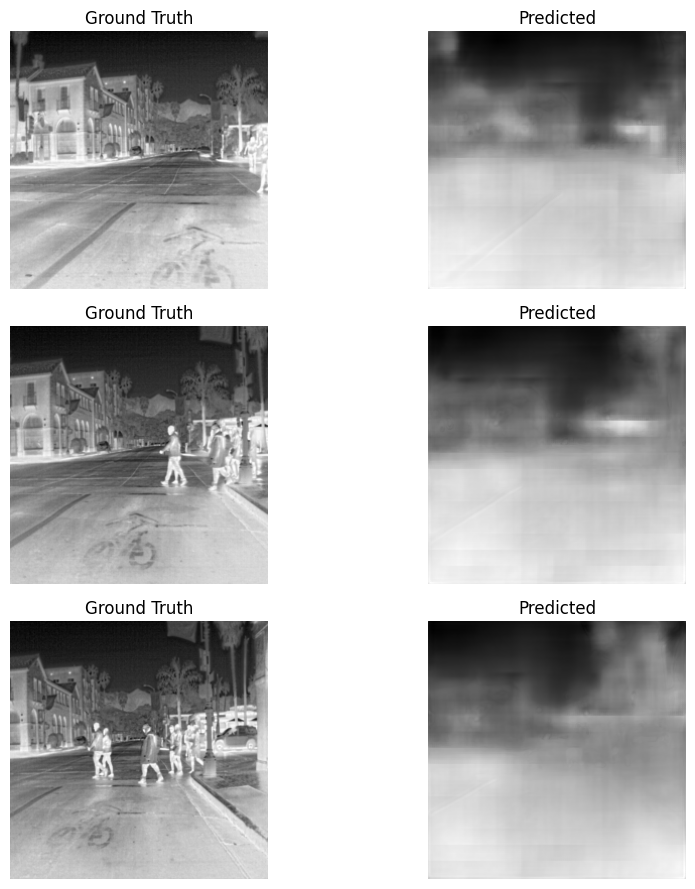

In [ ]:
# Visualize a few predictions vs. ground truth
num_show = 3
plt.figure(figsize=(10, num_show * 3))
for i in range(num_show):
    plt.subplot(num_show, 2, 2*i+1)
    plt.imshow(gts[i], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(num_show, 2, 2*i+2)
    plt.imshow(outputs[i], cmap='gray')
    plt.title('Predicted')
    plt.axis('off')
plt.tight_layout()
plt.show()

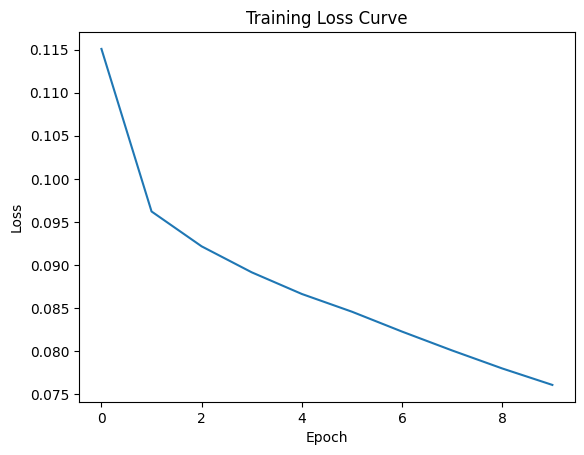

In [ ]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()